In [15]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw


In [16]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '../aktwelve_Mask_RCNN'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib
print('import mrcnn.model as modellib')

import mrcnn.model as modellib


## Set up logging and pre-trained model paths
This will default to sub-directories in your mask_rcnn_dir, but if you want them somewhere else, updated it here.

It will also download the pre-trained coco model.

In [17]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
print('utils.download_trained_weights(COCO_MOEL_PATH)')

utils.download_trained_weights(COCO_MOEL_PATH)


In [18]:
class CigButtsConfig(Config):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cig_butts"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (cig_butt)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CigButtsConfig()
config.display()

print('config.displlay')


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [19]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids
    
print('return mask, class_ids')

return mask, class_ids


# Create the Training and Validation Datasets
Make sure you download the training dataset linked at the top of this notebook. If you put the dataset somewhere else, update the paths below.

In [20]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('../datasets/cig_butts/train/coco_annotations.json', '../datasets/cig_butts/train/images')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('../datasets/cig_butts/val/coco_annotations.json', '../datasets/cig_butts/val/images')
dataset_val.prepare()

print('dataset_val.preparee')

dataset_val.preparee


## Display a few images from the training dataset

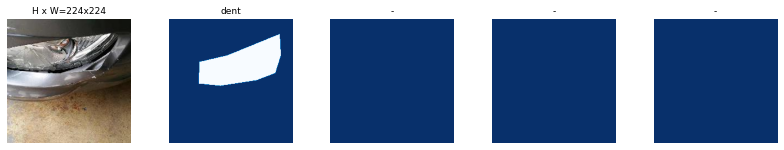

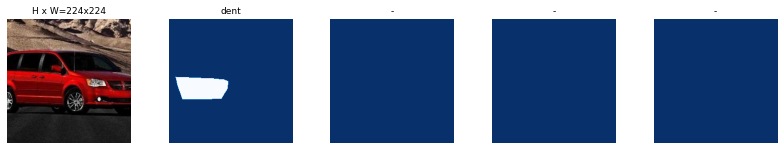

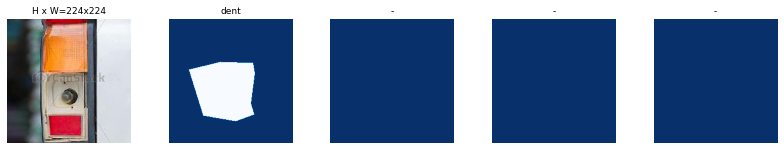

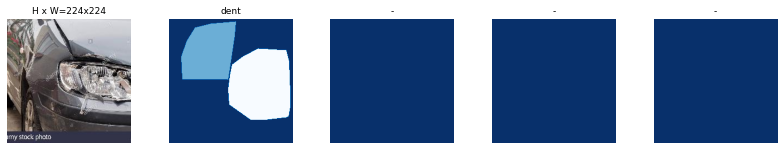

visualize.display_top_masks(image, mask, class_ids, dataset.class_name(s)


In [21]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

print('visualize.display_top_masks(image, mask, class_ids, dataset.class_name(s)')

In [22]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)
print('model = modellib.MaskRCNN(mode="training", config=configg')

model = modellib.MaskRCNN(mode="training", config=configg


In [23]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)
    
print('model.load_weights(model.find_last(), by_name=True())')

model.load_weights(model.find_last(), by_name=True())


In [24]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
print('time.toime()')
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=4, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print('blablabla')
print(f'Training took {minutes} minutes')

time.toime()

Starting at epoch 0. LR=0.001

Checkpoint Path: ../aktwelve_Mask_RCNN\logs\cig_butts20200921T1131\mask_rcnn_cig_butts_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mr

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


  1/500 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 1.0000 - loss: 5.8160 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 3.6022 - mrcnn_class_loss: 0.5277 - mrcnn_bbox_loss: 0.8378 - mrcnn_mask_loss: 0.7876

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/500 [..............................] - ETA: 1:57 - batch: 1.0000 - size: 1.0000 - loss: 5.1102 - rpn_class_loss: 0.1048 - rpn_bbox_loss: 4.1607 - mrcnn_class_loss: 0.3029 - mrcnn_bbox_loss: 0.2793 - mrcnn_mask_loss: 0.2625

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/500 [..............................] - ETA: 1:56 - batch: 1.5000 - size: 1.0000 - loss: 4.9093 - rpn_class_loss: 0.1533 - rpn_bbox_loss: 4.1216 - mrcnn_class_loss: 0.2281 - mrcnn_bbox_loss: 0.2094 - mrcnn_mask_loss: 0.1969

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/500 [..............................] - ETA: 1:56 - batch: 2.0000 - size: 1.0000 - loss: 4.9443 - rpn_class_loss: 0.1554 - rpn_bbox_loss: 4.2813 - mrcnn_class_loss: 0.1825 - mrcnn_bbox_loss: 0.1676 - mrcnn_mask_loss: 0.1575

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/500 [..............................] - ETA: 1:55 - batch: 2.5000 - size: 1.0000 - loss: 4.5237 - rpn_class_loss: 0.1306 - rpn_bbox_loss: 3.9701 - mrcnn_class_loss: 0.1521 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.1313

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/500 [..............................] - ETA: 1:57 - batch: 3.5000 - size: 1.0000 - loss: 5.0189 - rpn_class_loss: 0.1178 - rpn_bbox_loss: 4.0442 - mrcnn_class_loss: 0.1812 - mrcnn_bbox_loss: 0.3855 - mrcnn_mask_loss: 0.2902

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/500 [..............................] - ETA: 1:57 - batch: 4.0000 - size: 1.0000 - loss: 4.9631 - rpn_class_loss: 0.1086 - rpn_bbox_loss: 3.8577 - mrcnn_class_loss: 0.2037 - mrcnn_bbox_loss: 0.4650 - mrcnn_mask_loss: 0.3281

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/500 [..............................] - ETA: 1:57 - batch: 4.5000 - size: 1.0000 - loss: 4.6138 - rpn_class_loss: 0.0996 - rpn_bbox_loss: 3.6171 - mrcnn_class_loss: 0.1833 - mrcnn_bbox_loss: 0.4185 - mrcnn_mask_loss: 0.2953

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/500 [..............................] - ETA: 1:57 - batch: 5.0000 - size: 1.0000 - loss: 4.3424 - rpn_class_loss: 0.0922 - rpn_bbox_loss: 3.4347 - mrcnn_class_loss: 0.1667 - mrcnn_bbox_loss: 0.3804 - mrcnn_mask_loss: 0.2684

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/500 [..............................] - ETA: 1:57 - batch: 5.5000 - size: 1.0000 - loss: 4.1193 - rpn_class_loss: 0.0857 - rpn_bbox_loss: 3.2861 - mrcnn_class_loss: 0.1528 - mrcnn_bbox_loss: 0.3487 - mrcnn_mask_loss: 0.2461

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/500 [..............................] - ETA: 1:58 - batch: 6.0000 - size: 1.0000 - loss: 3.9331 - rpn_class_loss: 0.0803 - rpn_bbox_loss: 3.1627 - mrcnn_class_loss: 0.1410 - mrcnn_bbox_loss: 0.3219 - mrcnn_mask_loss: 0.2271

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/500 [..............................] - ETA: 1:58 - batch: 6.5000 - size: 1.0000 - loss: 3.8102 - rpn_class_loss: 0.0776 - rpn_bbox_loss: 3.0918 - mrcnn_class_loss: 0.1310 - mrcnn_bbox_loss: 0.2989 - mrcnn_mask_loss: 0.2109

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/500 [..............................] - ETA: 1:57 - batch: 7.0000 - size: 1.0000 - loss: 3.9808 - rpn_class_loss: 0.0741 - rpn_bbox_loss: 3.1161 - mrcnn_class_loss: 0.1574 - mrcnn_bbox_loss: 0.3909 - mrcnn_mask_loss: 0.2424

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/500 [..............................] - ETA: 1:57 - batch: 7.5000 - size: 1.0000 - loss: 4.0404 - rpn_class_loss: 0.0731 - rpn_bbox_loss: 3.2261 - mrcnn_class_loss: 0.1475 - mrcnn_bbox_loss: 0.3664 - mrcnn_mask_loss: 0.2273

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/500 [>.............................] - ETA: 1:58 - batch: 8.0000 - size: 1.0000 - loss: 3.9876 - rpn_class_loss: 0.0699 - rpn_bbox_loss: 3.0924 - mrcnn_class_loss: 0.1668 - mrcnn_bbox_loss: 0.4048 - mrcnn_mask_loss: 0.2536

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/500 [>.............................] - ETA: 1:58 - batch: 8.5000 - size: 1.0000 - loss: 3.9142 - rpn_class_loss: 0.0666 - rpn_bbox_loss: 2.9882 - mrcnn_class_loss: 0.1689 - mrcnn_bbox_loss: 0.4172 - mrcnn_mask_loss: 0.2733

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/500 [>.............................] - ETA: 1:58 - batch: 9.0000 - size: 1.0000 - loss: 3.9052 - rpn_class_loss: 0.0649 - rpn_bbox_loss: 2.9214 - mrcnn_class_loss: 0.1657 - mrcnn_bbox_loss: 0.4593 - mrcnn_mask_loss: 0.2939

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/500 [>.............................] - ETA: 1:57 - batch: 9.5000 - size: 1.0000 - loss: 3.8112 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 2.7906 - mrcnn_class_loss: 0.1658 - mrcnn_bbox_loss: 0.4846 - mrcnn_mask_loss: 0.3075

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/500 [>.............................] - ETA: 1:57 - batch: 10.0000 - size: 1.0000 - loss: 3.7136 - rpn_class_loss: 0.0612 - rpn_bbox_loss: 2.7401 - mrcnn_class_loss: 0.1579 - mrcnn_bbox_loss: 0.4615 - mrcnn_mask_loss: 0.2929

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/500 [>.............................] - ETA: 1:57 - batch: 10.5000 - size: 1.0000 - loss: 3.5998 - rpn_class_loss: 0.0591 - rpn_bbox_loss: 2.6200 - mrcnn_class_loss: 0.1522 - mrcnn_bbox_loss: 0.4637 - mrcnn_mask_loss: 0.3049

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/500 [>.............................] - ETA: 1:56 - batch: 11.0000 - size: 1.0000 - loss: 3.6933 - rpn_class_loss: 0.0587 - rpn_bbox_loss: 2.6926 - mrcnn_class_loss: 0.1538 - mrcnn_bbox_loss: 0.4729 - mrcnn_mask_loss: 0.3155

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/500 [>.............................] - ETA: 1:57 - batch: 11.5000 - size: 1.0000 - loss: 3.6252 - rpn_class_loss: 0.0578 - rpn_bbox_loss: 2.6646 - mrcnn_class_loss: 0.1474 - mrcnn_bbox_loss: 0.4531 - mrcnn_mask_loss: 0.3023

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/500 [>.............................] - ETA: 1:56 - batch: 12.5000 - size: 1.0000 - loss: 3.6970 - rpn_class_loss: 0.0609 - rpn_bbox_loss: 2.7440 - mrcnn_class_loss: 0.1364 - mrcnn_bbox_loss: 0.4543 - mrcnn_mask_loss: 0.3014

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/500 [>.............................] - ETA: 1:56 - batch: 13.0000 - size: 1.0000 - loss: 3.6591 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 2.6990 - mrcnn_class_loss: 0.1316 - mrcnn_bbox_loss: 0.4658 - mrcnn_mask_loss: 0.3036

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/500 [>.............................] - ETA: 1:56 - batch: 13.5000 - size: 1.0000 - loss: 3.6353 - rpn_class_loss: 0.0580 - rpn_bbox_loss: 2.6582 - mrcnn_class_loss: 0.1357 - mrcnn_bbox_loss: 0.4690 - mrcnn_mask_loss: 0.3144

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/500 [>.............................] - ETA: 1:55 - batch: 14.0000 - size: 1.0000 - loss: 3.6536 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 2.6263 - mrcnn_class_loss: 0.1369 - mrcnn_bbox_loss: 0.5077 - mrcnn_mask_loss: 0.3263

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/500 [>.............................] - ETA: 1:55 - batch: 14.5000 - size: 1.0000 - loss: 3.6769 - rpn_class_loss: 0.0587 - rpn_bbox_loss: 2.6305 - mrcnn_class_loss: 0.1325 - mrcnn_bbox_loss: 0.5202 - mrcnn_mask_loss: 0.3350

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/500 [>.............................] - ETA: 1:55 - batch: 15.0000 - size: 1.0000 - loss: 3.6730 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 2.6587 - mrcnn_class_loss: 0.1282 - mrcnn_bbox_loss: 0.5034 - mrcnn_mask_loss: 0.3242

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/500 [>.............................] - ETA: 1:55 - batch: 15.5000 - size: 1.0000 - loss: 3.6614 - rpn_class_loss: 0.0573 - rpn_bbox_loss: 2.6331 - mrcnn_class_loss: 0.1243 - mrcnn_bbox_loss: 0.5116 - mrcnn_mask_loss: 0.3351

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/500 [>.............................] - ETA: 1:54 - batch: 16.0000 - size: 1.0000 - loss: 3.6601 - rpn_class_loss: 0.0565 - rpn_bbox_loss: 2.5942 - mrcnn_class_loss: 0.1207 - mrcnn_bbox_loss: 0.5448 - mrcnn_mask_loss: 0.3440

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/500 [=>............................] - ETA: 1:54 - batch: 16.5000 - size: 1.0000 - loss: 3.6953 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 2.6245 - mrcnn_class_loss: 0.1173 - mrcnn_bbox_loss: 0.5414 - mrcnn_mask_loss: 0.3542

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/500 [=>............................] - ETA: 1:54 - batch: 17.0000 - size: 1.0000 - loss: 3.7932 - rpn_class_loss: 0.0577 - rpn_bbox_loss: 2.6711 - mrcnn_class_loss: 0.1291 - mrcnn_bbox_loss: 0.5736 - mrcnn_mask_loss: 0.3618

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/500 [=>............................] - ETA: 1:53 - batch: 17.5000 - size: 1.0000 - loss: 3.7743 - rpn_class_loss: 0.0566 - rpn_bbox_loss: 2.6381 - mrcnn_class_loss: 0.1376 - mrcnn_bbox_loss: 0.5757 - mrcnn_mask_loss: 0.3662

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/500 [=>............................] - ETA: 1:53 - batch: 18.0000 - size: 1.0000 - loss: 3.7879 - rpn_class_loss: 0.0557 - rpn_bbox_loss: 2.6378 - mrcnn_class_loss: 0.1374 - mrcnn_bbox_loss: 0.5856 - mrcnn_mask_loss: 0.3713

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/500 [=>............................] - ETA: 1:53 - batch: 18.5000 - size: 1.0000 - loss: 3.7980 - rpn_class_loss: 0.0565 - rpn_bbox_loss: 2.6395 - mrcnn_class_loss: 0.1366 - mrcnn_bbox_loss: 0.5917 - mrcnn_mask_loss: 0.3737

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/500 [=>............................] - ETA: 1:53 - batch: 19.0000 - size: 1.0000 - loss: 3.8054 - rpn_class_loss: 0.0559 - rpn_bbox_loss: 2.6372 - mrcnn_class_loss: 0.1361 - mrcnn_bbox_loss: 0.5982 - mrcnn_mask_loss: 0.3780

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/500 [=>............................] - ETA: 1:52 - batch: 19.5000 - size: 1.0000 - loss: 3.7776 - rpn_class_loss: 0.0552 - rpn_bbox_loss: 2.6037 - mrcnn_class_loss: 0.1348 - mrcnn_bbox_loss: 0.6069 - mrcnn_mask_loss: 0.3770

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/500 [=>............................] - ETA: 1:52 - batch: 20.0000 - size: 1.0000 - loss: 3.7674 - rpn_class_loss: 0.0558 - rpn_bbox_loss: 2.5974 - mrcnn_class_loss: 0.1319 - mrcnn_bbox_loss: 0.6011 - mrcnn_mask_loss: 0.3812

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/500 [=>............................] - ETA: 1:52 - batch: 20.5000 - size: 1.0000 - loss: 3.7535 - rpn_class_loss: 0.0556 - rpn_bbox_loss: 2.5769 - mrcnn_class_loss: 0.1332 - mrcnn_bbox_loss: 0.6032 - mrcnn_mask_loss: 0.3846

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/500 [=>............................] - ETA: 1:51 - batch: 21.0000 - size: 1.0000 - loss: 3.7678 - rpn_class_loss: 0.0547 - rpn_bbox_loss: 2.5593 - mrcnn_class_loss: 0.1307 - mrcnn_bbox_loss: 0.6224 - mrcnn_mask_loss: 0.4008

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/500 [=>............................] - ETA: 1:51 - batch: 21.5000 - size: 1.0000 - loss: 3.7705 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 2.5482 - mrcnn_class_loss: 0.1296 - mrcnn_bbox_loss: 0.6287 - mrcnn_mask_loss: 0.4100

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/500 [=>............................] - ETA: 1:51 - batch: 22.0000 - size: 1.0000 - loss: 3.7438 - rpn_class_loss: 0.0531 - rpn_bbox_loss: 2.5044 - mrcnn_class_loss: 0.1309 - mrcnn_bbox_loss: 0.6352 - mrcnn_mask_loss: 0.4201

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/500 [=>............................] - ETA: 1:51 - batch: 22.5000 - size: 1.0000 - loss: 3.7704 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 2.5572 - mrcnn_class_loss: 0.1281 - mrcnn_bbox_loss: 0.6214 - mrcnn_mask_loss: 0.4110

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/500 [=>............................] - ETA: 1:50 - batch: 23.0000 - size: 1.0000 - loss: 3.7712 - rpn_class_loss: 0.0522 - rpn_bbox_loss: 2.5362 - mrcnn_class_loss: 0.1256 - mrcnn_bbox_loss: 0.6414 - mrcnn_mask_loss: 0.4158

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/500 [=>............................] - ETA: 1:50 - batch: 23.5000 - size: 1.0000 - loss: 3.8061 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 2.5459 - mrcnn_class_loss: 0.1247 - mrcnn_bbox_loss: 0.6585 - mrcnn_mask_loss: 0.4253

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/500 [=>............................] - ETA: 1:50 - batch: 24.0000 - size: 1.0000 - loss: 3.8181 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 2.5829 - mrcnn_class_loss: 0.1221 - mrcnn_bbox_loss: 0.6450 - mrcnn_mask_loss: 0.4166

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/500 [==>...........................] - ETA: 1:49 - batch: 24.5000 - size: 1.0000 - loss: 3.8461 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 2.6345 - mrcnn_class_loss: 0.1197 - mrcnn_bbox_loss: 0.6321 - mrcnn_mask_loss: 0.4082

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/500 [==>...........................] - ETA: 1:49 - batch: 25.0000 - size: 1.0000 - loss: 3.8968 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 2.6612 - mrcnn_class_loss: 0.1202 - mrcnn_bbox_loss: 0.6494 - mrcnn_mask_loss: 0.4145

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/500 [==>...........................] - ETA: 1:49 - batch: 25.5000 - size: 1.0000 - loss: 3.8738 - rpn_class_loss: 0.0509 - rpn_bbox_loss: 2.6263 - mrcnn_class_loss: 0.1250 - mrcnn_bbox_loss: 0.6514 - mrcnn_mask_loss: 0.4202

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/500 [==>...........................] - ETA: 1:49 - batch: 26.0000 - size: 1.0000 - loss: 3.8426 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 2.5943 - mrcnn_class_loss: 0.1237 - mrcnn_bbox_loss: 0.6502 - mrcnn_mask_loss: 0.4240

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/500 [==>...........................] - ETA: 1:48 - batch: 26.5000 - size: 1.0000 - loss: 3.8908 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 2.6255 - mrcnn_class_loss: 0.1236 - mrcnn_bbox_loss: 0.6589 - mrcnn_mask_loss: 0.4316

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/500 [==>...........................] - ETA: 1:48 - batch: 27.0000 - size: 1.0000 - loss: 3.9043 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 2.6357 - mrcnn_class_loss: 0.1246 - mrcnn_bbox_loss: 0.6571 - mrcnn_mask_loss: 0.4363

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/500 [==>...........................] - ETA: 1:48 - batch: 27.5000 - size: 1.0000 - loss: 3.8874 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 2.6197 - mrcnn_class_loss: 0.1247 - mrcnn_bbox_loss: 0.6528 - mrcnn_mask_loss: 0.4403

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/500 [==>...........................] - ETA: 1:48 - batch: 28.0000 - size: 1.0000 - loss: 3.8635 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 2.5886 - mrcnn_class_loss: 0.1268 - mrcnn_bbox_loss: 0.6545 - mrcnn_mask_loss: 0.4441

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/500 [==>...........................] - ETA: 1:47 - batch: 28.5000 - size: 1.0000 - loss: 3.8597 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 2.5810 - mrcnn_class_loss: 0.1281 - mrcnn_bbox_loss: 0.6532 - mrcnn_mask_loss: 0.4479

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/500 [==>...........................] - ETA: 1:47 - batch: 29.0000 - size: 1.0000 - loss: 3.8555 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 2.5695 - mrcnn_class_loss: 0.1287 - mrcnn_bbox_loss: 0.6568 - mrcnn_mask_loss: 0.4517

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/500 [==>...........................] - ETA: 1:47 - batch: 29.5000 - size: 1.0000 - loss: 3.8807 - rpn_class_loss: 0.0483 - rpn_bbox_loss: 2.5801 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.6553 - mrcnn_mask_loss: 0.4552

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/500 [==>...........................] - ETA: 1:47 - batch: 30.0000 - size: 1.0000 - loss: 3.8725 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 2.5588 - mrcnn_class_loss: 0.1431 - mrcnn_bbox_loss: 0.6637 - mrcnn_mask_loss: 0.4589

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/500 [==>...........................] - ETA: 1:47 - batch: 30.5000 - size: 1.0000 - loss: 3.8759 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 2.5616 - mrcnn_class_loss: 0.1424 - mrcnn_bbox_loss: 0.6622 - mrcnn_mask_loss: 0.4617

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/500 [==>...........................] - ETA: 1:46 - batch: 31.0000 - size: 1.0000 - loss: 3.8847 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 2.5640 - mrcnn_class_loss: 0.1432 - mrcnn_bbox_loss: 0.6651 - mrcnn_mask_loss: 0.4651

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/500 [==>...........................] - ETA: 1:46 - batch: 31.5000 - size: 1.0000 - loss: 3.8870 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 2.5613 - mrcnn_class_loss: 0.1437 - mrcnn_bbox_loss: 0.6667 - mrcnn_mask_loss: 0.4676

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/500 [==>...........................] - ETA: 1:46 - batch: 32.5000 - size: 1.0000 - loss: 3.8650 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 2.5356 - mrcnn_class_loss: 0.1438 - mrcnn_bbox_loss: 0.6659 - mrcnn_mask_loss: 0.4725

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/500 [===>..........................] - ETA: 1:45 - batch: 33.0000 - size: 1.0000 - loss: 3.8483 - rpn_class_loss: 0.0467 - rpn_bbox_loss: 2.5135 - mrcnn_class_loss: 0.1437 - mrcnn_bbox_loss: 0.6699 - mrcnn_mask_loss: 0.4745

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/500 [===>..........................] - ETA: 1:45 - batch: 33.5000 - size: 1.0000 - loss: 3.8467 - rpn_class_loss: 0.0469 - rpn_bbox_loss: 2.5137 - mrcnn_class_loss: 0.1429 - mrcnn_bbox_loss: 0.6680 - mrcnn_mask_loss: 0.4751

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/500 [===>..........................] - ETA: 1:45 - batch: 34.0000 - size: 1.0000 - loss: 3.8447 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 2.5055 - mrcnn_class_loss: 0.1479 - mrcnn_bbox_loss: 0.6677 - mrcnn_mask_loss: 0.4772

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/500 [===>..........................] - ETA: 1:45 - batch: 34.5000 - size: 1.0000 - loss: 3.8637 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 2.5220 - mrcnn_class_loss: 0.1459 - mrcnn_bbox_loss: 0.6709 - mrcnn_mask_loss: 0.4778

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/500 [===>..........................] - ETA: 1:44 - batch: 35.0000 - size: 1.0000 - loss: 3.8520 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 2.5099 - mrcnn_class_loss: 0.1446 - mrcnn_bbox_loss: 0.6711 - mrcnn_mask_loss: 0.4787

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/500 [===>..........................] - ETA: 1:44 - batch: 36.0000 - size: 1.0000 - loss: 3.8517 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 2.5047 - mrcnn_class_loss: 0.1419 - mrcnn_bbox_loss: 0.6750 - mrcnn_mask_loss: 0.4831

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/500 [===>..........................] - ETA: 1:44 - batch: 36.5000 - size: 1.0000 - loss: 3.8625 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 2.5171 - mrcnn_class_loss: 0.1419 - mrcnn_bbox_loss: 0.6724 - mrcnn_mask_loss: 0.4839

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/500 [===>..........................] - ETA: 1:43 - batch: 37.0000 - size: 1.0000 - loss: 3.8649 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 2.4957 - mrcnn_class_loss: 0.1546 - mrcnn_bbox_loss: 0.6790 - mrcnn_mask_loss: 0.4887

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/500 [===>..........................] - ETA: 1:43 - batch: 37.5000 - size: 1.0000 - loss: 3.8553 - rpn_class_loss: 0.0467 - rpn_bbox_loss: 2.4836 - mrcnn_class_loss: 0.1570 - mrcnn_bbox_loss: 0.6786 - mrcnn_mask_loss: 0.4895

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/500 [===>..........................] - ETA: 1:43 - batch: 38.0000 - size: 1.0000 - loss: 3.8361 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 2.4637 - mrcnn_class_loss: 0.1564 - mrcnn_bbox_loss: 0.6797 - mrcnn_mask_loss: 0.4901

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/500 [===>..........................] - ETA: 1:43 - batch: 38.5000 - size: 1.0000 - loss: 3.8421 - rpn_class_loss: 0.0463 - rpn_bbox_loss: 2.4738 - mrcnn_class_loss: 0.1548 - mrcnn_bbox_loss: 0.6782 - mrcnn_mask_loss: 0.4889

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/500 [===>..........................] - ETA: 1:43 - batch: 39.0000 - size: 1.0000 - loss: 3.8477 - rpn_class_loss: 0.0463 - rpn_bbox_loss: 2.4714 - mrcnn_class_loss: 0.1578 - mrcnn_bbox_loss: 0.6810 - mrcnn_mask_loss: 0.4912

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/500 [===>..........................] - ETA: 1:42 - batch: 39.5000 - size: 1.0000 - loss: 3.8336 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 2.4542 - mrcnn_class_loss: 0.1614 - mrcnn_bbox_loss: 0.6792 - mrcnn_mask_loss: 0.4928

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/500 [===>..........................] - ETA: 1:42 - batch: 40.0000 - size: 1.0000 - loss: 3.8361 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 2.4544 - mrcnn_class_loss: 0.1630 - mrcnn_bbox_loss: 0.6797 - mrcnn_mask_loss: 0.4931

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/500 [===>..........................] - ETA: 1:42 - batch: 40.5000 - size: 1.0000 - loss: 3.8408 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 2.4558 - mrcnn_class_loss: 0.1644 - mrcnn_bbox_loss: 0.6796 - mrcnn_mask_loss: 0.4950

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/500 [===>..........................] - ETA: 1:42 - batch: 41.0000 - size: 1.0000 - loss: 3.8239 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 2.4552 - mrcnn_class_loss: 0.1624 - mrcnn_bbox_loss: 0.6714 - mrcnn_mask_loss: 0.4891

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/500 [====>.........................] - ETA: 1:41 - batch: 41.5000 - size: 1.0000 - loss: 3.8162 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 2.4415 - mrcnn_class_loss: 0.1661 - mrcnn_bbox_loss: 0.6731 - mrcnn_mask_loss: 0.4901

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/500 [====>.........................] - ETA: 1:41 - batch: 42.0000 - size: 1.0000 - loss: 3.8155 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 2.4386 - mrcnn_class_loss: 0.1676 - mrcnn_bbox_loss: 0.6721 - mrcnn_mask_loss: 0.4919

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/500 [====>.........................] - ETA: 1:41 - batch: 42.5000 - size: 1.0000 - loss: 3.7846 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 2.4235 - mrcnn_class_loss: 0.1657 - mrcnn_bbox_loss: 0.6643 - mrcnn_mask_loss: 0.4862

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/500 [====>.........................] - ETA: 1:41 - batch: 43.0000 - size: 1.0000 - loss: 3.7814 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 2.4117 - mrcnn_class_loss: 0.1685 - mrcnn_bbox_loss: 0.6686 - mrcnn_mask_loss: 0.4881

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/500 [====>.........................] - ETA: 1:41 - batch: 43.5000 - size: 1.0000 - loss: 3.7961 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 2.4162 - mrcnn_class_loss: 0.1706 - mrcnn_bbox_loss: 0.6751 - mrcnn_mask_loss: 0.4898

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/500 [====>.........................] - ETA: 1:40 - batch: 44.0000 - size: 1.0000 - loss: 3.7880 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 2.4233 - mrcnn_class_loss: 0.1687 - mrcnn_bbox_loss: 0.6675 - mrcnn_mask_loss: 0.4843

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/500 [====>.........................] - ETA: 1:40 - batch: 44.5000 - size: 1.0000 - loss: 3.7846 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 2.4166 - mrcnn_class_loss: 0.1702 - mrcnn_bbox_loss: 0.6679 - mrcnn_mask_loss: 0.4860

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/500 [====>.........................] - ETA: 1:40 - batch: 45.0000 - size: 1.0000 - loss: 3.7771 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 2.4029 - mrcnn_class_loss: 0.1685 - mrcnn_bbox_loss: 0.6749 - mrcnn_mask_loss: 0.4873

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/500 [====>.........................] - ETA: 1:40 - batch: 45.5000 - size: 1.0000 - loss: 3.7826 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 2.4032 - mrcnn_class_loss: 0.1691 - mrcnn_bbox_loss: 0.6778 - mrcnn_mask_loss: 0.4893

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/500 [====>.........................] - ETA: 1:39 - batch: 46.0000 - size: 1.0000 - loss: 3.8014 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 2.4194 - mrcnn_class_loss: 0.1701 - mrcnn_bbox_loss: 0.6782 - mrcnn_mask_loss: 0.4906

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/500 [====>.........................] - ETA: 1:39 - batch: 46.5000 - size: 1.0000 - loss: 3.7917 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 2.4124 - mrcnn_class_loss: 0.1685 - mrcnn_bbox_loss: 0.6766 - mrcnn_mask_loss: 0.4912

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/500 [====>.........................] - ETA: 1:39 - batch: 47.0000 - size: 1.0000 - loss: 3.7837 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 2.3985 - mrcnn_class_loss: 0.1729 - mrcnn_bbox_loss: 0.6775 - mrcnn_mask_loss: 0.4922

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/500 [====>.........................] - ETA: 1:39 - batch: 47.5000 - size: 1.0000 - loss: 3.7778 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 2.3861 - mrcnn_class_loss: 0.1722 - mrcnn_bbox_loss: 0.6823 - mrcnn_mask_loss: 0.4948

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/500 [====>.........................] - ETA: 1:39 - batch: 48.5000 - size: 1.0000 - loss: 3.7488 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 2.3533 - mrcnn_class_loss: 0.1746 - mrcnn_bbox_loss: 0.6819 - mrcnn_mask_loss: 0.4971

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/500 [====>.........................] - ETA: 1:38 - batch: 49.0000 - size: 1.0000 - loss: 3.7495 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 2.3547 - mrcnn_class_loss: 0.1753 - mrcnn_bbox_loss: 0.6810 - mrcnn_mask_loss: 0.4969

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/500 [=====>........................] - ETA: 1:38 - batch: 49.5000 - size: 1.0000 - loss: 3.7404 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 2.3472 - mrcnn_class_loss: 0.1768 - mrcnn_bbox_loss: 0.6784 - mrcnn_mask_loss: 0.4967

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/500 [=====>........................] - ETA: 1:38 - batch: 50.0000 - size: 1.0000 - loss: 3.7352 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 2.3355 - mrcnn_class_loss: 0.1759 - mrcnn_bbox_loss: 0.6830 - mrcnn_mask_loss: 0.4999

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/500 [=====>........................] - ETA: 1:38 - batch: 50.5000 - size: 1.0000 - loss: 3.7446 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 2.3418 - mrcnn_class_loss: 0.1773 - mrcnn_bbox_loss: 0.6848 - mrcnn_mask_loss: 0.4999

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/500 [=====>........................] - ETA: 1:37 - batch: 51.0000 - size: 1.0000 - loss: 3.7711 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 2.3603 - mrcnn_class_loss: 0.1798 - mrcnn_bbox_loss: 0.6884 - mrcnn_mask_loss: 0.5019

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/500 [=====>........................] - ETA: 1:37 - batch: 51.5000 - size: 1.0000 - loss: 3.7747 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 2.3665 - mrcnn_class_loss: 0.1794 - mrcnn_bbox_loss: 0.6868 - mrcnn_mask_loss: 0.5016

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/500 [=====>........................] - ETA: 1:37 - batch: 52.0000 - size: 1.0000 - loss: 3.7806 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 2.3745 - mrcnn_class_loss: 0.1798 - mrcnn_bbox_loss: 0.6844 - mrcnn_mask_loss: 0.5017

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/500 [=====>........................] - ETA: 1:36 - batch: 53.0000 - size: 1.0000 - loss: 3.7855 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 2.3775 - mrcnn_class_loss: 0.1807 - mrcnn_bbox_loss: 0.6826 - mrcnn_mask_loss: 0.5049

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/500 [=====>........................] - ETA: 1:36 - batch: 53.5000 - size: 1.0000 - loss: 3.7863 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 2.3733 - mrcnn_class_loss: 0.1802 - mrcnn_bbox_loss: 0.6870 - mrcnn_mask_loss: 0.5059

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/500 [=====>........................] - ETA: 1:36 - batch: 54.0000 - size: 1.0000 - loss: 3.7878 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 2.3704 - mrcnn_class_loss: 0.1843 - mrcnn_bbox_loss: 0.6863 - mrcnn_mask_loss: 0.5070

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/500 [=====>........................] - ETA: 1:36 - batch: 54.5000 - size: 1.0000 - loss: 3.7878 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 2.3700 - mrcnn_class_loss: 0.1850 - mrcnn_bbox_loss: 0.6853 - mrcnn_mask_loss: 0.5080

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/500 [=====>........................] - ETA: 1:36 - batch: 55.0000 - size: 1.0000 - loss: 3.7801 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 2.3599 - mrcnn_class_loss: 0.1844 - mrcnn_bbox_loss: 0.6872 - mrcnn_mask_loss: 0.5091

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/500 [=====>........................] - ETA: 1:35 - batch: 55.5000 - size: 1.0000 - loss: 3.7694 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 2.3489 - mrcnn_class_loss: 0.1852 - mrcnn_bbox_loss: 0.6870 - mrcnn_mask_loss: 0.5090

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/500 [=====>........................] - ETA: 1:35 - batch: 56.0000 - size: 1.0000 - loss: 3.7611 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 2.3387 - mrcnn_class_loss: 0.1866 - mrcnn_bbox_loss: 0.6873 - mrcnn_mask_loss: 0.5093

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/500 [=====>........................] - ETA: 1:35 - batch: 57.0000 - size: 1.0000 - loss: 3.7475 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 2.3174 - mrcnn_class_loss: 0.1863 - mrcnn_bbox_loss: 0.6930 - mrcnn_mask_loss: 0.5118

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/500 [======>.......................] - ETA: 1:34 - batch: 58.0000 - size: 1.0000 - loss: 3.7393 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 2.2996 - mrcnn_class_loss: 0.1888 - mrcnn_bbox_loss: 0.6964 - mrcnn_mask_loss: 0.5160

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/500 [======>.......................] - ETA: 1:34 - batch: 58.5000 - size: 1.0000 - loss: 3.7346 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 2.2942 - mrcnn_class_loss: 0.1886 - mrcnn_bbox_loss: 0.6969 - mrcnn_mask_loss: 0.5163

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/500 [======>.......................] - ETA: 1:34 - batch: 59.0000 - size: 1.0000 - loss: 3.7300 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 2.2885 - mrcnn_class_loss: 0.1877 - mrcnn_bbox_loss: 0.6986 - mrcnn_mask_loss: 0.5168

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/500 [======>.......................] - ETA: 1:34 - batch: 59.5000 - size: 1.0000 - loss: 3.7267 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 2.2896 - mrcnn_class_loss: 0.1865 - mrcnn_bbox_loss: 0.6954 - mrcnn_mask_loss: 0.5170

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/500 [======>.......................] - ETA: 1:34 - batch: 60.0000 - size: 1.0000 - loss: 3.7095 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 2.2728 - mrcnn_class_loss: 0.1873 - mrcnn_bbox_loss: 0.6939 - mrcnn_mask_loss: 0.5176

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/500 [======>.......................] - ETA: 1:33 - batch: 60.5000 - size: 1.0000 - loss: 3.6984 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 2.2612 - mrcnn_class_loss: 0.1877 - mrcnn_bbox_loss: 0.6933 - mrcnn_mask_loss: 0.5185

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/500 [======>.......................] - ETA: 1:33 - batch: 61.5000 - size: 1.0000 - loss: 3.7101 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 2.2671 - mrcnn_class_loss: 0.1862 - mrcnn_bbox_loss: 0.6963 - mrcnn_mask_loss: 0.5226

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/500 [======>.......................] - ETA: 1:33 - batch: 62.0000 - size: 1.0000 - loss: 3.7163 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 2.2596 - mrcnn_class_loss: 0.1864 - mrcnn_bbox_loss: 0.7095 - mrcnn_mask_loss: 0.5233

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/500 [======>.......................] - ETA: 1:33 - batch: 62.5000 - size: 1.0000 - loss: 3.7008 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 2.2455 - mrcnn_class_loss: 0.1856 - mrcnn_bbox_loss: 0.7083 - mrcnn_mask_loss: 0.5239

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/500 [======>.......................] - ETA: 1:32 - batch: 63.5000 - size: 1.0000 - loss: 3.7119 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 2.2545 - mrcnn_class_loss: 0.1847 - mrcnn_bbox_loss: 0.7099 - mrcnn_mask_loss: 0.5253

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/500 [======>.......................] - ETA: 1:32 - batch: 64.0000 - size: 1.0000 - loss: 3.7410 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 2.2765 - mrcnn_class_loss: 0.1842 - mrcnn_bbox_loss: 0.7153 - mrcnn_mask_loss: 0.5273

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/500 [======>.......................] - ETA: 1:32 - batch: 65.0000 - size: 1.0000 - loss: 3.7564 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 2.2867 - mrcnn_class_loss: 0.1854 - mrcnn_bbox_loss: 0.7181 - mrcnn_mask_loss: 0.5287

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/500 [======>.......................] - ETA: 1:31 - batch: 65.5000 - size: 1.0000 - loss: 3.7634 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 2.2943 - mrcnn_class_loss: 0.1848 - mrcnn_bbox_loss: 0.7173 - mrcnn_mask_loss: 0.5291

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/500 [=======>......................] - ETA: 1:31 - batch: 66.5000 - size: 1.0000 - loss: 3.7711 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 2.2919 - mrcnn_class_loss: 0.1896 - mrcnn_bbox_loss: 0.7217 - mrcnn_mask_loss: 0.5303

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/500 [=======>......................] - ETA: 1:31 - batch: 67.0000 - size: 1.0000 - loss: 3.7848 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 2.3054 - mrcnn_class_loss: 0.1886 - mrcnn_bbox_loss: 0.7234 - mrcnn_mask_loss: 0.5299

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/500 [=======>......................] - ETA: 1:31 - batch: 67.5000 - size: 1.0000 - loss: 3.7700 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 2.2921 - mrcnn_class_loss: 0.1880 - mrcnn_bbox_loss: 0.7226 - mrcnn_mask_loss: 0.5301

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/500 [=======>......................] - ETA: 1:30 - batch: 68.0000 - size: 1.0000 - loss: 3.7627 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 2.2853 - mrcnn_class_loss: 0.1890 - mrcnn_bbox_loss: 0.7212 - mrcnn_mask_loss: 0.5303

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/500 [=======>......................] - ETA: 1:30 - batch: 68.5000 - size: 1.0000 - loss: 3.7816 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 2.3045 - mrcnn_class_loss: 0.1883 - mrcnn_bbox_loss: 0.7210 - mrcnn_mask_loss: 0.5309

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/500 [=======>......................] - ETA: 1:30 - batch: 69.0000 - size: 1.0000 - loss: 3.7781 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 2.3019 - mrcnn_class_loss: 0.1874 - mrcnn_bbox_loss: 0.7203 - mrcnn_mask_loss: 0.5319

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/500 [=======>......................] - ETA: 1:30 - batch: 69.5000 - size: 1.0000 - loss: 3.7740 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 2.3003 - mrcnn_class_loss: 0.1871 - mrcnn_bbox_loss: 0.7189 - mrcnn_mask_loss: 0.5313

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/500 [=======>......................] - ETA: 1:29 - batch: 70.0000 - size: 1.0000 - loss: 3.7644 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 2.3011 - mrcnn_class_loss: 0.1857 - mrcnn_bbox_loss: 0.7138 - mrcnn_mask_loss: 0.5275

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/500 [=======>......................] - ETA: 1:29 - batch: 70.5000 - size: 1.0000 - loss: 3.7528 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 2.2888 - mrcnn_class_loss: 0.1861 - mrcnn_bbox_loss: 0.7143 - mrcnn_mask_loss: 0.5275

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/500 [=======>......................] - ETA: 1:29 - batch: 71.0000 - size: 1.0000 - loss: 3.7517 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 2.2871 - mrcnn_class_loss: 0.1855 - mrcnn_bbox_loss: 0.7142 - mrcnn_mask_loss: 0.5290

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/500 [=======>......................] - ETA: 1:29 - batch: 72.0000 - size: 1.0000 - loss: 3.7387 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 2.2725 - mrcnn_class_loss: 0.1853 - mrcnn_bbox_loss: 0.7147 - mrcnn_mask_loss: 0.5306

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/500 [=======>......................] - ETA: 1:28 - batch: 72.5000 - size: 1.0000 - loss: 3.7573 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 2.2912 - mrcnn_class_loss: 0.1849 - mrcnn_bbox_loss: 0.7158 - mrcnn_mask_loss: 0.5297

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/500 [=======>......................] - ETA: 1:28 - batch: 73.0000 - size: 1.0000 - loss: 3.7514 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 2.2810 - mrcnn_class_loss: 0.1895 - mrcnn_bbox_loss: 0.7157 - mrcnn_mask_loss: 0.5296

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/500 [=======>......................] - ETA: 1:28 - batch: 73.5000 - size: 1.0000 - loss: 3.7451 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 2.2731 - mrcnn_class_loss: 0.1908 - mrcnn_bbox_loss: 0.7160 - mrcnn_mask_loss: 0.5297

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/500 [=======>......................] - ETA: 1:28 - batch: 74.0000 - size: 1.0000 - loss: 3.7602 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 2.2866 - mrcnn_class_loss: 0.1925 - mrcnn_bbox_loss: 0.7160 - mrcnn_mask_loss: 0.5297

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/500 [========>.....................] - ETA: 1:27 - batch: 75.0000 - size: 1.0000 - loss: 3.7753 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 2.3010 - mrcnn_class_loss: 0.1920 - mrcnn_bbox_loss: 0.7176 - mrcnn_mask_loss: 0.5294

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/500 [========>.....................] - ETA: 1:27 - batch: 75.5000 - size: 1.0000 - loss: 3.7767 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 2.3006 - mrcnn_class_loss: 0.1925 - mrcnn_bbox_loss: 0.7189 - mrcnn_mask_loss: 0.5295

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/500 [========>.....................] - ETA: 1:27 - batch: 76.0000 - size: 1.0000 - loss: 3.7717 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 2.2967 - mrcnn_class_loss: 0.1926 - mrcnn_bbox_loss: 0.7181 - mrcnn_mask_loss: 0.5292

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/500 [========>.....................] - ETA: 1:27 - batch: 76.5000 - size: 1.0000 - loss: 3.7717 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 2.2978 - mrcnn_class_loss: 0.1920 - mrcnn_bbox_loss: 0.7177 - mrcnn_mask_loss: 0.5294

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/500 [========>.....................] - ETA: 1:26 - batch: 77.0000 - size: 1.0000 - loss: 3.7547 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 2.2833 - mrcnn_class_loss: 0.1914 - mrcnn_bbox_loss: 0.7165 - mrcnn_mask_loss: 0.5289

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/500 [========>.....................] - ETA: 1:26 - batch: 77.5000 - size: 1.0000 - loss: 3.7550 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 2.2864 - mrcnn_class_loss: 0.1907 - mrcnn_bbox_loss: 0.7146 - mrcnn_mask_loss: 0.5287

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/500 [========>.....................] - ETA: 1:26 - batch: 78.0000 - size: 1.0000 - loss: 3.7549 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 2.2890 - mrcnn_class_loss: 0.1906 - mrcnn_bbox_loss: 0.7129 - mrcnn_mask_loss: 0.5280

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/500 [========>.....................] - ETA: 1:26 - batch: 78.5000 - size: 1.0000 - loss: 3.7585 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 2.3018 - mrcnn_class_loss: 0.1894 - mrcnn_bbox_loss: 0.7084 - mrcnn_mask_loss: 0.5246

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/500 [========>.....................] - ETA: 1:26 - batch: 79.0000 - size: 1.0000 - loss: 3.7567 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 2.2962 - mrcnn_class_loss: 0.1932 - mrcnn_bbox_loss: 0.7086 - mrcnn_mask_loss: 0.5246

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/500 [========>.....................] - ETA: 1:25 - batch: 79.5000 - size: 1.0000 - loss: 3.7658 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 2.3070 - mrcnn_class_loss: 0.1924 - mrcnn_bbox_loss: 0.7075 - mrcnn_mask_loss: 0.5248

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/500 [========>.....................] - ETA: 1:25 - batch: 80.0000 - size: 1.0000 - loss: 3.7603 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 2.3039 - mrcnn_class_loss: 0.1918 - mrcnn_bbox_loss: 0.7064 - mrcnn_mask_loss: 0.5244

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/500 [========>.....................] - ETA: 1:25 - batch: 80.5000 - size: 1.0000 - loss: 3.7534 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 2.2942 - mrcnn_class_loss: 0.1935 - mrcnn_bbox_loss: 0.7074 - mrcnn_mask_loss: 0.5245

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/500 [========>.....................] - ETA: 1:25 - batch: 81.0000 - size: 1.0000 - loss: 3.7412 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 2.2816 - mrcnn_class_loss: 0.1937 - mrcnn_bbox_loss: 0.7073 - mrcnn_mask_loss: 0.5249

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/500 [========>.....................] - ETA: 1:25 - batch: 81.5000 - size: 1.0000 - loss: 3.7377 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 2.2806 - mrcnn_class_loss: 0.1930 - mrcnn_bbox_loss: 0.7056 - mrcnn_mask_loss: 0.5247

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/500 [========>.....................] - ETA: 1:24 - batch: 82.0000 - size: 1.0000 - loss: 3.7298 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 2.2715 - mrcnn_class_loss: 0.1942 - mrcnn_bbox_loss: 0.7055 - mrcnn_mask_loss: 0.5250

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/500 [=========>....................] - ETA: 1:24 - batch: 83.0000 - size: 1.0000 - loss: 3.7237 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 2.2652 - mrcnn_class_loss: 0.1937 - mrcnn_bbox_loss: 0.7055 - mrcnn_mask_loss: 0.5259

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/500 [=========>....................] - ETA: 1:24 - batch: 83.5000 - size: 1.0000 - loss: 3.7266 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 2.2651 - mrcnn_class_loss: 0.1939 - mrcnn_bbox_loss: 0.7074 - mrcnn_mask_loss: 0.5269

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/500 [=========>....................] - ETA: 1:23 - batch: 84.0000 - size: 1.0000 - loss: 3.7214 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 2.2604 - mrcnn_class_loss: 0.1947 - mrcnn_bbox_loss: 0.7064 - mrcnn_mask_loss: 0.5268

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/500 [=========>....................] - ETA: 1:23 - batch: 85.0000 - size: 1.0000 - loss: 3.7136 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 2.2484 - mrcnn_class_loss: 0.1979 - mrcnn_bbox_loss: 0.7070 - mrcnn_mask_loss: 0.5273

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/500 [=========>....................] - ETA: 1:23 - batch: 85.5000 - size: 1.0000 - loss: 3.7019 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 2.2373 - mrcnn_class_loss: 0.1984 - mrcnn_bbox_loss: 0.7060 - mrcnn_mask_loss: 0.5271

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/500 [=========>....................] - ETA: 1:23 - batch: 86.0000 - size: 1.0000 - loss: 3.7091 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 2.2449 - mrcnn_class_loss: 0.1974 - mrcnn_bbox_loss: 0.7062 - mrcnn_mask_loss: 0.5276

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/500 [=========>....................] - ETA: 1:22 - batch: 86.5000 - size: 1.0000 - loss: 3.7050 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 2.2388 - mrcnn_class_loss: 0.1974 - mrcnn_bbox_loss: 0.7083 - mrcnn_mask_loss: 0.5277

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/500 [=========>....................] - ETA: 1:22 - batch: 87.5000 - size: 1.0000 - loss: 3.7066 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 2.2383 - mrcnn_class_loss: 0.1975 - mrcnn_bbox_loss: 0.7091 - mrcnn_mask_loss: 0.5289

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/500 [=========>....................] - ETA: 1:22 - batch: 88.0000 - size: 1.0000 - loss: 3.7002 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 2.2314 - mrcnn_class_loss: 0.1986 - mrcnn_bbox_loss: 0.7089 - mrcnn_mask_loss: 0.5286

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/500 [=========>....................] - ETA: 1:22 - batch: 88.5000 - size: 1.0000 - loss: 3.7003 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 2.2309 - mrcnn_class_loss: 0.2002 - mrcnn_bbox_loss: 0.7087 - mrcnn_mask_loss: 0.5280

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/500 [=========>....................] - ETA: 1:21 - batch: 89.0000 - size: 1.0000 - loss: 3.7032 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 2.2279 - mrcnn_class_loss: 0.2031 - mrcnn_bbox_loss: 0.7119 - mrcnn_mask_loss: 0.5278

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/500 [=========>....................] - ETA: 1:21 - batch: 89.5000 - size: 1.0000 - loss: 3.7097 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 2.2344 - mrcnn_class_loss: 0.2026 - mrcnn_bbox_loss: 0.7117 - mrcnn_mask_loss: 0.5285

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/500 [=========>....................] - ETA: 1:21 - batch: 90.0000 - size: 1.0000 - loss: 3.7246 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 2.2510 - mrcnn_class_loss: 0.2016 - mrcnn_bbox_loss: 0.7105 - mrcnn_mask_loss: 0.5289

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/500 [=========>....................] - ETA: 1:21 - batch: 91.0000 - size: 1.0000 - loss: 3.7236 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 2.2523 - mrcnn_class_loss: 0.2011 - mrcnn_bbox_loss: 0.7087 - mrcnn_mask_loss: 0.5288

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/500 [==========>...................] - ETA: 1:20 - batch: 91.5000 - size: 1.0000 - loss: 3.7242 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 2.2495 - mrcnn_class_loss: 0.2002 - mrcnn_bbox_loss: 0.7101 - mrcnn_mask_loss: 0.5319

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/500 [==========>...................] - ETA: 1:20 - batch: 92.5000 - size: 1.0000 - loss: 3.7152 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 2.2378 - mrcnn_class_loss: 0.2010 - mrcnn_bbox_loss: 0.7106 - mrcnn_mask_loss: 0.5335

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/500 [==========>...................] - ETA: 1:20 - batch: 93.0000 - size: 1.0000 - loss: 3.7104 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 2.2315 - mrcnn_class_loss: 0.2008 - mrcnn_bbox_loss: 0.7114 - mrcnn_mask_loss: 0.5343

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/500 [==========>...................] - ETA: 1:19 - batch: 93.5000 - size: 1.0000 - loss: 3.7057 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 2.2270 - mrcnn_class_loss: 0.2004 - mrcnn_bbox_loss: 0.7117 - mrcnn_mask_loss: 0.5345

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/500 [==========>...................] - ETA: 1:19 - batch: 94.5000 - size: 1.0000 - loss: 3.7123 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 2.2285 - mrcnn_class_loss: 0.2028 - mrcnn_bbox_loss: 0.7130 - mrcnn_mask_loss: 0.5357

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/500 [==========>...................] - ETA: 1:19 - batch: 95.0000 - size: 1.0000 - loss: 3.7073 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 2.2225 - mrcnn_class_loss: 0.2029 - mrcnn_bbox_loss: 0.7142 - mrcnn_mask_loss: 0.5356

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/500 [==========>...................] - ETA: 1:18 - batch: 96.0000 - size: 1.0000 - loss: 3.6995 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 2.2132 - mrcnn_class_loss: 0.2034 - mrcnn_bbox_loss: 0.7146 - mrcnn_mask_loss: 0.5365

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/500 [==========>...................] - ETA: 1:18 - batch: 96.5000 - size: 1.0000 - loss: 3.7029 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 2.2187 - mrcnn_class_loss: 0.2027 - mrcnn_bbox_loss: 0.7136 - mrcnn_mask_loss: 0.5362

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/500 [==========>...................] - ETA: 1:18 - batch: 97.0000 - size: 1.0000 - loss: 3.7033 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 2.2196 - mrcnn_class_loss: 0.2022 - mrcnn_bbox_loss: 0.7132 - mrcnn_mask_loss: 0.5366

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/500 [==========>...................] - ETA: 1:18 - batch: 97.5000 - size: 1.0000 - loss: 3.7075 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 2.2227 - mrcnn_class_loss: 0.2027 - mrcnn_bbox_loss: 0.7136 - mrcnn_mask_loss: 0.5370

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/500 [==========>...................] - ETA: 1:17 - batch: 98.0000 - size: 1.0000 - loss: 3.7002 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 2.2153 - mrcnn_class_loss: 0.2024 - mrcnn_bbox_loss: 0.7135 - mrcnn_mask_loss: 0.5375

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/500 [==========>...................] - ETA: 1:17 - batch: 98.5000 - size: 1.0000 - loss: 3.6982 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 2.2116 - mrcnn_class_loss: 0.2027 - mrcnn_bbox_loss: 0.7141 - mrcnn_mask_loss: 0.5382

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/500 [==========>...................] - ETA: 1:17 - batch: 99.0000 - size: 1.0000 - loss: 3.6915 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 2.2040 - mrcnn_class_loss: 0.2023 - mrcnn_bbox_loss: 0.7152 - mrcnn_mask_loss: 0.5384

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/500 [===========>..................] - ETA: 1:17 - batch: 99.5000 - size: 1.0000 - loss: 3.6854 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 2.1972 - mrcnn_class_loss: 0.2023 - mrcnn_bbox_loss: 0.7158 - mrcnn_mask_loss: 0.5387

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/500 [===========>..................] - ETA: 1:17 - batch: 100.0000 - size: 1.0000 - loss: 3.6799 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 2.1903 - mrcnn_class_loss: 0.2025 - mrcnn_bbox_loss: 0.7166 - mrcnn_mask_loss: 0.5392

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/500 [===========>..................] - ETA: 1:16 - batch: 100.5000 - size: 1.0000 - loss: 3.7083 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 2.2212 - mrcnn_class_loss: 0.2018 - mrcnn_bbox_loss: 0.7148 - mrcnn_mask_loss: 0.5394

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/500 [===========>..................] - ETA: 1:16 - batch: 101.0000 - size: 1.0000 - loss: 3.7064 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 2.2204 - mrcnn_class_loss: 0.2013 - mrcnn_bbox_loss: 0.7140 - mrcnn_mask_loss: 0.5397

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/500 [===========>..................] - ETA: 1:16 - batch: 101.5000 - size: 1.0000 - loss: 3.7152 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 2.2304 - mrcnn_class_loss: 0.2004 - mrcnn_bbox_loss: 0.7133 - mrcnn_mask_loss: 0.5402

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/500 [===========>..................] - ETA: 1:16 - batch: 102.0000 - size: 1.0000 - loss: 3.7072 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 2.2223 - mrcnn_class_loss: 0.2006 - mrcnn_bbox_loss: 0.7128 - mrcnn_mask_loss: 0.5405

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/500 [===========>..................] - ETA: 1:15 - batch: 102.5000 - size: 1.0000 - loss: 3.7077 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 2.2243 - mrcnn_class_loss: 0.2011 - mrcnn_bbox_loss: 0.7112 - mrcnn_mask_loss: 0.5402

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/500 [===========>..................] - ETA: 1:15 - batch: 103.0000 - size: 1.0000 - loss: 3.6976 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 2.2151 - mrcnn_class_loss: 0.2009 - mrcnn_bbox_loss: 0.7108 - mrcnn_mask_loss: 0.5400

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/500 [===========>..................] - ETA: 1:15 - batch: 103.5000 - size: 1.0000 - loss: 3.6942 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 2.2096 - mrcnn_class_loss: 0.2021 - mrcnn_bbox_loss: 0.7118 - mrcnn_mask_loss: 0.5399

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/500 [===========>..................] - ETA: 1:15 - batch: 104.0000 - size: 1.0000 - loss: 3.6877 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 2.2041 - mrcnn_class_loss: 0.2018 - mrcnn_bbox_loss: 0.7116 - mrcnn_mask_loss: 0.5397

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/500 [===========>..................] - ETA: 1:15 - batch: 104.5000 - size: 1.0000 - loss: 3.6840 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 2.2000 - mrcnn_class_loss: 0.2020 - mrcnn_bbox_loss: 0.7116 - mrcnn_mask_loss: 0.5400

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/500 [===========>..................] - ETA: 1:14 - batch: 105.0000 - size: 1.0000 - loss: 3.6827 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 2.1995 - mrcnn_class_loss: 0.2027 - mrcnn_bbox_loss: 0.7105 - mrcnn_mask_loss: 0.5396

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/500 [===========>..................] - ETA: 1:14 - batch: 105.5000 - size: 1.0000 - loss: 3.6847 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 2.2028 - mrcnn_class_loss: 0.2022 - mrcnn_bbox_loss: 0.7098 - mrcnn_mask_loss: 0.5395

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/500 [===========>..................] - ETA: 1:14 - batch: 106.0000 - size: 1.0000 - loss: 3.6805 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 2.1995 - mrcnn_class_loss: 0.2021 - mrcnn_bbox_loss: 0.7093 - mrcnn_mask_loss: 0.5393

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/500 [===========>..................] - ETA: 1:14 - batch: 106.5000 - size: 1.0000 - loss: 3.6848 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 2.2049 - mrcnn_class_loss: 0.2017 - mrcnn_bbox_loss: 0.7085 - mrcnn_mask_loss: 0.5391

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/500 [===========>..................] - ETA: 1:14 - batch: 107.0000 - size: 1.0000 - loss: 3.6887 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 2.2062 - mrcnn_class_loss: 0.2023 - mrcnn_bbox_loss: 0.7101 - mrcnn_mask_loss: 0.5392

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/500 [===========>..................] - ETA: 1:13 - batch: 107.5000 - size: 1.0000 - loss: 3.6922 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 2.2107 - mrcnn_class_loss: 0.2018 - mrcnn_bbox_loss: 0.7099 - mrcnn_mask_loss: 0.5389

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/500 [============>.................] - ETA: 1:13 - batch: 108.0000 - size: 1.0000 - loss: 3.7052 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 2.2208 - mrcnn_class_loss: 0.2019 - mrcnn_bbox_loss: 0.7111 - mrcnn_mask_loss: 0.5406

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/500 [============>.................] - ETA: 1:13 - batch: 108.5000 - size: 1.0000 - loss: 3.7018 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 2.2160 - mrcnn_class_loss: 0.2043 - mrcnn_bbox_loss: 0.7104 - mrcnn_mask_loss: 0.5402

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/500 [============>.................] - ETA: 1:13 - batch: 109.0000 - size: 1.0000 - loss: 3.7038 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 2.2162 - mrcnn_class_loss: 0.2049 - mrcnn_bbox_loss: 0.7113 - mrcnn_mask_loss: 0.5405

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/500 [============>.................] - ETA: 1:12 - batch: 109.5000 - size: 1.0000 - loss: 3.6991 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 2.2114 - mrcnn_class_loss: 0.2043 - mrcnn_bbox_loss: 0.7112 - mrcnn_mask_loss: 0.5414

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/500 [============>.................] - ETA: 1:12 - batch: 110.0000 - size: 1.0000 - loss: 3.6930 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 2.2032 - mrcnn_class_loss: 0.2058 - mrcnn_bbox_loss: 0.7117 - mrcnn_mask_loss: 0.5416

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/500 [============>.................] - ETA: 1:12 - batch: 110.5000 - size: 1.0000 - loss: 3.6998 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 2.2099 - mrcnn_class_loss: 0.2060 - mrcnn_bbox_loss: 0.7115 - mrcnn_mask_loss: 0.5416

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/500 [============>.................] - ETA: 1:12 - batch: 111.0000 - size: 1.0000 - loss: 3.6967 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 2.2047 - mrcnn_class_loss: 0.2075 - mrcnn_bbox_loss: 0.7117 - mrcnn_mask_loss: 0.5422

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/500 [============>.................] - ETA: 1:12 - batch: 111.5000 - size: 1.0000 - loss: 3.6953 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 2.2049 - mrcnn_class_loss: 0.2073 - mrcnn_bbox_loss: 0.7104 - mrcnn_mask_loss: 0.5421

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/500 [============>.................] - ETA: 1:11 - batch: 112.0000 - size: 1.0000 - loss: 3.6918 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 2.2009 - mrcnn_class_loss: 0.2079 - mrcnn_bbox_loss: 0.7097 - mrcnn_mask_loss: 0.5428

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/500 [============>.................] - ETA: 1:11 - batch: 113.0000 - size: 1.0000 - loss: 3.6807 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 2.1896 - mrcnn_class_loss: 0.2091 - mrcnn_bbox_loss: 0.7080 - mrcnn_mask_loss: 0.5435

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/500 [============>.................] - ETA: 1:10 - batch: 114.0000 - size: 1.0000 - loss: 3.6731 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 2.1797 - mrcnn_class_loss: 0.2093 - mrcnn_bbox_loss: 0.7098 - mrcnn_mask_loss: 0.5440

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/500 [============>.................] - ETA: 1:10 - batch: 114.5000 - size: 1.0000 - loss: 3.6684 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 2.1765 - mrcnn_class_loss: 0.2092 - mrcnn_bbox_loss: 0.7083 - mrcnn_mask_loss: 0.5442

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/500 [============>.................] - ETA: 1:10 - batch: 115.0000 - size: 1.0000 - loss: 3.6620 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 2.1705 - mrcnn_class_loss: 0.2097 - mrcnn_bbox_loss: 0.7073 - mrcnn_mask_loss: 0.5444

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/500 [============>.................] - ETA: 1:10 - batch: 115.5000 - size: 1.0000 - loss: 3.6593 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 2.1699 - mrcnn_class_loss: 0.2093 - mrcnn_bbox_loss: 0.7060 - mrcnn_mask_loss: 0.5441

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/500 [============>.................] - ETA: 1:09 - batch: 116.0000 - size: 1.0000 - loss: 3.6531 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 2.1628 - mrcnn_class_loss: 0.2109 - mrcnn_bbox_loss: 0.7055 - mrcnn_mask_loss: 0.5439

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/500 [=============>................] - ETA: 1:09 - batch: 117.0000 - size: 1.0000 - loss: 3.6383 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 2.1497 - mrcnn_class_loss: 0.2115 - mrcnn_bbox_loss: 0.7039 - mrcnn_mask_loss: 0.5434

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/500 [=============>................] - ETA: 1:08 - batch: 118.0000 - size: 1.0000 - loss: 3.6331 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 2.1445 - mrcnn_class_loss: 0.2127 - mrcnn_bbox_loss: 0.7029 - mrcnn_mask_loss: 0.5434

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/500 [=============>................] - ETA: 1:08 - batch: 118.5000 - size: 1.0000 - loss: 3.6317 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 2.1424 - mrcnn_class_loss: 0.2138 - mrcnn_bbox_loss: 0.7025 - mrcnn_mask_loss: 0.5435

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/500 [=============>................] - ETA: 1:08 - batch: 119.5000 - size: 1.0000 - loss: 3.6244 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 2.1335 - mrcnn_class_loss: 0.2145 - mrcnn_bbox_loss: 0.7030 - mrcnn_mask_loss: 0.5439

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/500 [=============>................] - ETA: 1:07 - batch: 120.0000 - size: 1.0000 - loss: 3.6211 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 2.1279 - mrcnn_class_loss: 0.2155 - mrcnn_bbox_loss: 0.7039 - mrcnn_mask_loss: 0.5445

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/500 [=============>................] - ETA: 1:07 - batch: 120.5000 - size: 1.0000 - loss: 3.6142 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 2.1228 - mrcnn_class_loss: 0.2157 - mrcnn_bbox_loss: 0.7026 - mrcnn_mask_loss: 0.5439

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/500 [=============>................] - ETA: 1:07 - batch: 121.0000 - size: 1.0000 - loss: 3.6095 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 2.1173 - mrcnn_class_loss: 0.2163 - mrcnn_bbox_loss: 0.7031 - mrcnn_mask_loss: 0.5436

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/500 [=============>................] - ETA: 1:07 - batch: 121.5000 - size: 1.0000 - loss: 3.6082 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 2.1131 - mrcnn_class_loss: 0.2169 - mrcnn_bbox_loss: 0.7051 - mrcnn_mask_loss: 0.5440

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/500 [=============>................] - ETA: 1:07 - batch: 122.0000 - size: 1.0000 - loss: 3.6085 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 2.1126 - mrcnn_class_loss: 0.2183 - mrcnn_bbox_loss: 0.7044 - mrcnn_mask_loss: 0.5441

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/500 [=============>................] - ETA: 1:06 - batch: 122.5000 - size: 1.0000 - loss: 3.6070 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 2.1112 - mrcnn_class_loss: 0.2188 - mrcnn_bbox_loss: 0.7038 - mrcnn_mask_loss: 0.5441

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/500 [=============>................] - ETA: 1:06 - batch: 123.0000 - size: 1.0000 - loss: 3.6024 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 2.1079 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.7026 - mrcnn_mask_loss: 0.5438

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/500 [=============>................] - ETA: 1:06 - batch: 123.5000 - size: 1.0000 - loss: 3.6020 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 2.1080 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.7026 - mrcnn_mask_loss: 0.5434

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/500 [=============>................] - ETA: 1:06 - batch: 124.0000 - size: 1.0000 - loss: 3.6026 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 2.1074 - mrcnn_class_loss: 0.2204 - mrcnn_bbox_loss: 0.7024 - mrcnn_mask_loss: 0.5434

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/500 [==============>...............] - ETA: 1:05 - batch: 124.5000 - size: 1.0000 - loss: 3.5972 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 2.1039 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.7009 - mrcnn_mask_loss: 0.5435

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/500 [==============>...............] - ETA: 1:05 - batch: 125.0000 - size: 1.0000 - loss: 3.5957 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 2.1015 - mrcnn_class_loss: 0.2202 - mrcnn_bbox_loss: 0.7012 - mrcnn_mask_loss: 0.5437

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/500 [==============>...............] - ETA: 1:05 - batch: 125.5000 - size: 1.0000 - loss: 3.6034 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 2.1090 - mrcnn_class_loss: 0.2204 - mrcnn_bbox_loss: 0.7011 - mrcnn_mask_loss: 0.5438

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/500 [==============>...............] - ETA: 1:05 - batch: 126.0000 - size: 1.0000 - loss: 3.6016 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 2.1074 - mrcnn_class_loss: 0.2208 - mrcnn_bbox_loss: 0.7010 - mrcnn_mask_loss: 0.5433

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/500 [==============>...............] - ETA: 1:04 - batch: 127.0000 - size: 1.0000 - loss: 3.5963 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 2.1016 - mrcnn_class_loss: 0.2217 - mrcnn_bbox_loss: 0.7012 - mrcnn_mask_loss: 0.5428

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/500 [==============>...............] - ETA: 1:04 - batch: 128.0000 - size: 1.0000 - loss: 3.5945 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 2.0967 - mrcnn_class_loss: 0.2243 - mrcnn_bbox_loss: 0.7021 - mrcnn_mask_loss: 0.5425

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/500 [==============>...............] - ETA: 1:03 - batch: 129.0000 - size: 1.0000 - loss: 3.5895 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 2.0925 - mrcnn_class_loss: 0.2243 - mrcnn_bbox_loss: 0.7012 - mrcnn_mask_loss: 0.5427

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/500 [==============>...............] - ETA: 1:03 - batch: 129.5000 - size: 1.0000 - loss: 3.5959 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 2.0983 - mrcnn_class_loss: 0.2244 - mrcnn_bbox_loss: 0.7012 - mrcnn_mask_loss: 0.5433

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/500 [==============>...............] - ETA: 1:03 - batch: 130.0000 - size: 1.0000 - loss: 3.5989 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 2.1022 - mrcnn_class_loss: 0.2239 - mrcnn_bbox_loss: 0.7009 - mrcnn_mask_loss: 0.5434

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/500 [==============>...............] - ETA: 1:03 - batch: 130.5000 - size: 1.0000 - loss: 3.5996 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 2.0982 - mrcnn_class_loss: 0.2265 - mrcnn_bbox_loss: 0.7026 - mrcnn_mask_loss: 0.5437

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/500 [==============>...............] - ETA: 1:02 - batch: 131.0000 - size: 1.0000 - loss: 3.5930 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 2.0912 - mrcnn_class_loss: 0.2263 - mrcnn_bbox_loss: 0.7031 - mrcnn_mask_loss: 0.5438

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/500 [==============>...............] - ETA: 1:02 - batch: 131.5000 - size: 1.0000 - loss: 3.5861 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 2.0850 - mrcnn_class_loss: 0.2266 - mrcnn_bbox_loss: 0.7023 - mrcnn_mask_loss: 0.5438

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/500 [==============>...............] - ETA: 1:02 - batch: 132.5000 - size: 1.0000 - loss: 3.5836 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 2.0802 - mrcnn_class_loss: 0.2288 - mrcnn_bbox_loss: 0.7020 - mrcnn_mask_loss: 0.5441

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/500 [===============>..............] - ETA: 1:02 - batch: 133.0000 - size: 1.0000 - loss: 3.5791 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 2.0760 - mrcnn_class_loss: 0.2286 - mrcnn_bbox_loss: 0.7021 - mrcnn_mask_loss: 0.5441

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/500 [===============>..............] - ETA: 1:01 - batch: 133.5000 - size: 1.0000 - loss: 3.5779 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 2.0735 - mrcnn_class_loss: 0.2292 - mrcnn_bbox_loss: 0.7025 - mrcnn_mask_loss: 0.5444

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/500 [===============>..............] - ETA: 1:01 - batch: 134.0000 - size: 1.0000 - loss: 3.5746 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 2.0702 - mrcnn_class_loss: 0.2298 - mrcnn_bbox_loss: 0.7013 - mrcnn_mask_loss: 0.5451

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/500 [===============>..............] - ETA: 1:01 - batch: 134.5000 - size: 1.0000 - loss: 3.5737 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 2.0692 - mrcnn_class_loss: 0.2304 - mrcnn_bbox_loss: 0.7011 - mrcnn_mask_loss: 0.5448

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/500 [===============>..............] - ETA: 1:01 - batch: 135.0000 - size: 1.0000 - loss: 3.5780 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 2.0733 - mrcnn_class_loss: 0.2299 - mrcnn_bbox_loss: 0.7017 - mrcnn_mask_loss: 0.5449

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/500 [===============>..............] - ETA: 1:00 - batch: 135.5000 - size: 1.0000 - loss: 3.5744 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 2.0696 - mrcnn_class_loss: 0.2296 - mrcnn_bbox_loss: 0.7023 - mrcnn_mask_loss: 0.5448

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/500 [===============>..............] - ETA: 1:00 - batch: 136.5000 - size: 1.0000 - loss: 3.5773 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 2.0718 - mrcnn_class_loss: 0.2301 - mrcnn_bbox_loss: 0.7023 - mrcnn_mask_loss: 0.5450

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/500 [===============>..............] - ETA: 1:00 - batch: 137.0000 - size: 1.0000 - loss: 3.5755 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 2.0704 - mrcnn_class_loss: 0.2305 - mrcnn_bbox_loss: 0.7017 - mrcnn_mask_loss: 0.5449

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/500 [===============>..............] - ETA: 1:00 - batch: 137.5000 - size: 1.0000 - loss: 3.5777 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 2.0720 - mrcnn_class_loss: 0.2303 - mrcnn_bbox_loss: 0.7014 - mrcnn_mask_loss: 0.5458

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/500 [===============>..............] - ETA: 59s - batch: 138.0000 - size: 1.0000 - loss: 3.5753 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 2.0691 - mrcnn_class_loss: 0.2312 - mrcnn_bbox_loss: 0.7010 - mrcnn_mask_loss: 0.5461 

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/500 [===============>..............] - ETA: 59s - batch: 138.5000 - size: 1.0000 - loss: 3.5755 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 2.0678 - mrcnn_class_loss: 0.2324 - mrcnn_bbox_loss: 0.7010 - mrcnn_mask_loss: 0.5464

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/500 [===============>..............] - ETA: 59s - batch: 139.0000 - size: 1.0000 - loss: 3.5747 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 2.0663 - mrcnn_class_loss: 0.2332 - mrcnn_bbox_loss: 0.7009 - mrcnn_mask_loss: 0.5464

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/500 [===============>..............] - ETA: 59s - batch: 139.5000 - size: 1.0000 - loss: 3.5806 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 2.0723 - mrcnn_class_loss: 0.2328 - mrcnn_bbox_loss: 0.7012 - mrcnn_mask_loss: 0.5464

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/500 [===============>..............] - ETA: 58s - batch: 140.0000 - size: 1.0000 - loss: 3.5780 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 2.0686 - mrcnn_class_loss: 0.2336 - mrcnn_bbox_loss: 0.7007 - mrcnn_mask_loss: 0.5473

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/500 [===============>..............] - ETA: 58s - batch: 140.5000 - size: 1.0000 - loss: 3.5826 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 2.0720 - mrcnn_class_loss: 0.2343 - mrcnn_bbox_loss: 0.7010 - mrcnn_mask_loss: 0.5474

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/500 [===============>..............] - ETA: 58s - batch: 141.0000 - size: 1.0000 - loss: 3.5858 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 2.0747 - mrcnn_class_loss: 0.2342 - mrcnn_bbox_loss: 0.7009 - mrcnn_mask_loss: 0.5483

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/500 [================>.............] - ETA: 58s - batch: 141.5000 - size: 1.0000 - loss: 3.5853 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 2.0735 - mrcnn_class_loss: 0.2345 - mrcnn_bbox_loss: 0.7008 - mrcnn_mask_loss: 0.5489

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/500 [================>.............] - ETA: 57s - batch: 142.0000 - size: 1.0000 - loss: 3.5884 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 2.0782 - mrcnn_class_loss: 0.2340 - mrcnn_bbox_loss: 0.7000 - mrcnn_mask_loss: 0.5486

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/500 [================>.............] - ETA: 57s - batch: 142.5000 - size: 1.0000 - loss: 3.5890 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 2.0790 - mrcnn_class_loss: 0.2341 - mrcnn_bbox_loss: 0.6995 - mrcnn_mask_loss: 0.5488

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/500 [================>.............] - ETA: 57s - batch: 143.0000 - size: 1.0000 - loss: 3.5898 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 2.0800 - mrcnn_class_loss: 0.2345 - mrcnn_bbox_loss: 0.6988 - mrcnn_mask_loss: 0.5487

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/500 [================>.............] - ETA: 57s - batch: 143.5000 - size: 1.0000 - loss: 3.5915 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 2.0812 - mrcnn_class_loss: 0.2355 - mrcnn_bbox_loss: 0.6981 - mrcnn_mask_loss: 0.5488

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/500 [================>.............] - ETA: 56s - batch: 144.0000 - size: 1.0000 - loss: 3.5902 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 2.0783 - mrcnn_class_loss: 0.2364 - mrcnn_bbox_loss: 0.6983 - mrcnn_mask_loss: 0.5492

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/500 [================>.............] - ETA: 56s - batch: 144.5000 - size: 1.0000 - loss: 3.5866 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 2.0730 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.6978 - mrcnn_mask_loss: 0.5497

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/500 [================>.............] - ETA: 56s - batch: 145.0000 - size: 1.0000 - loss: 3.5808 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 2.0668 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.6978 - mrcnn_mask_loss: 0.5495

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/500 [================>.............] - ETA: 56s - batch: 145.5000 - size: 1.0000 - loss: 3.5766 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 2.0610 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.6979 - mrcnn_mask_loss: 0.5495

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/500 [================>.............] - ETA: 55s - batch: 146.0000 - size: 1.0000 - loss: 3.5799 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 2.0636 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.6988 - mrcnn_mask_loss: 0.5498

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/500 [================>.............] - ETA: 55s - batch: 146.5000 - size: 1.0000 - loss: 3.5861 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 2.0692 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.6990 - mrcnn_mask_loss: 0.5497

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/500 [================>.............] - ETA: 55s - batch: 147.0000 - size: 1.0000 - loss: 3.5863 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 2.0690 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.6986 - mrcnn_mask_loss: 0.5498

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/500 [================>.............] - ETA: 55s - batch: 147.5000 - size: 1.0000 - loss: 3.5834 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 2.0663 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.6975 - mrcnn_mask_loss: 0.5495

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/500 [================>.............] - ETA: 54s - batch: 148.0000 - size: 1.0000 - loss: 3.5834 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 2.0680 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.6959 - mrcnn_mask_loss: 0.5491

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/500 [================>.............] - ETA: 54s - batch: 148.5000 - size: 1.0000 - loss: 3.5799 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 2.0665 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.6943 - mrcnn_mask_loss: 0.5486

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/500 [================>.............] - ETA: 54s - batch: 149.0000 - size: 1.0000 - loss: 3.5754 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 2.0629 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.6934 - mrcnn_mask_loss: 0.5484

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/500 [=================>............] - ETA: 54s - batch: 149.5000 - size: 1.0000 - loss: 3.5699 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 2.0624 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.6911 - mrcnn_mask_loss: 0.5466

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/500 [=================>............] - ETA: 53s - batch: 150.5000 - size: 1.0000 - loss: 3.5761 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 2.0696 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.6912 - mrcnn_mask_loss: 0.5459

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/500 [=================>............] - ETA: 53s - batch: 151.0000 - size: 1.0000 - loss: 3.5682 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 2.0667 - mrcnn_class_loss: 0.2411 - mrcnn_bbox_loss: 0.6889 - mrcnn_mask_loss: 0.5441

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/500 [=================>............] - ETA: 53s - batch: 151.5000 - size: 1.0000 - loss: 3.5644 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 2.0625 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.6888 - mrcnn_mask_loss: 0.5440

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/500 [=================>............] - ETA: 52s - batch: 152.0000 - size: 1.0000 - loss: 3.5630 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 2.0608 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.6884 - mrcnn_mask_loss: 0.5436

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/500 [=================>............] - ETA: 52s - batch: 152.5000 - size: 1.0000 - loss: 3.5608 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 2.0590 - mrcnn_class_loss: 0.2433 - mrcnn_bbox_loss: 0.6882 - mrcnn_mask_loss: 0.5431

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/500 [=================>............] - ETA: 52s - batch: 153.0000 - size: 1.0000 - loss: 3.5602 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 2.0572 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.6891 - mrcnn_mask_loss: 0.5431

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/500 [=================>............] - ETA: 52s - batch: 153.5000 - size: 1.0000 - loss: 3.5553 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 2.0540 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.6883 - mrcnn_mask_loss: 0.5423

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/500 [=================>............] - ETA: 51s - batch: 154.0000 - size: 1.0000 - loss: 3.5529 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 2.0514 - mrcnn_class_loss: 0.2446 - mrcnn_bbox_loss: 0.6878 - mrcnn_mask_loss: 0.5422

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/500 [=================>............] - ETA: 51s - batch: 154.5000 - size: 1.0000 - loss: 3.5520 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 2.0512 - mrcnn_class_loss: 0.2448 - mrcnn_bbox_loss: 0.6873 - mrcnn_mask_loss: 0.5417

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/500 [=================>............] - ETA: 51s - batch: 155.0000 - size: 1.0000 - loss: 3.5498 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 2.0491 - mrcnn_class_loss: 0.2454 - mrcnn_bbox_loss: 0.6866 - mrcnn_mask_loss: 0.5417

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/500 [=================>............] - ETA: 51s - batch: 155.5000 - size: 1.0000 - loss: 3.5467 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 2.0443 - mrcnn_class_loss: 0.2466 - mrcnn_bbox_loss: 0.6867 - mrcnn_mask_loss: 0.5422

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/500 [=================>............] - ETA: 50s - batch: 156.0000 - size: 1.0000 - loss: 3.5468 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 2.0433 - mrcnn_class_loss: 0.2475 - mrcnn_bbox_loss: 0.6864 - mrcnn_mask_loss: 0.5427

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/500 [=================>............] - ETA: 50s - batch: 156.5000 - size: 1.0000 - loss: 3.5439 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 2.0396 - mrcnn_class_loss: 0.2476 - mrcnn_bbox_loss: 0.6871 - mrcnn_mask_loss: 0.5428

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/500 [=================>............] - ETA: 50s - batch: 157.0000 - size: 1.0000 - loss: 3.5442 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 2.0410 - mrcnn_class_loss: 0.2478 - mrcnn_bbox_loss: 0.6861 - mrcnn_mask_loss: 0.5424

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/500 [=================>............] - ETA: 50s - batch: 157.5000 - size: 1.0000 - loss: 3.5384 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 2.0399 - mrcnn_class_loss: 0.2471 - mrcnn_bbox_loss: 0.6839 - mrcnn_mask_loss: 0.5407

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/500 [==================>...........] - ETA: 49s - batch: 158.0000 - size: 1.0000 - loss: 3.5384 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 2.0399 - mrcnn_class_loss: 0.2472 - mrcnn_bbox_loss: 0.6835 - mrcnn_mask_loss: 0.5410

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/500 [==================>...........] - ETA: 49s - batch: 158.5000 - size: 1.0000 - loss: 3.5353 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 2.0376 - mrcnn_class_loss: 0.2474 - mrcnn_bbox_loss: 0.6825 - mrcnn_mask_loss: 0.5409

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/500 [==================>...........] - ETA: 49s - batch: 159.0000 - size: 1.0000 - loss: 3.5319 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 2.0334 - mrcnn_class_loss: 0.2478 - mrcnn_bbox_loss: 0.6829 - mrcnn_mask_loss: 0.5410

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/500 [==================>...........] - ETA: 49s - batch: 159.5000 - size: 1.0000 - loss: 3.5254 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 2.0315 - mrcnn_class_loss: 0.2470 - mrcnn_bbox_loss: 0.6808 - mrcnn_mask_loss: 0.5393

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/500 [==================>...........] - ETA: 48s - batch: 160.0000 - size: 1.0000 - loss: 3.5254 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 2.0309 - mrcnn_class_loss: 0.2476 - mrcnn_bbox_loss: 0.6804 - mrcnn_mask_loss: 0.5397

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/500 [==================>...........] - ETA: 48s - batch: 160.5000 - size: 1.0000 - loss: 3.5298 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 2.0314 - mrcnn_class_loss: 0.2508 - mrcnn_bbox_loss: 0.6806 - mrcnn_mask_loss: 0.5402

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/500 [==================>...........] - ETA: 48s - batch: 161.5000 - size: 1.0000 - loss: 3.5545 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 2.0556 - mrcnn_class_loss: 0.2512 - mrcnn_bbox_loss: 0.6805 - mrcnn_mask_loss: 0.5405

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/500 [==================>...........] - ETA: 47s - batch: 162.0000 - size: 1.0000 - loss: 3.5561 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 2.0582 - mrcnn_class_loss: 0.2514 - mrcnn_bbox_loss: 0.6793 - mrcnn_mask_loss: 0.5404

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/500 [==================>...........] - ETA: 47s - batch: 162.5000 - size: 1.0000 - loss: 3.5540 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 2.0606 - mrcnn_class_loss: 0.2507 - mrcnn_bbox_loss: 0.6773 - mrcnn_mask_loss: 0.5387

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/500 [==================>...........] - ETA: 47s - batch: 163.0000 - size: 1.0000 - loss: 3.5536 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 2.0601 - mrcnn_class_loss: 0.2508 - mrcnn_bbox_loss: 0.6770 - mrcnn_mask_loss: 0.5390

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/500 [==================>...........] - ETA: 47s - batch: 163.5000 - size: 1.0000 - loss: 3.5670 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 2.0728 - mrcnn_class_loss: 0.2503 - mrcnn_bbox_loss: 0.6783 - mrcnn_mask_loss: 0.5389

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/500 [==================>...........] - ETA: 46s - batch: 164.0000 - size: 1.0000 - loss: 3.5681 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 2.0740 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.6782 - mrcnn_mask_loss: 0.5391

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/500 [==================>...........] - ETA: 46s - batch: 164.5000 - size: 1.0000 - loss: 3.5603 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 2.0685 - mrcnn_class_loss: 0.2495 - mrcnn_bbox_loss: 0.6766 - mrcnn_mask_loss: 0.5390

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/500 [==================>...........] - ETA: 46s - batch: 165.0000 - size: 1.0000 - loss: 3.5670 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 2.0742 - mrcnn_class_loss: 0.2500 - mrcnn_bbox_loss: 0.6770 - mrcnn_mask_loss: 0.5391

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/500 [==================>...........] - ETA: 46s - batch: 165.5000 - size: 1.0000 - loss: 3.5690 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 2.0754 - mrcnn_class_loss: 0.2499 - mrcnn_bbox_loss: 0.6775 - mrcnn_mask_loss: 0.5395

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/500 [==================>...........] - ETA: 45s - batch: 166.0000 - size: 1.0000 - loss: 3.5701 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 2.0773 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.6769 - mrcnn_mask_loss: 0.5394

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/500 [===================>..........] - ETA: 45s - batch: 166.5000 - size: 1.0000 - loss: 3.5647 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 2.0715 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.6768 - mrcnn_mask_loss: 0.5393

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/500 [===================>..........] - ETA: 45s - batch: 167.0000 - size: 1.0000 - loss: 3.5612 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 2.0686 - mrcnn_class_loss: 0.2498 - mrcnn_bbox_loss: 0.6765 - mrcnn_mask_loss: 0.5396

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/500 [===================>..........] - ETA: 45s - batch: 167.5000 - size: 1.0000 - loss: 3.5582 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 2.0665 - mrcnn_class_loss: 0.2496 - mrcnn_bbox_loss: 0.6755 - mrcnn_mask_loss: 0.5398

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/500 [===================>..........] - ETA: 44s - batch: 168.0000 - size: 1.0000 - loss: 3.5569 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 2.0649 - mrcnn_class_loss: 0.2495 - mrcnn_bbox_loss: 0.6755 - mrcnn_mask_loss: 0.5403

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/500 [===================>..........] - ETA: 44s - batch: 169.0000 - size: 1.0000 - loss: 3.5524 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 2.0616 - mrcnn_class_loss: 0.2498 - mrcnn_bbox_loss: 0.6743 - mrcnn_mask_loss: 0.5400

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/500 [===================>..........] - ETA: 43s - batch: 169.5000 - size: 1.0000 - loss: 3.5515 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 2.0607 - mrcnn_class_loss: 0.2495 - mrcnn_bbox_loss: 0.6745 - mrcnn_mask_loss: 0.5402

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/500 [===================>..........] - ETA: 43s - batch: 170.0000 - size: 1.0000 - loss: 3.5519 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 2.0617 - mrcnn_class_loss: 0.2493 - mrcnn_bbox_loss: 0.6741 - mrcnn_mask_loss: 0.5402

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/500 [===================>..........] - ETA: 43s - batch: 170.5000 - size: 1.0000 - loss: 3.5522 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 2.0615 - mrcnn_class_loss: 0.2491 - mrcnn_bbox_loss: 0.6747 - mrcnn_mask_loss: 0.5403

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/500 [===================>..........] - ETA: 43s - batch: 171.0000 - size: 1.0000 - loss: 3.5504 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 2.0588 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.6751 - mrcnn_mask_loss: 0.5403

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/500 [===================>..........] - ETA: 42s - batch: 171.5000 - size: 1.0000 - loss: 3.5509 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 2.0599 - mrcnn_class_loss: 0.2493 - mrcnn_bbox_loss: 0.6747 - mrcnn_mask_loss: 0.5405

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/500 [===================>..........] - ETA: 42s - batch: 172.0000 - size: 1.0000 - loss: 3.5518 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 2.0581 - mrcnn_class_loss: 0.2492 - mrcnn_bbox_loss: 0.6768 - mrcnn_mask_loss: 0.5412

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/500 [===================>..........] - ETA: 42s - batch: 172.5000 - size: 1.0000 - loss: 3.5490 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 2.0548 - mrcnn_class_loss: 0.2489 - mrcnn_bbox_loss: 0.6777 - mrcnn_mask_loss: 0.5410

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/500 [===================>..........] - ETA: 42s - batch: 173.0000 - size: 1.0000 - loss: 3.5488 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 2.0553 - mrcnn_class_loss: 0.2488 - mrcnn_bbox_loss: 0.6772 - mrcnn_mask_loss: 0.5410

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/500 [===================>..........] - ETA: 41s - batch: 173.5000 - size: 1.0000 - loss: 3.5494 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 2.0570 - mrcnn_class_loss: 0.2482 - mrcnn_bbox_loss: 0.6767 - mrcnn_mask_loss: 0.5410

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/500 [===================>..........] - ETA: 41s - batch: 174.0000 - size: 1.0000 - loss: 3.5460 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 2.0536 - mrcnn_class_loss: 0.2485 - mrcnn_bbox_loss: 0.6768 - mrcnn_mask_loss: 0.5408

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/500 [====================>.........] - ETA: 41s - batch: 174.5000 - size: 1.0000 - loss: 3.5454 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 2.0531 - mrcnn_class_loss: 0.2482 - mrcnn_bbox_loss: 0.6763 - mrcnn_mask_loss: 0.5414

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/500 [====================>.........] - ETA: 41s - batch: 175.0000 - size: 1.0000 - loss: 3.5448 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 2.0531 - mrcnn_class_loss: 0.2483 - mrcnn_bbox_loss: 0.6760 - mrcnn_mask_loss: 0.5411

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/500 [====================>.........] - ETA: 40s - batch: 176.0000 - size: 1.0000 - loss: 3.5451 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 2.0530 - mrcnn_class_loss: 0.2477 - mrcnn_bbox_loss: 0.6766 - mrcnn_mask_loss: 0.5416

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/500 [====================>.........] - ETA: 40s - batch: 176.5000 - size: 1.0000 - loss: 3.5444 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 2.0534 - mrcnn_class_loss: 0.2473 - mrcnn_bbox_loss: 0.6760 - mrcnn_mask_loss: 0.5414

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/500 [====================>.........] - ETA: 39s - batch: 177.0000 - size: 1.0000 - loss: 3.5449 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 2.0526 - mrcnn_class_loss: 0.2487 - mrcnn_bbox_loss: 0.6762 - mrcnn_mask_loss: 0.5412

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/500 [====================>.........] - ETA: 39s - batch: 177.5000 - size: 1.0000 - loss: 3.5483 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 2.0558 - mrcnn_class_loss: 0.2493 - mrcnn_bbox_loss: 0.6760 - mrcnn_mask_loss: 0.5410

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/500 [====================>.........] - ETA: 39s - batch: 178.0000 - size: 1.0000 - loss: 3.5516 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 2.0593 - mrcnn_class_loss: 0.2496 - mrcnn_bbox_loss: 0.6757 - mrcnn_mask_loss: 0.5410

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/500 [====================>.........] - ETA: 39s - batch: 178.5000 - size: 1.0000 - loss: 3.5504 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 2.0571 - mrcnn_class_loss: 0.2495 - mrcnn_bbox_loss: 0.6763 - mrcnn_mask_loss: 0.5416

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/500 [====================>.........] - ETA: 38s - batch: 179.0000 - size: 1.0000 - loss: 3.5472 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 2.0547 - mrcnn_class_loss: 0.2494 - mrcnn_bbox_loss: 0.6758 - mrcnn_mask_loss: 0.5414

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/500 [====================>.........] - ETA: 38s - batch: 179.5000 - size: 1.0000 - loss: 3.5426 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 2.0509 - mrcnn_class_loss: 0.2491 - mrcnn_bbox_loss: 0.6754 - mrcnn_mask_loss: 0.5413

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/500 [====================>.........] - ETA: 38s - batch: 180.0000 - size: 1.0000 - loss: 3.5429 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 2.0512 - mrcnn_class_loss: 0.2496 - mrcnn_bbox_loss: 0.6752 - mrcnn_mask_loss: 0.5409

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/500 [====================>.........] - ETA: 38s - batch: 180.5000 - size: 1.0000 - loss: 3.5412 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 2.0509 - mrcnn_class_loss: 0.2491 - mrcnn_bbox_loss: 0.6747 - mrcnn_mask_loss: 0.5405

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/500 [====================>.........] - ETA: 37s - batch: 181.5000 - size: 1.0000 - loss: 3.5346 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 2.0450 - mrcnn_class_loss: 0.2491 - mrcnn_bbox_loss: 0.6744 - mrcnn_mask_loss: 0.5403

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/500 [====================>.........] - ETA: 37s - batch: 182.0000 - size: 1.0000 - loss: 3.5315 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 2.0436 - mrcnn_class_loss: 0.2487 - mrcnn_bbox_loss: 0.6736 - mrcnn_mask_loss: 0.5398

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/500 [====================>.........] - ETA: 37s - batch: 182.5000 - size: 1.0000 - loss: 3.5298 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 2.0418 - mrcnn_class_loss: 0.2488 - mrcnn_bbox_loss: 0.6735 - mrcnn_mask_loss: 0.5398

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/500 [=====================>........] - ETA: 36s - batch: 183.0000 - size: 1.0000 - loss: 3.5300 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 2.0421 - mrcnn_class_loss: 0.2490 - mrcnn_bbox_loss: 0.6730 - mrcnn_mask_loss: 0.5400

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/500 [=====================>........] - ETA: 36s - batch: 183.5000 - size: 1.0000 - loss: 3.5315 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 2.0411 - mrcnn_class_loss: 0.2484 - mrcnn_bbox_loss: 0.6754 - mrcnn_mask_loss: 0.5407

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/500 [=====================>........] - ETA: 36s - batch: 184.0000 - size: 1.0000 - loss: 3.5339 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 2.0436 - mrcnn_class_loss: 0.2488 - mrcnn_bbox_loss: 0.6749 - mrcnn_mask_loss: 0.5409

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/500 [=====================>........] - ETA: 36s - batch: 184.5000 - size: 1.0000 - loss: 3.5316 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 2.0418 - mrcnn_class_loss: 0.2487 - mrcnn_bbox_loss: 0.6743 - mrcnn_mask_loss: 0.5411

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/500 [=====================>........] - ETA: 35s - batch: 185.0000 - size: 1.0000 - loss: 3.5311 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 2.0421 - mrcnn_class_loss: 0.2486 - mrcnn_bbox_loss: 0.6734 - mrcnn_mask_loss: 0.5413

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/500 [=====================>........] - ETA: 35s - batch: 185.5000 - size: 1.0000 - loss: 3.5333 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 2.0437 - mrcnn_class_loss: 0.2489 - mrcnn_bbox_loss: 0.6736 - mrcnn_mask_loss: 0.5414

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/500 [=====================>........] - ETA: 35s - batch: 186.0000 - size: 1.0000 - loss: 3.5338 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 2.0442 - mrcnn_class_loss: 0.2492 - mrcnn_bbox_loss: 0.6734 - mrcnn_mask_loss: 0.5415

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/500 [=====================>........] - ETA: 34s - batch: 186.5000 - size: 1.0000 - loss: 3.5393 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 2.0504 - mrcnn_class_loss: 0.2491 - mrcnn_bbox_loss: 0.6729 - mrcnn_mask_loss: 0.5413

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/500 [=====================>........] - ETA: 34s - batch: 187.0000 - size: 1.0000 - loss: 3.5346 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 2.0496 - mrcnn_class_loss: 0.2485 - mrcnn_bbox_loss: 0.6711 - mrcnn_mask_loss: 0.5399

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/500 [=====================>........] - ETA: 34s - batch: 187.5000 - size: 1.0000 - loss: 3.5350 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 2.0501 - mrcnn_class_loss: 0.2489 - mrcnn_bbox_loss: 0.6706 - mrcnn_mask_loss: 0.5399

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/500 [=====================>........] - ETA: 33s - batch: 188.5000 - size: 1.0000 - loss: 3.5283 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 2.0458 - mrcnn_class_loss: 0.2492 - mrcnn_bbox_loss: 0.6690 - mrcnn_mask_loss: 0.5387

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/500 [=====================>........] - ETA: 33s - batch: 189.0000 - size: 1.0000 - loss: 3.5257 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 2.0432 - mrcnn_class_loss: 0.2492 - mrcnn_bbox_loss: 0.6692 - mrcnn_mask_loss: 0.5386

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/500 [=====================>........] - ETA: 33s - batch: 189.5000 - size: 1.0000 - loss: 3.5266 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 2.0423 - mrcnn_class_loss: 0.2501 - mrcnn_bbox_loss: 0.6699 - mrcnn_mask_loss: 0.5388

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/500 [=====================>........] - ETA: 33s - batch: 190.0000 - size: 1.0000 - loss: 3.5292 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 2.0447 - mrcnn_class_loss: 0.2498 - mrcnn_bbox_loss: 0.6704 - mrcnn_mask_loss: 0.5389

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/500 [=====================>........] - ETA: 32s - batch: 190.5000 - size: 1.0000 - loss: 3.5273 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 2.0425 - mrcnn_class_loss: 0.2503 - mrcnn_bbox_loss: 0.6702 - mrcnn_mask_loss: 0.5388

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/500 [=====================>........] - ETA: 32s - batch: 191.0000 - size: 1.0000 - loss: 3.5303 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 2.0455 - mrcnn_class_loss: 0.2503 - mrcnn_bbox_loss: 0.6703 - mrcnn_mask_loss: 0.5388

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/500 [======================>.......] - ETA: 32s - batch: 191.5000 - size: 1.0000 - loss: 3.5313 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 2.0464 - mrcnn_class_loss: 0.2503 - mrcnn_bbox_loss: 0.6704 - mrcnn_mask_loss: 0.5387

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/500 [======================>.......] - ETA: 32s - batch: 192.0000 - size: 1.0000 - loss: 3.5272 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 2.0426 - mrcnn_class_loss: 0.2505 - mrcnn_bbox_loss: 0.6699 - mrcnn_mask_loss: 0.5388

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/500 [======================>.......] - ETA: 31s - batch: 192.5000 - size: 1.0000 - loss: 3.5234 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 2.0393 - mrcnn_class_loss: 0.2500 - mrcnn_bbox_loss: 0.6700 - mrcnn_mask_loss: 0.5388

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/500 [======================>.......] - ETA: 31s - batch: 193.0000 - size: 1.0000 - loss: 3.5201 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 2.0357 - mrcnn_class_loss: 0.2498 - mrcnn_bbox_loss: 0.6704 - mrcnn_mask_loss: 0.5388

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/500 [======================>.......] - ETA: 31s - batch: 193.5000 - size: 1.0000 - loss: 3.5209 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 2.0366 - mrcnn_class_loss: 0.2493 - mrcnn_bbox_loss: 0.6709 - mrcnn_mask_loss: 0.5388

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/500 [======================>.......] - ETA: 30s - batch: 194.5000 - size: 1.0000 - loss: 3.5158 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 2.0306 - mrcnn_class_loss: 0.2495 - mrcnn_bbox_loss: 0.6716 - mrcnn_mask_loss: 0.5388

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/500 [======================>.......] - ETA: 30s - batch: 195.0000 - size: 1.0000 - loss: 3.5133 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 2.0277 - mrcnn_class_loss: 0.2496 - mrcnn_bbox_loss: 0.6719 - mrcnn_mask_loss: 0.5389

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/500 [======================>.......] - ETA: 30s - batch: 195.5000 - size: 1.0000 - loss: 3.5151 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 2.0283 - mrcnn_class_loss: 0.2500 - mrcnn_bbox_loss: 0.6721 - mrcnn_mask_loss: 0.5395

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/500 [======================>.......] - ETA: 29s - batch: 196.0000 - size: 1.0000 - loss: 3.5141 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 2.0268 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.6722 - mrcnn_mask_loss: 0.5396

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/500 [======================>.......] - ETA: 29s - batch: 197.0000 - size: 1.0000 - loss: 3.5076 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 2.0214 - mrcnn_class_loss: 0.2496 - mrcnn_bbox_loss: 0.6715 - mrcnn_mask_loss: 0.5399

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/500 [======================>.......] - ETA: 29s - batch: 197.5000 - size: 1.0000 - loss: 3.5054 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 2.0192 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.6713 - mrcnn_mask_loss: 0.5400

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/500 [======================>.......] - ETA: 28s - batch: 198.0000 - size: 1.0000 - loss: 3.5090 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 2.0228 - mrcnn_class_loss: 0.2494 - mrcnn_bbox_loss: 0.6715 - mrcnn_mask_loss: 0.5401

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/500 [======================>.......] - ETA: 28s - batch: 198.5000 - size: 1.0000 - loss: 3.5145 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 2.0262 - mrcnn_class_loss: 0.2499 - mrcnn_bbox_loss: 0.6722 - mrcnn_mask_loss: 0.5409

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/500 [======================>.......] - ETA: 28s - batch: 199.0000 - size: 1.0000 - loss: 3.5222 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 2.0331 - mrcnn_class_loss: 0.2494 - mrcnn_bbox_loss: 0.6732 - mrcnn_mask_loss: 0.5412

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/500 [=======================>......] - ETA: 27s - batch: 199.5000 - size: 1.0000 - loss: 3.5221 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 2.0340 - mrcnn_class_loss: 0.2490 - mrcnn_bbox_loss: 0.6720 - mrcnn_mask_loss: 0.5418

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/500 [=======================>......] - ETA: 27s - batch: 200.0000 - size: 1.0000 - loss: 3.5217 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 2.0343 - mrcnn_class_loss: 0.2490 - mrcnn_bbox_loss: 0.6716 - mrcnn_mask_loss: 0.5416

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/500 [=======================>......] - ETA: 27s - batch: 200.5000 - size: 1.0000 - loss: 3.5209 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 2.0332 - mrcnn_class_loss: 0.2487 - mrcnn_bbox_loss: 0.6725 - mrcnn_mask_loss: 0.5413

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/500 [=======================>......] - ETA: 27s - batch: 201.0000 - size: 1.0000 - loss: 3.5168 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 2.0299 - mrcnn_class_loss: 0.2486 - mrcnn_bbox_loss: 0.6721 - mrcnn_mask_loss: 0.5411

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/500 [=======================>......] - ETA: 26s - batch: 201.5000 - size: 1.0000 - loss: 3.5134 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 2.0260 - mrcnn_class_loss: 0.2486 - mrcnn_bbox_loss: 0.6727 - mrcnn_mask_loss: 0.5411

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/500 [=======================>......] - ETA: 26s - batch: 202.0000 - size: 1.0000 - loss: 3.5143 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 2.0272 - mrcnn_class_loss: 0.2484 - mrcnn_bbox_loss: 0.6722 - mrcnn_mask_loss: 0.5414

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/500 [=======================>......] - ETA: 26s - batch: 202.5000 - size: 1.0000 - loss: 3.5137 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 2.0250 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.6723 - mrcnn_mask_loss: 0.5417

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/500 [=======================>......] - ETA: 26s - batch: 203.0000 - size: 1.0000 - loss: 3.5146 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 2.0243 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.6726 - mrcnn_mask_loss: 0.5418

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/500 [=======================>......] - ETA: 25s - batch: 203.5000 - size: 1.0000 - loss: 3.5127 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 2.0223 - mrcnn_class_loss: 0.2514 - mrcnn_bbox_loss: 0.6723 - mrcnn_mask_loss: 0.5417

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/500 [=======================>......] - ETA: 25s - batch: 204.5000 - size: 1.0000 - loss: 3.5085 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 2.0211 - mrcnn_class_loss: 0.2513 - mrcnn_bbox_loss: 0.6701 - mrcnn_mask_loss: 0.5411

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/500 [=======================>......] - ETA: 24s - batch: 205.0000 - size: 1.0000 - loss: 3.5091 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 2.0216 - mrcnn_class_loss: 0.2518 - mrcnn_bbox_loss: 0.6695 - mrcnn_mask_loss: 0.5414

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/500 [=======================>......] - ETA: 24s - batch: 205.5000 - size: 1.0000 - loss: 3.5056 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 2.0183 - mrcnn_class_loss: 0.2520 - mrcnn_bbox_loss: 0.6692 - mrcnn_mask_loss: 0.5413

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/500 [=======================>......] - ETA: 24s - batch: 206.0000 - size: 1.0000 - loss: 3.5012 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 2.0174 - mrcnn_class_loss: 0.2514 - mrcnn_bbox_loss: 0.6676 - mrcnn_mask_loss: 0.5400

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/500 [=======================>......] - ETA: 24s - batch: 206.5000 - size: 1.0000 - loss: 3.5037 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 2.0205 - mrcnn_class_loss: 0.2518 - mrcnn_bbox_loss: 0.6668 - mrcnn_mask_loss: 0.5398

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/500 [=======================>......] - ETA: 23s - batch: 207.0000 - size: 1.0000 - loss: 3.4975 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 2.0179 - mrcnn_class_loss: 0.2511 - mrcnn_bbox_loss: 0.6652 - mrcnn_mask_loss: 0.5385

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/500 [=======================>......] - ETA: 23s - batch: 207.5000 - size: 1.0000 - loss: 3.4969 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 2.0179 - mrcnn_class_loss: 0.2512 - mrcnn_bbox_loss: 0.6646 - mrcnn_mask_loss: 0.5384

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/500 [========================>.....] - ETA: 23s - batch: 208.0000 - size: 1.0000 - loss: 3.5018 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 2.0223 - mrcnn_class_loss: 0.2509 - mrcnn_bbox_loss: 0.6653 - mrcnn_mask_loss: 0.5385

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/500 [========================>.....] - ETA: 23s - batch: 208.5000 - size: 1.0000 - loss: 3.5011 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 2.0214 - mrcnn_class_loss: 0.2512 - mrcnn_bbox_loss: 0.6651 - mrcnn_mask_loss: 0.5387

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/500 [========================>.....] - ETA: 22s - batch: 209.0000 - size: 1.0000 - loss: 3.4998 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 2.0203 - mrcnn_class_loss: 0.2511 - mrcnn_bbox_loss: 0.6649 - mrcnn_mask_loss: 0.5387

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/500 [========================>.....] - ETA: 22s - batch: 209.5000 - size: 1.0000 - loss: 3.4989 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 2.0185 - mrcnn_class_loss: 0.2520 - mrcnn_bbox_loss: 0.6649 - mrcnn_mask_loss: 0.5388

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/500 [========================>.....] - ETA: 22s - batch: 210.0000 - size: 1.0000 - loss: 3.5005 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 2.0198 - mrcnn_class_loss: 0.2521 - mrcnn_bbox_loss: 0.6650 - mrcnn_mask_loss: 0.5389

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/500 [========================>.....] - ETA: 21s - batch: 210.5000 - size: 1.0000 - loss: 3.5001 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 2.0201 - mrcnn_class_loss: 0.2523 - mrcnn_bbox_loss: 0.6642 - mrcnn_mask_loss: 0.5388

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/500 [========================>.....] - ETA: 21s - batch: 211.0000 - size: 1.0000 - loss: 3.5003 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 2.0210 - mrcnn_class_loss: 0.2521 - mrcnn_bbox_loss: 0.6635 - mrcnn_mask_loss: 0.5390

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/500 [========================>.....] - ETA: 21s - batch: 211.5000 - size: 1.0000 - loss: 3.5031 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 2.0226 - mrcnn_class_loss: 0.2521 - mrcnn_bbox_loss: 0.6645 - mrcnn_mask_loss: 0.5392

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/500 [========================>.....] - ETA: 21s - batch: 212.0000 - size: 1.0000 - loss: 3.5095 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 2.0286 - mrcnn_class_loss: 0.2529 - mrcnn_bbox_loss: 0.6641 - mrcnn_mask_loss: 0.5392

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/500 [========================>.....] - ETA: 20s - batch: 212.5000 - size: 1.0000 - loss: 3.5093 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 2.0284 - mrcnn_class_loss: 0.2533 - mrcnn_bbox_loss: 0.6637 - mrcnn_mask_loss: 0.5392

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/500 [========================>.....] - ETA: 20s - batch: 213.0000 - size: 1.0000 - loss: 3.5099 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 2.0298 - mrcnn_class_loss: 0.2533 - mrcnn_bbox_loss: 0.6630 - mrcnn_mask_loss: 0.5391

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/500 [========================>.....] - ETA: 20s - batch: 213.5000 - size: 1.0000 - loss: 3.5112 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 2.0305 - mrcnn_class_loss: 0.2533 - mrcnn_bbox_loss: 0.6636 - mrcnn_mask_loss: 0.5393

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/500 [========================>.....] - ETA: 20s - batch: 214.0000 - size: 1.0000 - loss: 3.5113 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 2.0311 - mrcnn_class_loss: 0.2532 - mrcnn_bbox_loss: 0.6634 - mrcnn_mask_loss: 0.5391

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/500 [========================>.....] - ETA: 19s - batch: 214.5000 - size: 1.0000 - loss: 3.5138 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 2.0332 - mrcnn_class_loss: 0.2532 - mrcnn_bbox_loss: 0.6635 - mrcnn_mask_loss: 0.5393

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/500 [========================>.....] - ETA: 19s - batch: 215.0000 - size: 1.0000 - loss: 3.5111 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 2.0310 - mrcnn_class_loss: 0.2533 - mrcnn_bbox_loss: 0.6631 - mrcnn_mask_loss: 0.5391

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/500 [========================>.....] - ETA: 19s - batch: 215.5000 - size: 1.0000 - loss: 3.5089 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 2.0300 - mrcnn_class_loss: 0.2530 - mrcnn_bbox_loss: 0.6625 - mrcnn_mask_loss: 0.5389

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/500 [========================>.....] - ETA: 18s - batch: 216.0000 - size: 1.0000 - loss: 3.5035 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 2.0280 - mrcnn_class_loss: 0.2524 - mrcnn_bbox_loss: 0.6610 - mrcnn_mask_loss: 0.5376

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/500 [=========================>....] - ETA: 18s - batch: 216.5000 - size: 1.0000 - loss: 3.5016 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 2.0255 - mrcnn_class_loss: 0.2527 - mrcnn_bbox_loss: 0.6607 - mrcnn_mask_loss: 0.5382

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/500 [=========================>....] - ETA: 18s - batch: 217.0000 - size: 1.0000 - loss: 3.5023 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 2.0273 - mrcnn_class_loss: 0.2524 - mrcnn_bbox_loss: 0.6604 - mrcnn_mask_loss: 0.5377

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/500 [=========================>....] - ETA: 18s - batch: 217.5000 - size: 1.0000 - loss: 3.5011 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 2.0256 - mrcnn_class_loss: 0.2525 - mrcnn_bbox_loss: 0.6606 - mrcnn_mask_loss: 0.5379

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/500 [=========================>....] - ETA: 17s - batch: 218.0000 - size: 1.0000 - loss: 3.5016 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 2.0250 - mrcnn_class_loss: 0.2539 - mrcnn_bbox_loss: 0.6604 - mrcnn_mask_loss: 0.5379

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/500 [=========================>....] - ETA: 17s - batch: 218.5000 - size: 1.0000 - loss: 3.4966 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 2.0233 - mrcnn_class_loss: 0.2533 - mrcnn_bbox_loss: 0.6588 - mrcnn_mask_loss: 0.5367

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/500 [=========================>....] - ETA: 17s - batch: 219.0000 - size: 1.0000 - loss: 3.4991 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 2.0261 - mrcnn_class_loss: 0.2531 - mrcnn_bbox_loss: 0.6589 - mrcnn_mask_loss: 0.5365

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/500 [=========================>....] - ETA: 16s - batch: 219.5000 - size: 1.0000 - loss: 3.5014 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 2.0286 - mrcnn_class_loss: 0.2532 - mrcnn_bbox_loss: 0.6586 - mrcnn_mask_loss: 0.5365

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/500 [=========================>....] - ETA: 16s - batch: 220.0000 - size: 1.0000 - loss: 3.5011 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 2.0283 - mrcnn_class_loss: 0.2530 - mrcnn_bbox_loss: 0.6588 - mrcnn_mask_loss: 0.5366

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/500 [=========================>....] - ETA: 16s - batch: 220.5000 - size: 1.0000 - loss: 3.5010 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 2.0281 - mrcnn_class_loss: 0.2530 - mrcnn_bbox_loss: 0.6587 - mrcnn_mask_loss: 0.5368

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/500 [=========================>....] - ETA: 16s - batch: 221.0000 - size: 1.0000 - loss: 3.4997 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 2.0279 - mrcnn_class_loss: 0.2529 - mrcnn_bbox_loss: 0.6580 - mrcnn_mask_loss: 0.5364

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/500 [=========================>....] - ETA: 15s - batch: 221.5000 - size: 1.0000 - loss: 3.4983 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 2.0268 - mrcnn_class_loss: 0.2532 - mrcnn_bbox_loss: 0.6575 - mrcnn_mask_loss: 0.5364

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/500 [=========================>....] - ETA: 15s - batch: 222.0000 - size: 1.0000 - loss: 3.5006 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 2.0287 - mrcnn_class_loss: 0.2535 - mrcnn_bbox_loss: 0.6576 - mrcnn_mask_loss: 0.5364

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/500 [=========================>....] - ETA: 15s - batch: 222.5000 - size: 1.0000 - loss: 3.4987 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 2.0281 - mrcnn_class_loss: 0.2534 - mrcnn_bbox_loss: 0.6570 - mrcnn_mask_loss: 0.5358

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/500 [=========================>....] - ETA: 15s - batch: 223.0000 - size: 1.0000 - loss: 3.4997 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 2.0286 - mrcnn_class_loss: 0.2539 - mrcnn_bbox_loss: 0.6572 - mrcnn_mask_loss: 0.5357

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/500 [=========================>....] - ETA: 14s - batch: 223.5000 - size: 1.0000 - loss: 3.4994 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 2.0277 - mrcnn_class_loss: 0.2535 - mrcnn_bbox_loss: 0.6580 - mrcnn_mask_loss: 0.5359

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/500 [=========================>....] - ETA: 14s - batch: 224.0000 - size: 1.0000 - loss: 3.4962 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 2.0244 - mrcnn_class_loss: 0.2535 - mrcnn_bbox_loss: 0.6578 - mrcnn_mask_loss: 0.5362

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/500 [==========================>...] - ETA: 14s - batch: 224.5000 - size: 1.0000 - loss: 3.4928 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 2.0213 - mrcnn_class_loss: 0.2532 - mrcnn_bbox_loss: 0.6579 - mrcnn_mask_loss: 0.5362

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/500 [==========================>...] - ETA: 13s - batch: 225.0000 - size: 1.0000 - loss: 3.4907 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 2.0196 - mrcnn_class_loss: 0.2529 - mrcnn_bbox_loss: 0.6579 - mrcnn_mask_loss: 0.5362

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/500 [==========================>...] - ETA: 13s - batch: 225.5000 - size: 1.0000 - loss: 3.4891 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 2.0182 - mrcnn_class_loss: 0.2531 - mrcnn_bbox_loss: 0.6574 - mrcnn_mask_loss: 0.5362

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/500 [==========================>...] - ETA: 13s - batch: 226.0000 - size: 1.0000 - loss: 3.4856 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 2.0145 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.6571 - mrcnn_mask_loss: 0.5363

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/500 [==========================>...] - ETA: 13s - batch: 226.5000 - size: 1.0000 - loss: 3.4940 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 2.0226 - mrcnn_class_loss: 0.2535 - mrcnn_bbox_loss: 0.6573 - mrcnn_mask_loss: 0.5363

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/500 [==========================>...] - ETA: 12s - batch: 227.0000 - size: 1.0000 - loss: 3.4927 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 2.0203 - mrcnn_class_loss: 0.2531 - mrcnn_bbox_loss: 0.6583 - mrcnn_mask_loss: 0.5368

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/500 [==========================>...] - ETA: 12s - batch: 227.5000 - size: 1.0000 - loss: 3.4902 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 2.0171 - mrcnn_class_loss: 0.2534 - mrcnn_bbox_loss: 0.6584 - mrcnn_mask_loss: 0.5372

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/500 [==========================>...] - ETA: 12s - batch: 228.0000 - size: 1.0000 - loss: 3.4864 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 2.0135 - mrcnn_class_loss: 0.2534 - mrcnn_bbox_loss: 0.6582 - mrcnn_mask_loss: 0.5372

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/500 [==========================>...] - ETA: 11s - batch: 228.5000 - size: 1.0000 - loss: 3.4848 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 2.0123 - mrcnn_class_loss: 0.2534 - mrcnn_bbox_loss: 0.6577 - mrcnn_mask_loss: 0.5374

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/500 [==========================>...] - ETA: 11s - batch: 229.0000 - size: 1.0000 - loss: 3.4823 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 2.0112 - mrcnn_class_loss: 0.2529 - mrcnn_bbox_loss: 0.6569 - mrcnn_mask_loss: 0.5372

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/500 [==========================>...] - ETA: 11s - batch: 229.5000 - size: 1.0000 - loss: 3.4846 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 2.0111 - mrcnn_class_loss: 0.2538 - mrcnn_bbox_loss: 0.6581 - mrcnn_mask_loss: 0.5375

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/500 [==========================>...] - ETA: 11s - batch: 230.0000 - size: 1.0000 - loss: 3.4834 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 2.0102 - mrcnn_class_loss: 0.2537 - mrcnn_bbox_loss: 0.6580 - mrcnn_mask_loss: 0.5375

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/500 [==========================>...] - ETA: 10s - batch: 230.5000 - size: 1.0000 - loss: 3.4816 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 2.0086 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.6579 - mrcnn_mask_loss: 0.5375

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/500 [==========================>...] - ETA: 10s - batch: 231.0000 - size: 1.0000 - loss: 3.4832 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 2.0106 - mrcnn_class_loss: 0.2534 - mrcnn_bbox_loss: 0.6576 - mrcnn_mask_loss: 0.5377

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/500 [==========================>...] - ETA: 10s - batch: 231.5000 - size: 1.0000 - loss: 3.4831 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 2.0100 - mrcnn_class_loss: 0.2535 - mrcnn_bbox_loss: 0.6579 - mrcnn_mask_loss: 0.5378

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/500 [==========================>...] - ETA: 9s - batch: 232.0000 - size: 1.0000 - loss: 3.4817 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 2.0091 - mrcnn_class_loss: 0.2535 - mrcnn_bbox_loss: 0.6574 - mrcnn_mask_loss: 0.5379 

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/500 [==========================>...] - ETA: 9s - batch: 232.5000 - size: 1.0000 - loss: 3.4790 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 2.0068 - mrcnn_class_loss: 0.2532 - mrcnn_bbox_loss: 0.6571 - mrcnn_mask_loss: 0.5379

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/500 [===========================>..] - ETA: 9s - batch: 233.0000 - size: 1.0000 - loss: 3.4792 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 2.0067 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.6572 - mrcnn_mask_loss: 0.5379

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/500 [===========================>..] - ETA: 9s - batch: 233.5000 - size: 1.0000 - loss: 3.4810 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 2.0091 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.6567 - mrcnn_mask_loss: 0.5376

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/500 [===========================>..] - ETA: 8s - batch: 234.0000 - size: 1.0000 - loss: 3.4815 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 2.0100 - mrcnn_class_loss: 0.2537 - mrcnn_bbox_loss: 0.6564 - mrcnn_mask_loss: 0.5375

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/500 [===========================>..] - ETA: 8s - batch: 234.5000 - size: 1.0000 - loss: 3.4828 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 2.0107 - mrcnn_class_loss: 0.2541 - mrcnn_bbox_loss: 0.6567 - mrcnn_mask_loss: 0.5374

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/500 [===========================>..] - ETA: 8s - batch: 235.0000 - size: 1.0000 - loss: 3.4824 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 2.0105 - mrcnn_class_loss: 0.2541 - mrcnn_bbox_loss: 0.6568 - mrcnn_mask_loss: 0.5372

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/500 [===========================>..] - ETA: 7s - batch: 235.5000 - size: 1.0000 - loss: 3.4817 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 2.0109 - mrcnn_class_loss: 0.2539 - mrcnn_bbox_loss: 0.6562 - mrcnn_mask_loss: 0.5368

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/500 [===========================>..] - ETA: 7s - batch: 236.0000 - size: 1.0000 - loss: 3.4821 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 2.0127 - mrcnn_class_loss: 0.2537 - mrcnn_bbox_loss: 0.6555 - mrcnn_mask_loss: 0.5364

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/500 [===========================>..] - ETA: 7s - batch: 236.5000 - size: 1.0000 - loss: 3.4827 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 2.0130 - mrcnn_class_loss: 0.2539 - mrcnn_bbox_loss: 0.6555 - mrcnn_mask_loss: 0.5365

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/500 [===========================>..] - ETA: 7s - batch: 237.0000 - size: 1.0000 - loss: 3.4810 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 2.0107 - mrcnn_class_loss: 0.2541 - mrcnn_bbox_loss: 0.6559 - mrcnn_mask_loss: 0.5365

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/500 [===========================>..] - ETA: 6s - batch: 237.5000 - size: 1.0000 - loss: 3.4801 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 2.0095 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 0.6554 - mrcnn_mask_loss: 0.5366

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/500 [===========================>..] - ETA: 6s - batch: 238.0000 - size: 1.0000 - loss: 3.4750 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 2.0060 - mrcnn_class_loss: 0.2546 - mrcnn_bbox_loss: 0.6544 - mrcnn_mask_loss: 0.5362

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/500 [===========================>..] - ETA: 6s - batch: 238.5000 - size: 1.0000 - loss: 3.4773 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 2.0070 - mrcnn_class_loss: 0.2542 - mrcnn_bbox_loss: 0.6552 - mrcnn_mask_loss: 0.5371

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/500 [===========================>..] - ETA: 5s - batch: 239.0000 - size: 1.0000 - loss: 3.4772 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 2.0059 - mrcnn_class_loss: 0.2550 - mrcnn_bbox_loss: 0.6551 - mrcnn_mask_loss: 0.5374

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/500 [===========================>..] - ETA: 5s - batch: 239.5000 - size: 1.0000 - loss: 3.4742 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 2.0032 - mrcnn_class_loss: 0.2549 - mrcnn_bbox_loss: 0.6550 - mrcnn_mask_loss: 0.5374

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/500 [===========================>..] - ETA: 5s - batch: 240.0000 - size: 1.0000 - loss: 3.4745 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 2.0039 - mrcnn_class_loss: 0.2551 - mrcnn_bbox_loss: 0.6543 - mrcnn_mask_loss: 0.5374

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/500 [===========================>..] - ETA: 5s - batch: 240.5000 - size: 1.0000 - loss: 3.4752 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 2.0037 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 0.6554 - mrcnn_mask_loss: 0.5376

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/500 [===========================>..] - ETA: 4s - batch: 241.0000 - size: 1.0000 - loss: 3.4766 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 2.0046 - mrcnn_class_loss: 0.2557 - mrcnn_bbox_loss: 0.6551 - mrcnn_mask_loss: 0.5376

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/500 [============================>.] - ETA: 4s - batch: 241.5000 - size: 1.0000 - loss: 3.4782 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 2.0066 - mrcnn_class_loss: 0.2554 - mrcnn_bbox_loss: 0.6552 - mrcnn_mask_loss: 0.5374

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/500 [============================>.] - ETA: 4s - batch: 242.0000 - size: 1.0000 - loss: 3.4759 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 2.0048 - mrcnn_class_loss: 0.2554 - mrcnn_bbox_loss: 0.6547 - mrcnn_mask_loss: 0.5374

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/500 [============================>.] - ETA: 4s - batch: 242.5000 - size: 1.0000 - loss: 3.4754 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 2.0054 - mrcnn_class_loss: 0.2554 - mrcnn_bbox_loss: 0.6537 - mrcnn_mask_loss: 0.5373

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/500 [============================>.] - ETA: 3s - batch: 243.0000 - size: 1.0000 - loss: 3.4730 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 2.0028 - mrcnn_class_loss: 0.2553 - mrcnn_bbox_loss: 0.6540 - mrcnn_mask_loss: 0.5374

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/500 [============================>.] - ETA: 3s - batch: 243.5000 - size: 1.0000 - loss: 3.4725 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 2.0022 - mrcnn_class_loss: 0.2551 - mrcnn_bbox_loss: 0.6543 - mrcnn_mask_loss: 0.5374

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/500 [============================>.] - ETA: 3s - batch: 244.0000 - size: 1.0000 - loss: 3.4718 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 2.0014 - mrcnn_class_loss: 0.2554 - mrcnn_bbox_loss: 0.6541 - mrcnn_mask_loss: 0.5374

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/500 [============================>.] - ETA: 2s - batch: 244.5000 - size: 1.0000 - loss: 3.4697 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 2.0001 - mrcnn_class_loss: 0.2553 - mrcnn_bbox_loss: 0.6535 - mrcnn_mask_loss: 0.5373

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/500 [============================>.] - ETA: 2s - batch: 245.0000 - size: 1.0000 - loss: 3.4699 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 2.0003 - mrcnn_class_loss: 0.2556 - mrcnn_bbox_loss: 0.6532 - mrcnn_mask_loss: 0.5373

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/500 [============================>.] - ETA: 2s - batch: 245.5000 - size: 1.0000 - loss: 3.4687 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 2.0000 - mrcnn_class_loss: 0.2555 - mrcnn_bbox_loss: 0.6525 - mrcnn_mask_loss: 0.5372

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/500 [============================>.] - ETA: 2s - batch: 246.0000 - size: 1.0000 - loss: 3.4681 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 1.9992 - mrcnn_class_loss: 0.2556 - mrcnn_bbox_loss: 0.6527 - mrcnn_mask_loss: 0.5370

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/500 [============================>.] - ETA: 1s - batch: 246.5000 - size: 1.0000 - loss: 3.4663 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 1.9974 - mrcnn_class_loss: 0.2556 - mrcnn_bbox_loss: 0.6530 - mrcnn_mask_loss: 0.5369

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/500 [============================>.] - ETA: 1s - batch: 247.0000 - size: 1.0000 - loss: 3.4659 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 1.9973 - mrcnn_class_loss: 0.2559 - mrcnn_bbox_loss: 0.6526 - mrcnn_mask_loss: 0.5368

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/500 [============================>.] - ETA: 1s - batch: 247.5000 - size: 1.0000 - loss: 3.4643 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 1.9943 - mrcnn_class_loss: 0.2570 - mrcnn_bbox_loss: 0.6529 - mrcnn_mask_loss: 0.5367

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/500 [============================>.] - ETA: 0s - batch: 248.0000 - size: 1.0000 - loss: 3.4606 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 1.9910 - mrcnn_class_loss: 0.2569 - mrcnn_bbox_loss: 0.6525 - mrcnn_mask_loss: 0.5369

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/500 [============================>.] - ETA: 0s - batch: 248.5000 - size: 1.0000 - loss: 3.4612 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 1.9911 - mrcnn_class_loss: 0.2575 - mrcnn_bbox_loss: 0.6523 - mrcnn_mask_loss: 0.5370

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/500 [============================>.] - ETA: 0s - batch: 249.0000 - size: 1.0000 - loss: 3.4594 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 1.9899 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.6519 - mrcnn_mask_loss: 0.5366

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 3.4609 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 1.9917 - mrcnn_class_loss: 0.2579 - mrcnn_bbox_loss: 0.6515 - mrcnn_mask_loss: 0.5366WARNING:tensorflow:From c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

500/500 [==============================] - 160s 321ms/step - batch: 249.5000 - size: 1.0000 - loss: 3.4609 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 1.9917 - mrcnn_class_loss: 0.2579 - mrcnn_bbox_loss: 0.6515 - mrcnn_mask_loss: 0.5366 - val_loss: 3.0371 - val_rpn_class_loss: 0.0221 - val_rpn_bbox_loss: 1.9870 - val_mrcnn_class_loss: 0.1402 - val_mrcnn_bbox_loss: 0.4586 - val_mrcnn_mask_loss: 0.4291
Epoch 2/4


c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/500 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 1.0000 - loss: 3.7386 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 2.5208 - mrcnn_class_loss: 0.2963 - mrcnn_bbox_loss: 0.4443 - mrcnn_mask_loss: 0.4568

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/500 [..............................] - ETA: 1:22 - batch: 0.5000 - size: 1.0000 - loss: 3.1519 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 1.6924 - mrcnn_class_loss: 0.4469 - mrcnn_bbox_loss: 0.5189 - mrcnn_mask_loss: 0.4756  

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/500 [..............................] - ETA: 1:42 - batch: 1.0000 - size: 1.0000 - loss: 2.9846 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 1.6367 - mrcnn_class_loss: 0.3651 - mrcnn_bbox_loss: 0.4934 - mrcnn_mask_loss: 0.4584

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/500 [..............................] - ETA: 2:00 - batch: 1.5000 - size: 1.0000 - loss: 2.9642 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 1.7577 - mrcnn_class_loss: 0.3020 - mrcnn_bbox_loss: 0.4538 - mrcnn_mask_loss: 0.4224

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/500 [..............................] - ETA: 2:14 - batch: 2.5000 - size: 1.0000 - loss: 3.0296 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 1.8186 - mrcnn_class_loss: 0.2535 - mrcnn_bbox_loss: 0.5119 - mrcnn_mask_loss: 0.4154

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/500 [..............................] - ETA: 2:19 - batch: 3.0000 - size: 1.0000 - loss: 3.1249 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 1.8647 - mrcnn_class_loss: 0.2567 - mrcnn_bbox_loss: 0.5145 - mrcnn_mask_loss: 0.4594

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/500 [..............................] - ETA: 2:20 - batch: 3.5000 - size: 1.0000 - loss: 3.1206 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 1.7841 - mrcnn_class_loss: 0.2360 - mrcnn_bbox_loss: 0.5956 - mrcnn_mask_loss: 0.4780

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/500 [..............................] - ETA: 2:25 - batch: 4.0000 - size: 1.0000 - loss: 3.2893 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 1.8764 - mrcnn_class_loss: 0.2465 - mrcnn_bbox_loss: 0.6270 - mrcnn_mask_loss: 0.5142

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/500 [..............................] - ETA: 2:25 - batch: 4.5000 - size: 1.0000 - loss: 3.2925 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 1.9131 - mrcnn_class_loss: 0.2343 - mrcnn_bbox_loss: 0.6097 - mrcnn_mask_loss: 0.5088

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/500 [..............................] - ETA: 2:28 - batch: 5.0000 - size: 1.0000 - loss: 3.5367 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 2.0879 - mrcnn_class_loss: 0.2822 - mrcnn_bbox_loss: 0.6291 - mrcnn_mask_loss: 0.5132

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/500 [..............................] - ETA: 2:28 - batch: 5.5000 - size: 1.0000 - loss: 3.5228 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 2.1926 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.5767 - mrcnn_mask_loss: 0.4705

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/500 [..............................] - ETA: 2:30 - batch: 6.0000 - size: 1.0000 - loss: 3.6040 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 2.2548 - mrcnn_class_loss: 0.2691 - mrcnn_bbox_loss: 0.5806 - mrcnn_mask_loss: 0.4752

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/500 [..............................] - ETA: 2:31 - batch: 6.5000 - size: 1.0000 - loss: 3.7585 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 2.3996 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.5869 - mrcnn_mask_loss: 0.4841

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/500 [..............................] - ETA: 2:31 - batch: 7.0000 - size: 1.0000 - loss: 3.6668 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 2.3381 - mrcnn_class_loss: 0.2558 - mrcnn_bbox_loss: 0.5709 - mrcnn_mask_loss: 0.4775

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/500 [..............................] - ETA: 2:32 - batch: 7.5000 - size: 1.0000 - loss: 3.6429 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 2.3252 - mrcnn_class_loss: 0.2530 - mrcnn_bbox_loss: 0.5607 - mrcnn_mask_loss: 0.4805

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/500 [>.............................] - ETA: 2:32 - batch: 8.0000 - size: 1.0000 - loss: 3.6072 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 2.2881 - mrcnn_class_loss: 0.2515 - mrcnn_bbox_loss: 0.5515 - mrcnn_mask_loss: 0.4927

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/500 [>.............................] - ETA: 2:32 - batch: 8.5000 - size: 1.0000 - loss: 3.6071 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 2.2863 - mrcnn_class_loss: 0.2513 - mrcnn_bbox_loss: 0.5440 - mrcnn_mask_loss: 0.5013

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/500 [>.............................] - ETA: 2:33 - batch: 9.0000 - size: 1.0000 - loss: 3.5451 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 2.2221 - mrcnn_class_loss: 0.2539 - mrcnn_bbox_loss: 0.5462 - mrcnn_mask_loss: 0.4997

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/500 [>.............................] - ETA: 2:34 - batch: 9.5000 - size: 1.0000 - loss: 3.5230 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 2.1686 - mrcnn_class_loss: 0.2783 - mrcnn_bbox_loss: 0.5549 - mrcnn_mask_loss: 0.4986

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/500 [>.............................] - ETA: 2:33 - batch: 10.0000 - size: 1.0000 - loss: 3.4866 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 2.1577 - mrcnn_class_loss: 0.2748 - mrcnn_bbox_loss: 0.5463 - mrcnn_mask_loss: 0.4860

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/500 [>.............................] - ETA: 2:35 - batch: 10.5000 - size: 1.0000 - loss: 3.5179 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 2.1739 - mrcnn_class_loss: 0.2687 - mrcnn_bbox_loss: 0.5493 - mrcnn_mask_loss: 0.5046

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/500 [>.............................] - ETA: 2:36 - batch: 11.0000 - size: 1.0000 - loss: 3.4713 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 2.1088 - mrcnn_class_loss: 0.2670 - mrcnn_bbox_loss: 0.5632 - mrcnn_mask_loss: 0.5117

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/500 [>.............................] - ETA: 2:36 - batch: 11.5000 - size: 1.0000 - loss: 3.4552 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 2.0804 - mrcnn_class_loss: 0.2703 - mrcnn_bbox_loss: 0.5686 - mrcnn_mask_loss: 0.5158

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/500 [>.............................] - ETA: 2:36 - batch: 12.0000 - size: 1.0000 - loss: 3.4449 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 2.0683 - mrcnn_class_loss: 0.2680 - mrcnn_bbox_loss: 0.5726 - mrcnn_mask_loss: 0.5160

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/500 [>.............................] - ETA: 2:35 - batch: 12.5000 - size: 1.0000 - loss: 3.4178 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 2.0286 - mrcnn_class_loss: 0.2708 - mrcnn_bbox_loss: 0.5797 - mrcnn_mask_loss: 0.5186

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/500 [>.............................] - ETA: 2:35 - batch: 13.0000 - size: 1.0000 - loss: 3.4437 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 2.0574 - mrcnn_class_loss: 0.2732 - mrcnn_bbox_loss: 0.5763 - mrcnn_mask_loss: 0.5162

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/500 [>.............................] - ETA: 2:35 - batch: 13.5000 - size: 1.0000 - loss: 3.4209 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 2.0372 - mrcnn_class_loss: 0.2745 - mrcnn_bbox_loss: 0.5736 - mrcnn_mask_loss: 0.5153

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/500 [>.............................] - ETA: 2:36 - batch: 14.0000 - size: 1.0000 - loss: 3.3976 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 2.0209 - mrcnn_class_loss: 0.2762 - mrcnn_bbox_loss: 0.5689 - mrcnn_mask_loss: 0.5118

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/500 [>.............................] - ETA: 2:36 - batch: 14.5000 - size: 1.0000 - loss: 3.4250 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 2.0409 - mrcnn_class_loss: 0.2795 - mrcnn_bbox_loss: 0.5713 - mrcnn_mask_loss: 0.5132

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/500 [>.............................] - ETA: 2:36 - batch: 15.0000 - size: 1.0000 - loss: 3.4535 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 2.0610 - mrcnn_class_loss: 0.2893 - mrcnn_bbox_loss: 0.5718 - mrcnn_mask_loss: 0.5118

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/500 [>.............................] - ETA: 2:36 - batch: 15.5000 - size: 1.0000 - loss: 3.4372 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 2.0497 - mrcnn_class_loss: 0.2905 - mrcnn_bbox_loss: 0.5682 - mrcnn_mask_loss: 0.5092

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/500 [>.............................] - ETA: 2:36 - batch: 16.0000 - size: 1.0000 - loss: 3.4459 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 2.0640 - mrcnn_class_loss: 0.2864 - mrcnn_bbox_loss: 0.5650 - mrcnn_mask_loss: 0.5112

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/500 [=>............................] - ETA: 2:35 - batch: 16.5000 - size: 1.0000 - loss: 3.3973 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 2.0131 - mrcnn_class_loss: 0.2855 - mrcnn_bbox_loss: 0.5675 - mrcnn_mask_loss: 0.5122

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/500 [=>............................] - ETA: 2:35 - batch: 17.0000 - size: 1.0000 - loss: 3.4183 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 2.0290 - mrcnn_class_loss: 0.2816 - mrcnn_bbox_loss: 0.5757 - mrcnn_mask_loss: 0.5133

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/500 [=>............................] - ETA: 2:35 - batch: 17.5000 - size: 1.0000 - loss: 3.3887 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 1.9991 - mrcnn_class_loss: 0.2767 - mrcnn_bbox_loss: 0.5798 - mrcnn_mask_loss: 0.5147

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/500 [=>............................] - ETA: 2:35 - batch: 18.0000 - size: 1.0000 - loss: 3.3663 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 1.9639 - mrcnn_class_loss: 0.2768 - mrcnn_bbox_loss: 0.5832 - mrcnn_mask_loss: 0.5241

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/500 [=>............................] - ETA: 2:34 - batch: 18.5000 - size: 1.0000 - loss: 3.3611 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 1.9648 - mrcnn_class_loss: 0.2732 - mrcnn_bbox_loss: 0.5819 - mrcnn_mask_loss: 0.5227

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/500 [=>............................] - ETA: 2:34 - batch: 19.0000 - size: 1.0000 - loss: 3.3636 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 1.9654 - mrcnn_class_loss: 0.2754 - mrcnn_bbox_loss: 0.5769 - mrcnn_mask_loss: 0.5262

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/500 [=>............................] - ETA: 2:34 - batch: 19.5000 - size: 1.0000 - loss: 3.3502 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 1.9592 - mrcnn_class_loss: 0.2770 - mrcnn_bbox_loss: 0.5715 - mrcnn_mask_loss: 0.5231

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/500 [=>............................] - ETA: 2:33 - batch: 20.0000 - size: 1.0000 - loss: 3.3557 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 1.9739 - mrcnn_class_loss: 0.2746 - mrcnn_bbox_loss: 0.5671 - mrcnn_mask_loss: 0.5210

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/500 [=>............................] - ETA: 2:33 - batch: 20.5000 - size: 1.0000 - loss: 3.3319 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 1.9474 - mrcnn_class_loss: 0.2747 - mrcnn_bbox_loss: 0.5703 - mrcnn_mask_loss: 0.5206

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/500 [=>............................] - ETA: 2:32 - batch: 21.0000 - size: 1.0000 - loss: 3.3107 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 1.9316 - mrcnn_class_loss: 0.2727 - mrcnn_bbox_loss: 0.5714 - mrcnn_mask_loss: 0.5163

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/500 [=>............................] - ETA: 2:32 - batch: 21.5000 - size: 1.0000 - loss: 3.2835 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 1.8908 - mrcnn_class_loss: 0.2828 - mrcnn_bbox_loss: 0.5760 - mrcnn_mask_loss: 0.5154

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/500 [=>............................] - ETA: 2:31 - batch: 22.0000 - size: 1.0000 - loss: 3.2624 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 1.8764 - mrcnn_class_loss: 0.2800 - mrcnn_bbox_loss: 0.5737 - mrcnn_mask_loss: 0.5136

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/500 [=>............................] - ETA: 2:31 - batch: 22.5000 - size: 1.0000 - loss: 3.2527 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 1.8651 - mrcnn_class_loss: 0.2773 - mrcnn_bbox_loss: 0.5777 - mrcnn_mask_loss: 0.5135

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/500 [=>............................] - ETA: 2:30 - batch: 23.0000 - size: 1.0000 - loss: 3.2778 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 1.8868 - mrcnn_class_loss: 0.2796 - mrcnn_bbox_loss: 0.5759 - mrcnn_mask_loss: 0.5160

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/500 [=>............................] - ETA: 2:30 - batch: 23.5000 - size: 1.0000 - loss: 3.2656 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 1.9036 - mrcnn_class_loss: 0.2737 - mrcnn_bbox_loss: 0.5639 - mrcnn_mask_loss: 0.5053

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/500 [=>............................] - ETA: 2:29 - batch: 24.0000 - size: 1.0000 - loss: 3.2630 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 1.9041 - mrcnn_class_loss: 0.2733 - mrcnn_bbox_loss: 0.5617 - mrcnn_mask_loss: 0.5046

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/500 [==>...........................] - ETA: 2:29 - batch: 24.5000 - size: 1.0000 - loss: 3.2513 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 1.8809 - mrcnn_class_loss: 0.2763 - mrcnn_bbox_loss: 0.5677 - mrcnn_mask_loss: 0.5074

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/500 [==>...........................] - ETA: 2:28 - batch: 25.0000 - size: 1.0000 - loss: 3.2422 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 1.8766 - mrcnn_class_loss: 0.2750 - mrcnn_bbox_loss: 0.5661 - mrcnn_mask_loss: 0.5054

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/500 [==>...........................] - ETA: 2:28 - batch: 25.5000 - size: 1.0000 - loss: 3.2330 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 1.8627 - mrcnn_class_loss: 0.2790 - mrcnn_bbox_loss: 0.5682 - mrcnn_mask_loss: 0.5039

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/500 [==>...........................] - ETA: 2:28 - batch: 26.0000 - size: 1.0000 - loss: 3.2165 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 1.8446 - mrcnn_class_loss: 0.2787 - mrcnn_bbox_loss: 0.5680 - mrcnn_mask_loss: 0.5062

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/500 [==>...........................] - ETA: 2:27 - batch: 26.5000 - size: 1.0000 - loss: 3.2314 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 1.8614 - mrcnn_class_loss: 0.2795 - mrcnn_bbox_loss: 0.5672 - mrcnn_mask_loss: 0.5037

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/500 [==>...........................] - ETA: 2:27 - batch: 27.0000 - size: 1.0000 - loss: 3.2534 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 1.8831 - mrcnn_class_loss: 0.2761 - mrcnn_bbox_loss: 0.5687 - mrcnn_mask_loss: 0.5052

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/500 [==>...........................] - ETA: 2:27 - batch: 27.5000 - size: 1.0000 - loss: 3.2352 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 1.8736 - mrcnn_class_loss: 0.2745 - mrcnn_bbox_loss: 0.5644 - mrcnn_mask_loss: 0.5027

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/500 [==>...........................] - ETA: 2:26 - batch: 28.0000 - size: 1.0000 - loss: 3.3102 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 1.9394 - mrcnn_class_loss: 0.2727 - mrcnn_bbox_loss: 0.5723 - mrcnn_mask_loss: 0.5059

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/500 [==>...........................] - ETA: 2:26 - batch: 28.5000 - size: 1.0000 - loss: 3.2954 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 1.9211 - mrcnn_class_loss: 0.2701 - mrcnn_bbox_loss: 0.5772 - mrcnn_mask_loss: 0.5073

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/500 [==>...........................] - ETA: 2:26 - batch: 29.0000 - size: 1.0000 - loss: 3.2871 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 1.9134 - mrcnn_class_loss: 0.2689 - mrcnn_bbox_loss: 0.5725 - mrcnn_mask_loss: 0.5128

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/500 [==>...........................] - ETA: 2:26 - batch: 29.5000 - size: 1.0000 - loss: 3.2733 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 1.9050 - mrcnn_class_loss: 0.2677 - mrcnn_bbox_loss: 0.5690 - mrcnn_mask_loss: 0.5122

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/500 [==>...........................] - ETA: 2:25 - batch: 30.0000 - size: 1.0000 - loss: 3.2622 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 1.9026 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.5646 - mrcnn_mask_loss: 0.5086

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/500 [==>...........................] - ETA: 2:25 - batch: 30.5000 - size: 1.0000 - loss: 3.2414 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 1.8901 - mrcnn_class_loss: 0.2640 - mrcnn_bbox_loss: 0.5597 - mrcnn_mask_loss: 0.5071

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/500 [==>...........................] - ETA: 2:24 - batch: 31.0000 - size: 1.0000 - loss: 3.2291 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 1.8799 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.5584 - mrcnn_mask_loss: 0.5066

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/500 [==>...........................] - ETA: 2:23 - batch: 31.5000 - size: 1.0000 - loss: 3.2230 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 1.8745 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.5575 - mrcnn_mask_loss: 0.5057

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/500 [==>...........................] - ETA: 2:23 - batch: 32.0000 - size: 1.0000 - loss: 3.2268 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 1.8720 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.5602 - mrcnn_mask_loss: 0.5083

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/500 [==>...........................] - ETA: 2:22 - batch: 32.5000 - size: 1.0000 - loss: 3.2339 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 1.8746 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.5637 - mrcnn_mask_loss: 0.5082

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/500 [===>..........................] - ETA: 2:22 - batch: 33.0000 - size: 1.0000 - loss: 3.2288 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 1.8758 - mrcnn_class_loss: 0.2655 - mrcnn_bbox_loss: 0.5597 - mrcnn_mask_loss: 0.5075

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/500 [===>..........................] - ETA: 2:21 - batch: 33.5000 - size: 1.0000 - loss: 3.1953 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 1.8620 - mrcnn_class_loss: 0.2616 - mrcnn_bbox_loss: 0.5515 - mrcnn_mask_loss: 0.5000

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/500 [===>..........................] - ETA: 2:21 - batch: 34.0000 - size: 1.0000 - loss: 3.2287 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 1.9145 - mrcnn_class_loss: 0.2578 - mrcnn_bbox_loss: 0.5435 - mrcnn_mask_loss: 0.4927

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/500 [===>..........................] - ETA: 2:20 - batch: 34.5000 - size: 1.0000 - loss: 3.2235 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 1.9041 - mrcnn_class_loss: 0.2560 - mrcnn_bbox_loss: 0.5499 - mrcnn_mask_loss: 0.4935

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/500 [===>..........................] - ETA: 2:19 - batch: 35.0000 - size: 1.0000 - loss: 3.2214 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 1.8966 - mrcnn_class_loss: 0.2563 - mrcnn_bbox_loss: 0.5538 - mrcnn_mask_loss: 0.4951

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/500 [===>..........................] - ETA: 2:19 - batch: 35.5000 - size: 1.0000 - loss: 3.2254 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 1.8933 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.5550 - mrcnn_mask_loss: 0.4983

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/500 [===>..........................] - ETA: 2:18 - batch: 36.0000 - size: 1.0000 - loss: 3.2285 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 1.8959 - mrcnn_class_loss: 0.2599 - mrcnn_bbox_loss: 0.5537 - mrcnn_mask_loss: 0.4994

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/500 [===>..........................] - ETA: 2:18 - batch: 36.5000 - size: 1.0000 - loss: 3.2048 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 1.8901 - mrcnn_class_loss: 0.2564 - mrcnn_bbox_loss: 0.5462 - mrcnn_mask_loss: 0.4926

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/500 [===>..........................] - ETA: 2:18 - batch: 37.0000 - size: 1.0000 - loss: 3.2303 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 1.9114 - mrcnn_class_loss: 0.2562 - mrcnn_bbox_loss: 0.5504 - mrcnn_mask_loss: 0.4931

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/500 [===>..........................] - ETA: 2:17 - batch: 37.5000 - size: 1.0000 - loss: 3.2282 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 1.9087 - mrcnn_class_loss: 0.2571 - mrcnn_bbox_loss: 0.5508 - mrcnn_mask_loss: 0.4926

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/500 [===>..........................] - ETA: 2:17 - batch: 38.0000 - size: 1.0000 - loss: 3.2328 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 1.9068 - mrcnn_class_loss: 0.2583 - mrcnn_bbox_loss: 0.5562 - mrcnn_mask_loss: 0.4926

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/500 [===>..........................] - ETA: 2:17 - batch: 38.5000 - size: 1.0000 - loss: 3.2397 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 1.8976 - mrcnn_class_loss: 0.2688 - mrcnn_bbox_loss: 0.5606 - mrcnn_mask_loss: 0.4937

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/500 [===>..........................] - ETA: 2:16 - batch: 39.0000 - size: 1.0000 - loss: 3.2237 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 1.8826 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.5608 - mrcnn_mask_loss: 0.4948

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/500 [===>..........................] - ETA: 2:16 - batch: 39.5000 - size: 1.0000 - loss: 3.2300 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 1.8934 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.5595 - mrcnn_mask_loss: 0.4932

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/500 [===>..........................] - ETA: 2:15 - batch: 40.0000 - size: 1.0000 - loss: 3.2437 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 1.9081 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.5596 - mrcnn_mask_loss: 0.4929

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/500 [===>..........................] - ETA: 2:15 - batch: 40.5000 - size: 1.0000 - loss: 3.2540 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 1.9198 - mrcnn_class_loss: 0.2616 - mrcnn_bbox_loss: 0.5602 - mrcnn_mask_loss: 0.4936

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/500 [===>..........................] - ETA: 2:15 - batch: 41.0000 - size: 1.0000 - loss: 3.2550 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 1.9141 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.5611 - mrcnn_mask_loss: 0.4933

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/500 [====>.........................] - ETA: 2:14 - batch: 41.5000 - size: 1.0000 - loss: 3.2425 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 1.9092 - mrcnn_class_loss: 0.2668 - mrcnn_bbox_loss: 0.5560 - mrcnn_mask_loss: 0.4916

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/500 [====>.........................] - ETA: 2:14 - batch: 42.0000 - size: 1.0000 - loss: 3.2647 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 1.9261 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.5642 - mrcnn_mask_loss: 0.4909

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/500 [====>.........................] - ETA: 2:13 - batch: 42.5000 - size: 1.0000 - loss: 3.2484 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 1.9104 - mrcnn_class_loss: 0.2663 - mrcnn_bbox_loss: 0.5625 - mrcnn_mask_loss: 0.4906

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/500 [====>.........................] - ETA: 2:13 - batch: 43.0000 - size: 1.0000 - loss: 3.2419 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 1.9061 - mrcnn_class_loss: 0.2671 - mrcnn_bbox_loss: 0.5605 - mrcnn_mask_loss: 0.4897

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/500 [====>.........................] - ETA: 2:12 - batch: 43.5000 - size: 1.0000 - loss: 3.2414 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 1.8992 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.5681 - mrcnn_mask_loss: 0.4901

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/500 [====>.........................] - ETA: 2:12 - batch: 44.0000 - size: 1.0000 - loss: 3.2335 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 1.8893 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.5720 - mrcnn_mask_loss: 0.4898

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/500 [====>.........................] - ETA: 2:11 - batch: 45.0000 - size: 1.0000 - loss: 3.2287 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 1.8821 - mrcnn_class_loss: 0.2631 - mrcnn_bbox_loss: 0.5744 - mrcnn_mask_loss: 0.4911

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/500 [====>.........................] - ETA: 2:10 - batch: 46.0000 - size: 1.0000 - loss: 3.2209 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 1.8786 - mrcnn_class_loss: 0.2619 - mrcnn_bbox_loss: 0.5719 - mrcnn_mask_loss: 0.4903

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/500 [====>.........................] - ETA: 2:10 - batch: 46.5000 - size: 1.0000 - loss: 3.2049 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 1.8605 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.5729 - mrcnn_mask_loss: 0.4904

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/500 [====>.........................] - ETA: 2:09 - batch: 47.0000 - size: 1.0000 - loss: 3.1923 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 1.8621 - mrcnn_class_loss: 0.2602 - mrcnn_bbox_loss: 0.5669 - mrcnn_mask_loss: 0.4853

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/500 [====>.........................] - ETA: 2:09 - batch: 47.5000 - size: 1.0000 - loss: 3.1908 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 1.8592 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.5668 - mrcnn_mask_loss: 0.4849

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/500 [====>.........................] - ETA: 2:09 - batch: 48.0000 - size: 1.0000 - loss: 3.2136 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 1.8823 - mrcnn_class_loss: 0.2599 - mrcnn_bbox_loss: 0.5669 - mrcnn_mask_loss: 0.4864

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/500 [====>.........................] - ETA: 2:08 - batch: 48.5000 - size: 1.0000 - loss: 3.2331 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 1.8960 - mrcnn_class_loss: 0.2612 - mrcnn_bbox_loss: 0.5686 - mrcnn_mask_loss: 0.4889

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/500 [====>.........................] - ETA: 2:08 - batch: 49.0000 - size: 1.0000 - loss: 3.2324 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 1.8950 - mrcnn_class_loss: 0.2611 - mrcnn_bbox_loss: 0.5693 - mrcnn_mask_loss: 0.4888

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/500 [=====>........................] - ETA: 2:08 - batch: 49.5000 - size: 1.0000 - loss: 3.2223 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 1.8842 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.5691 - mrcnn_mask_loss: 0.4887

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/500 [=====>........................] - ETA: 2:07 - batch: 50.0000 - size: 1.0000 - loss: 3.2204 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 1.8815 - mrcnn_class_loss: 0.2627 - mrcnn_bbox_loss: 0.5697 - mrcnn_mask_loss: 0.4884

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/500 [=====>........................] - ETA: 2:07 - batch: 50.5000 - size: 1.0000 - loss: 3.2239 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 1.8829 - mrcnn_class_loss: 0.2651 - mrcnn_bbox_loss: 0.5685 - mrcnn_mask_loss: 0.4892

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/500 [=====>........................] - ETA: 2:06 - batch: 51.0000 - size: 1.0000 - loss: 3.2228 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 1.8853 - mrcnn_class_loss: 0.2652 - mrcnn_bbox_loss: 0.5673 - mrcnn_mask_loss: 0.4868

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/500 [=====>........................] - ETA: 2:06 - batch: 51.5000 - size: 1.0000 - loss: 3.2252 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 1.8915 - mrcnn_class_loss: 0.2652 - mrcnn_bbox_loss: 0.5649 - mrcnn_mask_loss: 0.4853

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/500 [=====>........................] - ETA: 2:06 - batch: 52.0000 - size: 1.0000 - loss: 3.2230 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 1.8877 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.5655 - mrcnn_mask_loss: 0.4842

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/500 [=====>........................] - ETA: 2:06 - batch: 52.5000 - size: 1.0000 - loss: 3.2186 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 1.8832 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.5660 - mrcnn_mask_loss: 0.4837

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/500 [=====>........................] - ETA: 2:05 - batch: 53.0000 - size: 1.0000 - loss: 3.2148 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 1.8774 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.5649 - mrcnn_mask_loss: 0.4863

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/500 [=====>........................] - ETA: 2:05 - batch: 53.5000 - size: 1.0000 - loss: 3.2099 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 1.8693 - mrcnn_class_loss: 0.2688 - mrcnn_bbox_loss: 0.5661 - mrcnn_mask_loss: 0.4874

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/500 [=====>........................] - ETA: 2:05 - batch: 54.0000 - size: 1.0000 - loss: 3.2276 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 1.8875 - mrcnn_class_loss: 0.2690 - mrcnn_bbox_loss: 0.5659 - mrcnn_mask_loss: 0.4869

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/500 [=====>........................] - ETA: 2:04 - batch: 54.5000 - size: 1.0000 - loss: 3.2565 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 1.9122 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.5683 - mrcnn_mask_loss: 0.4908

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/500 [=====>........................] - ETA: 2:04 - batch: 55.0000 - size: 1.0000 - loss: 3.2528 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 1.9030 - mrcnn_class_loss: 0.2687 - mrcnn_bbox_loss: 0.5707 - mrcnn_mask_loss: 0.4922

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/500 [=====>........................] - ETA: 2:04 - batch: 55.5000 - size: 1.0000 - loss: 3.2536 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 1.9061 - mrcnn_class_loss: 0.2688 - mrcnn_bbox_loss: 0.5694 - mrcnn_mask_loss: 0.4912

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/500 [=====>........................] - ETA: 2:04 - batch: 56.0000 - size: 1.0000 - loss: 3.2477 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 1.8955 - mrcnn_class_loss: 0.2722 - mrcnn_bbox_loss: 0.5703 - mrcnn_mask_loss: 0.4918

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/500 [=====>........................] - ETA: 2:04 - batch: 56.5000 - size: 1.0000 - loss: 3.2557 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 1.9027 - mrcnn_class_loss: 0.2719 - mrcnn_bbox_loss: 0.5709 - mrcnn_mask_loss: 0.4922

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/500 [=====>........................] - ETA: 2:03 - batch: 57.5000 - size: 1.0000 - loss: 3.2498 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 1.8956 - mrcnn_class_loss: 0.2728 - mrcnn_bbox_loss: 0.5710 - mrcnn_mask_loss: 0.4923

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/500 [======>.......................] - ETA: 2:03 - batch: 58.0000 - size: 1.0000 - loss: 3.2386 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 1.8827 - mrcnn_class_loss: 0.2730 - mrcnn_bbox_loss: 0.5719 - mrcnn_mask_loss: 0.4930

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/500 [======>.......................] - ETA: 2:02 - batch: 58.5000 - size: 1.0000 - loss: 3.2391 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 1.8801 - mrcnn_class_loss: 0.2737 - mrcnn_bbox_loss: 0.5734 - mrcnn_mask_loss: 0.4943

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/500 [======>.......................] - ETA: 2:02 - batch: 59.0000 - size: 1.0000 - loss: 3.2296 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 1.8719 - mrcnn_class_loss: 0.2736 - mrcnn_bbox_loss: 0.5719 - mrcnn_mask_loss: 0.4944

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/500 [======>.......................] - ETA: 2:01 - batch: 59.5000 - size: 1.0000 - loss: 3.2324 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 1.8758 - mrcnn_class_loss: 0.2721 - mrcnn_bbox_loss: 0.5722 - mrcnn_mask_loss: 0.4945

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/500 [======>.......................] - ETA: 2:01 - batch: 60.0000 - size: 1.0000 - loss: 3.2245 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 1.8663 - mrcnn_class_loss: 0.2748 - mrcnn_bbox_loss: 0.5714 - mrcnn_mask_loss: 0.4945

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/500 [======>.......................] - ETA: 2:01 - batch: 60.5000 - size: 1.0000 - loss: 3.2189 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 1.8621 - mrcnn_class_loss: 0.2745 - mrcnn_bbox_loss: 0.5705 - mrcnn_mask_loss: 0.4941

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/500 [======>.......................] - ETA: 2:00 - batch: 61.0000 - size: 1.0000 - loss: 3.2174 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 1.8626 - mrcnn_class_loss: 0.2749 - mrcnn_bbox_loss: 0.5687 - mrcnn_mask_loss: 0.4937

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/500 [======>.......................] - ETA: 2:00 - batch: 61.5000 - size: 1.0000 - loss: 3.2242 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 1.8684 - mrcnn_class_loss: 0.2760 - mrcnn_bbox_loss: 0.5689 - mrcnn_mask_loss: 0.4932

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/500 [======>.......................] - ETA: 2:00 - batch: 62.0000 - size: 1.0000 - loss: 3.2151 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 1.8591 - mrcnn_class_loss: 0.2772 - mrcnn_bbox_loss: 0.5681 - mrcnn_mask_loss: 0.4930

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/500 [======>.......................] - ETA: 1:59 - batch: 62.5000 - size: 1.0000 - loss: 3.2114 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 1.8577 - mrcnn_class_loss: 0.2768 - mrcnn_bbox_loss: 0.5666 - mrcnn_mask_loss: 0.4925

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/500 [======>.......................] - ETA: 1:59 - batch: 63.0000 - size: 1.0000 - loss: 3.2051 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 1.8491 - mrcnn_class_loss: 0.2768 - mrcnn_bbox_loss: 0.5669 - mrcnn_mask_loss: 0.4947

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/500 [======>.......................] - ETA: 1:59 - batch: 63.5000 - size: 1.0000 - loss: 3.2019 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 1.8460 - mrcnn_class_loss: 0.2773 - mrcnn_bbox_loss: 0.5668 - mrcnn_mask_loss: 0.4942

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/500 [======>.......................] - ETA: 1:58 - batch: 64.0000 - size: 1.0000 - loss: 3.2049 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 1.8496 - mrcnn_class_loss: 0.2756 - mrcnn_bbox_loss: 0.5669 - mrcnn_mask_loss: 0.4952

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/500 [======>.......................] - ETA: 1:58 - batch: 64.5000 - size: 1.0000 - loss: 3.1910 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 1.8460 - mrcnn_class_loss: 0.2735 - mrcnn_bbox_loss: 0.5626 - mrcnn_mask_loss: 0.4914

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/500 [======>.......................] - ETA: 1:57 - batch: 65.5000 - size: 1.0000 - loss: 3.1798 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 1.8324 - mrcnn_class_loss: 0.2729 - mrcnn_bbox_loss: 0.5616 - mrcnn_mask_loss: 0.4954

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/500 [======>.......................] - ETA: 1:57 - batch: 66.0000 - size: 1.0000 - loss: 3.1759 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 1.8275 - mrcnn_class_loss: 0.2719 - mrcnn_bbox_loss: 0.5628 - mrcnn_mask_loss: 0.4962

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/500 [=======>......................] - ETA: 1:56 - batch: 66.5000 - size: 1.0000 - loss: 3.1698 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 1.8221 - mrcnn_class_loss: 0.2711 - mrcnn_bbox_loss: 0.5625 - mrcnn_mask_loss: 0.4967

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/500 [=======>......................] - ETA: 1:56 - batch: 67.0000 - size: 1.0000 - loss: 3.1566 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 1.8188 - mrcnn_class_loss: 0.2691 - mrcnn_bbox_loss: 0.5583 - mrcnn_mask_loss: 0.4930

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/500 [=======>......................] - ETA: 1:56 - batch: 67.5000 - size: 1.0000 - loss: 3.1572 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 1.8189 - mrcnn_class_loss: 0.2697 - mrcnn_bbox_loss: 0.5584 - mrcnn_mask_loss: 0.4926

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/500 [=======>......................] - ETA: 1:55 - batch: 68.0000 - size: 1.0000 - loss: 3.1574 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 1.8169 - mrcnn_class_loss: 0.2707 - mrcnn_bbox_loss: 0.5589 - mrcnn_mask_loss: 0.4934

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/500 [=======>......................] - ETA: 1:55 - batch: 68.5000 - size: 1.0000 - loss: 3.1595 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 1.8153 - mrcnn_class_loss: 0.2721 - mrcnn_bbox_loss: 0.5601 - mrcnn_mask_loss: 0.4946

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/500 [=======>......................] - ETA: 1:55 - batch: 69.0000 - size: 1.0000 - loss: 3.1643 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 1.8203 - mrcnn_class_loss: 0.2715 - mrcnn_bbox_loss: 0.5598 - mrcnn_mask_loss: 0.4953

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/500 [=======>......................] - ETA: 1:55 - batch: 69.5000 - size: 1.0000 - loss: 3.1504 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 1.8159 - mrcnn_class_loss: 0.2695 - mrcnn_bbox_loss: 0.5558 - mrcnn_mask_loss: 0.4918

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/500 [=======>......................] - ETA: 1:54 - batch: 70.0000 - size: 1.0000 - loss: 3.1435 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 1.8084 - mrcnn_class_loss: 0.2689 - mrcnn_bbox_loss: 0.5567 - mrcnn_mask_loss: 0.4922

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/500 [=======>......................] - ETA: 1:54 - batch: 70.5000 - size: 1.0000 - loss: 3.1380 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 1.7992 - mrcnn_class_loss: 0.2701 - mrcnn_bbox_loss: 0.5584 - mrcnn_mask_loss: 0.4931

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/500 [=======>......................] - ETA: 1:54 - batch: 71.0000 - size: 1.0000 - loss: 3.1355 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 1.7949 - mrcnn_class_loss: 0.2707 - mrcnn_bbox_loss: 0.5590 - mrcnn_mask_loss: 0.4934

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/500 [=======>......................] - ETA: 1:54 - batch: 71.5000 - size: 1.0000 - loss: 3.1431 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 1.8025 - mrcnn_class_loss: 0.2714 - mrcnn_bbox_loss: 0.5588 - mrcnn_mask_loss: 0.4931

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/500 [=======>......................] - ETA: 1:53 - batch: 72.0000 - size: 1.0000 - loss: 3.1453 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 1.7992 - mrcnn_class_loss: 0.2746 - mrcnn_bbox_loss: 0.5606 - mrcnn_mask_loss: 0.4937

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/500 [=======>......................] - ETA: 1:53 - batch: 72.5000 - size: 1.0000 - loss: 3.1465 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 1.8013 - mrcnn_class_loss: 0.2738 - mrcnn_bbox_loss: 0.5607 - mrcnn_mask_loss: 0.4935

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/500 [=======>......................] - ETA: 1:53 - batch: 73.0000 - size: 1.0000 - loss: 3.1473 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 1.7990 - mrcnn_class_loss: 0.2749 - mrcnn_bbox_loss: 0.5625 - mrcnn_mask_loss: 0.4935

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/500 [=======>......................] - ETA: 1:52 - batch: 73.5000 - size: 1.0000 - loss: 3.1437 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 1.7930 - mrcnn_class_loss: 0.2754 - mrcnn_bbox_loss: 0.5637 - mrcnn_mask_loss: 0.4942

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/500 [=======>......................] - ETA: 1:52 - batch: 74.0000 - size: 1.0000 - loss: 3.1520 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 1.8018 - mrcnn_class_loss: 0.2743 - mrcnn_bbox_loss: 0.5642 - mrcnn_mask_loss: 0.4942

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/500 [========>.....................] - ETA: 1:52 - batch: 74.5000 - size: 1.0000 - loss: 3.1488 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 1.7990 - mrcnn_class_loss: 0.2754 - mrcnn_bbox_loss: 0.5632 - mrcnn_mask_loss: 0.4938

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/500 [========>.....................] - ETA: 1:51 - batch: 75.0000 - size: 1.0000 - loss: 3.1424 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 1.7916 - mrcnn_class_loss: 0.2746 - mrcnn_bbox_loss: 0.5648 - mrcnn_mask_loss: 0.4939

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/500 [========>.....................] - ETA: 1:51 - batch: 75.5000 - size: 1.0000 - loss: 3.1419 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 1.7908 - mrcnn_class_loss: 0.2764 - mrcnn_bbox_loss: 0.5639 - mrcnn_mask_loss: 0.4933

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/500 [========>.....................] - ETA: 1:51 - batch: 76.0000 - size: 1.0000 - loss: 3.1376 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 1.7882 - mrcnn_class_loss: 0.2766 - mrcnn_bbox_loss: 0.5622 - mrcnn_mask_loss: 0.4931

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/500 [========>.....................] - ETA: 1:50 - batch: 76.5000 - size: 1.0000 - loss: 3.1357 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 1.7899 - mrcnn_class_loss: 0.2763 - mrcnn_bbox_loss: 0.5602 - mrcnn_mask_loss: 0.4918

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/500 [========>.....................] - ETA: 1:50 - batch: 77.0000 - size: 1.0000 - loss: 3.1324 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 1.7890 - mrcnn_class_loss: 0.2752 - mrcnn_bbox_loss: 0.5583 - mrcnn_mask_loss: 0.4925

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/500 [========>.....................] - ETA: 1:49 - batch: 77.5000 - size: 1.0000 - loss: 3.1327 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 1.7883 - mrcnn_class_loss: 0.2749 - mrcnn_bbox_loss: 0.5601 - mrcnn_mask_loss: 0.4920

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/500 [========>.....................] - ETA: 1:49 - batch: 78.0000 - size: 1.0000 - loss: 3.1291 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 1.7880 - mrcnn_class_loss: 0.2741 - mrcnn_bbox_loss: 0.5588 - mrcnn_mask_loss: 0.4909

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/500 [========>.....................] - ETA: 1:48 - batch: 79.0000 - size: 1.0000 - loss: 3.1257 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 1.7861 - mrcnn_class_loss: 0.2732 - mrcnn_bbox_loss: 0.5569 - mrcnn_mask_loss: 0.4921

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/500 [========>.....................] - ETA: 1:48 - batch: 79.5000 - size: 1.0000 - loss: 3.1171 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 1.7779 - mrcnn_class_loss: 0.2729 - mrcnn_bbox_loss: 0.5564 - mrcnn_mask_loss: 0.4927

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/500 [========>.....................] - ETA: 1:48 - batch: 80.0000 - size: 1.0000 - loss: 3.1124 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 1.7709 - mrcnn_class_loss: 0.2730 - mrcnn_bbox_loss: 0.5576 - mrcnn_mask_loss: 0.4937

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/500 [========>.....................] - ETA: 1:47 - batch: 80.5000 - size: 1.0000 - loss: 3.1152 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 1.7688 - mrcnn_class_loss: 0.2731 - mrcnn_bbox_loss: 0.5605 - mrcnn_mask_loss: 0.4955

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/500 [========>.....................] - ETA: 1:47 - batch: 81.0000 - size: 1.0000 - loss: 3.1062 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 1.7598 - mrcnn_class_loss: 0.2729 - mrcnn_bbox_loss: 0.5608 - mrcnn_mask_loss: 0.4955

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/500 [========>.....................] - ETA: 1:47 - batch: 81.5000 - size: 1.0000 - loss: 3.1073 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 1.7606 - mrcnn_class_loss: 0.2731 - mrcnn_bbox_loss: 0.5607 - mrcnn_mask_loss: 0.4956

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/500 [========>.....................] - ETA: 1:46 - batch: 82.0000 - size: 1.0000 - loss: 3.0959 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 1.7521 - mrcnn_class_loss: 0.2718 - mrcnn_bbox_loss: 0.5603 - mrcnn_mask_loss: 0.4945

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/500 [========>.....................] - ETA: 1:46 - batch: 82.5000 - size: 1.0000 - loss: 3.1022 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 1.7558 - mrcnn_class_loss: 0.2725 - mrcnn_bbox_loss: 0.5613 - mrcnn_mask_loss: 0.4954

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/500 [=========>....................] - ETA: 1:46 - batch: 83.0000 - size: 1.0000 - loss: 3.1091 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 1.7615 - mrcnn_class_loss: 0.2727 - mrcnn_bbox_loss: 0.5618 - mrcnn_mask_loss: 0.4960

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/500 [=========>....................] - ETA: 1:45 - batch: 83.5000 - size: 1.0000 - loss: 3.1070 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 1.7595 - mrcnn_class_loss: 0.2726 - mrcnn_bbox_loss: 0.5616 - mrcnn_mask_loss: 0.4962

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/500 [=========>....................] - ETA: 1:45 - batch: 84.0000 - size: 1.0000 - loss: 3.1020 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 1.7541 - mrcnn_class_loss: 0.2725 - mrcnn_bbox_loss: 0.5618 - mrcnn_mask_loss: 0.4964

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/500 [=========>....................] - ETA: 1:45 - batch: 84.5000 - size: 1.0000 - loss: 3.0972 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 1.7503 - mrcnn_class_loss: 0.2713 - mrcnn_bbox_loss: 0.5617 - mrcnn_mask_loss: 0.4967

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/500 [=========>....................] - ETA: 1:44 - batch: 85.0000 - size: 1.0000 - loss: 3.0933 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 1.7449 - mrcnn_class_loss: 0.2714 - mrcnn_bbox_loss: 0.5631 - mrcnn_mask_loss: 0.4969

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/500 [=========>....................] - ETA: 1:44 - batch: 85.5000 - size: 1.0000 - loss: 3.0859 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7395 - mrcnn_class_loss: 0.2702 - mrcnn_bbox_loss: 0.5625 - mrcnn_mask_loss: 0.4966

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/500 [=========>....................] - ETA: 1:44 - batch: 86.0000 - size: 1.0000 - loss: 3.0847 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7386 - mrcnn_class_loss: 0.2712 - mrcnn_bbox_loss: 0.5615 - mrcnn_mask_loss: 0.4964

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/500 [=========>....................] - ETA: 1:43 - batch: 86.5000 - size: 1.0000 - loss: 3.0753 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7319 - mrcnn_class_loss: 0.2700 - mrcnn_bbox_loss: 0.5608 - mrcnn_mask_loss: 0.4957

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/500 [=========>....................] - ETA: 1:43 - batch: 87.0000 - size: 1.0000 - loss: 3.0715 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7271 - mrcnn_class_loss: 0.2702 - mrcnn_bbox_loss: 0.5614 - mrcnn_mask_loss: 0.4958

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/500 [=========>....................] - ETA: 1:43 - batch: 87.5000 - size: 1.0000 - loss: 3.0841 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7383 - mrcnn_class_loss: 0.2695 - mrcnn_bbox_loss: 0.5632 - mrcnn_mask_loss: 0.4962

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/500 [=========>....................] - ETA: 1:42 - batch: 88.0000 - size: 1.0000 - loss: 3.0928 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7451 - mrcnn_class_loss: 0.2697 - mrcnn_bbox_loss: 0.5642 - mrcnn_mask_loss: 0.4969

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/500 [=========>....................] - ETA: 1:42 - batch: 88.5000 - size: 1.0000 - loss: 3.0923 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7487 - mrcnn_class_loss: 0.2688 - mrcnn_bbox_loss: 0.5621 - mrcnn_mask_loss: 0.4960

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/500 [=========>....................] - ETA: 1:42 - batch: 89.0000 - size: 1.0000 - loss: 3.0891 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7469 - mrcnn_class_loss: 0.2682 - mrcnn_bbox_loss: 0.5617 - mrcnn_mask_loss: 0.4955

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/500 [=========>....................] - ETA: 1:41 - batch: 89.5000 - size: 1.0000 - loss: 3.0847 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7429 - mrcnn_class_loss: 0.2689 - mrcnn_bbox_loss: 0.5609 - mrcnn_mask_loss: 0.4952

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/500 [=========>....................] - ETA: 1:41 - batch: 90.0000 - size: 1.0000 - loss: 3.0855 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 1.7429 - mrcnn_class_loss: 0.2675 - mrcnn_bbox_loss: 0.5628 - mrcnn_mask_loss: 0.4955

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/500 [=========>....................] - ETA: 1:41 - batch: 90.5000 - size: 1.0000 - loss: 3.0844 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 1.7406 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.5644 - mrcnn_mask_loss: 0.4963

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/500 [=========>....................] - ETA: 1:41 - batch: 91.0000 - size: 1.0000 - loss: 3.0889 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 1.7419 - mrcnn_class_loss: 0.2686 - mrcnn_bbox_loss: 0.5652 - mrcnn_mask_loss: 0.4964

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/500 [==========>...................] - ETA: 1:40 - batch: 91.5000 - size: 1.0000 - loss: 3.0902 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 1.7410 - mrcnn_class_loss: 0.2698 - mrcnn_bbox_loss: 0.5658 - mrcnn_mask_loss: 0.4969

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/500 [==========>...................] - ETA: 1:40 - batch: 92.0000 - size: 1.0000 - loss: 3.0887 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 1.7426 - mrcnn_class_loss: 0.2690 - mrcnn_bbox_loss: 0.5644 - mrcnn_mask_loss: 0.4961

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/500 [==========>...................] - ETA: 1:40 - batch: 92.5000 - size: 1.0000 - loss: 3.0915 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 1.7467 - mrcnn_class_loss: 0.2682 - mrcnn_bbox_loss: 0.5643 - mrcnn_mask_loss: 0.4957

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/500 [==========>...................] - ETA: 1:39 - batch: 93.0000 - size: 1.0000 - loss: 3.0920 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 1.7502 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.5630 - mrcnn_mask_loss: 0.4949

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/500 [==========>...................] - ETA: 1:39 - batch: 93.5000 - size: 1.0000 - loss: 3.0879 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7457 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.5628 - mrcnn_mask_loss: 0.4953

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/500 [==========>...................] - ETA: 1:39 - batch: 94.0000 - size: 1.0000 - loss: 3.0750 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 1.7367 - mrcnn_class_loss: 0.2663 - mrcnn_bbox_loss: 0.5608 - mrcnn_mask_loss: 0.4945

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/500 [==========>...................] - ETA: 1:38 - batch: 94.5000 - size: 1.0000 - loss: 3.0809 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7402 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.5621 - mrcnn_mask_loss: 0.4948

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/500 [==========>...................] - ETA: 1:38 - batch: 95.0000 - size: 1.0000 - loss: 3.0731 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 1.7321 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.5625 - mrcnn_mask_loss: 0.4949

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/500 [==========>...................] - ETA: 1:38 - batch: 95.5000 - size: 1.0000 - loss: 3.0733 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 1.7313 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.5620 - mrcnn_mask_loss: 0.4960

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/500 [==========>...................] - ETA: 1:37 - batch: 96.0000 - size: 1.0000 - loss: 3.0597 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 1.7225 - mrcnn_class_loss: 0.2661 - mrcnn_bbox_loss: 0.5594 - mrcnn_mask_loss: 0.4950

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/500 [==========>...................] - ETA: 1:37 - batch: 96.5000 - size: 1.0000 - loss: 3.0545 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 1.7200 - mrcnn_class_loss: 0.2659 - mrcnn_bbox_loss: 0.5581 - mrcnn_mask_loss: 0.4941

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/500 [==========>...................] - ETA: 1:37 - batch: 97.0000 - size: 1.0000 - loss: 3.0514 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 1.7173 - mrcnn_class_loss: 0.2657 - mrcnn_bbox_loss: 0.5584 - mrcnn_mask_loss: 0.4935

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/500 [==========>...................] - ETA: 1:37 - batch: 97.5000 - size: 1.0000 - loss: 3.0457 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 1.7139 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.5576 - mrcnn_mask_loss: 0.4930

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/500 [==========>...................] - ETA: 1:36 - batch: 98.0000 - size: 1.0000 - loss: 3.0565 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7241 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.5590 - mrcnn_mask_loss: 0.4924

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/500 [==========>...................] - ETA: 1:36 - batch: 98.5000 - size: 1.0000 - loss: 3.0572 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 1.7244 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.5577 - mrcnn_mask_loss: 0.4942

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/500 [==========>...................] - ETA: 1:36 - batch: 99.0000 - size: 1.0000 - loss: 3.0578 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7258 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.5575 - mrcnn_mask_loss: 0.4934

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/500 [===========>..................] - ETA: 1:35 - batch: 99.5000 - size: 1.0000 - loss: 3.0582 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7286 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.5563 - mrcnn_mask_loss: 0.4924

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/500 [===========>..................] - ETA: 1:35 - batch: 100.0000 - size: 1.0000 - loss: 3.0645 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7343 - mrcnn_class_loss: 0.2654 - mrcnn_bbox_loss: 0.5556 - mrcnn_mask_loss: 0.4927

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/500 [===========>..................] - ETA: 1:35 - batch: 100.5000 - size: 1.0000 - loss: 3.0648 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7363 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.5552 - mrcnn_mask_loss: 0.4920

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/500 [===========>..................] - ETA: 1:35 - batch: 101.0000 - size: 1.0000 - loss: 3.0644 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7316 - mrcnn_class_loss: 0.2673 - mrcnn_bbox_loss: 0.5568 - mrcnn_mask_loss: 0.4923

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/500 [===========>..................] - ETA: 1:34 - batch: 101.5000 - size: 1.0000 - loss: 3.0640 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 1.7309 - mrcnn_class_loss: 0.2665 - mrcnn_bbox_loss: 0.5569 - mrcnn_mask_loss: 0.4932

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/500 [===========>..................] - ETA: 1:34 - batch: 102.0000 - size: 1.0000 - loss: 3.0625 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 1.7319 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.5559 - mrcnn_mask_loss: 0.4926

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/500 [===========>..................] - ETA: 1:34 - batch: 102.5000 - size: 1.0000 - loss: 3.0625 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7329 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.5554 - mrcnn_mask_loss: 0.4925

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/500 [===========>..................] - ETA: 1:33 - batch: 103.0000 - size: 1.0000 - loss: 3.0713 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7406 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.5557 - mrcnn_mask_loss: 0.4924

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/500 [===========>..................] - ETA: 1:33 - batch: 103.5000 - size: 1.0000 - loss: 3.0636 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7392 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.5530 - mrcnn_mask_loss: 0.4900

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/500 [===========>..................] - ETA: 1:33 - batch: 104.0000 - size: 1.0000 - loss: 3.0610 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7358 - mrcnn_class_loss: 0.2654 - mrcnn_bbox_loss: 0.5530 - mrcnn_mask_loss: 0.4904

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/500 [===========>..................] - ETA: 1:33 - batch: 104.5000 - size: 1.0000 - loss: 3.0599 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7360 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.5515 - mrcnn_mask_loss: 0.4914

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/500 [===========>..................] - ETA: 1:32 - batch: 105.0000 - size: 1.0000 - loss: 3.0625 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7376 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.5516 - mrcnn_mask_loss: 0.4916

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/500 [===========>..................] - ETA: 1:32 - batch: 105.5000 - size: 1.0000 - loss: 3.0635 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7349 - mrcnn_class_loss: 0.2685 - mrcnn_bbox_loss: 0.5522 - mrcnn_mask_loss: 0.4916

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/500 [===========>..................] - ETA: 1:32 - batch: 106.0000 - size: 1.0000 - loss: 3.0585 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7308 - mrcnn_class_loss: 0.2677 - mrcnn_bbox_loss: 0.5512 - mrcnn_mask_loss: 0.4925

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/500 [===========>..................] - ETA: 1:31 - batch: 106.5000 - size: 1.0000 - loss: 3.0588 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7311 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.5514 - mrcnn_mask_loss: 0.4927

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/500 [===========>..................] - ETA: 1:31 - batch: 107.0000 - size: 1.0000 - loss: 3.0524 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7242 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.5517 - mrcnn_mask_loss: 0.4928

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/500 [===========>..................] - ETA: 1:31 - batch: 107.5000 - size: 1.0000 - loss: 3.0524 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7277 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.5497 - mrcnn_mask_loss: 0.4923

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/500 [============>.................] - ETA: 1:30 - batch: 108.0000 - size: 1.0000 - loss: 3.0495 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7236 - mrcnn_class_loss: 0.2667 - mrcnn_bbox_loss: 0.5505 - mrcnn_mask_loss: 0.4925

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/500 [============>.................] - ETA: 1:30 - batch: 108.5000 - size: 1.0000 - loss: 3.0633 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7347 - mrcnn_class_loss: 0.2676 - mrcnn_bbox_loss: 0.5521 - mrcnn_mask_loss: 0.4927

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/500 [============>.................] - ETA: 1:30 - batch: 109.0000 - size: 1.0000 - loss: 3.0601 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 1.7299 - mrcnn_class_loss: 0.2688 - mrcnn_bbox_loss: 0.5524 - mrcnn_mask_loss: 0.4927

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/500 [============>.................] - ETA: 1:29 - batch: 109.5000 - size: 1.0000 - loss: 3.0532 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7225 - mrcnn_class_loss: 0.2694 - mrcnn_bbox_loss: 0.5525 - mrcnn_mask_loss: 0.4926

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/500 [============>.................] - ETA: 1:29 - batch: 110.5000 - size: 1.0000 - loss: 3.0639 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7336 - mrcnn_class_loss: 0.2705 - mrcnn_bbox_loss: 0.5514 - mrcnn_mask_loss: 0.4921

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/500 [============>.................] - ETA: 1:28 - batch: 111.0000 - size: 1.0000 - loss: 3.0573 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7283 - mrcnn_class_loss: 0.2704 - mrcnn_bbox_loss: 0.5504 - mrcnn_mask_loss: 0.4919

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/500 [============>.................] - ETA: 1:28 - batch: 111.5000 - size: 1.0000 - loss: 3.0637 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7333 - mrcnn_class_loss: 0.2702 - mrcnn_bbox_loss: 0.5517 - mrcnn_mask_loss: 0.4923

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/500 [============>.................] - ETA: 1:28 - batch: 112.0000 - size: 1.0000 - loss: 3.0567 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7321 - mrcnn_class_loss: 0.2690 - mrcnn_bbox_loss: 0.5492 - mrcnn_mask_loss: 0.4901

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/500 [============>.................] - ETA: 1:27 - batch: 112.5000 - size: 1.0000 - loss: 3.0547 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7309 - mrcnn_class_loss: 0.2688 - mrcnn_bbox_loss: 0.5490 - mrcnn_mask_loss: 0.4897

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/500 [============>.................] - ETA: 1:27 - batch: 113.0000 - size: 1.0000 - loss: 3.0542 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7305 - mrcnn_class_loss: 0.2690 - mrcnn_bbox_loss: 0.5486 - mrcnn_mask_loss: 0.4897

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/500 [============>.................] - ETA: 1:27 - batch: 113.5000 - size: 1.0000 - loss: 3.0494 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7284 - mrcnn_class_loss: 0.2683 - mrcnn_bbox_loss: 0.5475 - mrcnn_mask_loss: 0.4890

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/500 [============>.................] - ETA: 1:26 - batch: 114.0000 - size: 1.0000 - loss: 3.0503 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7281 - mrcnn_class_loss: 0.2685 - mrcnn_bbox_loss: 0.5485 - mrcnn_mask_loss: 0.4890

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/500 [============>.................] - ETA: 1:26 - batch: 114.5000 - size: 1.0000 - loss: 3.0535 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7325 - mrcnn_class_loss: 0.2681 - mrcnn_bbox_loss: 0.5478 - mrcnn_mask_loss: 0.4890

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/500 [============>.................] - ETA: 1:26 - batch: 115.0000 - size: 1.0000 - loss: 3.0451 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7297 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.5454 - mrcnn_mask_loss: 0.4869

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/500 [============>.................] - ETA: 1:26 - batch: 115.5000 - size: 1.0000 - loss: 3.0464 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7322 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.5449 - mrcnn_mask_loss: 0.4869

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/500 [============>.................] - ETA: 1:25 - batch: 116.0000 - size: 1.0000 - loss: 3.0440 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7279 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.5451 - mrcnn_mask_loss: 0.4886

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/500 [=============>................] - ETA: 1:25 - batch: 116.5000 - size: 1.0000 - loss: 3.0471 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7319 - mrcnn_class_loss: 0.2661 - mrcnn_bbox_loss: 0.5449 - mrcnn_mask_loss: 0.4880

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/500 [=============>................] - ETA: 1:25 - batch: 117.0000 - size: 1.0000 - loss: 3.0457 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 1.7290 - mrcnn_class_loss: 0.2684 - mrcnn_bbox_loss: 0.5446 - mrcnn_mask_loss: 0.4875

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/500 [=============>................] - ETA: 1:24 - batch: 117.5000 - size: 1.0000 - loss: 3.0445 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7275 - mrcnn_class_loss: 0.2692 - mrcnn_bbox_loss: 0.5443 - mrcnn_mask_loss: 0.4873

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/500 [=============>................] - ETA: 1:24 - batch: 118.0000 - size: 1.0000 - loss: 3.0429 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 1.7233 - mrcnn_class_loss: 0.2682 - mrcnn_bbox_loss: 0.5456 - mrcnn_mask_loss: 0.4897

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/500 [=============>................] - ETA: 1:24 - batch: 118.5000 - size: 1.0000 - loss: 3.0339 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 1.7167 - mrcnn_class_loss: 0.2675 - mrcnn_bbox_loss: 0.5443 - mrcnn_mask_loss: 0.4893

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/500 [=============>................] - ETA: 1:23 - batch: 119.0000 - size: 1.0000 - loss: 3.0305 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 1.7122 - mrcnn_class_loss: 0.2670 - mrcnn_bbox_loss: 0.5447 - mrcnn_mask_loss: 0.4906

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/500 [=============>................] - ETA: 1:23 - batch: 119.5000 - size: 1.0000 - loss: 3.0400 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 1.7217 - mrcnn_class_loss: 0.2673 - mrcnn_bbox_loss: 0.5444 - mrcnn_mask_loss: 0.4906

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/500 [=============>................] - ETA: 1:23 - batch: 120.0000 - size: 1.0000 - loss: 3.0433 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 1.7252 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.5444 - mrcnn_mask_loss: 0.4904

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/500 [=============>................] - ETA: 1:22 - batch: 120.5000 - size: 1.0000 - loss: 3.0496 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 1.7292 - mrcnn_class_loss: 0.2680 - mrcnn_bbox_loss: 0.5454 - mrcnn_mask_loss: 0.4909

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/500 [=============>................] - ETA: 1:22 - batch: 121.0000 - size: 1.0000 - loss: 3.0515 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 1.7306 - mrcnn_class_loss: 0.2691 - mrcnn_bbox_loss: 0.5446 - mrcnn_mask_loss: 0.4910

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/500 [=============>................] - ETA: 1:22 - batch: 121.5000 - size: 1.0000 - loss: 3.0507 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 1.7288 - mrcnn_class_loss: 0.2682 - mrcnn_bbox_loss: 0.5464 - mrcnn_mask_loss: 0.4912

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/500 [=============>................] - ETA: 1:21 - batch: 122.0000 - size: 1.0000 - loss: 3.0469 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7265 - mrcnn_class_loss: 0.2680 - mrcnn_bbox_loss: 0.5448 - mrcnn_mask_loss: 0.4914

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/500 [=============>................] - ETA: 1:21 - batch: 122.5000 - size: 1.0000 - loss: 3.0490 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 1.7277 - mrcnn_class_loss: 0.2673 - mrcnn_bbox_loss: 0.5462 - mrcnn_mask_loss: 0.4916

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/500 [=============>................] - ETA: 1:21 - batch: 123.0000 - size: 1.0000 - loss: 3.0519 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7299 - mrcnn_class_loss: 0.2679 - mrcnn_bbox_loss: 0.5459 - mrcnn_mask_loss: 0.4920

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/500 [=============>................] - ETA: 1:20 - batch: 123.5000 - size: 1.0000 - loss: 3.0485 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7263 - mrcnn_class_loss: 0.2671 - mrcnn_bbox_loss: 0.5468 - mrcnn_mask_loss: 0.4922

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/500 [=============>................] - ETA: 1:20 - batch: 124.0000 - size: 1.0000 - loss: 3.0515 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 1.7271 - mrcnn_class_loss: 0.2663 - mrcnn_bbox_loss: 0.5490 - mrcnn_mask_loss: 0.4929

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/500 [==============>...............] - ETA: 1:20 - batch: 124.5000 - size: 1.0000 - loss: 3.0522 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7288 - mrcnn_class_loss: 0.2660 - mrcnn_bbox_loss: 0.5482 - mrcnn_mask_loss: 0.4930

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/500 [==============>...............] - ETA: 1:19 - batch: 125.0000 - size: 1.0000 - loss: 3.0586 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7350 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.5476 - mrcnn_mask_loss: 0.4933

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/500 [==============>...............] - ETA: 1:19 - batch: 125.5000 - size: 1.0000 - loss: 3.0577 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7344 - mrcnn_class_loss: 0.2661 - mrcnn_bbox_loss: 0.5474 - mrcnn_mask_loss: 0.4934

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/500 [==============>...............] - ETA: 1:18 - batch: 126.5000 - size: 1.0000 - loss: 3.0536 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7337 - mrcnn_class_loss: 0.2651 - mrcnn_bbox_loss: 0.5454 - mrcnn_mask_loss: 0.4930

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/500 [==============>...............] - ETA: 1:18 - batch: 127.0000 - size: 1.0000 - loss: 3.0622 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7397 - mrcnn_class_loss: 0.2667 - mrcnn_bbox_loss: 0.5462 - mrcnn_mask_loss: 0.4932

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/500 [==============>...............] - ETA: 1:18 - batch: 127.5000 - size: 1.0000 - loss: 3.0623 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7413 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.5458 - mrcnn_mask_loss: 0.4925

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/500 [==============>...............] - ETA: 1:17 - batch: 128.0000 - size: 1.0000 - loss: 3.0577 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7367 - mrcnn_class_loss: 0.2660 - mrcnn_bbox_loss: 0.5463 - mrcnn_mask_loss: 0.4924

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/500 [==============>...............] - ETA: 1:17 - batch: 128.5000 - size: 1.0000 - loss: 3.0566 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7406 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.5442 - mrcnn_mask_loss: 0.4905

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/500 [==============>...............] - ETA: 1:17 - batch: 129.0000 - size: 1.0000 - loss: 3.0510 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7351 - mrcnn_class_loss: 0.2654 - mrcnn_bbox_loss: 0.5438 - mrcnn_mask_loss: 0.4905

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/500 [==============>...............] - ETA: 1:16 - batch: 129.5000 - size: 1.0000 - loss: 3.0532 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7374 - mrcnn_class_loss: 0.2655 - mrcnn_bbox_loss: 0.5438 - mrcnn_mask_loss: 0.4902

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/500 [==============>...............] - ETA: 1:16 - batch: 130.0000 - size: 1.0000 - loss: 3.0506 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7330 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.5435 - mrcnn_mask_loss: 0.4922

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/500 [==============>...............] - ETA: 1:16 - batch: 130.5000 - size: 1.0000 - loss: 3.0472 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7305 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.5429 - mrcnn_mask_loss: 0.4922

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/500 [==============>...............] - ETA: 1:15 - batch: 131.0000 - size: 1.0000 - loss: 3.0435 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7291 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.5420 - mrcnn_mask_loss: 0.4913

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/500 [==============>...............] - ETA: 1:15 - batch: 131.5000 - size: 1.0000 - loss: 3.0430 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7334 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.5399 - mrcnn_mask_loss: 0.4895

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/500 [==============>...............] - ETA: 1:15 - batch: 132.0000 - size: 1.0000 - loss: 3.0442 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7333 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.5401 - mrcnn_mask_loss: 0.4896

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/500 [==============>...............] - ETA: 1:14 - batch: 132.5000 - size: 1.0000 - loss: 3.0426 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7321 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.5399 - mrcnn_mask_loss: 0.4894

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/500 [===============>..............] - ETA: 1:14 - batch: 133.0000 - size: 1.0000 - loss: 3.0500 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7381 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.5413 - mrcnn_mask_loss: 0.4897

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/500 [===============>..............] - ETA: 1:14 - batch: 133.5000 - size: 1.0000 - loss: 3.0528 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7381 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.5430 - mrcnn_mask_loss: 0.4910

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/500 [===============>..............] - ETA: 1:14 - batch: 134.0000 - size: 1.0000 - loss: 3.0563 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 1.7421 - mrcnn_class_loss: 0.2639 - mrcnn_bbox_loss: 0.5433 - mrcnn_mask_loss: 0.4905

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/500 [===============>..............] - ETA: 1:13 - batch: 134.5000 - size: 1.0000 - loss: 3.0670 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 1.7515 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.5445 - mrcnn_mask_loss: 0.4909

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/500 [===============>..............] - ETA: 1:13 - batch: 135.0000 - size: 1.0000 - loss: 3.0640 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7477 - mrcnn_class_loss: 0.2640 - mrcnn_bbox_loss: 0.5448 - mrcnn_mask_loss: 0.4910

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/500 [===============>..............] - ETA: 1:13 - batch: 135.5000 - size: 1.0000 - loss: 3.0660 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7512 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.5437 - mrcnn_mask_loss: 0.4912

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/500 [===============>..............] - ETA: 1:12 - batch: 136.0000 - size: 1.0000 - loss: 3.0660 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7513 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.5433 - mrcnn_mask_loss: 0.4915

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/500 [===============>..............] - ETA: 1:12 - batch: 136.5000 - size: 1.0000 - loss: 3.0637 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7492 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.5431 - mrcnn_mask_loss: 0.4919

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/500 [===============>..............] - ETA: 1:12 - batch: 137.0000 - size: 1.0000 - loss: 3.0655 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7530 - mrcnn_class_loss: 0.2627 - mrcnn_bbox_loss: 0.5420 - mrcnn_mask_loss: 0.4914

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/500 [===============>..............] - ETA: 1:11 - batch: 137.5000 - size: 1.0000 - loss: 3.0634 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7499 - mrcnn_class_loss: 0.2625 - mrcnn_bbox_loss: 0.5431 - mrcnn_mask_loss: 0.4915

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/500 [===============>..............] - ETA: 1:11 - batch: 138.0000 - size: 1.0000 - loss: 3.0592 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7456 - mrcnn_class_loss: 0.2628 - mrcnn_bbox_loss: 0.5431 - mrcnn_mask_loss: 0.4914

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/500 [===============>..............] - ETA: 1:11 - batch: 138.5000 - size: 1.0000 - loss: 3.0618 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7468 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.5439 - mrcnn_mask_loss: 0.4913

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/500 [===============>..............] - ETA: 1:10 - batch: 139.0000 - size: 1.0000 - loss: 3.0622 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7461 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.5445 - mrcnn_mask_loss: 0.4917

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/500 [===============>..............] - ETA: 1:10 - batch: 139.5000 - size: 1.0000 - loss: 3.0663 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7489 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.5448 - mrcnn_mask_loss: 0.4924

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/500 [===============>..............] - ETA: 1:10 - batch: 140.0000 - size: 1.0000 - loss: 3.0653 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7484 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.5450 - mrcnn_mask_loss: 0.4921

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/500 [===============>..............] - ETA: 1:09 - batch: 140.5000 - size: 1.0000 - loss: 3.0675 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7497 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.5449 - mrcnn_mask_loss: 0.4920

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/500 [===============>..............] - ETA: 1:09 - batch: 141.0000 - size: 1.0000 - loss: 3.0647 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7481 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.5440 - mrcnn_mask_loss: 0.4914

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/500 [================>.............] - ETA: 1:09 - batch: 141.5000 - size: 1.0000 - loss: 3.0640 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7470 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.5441 - mrcnn_mask_loss: 0.4919

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/500 [================>.............] - ETA: 1:08 - batch: 142.0000 - size: 1.0000 - loss: 3.0623 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7440 - mrcnn_class_loss: 0.2651 - mrcnn_bbox_loss: 0.5450 - mrcnn_mask_loss: 0.4919

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/500 [================>.............] - ETA: 1:08 - batch: 142.5000 - size: 1.0000 - loss: 3.0575 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7438 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.5431 - mrcnn_mask_loss: 0.4901

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/500 [================>.............] - ETA: 1:08 - batch: 143.0000 - size: 1.0000 - loss: 3.0572 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7424 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.5431 - mrcnn_mask_loss: 0.4904

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/500 [================>.............] - ETA: 1:07 - batch: 143.5000 - size: 1.0000 - loss: 3.0613 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7453 - mrcnn_class_loss: 0.2661 - mrcnn_bbox_loss: 0.5431 - mrcnn_mask_loss: 0.4904

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/500 [================>.............] - ETA: 1:07 - batch: 144.0000 - size: 1.0000 - loss: 3.0620 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7471 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.5422 - mrcnn_mask_loss: 0.4902

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/500 [================>.............] - ETA: 1:07 - batch: 144.5000 - size: 1.0000 - loss: 3.0650 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7510 - mrcnn_class_loss: 0.2654 - mrcnn_bbox_loss: 0.5419 - mrcnn_mask_loss: 0.4903

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/500 [================>.............] - ETA: 1:06 - batch: 145.0000 - size: 1.0000 - loss: 3.0667 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7530 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.5423 - mrcnn_mask_loss: 0.4902

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/500 [================>.............] - ETA: 1:06 - batch: 145.5000 - size: 1.0000 - loss: 3.0672 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7523 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.5434 - mrcnn_mask_loss: 0.4905

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/500 [================>.............] - ETA: 1:06 - batch: 146.0000 - size: 1.0000 - loss: 3.0660 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7497 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.5447 - mrcnn_mask_loss: 0.4906

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/500 [================>.............] - ETA: 1:06 - batch: 146.5000 - size: 1.0000 - loss: 3.0649 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7458 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.5451 - mrcnn_mask_loss: 0.4910

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/500 [================>.............] - ETA: 1:05 - batch: 147.0000 - size: 1.0000 - loss: 3.0624 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7425 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.5456 - mrcnn_mask_loss: 0.4913

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/500 [================>.............] - ETA: 1:05 - batch: 147.5000 - size: 1.0000 - loss: 3.0643 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7453 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.5451 - mrcnn_mask_loss: 0.4908

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/500 [================>.............] - ETA: 1:05 - batch: 148.0000 - size: 1.0000 - loss: 3.0650 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7437 - mrcnn_class_loss: 0.2663 - mrcnn_bbox_loss: 0.5483 - mrcnn_mask_loss: 0.4904

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/500 [================>.............] - ETA: 1:04 - batch: 148.5000 - size: 1.0000 - loss: 3.0642 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7432 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.5484 - mrcnn_mask_loss: 0.4901

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/500 [================>.............] - ETA: 1:04 - batch: 149.0000 - size: 1.0000 - loss: 3.0665 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7460 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.5480 - mrcnn_mask_loss: 0.4898

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/500 [=================>............] - ETA: 1:04 - batch: 149.5000 - size: 1.0000 - loss: 3.0668 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7464 - mrcnn_class_loss: 0.2665 - mrcnn_bbox_loss: 0.5478 - mrcnn_mask_loss: 0.4898

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/500 [=================>............] - ETA: 1:03 - batch: 150.0000 - size: 1.0000 - loss: 3.0676 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7450 - mrcnn_class_loss: 0.2665 - mrcnn_bbox_loss: 0.5491 - mrcnn_mask_loss: 0.4906

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/500 [=================>............] - ETA: 1:03 - batch: 150.5000 - size: 1.0000 - loss: 3.0677 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7455 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.5488 - mrcnn_mask_loss: 0.4905

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/500 [=================>............] - ETA: 1:03 - batch: 151.0000 - size: 1.0000 - loss: 3.0716 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7480 - mrcnn_class_loss: 0.2675 - mrcnn_bbox_loss: 0.5492 - mrcnn_mask_loss: 0.4906

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/500 [=================>............] - ETA: 1:03 - batch: 151.5000 - size: 1.0000 - loss: 3.0701 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7463 - mrcnn_class_loss: 0.2680 - mrcnn_bbox_loss: 0.5489 - mrcnn_mask_loss: 0.4906

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/500 [=================>............] - ETA: 1:02 - batch: 152.0000 - size: 1.0000 - loss: 3.0704 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7457 - mrcnn_class_loss: 0.2683 - mrcnn_bbox_loss: 0.5494 - mrcnn_mask_loss: 0.4907

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/500 [=================>............] - ETA: 1:02 - batch: 152.5000 - size: 1.0000 - loss: 3.0732 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7502 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.5489 - mrcnn_mask_loss: 0.4901

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/500 [=================>............] - ETA: 1:01 - batch: 153.5000 - size: 1.0000 - loss: 3.0722 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7496 - mrcnn_class_loss: 0.2683 - mrcnn_bbox_loss: 0.5480 - mrcnn_mask_loss: 0.4901

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/500 [=================>............] - ETA: 1:01 - batch: 154.0000 - size: 1.0000 - loss: 3.0703 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7472 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.5491 - mrcnn_mask_loss: 0.4901

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/500 [=================>............] - ETA: 1:00 - batch: 155.0000 - size: 1.0000 - loss: 3.0674 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7426 - mrcnn_class_loss: 0.2680 - mrcnn_bbox_loss: 0.5489 - mrcnn_mask_loss: 0.4918

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/500 [=================>............] - ETA: 1:00 - batch: 155.5000 - size: 1.0000 - loss: 3.0703 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7453 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.5492 - mrcnn_mask_loss: 0.4921

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/500 [=================>............] - ETA: 1:00 - batch: 156.0000 - size: 1.0000 - loss: 3.0671 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.7410 - mrcnn_class_loss: 0.2673 - mrcnn_bbox_loss: 0.5505 - mrcnn_mask_loss: 0.4922

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/500 [=================>............] - ETA: 59s - batch: 156.5000 - size: 1.0000 - loss: 3.0672 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7416 - mrcnn_class_loss: 0.2668 - mrcnn_bbox_loss: 0.5500 - mrcnn_mask_loss: 0.4925 

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/500 [=================>............] - ETA: 59s - batch: 157.0000 - size: 1.0000 - loss: 3.0657 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7401 - mrcnn_class_loss: 0.2663 - mrcnn_bbox_loss: 0.5499 - mrcnn_mask_loss: 0.4930

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/500 [=================>............] - ETA: 59s - batch: 157.5000 - size: 1.0000 - loss: 3.0633 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.7376 - mrcnn_class_loss: 0.2661 - mrcnn_bbox_loss: 0.5502 - mrcnn_mask_loss: 0.4930

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/500 [==================>...........] - ETA: 58s - batch: 158.0000 - size: 1.0000 - loss: 3.0616 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.7364 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.5496 - mrcnn_mask_loss: 0.4928

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/500 [==================>...........] - ETA: 58s - batch: 158.5000 - size: 1.0000 - loss: 3.0744 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 1.7491 - mrcnn_class_loss: 0.2665 - mrcnn_bbox_loss: 0.5496 - mrcnn_mask_loss: 0.4927

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/500 [==================>...........] - ETA: 58s - batch: 159.0000 - size: 1.0000 - loss: 3.0790 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 1.7538 - mrcnn_class_loss: 0.2663 - mrcnn_bbox_loss: 0.5494 - mrcnn_mask_loss: 0.4928

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/500 [==================>...........] - ETA: 57s - batch: 159.5000 - size: 1.0000 - loss: 3.0822 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7572 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.5493 - mrcnn_mask_loss: 0.4931

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/500 [==================>...........] - ETA: 57s - batch: 160.0000 - size: 1.0000 - loss: 3.0819 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7581 - mrcnn_class_loss: 0.2655 - mrcnn_bbox_loss: 0.5488 - mrcnn_mask_loss: 0.4927

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/500 [==================>...........] - ETA: 57s - batch: 160.5000 - size: 1.0000 - loss: 3.0775 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 1.7535 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.5492 - mrcnn_mask_loss: 0.4928

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/500 [==================>...........] - ETA: 57s - batch: 161.0000 - size: 1.0000 - loss: 3.0760 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7537 - mrcnn_class_loss: 0.2651 - mrcnn_bbox_loss: 0.5482 - mrcnn_mask_loss: 0.4922

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/500 [==================>...........] - ETA: 56s - batch: 161.5000 - size: 1.0000 - loss: 3.0745 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 1.7534 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.5474 - mrcnn_mask_loss: 0.4920

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/500 [==================>...........] - ETA: 56s - batch: 162.0000 - size: 1.0000 - loss: 3.0791 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7576 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.5471 - mrcnn_mask_loss: 0.4919

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/500 [==================>...........] - ETA: 56s - batch: 162.5000 - size: 1.0000 - loss: 3.0791 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7591 - mrcnn_class_loss: 0.2657 - mrcnn_bbox_loss: 0.5462 - mrcnn_mask_loss: 0.4913

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/500 [==================>...........] - ETA: 55s - batch: 163.0000 - size: 1.0000 - loss: 3.0831 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7634 - mrcnn_class_loss: 0.2652 - mrcnn_bbox_loss: 0.5465 - mrcnn_mask_loss: 0.4913

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/500 [==================>...........] - ETA: 55s - batch: 163.5000 - size: 1.0000 - loss: 3.0816 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7610 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.5471 - mrcnn_mask_loss: 0.4918

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/500 [==================>...........] - ETA: 55s - batch: 164.0000 - size: 1.0000 - loss: 3.0762 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7565 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.5468 - mrcnn_mask_loss: 0.4915

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/500 [==================>...........] - ETA: 54s - batch: 164.5000 - size: 1.0000 - loss: 3.0740 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7532 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.5477 - mrcnn_mask_loss: 0.4923

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/500 [==================>...........] - ETA: 54s - batch: 165.0000 - size: 1.0000 - loss: 3.0759 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7536 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.5480 - mrcnn_mask_loss: 0.4932

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/500 [==================>...........] - ETA: 54s - batch: 165.5000 - size: 1.0000 - loss: 3.0845 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7604 - mrcnn_class_loss: 0.2654 - mrcnn_bbox_loss: 0.5484 - mrcnn_mask_loss: 0.4935

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/500 [==================>...........] - ETA: 53s - batch: 166.0000 - size: 1.0000 - loss: 3.0828 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 1.7579 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.5486 - mrcnn_mask_loss: 0.4940

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/500 [===================>..........] - ETA: 53s - batch: 166.5000 - size: 1.0000 - loss: 3.0789 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 1.7541 - mrcnn_class_loss: 0.2659 - mrcnn_bbox_loss: 0.5482 - mrcnn_mask_loss: 0.4940

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/500 [===================>..........] - ETA: 53s - batch: 167.0000 - size: 1.0000 - loss: 3.0787 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7546 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.5476 - mrcnn_mask_loss: 0.4941

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/500 [===================>..........] - ETA: 52s - batch: 167.5000 - size: 1.0000 - loss: 3.0813 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7578 - mrcnn_class_loss: 0.2651 - mrcnn_bbox_loss: 0.5470 - mrcnn_mask_loss: 0.4945

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/500 [===================>..........] - ETA: 52s - batch: 168.0000 - size: 1.0000 - loss: 3.0829 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7586 - mrcnn_class_loss: 0.2659 - mrcnn_bbox_loss: 0.5468 - mrcnn_mask_loss: 0.4947

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/500 [===================>..........] - ETA: 52s - batch: 168.5000 - size: 1.0000 - loss: 3.0824 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7567 - mrcnn_class_loss: 0.2659 - mrcnn_bbox_loss: 0.5477 - mrcnn_mask_loss: 0.4952

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/500 [===================>..........] - ETA: 51s - batch: 169.0000 - size: 1.0000 - loss: 3.0808 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7539 - mrcnn_class_loss: 0.2667 - mrcnn_bbox_loss: 0.5480 - mrcnn_mask_loss: 0.4954

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/500 [===================>..........] - ETA: 51s - batch: 169.5000 - size: 1.0000 - loss: 3.0822 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7568 - mrcnn_class_loss: 0.2661 - mrcnn_bbox_loss: 0.5471 - mrcnn_mask_loss: 0.4954

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/500 [===================>..........] - ETA: 51s - batch: 170.0000 - size: 1.0000 - loss: 3.0846 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7564 - mrcnn_class_loss: 0.2668 - mrcnn_bbox_loss: 0.5488 - mrcnn_mask_loss: 0.4957

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/500 [===================>..........] - ETA: 51s - batch: 170.5000 - size: 1.0000 - loss: 3.0844 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7564 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.5487 - mrcnn_mask_loss: 0.4959

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/500 [===================>..........] - ETA: 50s - batch: 171.0000 - size: 1.0000 - loss: 3.0801 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 1.7524 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.5487 - mrcnn_mask_loss: 0.4959

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/500 [===================>..........] - ETA: 50s - batch: 171.5000 - size: 1.0000 - loss: 3.0805 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 1.7530 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.5485 - mrcnn_mask_loss: 0.4958

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/500 [===================>..........] - ETA: 50s - batch: 172.0000 - size: 1.0000 - loss: 3.0778 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 1.7493 - mrcnn_class_loss: 0.2668 - mrcnn_bbox_loss: 0.5491 - mrcnn_mask_loss: 0.4959

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/500 [===================>..........] - ETA: 49s - batch: 172.5000 - size: 1.0000 - loss: 3.0743 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7495 - mrcnn_class_loss: 0.2660 - mrcnn_bbox_loss: 0.5475 - mrcnn_mask_loss: 0.4945

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/500 [===================>..........] - ETA: 49s - batch: 173.0000 - size: 1.0000 - loss: 3.0749 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7503 - mrcnn_class_loss: 0.2659 - mrcnn_bbox_loss: 0.5473 - mrcnn_mask_loss: 0.4946

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/500 [===================>..........] - ETA: 49s - batch: 173.5000 - size: 1.0000 - loss: 3.0767 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7526 - mrcnn_class_loss: 0.2660 - mrcnn_bbox_loss: 0.5467 - mrcnn_mask_loss: 0.4946

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/500 [===================>..........] - ETA: 48s - batch: 174.0000 - size: 1.0000 - loss: 3.0781 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7547 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.5462 - mrcnn_mask_loss: 0.4945

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/500 [====================>.........] - ETA: 48s - batch: 174.5000 - size: 1.0000 - loss: 3.0744 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7514 - mrcnn_class_loss: 0.2655 - mrcnn_bbox_loss: 0.5462 - mrcnn_mask_loss: 0.4944

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/500 [====================>.........] - ETA: 48s - batch: 175.0000 - size: 1.0000 - loss: 3.0697 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7505 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.5446 - mrcnn_mask_loss: 0.4930

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/500 [====================>.........] - ETA: 47s - batch: 175.5000 - size: 1.0000 - loss: 3.0703 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7503 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.5447 - mrcnn_mask_loss: 0.4936

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/500 [====================>.........] - ETA: 47s - batch: 176.0000 - size: 1.0000 - loss: 3.0763 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7568 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.5448 - mrcnn_mask_loss: 0.4934

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/500 [====================>.........] - ETA: 47s - batch: 176.5000 - size: 1.0000 - loss: 3.0890 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7708 - mrcnn_class_loss: 0.2639 - mrcnn_bbox_loss: 0.5444 - mrcnn_mask_loss: 0.4931

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/500 [====================>.........] - ETA: 46s - batch: 177.0000 - size: 1.0000 - loss: 3.0902 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7720 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.5444 - mrcnn_mask_loss: 0.4932

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/500 [====================>.........] - ETA: 46s - batch: 177.5000 - size: 1.0000 - loss: 3.0929 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7746 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.5447 - mrcnn_mask_loss: 0.4932

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/500 [====================>.........] - ETA: 46s - batch: 178.0000 - size: 1.0000 - loss: 3.0913 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7746 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.5440 - mrcnn_mask_loss: 0.4928

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/500 [====================>.........] - ETA: 46s - batch: 178.5000 - size: 1.0000 - loss: 3.0901 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7729 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.5441 - mrcnn_mask_loss: 0.4927

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/500 [====================>.........] - ETA: 45s - batch: 179.0000 - size: 1.0000 - loss: 3.0905 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7770 - mrcnn_class_loss: 0.2627 - mrcnn_bbox_loss: 0.5425 - mrcnn_mask_loss: 0.4913

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/500 [====================>.........] - ETA: 45s - batch: 179.5000 - size: 1.0000 - loss: 3.0890 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7744 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.5424 - mrcnn_mask_loss: 0.4918

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/500 [====================>.........] - ETA: 45s - batch: 180.0000 - size: 1.0000 - loss: 3.0859 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7704 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.5432 - mrcnn_mask_loss: 0.4919

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/500 [====================>.........] - ETA: 44s - batch: 181.0000 - size: 1.0000 - loss: 3.0833 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7679 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.5429 - mrcnn_mask_loss: 0.4918

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/500 [====================>.........] - ETA: 44s - batch: 181.5000 - size: 1.0000 - loss: 3.0848 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7697 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.5427 - mrcnn_mask_loss: 0.4916

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/500 [====================>.........] - ETA: 43s - batch: 182.0000 - size: 1.0000 - loss: 3.0828 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7668 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.5430 - mrcnn_mask_loss: 0.4916

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/500 [====================>.........] - ETA: 43s - batch: 182.5000 - size: 1.0000 - loss: 3.0811 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7648 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.5430 - mrcnn_mask_loss: 0.4915

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/500 [=====================>........] - ETA: 43s - batch: 183.0000 - size: 1.0000 - loss: 3.0782 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7655 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.5415 - mrcnn_mask_loss: 0.4902

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/500 [=====================>........] - ETA: 42s - batch: 183.5000 - size: 1.0000 - loss: 3.0863 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7725 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.5427 - mrcnn_mask_loss: 0.4905

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/500 [=====================>........] - ETA: 42s - batch: 184.0000 - size: 1.0000 - loss: 3.0817 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7678 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.5429 - mrcnn_mask_loss: 0.4907

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/500 [=====================>........] - ETA: 41s - batch: 185.0000 - size: 1.0000 - loss: 3.0804 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7689 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.5414 - mrcnn_mask_loss: 0.4897

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/500 [=====================>........] - ETA: 41s - batch: 185.5000 - size: 1.0000 - loss: 3.0804 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7678 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.5413 - mrcnn_mask_loss: 0.4901

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/500 [=====================>........] - ETA: 41s - batch: 186.0000 - size: 1.0000 - loss: 3.0807 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7683 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.5412 - mrcnn_mask_loss: 0.4899

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/500 [=====================>........] - ETA: 40s - batch: 186.5000 - size: 1.0000 - loss: 3.0819 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7701 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.5409 - mrcnn_mask_loss: 0.4898

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/500 [=====================>........] - ETA: 40s - batch: 187.0000 - size: 1.0000 - loss: 3.0853 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7735 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.5406 - mrcnn_mask_loss: 0.4898

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/500 [=====================>........] - ETA: 40s - batch: 187.5000 - size: 1.0000 - loss: 3.0845 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7730 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.5407 - mrcnn_mask_loss: 0.4894

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/500 [=====================>........] - ETA: 39s - batch: 188.5000 - size: 1.0000 - loss: 3.0825 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7737 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.5389 - mrcnn_mask_loss: 0.4888

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/500 [=====================>........] - ETA: 39s - batch: 189.0000 - size: 1.0000 - loss: 3.0791 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7704 - mrcnn_class_loss: 0.2639 - mrcnn_bbox_loss: 0.5388 - mrcnn_mask_loss: 0.4891

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/500 [=====================>........] - ETA: 38s - batch: 189.5000 - size: 1.0000 - loss: 3.0777 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7687 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.5394 - mrcnn_mask_loss: 0.4890

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/500 [=====================>........] - ETA: 38s - batch: 190.0000 - size: 1.0000 - loss: 3.0757 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7662 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.5395 - mrcnn_mask_loss: 0.4891

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/500 [=====================>........] - ETA: 38s - batch: 190.5000 - size: 1.0000 - loss: 3.0766 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7674 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.5395 - mrcnn_mask_loss: 0.4890

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/500 [=====================>........] - ETA: 37s - batch: 191.0000 - size: 1.0000 - loss: 3.0794 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7705 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.5396 - mrcnn_mask_loss: 0.4887

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/500 [======================>.......] - ETA: 37s - batch: 191.5000 - size: 1.0000 - loss: 3.0802 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7722 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.5392 - mrcnn_mask_loss: 0.4883

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/500 [======================>.......] - ETA: 37s - batch: 192.0000 - size: 1.0000 - loss: 3.0782 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7736 - mrcnn_class_loss: 0.2628 - mrcnn_bbox_loss: 0.5378 - mrcnn_mask_loss: 0.4870

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/500 [======================>.......] - ETA: 37s - batch: 192.5000 - size: 1.0000 - loss: 3.0775 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7720 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.5378 - mrcnn_mask_loss: 0.4870

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/500 [======================>.......] - ETA: 36s - batch: 193.0000 - size: 1.0000 - loss: 3.0789 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 1.7732 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.5377 - mrcnn_mask_loss: 0.4871

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/500 [======================>.......] - ETA: 36s - batch: 193.5000 - size: 1.0000 - loss: 3.0767 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7707 - mrcnn_class_loss: 0.2639 - mrcnn_bbox_loss: 0.5379 - mrcnn_mask_loss: 0.4872

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/500 [======================>.......] - ETA: 36s - batch: 194.0000 - size: 1.0000 - loss: 3.0760 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7710 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.5374 - mrcnn_mask_loss: 0.4867

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/500 [======================>.......] - ETA: 35s - batch: 194.5000 - size: 1.0000 - loss: 3.0748 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7708 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.5371 - mrcnn_mask_loss: 0.4863

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/500 [======================>.......] - ETA: 35s - batch: 195.0000 - size: 1.0000 - loss: 3.0741 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 1.7713 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.5366 - mrcnn_mask_loss: 0.4857

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/500 [======================>.......] - ETA: 35s - batch: 195.5000 - size: 1.0000 - loss: 3.0726 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 1.7705 - mrcnn_class_loss: 0.2631 - mrcnn_bbox_loss: 0.5363 - mrcnn_mask_loss: 0.4856

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/500 [======================>.......] - ETA: 34s - batch: 196.0000 - size: 1.0000 - loss: 3.0713 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7704 - mrcnn_class_loss: 0.2628 - mrcnn_bbox_loss: 0.5359 - mrcnn_mask_loss: 0.4852

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/500 [======================>.......] - ETA: 34s - batch: 196.5000 - size: 1.0000 - loss: 3.0679 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7684 - mrcnn_class_loss: 0.2625 - mrcnn_bbox_loss: 0.5352 - mrcnn_mask_loss: 0.4848

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/500 [======================>.......] - ETA: 34s - batch: 197.0000 - size: 1.0000 - loss: 3.0648 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7649 - mrcnn_class_loss: 0.2622 - mrcnn_bbox_loss: 0.5359 - mrcnn_mask_loss: 0.4849

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/500 [======================>.......] - ETA: 33s - batch: 197.5000 - size: 1.0000 - loss: 3.0669 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7656 - mrcnn_class_loss: 0.2628 - mrcnn_bbox_loss: 0.5359 - mrcnn_mask_loss: 0.4857

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/500 [======================>.......] - ETA: 33s - batch: 198.0000 - size: 1.0000 - loss: 3.0661 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7650 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.5355 - mrcnn_mask_loss: 0.4856

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/500 [======================>.......] - ETA: 33s - batch: 198.5000 - size: 1.0000 - loss: 3.0682 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7651 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.5363 - mrcnn_mask_loss: 0.4860

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/500 [======================>.......] - ETA: 32s - batch: 199.0000 - size: 1.0000 - loss: 3.0691 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7670 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.5359 - mrcnn_mask_loss: 0.4856

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/500 [=======================>......] - ETA: 32s - batch: 199.5000 - size: 1.0000 - loss: 3.0669 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7663 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.5350 - mrcnn_mask_loss: 0.4853

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/500 [=======================>......] - ETA: 32s - batch: 200.0000 - size: 1.0000 - loss: 3.0667 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7637 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.5362 - mrcnn_mask_loss: 0.4857

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/500 [=======================>......] - ETA: 31s - batch: 200.5000 - size: 1.0000 - loss: 3.0653 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7626 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.5360 - mrcnn_mask_loss: 0.4856

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/500 [=======================>......] - ETA: 31s - batch: 201.0000 - size: 1.0000 - loss: 3.0635 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7621 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.5354 - mrcnn_mask_loss: 0.4852

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/500 [=======================>......] - ETA: 31s - batch: 201.5000 - size: 1.0000 - loss: 3.0602 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7620 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.5341 - mrcnn_mask_loss: 0.4840

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/500 [=======================>......] - ETA: 30s - batch: 202.0000 - size: 1.0000 - loss: 3.0566 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7616 - mrcnn_class_loss: 0.2625 - mrcnn_bbox_loss: 0.5328 - mrcnn_mask_loss: 0.4828

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/500 [=======================>......] - ETA: 30s - batch: 202.5000 - size: 1.0000 - loss: 3.0576 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7620 - mrcnn_class_loss: 0.2622 - mrcnn_bbox_loss: 0.5333 - mrcnn_mask_loss: 0.4832

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/500 [=======================>......] - ETA: 30s - batch: 203.0000 - size: 1.0000 - loss: 3.0611 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7645 - mrcnn_class_loss: 0.2628 - mrcnn_bbox_loss: 0.5338 - mrcnn_mask_loss: 0.4831

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/500 [=======================>......] - ETA: 30s - batch: 203.5000 - size: 1.0000 - loss: 3.0600 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7636 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.5334 - mrcnn_mask_loss: 0.4828

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/500 [=======================>......] - ETA: 29s - batch: 204.0000 - size: 1.0000 - loss: 3.0602 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7630 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.5334 - mrcnn_mask_loss: 0.4834

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/500 [=======================>......] - ETA: 29s - batch: 204.5000 - size: 1.0000 - loss: 3.0601 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7609 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.5348 - mrcnn_mask_loss: 0.4837

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/500 [=======================>......] - ETA: 28s - batch: 205.5000 - size: 1.0000 - loss: 3.0613 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7625 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.5348 - mrcnn_mask_loss: 0.4834

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/500 [=======================>......] - ETA: 28s - batch: 206.0000 - size: 1.0000 - loss: 3.0599 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7606 - mrcnn_class_loss: 0.2640 - mrcnn_bbox_loss: 0.5348 - mrcnn_mask_loss: 0.4837

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/500 [=======================>......] - ETA: 28s - batch: 206.5000 - size: 1.0000 - loss: 3.0611 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7607 - mrcnn_class_loss: 0.2640 - mrcnn_bbox_loss: 0.5355 - mrcnn_mask_loss: 0.4841

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/500 [=======================>......] - ETA: 27s - batch: 207.0000 - size: 1.0000 - loss: 3.0633 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7643 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.5350 - mrcnn_mask_loss: 0.4836

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/500 [=======================>......] - ETA: 27s - batch: 207.5000 - size: 1.0000 - loss: 3.0680 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7680 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.5350 - mrcnn_mask_loss: 0.4846

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/500 [========================>.....] - ETA: 27s - batch: 208.0000 - size: 1.0000 - loss: 3.0677 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7687 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.5349 - mrcnn_mask_loss: 0.4840

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/500 [========================>.....] - ETA: 26s - batch: 208.5000 - size: 1.0000 - loss: 3.0688 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7703 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.5348 - mrcnn_mask_loss: 0.4837

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/500 [========================>.....] - ETA: 26s - batch: 209.0000 - size: 1.0000 - loss: 3.0675 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7681 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.5351 - mrcnn_mask_loss: 0.4837

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/500 [========================>.....] - ETA: 26s - batch: 209.5000 - size: 1.0000 - loss: 3.0660 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7672 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.5347 - mrcnn_mask_loss: 0.4834

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/500 [========================>.....] - ETA: 25s - batch: 210.0000 - size: 1.0000 - loss: 3.0668 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7695 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.5341 - mrcnn_mask_loss: 0.4828

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/500 [========================>.....] - ETA: 25s - batch: 210.5000 - size: 1.0000 - loss: 3.0643 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7668 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.5343 - mrcnn_mask_loss: 0.4827

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/500 [========================>.....] - ETA: 25s - batch: 211.0000 - size: 1.0000 - loss: 3.0671 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7688 - mrcnn_class_loss: 0.2640 - mrcnn_bbox_loss: 0.5347 - mrcnn_mask_loss: 0.4829

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/500 [========================>.....] - ETA: 24s - batch: 211.5000 - size: 1.0000 - loss: 3.0681 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7691 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.5355 - mrcnn_mask_loss: 0.4831

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/500 [========================>.....] - ETA: 24s - batch: 212.0000 - size: 1.0000 - loss: 3.0700 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7708 - mrcnn_class_loss: 0.2639 - mrcnn_bbox_loss: 0.5353 - mrcnn_mask_loss: 0.4831

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/500 [========================>.....] - ETA: 24s - batch: 212.5000 - size: 1.0000 - loss: 3.0733 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7729 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.5360 - mrcnn_mask_loss: 0.4833

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/500 [========================>.....] - ETA: 23s - batch: 213.5000 - size: 1.0000 - loss: 3.0767 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7758 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.5367 - mrcnn_mask_loss: 0.4830

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/500 [========================>.....] - ETA: 23s - batch: 214.0000 - size: 1.0000 - loss: 3.0759 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7760 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.5365 - mrcnn_mask_loss: 0.4827

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/500 [========================>.....] - ETA: 22s - batch: 214.5000 - size: 1.0000 - loss: 3.0778 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7773 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.5365 - mrcnn_mask_loss: 0.4828

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/500 [========================>.....] - ETA: 22s - batch: 215.0000 - size: 1.0000 - loss: 3.0775 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7763 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.5370 - mrcnn_mask_loss: 0.4830

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/500 [========================>.....] - ETA: 22s - batch: 215.5000 - size: 1.0000 - loss: 3.0790 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7755 - mrcnn_class_loss: 0.2659 - mrcnn_bbox_loss: 0.5375 - mrcnn_mask_loss: 0.4832

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/500 [========================>.....] - ETA: 21s - batch: 216.0000 - size: 1.0000 - loss: 3.0779 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7731 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.5391 - mrcnn_mask_loss: 0.4831

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/500 [=========================>....] - ETA: 21s - batch: 216.5000 - size: 1.0000 - loss: 3.0776 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7729 - mrcnn_class_loss: 0.2659 - mrcnn_bbox_loss: 0.5392 - mrcnn_mask_loss: 0.4826

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/500 [=========================>....] - ETA: 21s - batch: 217.0000 - size: 1.0000 - loss: 3.0728 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7711 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.5380 - mrcnn_mask_loss: 0.4815

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/500 [=========================>....] - ETA: 20s - batch: 217.5000 - size: 1.0000 - loss: 3.0702 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7681 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.5385 - mrcnn_mask_loss: 0.4816

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/500 [=========================>....] - ETA: 20s - batch: 218.0000 - size: 1.0000 - loss: 3.0717 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7676 - mrcnn_class_loss: 0.2652 - mrcnn_bbox_loss: 0.5400 - mrcnn_mask_loss: 0.4819

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/500 [=========================>....] - ETA: 20s - batch: 218.5000 - size: 1.0000 - loss: 3.0727 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7678 - mrcnn_class_loss: 0.2652 - mrcnn_bbox_loss: 0.5407 - mrcnn_mask_loss: 0.4820

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/500 [=========================>....] - ETA: 19s - batch: 219.0000 - size: 1.0000 - loss: 3.0698 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7644 - mrcnn_class_loss: 0.2655 - mrcnn_bbox_loss: 0.5410 - mrcnn_mask_loss: 0.4819

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/500 [=========================>....] - ETA: 19s - batch: 219.5000 - size: 1.0000 - loss: 3.0666 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7614 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.5409 - mrcnn_mask_loss: 0.4816

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/500 [=========================>....] - ETA: 19s - batch: 220.0000 - size: 1.0000 - loss: 3.0701 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7637 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.5403 - mrcnn_mask_loss: 0.4836

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/500 [=========================>....] - ETA: 18s - batch: 220.5000 - size: 1.0000 - loss: 3.0697 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7636 - mrcnn_class_loss: 0.2657 - mrcnn_bbox_loss: 0.5402 - mrcnn_mask_loss: 0.4833

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/500 [=========================>....] - ETA: 18s - batch: 221.0000 - size: 1.0000 - loss: 3.0707 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7640 - mrcnn_class_loss: 0.2654 - mrcnn_bbox_loss: 0.5412 - mrcnn_mask_loss: 0.4833

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/500 [=========================>....] - ETA: 18s - batch: 221.5000 - size: 1.0000 - loss: 3.0689 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7627 - mrcnn_class_loss: 0.2654 - mrcnn_bbox_loss: 0.5409 - mrcnn_mask_loss: 0.4830

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/500 [=========================>....] - ETA: 17s - batch: 222.0000 - size: 1.0000 - loss: 3.0702 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7646 - mrcnn_class_loss: 0.2652 - mrcnn_bbox_loss: 0.5407 - mrcnn_mask_loss: 0.4828

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/500 [=========================>....] - ETA: 17s - batch: 222.5000 - size: 1.0000 - loss: 3.0697 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7639 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.5407 - mrcnn_mask_loss: 0.4829

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/500 [=========================>....] - ETA: 17s - batch: 223.0000 - size: 1.0000 - loss: 3.0685 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7631 - mrcnn_class_loss: 0.2651 - mrcnn_bbox_loss: 0.5405 - mrcnn_mask_loss: 0.4828

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/500 [=========================>....] - ETA: 16s - batch: 223.5000 - size: 1.0000 - loss: 3.0704 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7639 - mrcnn_class_loss: 0.2652 - mrcnn_bbox_loss: 0.5407 - mrcnn_mask_loss: 0.4836

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/500 [=========================>....] - ETA: 16s - batch: 224.0000 - size: 1.0000 - loss: 3.0703 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7635 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.5407 - mrcnn_mask_loss: 0.4839

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/500 [==========================>...] - ETA: 16s - batch: 224.5000 - size: 1.0000 - loss: 3.0689 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7629 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.5402 - mrcnn_mask_loss: 0.4837

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/500 [==========================>...] - ETA: 16s - batch: 225.0000 - size: 1.0000 - loss: 3.0663 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7594 - mrcnn_class_loss: 0.2655 - mrcnn_bbox_loss: 0.5407 - mrcnn_mask_loss: 0.4838

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/500 [==========================>...] - ETA: 15s - batch: 225.5000 - size: 1.0000 - loss: 3.0664 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7586 - mrcnn_class_loss: 0.2659 - mrcnn_bbox_loss: 0.5411 - mrcnn_mask_loss: 0.4839

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/500 [==========================>...] - ETA: 15s - batch: 226.0000 - size: 1.0000 - loss: 3.0656 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7585 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.5406 - mrcnn_mask_loss: 0.4838

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/500 [==========================>...] - ETA: 15s - batch: 226.5000 - size: 1.0000 - loss: 3.0680 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7607 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.5405 - mrcnn_mask_loss: 0.4836

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/500 [==========================>...] - ETA: 14s - batch: 227.0000 - size: 1.0000 - loss: 3.0667 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7604 - mrcnn_class_loss: 0.2661 - mrcnn_bbox_loss: 0.5400 - mrcnn_mask_loss: 0.4833

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/500 [==========================>...] - ETA: 14s - batch: 227.5000 - size: 1.0000 - loss: 3.0653 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7592 - mrcnn_class_loss: 0.2661 - mrcnn_bbox_loss: 0.5399 - mrcnn_mask_loss: 0.4833

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/500 [==========================>...] - ETA: 14s - batch: 228.0000 - size: 1.0000 - loss: 3.0635 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7567 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.5403 - mrcnn_mask_loss: 0.4835

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/500 [==========================>...] - ETA: 13s - batch: 228.5000 - size: 1.0000 - loss: 3.0640 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7548 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.5410 - mrcnn_mask_loss: 0.4839

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/500 [==========================>...] - ETA: 13s - batch: 229.0000 - size: 1.0000 - loss: 3.0610 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7532 - mrcnn_class_loss: 0.2670 - mrcnn_bbox_loss: 0.5404 - mrcnn_mask_loss: 0.4835

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/500 [==========================>...] - ETA: 13s - batch: 229.5000 - size: 1.0000 - loss: 3.0608 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7545 - mrcnn_class_loss: 0.2668 - mrcnn_bbox_loss: 0.5396 - mrcnn_mask_loss: 0.4831

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/500 [==========================>...] - ETA: 12s - batch: 230.0000 - size: 1.0000 - loss: 3.0619 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7553 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.5399 - mrcnn_mask_loss: 0.4830

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/500 [==========================>...] - ETA: 12s - batch: 230.5000 - size: 1.0000 - loss: 3.0632 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7546 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.5403 - mrcnn_mask_loss: 0.4840

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/500 [==========================>...] - ETA: 12s - batch: 231.0000 - size: 1.0000 - loss: 3.0616 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7533 - mrcnn_class_loss: 0.2676 - mrcnn_bbox_loss: 0.5398 - mrcnn_mask_loss: 0.4838

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/500 [==========================>...] - ETA: 11s - batch: 231.5000 - size: 1.0000 - loss: 3.0598 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7523 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.5396 - mrcnn_mask_loss: 0.4837

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/500 [==========================>...] - ETA: 11s - batch: 232.0000 - size: 1.0000 - loss: 3.0644 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7555 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.5403 - mrcnn_mask_loss: 0.4838

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/500 [==========================>...] - ETA: 11s - batch: 232.5000 - size: 1.0000 - loss: 3.0646 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7559 - mrcnn_class_loss: 0.2676 - mrcnn_bbox_loss: 0.5404 - mrcnn_mask_loss: 0.4837

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/500 [===========================>..] - ETA: 10s - batch: 233.0000 - size: 1.0000 - loss: 3.0634 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7555 - mrcnn_class_loss: 0.2675 - mrcnn_bbox_loss: 0.5400 - mrcnn_mask_loss: 0.4835

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/500 [===========================>..] - ETA: 10s - batch: 233.5000 - size: 1.0000 - loss: 3.0603 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7521 - mrcnn_class_loss: 0.2677 - mrcnn_bbox_loss: 0.5399 - mrcnn_mask_loss: 0.4835

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/500 [===========================>..] - ETA: 10s - batch: 234.0000 - size: 1.0000 - loss: 3.0593 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7505 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.5403 - mrcnn_mask_loss: 0.4838

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/500 [===========================>..] - ETA: 9s - batch: 234.5000 - size: 1.0000 - loss: 3.0575 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7482 - mrcnn_class_loss: 0.2681 - mrcnn_bbox_loss: 0.5405 - mrcnn_mask_loss: 0.4840 

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/500 [===========================>..] - ETA: 9s - batch: 235.0000 - size: 1.0000 - loss: 3.0577 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7487 - mrcnn_class_loss: 0.2681 - mrcnn_bbox_loss: 0.5403 - mrcnn_mask_loss: 0.4838

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/500 [===========================>..] - ETA: 9s - batch: 235.5000 - size: 1.0000 - loss: 3.0585 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7495 - mrcnn_class_loss: 0.2676 - mrcnn_bbox_loss: 0.5406 - mrcnn_mask_loss: 0.4840

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/500 [===========================>..] - ETA: 8s - batch: 236.0000 - size: 1.0000 - loss: 3.0563 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7483 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.5400 - mrcnn_mask_loss: 0.4838

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/500 [===========================>..] - ETA: 8s - batch: 236.5000 - size: 1.0000 - loss: 3.0553 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7474 - mrcnn_class_loss: 0.2677 - mrcnn_bbox_loss: 0.5396 - mrcnn_mask_loss: 0.4836

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/500 [===========================>..] - ETA: 8s - batch: 237.0000 - size: 1.0000 - loss: 3.0583 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7499 - mrcnn_class_loss: 0.2677 - mrcnn_bbox_loss: 0.5398 - mrcnn_mask_loss: 0.4839

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/500 [===========================>..] - ETA: 7s - batch: 237.5000 - size: 1.0000 - loss: 3.0588 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7513 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.5393 - mrcnn_mask_loss: 0.4839

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/500 [===========================>..] - ETA: 7s - batch: 238.0000 - size: 1.0000 - loss: 3.0588 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7500 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.5400 - mrcnn_mask_loss: 0.4840

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/500 [===========================>..] - ETA: 7s - batch: 238.5000 - size: 1.0000 - loss: 3.0628 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7532 - mrcnn_class_loss: 0.2680 - mrcnn_bbox_loss: 0.5406 - mrcnn_mask_loss: 0.4840

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/500 [===========================>..] - ETA: 6s - batch: 239.0000 - size: 1.0000 - loss: 3.0604 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7505 - mrcnn_class_loss: 0.2687 - mrcnn_bbox_loss: 0.5403 - mrcnn_mask_loss: 0.4840

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/500 [===========================>..] - ETA: 6s - batch: 239.5000 - size: 1.0000 - loss: 3.0596 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7503 - mrcnn_class_loss: 0.2685 - mrcnn_bbox_loss: 0.5401 - mrcnn_mask_loss: 0.4837

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/500 [===========================>..] - ETA: 6s - batch: 240.0000 - size: 1.0000 - loss: 3.0600 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7501 - mrcnn_class_loss: 0.2689 - mrcnn_bbox_loss: 0.5402 - mrcnn_mask_loss: 0.4839

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/500 [===========================>..] - ETA: 5s - batch: 240.5000 - size: 1.0000 - loss: 3.0622 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7513 - mrcnn_class_loss: 0.2691 - mrcnn_bbox_loss: 0.5409 - mrcnn_mask_loss: 0.4840

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/500 [===========================>..] - ETA: 5s - batch: 241.0000 - size: 1.0000 - loss: 3.0613 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7511 - mrcnn_class_loss: 0.2690 - mrcnn_bbox_loss: 0.5406 - mrcnn_mask_loss: 0.4837

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/500 [============================>.] - ETA: 5s - batch: 241.5000 - size: 1.0000 - loss: 3.0585 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7486 - mrcnn_class_loss: 0.2691 - mrcnn_bbox_loss: 0.5402 - mrcnn_mask_loss: 0.4836

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/500 [============================>.] - ETA: 4s - batch: 242.0000 - size: 1.0000 - loss: 3.0576 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7478 - mrcnn_class_loss: 0.2691 - mrcnn_bbox_loss: 0.5401 - mrcnn_mask_loss: 0.4837

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/500 [============================>.] - ETA: 4s - batch: 242.5000 - size: 1.0000 - loss: 3.0585 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7494 - mrcnn_class_loss: 0.2691 - mrcnn_bbox_loss: 0.5397 - mrcnn_mask_loss: 0.4834

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/500 [============================>.] - ETA: 4s - batch: 243.0000 - size: 1.0000 - loss: 3.0573 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7475 - mrcnn_class_loss: 0.2690 - mrcnn_bbox_loss: 0.5402 - mrcnn_mask_loss: 0.4837

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/500 [============================>.] - ETA: 3s - batch: 243.5000 - size: 1.0000 - loss: 3.0530 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7459 - mrcnn_class_loss: 0.2684 - mrcnn_bbox_loss: 0.5391 - mrcnn_mask_loss: 0.4827

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/500 [============================>.] - ETA: 3s - batch: 244.0000 - size: 1.0000 - loss: 3.0520 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7447 - mrcnn_class_loss: 0.2687 - mrcnn_bbox_loss: 0.5390 - mrcnn_mask_loss: 0.4828

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/500 [============================>.] - ETA: 3s - batch: 244.5000 - size: 1.0000 - loss: 3.0519 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7446 - mrcnn_class_loss: 0.2686 - mrcnn_bbox_loss: 0.5392 - mrcnn_mask_loss: 0.4827

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/500 [============================>.] - ETA: 2s - batch: 245.0000 - size: 1.0000 - loss: 3.0500 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7426 - mrcnn_class_loss: 0.2683 - mrcnn_bbox_loss: 0.5396 - mrcnn_mask_loss: 0.4827

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/500 [============================>.] - ETA: 2s - batch: 245.5000 - size: 1.0000 - loss: 3.0469 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7393 - mrcnn_class_loss: 0.2682 - mrcnn_bbox_loss: 0.5398 - mrcnn_mask_loss: 0.4827

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/500 [============================>.] - ETA: 2s - batch: 246.0000 - size: 1.0000 - loss: 3.0492 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7442 - mrcnn_class_loss: 0.2677 - mrcnn_bbox_loss: 0.5387 - mrcnn_mask_loss: 0.4818

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/500 [============================>.] - ETA: 1s - batch: 246.5000 - size: 1.0000 - loss: 3.0485 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7431 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.5386 - mrcnn_mask_loss: 0.4821

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/500 [============================>.] - ETA: 1s - batch: 247.0000 - size: 1.0000 - loss: 3.0460 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7411 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.5382 - mrcnn_mask_loss: 0.4820

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/500 [============================>.] - ETA: 1s - batch: 247.5000 - size: 1.0000 - loss: 3.0452 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7406 - mrcnn_class_loss: 0.2675 - mrcnn_bbox_loss: 0.5382 - mrcnn_mask_loss: 0.4820

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/500 [============================>.] - ETA: 0s - batch: 248.0000 - size: 1.0000 - loss: 3.0429 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7378 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.5382 - mrcnn_mask_loss: 0.4826

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/500 [============================>.] - ETA: 0s - batch: 248.5000 - size: 1.0000 - loss: 3.0403 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.7363 - mrcnn_class_loss: 0.2673 - mrcnn_bbox_loss: 0.5376 - mrcnn_mask_loss: 0.4823

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/500 [============================>.] - ETA: 0s - batch: 249.0000 - size: 1.0000 - loss: 3.0404 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7348 - mrcnn_class_loss: 0.2680 - mrcnn_bbox_loss: 0.5379 - mrcnn_mask_loss: 0.4828

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 3.0403 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7340 - mrcnn_class_loss: 0.2683 - mrcnn_bbox_loss: 0.5382 - mrcnn_mask_loss: 0.4829

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

500/500 [==============================] - 168s 336ms/step - batch: 249.5000 - size: 1.0000 - loss: 3.0403 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.7340 - mrcnn_class_loss: 0.2683 - mrcnn_bbox_loss: 0.5382 - mrcnn_mask_loss: 0.4829 - val_loss: 2.5759 - val_rpn_class_loss: 0.0148 - val_rpn_bbox_loss: 1.3810 - val_mrcnn_class_loss: 0.2551 - val_mrcnn_bbox_loss: 0.4401 - val_mrcnn_mask_loss: 0.4849
Epoch 3/4


c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/500 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 1.0000 - loss: 3.3071 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 1.1666 - mrcnn_class_loss: 0.8797 - mrcnn_bbox_loss: 0.7664 - mrcnn_mask_loss: 0.4891

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/500 [..............................] - ETA: 1:19 - batch: 0.5000 - size: 1.0000 - loss: 3.1764 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 1.2362 - mrcnn_class_loss: 0.7171 - mrcnn_bbox_loss: 0.7247 - mrcnn_mask_loss: 0.4882  

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/500 [..............................] - ETA: 1:45 - batch: 1.0000 - size: 1.0000 - loss: 3.3399 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.4199 - mrcnn_class_loss: 0.6563 - mrcnn_bbox_loss: 0.7359 - mrcnn_mask_loss: 0.5154

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/500 [..............................] - ETA: 1:58 - batch: 1.5000 - size: 1.0000 - loss: 3.2507 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 1.5037 - mrcnn_class_loss: 0.5480 - mrcnn_bbox_loss: 0.6624 - mrcnn_mask_loss: 0.5199

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/500 [..............................] - ETA: 2:07 - batch: 2.0000 - size: 1.0000 - loss: 3.3477 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 1.6518 - mrcnn_class_loss: 0.4724 - mrcnn_bbox_loss: 0.6424 - mrcnn_mask_loss: 0.5591

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/500 [..............................] - ETA: 2:11 - batch: 2.5000 - size: 1.0000 - loss: 3.1826 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 1.5693 - mrcnn_class_loss: 0.4191 - mrcnn_bbox_loss: 0.6252 - mrcnn_mask_loss: 0.5490

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/500 [..............................] - ETA: 2:14 - batch: 3.0000 - size: 1.0000 - loss: 3.1125 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 1.5136 - mrcnn_class_loss: 0.4131 - mrcnn_bbox_loss: 0.6142 - mrcnn_mask_loss: 0.5539

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/500 [..............................] - ETA: 2:15 - batch: 3.5000 - size: 1.0000 - loss: 3.0880 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 1.5134 - mrcnn_class_loss: 0.3904 - mrcnn_bbox_loss: 0.6024 - mrcnn_mask_loss: 0.5639

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/500 [..............................] - ETA: 2:21 - batch: 4.0000 - size: 1.0000 - loss: 3.0602 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 1.5590 - mrcnn_class_loss: 0.3610 - mrcnn_bbox_loss: 0.5741 - mrcnn_mask_loss: 0.5470

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/500 [..............................] - ETA: 2:23 - batch: 4.5000 - size: 1.0000 - loss: 2.9809 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 1.4831 - mrcnn_class_loss: 0.3366 - mrcnn_bbox_loss: 0.5977 - mrcnn_mask_loss: 0.5460

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/500 [..............................] - ETA: 2:23 - batch: 5.0000 - size: 1.0000 - loss: 2.8990 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 1.4604 - mrcnn_class_loss: 0.3087 - mrcnn_bbox_loss: 0.5729 - mrcnn_mask_loss: 0.5397

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/500 [..............................] - ETA: 2:23 - batch: 5.5000 - size: 1.0000 - loss: 2.8223 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.3835 - mrcnn_class_loss: 0.2915 - mrcnn_bbox_loss: 0.5866 - mrcnn_mask_loss: 0.5444

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/500 [..............................] - ETA: 2:25 - batch: 6.0000 - size: 1.0000 - loss: 2.8813 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 1.4753 - mrcnn_class_loss: 0.2913 - mrcnn_bbox_loss: 0.5632 - mrcnn_mask_loss: 0.5349

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/500 [..............................] - ETA: 2:26 - batch: 6.5000 - size: 1.0000 - loss: 2.8187 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.4367 - mrcnn_class_loss: 0.2825 - mrcnn_bbox_loss: 0.5567 - mrcnn_mask_loss: 0.5270

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/500 [..............................] - ETA: 2:26 - batch: 7.0000 - size: 1.0000 - loss: 2.7661 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.4756 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.5196 - mrcnn_mask_loss: 0.4919

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/500 [..............................] - ETA: 2:27 - batch: 7.5000 - size: 1.0000 - loss: 2.6980 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 1.4879 - mrcnn_class_loss: 0.2472 - mrcnn_bbox_loss: 0.4871 - mrcnn_mask_loss: 0.4612

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/500 [>.............................] - ETA: 2:28 - batch: 8.0000 - size: 1.0000 - loss: 2.6648 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4585 - mrcnn_class_loss: 0.2478 - mrcnn_bbox_loss: 0.4866 - mrcnn_mask_loss: 0.4577

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/500 [>.............................] - ETA: 2:28 - batch: 8.5000 - size: 1.0000 - loss: 2.7057 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 1.5050 - mrcnn_class_loss: 0.2490 - mrcnn_bbox_loss: 0.4838 - mrcnn_mask_loss: 0.4518

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/500 [>.............................] - ETA: 2:27 - batch: 9.0000 - size: 1.0000 - loss: 2.7025 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.4967 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.4987 - mrcnn_mask_loss: 0.4512

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/500 [>.............................] - ETA: 2:28 - batch: 9.5000 - size: 1.0000 - loss: 2.7092 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 1.4908 - mrcnn_class_loss: 0.2365 - mrcnn_bbox_loss: 0.5056 - mrcnn_mask_loss: 0.4599

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/500 [>.............................] - ETA: 2:28 - batch: 10.0000 - size: 1.0000 - loss: 2.6842 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.4578 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.5101 - mrcnn_mask_loss: 0.4599

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/500 [>.............................] - ETA: 2:28 - batch: 10.5000 - size: 1.0000 - loss: 2.6830 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.4463 - mrcnn_class_loss: 0.2485 - mrcnn_bbox_loss: 0.5121 - mrcnn_mask_loss: 0.4592

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/500 [>.............................] - ETA: 2:30 - batch: 11.0000 - size: 1.0000 - loss: 2.6477 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.4125 - mrcnn_class_loss: 0.2503 - mrcnn_bbox_loss: 0.5045 - mrcnn_mask_loss: 0.4641

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/500 [>.............................] - ETA: 2:31 - batch: 11.5000 - size: 1.0000 - loss: 2.6200 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 1.3781 - mrcnn_class_loss: 0.2453 - mrcnn_bbox_loss: 0.5192 - mrcnn_mask_loss: 0.4615

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/500 [>.............................] - ETA: 2:31 - batch: 12.0000 - size: 1.0000 - loss: 2.6792 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 1.4485 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.5147 - mrcnn_mask_loss: 0.4574

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/500 [>.............................] - ETA: 2:32 - batch: 12.5000 - size: 1.0000 - loss: 2.6692 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.4169 - mrcnn_class_loss: 0.2530 - mrcnn_bbox_loss: 0.5250 - mrcnn_mask_loss: 0.4587

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/500 [>.............................] - ETA: 2:31 - batch: 13.0000 - size: 1.0000 - loss: 2.7166 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.4601 - mrcnn_class_loss: 0.2515 - mrcnn_bbox_loss: 0.5197 - mrcnn_mask_loss: 0.4700

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/500 [>.............................] - ETA: 2:31 - batch: 13.5000 - size: 1.0000 - loss: 2.7121 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.4640 - mrcnn_class_loss: 0.2489 - mrcnn_bbox_loss: 0.5128 - mrcnn_mask_loss: 0.4710

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/500 [>.............................] - ETA: 2:31 - batch: 14.0000 - size: 1.0000 - loss: 2.7212 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.4599 - mrcnn_class_loss: 0.2568 - mrcnn_bbox_loss: 0.5110 - mrcnn_mask_loss: 0.4786

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/500 [>.............................] - ETA: 2:31 - batch: 14.5000 - size: 1.0000 - loss: 2.7546 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 1.4846 - mrcnn_class_loss: 0.2551 - mrcnn_bbox_loss: 0.5115 - mrcnn_mask_loss: 0.4889

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/500 [>.............................] - ETA: 2:30 - batch: 15.0000 - size: 1.0000 - loss: 2.8271 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.5378 - mrcnn_class_loss: 0.2538 - mrcnn_bbox_loss: 0.5289 - mrcnn_mask_loss: 0.4922

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/500 [>.............................] - ETA: 2:30 - batch: 15.5000 - size: 1.0000 - loss: 2.8430 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.5577 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.5250 - mrcnn_mask_loss: 0.4943

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/500 [>.............................] - ETA: 2:30 - batch: 16.0000 - size: 1.0000 - loss: 2.8355 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.5563 - mrcnn_class_loss: 0.2498 - mrcnn_bbox_loss: 0.5199 - mrcnn_mask_loss: 0.4947

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/500 [=>............................] - ETA: 2:30 - batch: 16.5000 - size: 1.0000 - loss: 2.8629 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 1.5773 - mrcnn_class_loss: 0.2557 - mrcnn_bbox_loss: 0.5221 - mrcnn_mask_loss: 0.4931

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/500 [=>............................] - ETA: 2:30 - batch: 17.0000 - size: 1.0000 - loss: 2.8602 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 1.6110 - mrcnn_class_loss: 0.2484 - mrcnn_bbox_loss: 0.5072 - mrcnn_mask_loss: 0.4790

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/500 [=>............................] - ETA: 2:30 - batch: 17.5000 - size: 1.0000 - loss: 2.8419 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6060 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.5006 - mrcnn_mask_loss: 0.4765

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/500 [=>............................] - ETA: 2:29 - batch: 18.0000 - size: 1.0000 - loss: 2.8143 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.5859 - mrcnn_class_loss: 0.2440 - mrcnn_bbox_loss: 0.4939 - mrcnn_mask_loss: 0.4754

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/500 [=>............................] - ETA: 2:28 - batch: 18.5000 - size: 1.0000 - loss: 2.7932 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.5970 - mrcnn_class_loss: 0.2376 - mrcnn_bbox_loss: 0.4809 - mrcnn_mask_loss: 0.4628

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/500 [=>............................] - ETA: 2:28 - batch: 19.0000 - size: 1.0000 - loss: 2.7963 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.6026 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.4774 - mrcnn_mask_loss: 0.4619

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/500 [=>............................] - ETA: 2:29 - batch: 19.5000 - size: 1.0000 - loss: 2.7964 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 1.5798 - mrcnn_class_loss: 0.2555 - mrcnn_bbox_loss: 0.4829 - mrcnn_mask_loss: 0.4636

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/500 [=>............................] - ETA: 2:29 - batch: 20.0000 - size: 1.0000 - loss: 2.7826 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.5502 - mrcnn_class_loss: 0.2720 - mrcnn_bbox_loss: 0.4822 - mrcnn_mask_loss: 0.4640

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/500 [=>............................] - ETA: 2:28 - batch: 20.5000 - size: 1.0000 - loss: 2.8049 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.5613 - mrcnn_class_loss: 0.2732 - mrcnn_bbox_loss: 0.4861 - mrcnn_mask_loss: 0.4695

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/500 [=>............................] - ETA: 2:28 - batch: 21.0000 - size: 1.0000 - loss: 2.8331 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 1.5897 - mrcnn_class_loss: 0.2715 - mrcnn_bbox_loss: 0.4884 - mrcnn_mask_loss: 0.4690

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/500 [=>............................] - ETA: 2:28 - batch: 21.5000 - size: 1.0000 - loss: 2.8591 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.6031 - mrcnn_class_loss: 0.2756 - mrcnn_bbox_loss: 0.4929 - mrcnn_mask_loss: 0.4732

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/500 [=>............................] - ETA: 2:27 - batch: 22.0000 - size: 1.0000 - loss: 2.8288 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.5728 - mrcnn_class_loss: 0.2762 - mrcnn_bbox_loss: 0.4933 - mrcnn_mask_loss: 0.4723

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/500 [=>............................] - ETA: 2:28 - batch: 22.5000 - size: 1.0000 - loss: 2.8836 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.6331 - mrcnn_class_loss: 0.2760 - mrcnn_bbox_loss: 0.4891 - mrcnn_mask_loss: 0.4710

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/500 [=>............................] - ETA: 2:27 - batch: 23.0000 - size: 1.0000 - loss: 2.9016 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.6574 - mrcnn_class_loss: 0.2742 - mrcnn_bbox_loss: 0.4836 - mrcnn_mask_loss: 0.4717

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/500 [=>............................] - ETA: 2:27 - batch: 23.5000 - size: 1.0000 - loss: 2.8771 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6333 - mrcnn_class_loss: 0.2741 - mrcnn_bbox_loss: 0.4829 - mrcnn_mask_loss: 0.4719

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/500 [=>............................] - ETA: 2:27 - batch: 24.0000 - size: 1.0000 - loss: 2.9019 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6686 - mrcnn_class_loss: 0.2709 - mrcnn_bbox_loss: 0.4767 - mrcnn_mask_loss: 0.4706

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/500 [==>...........................] - ETA: 2:26 - batch: 24.5000 - size: 1.0000 - loss: 2.8840 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.6525 - mrcnn_class_loss: 0.2699 - mrcnn_bbox_loss: 0.4772 - mrcnn_mask_loss: 0.4696

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/500 [==>...........................] - ETA: 2:26 - batch: 25.0000 - size: 1.0000 - loss: 2.8810 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6444 - mrcnn_class_loss: 0.2705 - mrcnn_bbox_loss: 0.4788 - mrcnn_mask_loss: 0.4718

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/500 [==>...........................] - ETA: 2:26 - batch: 25.5000 - size: 1.0000 - loss: 2.8681 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6376 - mrcnn_class_loss: 0.2686 - mrcnn_bbox_loss: 0.4767 - mrcnn_mask_loss: 0.4699

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/500 [==>...........................] - ETA: 2:26 - batch: 26.0000 - size: 1.0000 - loss: 2.8733 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6411 - mrcnn_class_loss: 0.2689 - mrcnn_bbox_loss: 0.4786 - mrcnn_mask_loss: 0.4694

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/500 [==>...........................] - ETA: 2:26 - batch: 26.5000 - size: 1.0000 - loss: 2.8616 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6330 - mrcnn_class_loss: 0.2689 - mrcnn_bbox_loss: 0.4760 - mrcnn_mask_loss: 0.4687

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/500 [==>...........................] - ETA: 2:26 - batch: 27.0000 - size: 1.0000 - loss: 2.8460 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6395 - mrcnn_class_loss: 0.2640 - mrcnn_bbox_loss: 0.4673 - mrcnn_mask_loss: 0.4602

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/500 [==>...........................] - ETA: 2:26 - batch: 27.5000 - size: 1.0000 - loss: 2.8369 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6280 - mrcnn_class_loss: 0.2651 - mrcnn_bbox_loss: 0.4671 - mrcnn_mask_loss: 0.4615

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/500 [==>...........................] - ETA: 2:26 - batch: 28.0000 - size: 1.0000 - loss: 2.8501 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6464 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.4651 - mrcnn_mask_loss: 0.4608

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/500 [==>...........................] - ETA: 2:26 - batch: 28.5000 - size: 1.0000 - loss: 2.8381 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.6409 - mrcnn_class_loss: 0.2622 - mrcnn_bbox_loss: 0.4611 - mrcnn_mask_loss: 0.4587

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/500 [==>...........................] - ETA: 2:26 - batch: 29.0000 - size: 1.0000 - loss: 2.8423 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6369 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.4635 - mrcnn_mask_loss: 0.4587

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/500 [==>...........................] - ETA: 2:25 - batch: 29.5000 - size: 1.0000 - loss: 2.8547 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.6304 - mrcnn_class_loss: 0.2663 - mrcnn_bbox_loss: 0.4801 - mrcnn_mask_loss: 0.4627

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/500 [==>...........................] - ETA: 2:25 - batch: 30.0000 - size: 1.0000 - loss: 2.8877 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6552 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.4848 - mrcnn_mask_loss: 0.4653

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/500 [==>...........................] - ETA: 2:24 - batch: 30.5000 - size: 1.0000 - loss: 2.8764 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.6523 - mrcnn_class_loss: 0.2661 - mrcnn_bbox_loss: 0.4809 - mrcnn_mask_loss: 0.4619

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/500 [==>...........................] - ETA: 2:24 - batch: 31.0000 - size: 1.0000 - loss: 2.8662 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6325 - mrcnn_class_loss: 0.2706 - mrcnn_bbox_loss: 0.4843 - mrcnn_mask_loss: 0.4638

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/500 [==>...........................] - ETA: 2:24 - batch: 31.5000 - size: 1.0000 - loss: 2.8623 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6205 - mrcnn_class_loss: 0.2699 - mrcnn_bbox_loss: 0.4894 - mrcnn_mask_loss: 0.4676

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/500 [==>...........................] - ETA: 2:23 - batch: 32.0000 - size: 1.0000 - loss: 2.8516 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6110 - mrcnn_class_loss: 0.2711 - mrcnn_bbox_loss: 0.4885 - mrcnn_mask_loss: 0.4661

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/500 [==>...........................] - ETA: 2:23 - batch: 32.5000 - size: 1.0000 - loss: 2.8735 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.6231 - mrcnn_class_loss: 0.2716 - mrcnn_bbox_loss: 0.4926 - mrcnn_mask_loss: 0.4710

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/500 [===>..........................] - ETA: 2:23 - batch: 33.0000 - size: 1.0000 - loss: 2.8766 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.6211 - mrcnn_class_loss: 0.2741 - mrcnn_bbox_loss: 0.4924 - mrcnn_mask_loss: 0.4733

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/500 [===>..........................] - ETA: 2:23 - batch: 33.5000 - size: 1.0000 - loss: 2.8950 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.6393 - mrcnn_class_loss: 0.2760 - mrcnn_bbox_loss: 0.4911 - mrcnn_mask_loss: 0.4729

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/500 [===>..........................] - ETA: 2:22 - batch: 34.0000 - size: 1.0000 - loss: 2.8768 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.6209 - mrcnn_class_loss: 0.2763 - mrcnn_bbox_loss: 0.4902 - mrcnn_mask_loss: 0.4737

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/500 [===>..........................] - ETA: 2:22 - batch: 34.5000 - size: 1.0000 - loss: 2.9084 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6704 - mrcnn_class_loss: 0.2724 - mrcnn_bbox_loss: 0.4832 - mrcnn_mask_loss: 0.4669

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/500 [===>..........................] - ETA: 2:22 - batch: 35.0000 - size: 1.0000 - loss: 2.9094 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6663 - mrcnn_class_loss: 0.2760 - mrcnn_bbox_loss: 0.4852 - mrcnn_mask_loss: 0.4664

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/500 [===>..........................] - ETA: 2:22 - batch: 35.5000 - size: 1.0000 - loss: 2.9004 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6522 - mrcnn_class_loss: 0.2783 - mrcnn_bbox_loss: 0.4874 - mrcnn_mask_loss: 0.4671

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/500 [===>..........................] - ETA: 2:21 - batch: 36.0000 - size: 1.0000 - loss: 2.9101 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6550 - mrcnn_class_loss: 0.2827 - mrcnn_bbox_loss: 0.4881 - mrcnn_mask_loss: 0.4692

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/500 [===>..........................] - ETA: 2:21 - batch: 36.5000 - size: 1.0000 - loss: 2.9125 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6559 - mrcnn_class_loss: 0.2842 - mrcnn_bbox_loss: 0.4890 - mrcnn_mask_loss: 0.4683

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/500 [===>..........................] - ETA: 2:21 - batch: 37.0000 - size: 1.0000 - loss: 2.9054 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.6532 - mrcnn_class_loss: 0.2824 - mrcnn_bbox_loss: 0.4872 - mrcnn_mask_loss: 0.4673

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/500 [===>..........................] - ETA: 2:21 - batch: 37.5000 - size: 1.0000 - loss: 2.9008 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6451 - mrcnn_class_loss: 0.2830 - mrcnn_bbox_loss: 0.4884 - mrcnn_mask_loss: 0.4689

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/500 [===>..........................] - ETA: 2:20 - batch: 38.0000 - size: 1.0000 - loss: 2.9064 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 1.6434 - mrcnn_class_loss: 0.2826 - mrcnn_bbox_loss: 0.4918 - mrcnn_mask_loss: 0.4727

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/500 [===>..........................] - ETA: 2:20 - batch: 38.5000 - size: 1.0000 - loss: 2.9063 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 1.6498 - mrcnn_class_loss: 0.2806 - mrcnn_bbox_loss: 0.4882 - mrcnn_mask_loss: 0.4714

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/500 [===>..........................] - ETA: 2:20 - batch: 39.0000 - size: 1.0000 - loss: 2.9211 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.6589 - mrcnn_class_loss: 0.2834 - mrcnn_bbox_loss: 0.4903 - mrcnn_mask_loss: 0.4722

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/500 [===>..........................] - ETA: 2:19 - batch: 39.5000 - size: 1.0000 - loss: 2.9241 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 1.6554 - mrcnn_class_loss: 0.2839 - mrcnn_bbox_loss: 0.4967 - mrcnn_mask_loss: 0.4720

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/500 [===>..........................] - ETA: 2:18 - batch: 40.0000 - size: 1.0000 - loss: 2.9145 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 1.6466 - mrcnn_class_loss: 0.2838 - mrcnn_bbox_loss: 0.4957 - mrcnn_mask_loss: 0.4723

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/500 [===>..........................] - ETA: 2:18 - batch: 40.5000 - size: 1.0000 - loss: 2.9133 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 1.6449 - mrcnn_class_loss: 0.2841 - mrcnn_bbox_loss: 0.4939 - mrcnn_mask_loss: 0.4743

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/500 [====>.........................] - ETA: 2:18 - batch: 41.5000 - size: 1.0000 - loss: 2.9132 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 1.6478 - mrcnn_class_loss: 0.2820 - mrcnn_bbox_loss: 0.4947 - mrcnn_mask_loss: 0.4730

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/500 [====>.........................] - ETA: 2:17 - batch: 42.0000 - size: 1.0000 - loss: 2.9183 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 1.6499 - mrcnn_class_loss: 0.2820 - mrcnn_bbox_loss: 0.4934 - mrcnn_mask_loss: 0.4772

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/500 [====>.........................] - ETA: 2:17 - batch: 42.5000 - size: 1.0000 - loss: 2.9303 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 1.6543 - mrcnn_class_loss: 0.2826 - mrcnn_bbox_loss: 0.4980 - mrcnn_mask_loss: 0.4796

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/500 [====>.........................] - ETA: 2:17 - batch: 43.0000 - size: 1.0000 - loss: 2.9229 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.6485 - mrcnn_class_loss: 0.2817 - mrcnn_bbox_loss: 0.4980 - mrcnn_mask_loss: 0.4790

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/500 [====>.........................] - ETA: 2:16 - batch: 43.5000 - size: 1.0000 - loss: 2.9367 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.6638 - mrcnn_class_loss: 0.2811 - mrcnn_bbox_loss: 0.4966 - mrcnn_mask_loss: 0.4795

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/500 [====>.........................] - ETA: 2:16 - batch: 44.0000 - size: 1.0000 - loss: 2.9348 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.6760 - mrcnn_class_loss: 0.2780 - mrcnn_bbox_loss: 0.4910 - mrcnn_mask_loss: 0.4741

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/500 [====>.........................] - ETA: 2:16 - batch: 44.5000 - size: 1.0000 - loss: 2.9436 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 1.6871 - mrcnn_class_loss: 0.2774 - mrcnn_bbox_loss: 0.4896 - mrcnn_mask_loss: 0.4737

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/500 [====>.........................] - ETA: 2:16 - batch: 45.0000 - size: 1.0000 - loss: 2.9459 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 1.6938 - mrcnn_class_loss: 0.2759 - mrcnn_bbox_loss: 0.4879 - mrcnn_mask_loss: 0.4726

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/500 [====>.........................] - ETA: 2:15 - batch: 45.5000 - size: 1.0000 - loss: 2.9350 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6827 - mrcnn_class_loss: 0.2768 - mrcnn_bbox_loss: 0.4872 - mrcnn_mask_loss: 0.4726

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/500 [====>.........................] - ETA: 2:15 - batch: 46.0000 - size: 1.0000 - loss: 2.9351 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6797 - mrcnn_class_loss: 0.2745 - mrcnn_bbox_loss: 0.4901 - mrcnn_mask_loss: 0.4754

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/500 [====>.........................] - ETA: 2:15 - batch: 46.5000 - size: 1.0000 - loss: 2.9304 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6788 - mrcnn_class_loss: 0.2747 - mrcnn_bbox_loss: 0.4876 - mrcnn_mask_loss: 0.4738

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/500 [====>.........................] - ETA: 2:14 - batch: 47.0000 - size: 1.0000 - loss: 2.9128 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6743 - mrcnn_class_loss: 0.2718 - mrcnn_bbox_loss: 0.4825 - mrcnn_mask_loss: 0.4688

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/500 [====>.........................] - ETA: 2:14 - batch: 47.5000 - size: 1.0000 - loss: 2.9117 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.6736 - mrcnn_class_loss: 0.2711 - mrcnn_bbox_loss: 0.4835 - mrcnn_mask_loss: 0.4682

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/500 [====>.........................] - ETA: 2:14 - batch: 48.0000 - size: 1.0000 - loss: 2.9081 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6727 - mrcnn_class_loss: 0.2698 - mrcnn_bbox_loss: 0.4840 - mrcnn_mask_loss: 0.4662

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/500 [====>.........................] - ETA: 2:14 - batch: 48.5000 - size: 1.0000 - loss: 2.9040 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6719 - mrcnn_class_loss: 0.2700 - mrcnn_bbox_loss: 0.4820 - mrcnn_mask_loss: 0.4648

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/500 [====>.........................] - ETA: 2:13 - batch: 49.0000 - size: 1.0000 - loss: 2.9077 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6879 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.4771 - mrcnn_mask_loss: 0.4601

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/500 [=====>........................] - ETA: 2:13 - batch: 49.5000 - size: 1.0000 - loss: 2.8982 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6798 - mrcnn_class_loss: 0.2668 - mrcnn_bbox_loss: 0.4762 - mrcnn_mask_loss: 0.4602

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/500 [=====>........................] - ETA: 2:13 - batch: 50.0000 - size: 1.0000 - loss: 2.9009 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.6759 - mrcnn_class_loss: 0.2698 - mrcnn_bbox_loss: 0.4777 - mrcnn_mask_loss: 0.4623

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/500 [=====>........................] - ETA: 2:13 - batch: 50.5000 - size: 1.0000 - loss: 2.8930 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6695 - mrcnn_class_loss: 0.2702 - mrcnn_bbox_loss: 0.4767 - mrcnn_mask_loss: 0.4614

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/500 [=====>........................] - ETA: 2:13 - batch: 51.0000 - size: 1.0000 - loss: 2.8816 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.6628 - mrcnn_class_loss: 0.2688 - mrcnn_bbox_loss: 0.4741 - mrcnn_mask_loss: 0.4606

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/500 [=====>........................] - ETA: 2:13 - batch: 51.5000 - size: 1.0000 - loss: 2.8667 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6476 - mrcnn_class_loss: 0.2685 - mrcnn_bbox_loss: 0.4741 - mrcnn_mask_loss: 0.4610

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/500 [=====>........................] - ETA: 2:13 - batch: 52.0000 - size: 1.0000 - loss: 2.8748 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6507 - mrcnn_class_loss: 0.2725 - mrcnn_bbox_loss: 0.4756 - mrcnn_mask_loss: 0.4607

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/500 [=====>........................] - ETA: 2:13 - batch: 52.5000 - size: 1.0000 - loss: 2.8899 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.6617 - mrcnn_class_loss: 0.2758 - mrcnn_bbox_loss: 0.4763 - mrcnn_mask_loss: 0.4610

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/500 [=====>........................] - ETA: 2:13 - batch: 53.0000 - size: 1.0000 - loss: 2.8786 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6480 - mrcnn_class_loss: 0.2742 - mrcnn_bbox_loss: 0.4787 - mrcnn_mask_loss: 0.4626

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/500 [=====>........................] - ETA: 2:12 - batch: 53.5000 - size: 1.0000 - loss: 2.8730 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6537 - mrcnn_class_loss: 0.2716 - mrcnn_bbox_loss: 0.4743 - mrcnn_mask_loss: 0.4583

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/500 [=====>........................] - ETA: 2:12 - batch: 54.0000 - size: 1.0000 - loss: 2.8672 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6471 - mrcnn_class_loss: 0.2713 - mrcnn_bbox_loss: 0.4739 - mrcnn_mask_loss: 0.4599

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/500 [=====>........................] - ETA: 2:12 - batch: 54.5000 - size: 1.0000 - loss: 2.9232 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.7050 - mrcnn_class_loss: 0.2708 - mrcnn_bbox_loss: 0.4728 - mrcnn_mask_loss: 0.4593

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/500 [=====>........................] - ETA: 2:12 - batch: 55.0000 - size: 1.0000 - loss: 2.9152 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6904 - mrcnn_class_loss: 0.2712 - mrcnn_bbox_loss: 0.4784 - mrcnn_mask_loss: 0.4600

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/500 [=====>........................] - ETA: 2:11 - batch: 55.5000 - size: 1.0000 - loss: 2.9042 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6789 - mrcnn_class_loss: 0.2706 - mrcnn_bbox_loss: 0.4788 - mrcnn_mask_loss: 0.4608

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/500 [=====>........................] - ETA: 2:11 - batch: 56.0000 - size: 1.0000 - loss: 2.9004 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6757 - mrcnn_class_loss: 0.2688 - mrcnn_bbox_loss: 0.4780 - mrcnn_mask_loss: 0.4628

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/500 [=====>........................] - ETA: 2:10 - batch: 56.5000 - size: 1.0000 - loss: 2.9004 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6736 - mrcnn_class_loss: 0.2690 - mrcnn_bbox_loss: 0.4790 - mrcnn_mask_loss: 0.4638

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/500 [=====>........................] - ETA: 2:10 - batch: 57.0000 - size: 1.0000 - loss: 2.8985 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6725 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.4805 - mrcnn_mask_loss: 0.4632

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/500 [=====>........................] - ETA: 2:10 - batch: 57.5000 - size: 1.0000 - loss: 2.9000 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6721 - mrcnn_class_loss: 0.2693 - mrcnn_bbox_loss: 0.4811 - mrcnn_mask_loss: 0.4626

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/500 [======>.......................] - ETA: 2:09 - batch: 58.0000 - size: 1.0000 - loss: 2.9075 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6797 - mrcnn_class_loss: 0.2683 - mrcnn_bbox_loss: 0.4816 - mrcnn_mask_loss: 0.4627

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/500 [======>.......................] - ETA: 2:09 - batch: 58.5000 - size: 1.0000 - loss: 2.8999 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6751 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.4802 - mrcnn_mask_loss: 0.4633

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/500 [======>.......................] - ETA: 2:08 - batch: 59.0000 - size: 1.0000 - loss: 2.8914 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6656 - mrcnn_class_loss: 0.2657 - mrcnn_bbox_loss: 0.4796 - mrcnn_mask_loss: 0.4656

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/500 [======>.......................] - ETA: 2:08 - batch: 59.5000 - size: 1.0000 - loss: 2.9012 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6737 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.4808 - mrcnn_mask_loss: 0.4670

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/500 [======>.......................] - ETA: 2:08 - batch: 60.0000 - size: 1.0000 - loss: 2.9015 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6677 - mrcnn_class_loss: 0.2696 - mrcnn_bbox_loss: 0.4822 - mrcnn_mask_loss: 0.4671

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/500 [======>.......................] - ETA: 2:07 - batch: 60.5000 - size: 1.0000 - loss: 2.9204 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6870 - mrcnn_class_loss: 0.2694 - mrcnn_bbox_loss: 0.4824 - mrcnn_mask_loss: 0.4666

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/500 [======>.......................] - ETA: 2:07 - batch: 61.0000 - size: 1.0000 - loss: 2.9279 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6942 - mrcnn_class_loss: 0.2686 - mrcnn_bbox_loss: 0.4830 - mrcnn_mask_loss: 0.4671

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/500 [======>.......................] - ETA: 2:07 - batch: 61.5000 - size: 1.0000 - loss: 2.9176 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6834 - mrcnn_class_loss: 0.2692 - mrcnn_bbox_loss: 0.4827 - mrcnn_mask_loss: 0.4672

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/500 [======>.......................] - ETA: 2:07 - batch: 62.0000 - size: 1.0000 - loss: 2.9212 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6871 - mrcnn_class_loss: 0.2681 - mrcnn_bbox_loss: 0.4835 - mrcnn_mask_loss: 0.4674

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/500 [======>.......................] - ETA: 2:06 - batch: 62.5000 - size: 1.0000 - loss: 2.9222 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6873 - mrcnn_class_loss: 0.2688 - mrcnn_bbox_loss: 0.4828 - mrcnn_mask_loss: 0.4684

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/500 [======>.......................] - ETA: 2:06 - batch: 63.0000 - size: 1.0000 - loss: 2.9366 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.7013 - mrcnn_class_loss: 0.2679 - mrcnn_bbox_loss: 0.4820 - mrcnn_mask_loss: 0.4702

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/500 [======>.......................] - ETA: 2:05 - batch: 63.5000 - size: 1.0000 - loss: 2.9358 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6982 - mrcnn_class_loss: 0.2687 - mrcnn_bbox_loss: 0.4831 - mrcnn_mask_loss: 0.4704

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/500 [======>.......................] - ETA: 2:05 - batch: 64.0000 - size: 1.0000 - loss: 2.9364 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.6972 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.4868 - mrcnn_mask_loss: 0.4700

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/500 [======>.......................] - ETA: 2:05 - batch: 64.5000 - size: 1.0000 - loss: 2.9468 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.7053 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.4871 - mrcnn_mask_loss: 0.4726

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/500 [======>.......................] - ETA: 2:04 - batch: 65.0000 - size: 1.0000 - loss: 2.9574 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.7170 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.4868 - mrcnn_mask_loss: 0.4733

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/500 [======>.......................] - ETA: 2:03 - batch: 66.0000 - size: 1.0000 - loss: 2.9421 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.7038 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.4856 - mrcnn_mask_loss: 0.4736

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/500 [=======>......................] - ETA: 2:03 - batch: 66.5000 - size: 1.0000 - loss: 2.9398 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.7029 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.4856 - mrcnn_mask_loss: 0.4725

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/500 [=======>......................] - ETA: 2:03 - batch: 67.0000 - size: 1.0000 - loss: 2.9498 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.7119 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.4857 - mrcnn_mask_loss: 0.4736

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/500 [=======>......................] - ETA: 2:02 - batch: 67.5000 - size: 1.0000 - loss: 2.9462 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.7037 - mrcnn_class_loss: 0.2659 - mrcnn_bbox_loss: 0.4873 - mrcnn_mask_loss: 0.4742

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/500 [=======>......................] - ETA: 2:02 - batch: 68.0000 - size: 1.0000 - loss: 2.9531 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.7133 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.4859 - mrcnn_mask_loss: 0.4738

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/500 [=======>......................] - ETA: 2:02 - batch: 68.5000 - size: 1.0000 - loss: 2.9474 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.7165 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.4824 - mrcnn_mask_loss: 0.4704

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/500 [=======>......................] - ETA: 2:01 - batch: 69.0000 - size: 1.0000 - loss: 2.9471 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.7121 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.4835 - mrcnn_mask_loss: 0.4716

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/500 [=======>......................] - ETA: 2:01 - batch: 69.5000 - size: 1.0000 - loss: 2.9410 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.7063 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.4833 - mrcnn_mask_loss: 0.4720

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/500 [=======>......................] - ETA: 2:01 - batch: 70.0000 - size: 1.0000 - loss: 2.9398 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.7043 - mrcnn_class_loss: 0.2660 - mrcnn_bbox_loss: 0.4829 - mrcnn_mask_loss: 0.4715

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/500 [=======>......................] - ETA: 2:00 - batch: 70.5000 - size: 1.0000 - loss: 2.9394 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.7043 - mrcnn_class_loss: 0.2670 - mrcnn_bbox_loss: 0.4820 - mrcnn_mask_loss: 0.4711

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/500 [=======>......................] - ETA: 2:00 - batch: 71.0000 - size: 1.0000 - loss: 2.9447 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.7052 - mrcnn_class_loss: 0.2667 - mrcnn_bbox_loss: 0.4855 - mrcnn_mask_loss: 0.4721

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/500 [=======>......................] - ETA: 2:00 - batch: 71.5000 - size: 1.0000 - loss: 2.9454 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.7042 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.4868 - mrcnn_mask_loss: 0.4721

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/500 [=======>......................] - ETA: 1:59 - batch: 72.0000 - size: 1.0000 - loss: 2.9478 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.7027 - mrcnn_class_loss: 0.2660 - mrcnn_bbox_loss: 0.4912 - mrcnn_mask_loss: 0.4727

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/500 [=======>......................] - ETA: 1:59 - batch: 72.5000 - size: 1.0000 - loss: 2.9617 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.7140 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.4942 - mrcnn_mask_loss: 0.4729

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/500 [=======>......................] - ETA: 1:59 - batch: 73.0000 - size: 1.0000 - loss: 2.9679 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.7194 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.4950 - mrcnn_mask_loss: 0.4719

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/500 [=======>......................] - ETA: 1:58 - batch: 73.5000 - size: 1.0000 - loss: 2.9676 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.7170 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.4955 - mrcnn_mask_loss: 0.4728

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/500 [=======>......................] - ETA: 1:58 - batch: 74.0000 - size: 1.0000 - loss: 2.9577 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.7075 - mrcnn_class_loss: 0.2677 - mrcnn_bbox_loss: 0.4947 - mrcnn_mask_loss: 0.4724

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/500 [========>.....................] - ETA: 1:57 - batch: 75.0000 - size: 1.0000 - loss: 2.9503 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.7072 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.4940 - mrcnn_mask_loss: 0.4692

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/500 [========>.....................] - ETA: 1:57 - batch: 75.5000 - size: 1.0000 - loss: 2.9460 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.7001 - mrcnn_class_loss: 0.2657 - mrcnn_bbox_loss: 0.4945 - mrcnn_mask_loss: 0.4704

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/500 [========>.....................] - ETA: 1:56 - batch: 76.0000 - size: 1.0000 - loss: 2.9410 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.6952 - mrcnn_class_loss: 0.2665 - mrcnn_bbox_loss: 0.4936 - mrcnn_mask_loss: 0.4706

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/500 [========>.....................] - ETA: 1:56 - batch: 76.5000 - size: 1.0000 - loss: 2.9551 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.7060 - mrcnn_class_loss: 0.2676 - mrcnn_bbox_loss: 0.4948 - mrcnn_mask_loss: 0.4714

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/500 [========>.....................] - ETA: 1:56 - batch: 77.0000 - size: 1.0000 - loss: 2.9466 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.6985 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.4947 - mrcnn_mask_loss: 0.4717

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/500 [========>.....................] - ETA: 1:55 - batch: 77.5000 - size: 1.0000 - loss: 2.9490 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.7012 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.4941 - mrcnn_mask_loss: 0.4717

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/500 [========>.....................] - ETA: 1:55 - batch: 78.0000 - size: 1.0000 - loss: 2.9532 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.7132 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.4909 - mrcnn_mask_loss: 0.4687

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/500 [========>.....................] - ETA: 1:55 - batch: 78.5000 - size: 1.0000 - loss: 2.9586 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.7161 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.4922 - mrcnn_mask_loss: 0.4690

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/500 [========>.....................] - ETA: 1:54 - batch: 79.0000 - size: 1.0000 - loss: 2.9479 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.7132 - mrcnn_class_loss: 0.2639 - mrcnn_bbox_loss: 0.4891 - mrcnn_mask_loss: 0.4661

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/500 [========>.....................] - ETA: 1:54 - batch: 79.5000 - size: 1.0000 - loss: 2.9469 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.7116 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.4897 - mrcnn_mask_loss: 0.4664

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/500 [========>.....................] - ETA: 1:53 - batch: 80.0000 - size: 1.0000 - loss: 2.9456 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.7084 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.4912 - mrcnn_mask_loss: 0.4662

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/500 [========>.....................] - ETA: 1:53 - batch: 80.5000 - size: 1.0000 - loss: 2.9383 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6995 - mrcnn_class_loss: 0.2640 - mrcnn_bbox_loss: 0.4926 - mrcnn_mask_loss: 0.4666

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/500 [========>.....................] - ETA: 1:53 - batch: 81.0000 - size: 1.0000 - loss: 2.9282 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6905 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.4928 - mrcnn_mask_loss: 0.4661

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/500 [========>.....................] - ETA: 1:52 - batch: 81.5000 - size: 1.0000 - loss: 2.9294 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6913 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.4934 - mrcnn_mask_loss: 0.4656

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/500 [========>.....................] - ETA: 1:52 - batch: 82.0000 - size: 1.0000 - loss: 2.9317 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6925 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.4943 - mrcnn_mask_loss: 0.4655

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/500 [========>.....................] - ETA: 1:52 - batch: 82.5000 - size: 1.0000 - loss: 2.9268 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.6899 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.4924 - mrcnn_mask_loss: 0.4651

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/500 [=========>....................] - ETA: 1:51 - batch: 83.0000 - size: 1.0000 - loss: 2.9209 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6851 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.4917 - mrcnn_mask_loss: 0.4650

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/500 [=========>....................] - ETA: 1:51 - batch: 83.5000 - size: 1.0000 - loss: 2.9162 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6810 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.4920 - mrcnn_mask_loss: 0.4646

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/500 [=========>....................] - ETA: 1:51 - batch: 84.0000 - size: 1.0000 - loss: 2.9114 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6756 - mrcnn_class_loss: 0.2627 - mrcnn_bbox_loss: 0.4925 - mrcnn_mask_loss: 0.4651

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/500 [=========>....................] - ETA: 1:51 - batch: 84.5000 - size: 1.0000 - loss: 2.9115 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6732 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.4927 - mrcnn_mask_loss: 0.4660

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/500 [=========>....................] - ETA: 1:50 - batch: 85.0000 - size: 1.0000 - loss: 2.9145 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6739 - mrcnn_class_loss: 0.2652 - mrcnn_bbox_loss: 0.4929 - mrcnn_mask_loss: 0.4669

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/500 [=========>....................] - ETA: 1:50 - batch: 85.5000 - size: 1.0000 - loss: 2.9159 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6738 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.4938 - mrcnn_mask_loss: 0.4675

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/500 [=========>....................] - ETA: 1:50 - batch: 86.0000 - size: 1.0000 - loss: 2.9142 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6727 - mrcnn_class_loss: 0.2654 - mrcnn_bbox_loss: 0.4938 - mrcnn_mask_loss: 0.4667

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/500 [=========>....................] - ETA: 1:49 - batch: 86.5000 - size: 1.0000 - loss: 2.9147 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6695 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.4941 - mrcnn_mask_loss: 0.4682

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/500 [=========>....................] - ETA: 1:49 - batch: 87.0000 - size: 1.0000 - loss: 2.9157 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6719 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.4934 - mrcnn_mask_loss: 0.4677

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/500 [=========>....................] - ETA: 1:49 - batch: 87.5000 - size: 1.0000 - loss: 2.9134 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6732 - mrcnn_class_loss: 0.2665 - mrcnn_bbox_loss: 0.4917 - mrcnn_mask_loss: 0.4664

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/500 [=========>....................] - ETA: 1:48 - batch: 88.0000 - size: 1.0000 - loss: 2.9144 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6722 - mrcnn_class_loss: 0.2677 - mrcnn_bbox_loss: 0.4920 - mrcnn_mask_loss: 0.4669

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/500 [=========>....................] - ETA: 1:48 - batch: 88.5000 - size: 1.0000 - loss: 2.9151 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6732 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.4921 - mrcnn_mask_loss: 0.4673

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/500 [=========>....................] - ETA: 1:47 - batch: 89.0000 - size: 1.0000 - loss: 2.9162 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6752 - mrcnn_class_loss: 0.2657 - mrcnn_bbox_loss: 0.4919 - mrcnn_mask_loss: 0.4678

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/500 [=========>....................] - ETA: 1:47 - batch: 89.5000 - size: 1.0000 - loss: 2.9126 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6740 - mrcnn_class_loss: 0.2655 - mrcnn_bbox_loss: 0.4904 - mrcnn_mask_loss: 0.4673

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/500 [=========>....................] - ETA: 1:47 - batch: 90.0000 - size: 1.0000 - loss: 2.9094 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6726 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.4895 - mrcnn_mask_loss: 0.4669

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/500 [=========>....................] - ETA: 1:47 - batch: 90.5000 - size: 1.0000 - loss: 2.9045 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6672 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.4900 - mrcnn_mask_loss: 0.4674

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/500 [=========>....................] - ETA: 1:46 - batch: 91.0000 - size: 1.0000 - loss: 2.9001 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6623 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.4905 - mrcnn_mask_loss: 0.4677

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/500 [==========>...................] - ETA: 1:46 - batch: 91.5000 - size: 1.0000 - loss: 2.8926 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6561 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.4891 - mrcnn_mask_loss: 0.4675

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/500 [==========>...................] - ETA: 1:45 - batch: 92.0000 - size: 1.0000 - loss: 2.8917 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6541 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.4893 - mrcnn_mask_loss: 0.4678

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/500 [==========>...................] - ETA: 1:45 - batch: 92.5000 - size: 1.0000 - loss: 2.8948 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6557 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.4893 - mrcnn_mask_loss: 0.4683

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/500 [==========>...................] - ETA: 1:45 - batch: 93.0000 - size: 1.0000 - loss: 2.8892 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6527 - mrcnn_class_loss: 0.2654 - mrcnn_bbox_loss: 0.4881 - mrcnn_mask_loss: 0.4676

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/500 [==========>...................] - ETA: 1:44 - batch: 93.5000 - size: 1.0000 - loss: 2.8895 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6545 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.4874 - mrcnn_mask_loss: 0.4674

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/500 [==========>...................] - ETA: 1:44 - batch: 94.0000 - size: 1.0000 - loss: 2.8887 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6547 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.4870 - mrcnn_mask_loss: 0.4673

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/500 [==========>...................] - ETA: 1:44 - batch: 94.5000 - size: 1.0000 - loss: 2.8857 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6481 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.4905 - mrcnn_mask_loss: 0.4677

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/500 [==========>...................] - ETA: 1:43 - batch: 95.0000 - size: 1.0000 - loss: 2.8814 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6444 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.4899 - mrcnn_mask_loss: 0.4676

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/500 [==========>...................] - ETA: 1:43 - batch: 95.5000 - size: 1.0000 - loss: 2.8889 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6529 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.4900 - mrcnn_mask_loss: 0.4677

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/500 [==========>...................] - ETA: 1:43 - batch: 96.0000 - size: 1.0000 - loss: 2.8861 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6508 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.4888 - mrcnn_mask_loss: 0.4685

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/500 [==========>...................] - ETA: 1:42 - batch: 96.5000 - size: 1.0000 - loss: 2.8813 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6479 - mrcnn_class_loss: 0.2623 - mrcnn_bbox_loss: 0.4878 - mrcnn_mask_loss: 0.4679

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/500 [==========>...................] - ETA: 1:42 - batch: 97.0000 - size: 1.0000 - loss: 2.8822 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6457 - mrcnn_class_loss: 0.2622 - mrcnn_bbox_loss: 0.4901 - mrcnn_mask_loss: 0.4687

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/500 [==========>...................] - ETA: 1:42 - batch: 97.5000 - size: 1.0000 - loss: 2.8853 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6439 - mrcnn_class_loss: 0.2659 - mrcnn_bbox_loss: 0.4910 - mrcnn_mask_loss: 0.4691

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/500 [==========>...................] - ETA: 1:41 - batch: 98.0000 - size: 1.0000 - loss: 2.8814 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6397 - mrcnn_class_loss: 0.2657 - mrcnn_bbox_loss: 0.4919 - mrcnn_mask_loss: 0.4687

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/500 [==========>...................] - ETA: 1:41 - batch: 98.5000 - size: 1.0000 - loss: 2.8801 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6399 - mrcnn_class_loss: 0.2655 - mrcnn_bbox_loss: 0.4909 - mrcnn_mask_loss: 0.4684

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/500 [==========>...................] - ETA: 1:41 - batch: 99.0000 - size: 1.0000 - loss: 2.8799 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6382 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.4919 - mrcnn_mask_loss: 0.4691

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/500 [===========>..................] - ETA: 1:40 - batch: 99.5000 - size: 1.0000 - loss: 2.8765 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6370 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.4907 - mrcnn_mask_loss: 0.4685

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/500 [===========>..................] - ETA: 1:40 - batch: 100.0000 - size: 1.0000 - loss: 2.8737 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6340 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.4916 - mrcnn_mask_loss: 0.4685

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/500 [===========>..................] - ETA: 1:40 - batch: 100.5000 - size: 1.0000 - loss: 2.8686 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6288 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.4925 - mrcnn_mask_loss: 0.4686

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/500 [===========>..................] - ETA: 1:40 - batch: 101.0000 - size: 1.0000 - loss: 2.8661 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.6251 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.4932 - mrcnn_mask_loss: 0.4690

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/500 [===========>..................] - ETA: 1:39 - batch: 101.5000 - size: 1.0000 - loss: 2.8682 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.6274 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.4930 - mrcnn_mask_loss: 0.4684

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/500 [===========>..................] - ETA: 1:39 - batch: 102.0000 - size: 1.0000 - loss: 2.8657 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.6236 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.4942 - mrcnn_mask_loss: 0.4689

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/500 [===========>..................] - ETA: 1:38 - batch: 102.5000 - size: 1.0000 - loss: 2.8639 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.6199 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.4953 - mrcnn_mask_loss: 0.4691

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/500 [===========>..................] - ETA: 1:38 - batch: 103.0000 - size: 1.0000 - loss: 2.8682 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6230 - mrcnn_class_loss: 0.2652 - mrcnn_bbox_loss: 0.4958 - mrcnn_mask_loss: 0.4690

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/500 [===========>..................] - ETA: 1:38 - batch: 103.5000 - size: 1.0000 - loss: 2.8701 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6228 - mrcnn_class_loss: 0.2655 - mrcnn_bbox_loss: 0.4975 - mrcnn_mask_loss: 0.4691

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/500 [===========>..................] - ETA: 1:38 - batch: 104.0000 - size: 1.0000 - loss: 2.8698 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6235 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.4971 - mrcnn_mask_loss: 0.4686

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/500 [===========>..................] - ETA: 1:37 - batch: 104.5000 - size: 1.0000 - loss: 2.8751 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6292 - mrcnn_class_loss: 0.2652 - mrcnn_bbox_loss: 0.4967 - mrcnn_mask_loss: 0.4686

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/500 [===========>..................] - ETA: 1:37 - batch: 105.0000 - size: 1.0000 - loss: 2.8658 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6258 - mrcnn_class_loss: 0.2639 - mrcnn_bbox_loss: 0.4943 - mrcnn_mask_loss: 0.4664

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/500 [===========>..................] - ETA: 1:37 - batch: 105.5000 - size: 1.0000 - loss: 2.8704 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6275 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.4958 - mrcnn_mask_loss: 0.4676

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/500 [===========>..................] - ETA: 1:36 - batch: 106.0000 - size: 1.0000 - loss: 2.8722 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6279 - mrcnn_class_loss: 0.2639 - mrcnn_bbox_loss: 0.4959 - mrcnn_mask_loss: 0.4692

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/500 [===========>..................] - ETA: 1:36 - batch: 106.5000 - size: 1.0000 - loss: 2.8712 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6288 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.4939 - mrcnn_mask_loss: 0.4686

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/500 [===========>..................] - ETA: 1:36 - batch: 107.0000 - size: 1.0000 - loss: 2.8750 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6305 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.4953 - mrcnn_mask_loss: 0.4684

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/500 [===========>..................] - ETA: 1:35 - batch: 107.5000 - size: 1.0000 - loss: 2.8738 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6314 - mrcnn_class_loss: 0.2655 - mrcnn_bbox_loss: 0.4938 - mrcnn_mask_loss: 0.4676

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/500 [============>.................] - ETA: 1:35 - batch: 108.0000 - size: 1.0000 - loss: 2.8693 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6259 - mrcnn_class_loss: 0.2659 - mrcnn_bbox_loss: 0.4943 - mrcnn_mask_loss: 0.4676

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/500 [============>.................] - ETA: 1:35 - batch: 108.5000 - size: 1.0000 - loss: 2.8672 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6246 - mrcnn_class_loss: 0.2661 - mrcnn_bbox_loss: 0.4935 - mrcnn_mask_loss: 0.4675

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/500 [============>.................] - ETA: 1:34 - batch: 109.0000 - size: 1.0000 - loss: 2.8759 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6311 - mrcnn_class_loss: 0.2675 - mrcnn_bbox_loss: 0.4940 - mrcnn_mask_loss: 0.4678

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/500 [============>.................] - ETA: 1:34 - batch: 109.5000 - size: 1.0000 - loss: 2.8755 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6288 - mrcnn_class_loss: 0.2683 - mrcnn_bbox_loss: 0.4949 - mrcnn_mask_loss: 0.4681

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/500 [============>.................] - ETA: 1:34 - batch: 110.0000 - size: 1.0000 - loss: 2.8728 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6276 - mrcnn_class_loss: 0.2681 - mrcnn_bbox_loss: 0.4939 - mrcnn_mask_loss: 0.4677

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/500 [============>.................] - ETA: 1:33 - batch: 110.5000 - size: 1.0000 - loss: 2.8735 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6309 - mrcnn_class_loss: 0.2675 - mrcnn_bbox_loss: 0.4924 - mrcnn_mask_loss: 0.4671

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/500 [============>.................] - ETA: 1:33 - batch: 111.0000 - size: 1.0000 - loss: 2.8807 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6364 - mrcnn_class_loss: 0.2670 - mrcnn_bbox_loss: 0.4940 - mrcnn_mask_loss: 0.4677

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/500 [============>.................] - ETA: 1:33 - batch: 111.5000 - size: 1.0000 - loss: 2.8776 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6336 - mrcnn_class_loss: 0.2660 - mrcnn_bbox_loss: 0.4943 - mrcnn_mask_loss: 0.4681

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/500 [============>.................] - ETA: 1:32 - batch: 112.0000 - size: 1.0000 - loss: 2.8743 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6299 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.4949 - mrcnn_mask_loss: 0.4685

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/500 [============>.................] - ETA: 1:32 - batch: 112.5000 - size: 1.0000 - loss: 2.8715 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6276 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.4942 - mrcnn_mask_loss: 0.4685

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/500 [============>.................] - ETA: 1:32 - batch: 113.0000 - size: 1.0000 - loss: 2.8671 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6231 - mrcnn_class_loss: 0.2654 - mrcnn_bbox_loss: 0.4947 - mrcnn_mask_loss: 0.4684

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/500 [============>.................] - ETA: 1:31 - batch: 113.5000 - size: 1.0000 - loss: 2.8660 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6210 - mrcnn_class_loss: 0.2660 - mrcnn_bbox_loss: 0.4948 - mrcnn_mask_loss: 0.4687

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/500 [============>.................] - ETA: 1:31 - batch: 114.0000 - size: 1.0000 - loss: 2.8655 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6229 - mrcnn_class_loss: 0.2652 - mrcnn_bbox_loss: 0.4936 - mrcnn_mask_loss: 0.4683

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/500 [============>.................] - ETA: 1:31 - batch: 114.5000 - size: 1.0000 - loss: 2.8636 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6209 - mrcnn_class_loss: 0.2655 - mrcnn_bbox_loss: 0.4937 - mrcnn_mask_loss: 0.4679

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/500 [============>.................] - ETA: 1:30 - batch: 115.0000 - size: 1.0000 - loss: 2.8586 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6156 - mrcnn_class_loss: 0.2657 - mrcnn_bbox_loss: 0.4938 - mrcnn_mask_loss: 0.4679

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/500 [============>.................] - ETA: 1:30 - batch: 115.5000 - size: 1.0000 - loss: 2.8612 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6173 - mrcnn_class_loss: 0.2660 - mrcnn_bbox_loss: 0.4943 - mrcnn_mask_loss: 0.4680

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/500 [============>.................] - ETA: 1:30 - batch: 116.0000 - size: 1.0000 - loss: 2.8659 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6218 - mrcnn_class_loss: 0.2659 - mrcnn_bbox_loss: 0.4951 - mrcnn_mask_loss: 0.4675

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/500 [=============>................] - ETA: 1:29 - batch: 116.5000 - size: 1.0000 - loss: 2.8658 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6197 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.4964 - mrcnn_mask_loss: 0.4689

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/500 [=============>................] - ETA: 1:29 - batch: 117.0000 - size: 1.0000 - loss: 2.8643 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.6214 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.4950 - mrcnn_mask_loss: 0.4678

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/500 [=============>................] - ETA: 1:29 - batch: 117.5000 - size: 1.0000 - loss: 2.8610 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6189 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.4942 - mrcnn_mask_loss: 0.4678

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/500 [=============>................] - ETA: 1:28 - batch: 118.0000 - size: 1.0000 - loss: 2.8684 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6272 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.4938 - mrcnn_mask_loss: 0.4675

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/500 [=============>................] - ETA: 1:28 - batch: 118.5000 - size: 1.0000 - loss: 2.8705 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6294 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.4941 - mrcnn_mask_loss: 0.4673

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/500 [=============>................] - ETA: 1:28 - batch: 119.0000 - size: 1.0000 - loss: 2.8669 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.6273 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.4935 - mrcnn_mask_loss: 0.4670

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/500 [=============>................] - ETA: 1:27 - batch: 119.5000 - size: 1.0000 - loss: 2.8692 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.6278 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.4950 - mrcnn_mask_loss: 0.4671

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/500 [=============>................] - ETA: 1:27 - batch: 120.0000 - size: 1.0000 - loss: 2.8630 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6220 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.4948 - mrcnn_mask_loss: 0.4670

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/500 [=============>................] - ETA: 1:27 - batch: 120.5000 - size: 1.0000 - loss: 2.8633 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.6185 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.4957 - mrcnn_mask_loss: 0.4675

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/500 [=============>................] - ETA: 1:26 - batch: 121.0000 - size: 1.0000 - loss: 2.8593 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.6133 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.4963 - mrcnn_mask_loss: 0.4676

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/500 [=============>................] - ETA: 1:26 - batch: 121.5000 - size: 1.0000 - loss: 2.8593 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.6145 - mrcnn_class_loss: 0.2660 - mrcnn_bbox_loss: 0.4957 - mrcnn_mask_loss: 0.4674

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/500 [=============>................] - ETA: 1:26 - batch: 122.0000 - size: 1.0000 - loss: 2.8572 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6136 - mrcnn_class_loss: 0.2659 - mrcnn_bbox_loss: 0.4952 - mrcnn_mask_loss: 0.4668

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/500 [=============>................] - ETA: 1:25 - batch: 122.5000 - size: 1.0000 - loss: 2.8539 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6095 - mrcnn_class_loss: 0.2663 - mrcnn_bbox_loss: 0.4957 - mrcnn_mask_loss: 0.4668

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/500 [=============>................] - ETA: 1:25 - batch: 123.0000 - size: 1.0000 - loss: 2.8557 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6127 - mrcnn_class_loss: 0.2660 - mrcnn_bbox_loss: 0.4952 - mrcnn_mask_loss: 0.4662

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/500 [=============>................] - ETA: 1:25 - batch: 123.5000 - size: 1.0000 - loss: 2.8633 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6174 - mrcnn_class_loss: 0.2673 - mrcnn_bbox_loss: 0.4959 - mrcnn_mask_loss: 0.4672

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/500 [=============>................] - ETA: 1:24 - batch: 124.0000 - size: 1.0000 - loss: 2.8683 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6203 - mrcnn_class_loss: 0.2667 - mrcnn_bbox_loss: 0.4987 - mrcnn_mask_loss: 0.4672

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/500 [==============>...............] - ETA: 1:24 - batch: 124.5000 - size: 1.0000 - loss: 2.8685 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6186 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.4989 - mrcnn_mask_loss: 0.4682

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/500 [==============>...............] - ETA: 1:24 - batch: 125.0000 - size: 1.0000 - loss: 2.8705 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6205 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.4989 - mrcnn_mask_loss: 0.4684

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/500 [==============>...............] - ETA: 1:23 - batch: 125.5000 - size: 1.0000 - loss: 2.8680 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6195 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.4978 - mrcnn_mask_loss: 0.4681

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/500 [==============>...............] - ETA: 1:23 - batch: 126.0000 - size: 1.0000 - loss: 2.8675 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6190 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.4979 - mrcnn_mask_loss: 0.4686

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/500 [==============>...............] - ETA: 1:23 - batch: 126.5000 - size: 1.0000 - loss: 2.8642 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6177 - mrcnn_class_loss: 0.2660 - mrcnn_bbox_loss: 0.4972 - mrcnn_mask_loss: 0.4677

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/500 [==============>...............] - ETA: 1:22 - batch: 127.0000 - size: 1.0000 - loss: 2.8621 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6162 - mrcnn_class_loss: 0.2659 - mrcnn_bbox_loss: 0.4970 - mrcnn_mask_loss: 0.4676

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/500 [==============>...............] - ETA: 1:22 - batch: 127.5000 - size: 1.0000 - loss: 2.8625 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6147 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.4996 - mrcnn_mask_loss: 0.4675

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/500 [==============>...............] - ETA: 1:22 - batch: 128.0000 - size: 1.0000 - loss: 2.8627 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6145 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.5005 - mrcnn_mask_loss: 0.4675

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/500 [==============>...............] - ETA: 1:21 - batch: 128.5000 - size: 1.0000 - loss: 2.8646 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6170 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.4998 - mrcnn_mask_loss: 0.4676

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/500 [==============>...............] - ETA: 1:21 - batch: 129.0000 - size: 1.0000 - loss: 2.8703 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6218 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.5000 - mrcnn_mask_loss: 0.4680

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/500 [==============>...............] - ETA: 1:21 - batch: 129.5000 - size: 1.0000 - loss: 2.8696 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6198 - mrcnn_class_loss: 0.2652 - mrcnn_bbox_loss: 0.5009 - mrcnn_mask_loss: 0.4681

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/500 [==============>...............] - ETA: 1:20 - batch: 130.0000 - size: 1.0000 - loss: 2.8707 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6204 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.5018 - mrcnn_mask_loss: 0.4682

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/500 [==============>...............] - ETA: 1:20 - batch: 130.5000 - size: 1.0000 - loss: 2.8753 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6234 - mrcnn_class_loss: 0.2654 - mrcnn_bbox_loss: 0.5024 - mrcnn_mask_loss: 0.4686

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/500 [==============>...............] - ETA: 1:20 - batch: 131.0000 - size: 1.0000 - loss: 2.8682 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6211 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.5005 - mrcnn_mask_loss: 0.4668

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/500 [==============>...............] - ETA: 1:19 - batch: 131.5000 - size: 1.0000 - loss: 2.8718 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6229 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.5012 - mrcnn_mask_loss: 0.4669

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/500 [==============>...............] - ETA: 1:19 - batch: 132.0000 - size: 1.0000 - loss: 2.8779 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6274 - mrcnn_class_loss: 0.2657 - mrcnn_bbox_loss: 0.5022 - mrcnn_mask_loss: 0.4671

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/500 [==============>...............] - ETA: 1:19 - batch: 132.5000 - size: 1.0000 - loss: 2.8785 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6278 - mrcnn_class_loss: 0.2657 - mrcnn_bbox_loss: 0.5023 - mrcnn_mask_loss: 0.4672

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/500 [===============>..............] - ETA: 1:18 - batch: 133.0000 - size: 1.0000 - loss: 2.8793 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6264 - mrcnn_class_loss: 0.2677 - mrcnn_bbox_loss: 0.5023 - mrcnn_mask_loss: 0.4673

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/500 [===============>..............] - ETA: 1:18 - batch: 133.5000 - size: 1.0000 - loss: 2.8851 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6332 - mrcnn_class_loss: 0.2676 - mrcnn_bbox_loss: 0.5013 - mrcnn_mask_loss: 0.4674

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/500 [===============>..............] - ETA: 1:18 - batch: 134.0000 - size: 1.0000 - loss: 2.8799 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6290 - mrcnn_class_loss: 0.2668 - mrcnn_bbox_loss: 0.5010 - mrcnn_mask_loss: 0.4676

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/500 [===============>..............] - ETA: 1:17 - batch: 134.5000 - size: 1.0000 - loss: 2.8761 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6250 - mrcnn_class_loss: 0.2661 - mrcnn_bbox_loss: 0.5017 - mrcnn_mask_loss: 0.4680

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/500 [===============>..............] - ETA: 1:17 - batch: 135.0000 - size: 1.0000 - loss: 2.8768 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6216 - mrcnn_class_loss: 0.2689 - mrcnn_bbox_loss: 0.5023 - mrcnn_mask_loss: 0.4684

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/500 [===============>..............] - ETA: 1:17 - batch: 135.5000 - size: 1.0000 - loss: 2.8725 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6180 - mrcnn_class_loss: 0.2691 - mrcnn_bbox_loss: 0.5018 - mrcnn_mask_loss: 0.4681

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/500 [===============>..............] - ETA: 1:16 - batch: 136.0000 - size: 1.0000 - loss: 2.8681 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6147 - mrcnn_class_loss: 0.2683 - mrcnn_bbox_loss: 0.5017 - mrcnn_mask_loss: 0.4680

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/500 [===============>..............] - ETA: 1:16 - batch: 136.5000 - size: 1.0000 - loss: 2.8643 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6109 - mrcnn_class_loss: 0.2689 - mrcnn_bbox_loss: 0.5013 - mrcnn_mask_loss: 0.4677

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/500 [===============>..............] - ETA: 1:16 - batch: 137.0000 - size: 1.0000 - loss: 2.8605 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6078 - mrcnn_class_loss: 0.2687 - mrcnn_bbox_loss: 0.5009 - mrcnn_mask_loss: 0.4676

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/500 [===============>..............] - ETA: 1:15 - batch: 137.5000 - size: 1.0000 - loss: 2.8610 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6080 - mrcnn_class_loss: 0.2680 - mrcnn_bbox_loss: 0.5018 - mrcnn_mask_loss: 0.4677

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/500 [===============>..............] - ETA: 1:15 - batch: 138.0000 - size: 1.0000 - loss: 2.8584 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6100 - mrcnn_class_loss: 0.2671 - mrcnn_bbox_loss: 0.5000 - mrcnn_mask_loss: 0.4660

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/500 [===============>..............] - ETA: 1:15 - batch: 138.5000 - size: 1.0000 - loss: 2.8553 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6060 - mrcnn_class_loss: 0.2667 - mrcnn_bbox_loss: 0.5008 - mrcnn_mask_loss: 0.4664

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/500 [===============>..............] - ETA: 1:14 - batch: 139.0000 - size: 1.0000 - loss: 2.8558 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6063 - mrcnn_class_loss: 0.2663 - mrcnn_bbox_loss: 0.5007 - mrcnn_mask_loss: 0.4671

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/500 [===============>..............] - ETA: 1:14 - batch: 139.5000 - size: 1.0000 - loss: 2.8563 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6050 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.5022 - mrcnn_mask_loss: 0.4675

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/500 [===============>..............] - ETA: 1:14 - batch: 140.0000 - size: 1.0000 - loss: 2.8565 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6057 - mrcnn_class_loss: 0.2667 - mrcnn_bbox_loss: 0.5017 - mrcnn_mask_loss: 0.4671

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/500 [===============>..............] - ETA: 1:13 - batch: 140.5000 - size: 1.0000 - loss: 2.8577 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6066 - mrcnn_class_loss: 0.2668 - mrcnn_bbox_loss: 0.5015 - mrcnn_mask_loss: 0.4674

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/500 [===============>..............] - ETA: 1:13 - batch: 141.0000 - size: 1.0000 - loss: 2.8555 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6047 - mrcnn_class_loss: 0.2663 - mrcnn_bbox_loss: 0.5018 - mrcnn_mask_loss: 0.4673

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/500 [================>.............] - ETA: 1:13 - batch: 141.5000 - size: 1.0000 - loss: 2.8569 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6055 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.5021 - mrcnn_mask_loss: 0.4676

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/500 [================>.............] - ETA: 1:12 - batch: 142.0000 - size: 1.0000 - loss: 2.8630 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6110 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.5025 - mrcnn_mask_loss: 0.4680

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/500 [================>.............] - ETA: 1:12 - batch: 142.5000 - size: 1.0000 - loss: 2.8626 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6123 - mrcnn_class_loss: 0.2655 - mrcnn_bbox_loss: 0.5019 - mrcnn_mask_loss: 0.4676

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/500 [================>.............] - ETA: 1:12 - batch: 143.0000 - size: 1.0000 - loss: 2.8673 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6164 - mrcnn_class_loss: 0.2654 - mrcnn_bbox_loss: 0.5015 - mrcnn_mask_loss: 0.4688

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/500 [================>.............] - ETA: 1:11 - batch: 143.5000 - size: 1.0000 - loss: 2.8666 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6138 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.5032 - mrcnn_mask_loss: 0.4686

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/500 [================>.............] - ETA: 1:11 - batch: 144.0000 - size: 1.0000 - loss: 2.8670 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.6138 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.5039 - mrcnn_mask_loss: 0.4684

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/500 [================>.............] - ETA: 1:11 - batch: 144.5000 - size: 1.0000 - loss: 2.8642 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.6092 - mrcnn_class_loss: 0.2665 - mrcnn_bbox_loss: 0.5049 - mrcnn_mask_loss: 0.4683

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/500 [================>.............] - ETA: 1:10 - batch: 145.0000 - size: 1.0000 - loss: 2.8713 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6143 - mrcnn_class_loss: 0.2673 - mrcnn_bbox_loss: 0.5056 - mrcnn_mask_loss: 0.4688

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/500 [================>.............] - ETA: 1:10 - batch: 145.5000 - size: 1.0000 - loss: 2.8756 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6162 - mrcnn_class_loss: 0.2687 - mrcnn_bbox_loss: 0.5061 - mrcnn_mask_loss: 0.4693

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/500 [================>.............] - ETA: 1:10 - batch: 146.0000 - size: 1.0000 - loss: 2.8753 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6143 - mrcnn_class_loss: 0.2690 - mrcnn_bbox_loss: 0.5072 - mrcnn_mask_loss: 0.4696

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/500 [================>.............] - ETA: 1:09 - batch: 146.5000 - size: 1.0000 - loss: 2.8733 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6142 - mrcnn_class_loss: 0.2684 - mrcnn_bbox_loss: 0.5065 - mrcnn_mask_loss: 0.4689

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/500 [================>.............] - ETA: 1:09 - batch: 147.0000 - size: 1.0000 - loss: 2.8685 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6137 - mrcnn_class_loss: 0.2675 - mrcnn_bbox_loss: 0.5047 - mrcnn_mask_loss: 0.4673

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/500 [================>.............] - ETA: 1:09 - batch: 147.5000 - size: 1.0000 - loss: 2.8690 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6130 - mrcnn_class_loss: 0.2675 - mrcnn_bbox_loss: 0.5056 - mrcnn_mask_loss: 0.4675

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/500 [================>.............] - ETA: 1:08 - batch: 148.0000 - size: 1.0000 - loss: 2.8726 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6160 - mrcnn_class_loss: 0.2671 - mrcnn_bbox_loss: 0.5065 - mrcnn_mask_loss: 0.4677

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/500 [================>.............] - ETA: 1:08 - batch: 148.5000 - size: 1.0000 - loss: 2.8704 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6131 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.5073 - mrcnn_mask_loss: 0.4679

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/500 [================>.............] - ETA: 1:08 - batch: 149.0000 - size: 1.0000 - loss: 2.8720 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6142 - mrcnn_class_loss: 0.2670 - mrcnn_bbox_loss: 0.5072 - mrcnn_mask_loss: 0.4683

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/500 [=================>............] - ETA: 1:07 - batch: 149.5000 - size: 1.0000 - loss: 2.8714 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6121 - mrcnn_class_loss: 0.2680 - mrcnn_bbox_loss: 0.5075 - mrcnn_mask_loss: 0.4684

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/500 [=================>............] - ETA: 1:07 - batch: 150.0000 - size: 1.0000 - loss: 2.8726 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6140 - mrcnn_class_loss: 0.2676 - mrcnn_bbox_loss: 0.5070 - mrcnn_mask_loss: 0.4686

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/500 [=================>............] - ETA: 1:07 - batch: 150.5000 - size: 1.0000 - loss: 2.8746 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6160 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.5067 - mrcnn_mask_loss: 0.4690

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/500 [=================>............] - ETA: 1:06 - batch: 151.0000 - size: 1.0000 - loss: 2.8721 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6139 - mrcnn_class_loss: 0.2675 - mrcnn_bbox_loss: 0.5062 - mrcnn_mask_loss: 0.4691

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/500 [=================>............] - ETA: 1:06 - batch: 151.5000 - size: 1.0000 - loss: 2.8706 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6132 - mrcnn_class_loss: 0.2673 - mrcnn_bbox_loss: 0.5054 - mrcnn_mask_loss: 0.4692

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/500 [=================>............] - ETA: 1:06 - batch: 152.0000 - size: 1.0000 - loss: 2.8703 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6140 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.5049 - mrcnn_mask_loss: 0.4691

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/500 [=================>............] - ETA: 1:05 - batch: 153.0000 - size: 1.0000 - loss: 2.8686 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6132 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.5043 - mrcnn_mask_loss: 0.4687

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/500 [=================>............] - ETA: 1:04 - batch: 153.5000 - size: 1.0000 - loss: 2.8707 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6144 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.5051 - mrcnn_mask_loss: 0.4684

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/500 [=================>............] - ETA: 1:04 - batch: 154.0000 - size: 1.0000 - loss: 2.8655 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6100 - mrcnn_class_loss: 0.2670 - mrcnn_bbox_loss: 0.5051 - mrcnn_mask_loss: 0.4681

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/500 [=================>............] - ETA: 1:04 - batch: 154.5000 - size: 1.0000 - loss: 2.8653 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6090 - mrcnn_class_loss: 0.2675 - mrcnn_bbox_loss: 0.5053 - mrcnn_mask_loss: 0.4681

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/500 [=================>............] - ETA: 1:04 - batch: 155.0000 - size: 1.0000 - loss: 2.8652 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6080 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.5059 - mrcnn_mask_loss: 0.4681

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/500 [=================>............] - ETA: 1:03 - batch: 155.5000 - size: 1.0000 - loss: 2.8937 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6369 - mrcnn_class_loss: 0.2671 - mrcnn_bbox_loss: 0.5060 - mrcnn_mask_loss: 0.4681

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/500 [=================>............] - ETA: 1:03 - batch: 156.0000 - size: 1.0000 - loss: 2.9066 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6495 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.5063 - mrcnn_mask_loss: 0.4683

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/500 [=================>............] - ETA: 1:03 - batch: 156.5000 - size: 1.0000 - loss: 2.9084 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6552 - mrcnn_class_loss: 0.2661 - mrcnn_bbox_loss: 0.5047 - mrcnn_mask_loss: 0.4668

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/500 [=================>............] - ETA: 1:02 - batch: 157.0000 - size: 1.0000 - loss: 2.9093 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6543 - mrcnn_class_loss: 0.2667 - mrcnn_bbox_loss: 0.5051 - mrcnn_mask_loss: 0.4677

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/500 [=================>............] - ETA: 1:02 - batch: 157.5000 - size: 1.0000 - loss: 2.9083 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6538 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.5041 - mrcnn_mask_loss: 0.4678

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/500 [==================>...........] - ETA: 1:02 - batch: 158.0000 - size: 1.0000 - loss: 2.9078 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6535 - mrcnn_class_loss: 0.2676 - mrcnn_bbox_loss: 0.5039 - mrcnn_mask_loss: 0.4674

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/500 [==================>...........] - ETA: 1:01 - batch: 158.5000 - size: 1.0000 - loss: 2.9096 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6531 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.5046 - mrcnn_mask_loss: 0.4692

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/500 [==================>...........] - ETA: 1:01 - batch: 159.0000 - size: 1.0000 - loss: 2.9088 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6531 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.5045 - mrcnn_mask_loss: 0.4689

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/500 [==================>...........] - ETA: 1:01 - batch: 159.5000 - size: 1.0000 - loss: 2.9064 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6521 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.5039 - mrcnn_mask_loss: 0.4684

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/500 [==================>...........] - ETA: 1:00 - batch: 160.0000 - size: 1.0000 - loss: 2.9060 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6510 - mrcnn_class_loss: 0.2667 - mrcnn_bbox_loss: 0.5038 - mrcnn_mask_loss: 0.4691

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/500 [==================>...........] - ETA: 1:00 - batch: 160.5000 - size: 1.0000 - loss: 2.9053 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6499 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.5040 - mrcnn_mask_loss: 0.4690

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/500 [==================>...........] - ETA: 1:00 - batch: 161.0000 - size: 1.0000 - loss: 2.9067 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6495 - mrcnn_class_loss: 0.2683 - mrcnn_bbox_loss: 0.5045 - mrcnn_mask_loss: 0.4689

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/500 [==================>...........] - ETA: 59s - batch: 161.5000 - size: 1.0000 - loss: 2.9044 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6481 - mrcnn_class_loss: 0.2684 - mrcnn_bbox_loss: 0.5039 - mrcnn_mask_loss: 0.4685 

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/500 [==================>...........] - ETA: 59s - batch: 162.0000 - size: 1.0000 - loss: 2.9002 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6437 - mrcnn_class_loss: 0.2685 - mrcnn_bbox_loss: 0.5039 - mrcnn_mask_loss: 0.4687

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/500 [==================>...........] - ETA: 59s - batch: 162.5000 - size: 1.0000 - loss: 2.9010 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6442 - mrcnn_class_loss: 0.2686 - mrcnn_bbox_loss: 0.5039 - mrcnn_mask_loss: 0.4688

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/500 [==================>...........] - ETA: 58s - batch: 163.0000 - size: 1.0000 - loss: 2.8997 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6428 - mrcnn_class_loss: 0.2685 - mrcnn_bbox_loss: 0.5037 - mrcnn_mask_loss: 0.4692

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/500 [==================>...........] - ETA: 58s - batch: 163.5000 - size: 1.0000 - loss: 2.9011 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6447 - mrcnn_class_loss: 0.2683 - mrcnn_bbox_loss: 0.5035 - mrcnn_mask_loss: 0.4693

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/500 [==================>...........] - ETA: 58s - batch: 164.0000 - size: 1.0000 - loss: 2.9015 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6443 - mrcnn_class_loss: 0.2687 - mrcnn_bbox_loss: 0.5040 - mrcnn_mask_loss: 0.4692

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/500 [==================>...........] - ETA: 57s - batch: 164.5000 - size: 1.0000 - loss: 2.8969 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6411 - mrcnn_class_loss: 0.2683 - mrcnn_bbox_loss: 0.5032 - mrcnn_mask_loss: 0.4690

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/500 [==================>...........] - ETA: 57s - batch: 165.0000 - size: 1.0000 - loss: 2.8962 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6399 - mrcnn_class_loss: 0.2683 - mrcnn_bbox_loss: 0.5037 - mrcnn_mask_loss: 0.4688

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/500 [==================>...........] - ETA: 57s - batch: 165.5000 - size: 1.0000 - loss: 2.8953 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6401 - mrcnn_class_loss: 0.2679 - mrcnn_bbox_loss: 0.5032 - mrcnn_mask_loss: 0.4688

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/500 [==================>...........] - ETA: 56s - batch: 166.0000 - size: 1.0000 - loss: 2.8963 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6412 - mrcnn_class_loss: 0.2681 - mrcnn_bbox_loss: 0.5028 - mrcnn_mask_loss: 0.4689

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/500 [===================>..........] - ETA: 56s - batch: 166.5000 - size: 1.0000 - loss: 2.9011 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6415 - mrcnn_class_loss: 0.2685 - mrcnn_bbox_loss: 0.5038 - mrcnn_mask_loss: 0.4718

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/500 [===================>..........] - ETA: 56s - batch: 167.0000 - size: 1.0000 - loss: 2.9043 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6447 - mrcnn_class_loss: 0.2686 - mrcnn_bbox_loss: 0.5035 - mrcnn_mask_loss: 0.4719

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/500 [===================>..........] - ETA: 55s - batch: 167.5000 - size: 1.0000 - loss: 2.9008 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6421 - mrcnn_class_loss: 0.2686 - mrcnn_bbox_loss: 0.5028 - mrcnn_mask_loss: 0.4717

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/500 [===================>..........] - ETA: 55s - batch: 168.0000 - size: 1.0000 - loss: 2.9074 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6478 - mrcnn_class_loss: 0.2681 - mrcnn_bbox_loss: 0.5042 - mrcnn_mask_loss: 0.4718

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/500 [===================>..........] - ETA: 55s - batch: 168.5000 - size: 1.0000 - loss: 2.9081 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6475 - mrcnn_class_loss: 0.2687 - mrcnn_bbox_loss: 0.5041 - mrcnn_mask_loss: 0.4723

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/500 [===================>..........] - ETA: 54s - batch: 169.0000 - size: 1.0000 - loss: 2.9055 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6485 - mrcnn_class_loss: 0.2679 - mrcnn_bbox_loss: 0.5026 - mrcnn_mask_loss: 0.4709

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/500 [===================>..........] - ETA: 54s - batch: 169.5000 - size: 1.0000 - loss: 2.9049 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6480 - mrcnn_class_loss: 0.2680 - mrcnn_bbox_loss: 0.5023 - mrcnn_mask_loss: 0.4709

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/500 [===================>..........] - ETA: 54s - batch: 170.0000 - size: 1.0000 - loss: 2.9054 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6496 - mrcnn_class_loss: 0.2679 - mrcnn_bbox_loss: 0.5017 - mrcnn_mask_loss: 0.4707

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/500 [===================>..........] - ETA: 53s - batch: 170.5000 - size: 1.0000 - loss: 2.9039 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6480 - mrcnn_class_loss: 0.2684 - mrcnn_bbox_loss: 0.5013 - mrcnn_mask_loss: 0.4706

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/500 [===================>..........] - ETA: 53s - batch: 171.0000 - size: 1.0000 - loss: 2.9014 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6442 - mrcnn_class_loss: 0.2691 - mrcnn_bbox_loss: 0.5020 - mrcnn_mask_loss: 0.4706

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/500 [===================>..........] - ETA: 52s - batch: 171.5000 - size: 1.0000 - loss: 2.9030 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6468 - mrcnn_class_loss: 0.2685 - mrcnn_bbox_loss: 0.5019 - mrcnn_mask_loss: 0.4702

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/500 [===================>..........] - ETA: 52s - batch: 172.0000 - size: 1.0000 - loss: 2.9004 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6440 - mrcnn_class_loss: 0.2683 - mrcnn_bbox_loss: 0.5020 - mrcnn_mask_loss: 0.4705

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/500 [===================>..........] - ETA: 52s - batch: 172.5000 - size: 1.0000 - loss: 2.9011 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6457 - mrcnn_class_loss: 0.2677 - mrcnn_bbox_loss: 0.5017 - mrcnn_mask_loss: 0.4704

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/500 [===================>..........] - ETA: 51s - batch: 173.0000 - size: 1.0000 - loss: 2.8981 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6440 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.5010 - mrcnn_mask_loss: 0.4701

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/500 [===================>..........] - ETA: 51s - batch: 173.5000 - size: 1.0000 - loss: 2.8961 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6427 - mrcnn_class_loss: 0.2673 - mrcnn_bbox_loss: 0.5005 - mrcnn_mask_loss: 0.4699

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/500 [====================>.........] - ETA: 50s - batch: 174.5000 - size: 1.0000 - loss: 2.8901 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6399 - mrcnn_class_loss: 0.2670 - mrcnn_bbox_loss: 0.4989 - mrcnn_mask_loss: 0.4688

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/500 [====================>.........] - ETA: 50s - batch: 175.0000 - size: 1.0000 - loss: 2.8872 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6359 - mrcnn_class_loss: 0.2670 - mrcnn_bbox_loss: 0.4997 - mrcnn_mask_loss: 0.4690

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/500 [====================>.........] - ETA: 50s - batch: 175.5000 - size: 1.0000 - loss: 2.8858 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.6357 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.4991 - mrcnn_mask_loss: 0.4687

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/500 [====================>.........] - ETA: 49s - batch: 176.0000 - size: 1.0000 - loss: 2.8860 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.6341 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.4994 - mrcnn_mask_loss: 0.4699

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/500 [====================>.........] - ETA: 49s - batch: 176.5000 - size: 1.0000 - loss: 2.8841 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.6315 - mrcnn_class_loss: 0.2668 - mrcnn_bbox_loss: 0.4997 - mrcnn_mask_loss: 0.4704

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/500 [====================>.........] - ETA: 49s - batch: 177.0000 - size: 1.0000 - loss: 2.8839 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.6313 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.4996 - mrcnn_mask_loss: 0.4705

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/500 [====================>.........] - ETA: 48s - batch: 177.5000 - size: 1.0000 - loss: 2.8829 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.6306 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.4998 - mrcnn_mask_loss: 0.4705

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/500 [====================>.........] - ETA: 48s - batch: 178.0000 - size: 1.0000 - loss: 2.8836 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.6306 - mrcnn_class_loss: 0.2667 - mrcnn_bbox_loss: 0.5000 - mrcnn_mask_loss: 0.4705

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/500 [====================>.........] - ETA: 48s - batch: 178.5000 - size: 1.0000 - loss: 2.8842 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.6307 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.5000 - mrcnn_mask_loss: 0.4707

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/500 [====================>.........] - ETA: 47s - batch: 179.0000 - size: 1.0000 - loss: 2.8829 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6284 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.5008 - mrcnn_mask_loss: 0.4710

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/500 [====================>.........] - ETA: 47s - batch: 179.5000 - size: 1.0000 - loss: 2.8842 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.6295 - mrcnn_class_loss: 0.2671 - mrcnn_bbox_loss: 0.5009 - mrcnn_mask_loss: 0.4710

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/500 [====================>.........] - ETA: 46s - batch: 180.5000 - size: 1.0000 - loss: 2.8784 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6232 - mrcnn_class_loss: 0.2663 - mrcnn_bbox_loss: 0.5009 - mrcnn_mask_loss: 0.4724

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/500 [====================>.........] - ETA: 46s - batch: 181.0000 - size: 1.0000 - loss: 2.8764 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6210 - mrcnn_class_loss: 0.2668 - mrcnn_bbox_loss: 0.5006 - mrcnn_mask_loss: 0.4723

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/500 [====================>.........] - ETA: 46s - batch: 181.5000 - size: 1.0000 - loss: 2.8781 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6227 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.5011 - mrcnn_mask_loss: 0.4723

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/500 [====================>.........] - ETA: 45s - batch: 182.0000 - size: 1.0000 - loss: 2.8746 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6226 - mrcnn_class_loss: 0.2657 - mrcnn_bbox_loss: 0.4997 - mrcnn_mask_loss: 0.4710

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/500 [====================>.........] - ETA: 45s - batch: 182.5000 - size: 1.0000 - loss: 2.8736 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6214 - mrcnn_class_loss: 0.2651 - mrcnn_bbox_loss: 0.5002 - mrcnn_mask_loss: 0.4712

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/500 [=====================>........] - ETA: 45s - batch: 183.0000 - size: 1.0000 - loss: 2.8723 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6201 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.5001 - mrcnn_mask_loss: 0.4712

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/500 [=====================>........] - ETA: 44s - batch: 183.5000 - size: 1.0000 - loss: 2.8836 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6284 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.5011 - mrcnn_mask_loss: 0.4715

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/500 [=====================>........] - ETA: 44s - batch: 184.0000 - size: 1.0000 - loss: 2.8868 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6306 - mrcnn_class_loss: 0.2671 - mrcnn_bbox_loss: 0.5018 - mrcnn_mask_loss: 0.4718

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/500 [=====================>........] - ETA: 44s - batch: 184.5000 - size: 1.0000 - loss: 2.8849 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6286 - mrcnn_class_loss: 0.2667 - mrcnn_bbox_loss: 0.5019 - mrcnn_mask_loss: 0.4721

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/500 [=====================>........] - ETA: 43s - batch: 185.0000 - size: 1.0000 - loss: 2.8832 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6258 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.5029 - mrcnn_mask_loss: 0.4723

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/500 [=====================>........] - ETA: 43s - batch: 185.5000 - size: 1.0000 - loss: 2.8826 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.6249 - mrcnn_class_loss: 0.2668 - mrcnn_bbox_loss: 0.5030 - mrcnn_mask_loss: 0.4723

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/500 [=====================>........] - ETA: 43s - batch: 186.0000 - size: 1.0000 - loss: 2.8791 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6211 - mrcnn_class_loss: 0.2671 - mrcnn_bbox_loss: 0.5029 - mrcnn_mask_loss: 0.4725

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/500 [=====================>........] - ETA: 42s - batch: 186.5000 - size: 1.0000 - loss: 2.8772 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6194 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.5030 - mrcnn_mask_loss: 0.4723

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/500 [=====================>........] - ETA: 42s - batch: 187.0000 - size: 1.0000 - loss: 2.8783 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6210 - mrcnn_class_loss: 0.2667 - mrcnn_bbox_loss: 0.5029 - mrcnn_mask_loss: 0.4721

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/500 [=====================>........] - ETA: 42s - batch: 187.5000 - size: 1.0000 - loss: 2.8811 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6237 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.5031 - mrcnn_mask_loss: 0.4721

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/500 [=====================>........] - ETA: 41s - batch: 188.0000 - size: 1.0000 - loss: 2.8811 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6229 - mrcnn_class_loss: 0.2668 - mrcnn_bbox_loss: 0.5038 - mrcnn_mask_loss: 0.4721

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/500 [=====================>........] - ETA: 41s - batch: 188.5000 - size: 1.0000 - loss: 2.8789 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6215 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.5034 - mrcnn_mask_loss: 0.4720

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/500 [=====================>........] - ETA: 41s - batch: 189.0000 - size: 1.0000 - loss: 2.8774 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6199 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.5036 - mrcnn_mask_loss: 0.4718

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/500 [=====================>........] - ETA: 40s - batch: 189.5000 - size: 1.0000 - loss: 2.8763 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6184 - mrcnn_class_loss: 0.2663 - mrcnn_bbox_loss: 0.5042 - mrcnn_mask_loss: 0.4720

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/500 [=====================>........] - ETA: 40s - batch: 190.0000 - size: 1.0000 - loss: 2.8753 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6179 - mrcnn_class_loss: 0.2660 - mrcnn_bbox_loss: 0.5043 - mrcnn_mask_loss: 0.4717

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/500 [=====================>........] - ETA: 40s - batch: 190.5000 - size: 1.0000 - loss: 2.8812 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6235 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.5042 - mrcnn_mask_loss: 0.4717

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/500 [======================>.......] - ETA: 39s - batch: 191.5000 - size: 1.0000 - loss: 2.8784 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6251 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.5024 - mrcnn_mask_loss: 0.4701

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/500 [======================>.......] - ETA: 39s - batch: 192.0000 - size: 1.0000 - loss: 2.8741 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6240 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.5011 - mrcnn_mask_loss: 0.4689

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/500 [======================>.......] - ETA: 38s - batch: 192.5000 - size: 1.0000 - loss: 2.8722 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6229 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.5007 - mrcnn_mask_loss: 0.4690

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/500 [======================>.......] - ETA: 38s - batch: 193.0000 - size: 1.0000 - loss: 2.8771 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.6270 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.5021 - mrcnn_mask_loss: 0.4689

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/500 [======================>.......] - ETA: 37s - batch: 193.5000 - size: 1.0000 - loss: 2.8789 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6277 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.5027 - mrcnn_mask_loss: 0.4689

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/500 [======================>.......] - ETA: 37s - batch: 194.0000 - size: 1.0000 - loss: 2.8774 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6269 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.5026 - mrcnn_mask_loss: 0.4686

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/500 [======================>.......] - ETA: 37s - batch: 194.5000 - size: 1.0000 - loss: 2.8802 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6289 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.5034 - mrcnn_mask_loss: 0.4691

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/500 [======================>.......] - ETA: 36s - batch: 195.0000 - size: 1.0000 - loss: 2.8817 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6282 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.5042 - mrcnn_mask_loss: 0.4698

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/500 [======================>.......] - ETA: 36s - batch: 195.5000 - size: 1.0000 - loss: 2.8820 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6273 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.5050 - mrcnn_mask_loss: 0.4708

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/500 [======================>.......] - ETA: 36s - batch: 196.0000 - size: 1.0000 - loss: 2.8792 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6245 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.5053 - mrcnn_mask_loss: 0.4707

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/500 [======================>.......] - ETA: 35s - batch: 196.5000 - size: 1.0000 - loss: 2.8767 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6221 - mrcnn_class_loss: 0.2628 - mrcnn_bbox_loss: 0.5056 - mrcnn_mask_loss: 0.4708

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/500 [======================>.......] - ETA: 35s - batch: 197.0000 - size: 1.0000 - loss: 2.8773 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6215 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.5061 - mrcnn_mask_loss: 0.4710

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/500 [======================>.......] - ETA: 34s - batch: 198.0000 - size: 1.0000 - loss: 2.8759 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6193 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.5070 - mrcnn_mask_loss: 0.4707

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/500 [======================>.......] - ETA: 34s - batch: 198.5000 - size: 1.0000 - loss: 2.8728 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.6174 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.5064 - mrcnn_mask_loss: 0.4705

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/500 [======================>.......] - ETA: 34s - batch: 199.0000 - size: 1.0000 - loss: 2.8712 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6164 - mrcnn_class_loss: 0.2631 - mrcnn_bbox_loss: 0.5061 - mrcnn_mask_loss: 0.4702

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/500 [=======================>......] - ETA: 33s - batch: 199.5000 - size: 1.0000 - loss: 2.8711 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6150 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.5064 - mrcnn_mask_loss: 0.4702

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/500 [=======================>......] - ETA: 33s - batch: 200.0000 - size: 1.0000 - loss: 2.8672 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6115 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.5065 - mrcnn_mask_loss: 0.4702

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/500 [=======================>......] - ETA: 33s - batch: 200.5000 - size: 1.0000 - loss: 2.8678 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6126 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.5068 - mrcnn_mask_loss: 0.4700

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/500 [=======================>......] - ETA: 32s - batch: 201.0000 - size: 1.0000 - loss: 2.8686 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6136 - mrcnn_class_loss: 0.2628 - mrcnn_bbox_loss: 0.5070 - mrcnn_mask_loss: 0.4699

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/500 [=======================>......] - ETA: 32s - batch: 202.0000 - size: 1.0000 - loss: 2.8676 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6167 - mrcnn_class_loss: 0.2619 - mrcnn_bbox_loss: 0.5055 - mrcnn_mask_loss: 0.4683

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/500 [=======================>......] - ETA: 31s - batch: 202.5000 - size: 1.0000 - loss: 2.8673 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6160 - mrcnn_class_loss: 0.2622 - mrcnn_bbox_loss: 0.5055 - mrcnn_mask_loss: 0.4683

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/500 [=======================>......] - ETA: 31s - batch: 203.0000 - size: 1.0000 - loss: 2.8675 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6171 - mrcnn_class_loss: 0.2621 - mrcnn_bbox_loss: 0.5050 - mrcnn_mask_loss: 0.4681

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/500 [=======================>......] - ETA: 30s - batch: 203.5000 - size: 1.0000 - loss: 2.8671 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6157 - mrcnn_class_loss: 0.2628 - mrcnn_bbox_loss: 0.5048 - mrcnn_mask_loss: 0.4686

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/500 [=======================>......] - ETA: 30s - batch: 204.0000 - size: 1.0000 - loss: 2.8675 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6144 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.5053 - mrcnn_mask_loss: 0.4688

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/500 [=======================>......] - ETA: 30s - batch: 204.5000 - size: 1.0000 - loss: 2.8694 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6166 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.5052 - mrcnn_mask_loss: 0.4691

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/500 [=======================>......] - ETA: 29s - batch: 205.0000 - size: 1.0000 - loss: 2.8702 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6183 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.5047 - mrcnn_mask_loss: 0.4689

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/500 [=======================>......] - ETA: 29s - batch: 205.5000 - size: 1.0000 - loss: 2.8679 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6165 - mrcnn_class_loss: 0.2627 - mrcnn_bbox_loss: 0.5047 - mrcnn_mask_loss: 0.4687

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/500 [=======================>......] - ETA: 29s - batch: 206.0000 - size: 1.0000 - loss: 2.8686 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6177 - mrcnn_class_loss: 0.2622 - mrcnn_bbox_loss: 0.5048 - mrcnn_mask_loss: 0.4686

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/500 [=======================>......] - ETA: 28s - batch: 206.5000 - size: 1.0000 - loss: 2.8673 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6166 - mrcnn_class_loss: 0.2623 - mrcnn_bbox_loss: 0.5047 - mrcnn_mask_loss: 0.4683

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/500 [=======================>......] - ETA: 28s - batch: 207.0000 - size: 1.0000 - loss: 2.8678 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6179 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.5045 - mrcnn_mask_loss: 0.4681

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/500 [=======================>......] - ETA: 28s - batch: 207.5000 - size: 1.0000 - loss: 2.8679 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6174 - mrcnn_class_loss: 0.2624 - mrcnn_bbox_loss: 0.5045 - mrcnn_mask_loss: 0.4683

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/500 [========================>.....] - ETA: 27s - batch: 208.0000 - size: 1.0000 - loss: 2.8669 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6167 - mrcnn_class_loss: 0.2623 - mrcnn_bbox_loss: 0.5044 - mrcnn_mask_loss: 0.4683

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/500 [========================>.....] - ETA: 27s - batch: 208.5000 - size: 1.0000 - loss: 2.8644 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6143 - mrcnn_class_loss: 0.2624 - mrcnn_bbox_loss: 0.5041 - mrcnn_mask_loss: 0.4683

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/500 [========================>.....] - ETA: 27s - batch: 209.0000 - size: 1.0000 - loss: 2.8624 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6131 - mrcnn_class_loss: 0.2624 - mrcnn_bbox_loss: 0.5035 - mrcnn_mask_loss: 0.4681

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/500 [========================>.....] - ETA: 26s - batch: 209.5000 - size: 1.0000 - loss: 2.8601 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6097 - mrcnn_class_loss: 0.2624 - mrcnn_bbox_loss: 0.5042 - mrcnn_mask_loss: 0.4685

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/500 [========================>.....] - ETA: 26s - batch: 210.0000 - size: 1.0000 - loss: 2.8614 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6108 - mrcnn_class_loss: 0.2625 - mrcnn_bbox_loss: 0.5042 - mrcnn_mask_loss: 0.4686

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/500 [========================>.....] - ETA: 26s - batch: 210.5000 - size: 1.0000 - loss: 2.8600 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6100 - mrcnn_class_loss: 0.2623 - mrcnn_bbox_loss: 0.5038 - mrcnn_mask_loss: 0.4686

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/500 [========================>.....] - ETA: 25s - batch: 211.0000 - size: 1.0000 - loss: 2.8600 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6077 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.5042 - mrcnn_mask_loss: 0.4691

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/500 [========================>.....] - ETA: 25s - batch: 211.5000 - size: 1.0000 - loss: 2.8576 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6057 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.5043 - mrcnn_mask_loss: 0.4691

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/500 [========================>.....] - ETA: 25s - batch: 212.0000 - size: 1.0000 - loss: 2.8563 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.6041 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.5045 - mrcnn_mask_loss: 0.4689

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/500 [========================>.....] - ETA: 24s - batch: 212.5000 - size: 1.0000 - loss: 2.8534 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.6023 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.5038 - mrcnn_mask_loss: 0.4685

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/500 [========================>.....] - ETA: 24s - batch: 213.0000 - size: 1.0000 - loss: 2.8522 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.6016 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.5037 - mrcnn_mask_loss: 0.4683

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/500 [========================>.....] - ETA: 24s - batch: 213.5000 - size: 1.0000 - loss: 2.8493 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.5988 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.5035 - mrcnn_mask_loss: 0.4685

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/500 [========================>.....] - ETA: 23s - batch: 214.0000 - size: 1.0000 - loss: 2.8470 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.5969 - mrcnn_class_loss: 0.2627 - mrcnn_bbox_loss: 0.5038 - mrcnn_mask_loss: 0.4684

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/500 [========================>.....] - ETA: 23s - batch: 214.5000 - size: 1.0000 - loss: 2.8472 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.5970 - mrcnn_class_loss: 0.2625 - mrcnn_bbox_loss: 0.5034 - mrcnn_mask_loss: 0.4690

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/500 [========================>.....] - ETA: 23s - batch: 215.0000 - size: 1.0000 - loss: 2.8443 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.5954 - mrcnn_class_loss: 0.2623 - mrcnn_bbox_loss: 0.5028 - mrcnn_mask_loss: 0.4686

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/500 [========================>.....] - ETA: 22s - batch: 215.5000 - size: 1.0000 - loss: 2.8431 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.5941 - mrcnn_class_loss: 0.2619 - mrcnn_bbox_loss: 0.5031 - mrcnn_mask_loss: 0.4689

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/500 [========================>.....] - ETA: 22s - batch: 216.0000 - size: 1.0000 - loss: 2.8426 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.5941 - mrcnn_class_loss: 0.2617 - mrcnn_bbox_loss: 0.5029 - mrcnn_mask_loss: 0.4687

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/500 [=========================>....] - ETA: 22s - batch: 216.5000 - size: 1.0000 - loss: 2.8426 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.5948 - mrcnn_class_loss: 0.2616 - mrcnn_bbox_loss: 0.5025 - mrcnn_mask_loss: 0.4685

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/500 [=========================>....] - ETA: 21s - batch: 217.0000 - size: 1.0000 - loss: 2.8436 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.5949 - mrcnn_class_loss: 0.2615 - mrcnn_bbox_loss: 0.5033 - mrcnn_mask_loss: 0.4687

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/500 [=========================>....] - ETA: 21s - batch: 217.5000 - size: 1.0000 - loss: 2.8453 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.5960 - mrcnn_class_loss: 0.2615 - mrcnn_bbox_loss: 0.5035 - mrcnn_mask_loss: 0.4690

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/500 [=========================>....] - ETA: 21s - batch: 218.0000 - size: 1.0000 - loss: 2.8451 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.5947 - mrcnn_class_loss: 0.2618 - mrcnn_bbox_loss: 0.5036 - mrcnn_mask_loss: 0.4697

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/500 [=========================>....] - ETA: 20s - batch: 218.5000 - size: 1.0000 - loss: 2.8457 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.5956 - mrcnn_class_loss: 0.2618 - mrcnn_bbox_loss: 0.5037 - mrcnn_mask_loss: 0.4695

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/500 [=========================>....] - ETA: 20s - batch: 219.0000 - size: 1.0000 - loss: 2.8486 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.5972 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.5038 - mrcnn_mask_loss: 0.4696

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/500 [=========================>....] - ETA: 20s - batch: 219.5000 - size: 1.0000 - loss: 2.8505 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.5994 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.5035 - mrcnn_mask_loss: 0.4694

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/500 [=========================>....] - ETA: 19s - batch: 220.0000 - size: 1.0000 - loss: 2.8475 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.5970 - mrcnn_class_loss: 0.2628 - mrcnn_bbox_loss: 0.5033 - mrcnn_mask_loss: 0.4692

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/500 [=========================>....] - ETA: 19s - batch: 220.5000 - size: 1.0000 - loss: 2.8528 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.5998 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.5039 - mrcnn_mask_loss: 0.4695

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/500 [=========================>....] - ETA: 18s - batch: 221.0000 - size: 1.0000 - loss: 2.8535 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.5989 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.5039 - mrcnn_mask_loss: 0.4699

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/500 [=========================>....] - ETA: 18s - batch: 221.5000 - size: 1.0000 - loss: 2.8528 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6010 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.5028 - mrcnn_mask_loss: 0.4689

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/500 [=========================>....] - ETA: 18s - batch: 222.0000 - size: 1.0000 - loss: 2.8620 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6083 - mrcnn_class_loss: 0.2651 - mrcnn_bbox_loss: 0.5043 - mrcnn_mask_loss: 0.4692

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/500 [=========================>....] - ETA: 17s - batch: 222.5000 - size: 1.0000 - loss: 2.8633 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6088 - mrcnn_class_loss: 0.2652 - mrcnn_bbox_loss: 0.5046 - mrcnn_mask_loss: 0.4696

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/500 [=========================>....] - ETA: 17s - batch: 223.0000 - size: 1.0000 - loss: 2.8624 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6074 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.5046 - mrcnn_mask_loss: 0.4697

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/500 [=========================>....] - ETA: 17s - batch: 223.5000 - size: 1.0000 - loss: 2.8667 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6107 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.5051 - mrcnn_mask_loss: 0.4701

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/500 [=========================>....] - ETA: 16s - batch: 224.0000 - size: 1.0000 - loss: 2.8683 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6124 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.5051 - mrcnn_mask_loss: 0.4700

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/500 [==========================>...] - ETA: 16s - batch: 224.5000 - size: 1.0000 - loss: 2.8678 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6114 - mrcnn_class_loss: 0.2659 - mrcnn_bbox_loss: 0.5055 - mrcnn_mask_loss: 0.4699

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/500 [==========================>...] - ETA: 16s - batch: 225.0000 - size: 1.0000 - loss: 2.8676 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6113 - mrcnn_class_loss: 0.2659 - mrcnn_bbox_loss: 0.5054 - mrcnn_mask_loss: 0.4699

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/500 [==========================>...] - ETA: 15s - batch: 225.5000 - size: 1.0000 - loss: 2.8676 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6108 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.5054 - mrcnn_mask_loss: 0.4699

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/500 [==========================>...] - ETA: 15s - batch: 226.0000 - size: 1.0000 - loss: 2.8672 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6099 - mrcnn_class_loss: 0.2668 - mrcnn_bbox_loss: 0.5054 - mrcnn_mask_loss: 0.4700

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/500 [==========================>...] - ETA: 15s - batch: 226.5000 - size: 1.0000 - loss: 2.8672 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6091 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.5055 - mrcnn_mask_loss: 0.4701

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/500 [==========================>...] - ETA: 14s - batch: 227.0000 - size: 1.0000 - loss: 2.8666 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.6094 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.5051 - mrcnn_mask_loss: 0.4698

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/500 [==========================>...] - ETA: 14s - batch: 227.5000 - size: 1.0000 - loss: 2.8677 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6100 - mrcnn_class_loss: 0.2676 - mrcnn_bbox_loss: 0.5053 - mrcnn_mask_loss: 0.4698

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/500 [==========================>...] - ETA: 14s - batch: 228.0000 - size: 1.0000 - loss: 2.8671 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6088 - mrcnn_class_loss: 0.2679 - mrcnn_bbox_loss: 0.5053 - mrcnn_mask_loss: 0.4700

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/500 [==========================>...] - ETA: 13s - batch: 228.5000 - size: 1.0000 - loss: 2.8649 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6067 - mrcnn_class_loss: 0.2675 - mrcnn_bbox_loss: 0.5055 - mrcnn_mask_loss: 0.4701

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/500 [==========================>...] - ETA: 13s - batch: 229.0000 - size: 1.0000 - loss: 2.8622 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6040 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.5058 - mrcnn_mask_loss: 0.4702

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/500 [==========================>...] - ETA: 13s - batch: 229.5000 - size: 1.0000 - loss: 2.8631 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6052 - mrcnn_class_loss: 0.2671 - mrcnn_bbox_loss: 0.5056 - mrcnn_mask_loss: 0.4702

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/500 [==========================>...] - ETA: 12s - batch: 230.0000 - size: 1.0000 - loss: 2.8652 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6063 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.5057 - mrcnn_mask_loss: 0.4704

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/500 [==========================>...] - ETA: 12s - batch: 230.5000 - size: 1.0000 - loss: 2.8670 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6076 - mrcnn_class_loss: 0.2676 - mrcnn_bbox_loss: 0.5058 - mrcnn_mask_loss: 0.4710

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/500 [==========================>...] - ETA: 12s - batch: 231.0000 - size: 1.0000 - loss: 2.8672 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6085 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.5055 - mrcnn_mask_loss: 0.4708

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/500 [==========================>...] - ETA: 11s - batch: 231.5000 - size: 1.0000 - loss: 2.8679 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6097 - mrcnn_class_loss: 0.2673 - mrcnn_bbox_loss: 0.5052 - mrcnn_mask_loss: 0.4708

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/500 [==========================>...] - ETA: 11s - batch: 232.0000 - size: 1.0000 - loss: 2.8683 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6088 - mrcnn_class_loss: 0.2679 - mrcnn_bbox_loss: 0.5055 - mrcnn_mask_loss: 0.4711

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/500 [==========================>...] - ETA: 11s - batch: 232.5000 - size: 1.0000 - loss: 2.8654 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6058 - mrcnn_class_loss: 0.2683 - mrcnn_bbox_loss: 0.5053 - mrcnn_mask_loss: 0.4711

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/500 [===========================>..] - ETA: 10s - batch: 233.0000 - size: 1.0000 - loss: 2.8649 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6061 - mrcnn_class_loss: 0.2681 - mrcnn_bbox_loss: 0.5047 - mrcnn_mask_loss: 0.4710

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/500 [===========================>..] - ETA: 10s - batch: 233.5000 - size: 1.0000 - loss: 2.8683 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.6102 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.5047 - mrcnn_mask_loss: 0.4707

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/500 [===========================>..] - ETA: 10s - batch: 234.0000 - size: 1.0000 - loss: 2.8685 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6102 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.5046 - mrcnn_mask_loss: 0.4713

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/500 [===========================>..] - ETA: 9s - batch: 234.5000 - size: 1.0000 - loss: 2.8666 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6109 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.5036 - mrcnn_mask_loss: 0.4703 

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/500 [===========================>..] - ETA: 9s - batch: 235.0000 - size: 1.0000 - loss: 2.8643 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6101 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.5029 - mrcnn_mask_loss: 0.4699

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/500 [===========================>..] - ETA: 9s - batch: 235.5000 - size: 1.0000 - loss: 2.8622 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6088 - mrcnn_class_loss: 0.2665 - mrcnn_bbox_loss: 0.5023 - mrcnn_mask_loss: 0.4696

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/500 [===========================>..] - ETA: 8s - batch: 236.0000 - size: 1.0000 - loss: 2.8593 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6067 - mrcnn_class_loss: 0.2663 - mrcnn_bbox_loss: 0.5021 - mrcnn_mask_loss: 0.4694

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/500 [===========================>..] - ETA: 8s - batch: 236.5000 - size: 1.0000 - loss: 2.8588 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6066 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.5018 - mrcnn_mask_loss: 0.4692

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/500 [===========================>..] - ETA: 8s - batch: 237.0000 - size: 1.0000 - loss: 2.8589 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6077 - mrcnn_class_loss: 0.2659 - mrcnn_bbox_loss: 0.5014 - mrcnn_mask_loss: 0.4690

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/500 [===========================>..] - ETA: 7s - batch: 237.5000 - size: 1.0000 - loss: 2.8569 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6058 - mrcnn_class_loss: 0.2661 - mrcnn_bbox_loss: 0.5012 - mrcnn_mask_loss: 0.4689

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/500 [===========================>..] - ETA: 7s - batch: 238.0000 - size: 1.0000 - loss: 2.8557 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6059 - mrcnn_class_loss: 0.2659 - mrcnn_bbox_loss: 0.5004 - mrcnn_mask_loss: 0.4685

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/500 [===========================>..] - ETA: 7s - batch: 238.5000 - size: 1.0000 - loss: 2.8565 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6073 - mrcnn_class_loss: 0.2657 - mrcnn_bbox_loss: 0.5003 - mrcnn_mask_loss: 0.4683

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/500 [===========================>..] - ETA: 6s - batch: 239.0000 - size: 1.0000 - loss: 2.8577 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6086 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.5000 - mrcnn_mask_loss: 0.4690

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/500 [===========================>..] - ETA: 6s - batch: 239.5000 - size: 1.0000 - loss: 2.8554 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6066 - mrcnn_class_loss: 0.2654 - mrcnn_bbox_loss: 0.4997 - mrcnn_mask_loss: 0.4688

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/500 [===========================>..] - ETA: 6s - batch: 240.0000 - size: 1.0000 - loss: 2.8539 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6052 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.4994 - mrcnn_mask_loss: 0.4686

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/500 [===========================>..] - ETA: 5s - batch: 240.5000 - size: 1.0000 - loss: 2.8512 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6044 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.4986 - mrcnn_mask_loss: 0.4680

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/500 [===========================>..] - ETA: 5s - batch: 241.0000 - size: 1.0000 - loss: 2.8510 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6052 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.4982 - mrcnn_mask_loss: 0.4677

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/500 [============================>.] - ETA: 5s - batch: 241.5000 - size: 1.0000 - loss: 2.8511 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6059 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.4980 - mrcnn_mask_loss: 0.4675

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/500 [============================>.] - ETA: 4s - batch: 242.0000 - size: 1.0000 - loss: 2.8490 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6045 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.4975 - mrcnn_mask_loss: 0.4673

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/500 [============================>.] - ETA: 4s - batch: 242.5000 - size: 1.0000 - loss: 2.8483 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.6043 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.4971 - mrcnn_mask_loss: 0.4671

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/500 [============================>.] - ETA: 4s - batch: 243.0000 - size: 1.0000 - loss: 2.8452 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.6014 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.4971 - mrcnn_mask_loss: 0.4673

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/500 [============================>.] - ETA: 3s - batch: 243.5000 - size: 1.0000 - loss: 2.8442 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6029 - mrcnn_class_loss: 0.2640 - mrcnn_bbox_loss: 0.4961 - mrcnn_mask_loss: 0.4663

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/500 [============================>.] - ETA: 3s - batch: 244.0000 - size: 1.0000 - loss: 2.8467 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6051 - mrcnn_class_loss: 0.2639 - mrcnn_bbox_loss: 0.4963 - mrcnn_mask_loss: 0.4665

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/500 [============================>.] - ETA: 3s - batch: 244.5000 - size: 1.0000 - loss: 2.8507 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.6086 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.4965 - mrcnn_mask_loss: 0.4665

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/500 [============================>.] - ETA: 2s - batch: 245.0000 - size: 1.0000 - loss: 2.8524 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.6109 - mrcnn_class_loss: 0.2640 - mrcnn_bbox_loss: 0.4961 - mrcnn_mask_loss: 0.4665

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/500 [============================>.] - ETA: 2s - batch: 245.5000 - size: 1.0000 - loss: 2.8502 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.6092 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.4961 - mrcnn_mask_loss: 0.4663

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/500 [============================>.] - ETA: 2s - batch: 246.0000 - size: 1.0000 - loss: 2.8495 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.6094 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.4956 - mrcnn_mask_loss: 0.4661

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/500 [============================>.] - ETA: 1s - batch: 246.5000 - size: 1.0000 - loss: 2.8484 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.6088 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.4954 - mrcnn_mask_loss: 0.4659

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/500 [============================>.] - ETA: 1s - batch: 247.0000 - size: 1.0000 - loss: 2.8463 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.6079 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.4950 - mrcnn_mask_loss: 0.4656

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/500 [============================>.] - ETA: 1s - batch: 247.5000 - size: 1.0000 - loss: 2.8473 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.6088 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.4950 - mrcnn_mask_loss: 0.4655

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/500 [============================>.] - ETA: 0s - batch: 248.0000 - size: 1.0000 - loss: 2.8483 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.6102 - mrcnn_class_loss: 0.2631 - mrcnn_bbox_loss: 0.4949 - mrcnn_mask_loss: 0.4653

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/500 [============================>.] - ETA: 0s - batch: 248.5000 - size: 1.0000 - loss: 2.8506 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.6115 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.4948 - mrcnn_mask_loss: 0.4660

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/500 [============================>.] - ETA: 0s - batch: 249.0000 - size: 1.0000 - loss: 2.8504 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.6109 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.4952 - mrcnn_mask_loss: 0.4661

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 2.8478 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.6086 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.4949 - mrcnn_mask_loss: 0.4660

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

500/500 [==============================] - 168s 335ms/step - batch: 249.5000 - size: 1.0000 - loss: 2.8478 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.6086 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.4949 - mrcnn_mask_loss: 0.4660 - val_loss: 3.2108 - val_rpn_class_loss: 0.0152 - val_rpn_bbox_loss: 1.9706 - val_mrcnn_class_loss: 0.2694 - val_mrcnn_bbox_loss: 0.5508 - val_mrcnn_mask_loss: 0.4048
Epoch 4/4


c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/500 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 1.0000 - loss: 2.7791 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 1.9045 - mrcnn_class_loss: 0.1661 - mrcnn_bbox_loss: 0.2425 - mrcnn_mask_loss: 0.4616

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/500 [..............................] - ETA: 1:22 - batch: 0.5000 - size: 1.0000 - loss: 3.0575 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 2.0908 - mrcnn_class_loss: 0.2073 - mrcnn_bbox_loss: 0.2873 - mrcnn_mask_loss: 0.4606  

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/500 [..............................] - ETA: 1:51 - batch: 1.0000 - size: 1.0000 - loss: 3.6225 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 2.6285 - mrcnn_class_loss: 0.1930 - mrcnn_bbox_loss: 0.3163 - mrcnn_mask_loss: 0.4669

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/500 [..............................] - ETA: 1:59 - batch: 1.5000 - size: 1.0000 - loss: 3.2397 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 2.1496 - mrcnn_class_loss: 0.2210 - mrcnn_bbox_loss: 0.4076 - mrcnn_mask_loss: 0.4469

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/500 [..............................] - ETA: 2:04 - batch: 2.0000 - size: 1.0000 - loss: 2.8651 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.7589 - mrcnn_class_loss: 0.2263 - mrcnn_bbox_loss: 0.4049 - mrcnn_mask_loss: 0.4614

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/500 [..............................] - ETA: 2:09 - batch: 2.5000 - size: 1.0000 - loss: 2.7556 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.6257 - mrcnn_class_loss: 0.2211 - mrcnn_bbox_loss: 0.4271 - mrcnn_mask_loss: 0.4695

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/500 [..............................] - ETA: 2:12 - batch: 3.0000 - size: 1.0000 - loss: 2.8049 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 1.6649 - mrcnn_class_loss: 0.2236 - mrcnn_bbox_loss: 0.4344 - mrcnn_mask_loss: 0.4711

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/500 [..............................] - ETA: 2:13 - batch: 3.5000 - size: 1.0000 - loss: 2.7879 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 1.5628 - mrcnn_class_loss: 0.2911 - mrcnn_bbox_loss: 0.4589 - mrcnn_mask_loss: 0.4652

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/500 [..............................] - ETA: 2:16 - batch: 4.0000 - size: 1.0000 - loss: 2.8483 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 1.5861 - mrcnn_class_loss: 0.2883 - mrcnn_bbox_loss: 0.4932 - mrcnn_mask_loss: 0.4716

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/500 [..............................] - ETA: 2:17 - batch: 4.5000 - size: 1.0000 - loss: 2.8226 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 1.6157 - mrcnn_class_loss: 0.2788 - mrcnn_bbox_loss: 0.4642 - mrcnn_mask_loss: 0.4547

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/500 [..............................] - ETA: 2:19 - batch: 5.0000 - size: 1.0000 - loss: 2.7647 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 1.5382 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.4860 - mrcnn_mask_loss: 0.4639

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/500 [..............................] - ETA: 2:20 - batch: 5.5000 - size: 1.0000 - loss: 2.7635 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 1.5274 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.5046 - mrcnn_mask_loss: 0.4623

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/500 [..............................] - ETA: 2:21 - batch: 6.0000 - size: 1.0000 - loss: 2.7018 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 1.4621 - mrcnn_class_loss: 0.2827 - mrcnn_bbox_loss: 0.4914 - mrcnn_mask_loss: 0.4550

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/500 [..............................] - ETA: 2:20 - batch: 6.5000 - size: 1.0000 - loss: 2.6695 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 1.4307 - mrcnn_class_loss: 0.2788 - mrcnn_bbox_loss: 0.4910 - mrcnn_mask_loss: 0.4586

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/500 [..............................] - ETA: 2:20 - batch: 7.0000 - size: 1.0000 - loss: 2.6459 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 1.4042 - mrcnn_class_loss: 0.2850 - mrcnn_bbox_loss: 0.4843 - mrcnn_mask_loss: 0.4619

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/500 [..............................] - ETA: 2:20 - batch: 7.5000 - size: 1.0000 - loss: 2.6437 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 1.4072 - mrcnn_class_loss: 0.2813 - mrcnn_bbox_loss: 0.4815 - mrcnn_mask_loss: 0.4632

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/500 [>.............................] - ETA: 2:20 - batch: 8.0000 - size: 1.0000 - loss: 2.6884 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 1.4736 - mrcnn_class_loss: 0.2783 - mrcnn_bbox_loss: 0.4724 - mrcnn_mask_loss: 0.4532

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/500 [>.............................] - ETA: 2:20 - batch: 8.5000 - size: 1.0000 - loss: 2.6171 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 1.4696 - mrcnn_class_loss: 0.2628 - mrcnn_bbox_loss: 0.4462 - mrcnn_mask_loss: 0.4280

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/500 [>.............................] - ETA: 2:20 - batch: 9.0000 - size: 1.0000 - loss: 2.5986 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 1.4444 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.4470 - mrcnn_mask_loss: 0.4290

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/500 [>.............................] - ETA: 2:20 - batch: 9.5000 - size: 1.0000 - loss: 2.5476 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 1.3905 - mrcnn_class_loss: 0.2757 - mrcnn_bbox_loss: 0.4440 - mrcnn_mask_loss: 0.4271

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/500 [>.............................] - ETA: 2:20 - batch: 10.0000 - size: 1.0000 - loss: 2.5380 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 1.3648 - mrcnn_class_loss: 0.2741 - mrcnn_bbox_loss: 0.4584 - mrcnn_mask_loss: 0.4304

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/500 [>.............................] - ETA: 2:21 - batch: 10.5000 - size: 1.0000 - loss: 2.5034 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 1.3158 - mrcnn_class_loss: 0.2838 - mrcnn_bbox_loss: 0.4634 - mrcnn_mask_loss: 0.4300

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/500 [>.............................] - ETA: 2:21 - batch: 11.0000 - size: 1.0000 - loss: 2.5211 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 1.3215 - mrcnn_class_loss: 0.2900 - mrcnn_bbox_loss: 0.4714 - mrcnn_mask_loss: 0.4282

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/500 [>.............................] - ETA: 2:22 - batch: 11.5000 - size: 1.0000 - loss: 2.6193 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 1.3939 - mrcnn_class_loss: 0.2978 - mrcnn_bbox_loss: 0.4844 - mrcnn_mask_loss: 0.4329

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/500 [>.............................] - ETA: 2:21 - batch: 12.0000 - size: 1.0000 - loss: 2.5551 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 1.3445 - mrcnn_class_loss: 0.2958 - mrcnn_bbox_loss: 0.4780 - mrcnn_mask_loss: 0.4268

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/500 [>.............................] - ETA: 2:21 - batch: 12.5000 - size: 1.0000 - loss: 2.5900 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 1.3806 - mrcnn_class_loss: 0.3006 - mrcnn_bbox_loss: 0.4733 - mrcnn_mask_loss: 0.4250

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/500 [>.............................] - ETA: 2:20 - batch: 13.5000 - size: 1.0000 - loss: 2.6252 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 1.3717 - mrcnn_class_loss: 0.3107 - mrcnn_bbox_loss: 0.4806 - mrcnn_mask_loss: 0.4515

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/500 [>.............................] - ETA: 2:21 - batch: 14.0000 - size: 1.0000 - loss: 2.6331 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 1.3607 - mrcnn_class_loss: 0.3177 - mrcnn_bbox_loss: 0.4860 - mrcnn_mask_loss: 0.4573

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/500 [>.............................] - ETA: 2:21 - batch: 14.5000 - size: 1.0000 - loss: 2.6169 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 1.3531 - mrcnn_class_loss: 0.3178 - mrcnn_bbox_loss: 0.4812 - mrcnn_mask_loss: 0.4535

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/500 [>.............................] - ETA: 2:21 - batch: 15.0000 - size: 1.0000 - loss: 2.6045 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 1.3332 - mrcnn_class_loss: 0.3175 - mrcnn_bbox_loss: 0.4889 - mrcnn_mask_loss: 0.4538

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/500 [>.............................] - ETA: 2:21 - batch: 15.5000 - size: 1.0000 - loss: 2.6502 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 1.3619 - mrcnn_class_loss: 0.3268 - mrcnn_bbox_loss: 0.4940 - mrcnn_mask_loss: 0.4565

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/500 [>.............................] - ETA: 2:22 - batch: 16.0000 - size: 1.0000 - loss: 2.6355 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 1.3514 - mrcnn_class_loss: 0.3273 - mrcnn_bbox_loss: 0.4913 - mrcnn_mask_loss: 0.4546

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/500 [=>............................] - ETA: 2:22 - batch: 16.5000 - size: 1.0000 - loss: 2.6207 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 1.3519 - mrcnn_class_loss: 0.3253 - mrcnn_bbox_loss: 0.4825 - mrcnn_mask_loss: 0.4501

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/500 [=>............................] - ETA: 2:21 - batch: 17.0000 - size: 1.0000 - loss: 2.6546 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.3770 - mrcnn_class_loss: 0.3278 - mrcnn_bbox_loss: 0.4821 - mrcnn_mask_loss: 0.4563

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/500 [=>............................] - ETA: 2:21 - batch: 17.5000 - size: 1.0000 - loss: 2.6193 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 1.3491 - mrcnn_class_loss: 0.3197 - mrcnn_bbox_loss: 0.4810 - mrcnn_mask_loss: 0.4582

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/500 [=>............................] - ETA: 2:21 - batch: 18.0000 - size: 1.0000 - loss: 2.6206 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.3675 - mrcnn_class_loss: 0.3155 - mrcnn_bbox_loss: 0.4718 - mrcnn_mask_loss: 0.4543

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/500 [=>............................] - ETA: 2:21 - batch: 18.5000 - size: 1.0000 - loss: 2.6669 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.4161 - mrcnn_class_loss: 0.3147 - mrcnn_bbox_loss: 0.4707 - mrcnn_mask_loss: 0.4537

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/500 [=>............................] - ETA: 2:21 - batch: 19.0000 - size: 1.0000 - loss: 2.6988 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.4493 - mrcnn_class_loss: 0.3139 - mrcnn_bbox_loss: 0.4727 - mrcnn_mask_loss: 0.4507

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/500 [=>............................] - ETA: 2:20 - batch: 19.5000 - size: 1.0000 - loss: 2.6818 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.4421 - mrcnn_class_loss: 0.3095 - mrcnn_bbox_loss: 0.4675 - mrcnn_mask_loss: 0.4507

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/500 [=>............................] - ETA: 2:20 - batch: 20.0000 - size: 1.0000 - loss: 2.6774 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 1.4503 - mrcnn_class_loss: 0.3067 - mrcnn_bbox_loss: 0.4605 - mrcnn_mask_loss: 0.4480

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/500 [=>............................] - ETA: 2:20 - batch: 20.5000 - size: 1.0000 - loss: 2.6921 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.4778 - mrcnn_class_loss: 0.3031 - mrcnn_bbox_loss: 0.4544 - mrcnn_mask_loss: 0.4451

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/500 [=>............................] - ETA: 2:20 - batch: 21.0000 - size: 1.0000 - loss: 2.6943 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.4814 - mrcnn_class_loss: 0.3027 - mrcnn_bbox_loss: 0.4542 - mrcnn_mask_loss: 0.4443

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/500 [=>............................] - ETA: 2:19 - batch: 21.5000 - size: 1.0000 - loss: 2.6806 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 1.4645 - mrcnn_class_loss: 0.3014 - mrcnn_bbox_loss: 0.4581 - mrcnn_mask_loss: 0.4450

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/500 [=>............................] - ETA: 2:19 - batch: 22.0000 - size: 1.0000 - loss: 2.6762 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.4548 - mrcnn_class_loss: 0.2997 - mrcnn_bbox_loss: 0.4610 - mrcnn_mask_loss: 0.4490

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/500 [=>............................] - ETA: 2:19 - batch: 22.5000 - size: 1.0000 - loss: 2.6848 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 1.4666 - mrcnn_class_loss: 0.2975 - mrcnn_bbox_loss: 0.4574 - mrcnn_mask_loss: 0.4517

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/500 [=>............................] - ETA: 2:18 - batch: 23.0000 - size: 1.0000 - loss: 2.6914 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.4786 - mrcnn_class_loss: 0.2951 - mrcnn_bbox_loss: 0.4563 - mrcnn_mask_loss: 0.4498

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/500 [=>............................] - ETA: 2:18 - batch: 23.5000 - size: 1.0000 - loss: 2.6718 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 1.4568 - mrcnn_class_loss: 0.2967 - mrcnn_bbox_loss: 0.4562 - mrcnn_mask_loss: 0.4507

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/500 [=>............................] - ETA: 2:18 - batch: 24.0000 - size: 1.0000 - loss: 2.6626 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 1.4390 - mrcnn_class_loss: 0.2922 - mrcnn_bbox_loss: 0.4664 - mrcnn_mask_loss: 0.4537

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/500 [==>...........................] - ETA: 2:18 - batch: 24.5000 - size: 1.0000 - loss: 2.6379 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 1.4174 - mrcnn_class_loss: 0.2882 - mrcnn_bbox_loss: 0.4673 - mrcnn_mask_loss: 0.4540

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/500 [==>...........................] - ETA: 2:18 - batch: 25.0000 - size: 1.0000 - loss: 2.6588 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 1.4618 - mrcnn_class_loss: 0.2826 - mrcnn_bbox_loss: 0.4582 - mrcnn_mask_loss: 0.4451

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/500 [==>...........................] - ETA: 2:18 - batch: 25.5000 - size: 1.0000 - loss: 2.6594 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 1.4851 - mrcnn_class_loss: 0.2771 - mrcnn_bbox_loss: 0.4494 - mrcnn_mask_loss: 0.4365

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/500 [==>...........................] - ETA: 2:17 - batch: 26.0000 - size: 1.0000 - loss: 2.6476 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 1.4712 - mrcnn_class_loss: 0.2737 - mrcnn_bbox_loss: 0.4530 - mrcnn_mask_loss: 0.4386

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/500 [==>...........................] - ETA: 2:17 - batch: 26.5000 - size: 1.0000 - loss: 2.6398 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 1.4614 - mrcnn_class_loss: 0.2722 - mrcnn_bbox_loss: 0.4556 - mrcnn_mask_loss: 0.4395

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/500 [==>...........................] - ETA: 2:17 - batch: 27.0000 - size: 1.0000 - loss: 2.6518 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 1.4676 - mrcnn_class_loss: 0.2719 - mrcnn_bbox_loss: 0.4591 - mrcnn_mask_loss: 0.4417

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/500 [==>...........................] - ETA: 2:17 - batch: 27.5000 - size: 1.0000 - loss: 2.6369 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.4504 - mrcnn_class_loss: 0.2716 - mrcnn_bbox_loss: 0.4600 - mrcnn_mask_loss: 0.4435

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/500 [==>...........................] - ETA: 2:16 - batch: 28.5000 - size: 1.0000 - loss: 2.6434 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 1.4448 - mrcnn_class_loss: 0.2744 - mrcnn_bbox_loss: 0.4639 - mrcnn_mask_loss: 0.4490

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/500 [==>...........................] - ETA: 2:16 - batch: 29.0000 - size: 1.0000 - loss: 2.6413 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 1.4321 - mrcnn_class_loss: 0.2794 - mrcnn_bbox_loss: 0.4659 - mrcnn_mask_loss: 0.4526

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/500 [==>...........................] - ETA: 2:15 - batch: 29.5000 - size: 1.0000 - loss: 2.6270 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.4136 - mrcnn_class_loss: 0.2806 - mrcnn_bbox_loss: 0.4684 - mrcnn_mask_loss: 0.4527

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/500 [==>...........................] - ETA: 2:15 - batch: 30.0000 - size: 1.0000 - loss: 2.6232 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 1.4088 - mrcnn_class_loss: 0.2802 - mrcnn_bbox_loss: 0.4700 - mrcnn_mask_loss: 0.4524

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/500 [==>...........................] - ETA: 2:15 - batch: 30.5000 - size: 1.0000 - loss: 2.6224 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.4122 - mrcnn_class_loss: 0.2796 - mrcnn_bbox_loss: 0.4671 - mrcnn_mask_loss: 0.4519

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/500 [==>...........................] - ETA: 2:15 - batch: 31.0000 - size: 1.0000 - loss: 2.6067 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 1.3943 - mrcnn_class_loss: 0.2797 - mrcnn_bbox_loss: 0.4681 - mrcnn_mask_loss: 0.4528

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/500 [==>...........................] - ETA: 2:14 - batch: 31.5000 - size: 1.0000 - loss: 2.6018 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.3960 - mrcnn_class_loss: 0.2756 - mrcnn_bbox_loss: 0.4654 - mrcnn_mask_loss: 0.4531

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/500 [==>...........................] - ETA: 2:14 - batch: 32.0000 - size: 1.0000 - loss: 2.5925 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 1.3847 - mrcnn_class_loss: 0.2728 - mrcnn_bbox_loss: 0.4690 - mrcnn_mask_loss: 0.4544

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/500 [==>...........................] - ETA: 2:14 - batch: 32.5000 - size: 1.0000 - loss: 2.5811 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.3749 - mrcnn_class_loss: 0.2747 - mrcnn_bbox_loss: 0.4666 - mrcnn_mask_loss: 0.4535

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/500 [===>..........................] - ETA: 2:14 - batch: 33.0000 - size: 1.0000 - loss: 2.5781 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.3718 - mrcnn_class_loss: 0.2759 - mrcnn_bbox_loss: 0.4657 - mrcnn_mask_loss: 0.4529

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/500 [===>..........................] - ETA: 2:13 - batch: 33.5000 - size: 1.0000 - loss: 2.5740 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 1.3725 - mrcnn_class_loss: 0.2742 - mrcnn_bbox_loss: 0.4635 - mrcnn_mask_loss: 0.4521

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/500 [===>..........................] - ETA: 2:13 - batch: 34.0000 - size: 1.0000 - loss: 2.5673 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 1.3618 - mrcnn_class_loss: 0.2772 - mrcnn_bbox_loss: 0.4643 - mrcnn_mask_loss: 0.4524

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/500 [===>..........................] - ETA: 2:12 - batch: 34.5000 - size: 1.0000 - loss: 2.5574 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 1.3589 - mrcnn_class_loss: 0.2742 - mrcnn_bbox_loss: 0.4611 - mrcnn_mask_loss: 0.4514

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/500 [===>..........................] - ETA: 2:12 - batch: 35.0000 - size: 1.0000 - loss: 2.5403 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 1.3450 - mrcnn_class_loss: 0.2717 - mrcnn_bbox_loss: 0.4615 - mrcnn_mask_loss: 0.4503

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/500 [===>..........................] - ETA: 2:12 - batch: 35.5000 - size: 1.0000 - loss: 2.5359 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.3412 - mrcnn_class_loss: 0.2687 - mrcnn_bbox_loss: 0.4630 - mrcnn_mask_loss: 0.4513

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/500 [===>..........................] - ETA: 2:11 - batch: 36.0000 - size: 1.0000 - loss: 2.5412 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.3477 - mrcnn_class_loss: 0.2685 - mrcnn_bbox_loss: 0.4619 - mrcnn_mask_loss: 0.4510

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/500 [===>..........................] - ETA: 2:11 - batch: 36.5000 - size: 1.0000 - loss: 2.5275 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.3441 - mrcnn_class_loss: 0.2654 - mrcnn_bbox_loss: 0.4575 - mrcnn_mask_loss: 0.4484

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/500 [===>..........................] - ETA: 2:11 - batch: 37.0000 - size: 1.0000 - loss: 2.5352 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.3483 - mrcnn_class_loss: 0.2693 - mrcnn_bbox_loss: 0.4568 - mrcnn_mask_loss: 0.4485

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/500 [===>..........................] - ETA: 2:10 - batch: 37.5000 - size: 1.0000 - loss: 2.5466 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3578 - mrcnn_class_loss: 0.2721 - mrcnn_bbox_loss: 0.4547 - mrcnn_mask_loss: 0.4491

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/500 [===>..........................] - ETA: 2:10 - batch: 38.0000 - size: 1.0000 - loss: 2.5571 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.3650 - mrcnn_class_loss: 0.2727 - mrcnn_bbox_loss: 0.4574 - mrcnn_mask_loss: 0.4490

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/500 [===>..........................] - ETA: 2:10 - batch: 38.5000 - size: 1.0000 - loss: 2.5714 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3740 - mrcnn_class_loss: 0.2729 - mrcnn_bbox_loss: 0.4603 - mrcnn_mask_loss: 0.4512

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/500 [===>..........................] - ETA: 2:10 - batch: 39.0000 - size: 1.0000 - loss: 2.5666 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3634 - mrcnn_class_loss: 0.2706 - mrcnn_bbox_loss: 0.4674 - mrcnn_mask_loss: 0.4524

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/500 [===>..........................] - ETA: 2:09 - batch: 39.5000 - size: 1.0000 - loss: 2.5634 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3667 - mrcnn_class_loss: 0.2704 - mrcnn_bbox_loss: 0.4638 - mrcnn_mask_loss: 0.4499

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/500 [===>..........................] - ETA: 2:09 - batch: 40.0000 - size: 1.0000 - loss: 2.5516 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3605 - mrcnn_class_loss: 0.2685 - mrcnn_bbox_loss: 0.4621 - mrcnn_mask_loss: 0.4478

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/500 [===>..........................] - ETA: 2:09 - batch: 40.5000 - size: 1.0000 - loss: 2.5374 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3606 - mrcnn_class_loss: 0.2652 - mrcnn_bbox_loss: 0.4565 - mrcnn_mask_loss: 0.4424

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/500 [===>..........................] - ETA: 2:08 - batch: 41.0000 - size: 1.0000 - loss: 2.5441 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3614 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.4624 - mrcnn_mask_loss: 0.4432

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/500 [====>.........................] - ETA: 2:08 - batch: 41.5000 - size: 1.0000 - loss: 2.5837 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3933 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.4681 - mrcnn_mask_loss: 0.4462

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/500 [====>.........................] - ETA: 2:08 - batch: 42.0000 - size: 1.0000 - loss: 2.5770 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3913 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.4649 - mrcnn_mask_loss: 0.4443

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/500 [====>.........................] - ETA: 2:08 - batch: 42.5000 - size: 1.0000 - loss: 2.5724 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3831 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.4661 - mrcnn_mask_loss: 0.4441

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/500 [====>.........................] - ETA: 2:07 - batch: 43.0000 - size: 1.0000 - loss: 2.5644 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3784 - mrcnn_class_loss: 0.2660 - mrcnn_bbox_loss: 0.4644 - mrcnn_mask_loss: 0.4430

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/500 [====>.........................] - ETA: 2:07 - batch: 43.5000 - size: 1.0000 - loss: 2.5680 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.3794 - mrcnn_class_loss: 0.2654 - mrcnn_bbox_loss: 0.4634 - mrcnn_mask_loss: 0.4465

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/500 [====>.........................] - ETA: 2:07 - batch: 44.0000 - size: 1.0000 - loss: 2.5576 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.3728 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.4613 - mrcnn_mask_loss: 0.4459

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/500 [====>.........................] - ETA: 2:07 - batch: 44.5000 - size: 1.0000 - loss: 2.5667 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.3823 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.4617 - mrcnn_mask_loss: 0.4448

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/500 [====>.........................] - ETA: 2:06 - batch: 45.0000 - size: 1.0000 - loss: 2.5724 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.3819 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.4679 - mrcnn_mask_loss: 0.4449

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/500 [====>.........................] - ETA: 2:06 - batch: 45.5000 - size: 1.0000 - loss: 2.5722 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.3813 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.4679 - mrcnn_mask_loss: 0.4451

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/500 [====>.........................] - ETA: 2:05 - batch: 46.0000 - size: 1.0000 - loss: 2.6124 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4083 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.4764 - mrcnn_mask_loss: 0.4497

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/500 [====>.........................] - ETA: 2:05 - batch: 46.5000 - size: 1.0000 - loss: 2.6247 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4221 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.4760 - mrcnn_mask_loss: 0.4498

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/500 [====>.........................] - ETA: 2:05 - batch: 47.0000 - size: 1.0000 - loss: 2.6185 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4147 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.4761 - mrcnn_mask_loss: 0.4510

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/500 [====>.........................] - ETA: 2:05 - batch: 47.5000 - size: 1.0000 - loss: 2.6157 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4089 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.4780 - mrcnn_mask_loss: 0.4513

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/500 [====>.........................] - ETA: 2:05 - batch: 48.0000 - size: 1.0000 - loss: 2.6263 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4164 - mrcnn_class_loss: 0.2665 - mrcnn_bbox_loss: 0.4787 - mrcnn_mask_loss: 0.4511

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/500 [====>.........................] - ETA: 2:04 - batch: 48.5000 - size: 1.0000 - loss: 2.6198 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4051 - mrcnn_class_loss: 0.2676 - mrcnn_bbox_loss: 0.4821 - mrcnn_mask_loss: 0.4515

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/500 [====>.........................] - ETA: 2:04 - batch: 49.0000 - size: 1.0000 - loss: 2.6133 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.3962 - mrcnn_class_loss: 0.2692 - mrcnn_bbox_loss: 0.4826 - mrcnn_mask_loss: 0.4518

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/500 [=====>........................] - ETA: 2:04 - batch: 49.5000 - size: 1.0000 - loss: 2.6202 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4028 - mrcnn_class_loss: 0.2715 - mrcnn_bbox_loss: 0.4817 - mrcnn_mask_loss: 0.4508

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/500 [=====>........................] - ETA: 2:03 - batch: 50.0000 - size: 1.0000 - loss: 2.6173 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.3976 - mrcnn_class_loss: 0.2741 - mrcnn_bbox_loss: 0.4822 - mrcnn_mask_loss: 0.4500

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/500 [=====>........................] - ETA: 2:03 - batch: 50.5000 - size: 1.0000 - loss: 2.6164 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.3920 - mrcnn_class_loss: 0.2752 - mrcnn_bbox_loss: 0.4851 - mrcnn_mask_loss: 0.4509

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/500 [=====>........................] - ETA: 2:03 - batch: 51.0000 - size: 1.0000 - loss: 2.6200 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.3950 - mrcnn_class_loss: 0.2760 - mrcnn_bbox_loss: 0.4851 - mrcnn_mask_loss: 0.4502

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/500 [=====>........................] - ETA: 2:02 - batch: 51.5000 - size: 1.0000 - loss: 2.6061 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.3824 - mrcnn_class_loss: 0.2757 - mrcnn_bbox_loss: 0.4836 - mrcnn_mask_loss: 0.4508

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/500 [=====>........................] - ETA: 2:02 - batch: 52.0000 - size: 1.0000 - loss: 2.6019 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.3723 - mrcnn_class_loss: 0.2794 - mrcnn_bbox_loss: 0.4849 - mrcnn_mask_loss: 0.4518

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/500 [=====>........................] - ETA: 2:02 - batch: 52.5000 - size: 1.0000 - loss: 2.6012 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.3751 - mrcnn_class_loss: 0.2780 - mrcnn_bbox_loss: 0.4840 - mrcnn_mask_loss: 0.4504

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/500 [=====>........................] - ETA: 2:01 - batch: 53.0000 - size: 1.0000 - loss: 2.6058 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.3841 - mrcnn_class_loss: 0.2766 - mrcnn_bbox_loss: 0.4818 - mrcnn_mask_loss: 0.4496

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/500 [=====>........................] - ETA: 2:01 - batch: 54.0000 - size: 1.0000 - loss: 2.6113 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.3891 - mrcnn_class_loss: 0.2771 - mrcnn_bbox_loss: 0.4828 - mrcnn_mask_loss: 0.4483

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/500 [=====>........................] - ETA: 2:00 - batch: 54.5000 - size: 1.0000 - loss: 2.6239 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.3962 - mrcnn_class_loss: 0.2773 - mrcnn_bbox_loss: 0.4869 - mrcnn_mask_loss: 0.4494

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/500 [=====>........................] - ETA: 2:00 - batch: 55.0000 - size: 1.0000 - loss: 2.6166 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.3959 - mrcnn_class_loss: 0.2759 - mrcnn_bbox_loss: 0.4840 - mrcnn_mask_loss: 0.4467

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/500 [=====>........................] - ETA: 2:00 - batch: 55.5000 - size: 1.0000 - loss: 2.6083 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.3954 - mrcnn_class_loss: 0.2739 - mrcnn_bbox_loss: 0.4810 - mrcnn_mask_loss: 0.4439

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/500 [=====>........................] - ETA: 2:00 - batch: 56.0000 - size: 1.0000 - loss: 2.6138 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4032 - mrcnn_class_loss: 0.2737 - mrcnn_bbox_loss: 0.4796 - mrcnn_mask_loss: 0.4434

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/500 [=====>........................] - ETA: 1:59 - batch: 56.5000 - size: 1.0000 - loss: 2.6217 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4120 - mrcnn_class_loss: 0.2725 - mrcnn_bbox_loss: 0.4792 - mrcnn_mask_loss: 0.4441

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/500 [=====>........................] - ETA: 1:59 - batch: 57.0000 - size: 1.0000 - loss: 2.6348 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.4259 - mrcnn_class_loss: 0.2728 - mrcnn_bbox_loss: 0.4787 - mrcnn_mask_loss: 0.4435

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/500 [=====>........................] - ETA: 1:59 - batch: 57.5000 - size: 1.0000 - loss: 2.6460 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4360 - mrcnn_class_loss: 0.2749 - mrcnn_bbox_loss: 0.4772 - mrcnn_mask_loss: 0.4436

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/500 [======>.......................] - ETA: 1:59 - batch: 58.0000 - size: 1.0000 - loss: 2.6414 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4294 - mrcnn_class_loss: 0.2766 - mrcnn_bbox_loss: 0.4782 - mrcnn_mask_loss: 0.4430

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/500 [======>.......................] - ETA: 1:58 - batch: 58.5000 - size: 1.0000 - loss: 2.6345 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4276 - mrcnn_class_loss: 0.2746 - mrcnn_bbox_loss: 0.4763 - mrcnn_mask_loss: 0.4418

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/500 [======>.......................] - ETA: 1:58 - batch: 59.0000 - size: 1.0000 - loss: 2.6244 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4202 - mrcnn_class_loss: 0.2744 - mrcnn_bbox_loss: 0.4741 - mrcnn_mask_loss: 0.4415

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/500 [======>.......................] - ETA: 1:58 - batch: 59.5000 - size: 1.0000 - loss: 2.6299 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 1.4251 - mrcnn_class_loss: 0.2750 - mrcnn_bbox_loss: 0.4731 - mrcnn_mask_loss: 0.4422

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/500 [======>.......................] - ETA: 1:58 - batch: 60.0000 - size: 1.0000 - loss: 2.6300 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4243 - mrcnn_class_loss: 0.2735 - mrcnn_bbox_loss: 0.4765 - mrcnn_mask_loss: 0.4413

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/500 [======>.......................] - ETA: 1:57 - batch: 60.5000 - size: 1.0000 - loss: 2.6389 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4311 - mrcnn_class_loss: 0.2737 - mrcnn_bbox_loss: 0.4773 - mrcnn_mask_loss: 0.4425

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/500 [======>.......................] - ETA: 1:57 - batch: 61.0000 - size: 1.0000 - loss: 2.6397 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4315 - mrcnn_class_loss: 0.2732 - mrcnn_bbox_loss: 0.4777 - mrcnn_mask_loss: 0.4429

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/500 [======>.......................] - ETA: 1:57 - batch: 61.5000 - size: 1.0000 - loss: 2.6439 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4397 - mrcnn_class_loss: 0.2720 - mrcnn_bbox_loss: 0.4763 - mrcnn_mask_loss: 0.4416

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/500 [======>.......................] - ETA: 1:56 - batch: 62.0000 - size: 1.0000 - loss: 2.6391 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4308 - mrcnn_class_loss: 0.2725 - mrcnn_bbox_loss: 0.4758 - mrcnn_mask_loss: 0.4455

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/500 [======>.......................] - ETA: 1:56 - batch: 62.5000 - size: 1.0000 - loss: 2.6384 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4315 - mrcnn_class_loss: 0.2725 - mrcnn_bbox_loss: 0.4753 - mrcnn_mask_loss: 0.4448

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/500 [======>.......................] - ETA: 1:56 - batch: 63.0000 - size: 1.0000 - loss: 2.6321 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4274 - mrcnn_class_loss: 0.2728 - mrcnn_bbox_loss: 0.4733 - mrcnn_mask_loss: 0.4445

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/500 [======>.......................] - ETA: 1:56 - batch: 63.5000 - size: 1.0000 - loss: 2.6289 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4236 - mrcnn_class_loss: 0.2736 - mrcnn_bbox_loss: 0.4727 - mrcnn_mask_loss: 0.4447

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/500 [======>.......................] - ETA: 1:55 - batch: 64.0000 - size: 1.0000 - loss: 2.6312 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4224 - mrcnn_class_loss: 0.2746 - mrcnn_bbox_loss: 0.4729 - mrcnn_mask_loss: 0.4471

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/500 [======>.......................] - ETA: 1:55 - batch: 64.5000 - size: 1.0000 - loss: 2.6397 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4274 - mrcnn_class_loss: 0.2764 - mrcnn_bbox_loss: 0.4735 - mrcnn_mask_loss: 0.4482

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/500 [======>.......................] - ETA: 1:55 - batch: 65.0000 - size: 1.0000 - loss: 2.6363 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4223 - mrcnn_class_loss: 0.2775 - mrcnn_bbox_loss: 0.4737 - mrcnn_mask_loss: 0.4487

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/500 [======>.......................] - ETA: 1:55 - batch: 65.5000 - size: 1.0000 - loss: 2.6394 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4271 - mrcnn_class_loss: 0.2774 - mrcnn_bbox_loss: 0.4720 - mrcnn_mask_loss: 0.4487

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/500 [======>.......................] - ETA: 1:54 - batch: 66.0000 - size: 1.0000 - loss: 2.6421 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4310 - mrcnn_class_loss: 0.2770 - mrcnn_bbox_loss: 0.4717 - mrcnn_mask_loss: 0.4482

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/500 [=======>......................] - ETA: 1:54 - batch: 66.5000 - size: 1.0000 - loss: 2.6431 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4349 - mrcnn_class_loss: 0.2766 - mrcnn_bbox_loss: 0.4702 - mrcnn_mask_loss: 0.4472

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/500 [=======>......................] - ETA: 1:54 - batch: 67.0000 - size: 1.0000 - loss: 2.6519 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4449 - mrcnn_class_loss: 0.2756 - mrcnn_bbox_loss: 0.4699 - mrcnn_mask_loss: 0.4474

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/500 [=======>......................] - ETA: 1:53 - batch: 67.5000 - size: 1.0000 - loss: 2.6543 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4425 - mrcnn_class_loss: 0.2775 - mrcnn_bbox_loss: 0.4716 - mrcnn_mask_loss: 0.4486

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/500 [=======>......................] - ETA: 1:53 - batch: 68.0000 - size: 1.0000 - loss: 2.6563 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4424 - mrcnn_class_loss: 0.2782 - mrcnn_bbox_loss: 0.4715 - mrcnn_mask_loss: 0.4503

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/500 [=======>......................] - ETA: 1:53 - batch: 68.5000 - size: 1.0000 - loss: 2.6584 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4421 - mrcnn_class_loss: 0.2793 - mrcnn_bbox_loss: 0.4717 - mrcnn_mask_loss: 0.4513

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/500 [=======>......................] - ETA: 1:52 - batch: 69.0000 - size: 1.0000 - loss: 2.6628 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4441 - mrcnn_class_loss: 0.2797 - mrcnn_bbox_loss: 0.4730 - mrcnn_mask_loss: 0.4518

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/500 [=======>......................] - ETA: 1:52 - batch: 69.5000 - size: 1.0000 - loss: 2.6664 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4453 - mrcnn_class_loss: 0.2781 - mrcnn_bbox_loss: 0.4766 - mrcnn_mask_loss: 0.4520

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/500 [=======>......................] - ETA: 1:52 - batch: 70.0000 - size: 1.0000 - loss: 2.6577 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4452 - mrcnn_class_loss: 0.2762 - mrcnn_bbox_loss: 0.4732 - mrcnn_mask_loss: 0.4488

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/500 [=======>......................] - ETA: 1:51 - batch: 70.5000 - size: 1.0000 - loss: 2.6755 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4637 - mrcnn_class_loss: 0.2753 - mrcnn_bbox_loss: 0.4736 - mrcnn_mask_loss: 0.4487

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/500 [=======>......................] - ETA: 1:51 - batch: 71.0000 - size: 1.0000 - loss: 2.6715 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4598 - mrcnn_class_loss: 0.2756 - mrcnn_bbox_loss: 0.4735 - mrcnn_mask_loss: 0.4484

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/500 [=======>......................] - ETA: 1:51 - batch: 71.5000 - size: 1.0000 - loss: 2.6808 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4677 - mrcnn_class_loss: 0.2773 - mrcnn_bbox_loss: 0.4732 - mrcnn_mask_loss: 0.4485

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/500 [=======>......................] - ETA: 1:50 - batch: 72.0000 - size: 1.0000 - loss: 2.6811 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4652 - mrcnn_class_loss: 0.2779 - mrcnn_bbox_loss: 0.4745 - mrcnn_mask_loss: 0.4492

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/500 [=======>......................] - ETA: 1:50 - batch: 72.5000 - size: 1.0000 - loss: 2.6826 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4666 - mrcnn_class_loss: 0.2780 - mrcnn_bbox_loss: 0.4737 - mrcnn_mask_loss: 0.4500

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/500 [=======>......................] - ETA: 1:50 - batch: 73.0000 - size: 1.0000 - loss: 2.6797 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4637 - mrcnn_class_loss: 0.2781 - mrcnn_bbox_loss: 0.4736 - mrcnn_mask_loss: 0.4502

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/500 [=======>......................] - ETA: 1:50 - batch: 73.5000 - size: 1.0000 - loss: 2.6768 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4605 - mrcnn_class_loss: 0.2782 - mrcnn_bbox_loss: 0.4737 - mrcnn_mask_loss: 0.4502

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/500 [=======>......................] - ETA: 1:49 - batch: 74.0000 - size: 1.0000 - loss: 2.6737 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4581 - mrcnn_class_loss: 0.2769 - mrcnn_bbox_loss: 0.4740 - mrcnn_mask_loss: 0.4506

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/500 [========>.....................] - ETA: 1:49 - batch: 74.5000 - size: 1.0000 - loss: 2.6683 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4563 - mrcnn_class_loss: 0.2763 - mrcnn_bbox_loss: 0.4720 - mrcnn_mask_loss: 0.4497

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/500 [========>.....................] - ETA: 1:49 - batch: 75.0000 - size: 1.0000 - loss: 2.6632 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4495 - mrcnn_class_loss: 0.2770 - mrcnn_bbox_loss: 0.4724 - mrcnn_mask_loss: 0.4503

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/500 [========>.....................] - ETA: 1:48 - batch: 75.5000 - size: 1.0000 - loss: 2.6589 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4433 - mrcnn_class_loss: 0.2764 - mrcnn_bbox_loss: 0.4746 - mrcnn_mask_loss: 0.4506

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/500 [========>.....................] - ETA: 1:48 - batch: 76.0000 - size: 1.0000 - loss: 2.6573 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4439 - mrcnn_class_loss: 0.2764 - mrcnn_bbox_loss: 0.4732 - mrcnn_mask_loss: 0.4496

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/500 [========>.....................] - ETA: 1:48 - batch: 76.5000 - size: 1.0000 - loss: 2.6552 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4456 - mrcnn_class_loss: 0.2752 - mrcnn_bbox_loss: 0.4710 - mrcnn_mask_loss: 0.4491

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/500 [========>.....................] - ETA: 1:48 - batch: 77.0000 - size: 1.0000 - loss: 2.6555 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4480 - mrcnn_class_loss: 0.2739 - mrcnn_bbox_loss: 0.4701 - mrcnn_mask_loss: 0.4493

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/500 [========>.....................] - ETA: 1:47 - batch: 77.5000 - size: 1.0000 - loss: 2.6595 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4519 - mrcnn_class_loss: 0.2740 - mrcnn_bbox_loss: 0.4701 - mrcnn_mask_loss: 0.4494

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/500 [========>.....................] - ETA: 1:47 - batch: 78.0000 - size: 1.0000 - loss: 2.6543 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4470 - mrcnn_class_loss: 0.2738 - mrcnn_bbox_loss: 0.4701 - mrcnn_mask_loss: 0.4493

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/500 [========>.....................] - ETA: 1:47 - batch: 78.5000 - size: 1.0000 - loss: 2.6503 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4463 - mrcnn_class_loss: 0.2730 - mrcnn_bbox_loss: 0.4687 - mrcnn_mask_loss: 0.4481

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/500 [========>.....................] - ETA: 1:47 - batch: 79.0000 - size: 1.0000 - loss: 2.6522 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4436 - mrcnn_class_loss: 0.2754 - mrcnn_bbox_loss: 0.4703 - mrcnn_mask_loss: 0.4487

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/500 [========>.....................] - ETA: 1:46 - batch: 79.5000 - size: 1.0000 - loss: 2.6503 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4393 - mrcnn_class_loss: 0.2762 - mrcnn_bbox_loss: 0.4710 - mrcnn_mask_loss: 0.4497

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/500 [========>.....................] - ETA: 1:46 - batch: 80.0000 - size: 1.0000 - loss: 2.6467 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4346 - mrcnn_class_loss: 0.2775 - mrcnn_bbox_loss: 0.4706 - mrcnn_mask_loss: 0.4500

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/500 [========>.....................] - ETA: 1:46 - batch: 80.5000 - size: 1.0000 - loss: 2.6511 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4354 - mrcnn_class_loss: 0.2777 - mrcnn_bbox_loss: 0.4736 - mrcnn_mask_loss: 0.4504

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/500 [========>.....................] - ETA: 1:45 - batch: 81.0000 - size: 1.0000 - loss: 2.6493 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4352 - mrcnn_class_loss: 0.2775 - mrcnn_bbox_loss: 0.4727 - mrcnn_mask_loss: 0.4498

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/500 [========>.....................] - ETA: 1:45 - batch: 81.5000 - size: 1.0000 - loss: 2.6531 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4347 - mrcnn_class_loss: 0.2793 - mrcnn_bbox_loss: 0.4744 - mrcnn_mask_loss: 0.4506

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/500 [========>.....................] - ETA: 1:45 - batch: 82.0000 - size: 1.0000 - loss: 2.6507 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4341 - mrcnn_class_loss: 0.2791 - mrcnn_bbox_loss: 0.4738 - mrcnn_mask_loss: 0.4496

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/500 [========>.....................] - ETA: 1:45 - batch: 82.5000 - size: 1.0000 - loss: 2.6471 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4320 - mrcnn_class_loss: 0.2789 - mrcnn_bbox_loss: 0.4730 - mrcnn_mask_loss: 0.4492

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/500 [=========>....................] - ETA: 1:44 - batch: 83.0000 - size: 1.0000 - loss: 2.6434 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4268 - mrcnn_class_loss: 0.2787 - mrcnn_bbox_loss: 0.4737 - mrcnn_mask_loss: 0.4498

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/500 [=========>....................] - ETA: 1:44 - batch: 83.5000 - size: 1.0000 - loss: 2.6394 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4257 - mrcnn_class_loss: 0.2782 - mrcnn_bbox_loss: 0.4723 - mrcnn_mask_loss: 0.4488

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/500 [=========>....................] - ETA: 1:44 - batch: 84.0000 - size: 1.0000 - loss: 2.6364 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4248 - mrcnn_class_loss: 0.2777 - mrcnn_bbox_loss: 0.4715 - mrcnn_mask_loss: 0.4480

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/500 [=========>....................] - ETA: 1:43 - batch: 84.5000 - size: 1.0000 - loss: 2.6401 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4280 - mrcnn_class_loss: 0.2771 - mrcnn_bbox_loss: 0.4705 - mrcnn_mask_loss: 0.4502

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/500 [=========>....................] - ETA: 1:43 - batch: 85.0000 - size: 1.0000 - loss: 2.6393 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4269 - mrcnn_class_loss: 0.2767 - mrcnn_bbox_loss: 0.4708 - mrcnn_mask_loss: 0.4506

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/500 [=========>....................] - ETA: 1:43 - batch: 85.5000 - size: 1.0000 - loss: 2.6461 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4299 - mrcnn_class_loss: 0.2795 - mrcnn_bbox_loss: 0.4714 - mrcnn_mask_loss: 0.4511

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/500 [=========>....................] - ETA: 1:42 - batch: 86.0000 - size: 1.0000 - loss: 2.6714 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4501 - mrcnn_class_loss: 0.2787 - mrcnn_bbox_loss: 0.4765 - mrcnn_mask_loss: 0.4519

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/500 [=========>....................] - ETA: 1:42 - batch: 86.5000 - size: 1.0000 - loss: 2.6731 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4516 - mrcnn_class_loss: 0.2800 - mrcnn_bbox_loss: 0.4758 - mrcnn_mask_loss: 0.4514

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/500 [=========>....................] - ETA: 1:42 - batch: 87.0000 - size: 1.0000 - loss: 2.6701 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4489 - mrcnn_class_loss: 0.2800 - mrcnn_bbox_loss: 0.4753 - mrcnn_mask_loss: 0.4515

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/500 [=========>....................] - ETA: 1:41 - batch: 87.5000 - size: 1.0000 - loss: 2.6638 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4421 - mrcnn_class_loss: 0.2789 - mrcnn_bbox_loss: 0.4764 - mrcnn_mask_loss: 0.4521

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/500 [=========>....................] - ETA: 1:41 - batch: 88.0000 - size: 1.0000 - loss: 2.6642 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4414 - mrcnn_class_loss: 0.2794 - mrcnn_bbox_loss: 0.4766 - mrcnn_mask_loss: 0.4526

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/500 [=========>....................] - ETA: 1:41 - batch: 88.5000 - size: 1.0000 - loss: 2.6606 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4361 - mrcnn_class_loss: 0.2787 - mrcnn_bbox_loss: 0.4786 - mrcnn_mask_loss: 0.4530

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/500 [=========>....................] - ETA: 1:41 - batch: 89.0000 - size: 1.0000 - loss: 2.6687 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4430 - mrcnn_class_loss: 0.2794 - mrcnn_bbox_loss: 0.4788 - mrcnn_mask_loss: 0.4534

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/500 [=========>....................] - ETA: 1:40 - batch: 89.5000 - size: 1.0000 - loss: 2.6711 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4473 - mrcnn_class_loss: 0.2786 - mrcnn_bbox_loss: 0.4778 - mrcnn_mask_loss: 0.4533

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/500 [=========>....................] - ETA: 1:40 - batch: 90.0000 - size: 1.0000 - loss: 2.6696 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4468 - mrcnn_class_loss: 0.2780 - mrcnn_bbox_loss: 0.4770 - mrcnn_mask_loss: 0.4538

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/500 [=========>....................] - ETA: 1:40 - batch: 90.5000 - size: 1.0000 - loss: 2.6734 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4437 - mrcnn_class_loss: 0.2817 - mrcnn_bbox_loss: 0.4793 - mrcnn_mask_loss: 0.4544

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/500 [=========>....................] - ETA: 1:39 - batch: 91.0000 - size: 1.0000 - loss: 2.6729 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4424 - mrcnn_class_loss: 0.2818 - mrcnn_bbox_loss: 0.4798 - mrcnn_mask_loss: 0.4546

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/500 [==========>...................] - ETA: 1:39 - batch: 91.5000 - size: 1.0000 - loss: 2.6764 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4442 - mrcnn_class_loss: 0.2828 - mrcnn_bbox_loss: 0.4804 - mrcnn_mask_loss: 0.4548

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/500 [==========>...................] - ETA: 1:39 - batch: 92.0000 - size: 1.0000 - loss: 2.6713 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4416 - mrcnn_class_loss: 0.2828 - mrcnn_bbox_loss: 0.4788 - mrcnn_mask_loss: 0.4538

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/500 [==========>...................] - ETA: 1:39 - batch: 92.5000 - size: 1.0000 - loss: 2.6663 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4392 - mrcnn_class_loss: 0.2829 - mrcnn_bbox_loss: 0.4771 - mrcnn_mask_loss: 0.4528

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/500 [==========>...................] - ETA: 1:38 - batch: 93.0000 - size: 1.0000 - loss: 2.6837 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4525 - mrcnn_class_loss: 0.2819 - mrcnn_bbox_loss: 0.4812 - mrcnn_mask_loss: 0.4540

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/500 [==========>...................] - ETA: 1:38 - batch: 93.5000 - size: 1.0000 - loss: 2.6848 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4518 - mrcnn_class_loss: 0.2829 - mrcnn_bbox_loss: 0.4818 - mrcnn_mask_loss: 0.4541

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/500 [==========>...................] - ETA: 1:38 - batch: 94.0000 - size: 1.0000 - loss: 2.6835 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4515 - mrcnn_class_loss: 0.2821 - mrcnn_bbox_loss: 0.4816 - mrcnn_mask_loss: 0.4541

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/500 [==========>...................] - ETA: 1:38 - batch: 94.5000 - size: 1.0000 - loss: 2.6838 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4536 - mrcnn_class_loss: 0.2820 - mrcnn_bbox_loss: 0.4803 - mrcnn_mask_loss: 0.4537

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/500 [==========>...................] - ETA: 1:37 - batch: 95.0000 - size: 1.0000 - loss: 2.6781 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4542 - mrcnn_class_loss: 0.2805 - mrcnn_bbox_loss: 0.4778 - mrcnn_mask_loss: 0.4513

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/500 [==========>...................] - ETA: 1:37 - batch: 95.5000 - size: 1.0000 - loss: 2.6746 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4489 - mrcnn_class_loss: 0.2812 - mrcnn_bbox_loss: 0.4781 - mrcnn_mask_loss: 0.4522

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/500 [==========>...................] - ETA: 1:37 - batch: 96.0000 - size: 1.0000 - loss: 2.6703 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4447 - mrcnn_class_loss: 0.2811 - mrcnn_bbox_loss: 0.4779 - mrcnn_mask_loss: 0.4524

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/500 [==========>...................] - ETA: 1:37 - batch: 96.5000 - size: 1.0000 - loss: 2.6775 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4486 - mrcnn_class_loss: 0.2836 - mrcnn_bbox_loss: 0.4782 - mrcnn_mask_loss: 0.4531

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/500 [==========>...................] - ETA: 1:36 - batch: 97.0000 - size: 1.0000 - loss: 2.6745 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4467 - mrcnn_class_loss: 0.2832 - mrcnn_bbox_loss: 0.4776 - mrcnn_mask_loss: 0.4529

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/500 [==========>...................] - ETA: 1:36 - batch: 97.5000 - size: 1.0000 - loss: 2.6732 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4431 - mrcnn_class_loss: 0.2838 - mrcnn_bbox_loss: 0.4781 - mrcnn_mask_loss: 0.4540

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/500 [==========>...................] - ETA: 1:36 - batch: 98.0000 - size: 1.0000 - loss: 2.6756 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4433 - mrcnn_class_loss: 0.2835 - mrcnn_bbox_loss: 0.4804 - mrcnn_mask_loss: 0.4543

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/500 [==========>...................] - ETA: 1:35 - batch: 98.5000 - size: 1.0000 - loss: 2.6742 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4438 - mrcnn_class_loss: 0.2830 - mrcnn_bbox_loss: 0.4792 - mrcnn_mask_loss: 0.4541

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/500 [==========>...................] - ETA: 1:35 - batch: 99.0000 - size: 1.0000 - loss: 2.6694 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4388 - mrcnn_class_loss: 0.2825 - mrcnn_bbox_loss: 0.4798 - mrcnn_mask_loss: 0.4542

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/500 [===========>..................] - ETA: 1:35 - batch: 99.5000 - size: 1.0000 - loss: 2.6738 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4448 - mrcnn_class_loss: 0.2821 - mrcnn_bbox_loss: 0.4791 - mrcnn_mask_loss: 0.4537

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/500 [===========>..................] - ETA: 1:34 - batch: 100.0000 - size: 1.0000 - loss: 2.6706 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4406 - mrcnn_class_loss: 0.2823 - mrcnn_bbox_loss: 0.4793 - mrcnn_mask_loss: 0.4543

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/500 [===========>..................] - ETA: 1:34 - batch: 100.5000 - size: 1.0000 - loss: 2.6723 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4444 - mrcnn_class_loss: 0.2821 - mrcnn_bbox_loss: 0.4783 - mrcnn_mask_loss: 0.4534

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/500 [===========>..................] - ETA: 1:34 - batch: 101.0000 - size: 1.0000 - loss: 2.6735 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4472 - mrcnn_class_loss: 0.2816 - mrcnn_bbox_loss: 0.4776 - mrcnn_mask_loss: 0.4530

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/500 [===========>..................] - ETA: 1:34 - batch: 101.5000 - size: 1.0000 - loss: 2.6815 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4538 - mrcnn_class_loss: 0.2819 - mrcnn_bbox_loss: 0.4778 - mrcnn_mask_loss: 0.4541

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/500 [===========>..................] - ETA: 1:33 - batch: 102.0000 - size: 1.0000 - loss: 2.6889 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4566 - mrcnn_class_loss: 0.2838 - mrcnn_bbox_loss: 0.4788 - mrcnn_mask_loss: 0.4556

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/500 [===========>..................] - ETA: 1:33 - batch: 102.5000 - size: 1.0000 - loss: 2.6833 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4519 - mrcnn_class_loss: 0.2830 - mrcnn_bbox_loss: 0.4778 - mrcnn_mask_loss: 0.4566

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/500 [===========>..................] - ETA: 1:33 - batch: 103.0000 - size: 1.0000 - loss: 2.6898 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4539 - mrcnn_class_loss: 0.2858 - mrcnn_bbox_loss: 0.4787 - mrcnn_mask_loss: 0.4572

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/500 [===========>..................] - ETA: 1:32 - batch: 103.5000 - size: 1.0000 - loss: 2.6858 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4496 - mrcnn_class_loss: 0.2854 - mrcnn_bbox_loss: 0.4793 - mrcnn_mask_loss: 0.4574

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/500 [===========>..................] - ETA: 1:32 - batch: 104.0000 - size: 1.0000 - loss: 2.6816 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4456 - mrcnn_class_loss: 0.2845 - mrcnn_bbox_loss: 0.4791 - mrcnn_mask_loss: 0.4583

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/500 [===========>..................] - ETA: 1:32 - batch: 104.5000 - size: 1.0000 - loss: 2.6794 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4467 - mrcnn_class_loss: 0.2840 - mrcnn_bbox_loss: 0.4774 - mrcnn_mask_loss: 0.4573

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/500 [===========>..................] - ETA: 1:31 - batch: 105.0000 - size: 1.0000 - loss: 2.6839 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4528 - mrcnn_class_loss: 0.2838 - mrcnn_bbox_loss: 0.4763 - mrcnn_mask_loss: 0.4569

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/500 [===========>..................] - ETA: 1:31 - batch: 105.5000 - size: 1.0000 - loss: 2.6841 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4520 - mrcnn_class_loss: 0.2840 - mrcnn_bbox_loss: 0.4766 - mrcnn_mask_loss: 0.4574

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/500 [===========>..................] - ETA: 1:31 - batch: 106.0000 - size: 1.0000 - loss: 2.6821 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4501 - mrcnn_class_loss: 0.2839 - mrcnn_bbox_loss: 0.4764 - mrcnn_mask_loss: 0.4575

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/500 [===========>..................] - ETA: 1:30 - batch: 106.5000 - size: 1.0000 - loss: 2.6853 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4552 - mrcnn_class_loss: 0.2832 - mrcnn_bbox_loss: 0.4759 - mrcnn_mask_loss: 0.4568

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/500 [===========>..................] - ETA: 1:30 - batch: 107.0000 - size: 1.0000 - loss: 2.6848 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4538 - mrcnn_class_loss: 0.2831 - mrcnn_bbox_loss: 0.4761 - mrcnn_mask_loss: 0.4576

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/500 [===========>..................] - ETA: 1:30 - batch: 107.5000 - size: 1.0000 - loss: 2.6807 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4490 - mrcnn_class_loss: 0.2832 - mrcnn_bbox_loss: 0.4765 - mrcnn_mask_loss: 0.4578

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/500 [============>.................] - ETA: 1:29 - batch: 108.0000 - size: 1.0000 - loss: 2.6788 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4465 - mrcnn_class_loss: 0.2832 - mrcnn_bbox_loss: 0.4771 - mrcnn_mask_loss: 0.4579

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/500 [============>.................] - ETA: 1:29 - batch: 108.5000 - size: 1.0000 - loss: 2.6783 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4516 - mrcnn_class_loss: 0.2819 - mrcnn_bbox_loss: 0.4749 - mrcnn_mask_loss: 0.4558

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/500 [============>.................] - ETA: 1:29 - batch: 109.0000 - size: 1.0000 - loss: 2.6755 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4483 - mrcnn_class_loss: 0.2813 - mrcnn_bbox_loss: 0.4758 - mrcnn_mask_loss: 0.4559

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/500 [============>.................] - ETA: 1:28 - batch: 109.5000 - size: 1.0000 - loss: 2.6738 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4451 - mrcnn_class_loss: 0.2803 - mrcnn_bbox_loss: 0.4777 - mrcnn_mask_loss: 0.4565

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/500 [============>.................] - ETA: 1:28 - batch: 110.0000 - size: 1.0000 - loss: 2.6750 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4451 - mrcnn_class_loss: 0.2801 - mrcnn_bbox_loss: 0.4787 - mrcnn_mask_loss: 0.4569

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/500 [============>.................] - ETA: 1:28 - batch: 110.5000 - size: 1.0000 - loss: 2.6703 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4417 - mrcnn_class_loss: 0.2789 - mrcnn_bbox_loss: 0.4786 - mrcnn_mask_loss: 0.4569

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/500 [============>.................] - ETA: 1:27 - batch: 111.0000 - size: 1.0000 - loss: 2.6691 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4416 - mrcnn_class_loss: 0.2788 - mrcnn_bbox_loss: 0.4782 - mrcnn_mask_loss: 0.4564

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/500 [============>.................] - ETA: 1:27 - batch: 111.5000 - size: 1.0000 - loss: 2.6660 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4370 - mrcnn_class_loss: 0.2797 - mrcnn_bbox_loss: 0.4786 - mrcnn_mask_loss: 0.4567

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/500 [============>.................] - ETA: 1:27 - batch: 112.0000 - size: 1.0000 - loss: 2.6641 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4344 - mrcnn_class_loss: 0.2795 - mrcnn_bbox_loss: 0.4794 - mrcnn_mask_loss: 0.4568

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/500 [============>.................] - ETA: 1:26 - batch: 112.5000 - size: 1.0000 - loss: 2.6658 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4358 - mrcnn_class_loss: 0.2796 - mrcnn_bbox_loss: 0.4792 - mrcnn_mask_loss: 0.4571

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/500 [============>.................] - ETA: 1:26 - batch: 113.0000 - size: 1.0000 - loss: 2.6611 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4313 - mrcnn_class_loss: 0.2790 - mrcnn_bbox_loss: 0.4793 - mrcnn_mask_loss: 0.4575

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/500 [============>.................] - ETA: 1:26 - batch: 113.5000 - size: 1.0000 - loss: 2.6577 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4279 - mrcnn_class_loss: 0.2795 - mrcnn_bbox_loss: 0.4790 - mrcnn_mask_loss: 0.4572

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/500 [============>.................] - ETA: 1:26 - batch: 114.0000 - size: 1.0000 - loss: 2.6536 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4232 - mrcnn_class_loss: 0.2788 - mrcnn_bbox_loss: 0.4798 - mrcnn_mask_loss: 0.4578

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/500 [============>.................] - ETA: 1:25 - batch: 114.5000 - size: 1.0000 - loss: 2.6585 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4275 - mrcnn_class_loss: 0.2789 - mrcnn_bbox_loss: 0.4799 - mrcnn_mask_loss: 0.4580

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/500 [============>.................] - ETA: 1:25 - batch: 115.0000 - size: 1.0000 - loss: 2.6581 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4263 - mrcnn_class_loss: 0.2794 - mrcnn_bbox_loss: 0.4801 - mrcnn_mask_loss: 0.4583

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/500 [============>.................] - ETA: 1:25 - batch: 115.5000 - size: 1.0000 - loss: 2.6609 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4280 - mrcnn_class_loss: 0.2798 - mrcnn_bbox_loss: 0.4803 - mrcnn_mask_loss: 0.4588

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/500 [============>.................] - ETA: 1:24 - batch: 116.0000 - size: 1.0000 - loss: 2.6543 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4266 - mrcnn_class_loss: 0.2786 - mrcnn_bbox_loss: 0.4783 - mrcnn_mask_loss: 0.4569

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/500 [=============>................] - ETA: 1:24 - batch: 116.5000 - size: 1.0000 - loss: 2.6472 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4210 - mrcnn_class_loss: 0.2778 - mrcnn_bbox_loss: 0.4777 - mrcnn_mask_loss: 0.4567

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/500 [=============>................] - ETA: 1:24 - batch: 117.0000 - size: 1.0000 - loss: 2.6416 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4165 - mrcnn_class_loss: 0.2770 - mrcnn_bbox_loss: 0.4775 - mrcnn_mask_loss: 0.4567

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/500 [=============>................] - ETA: 1:23 - batch: 117.5000 - size: 1.0000 - loss: 2.6409 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4181 - mrcnn_class_loss: 0.2762 - mrcnn_bbox_loss: 0.4764 - mrcnn_mask_loss: 0.4562

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/500 [=============>................] - ETA: 1:23 - batch: 118.0000 - size: 1.0000 - loss: 2.6374 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4162 - mrcnn_class_loss: 0.2756 - mrcnn_bbox_loss: 0.4756 - mrcnn_mask_loss: 0.4560

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/500 [=============>................] - ETA: 1:22 - batch: 119.0000 - size: 1.0000 - loss: 2.6324 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4111 - mrcnn_class_loss: 0.2753 - mrcnn_bbox_loss: 0.4755 - mrcnn_mask_loss: 0.4565

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/500 [=============>................] - ETA: 1:22 - batch: 119.5000 - size: 1.0000 - loss: 2.6321 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4097 - mrcnn_class_loss: 0.2755 - mrcnn_bbox_loss: 0.4759 - mrcnn_mask_loss: 0.4569

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/500 [=============>................] - ETA: 1:22 - batch: 120.0000 - size: 1.0000 - loss: 2.6337 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4077 - mrcnn_class_loss: 0.2781 - mrcnn_bbox_loss: 0.4770 - mrcnn_mask_loss: 0.4568

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/500 [=============>................] - ETA: 1:21 - batch: 120.5000 - size: 1.0000 - loss: 2.6293 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.4049 - mrcnn_class_loss: 0.2774 - mrcnn_bbox_loss: 0.4766 - mrcnn_mask_loss: 0.4564

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/500 [=============>................] - ETA: 1:21 - batch: 121.0000 - size: 1.0000 - loss: 2.6245 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.4003 - mrcnn_class_loss: 0.2767 - mrcnn_bbox_loss: 0.4765 - mrcnn_mask_loss: 0.4571

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/500 [=============>................] - ETA: 1:21 - batch: 121.5000 - size: 1.0000 - loss: 2.6209 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.3969 - mrcnn_class_loss: 0.2757 - mrcnn_bbox_loss: 0.4772 - mrcnn_mask_loss: 0.4571

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/500 [=============>................] - ETA: 1:20 - batch: 122.0000 - size: 1.0000 - loss: 2.6230 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.3990 - mrcnn_class_loss: 0.2752 - mrcnn_bbox_loss: 0.4772 - mrcnn_mask_loss: 0.4576

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/500 [=============>................] - ETA: 1:20 - batch: 122.5000 - size: 1.0000 - loss: 2.6208 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.3978 - mrcnn_class_loss: 0.2744 - mrcnn_bbox_loss: 0.4762 - mrcnn_mask_loss: 0.4585

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/500 [=============>................] - ETA: 1:20 - batch: 123.0000 - size: 1.0000 - loss: 2.6213 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.3944 - mrcnn_class_loss: 0.2765 - mrcnn_bbox_loss: 0.4774 - mrcnn_mask_loss: 0.4591

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/500 [=============>................] - ETA: 1:19 - batch: 123.5000 - size: 1.0000 - loss: 2.6199 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.3925 - mrcnn_class_loss: 0.2772 - mrcnn_bbox_loss: 0.4771 - mrcnn_mask_loss: 0.4593

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/500 [=============>................] - ETA: 1:19 - batch: 124.0000 - size: 1.0000 - loss: 2.6202 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.3931 - mrcnn_class_loss: 0.2768 - mrcnn_bbox_loss: 0.4769 - mrcnn_mask_loss: 0.4596

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/500 [==============>...............] - ETA: 1:19 - batch: 124.5000 - size: 1.0000 - loss: 2.6182 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.3912 - mrcnn_class_loss: 0.2766 - mrcnn_bbox_loss: 0.4769 - mrcnn_mask_loss: 0.4596

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/500 [==============>...............] - ETA: 1:19 - batch: 125.0000 - size: 1.0000 - loss: 2.6205 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.3916 - mrcnn_class_loss: 0.2774 - mrcnn_bbox_loss: 0.4778 - mrcnn_mask_loss: 0.4598

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/500 [==============>...............] - ETA: 1:18 - batch: 125.5000 - size: 1.0000 - loss: 2.6209 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.3923 - mrcnn_class_loss: 0.2774 - mrcnn_bbox_loss: 0.4776 - mrcnn_mask_loss: 0.4596

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/500 [==============>...............] - ETA: 1:18 - batch: 126.0000 - size: 1.0000 - loss: 2.6171 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.3884 - mrcnn_class_loss: 0.2771 - mrcnn_bbox_loss: 0.4778 - mrcnn_mask_loss: 0.4599

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/500 [==============>...............] - ETA: 1:18 - batch: 126.5000 - size: 1.0000 - loss: 2.6165 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.3862 - mrcnn_class_loss: 0.2779 - mrcnn_bbox_loss: 0.4783 - mrcnn_mask_loss: 0.4601

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/500 [==============>...............] - ETA: 1:17 - batch: 127.0000 - size: 1.0000 - loss: 2.6178 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.3820 - mrcnn_class_loss: 0.2811 - mrcnn_bbox_loss: 0.4804 - mrcnn_mask_loss: 0.4604

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/500 [==============>...............] - ETA: 1:17 - batch: 127.5000 - size: 1.0000 - loss: 2.6182 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.3808 - mrcnn_class_loss: 0.2805 - mrcnn_bbox_loss: 0.4821 - mrcnn_mask_loss: 0.4609

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/500 [==============>...............] - ETA: 1:17 - batch: 128.0000 - size: 1.0000 - loss: 2.6196 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.3821 - mrcnn_class_loss: 0.2808 - mrcnn_bbox_loss: 0.4820 - mrcnn_mask_loss: 0.4607

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/500 [==============>...............] - ETA: 1:16 - batch: 128.5000 - size: 1.0000 - loss: 2.6264 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.3888 - mrcnn_class_loss: 0.2814 - mrcnn_bbox_loss: 0.4819 - mrcnn_mask_loss: 0.4603

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/500 [==============>...............] - ETA: 1:16 - batch: 129.0000 - size: 1.0000 - loss: 2.6256 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.3862 - mrcnn_class_loss: 0.2822 - mrcnn_bbox_loss: 0.4822 - mrcnn_mask_loss: 0.4611

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/500 [==============>...............] - ETA: 1:16 - batch: 129.5000 - size: 1.0000 - loss: 2.6233 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.3846 - mrcnn_class_loss: 0.2814 - mrcnn_bbox_loss: 0.4820 - mrcnn_mask_loss: 0.4615

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/500 [==============>...............] - ETA: 1:15 - batch: 130.0000 - size: 1.0000 - loss: 2.6238 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.3859 - mrcnn_class_loss: 0.2812 - mrcnn_bbox_loss: 0.4817 - mrcnn_mask_loss: 0.4612

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/500 [==============>...............] - ETA: 1:15 - batch: 130.5000 - size: 1.0000 - loss: 2.6220 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.3826 - mrcnn_class_loss: 0.2813 - mrcnn_bbox_loss: 0.4821 - mrcnn_mask_loss: 0.4620

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/500 [==============>...............] - ETA: 1:15 - batch: 131.0000 - size: 1.0000 - loss: 2.6211 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.3816 - mrcnn_class_loss: 0.2816 - mrcnn_bbox_loss: 0.4819 - mrcnn_mask_loss: 0.4620

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/500 [==============>...............] - ETA: 1:14 - batch: 131.5000 - size: 1.0000 - loss: 2.6194 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.3802 - mrcnn_class_loss: 0.2822 - mrcnn_bbox_loss: 0.4809 - mrcnn_mask_loss: 0.4622

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/500 [==============>...............] - ETA: 1:14 - batch: 132.0000 - size: 1.0000 - loss: 2.6173 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.3800 - mrcnn_class_loss: 0.2819 - mrcnn_bbox_loss: 0.4798 - mrcnn_mask_loss: 0.4617

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/500 [==============>...............] - ETA: 1:14 - batch: 132.5000 - size: 1.0000 - loss: 2.6200 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.3873 - mrcnn_class_loss: 0.2808 - mrcnn_bbox_loss: 0.4780 - mrcnn_mask_loss: 0.4600

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/500 [===============>..............] - ETA: 1:13 - batch: 133.0000 - size: 1.0000 - loss: 2.6176 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.3848 - mrcnn_class_loss: 0.2809 - mrcnn_bbox_loss: 0.4778 - mrcnn_mask_loss: 0.4601

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/500 [===============>..............] - ETA: 1:13 - batch: 133.5000 - size: 1.0000 - loss: 2.6215 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.3856 - mrcnn_class_loss: 0.2822 - mrcnn_bbox_loss: 0.4788 - mrcnn_mask_loss: 0.4609

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/500 [===============>..............] - ETA: 1:13 - batch: 134.0000 - size: 1.0000 - loss: 2.6213 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.3834 - mrcnn_class_loss: 0.2833 - mrcnn_bbox_loss: 0.4792 - mrcnn_mask_loss: 0.4613

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/500 [===============>..............] - ETA: 1:13 - batch: 134.5000 - size: 1.0000 - loss: 2.6184 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.3814 - mrcnn_class_loss: 0.2828 - mrcnn_bbox_loss: 0.4788 - mrcnn_mask_loss: 0.4613

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/500 [===============>..............] - ETA: 1:12 - batch: 135.0000 - size: 1.0000 - loss: 2.6231 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.3859 - mrcnn_class_loss: 0.2823 - mrcnn_bbox_loss: 0.4798 - mrcnn_mask_loss: 0.4610

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/500 [===============>..............] - ETA: 1:12 - batch: 135.5000 - size: 1.0000 - loss: 2.6261 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.3891 - mrcnn_class_loss: 0.2817 - mrcnn_bbox_loss: 0.4800 - mrcnn_mask_loss: 0.4611

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/500 [===============>..............] - ETA: 1:12 - batch: 136.0000 - size: 1.0000 - loss: 2.6368 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4002 - mrcnn_class_loss: 0.2814 - mrcnn_bbox_loss: 0.4799 - mrcnn_mask_loss: 0.4611

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/500 [===============>..............] - ETA: 1:11 - batch: 136.5000 - size: 1.0000 - loss: 2.6342 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.3975 - mrcnn_class_loss: 0.2818 - mrcnn_bbox_loss: 0.4796 - mrcnn_mask_loss: 0.4612

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/500 [===============>..............] - ETA: 1:11 - batch: 137.0000 - size: 1.0000 - loss: 2.6404 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4051 - mrcnn_class_loss: 0.2811 - mrcnn_bbox_loss: 0.4794 - mrcnn_mask_loss: 0.4607

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/500 [===============>..............] - ETA: 1:11 - batch: 137.5000 - size: 1.0000 - loss: 2.6418 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4077 - mrcnn_class_loss: 0.2805 - mrcnn_bbox_loss: 0.4793 - mrcnn_mask_loss: 0.4603

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/500 [===============>..............] - ETA: 1:10 - batch: 138.0000 - size: 1.0000 - loss: 2.6438 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4108 - mrcnn_class_loss: 0.2798 - mrcnn_bbox_loss: 0.4789 - mrcnn_mask_loss: 0.4603

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/500 [===============>..............] - ETA: 1:10 - batch: 138.5000 - size: 1.0000 - loss: 2.6442 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4111 - mrcnn_class_loss: 0.2799 - mrcnn_bbox_loss: 0.4787 - mrcnn_mask_loss: 0.4606

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/500 [===============>..............] - ETA: 1:10 - batch: 139.0000 - size: 1.0000 - loss: 2.6509 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4157 - mrcnn_class_loss: 0.2812 - mrcnn_bbox_loss: 0.4790 - mrcnn_mask_loss: 0.4609

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/500 [===============>..............] - ETA: 1:10 - batch: 139.5000 - size: 1.0000 - loss: 2.6491 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4144 - mrcnn_class_loss: 0.2810 - mrcnn_bbox_loss: 0.4786 - mrcnn_mask_loss: 0.4610

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/500 [===============>..............] - ETA: 1:09 - batch: 140.0000 - size: 1.0000 - loss: 2.6466 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4125 - mrcnn_class_loss: 0.2809 - mrcnn_bbox_loss: 0.4787 - mrcnn_mask_loss: 0.4605

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/500 [===============>..............] - ETA: 1:09 - batch: 140.5000 - size: 1.0000 - loss: 2.6488 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4153 - mrcnn_class_loss: 0.2802 - mrcnn_bbox_loss: 0.4791 - mrcnn_mask_loss: 0.4602

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/500 [===============>..............] - ETA: 1:09 - batch: 141.0000 - size: 1.0000 - loss: 2.6577 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4221 - mrcnn_class_loss: 0.2807 - mrcnn_bbox_loss: 0.4794 - mrcnn_mask_loss: 0.4613

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/500 [================>.............] - ETA: 1:08 - batch: 141.5000 - size: 1.0000 - loss: 2.6780 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4389 - mrcnn_class_loss: 0.2803 - mrcnn_bbox_loss: 0.4816 - mrcnn_mask_loss: 0.4631

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/500 [================>.............] - ETA: 1:08 - batch: 142.0000 - size: 1.0000 - loss: 2.6790 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4422 - mrcnn_class_loss: 0.2802 - mrcnn_bbox_loss: 0.4805 - mrcnn_mask_loss: 0.4621

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/500 [================>.............] - ETA: 1:08 - batch: 142.5000 - size: 1.0000 - loss: 2.6801 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4426 - mrcnn_class_loss: 0.2799 - mrcnn_bbox_loss: 0.4812 - mrcnn_mask_loss: 0.4623

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/500 [================>.............] - ETA: 1:08 - batch: 143.0000 - size: 1.0000 - loss: 2.6782 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4414 - mrcnn_class_loss: 0.2799 - mrcnn_bbox_loss: 0.4806 - mrcnn_mask_loss: 0.4622

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/500 [================>.............] - ETA: 1:07 - batch: 143.5000 - size: 1.0000 - loss: 2.6740 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4385 - mrcnn_class_loss: 0.2796 - mrcnn_bbox_loss: 0.4798 - mrcnn_mask_loss: 0.4619

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/500 [================>.............] - ETA: 1:07 - batch: 144.0000 - size: 1.0000 - loss: 2.6764 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4421 - mrcnn_class_loss: 0.2796 - mrcnn_bbox_loss: 0.4791 - mrcnn_mask_loss: 0.4614

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/500 [================>.............] - ETA: 1:07 - batch: 144.5000 - size: 1.0000 - loss: 2.6770 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4415 - mrcnn_class_loss: 0.2806 - mrcnn_bbox_loss: 0.4794 - mrcnn_mask_loss: 0.4614

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/500 [================>.............] - ETA: 1:06 - batch: 145.0000 - size: 1.0000 - loss: 2.6800 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4423 - mrcnn_class_loss: 0.2811 - mrcnn_bbox_loss: 0.4806 - mrcnn_mask_loss: 0.4618

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/500 [================>.............] - ETA: 1:06 - batch: 145.5000 - size: 1.0000 - loss: 2.6803 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4437 - mrcnn_class_loss: 0.2808 - mrcnn_bbox_loss: 0.4801 - mrcnn_mask_loss: 0.4616

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/500 [================>.............] - ETA: 1:06 - batch: 146.0000 - size: 1.0000 - loss: 2.6842 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4474 - mrcnn_class_loss: 0.2807 - mrcnn_bbox_loss: 0.4802 - mrcnn_mask_loss: 0.4617

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/500 [================>.............] - ETA: 1:06 - batch: 146.5000 - size: 1.0000 - loss: 2.6804 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4430 - mrcnn_class_loss: 0.2811 - mrcnn_bbox_loss: 0.4802 - mrcnn_mask_loss: 0.4619

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/500 [================>.............] - ETA: 1:05 - batch: 147.0000 - size: 1.0000 - loss: 2.6786 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4414 - mrcnn_class_loss: 0.2810 - mrcnn_bbox_loss: 0.4803 - mrcnn_mask_loss: 0.4618

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/500 [================>.............] - ETA: 1:05 - batch: 147.5000 - size: 1.0000 - loss: 2.6740 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4378 - mrcnn_class_loss: 0.2802 - mrcnn_bbox_loss: 0.4803 - mrcnn_mask_loss: 0.4617

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/500 [================>.............] - ETA: 1:05 - batch: 148.0000 - size: 1.0000 - loss: 2.6748 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4384 - mrcnn_class_loss: 0.2805 - mrcnn_bbox_loss: 0.4804 - mrcnn_mask_loss: 0.4615

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/500 [================>.............] - ETA: 1:04 - batch: 148.5000 - size: 1.0000 - loss: 2.6755 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4391 - mrcnn_class_loss: 0.2806 - mrcnn_bbox_loss: 0.4802 - mrcnn_mask_loss: 0.4616

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/500 [================>.............] - ETA: 1:04 - batch: 149.0000 - size: 1.0000 - loss: 2.6736 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4371 - mrcnn_class_loss: 0.2804 - mrcnn_bbox_loss: 0.4802 - mrcnn_mask_loss: 0.4619

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/500 [=================>............] - ETA: 1:04 - batch: 149.5000 - size: 1.0000 - loss: 2.6733 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4345 - mrcnn_class_loss: 0.2803 - mrcnn_bbox_loss: 0.4817 - mrcnn_mask_loss: 0.4628

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/500 [=================>............] - ETA: 1:03 - batch: 150.0000 - size: 1.0000 - loss: 2.6749 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4372 - mrcnn_class_loss: 0.2799 - mrcnn_bbox_loss: 0.4813 - mrcnn_mask_loss: 0.4625

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/500 [=================>............] - ETA: 1:03 - batch: 150.5000 - size: 1.0000 - loss: 2.6759 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4378 - mrcnn_class_loss: 0.2806 - mrcnn_bbox_loss: 0.4808 - mrcnn_mask_loss: 0.4626

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/500 [=================>............] - ETA: 1:03 - batch: 151.0000 - size: 1.0000 - loss: 2.6775 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4379 - mrcnn_class_loss: 0.2809 - mrcnn_bbox_loss: 0.4816 - mrcnn_mask_loss: 0.4630

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/500 [=================>............] - ETA: 1:03 - batch: 151.5000 - size: 1.0000 - loss: 2.6901 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4497 - mrcnn_class_loss: 0.2808 - mrcnn_bbox_loss: 0.4819 - mrcnn_mask_loss: 0.4634

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/500 [=================>............] - ETA: 1:02 - batch: 152.0000 - size: 1.0000 - loss: 2.6949 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4540 - mrcnn_class_loss: 0.2807 - mrcnn_bbox_loss: 0.4823 - mrcnn_mask_loss: 0.4636

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/500 [=================>............] - ETA: 1:02 - batch: 152.5000 - size: 1.0000 - loss: 2.6953 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4585 - mrcnn_class_loss: 0.2797 - mrcnn_bbox_loss: 0.4807 - mrcnn_mask_loss: 0.4620

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/500 [=================>............] - ETA: 1:02 - batch: 153.0000 - size: 1.0000 - loss: 2.7000 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4642 - mrcnn_class_loss: 0.2794 - mrcnn_bbox_loss: 0.4805 - mrcnn_mask_loss: 0.4616

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/500 [=================>............] - ETA: 1:01 - batch: 153.5000 - size: 1.0000 - loss: 2.7034 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4679 - mrcnn_class_loss: 0.2792 - mrcnn_bbox_loss: 0.4805 - mrcnn_mask_loss: 0.4615

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/500 [=================>............] - ETA: 1:01 - batch: 154.0000 - size: 1.0000 - loss: 2.7021 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4685 - mrcnn_class_loss: 0.2787 - mrcnn_bbox_loss: 0.4798 - mrcnn_mask_loss: 0.4607

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/500 [=================>............] - ETA: 1:01 - batch: 154.5000 - size: 1.0000 - loss: 2.6986 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4668 - mrcnn_class_loss: 0.2780 - mrcnn_bbox_loss: 0.4794 - mrcnn_mask_loss: 0.4601

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/500 [=================>............] - ETA: 1:00 - batch: 155.0000 - size: 1.0000 - loss: 2.6986 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4679 - mrcnn_class_loss: 0.2780 - mrcnn_bbox_loss: 0.4785 - mrcnn_mask_loss: 0.4599

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/500 [=================>............] - ETA: 1:00 - batch: 155.5000 - size: 1.0000 - loss: 2.6968 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4645 - mrcnn_class_loss: 0.2782 - mrcnn_bbox_loss: 0.4794 - mrcnn_mask_loss: 0.4603

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/500 [=================>............] - ETA: 1:00 - batch: 156.0000 - size: 1.0000 - loss: 2.6972 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4645 - mrcnn_class_loss: 0.2780 - mrcnn_bbox_loss: 0.4793 - mrcnn_mask_loss: 0.4610

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/500 [=================>............] - ETA: 1:00 - batch: 156.5000 - size: 1.0000 - loss: 2.6988 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4666 - mrcnn_class_loss: 0.2777 - mrcnn_bbox_loss: 0.4784 - mrcnn_mask_loss: 0.4617

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/500 [=================>............] - ETA: 59s - batch: 157.0000 - size: 1.0000 - loss: 2.6970 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4654 - mrcnn_class_loss: 0.2772 - mrcnn_bbox_loss: 0.4783 - mrcnn_mask_loss: 0.4618 

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/500 [=================>............] - ETA: 59s - batch: 157.5000 - size: 1.0000 - loss: 2.6971 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4666 - mrcnn_class_loss: 0.2768 - mrcnn_bbox_loss: 0.4775 - mrcnn_mask_loss: 0.4618

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/500 [==================>...........] - ETA: 59s - batch: 158.0000 - size: 1.0000 - loss: 2.7029 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4705 - mrcnn_class_loss: 0.2771 - mrcnn_bbox_loss: 0.4788 - mrcnn_mask_loss: 0.4621

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/500 [==================>...........] - ETA: 58s - batch: 158.5000 - size: 1.0000 - loss: 2.7004 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4695 - mrcnn_class_loss: 0.2770 - mrcnn_bbox_loss: 0.4778 - mrcnn_mask_loss: 0.4618

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/500 [==================>...........] - ETA: 58s - batch: 159.0000 - size: 1.0000 - loss: 2.6981 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4669 - mrcnn_class_loss: 0.2768 - mrcnn_bbox_loss: 0.4783 - mrcnn_mask_loss: 0.4619

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/500 [==================>...........] - ETA: 58s - batch: 159.5000 - size: 1.0000 - loss: 2.6972 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4658 - mrcnn_class_loss: 0.2772 - mrcnn_bbox_loss: 0.4780 - mrcnn_mask_loss: 0.4618

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/500 [==================>...........] - ETA: 57s - batch: 160.0000 - size: 1.0000 - loss: 2.6917 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4616 - mrcnn_class_loss: 0.2768 - mrcnn_bbox_loss: 0.4774 - mrcnn_mask_loss: 0.4615

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/500 [==================>...........] - ETA: 57s - batch: 160.5000 - size: 1.0000 - loss: 2.6912 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4620 - mrcnn_class_loss: 0.2766 - mrcnn_bbox_loss: 0.4768 - mrcnn_mask_loss: 0.4615

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/500 [==================>...........] - ETA: 57s - batch: 161.0000 - size: 1.0000 - loss: 2.6922 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4629 - mrcnn_class_loss: 0.2759 - mrcnn_bbox_loss: 0.4774 - mrcnn_mask_loss: 0.4616

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/500 [==================>...........] - ETA: 56s - batch: 161.5000 - size: 1.0000 - loss: 2.6962 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4672 - mrcnn_class_loss: 0.2758 - mrcnn_bbox_loss: 0.4770 - mrcnn_mask_loss: 0.4618

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/500 [==================>...........] - ETA: 56s - batch: 162.0000 - size: 1.0000 - loss: 2.6994 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4656 - mrcnn_class_loss: 0.2785 - mrcnn_bbox_loss: 0.4785 - mrcnn_mask_loss: 0.4624

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/500 [==================>...........] - ETA: 56s - batch: 162.5000 - size: 1.0000 - loss: 2.6971 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4630 - mrcnn_class_loss: 0.2785 - mrcnn_bbox_loss: 0.4787 - mrcnn_mask_loss: 0.4626

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/500 [==================>...........] - ETA: 55s - batch: 163.0000 - size: 1.0000 - loss: 2.6939 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4594 - mrcnn_class_loss: 0.2783 - mrcnn_bbox_loss: 0.4791 - mrcnn_mask_loss: 0.4627

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/500 [==================>...........] - ETA: 55s - batch: 163.5000 - size: 1.0000 - loss: 2.6945 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4601 - mrcnn_class_loss: 0.2782 - mrcnn_bbox_loss: 0.4789 - mrcnn_mask_loss: 0.4629

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/500 [==================>...........] - ETA: 55s - batch: 164.0000 - size: 1.0000 - loss: 2.6938 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4608 - mrcnn_class_loss: 0.2777 - mrcnn_bbox_loss: 0.4782 - mrcnn_mask_loss: 0.4627

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/500 [==================>...........] - ETA: 54s - batch: 164.5000 - size: 1.0000 - loss: 2.6934 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4612 - mrcnn_class_loss: 0.2775 - mrcnn_bbox_loss: 0.4777 - mrcnn_mask_loss: 0.4625

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/500 [==================>...........] - ETA: 54s - batch: 165.0000 - size: 1.0000 - loss: 2.6967 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4649 - mrcnn_class_loss: 0.2774 - mrcnn_bbox_loss: 0.4776 - mrcnn_mask_loss: 0.4624

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/500 [==================>...........] - ETA: 54s - batch: 165.5000 - size: 1.0000 - loss: 2.6937 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4623 - mrcnn_class_loss: 0.2772 - mrcnn_bbox_loss: 0.4773 - mrcnn_mask_loss: 0.4626

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/500 [==================>...........] - ETA: 53s - batch: 166.0000 - size: 1.0000 - loss: 2.7011 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 1.4672 - mrcnn_class_loss: 0.2776 - mrcnn_bbox_loss: 0.4788 - mrcnn_mask_loss: 0.4629

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/500 [===================>..........] - ETA: 53s - batch: 166.5000 - size: 1.0000 - loss: 2.7059 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 1.4706 - mrcnn_class_loss: 0.2777 - mrcnn_bbox_loss: 0.4799 - mrcnn_mask_loss: 0.4632

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/500 [===================>..........] - ETA: 53s - batch: 167.0000 - size: 1.0000 - loss: 2.7071 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 1.4724 - mrcnn_class_loss: 0.2775 - mrcnn_bbox_loss: 0.4794 - mrcnn_mask_loss: 0.4632

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/500 [===================>..........] - ETA: 52s - batch: 167.5000 - size: 1.0000 - loss: 2.7068 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 1.4719 - mrcnn_class_loss: 0.2775 - mrcnn_bbox_loss: 0.4798 - mrcnn_mask_loss: 0.4632

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/500 [===================>..........] - ETA: 52s - batch: 168.0000 - size: 1.0000 - loss: 2.7039 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 1.4708 - mrcnn_class_loss: 0.2768 - mrcnn_bbox_loss: 0.4789 - mrcnn_mask_loss: 0.4628

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/500 [===================>..........] - ETA: 52s - batch: 168.5000 - size: 1.0000 - loss: 2.7053 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 1.4732 - mrcnn_class_loss: 0.2767 - mrcnn_bbox_loss: 0.4782 - mrcnn_mask_loss: 0.4625

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/500 [===================>..........] - ETA: 51s - batch: 169.0000 - size: 1.0000 - loss: 2.7049 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.4737 - mrcnn_class_loss: 0.2763 - mrcnn_bbox_loss: 0.4778 - mrcnn_mask_loss: 0.4624

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/500 [===================>..........] - ETA: 51s - batch: 169.5000 - size: 1.0000 - loss: 2.7021 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 1.4703 - mrcnn_class_loss: 0.2761 - mrcnn_bbox_loss: 0.4778 - mrcnn_mask_loss: 0.4631

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/500 [===================>..........] - ETA: 51s - batch: 170.0000 - size: 1.0000 - loss: 2.7038 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.4730 - mrcnn_class_loss: 0.2754 - mrcnn_bbox_loss: 0.4773 - mrcnn_mask_loss: 0.4632

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/500 [===================>..........] - ETA: 50s - batch: 170.5000 - size: 1.0000 - loss: 2.7016 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.4723 - mrcnn_class_loss: 0.2749 - mrcnn_bbox_loss: 0.4765 - mrcnn_mask_loss: 0.4631

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/500 [===================>..........] - ETA: 50s - batch: 171.0000 - size: 1.0000 - loss: 2.7014 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.4729 - mrcnn_class_loss: 0.2744 - mrcnn_bbox_loss: 0.4760 - mrcnn_mask_loss: 0.4631

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/500 [===================>..........] - ETA: 50s - batch: 171.5000 - size: 1.0000 - loss: 2.7000 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.4720 - mrcnn_class_loss: 0.2739 - mrcnn_bbox_loss: 0.4759 - mrcnn_mask_loss: 0.4632

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/500 [===================>..........] - ETA: 49s - batch: 172.0000 - size: 1.0000 - loss: 2.6975 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.4697 - mrcnn_class_loss: 0.2735 - mrcnn_bbox_loss: 0.4765 - mrcnn_mask_loss: 0.4629

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/500 [===================>..........] - ETA: 49s - batch: 172.5000 - size: 1.0000 - loss: 2.6975 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.4697 - mrcnn_class_loss: 0.2733 - mrcnn_bbox_loss: 0.4764 - mrcnn_mask_loss: 0.4631

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/500 [===================>..........] - ETA: 49s - batch: 173.0000 - size: 1.0000 - loss: 2.6962 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.4686 - mrcnn_class_loss: 0.2733 - mrcnn_bbox_loss: 0.4762 - mrcnn_mask_loss: 0.4632

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/500 [===================>..........] - ETA: 48s - batch: 173.5000 - size: 1.0000 - loss: 2.7049 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.4759 - mrcnn_class_loss: 0.2730 - mrcnn_bbox_loss: 0.4775 - mrcnn_mask_loss: 0.4635

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/500 [===================>..........] - ETA: 48s - batch: 174.0000 - size: 1.0000 - loss: 2.7059 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.4768 - mrcnn_class_loss: 0.2724 - mrcnn_bbox_loss: 0.4777 - mrcnn_mask_loss: 0.4639

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/500 [====================>.........] - ETA: 48s - batch: 174.5000 - size: 1.0000 - loss: 2.7067 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.4772 - mrcnn_class_loss: 0.2724 - mrcnn_bbox_loss: 0.4780 - mrcnn_mask_loss: 0.4640

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/500 [====================>.........] - ETA: 47s - batch: 175.0000 - size: 1.0000 - loss: 2.7051 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.4761 - mrcnn_class_loss: 0.2720 - mrcnn_bbox_loss: 0.4776 - mrcnn_mask_loss: 0.4641

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/500 [====================>.........] - ETA: 47s - batch: 175.5000 - size: 1.0000 - loss: 2.7046 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.4760 - mrcnn_class_loss: 0.2718 - mrcnn_bbox_loss: 0.4775 - mrcnn_mask_loss: 0.4642

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/500 [====================>.........] - ETA: 47s - batch: 176.0000 - size: 1.0000 - loss: 2.7076 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.4799 - mrcnn_class_loss: 0.2712 - mrcnn_bbox_loss: 0.4772 - mrcnn_mask_loss: 0.4641

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/500 [====================>.........] - ETA: 46s - batch: 176.5000 - size: 1.0000 - loss: 2.7074 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.4795 - mrcnn_class_loss: 0.2711 - mrcnn_bbox_loss: 0.4769 - mrcnn_mask_loss: 0.4644

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/500 [====================>.........] - ETA: 46s - batch: 177.0000 - size: 1.0000 - loss: 2.7076 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.4783 - mrcnn_class_loss: 0.2718 - mrcnn_bbox_loss: 0.4772 - mrcnn_mask_loss: 0.4647

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/500 [====================>.........] - ETA: 46s - batch: 177.5000 - size: 1.0000 - loss: 2.7183 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.4888 - mrcnn_class_loss: 0.2717 - mrcnn_bbox_loss: 0.4775 - mrcnn_mask_loss: 0.4649

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/500 [====================>.........] - ETA: 45s - batch: 178.0000 - size: 1.0000 - loss: 2.7200 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.4901 - mrcnn_class_loss: 0.2711 - mrcnn_bbox_loss: 0.4785 - mrcnn_mask_loss: 0.4648

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/500 [====================>.........] - ETA: 45s - batch: 178.5000 - size: 1.0000 - loss: 2.7174 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.4871 - mrcnn_class_loss: 0.2714 - mrcnn_bbox_loss: 0.4785 - mrcnn_mask_loss: 0.4649

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/500 [====================>.........] - ETA: 45s - batch: 179.0000 - size: 1.0000 - loss: 2.7159 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.4855 - mrcnn_class_loss: 0.2712 - mrcnn_bbox_loss: 0.4789 - mrcnn_mask_loss: 0.4647

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/500 [====================>.........] - ETA: 44s - batch: 179.5000 - size: 1.0000 - loss: 2.7194 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.4892 - mrcnn_class_loss: 0.2710 - mrcnn_bbox_loss: 0.4790 - mrcnn_mask_loss: 0.4645

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/500 [====================>.........] - ETA: 44s - batch: 180.0000 - size: 1.0000 - loss: 2.7195 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.4891 - mrcnn_class_loss: 0.2707 - mrcnn_bbox_loss: 0.4791 - mrcnn_mask_loss: 0.4649

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/500 [====================>.........] - ETA: 44s - batch: 180.5000 - size: 1.0000 - loss: 2.7217 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.4917 - mrcnn_class_loss: 0.2703 - mrcnn_bbox_loss: 0.4790 - mrcnn_mask_loss: 0.4650

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/500 [====================>.........] - ETA: 44s - batch: 181.0000 - size: 1.0000 - loss: 2.7213 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.4915 - mrcnn_class_loss: 0.2701 - mrcnn_bbox_loss: 0.4792 - mrcnn_mask_loss: 0.4648

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/500 [====================>.........] - ETA: 43s - batch: 181.5000 - size: 1.0000 - loss: 2.7190 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.4888 - mrcnn_class_loss: 0.2704 - mrcnn_bbox_loss: 0.4792 - mrcnn_mask_loss: 0.4649

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/500 [====================>.........] - ETA: 43s - batch: 182.0000 - size: 1.0000 - loss: 2.7163 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.4856 - mrcnn_class_loss: 0.2701 - mrcnn_bbox_loss: 0.4797 - mrcnn_mask_loss: 0.4651

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/500 [====================>.........] - ETA: 43s - batch: 182.5000 - size: 1.0000 - loss: 2.7156 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.4859 - mrcnn_class_loss: 0.2699 - mrcnn_bbox_loss: 0.4791 - mrcnn_mask_loss: 0.4648

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/500 [=====================>........] - ETA: 42s - batch: 183.0000 - size: 1.0000 - loss: 2.7125 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.4848 - mrcnn_class_loss: 0.2694 - mrcnn_bbox_loss: 0.4784 - mrcnn_mask_loss: 0.4641

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/500 [=====================>........] - ETA: 42s - batch: 183.5000 - size: 1.0000 - loss: 2.7093 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.4838 - mrcnn_class_loss: 0.2688 - mrcnn_bbox_loss: 0.4775 - mrcnn_mask_loss: 0.4635

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/500 [=====================>........] - ETA: 42s - batch: 184.0000 - size: 1.0000 - loss: 2.7097 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.4841 - mrcnn_class_loss: 0.2689 - mrcnn_bbox_loss: 0.4774 - mrcnn_mask_loss: 0.4636

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/500 [=====================>........] - ETA: 41s - batch: 184.5000 - size: 1.0000 - loss: 2.7068 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.4825 - mrcnn_class_loss: 0.2687 - mrcnn_bbox_loss: 0.4765 - mrcnn_mask_loss: 0.4633

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/500 [=====================>........] - ETA: 41s - batch: 185.0000 - size: 1.0000 - loss: 2.7068 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.4828 - mrcnn_class_loss: 0.2688 - mrcnn_bbox_loss: 0.4765 - mrcnn_mask_loss: 0.4630

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/500 [=====================>........] - ETA: 41s - batch: 185.5000 - size: 1.0000 - loss: 2.7090 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.4859 - mrcnn_class_loss: 0.2685 - mrcnn_bbox_loss: 0.4762 - mrcnn_mask_loss: 0.4627

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/500 [=====================>........] - ETA: 40s - batch: 186.0000 - size: 1.0000 - loss: 2.7119 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 1.4890 - mrcnn_class_loss: 0.2684 - mrcnn_bbox_loss: 0.4760 - mrcnn_mask_loss: 0.4628

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/500 [=====================>........] - ETA: 40s - batch: 186.5000 - size: 1.0000 - loss: 2.7125 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 1.4897 - mrcnn_class_loss: 0.2683 - mrcnn_bbox_loss: 0.4759 - mrcnn_mask_loss: 0.4627

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/500 [=====================>........] - ETA: 40s - batch: 187.0000 - size: 1.0000 - loss: 2.7153 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 1.4922 - mrcnn_class_loss: 0.2683 - mrcnn_bbox_loss: 0.4762 - mrcnn_mask_loss: 0.4628

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/500 [=====================>........] - ETA: 39s - batch: 187.5000 - size: 1.0000 - loss: 2.7129 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 1.4901 - mrcnn_class_loss: 0.2681 - mrcnn_bbox_loss: 0.4764 - mrcnn_mask_loss: 0.4626

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/500 [=====================>........] - ETA: 39s - batch: 188.0000 - size: 1.0000 - loss: 2.7137 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 1.4885 - mrcnn_class_loss: 0.2679 - mrcnn_bbox_loss: 0.4775 - mrcnn_mask_loss: 0.4640

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/500 [=====================>........] - ETA: 39s - batch: 188.5000 - size: 1.0000 - loss: 2.7126 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.4879 - mrcnn_class_loss: 0.2676 - mrcnn_bbox_loss: 0.4776 - mrcnn_mask_loss: 0.4639

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/500 [=====================>........] - ETA: 38s - batch: 189.0000 - size: 1.0000 - loss: 2.7167 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.4921 - mrcnn_class_loss: 0.2676 - mrcnn_bbox_loss: 0.4775 - mrcnn_mask_loss: 0.4638

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/500 [=====================>........] - ETA: 38s - batch: 189.5000 - size: 1.0000 - loss: 2.7162 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.4919 - mrcnn_class_loss: 0.2676 - mrcnn_bbox_loss: 0.4773 - mrcnn_mask_loss: 0.4636

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/500 [=====================>........] - ETA: 38s - batch: 190.0000 - size: 1.0000 - loss: 2.7143 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.4920 - mrcnn_class_loss: 0.2673 - mrcnn_bbox_loss: 0.4764 - mrcnn_mask_loss: 0.4629

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/500 [=====================>........] - ETA: 37s - batch: 190.5000 - size: 1.0000 - loss: 2.7144 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.4922 - mrcnn_class_loss: 0.2671 - mrcnn_bbox_loss: 0.4761 - mrcnn_mask_loss: 0.4633

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/500 [=====================>........] - ETA: 37s - batch: 191.0000 - size: 1.0000 - loss: 2.7116 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.4902 - mrcnn_class_loss: 0.2670 - mrcnn_bbox_loss: 0.4757 - mrcnn_mask_loss: 0.4630

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/500 [======================>.......] - ETA: 37s - batch: 191.5000 - size: 1.0000 - loss: 2.7117 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.4910 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.4756 - mrcnn_mask_loss: 0.4631

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/500 [======================>.......] - ETA: 36s - batch: 192.0000 - size: 1.0000 - loss: 2.7146 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.4931 - mrcnn_class_loss: 0.2665 - mrcnn_bbox_loss: 0.4761 - mrcnn_mask_loss: 0.4633

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/500 [======================>.......] - ETA: 36s - batch: 192.5000 - size: 1.0000 - loss: 2.7194 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.4966 - mrcnn_class_loss: 0.2667 - mrcnn_bbox_loss: 0.4768 - mrcnn_mask_loss: 0.4637

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/500 [======================>.......] - ETA: 36s - batch: 193.0000 - size: 1.0000 - loss: 2.7197 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.4958 - mrcnn_class_loss: 0.2671 - mrcnn_bbox_loss: 0.4771 - mrcnn_mask_loss: 0.4640

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/500 [======================>.......] - ETA: 35s - batch: 194.0000 - size: 1.0000 - loss: 2.7219 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.4988 - mrcnn_class_loss: 0.2670 - mrcnn_bbox_loss: 0.4765 - mrcnn_mask_loss: 0.4639

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/500 [======================>.......] - ETA: 35s - batch: 194.5000 - size: 1.0000 - loss: 2.7184 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.4954 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.4767 - mrcnn_mask_loss: 0.4637

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/500 [======================>.......] - ETA: 35s - batch: 195.0000 - size: 1.0000 - loss: 2.7215 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.4980 - mrcnn_class_loss: 0.2668 - mrcnn_bbox_loss: 0.4769 - mrcnn_mask_loss: 0.4641

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/500 [======================>.......] - ETA: 34s - batch: 195.5000 - size: 1.0000 - loss: 2.7266 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.5035 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.4768 - mrcnn_mask_loss: 0.4641

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/500 [======================>.......] - ETA: 34s - batch: 196.0000 - size: 1.0000 - loss: 2.7273 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.5035 - mrcnn_class_loss: 0.2667 - mrcnn_bbox_loss: 0.4771 - mrcnn_mask_loss: 0.4644

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/500 [======================>.......] - ETA: 34s - batch: 196.5000 - size: 1.0000 - loss: 2.7256 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.5031 - mrcnn_class_loss: 0.2665 - mrcnn_bbox_loss: 0.4765 - mrcnn_mask_loss: 0.4639

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/500 [======================>.......] - ETA: 33s - batch: 197.0000 - size: 1.0000 - loss: 2.7248 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.5022 - mrcnn_class_loss: 0.2661 - mrcnn_bbox_loss: 0.4769 - mrcnn_mask_loss: 0.4639

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/500 [======================>.......] - ETA: 33s - batch: 197.5000 - size: 1.0000 - loss: 2.7279 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.5045 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.4770 - mrcnn_mask_loss: 0.4646

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/500 [======================>.......] - ETA: 33s - batch: 198.0000 - size: 1.0000 - loss: 2.7273 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.5050 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.4763 - mrcnn_mask_loss: 0.4641

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/500 [======================>.......] - ETA: 32s - batch: 198.5000 - size: 1.0000 - loss: 2.7255 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.5023 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.4770 - mrcnn_mask_loss: 0.4645

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/500 [======================>.......] - ETA: 32s - batch: 199.0000 - size: 1.0000 - loss: 2.7256 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.5014 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.4782 - mrcnn_mask_loss: 0.4649

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/500 [=======================>......] - ETA: 32s - batch: 199.5000 - size: 1.0000 - loss: 2.7452 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.5194 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.4784 - mrcnn_mask_loss: 0.4653

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/500 [=======================>......] - ETA: 31s - batch: 200.0000 - size: 1.0000 - loss: 2.7510 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.5253 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.4783 - mrcnn_mask_loss: 0.4653

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/500 [=======================>......] - ETA: 31s - batch: 200.5000 - size: 1.0000 - loss: 2.7487 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.5222 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.4784 - mrcnn_mask_loss: 0.4655

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/500 [=======================>......] - ETA: 31s - batch: 201.0000 - size: 1.0000 - loss: 2.7531 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.5271 - mrcnn_class_loss: 0.2670 - mrcnn_bbox_loss: 0.4780 - mrcnn_mask_loss: 0.4653

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/500 [=======================>......] - ETA: 30s - batch: 201.5000 - size: 1.0000 - loss: 2.7520 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.5267 - mrcnn_class_loss: 0.2667 - mrcnn_bbox_loss: 0.4776 - mrcnn_mask_loss: 0.4654

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/500 [=======================>......] - ETA: 30s - batch: 202.0000 - size: 1.0000 - loss: 2.7556 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.5306 - mrcnn_class_loss: 0.2665 - mrcnn_bbox_loss: 0.4774 - mrcnn_mask_loss: 0.4655

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/500 [=======================>......] - ETA: 30s - batch: 202.5000 - size: 1.0000 - loss: 2.7601 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.5362 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.4769 - mrcnn_mask_loss: 0.4650

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/500 [=======================>......] - ETA: 29s - batch: 203.0000 - size: 1.0000 - loss: 2.7589 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.5361 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.4768 - mrcnn_mask_loss: 0.4647

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/500 [=======================>......] - ETA: 29s - batch: 203.5000 - size: 1.0000 - loss: 2.7558 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.5334 - mrcnn_class_loss: 0.2655 - mrcnn_bbox_loss: 0.4765 - mrcnn_mask_loss: 0.4647

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/500 [=======================>......] - ETA: 29s - batch: 204.0000 - size: 1.0000 - loss: 2.7552 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.5318 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.4768 - mrcnn_mask_loss: 0.4648

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/500 [=======================>......] - ETA: 28s - batch: 204.5000 - size: 1.0000 - loss: 2.7546 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.5304 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.4773 - mrcnn_mask_loss: 0.4650

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/500 [=======================>......] - ETA: 28s - batch: 205.0000 - size: 1.0000 - loss: 2.7540 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.5303 - mrcnn_class_loss: 0.2663 - mrcnn_bbox_loss: 0.4770 - mrcnn_mask_loss: 0.4648

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/500 [=======================>......] - ETA: 28s - batch: 205.5000 - size: 1.0000 - loss: 2.7507 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.5282 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.4762 - mrcnn_mask_loss: 0.4645

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/500 [=======================>......] - ETA: 27s - batch: 206.0000 - size: 1.0000 - loss: 2.7477 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.5260 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.4759 - mrcnn_mask_loss: 0.4644

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/500 [=======================>......] - ETA: 27s - batch: 206.5000 - size: 1.0000 - loss: 2.7464 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.5253 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.4756 - mrcnn_mask_loss: 0.4641

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/500 [=======================>......] - ETA: 27s - batch: 207.0000 - size: 1.0000 - loss: 2.7496 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.5287 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.4755 - mrcnn_mask_loss: 0.4639

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/500 [=======================>......] - ETA: 26s - batch: 207.5000 - size: 1.0000 - loss: 2.7486 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.5283 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.4754 - mrcnn_mask_loss: 0.4638

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/500 [========================>.....] - ETA: 26s - batch: 208.0000 - size: 1.0000 - loss: 2.7446 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.5253 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.4751 - mrcnn_mask_loss: 0.4636

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/500 [========================>.....] - ETA: 26s - batch: 208.5000 - size: 1.0000 - loss: 2.7436 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.5242 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.4752 - mrcnn_mask_loss: 0.4638

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/500 [========================>.....] - ETA: 26s - batch: 209.0000 - size: 1.0000 - loss: 2.7400 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5213 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.4748 - mrcnn_mask_loss: 0.4637

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/500 [========================>.....] - ETA: 25s - batch: 209.5000 - size: 1.0000 - loss: 2.7383 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.5193 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.4748 - mrcnn_mask_loss: 0.4639

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/500 [========================>.....] - ETA: 25s - batch: 210.0000 - size: 1.0000 - loss: 2.7388 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.5198 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.4747 - mrcnn_mask_loss: 0.4638

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/500 [========================>.....] - ETA: 25s - batch: 210.5000 - size: 1.0000 - loss: 2.7398 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5208 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.4746 - mrcnn_mask_loss: 0.4640

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/500 [========================>.....] - ETA: 24s - batch: 211.0000 - size: 1.0000 - loss: 2.7365 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5180 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.4745 - mrcnn_mask_loss: 0.4640

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/500 [========================>.....] - ETA: 24s - batch: 211.5000 - size: 1.0000 - loss: 2.7362 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5178 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.4746 - mrcnn_mask_loss: 0.4640

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/500 [========================>.....] - ETA: 24s - batch: 212.0000 - size: 1.0000 - loss: 2.7385 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5205 - mrcnn_class_loss: 0.2639 - mrcnn_bbox_loss: 0.4747 - mrcnn_mask_loss: 0.4639

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/500 [========================>.....] - ETA: 23s - batch: 212.5000 - size: 1.0000 - loss: 2.7374 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5209 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.4740 - mrcnn_mask_loss: 0.4633

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/500 [========================>.....] - ETA: 23s - batch: 213.0000 - size: 1.0000 - loss: 2.7410 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5235 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.4743 - mrcnn_mask_loss: 0.4635

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/500 [========================>.....] - ETA: 23s - batch: 213.5000 - size: 1.0000 - loss: 2.7437 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5246 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.4746 - mrcnn_mask_loss: 0.4648

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/500 [========================>.....] - ETA: 22s - batch: 214.0000 - size: 1.0000 - loss: 2.7409 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5245 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.4735 - mrcnn_mask_loss: 0.4637

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/500 [========================>.....] - ETA: 22s - batch: 214.5000 - size: 1.0000 - loss: 2.7420 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5271 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.4729 - mrcnn_mask_loss: 0.4631

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/500 [========================>.....] - ETA: 22s - batch: 215.0000 - size: 1.0000 - loss: 2.7409 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5256 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.4732 - mrcnn_mask_loss: 0.4632

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/500 [========================>.....] - ETA: 21s - batch: 215.5000 - size: 1.0000 - loss: 2.7445 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5289 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.4735 - mrcnn_mask_loss: 0.4633

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/500 [========================>.....] - ETA: 21s - batch: 216.0000 - size: 1.0000 - loss: 2.7433 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5275 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.4738 - mrcnn_mask_loss: 0.4636

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/500 [=========================>....] - ETA: 21s - batch: 216.5000 - size: 1.0000 - loss: 2.7444 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5299 - mrcnn_class_loss: 0.2627 - mrcnn_bbox_loss: 0.4732 - mrcnn_mask_loss: 0.4632

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/500 [=========================>....] - ETA: 20s - batch: 217.0000 - size: 1.0000 - loss: 2.7492 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5323 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.4740 - mrcnn_mask_loss: 0.4636

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/500 [=========================>....] - ETA: 20s - batch: 217.5000 - size: 1.0000 - loss: 2.7477 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5306 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.4740 - mrcnn_mask_loss: 0.4635

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/500 [=========================>....] - ETA: 20s - batch: 218.0000 - size: 1.0000 - loss: 2.7473 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5302 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.4740 - mrcnn_mask_loss: 0.4635

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/500 [=========================>....] - ETA: 19s - batch: 218.5000 - size: 1.0000 - loss: 2.7453 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5288 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.4738 - mrcnn_mask_loss: 0.4634

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/500 [=========================>....] - ETA: 19s - batch: 219.0000 - size: 1.0000 - loss: 2.7416 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5255 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.4739 - mrcnn_mask_loss: 0.4633

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/500 [=========================>....] - ETA: 19s - batch: 219.5000 - size: 1.0000 - loss: 2.7407 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5250 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.4738 - mrcnn_mask_loss: 0.4633

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/500 [=========================>....] - ETA: 18s - batch: 220.0000 - size: 1.0000 - loss: 2.7397 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5237 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.4737 - mrcnn_mask_loss: 0.4632

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/500 [=========================>....] - ETA: 18s - batch: 220.5000 - size: 1.0000 - loss: 2.7425 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5260 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.4738 - mrcnn_mask_loss: 0.4634

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/500 [=========================>....] - ETA: 18s - batch: 221.0000 - size: 1.0000 - loss: 2.7403 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5245 - mrcnn_class_loss: 0.2640 - mrcnn_bbox_loss: 0.4733 - mrcnn_mask_loss: 0.4631

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/500 [=========================>....] - ETA: 18s - batch: 221.5000 - size: 1.0000 - loss: 2.7397 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5227 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.4740 - mrcnn_mask_loss: 0.4630

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/500 [=========================>....] - ETA: 17s - batch: 222.0000 - size: 1.0000 - loss: 2.7389 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5218 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.4738 - mrcnn_mask_loss: 0.4629

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/500 [=========================>....] - ETA: 17s - batch: 222.5000 - size: 1.0000 - loss: 2.7375 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5197 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.4743 - mrcnn_mask_loss: 0.4633

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/500 [=========================>....] - ETA: 17s - batch: 223.0000 - size: 1.0000 - loss: 2.7376 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5198 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.4742 - mrcnn_mask_loss: 0.4634

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/500 [=========================>....] - ETA: 16s - batch: 223.5000 - size: 1.0000 - loss: 2.7430 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5244 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.4749 - mrcnn_mask_loss: 0.4635

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/500 [=========================>....] - ETA: 16s - batch: 224.0000 - size: 1.0000 - loss: 2.7418 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5241 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.4746 - mrcnn_mask_loss: 0.4631

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/500 [==========================>...] - ETA: 16s - batch: 224.5000 - size: 1.0000 - loss: 2.7446 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5265 - mrcnn_class_loss: 0.2651 - mrcnn_bbox_loss: 0.4746 - mrcnn_mask_loss: 0.4630

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/500 [==========================>...] - ETA: 15s - batch: 225.0000 - size: 1.0000 - loss: 2.7458 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5274 - mrcnn_class_loss: 0.2651 - mrcnn_bbox_loss: 0.4748 - mrcnn_mask_loss: 0.4630

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/500 [==========================>...] - ETA: 15s - batch: 225.5000 - size: 1.0000 - loss: 2.7446 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5269 - mrcnn_class_loss: 0.2651 - mrcnn_bbox_loss: 0.4743 - mrcnn_mask_loss: 0.4629

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/500 [==========================>...] - ETA: 15s - batch: 226.0000 - size: 1.0000 - loss: 2.7429 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5251 - mrcnn_class_loss: 0.2652 - mrcnn_bbox_loss: 0.4743 - mrcnn_mask_loss: 0.4629

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/500 [==========================>...] - ETA: 14s - batch: 226.5000 - size: 1.0000 - loss: 2.7427 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5252 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.4742 - mrcnn_mask_loss: 0.4629

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/500 [==========================>...] - ETA: 14s - batch: 227.0000 - size: 1.0000 - loss: 2.7406 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5237 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.4739 - mrcnn_mask_loss: 0.4626

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/500 [==========================>...] - ETA: 14s - batch: 227.5000 - size: 1.0000 - loss: 2.7363 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5208 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.4731 - mrcnn_mask_loss: 0.4624

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/500 [==========================>...] - ETA: 13s - batch: 228.0000 - size: 1.0000 - loss: 2.7372 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5223 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.4728 - mrcnn_mask_loss: 0.4623

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/500 [==========================>...] - ETA: 13s - batch: 228.5000 - size: 1.0000 - loss: 2.7394 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5233 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.4736 - mrcnn_mask_loss: 0.4628

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/500 [==========================>...] - ETA: 13s - batch: 229.0000 - size: 1.0000 - loss: 2.7376 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5215 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.4736 - mrcnn_mask_loss: 0.4628

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/500 [==========================>...] - ETA: 12s - batch: 229.5000 - size: 1.0000 - loss: 2.7367 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5216 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.4730 - mrcnn_mask_loss: 0.4624

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/500 [==========================>...] - ETA: 12s - batch: 230.0000 - size: 1.0000 - loss: 2.7393 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5222 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.4736 - mrcnn_mask_loss: 0.4627

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/500 [==========================>...] - ETA: 12s - batch: 230.5000 - size: 1.0000 - loss: 2.7415 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5248 - mrcnn_class_loss: 0.2654 - mrcnn_bbox_loss: 0.4733 - mrcnn_mask_loss: 0.4627

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/500 [==========================>...] - ETA: 11s - batch: 231.0000 - size: 1.0000 - loss: 2.7383 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5230 - mrcnn_class_loss: 0.2651 - mrcnn_bbox_loss: 0.4725 - mrcnn_mask_loss: 0.4623

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/500 [==========================>...] - ETA: 11s - batch: 231.5000 - size: 1.0000 - loss: 2.7355 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5201 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.4727 - mrcnn_mask_loss: 0.4625

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/500 [==========================>...] - ETA: 11s - batch: 232.0000 - size: 1.0000 - loss: 2.7339 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5188 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.4725 - mrcnn_mask_loss: 0.4623

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/500 [==========================>...] - ETA: 10s - batch: 232.5000 - size: 1.0000 - loss: 2.7395 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5230 - mrcnn_class_loss: 0.2659 - mrcnn_bbox_loss: 0.4727 - mrcnn_mask_loss: 0.4626

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/500 [===========================>..] - ETA: 10s - batch: 233.0000 - size: 1.0000 - loss: 2.7415 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.5240 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.4729 - mrcnn_mask_loss: 0.4628

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/500 [===========================>..] - ETA: 10s - batch: 233.5000 - size: 1.0000 - loss: 2.7424 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5247 - mrcnn_class_loss: 0.2663 - mrcnn_bbox_loss: 0.4727 - mrcnn_mask_loss: 0.4632

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/500 [===========================>..] - ETA: 9s - batch: 234.0000 - size: 1.0000 - loss: 2.7427 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5248 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.4728 - mrcnn_mask_loss: 0.4632 

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/500 [===========================>..] - ETA: 9s - batch: 234.5000 - size: 1.0000 - loss: 2.7398 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5223 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.4726 - mrcnn_mask_loss: 0.4629

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/500 [===========================>..] - ETA: 9s - batch: 235.0000 - size: 1.0000 - loss: 2.7375 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5217 - mrcnn_class_loss: 0.2660 - mrcnn_bbox_loss: 0.4719 - mrcnn_mask_loss: 0.4625

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/500 [===========================>..] - ETA: 9s - batch: 235.5000 - size: 1.0000 - loss: 2.7348 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5195 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.4719 - mrcnn_mask_loss: 0.4623

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/500 [===========================>..] - ETA: 8s - batch: 236.0000 - size: 1.0000 - loss: 2.7335 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5191 - mrcnn_class_loss: 0.2654 - mrcnn_bbox_loss: 0.4712 - mrcnn_mask_loss: 0.4623

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/500 [===========================>..] - ETA: 8s - batch: 236.5000 - size: 1.0000 - loss: 2.7326 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5175 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.4723 - mrcnn_mask_loss: 0.4624

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/500 [===========================>..] - ETA: 8s - batch: 237.0000 - size: 1.0000 - loss: 2.7342 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5185 - mrcnn_class_loss: 0.2651 - mrcnn_bbox_loss: 0.4724 - mrcnn_mask_loss: 0.4627

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/500 [===========================>..] - ETA: 7s - batch: 237.5000 - size: 1.0000 - loss: 2.7453 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5322 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.4714 - mrcnn_mask_loss: 0.4617

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/500 [===========================>..] - ETA: 7s - batch: 238.0000 - size: 1.0000 - loss: 2.7446 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5323 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.4710 - mrcnn_mask_loss: 0.4613

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/500 [===========================>..] - ETA: 7s - batch: 238.5000 - size: 1.0000 - loss: 2.7432 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5309 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.4706 - mrcnn_mask_loss: 0.4616

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/500 [===========================>..] - ETA: 6s - batch: 239.0000 - size: 1.0000 - loss: 2.7432 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5310 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.4705 - mrcnn_mask_loss: 0.4616

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/500 [===========================>..] - ETA: 6s - batch: 239.5000 - size: 1.0000 - loss: 2.7419 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5298 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.4703 - mrcnn_mask_loss: 0.4616

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/500 [===========================>..] - ETA: 6s - batch: 240.0000 - size: 1.0000 - loss: 2.7414 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5292 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.4701 - mrcnn_mask_loss: 0.4617

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/500 [===========================>..] - ETA: 5s - batch: 240.5000 - size: 1.0000 - loss: 2.7403 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5272 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.4701 - mrcnn_mask_loss: 0.4618

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/500 [===========================>..] - ETA: 5s - batch: 241.0000 - size: 1.0000 - loss: 2.7386 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5243 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.4707 - mrcnn_mask_loss: 0.4620

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/500 [============================>.] - ETA: 5s - batch: 241.5000 - size: 1.0000 - loss: 2.7366 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5234 - mrcnn_class_loss: 0.2660 - mrcnn_bbox_loss: 0.4700 - mrcnn_mask_loss: 0.4618

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/500 [============================>.] - ETA: 4s - batch: 242.0000 - size: 1.0000 - loss: 2.7368 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5231 - mrcnn_class_loss: 0.2665 - mrcnn_bbox_loss: 0.4700 - mrcnn_mask_loss: 0.4618

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/500 [============================>.] - ETA: 4s - batch: 242.5000 - size: 1.0000 - loss: 2.7364 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5213 - mrcnn_class_loss: 0.2668 - mrcnn_bbox_loss: 0.4709 - mrcnn_mask_loss: 0.4619

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/500 [============================>.] - ETA: 4s - batch: 243.0000 - size: 1.0000 - loss: 2.7359 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5203 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.4710 - mrcnn_mask_loss: 0.4623

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/500 [============================>.] - ETA: 3s - batch: 243.5000 - size: 1.0000 - loss: 2.7348 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5200 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.4706 - mrcnn_mask_loss: 0.4622

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/500 [============================>.] - ETA: 3s - batch: 244.0000 - size: 1.0000 - loss: 2.7337 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5194 - mrcnn_class_loss: 0.2665 - mrcnn_bbox_loss: 0.4704 - mrcnn_mask_loss: 0.4620

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/500 [============================>.] - ETA: 3s - batch: 244.5000 - size: 1.0000 - loss: 2.7321 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5202 - mrcnn_class_loss: 0.2659 - mrcnn_bbox_loss: 0.4695 - mrcnn_mask_loss: 0.4611

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/500 [============================>.] - ETA: 2s - batch: 245.0000 - size: 1.0000 - loss: 2.7320 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5206 - mrcnn_class_loss: 0.2659 - mrcnn_bbox_loss: 0.4690 - mrcnn_mask_loss: 0.4611

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/500 [============================>.] - ETA: 2s - batch: 245.5000 - size: 1.0000 - loss: 2.7289 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5178 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.4688 - mrcnn_mask_loss: 0.4610

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/500 [============================>.] - ETA: 2s - batch: 246.0000 - size: 1.0000 - loss: 2.7309 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5198 - mrcnn_class_loss: 0.2661 - mrcnn_bbox_loss: 0.4687 - mrcnn_mask_loss: 0.4610

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/500 [============================>.] - ETA: 1s - batch: 246.5000 - size: 1.0000 - loss: 2.7290 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.5179 - mrcnn_class_loss: 0.2660 - mrcnn_bbox_loss: 0.4687 - mrcnn_mask_loss: 0.4610

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/500 [============================>.] - ETA: 1s - batch: 247.0000 - size: 1.0000 - loss: 2.7266 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5155 - mrcnn_class_loss: 0.2663 - mrcnn_bbox_loss: 0.4684 - mrcnn_mask_loss: 0.4610

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/500 [============================>.] - ETA: 1s - batch: 247.5000 - size: 1.0000 - loss: 2.7264 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5162 - mrcnn_class_loss: 0.2659 - mrcnn_bbox_loss: 0.4681 - mrcnn_mask_loss: 0.4607

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/500 [============================>.] - ETA: 0s - batch: 248.0000 - size: 1.0000 - loss: 2.7241 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5142 - mrcnn_class_loss: 0.2655 - mrcnn_bbox_loss: 0.4682 - mrcnn_mask_loss: 0.4608

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/500 [============================>.] - ETA: 0s - batch: 248.5000 - size: 1.0000 - loss: 2.7226 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5128 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.4682 - mrcnn_mask_loss: 0.4606

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/500 [============================>.] - ETA: 0s - batch: 249.0000 - size: 1.0000 - loss: 2.7245 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5150 - mrcnn_class_loss: 0.2655 - mrcnn_bbox_loss: 0.4681 - mrcnn_mask_loss: 0.4605

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 2.7264 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5157 - mrcnn_class_loss: 0.2660 - mrcnn_bbox_loss: 0.4687 - mrcnn_mask_loss: 0.4606

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

500/500 [==============================] - 163s 325ms/step - batch: 249.5000 - size: 1.0000 - loss: 2.7264 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5157 - mrcnn_class_loss: 0.2660 - mrcnn_bbox_loss: 0.4687 - mrcnn_mask_loss: 0.4606 - val_loss: 3.0344 - val_rpn_class_loss: 0.0222 - val_rpn_bbox_loss: 1.8525 - val_mrcnn_class_loss: 0.2443 - val_mrcnn_bbox_loss: 0.3980 - val_mrcnn_mask_loss: 0.5173
blablabla
Training took 11.8 minutes


In [25]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
print('time.time()')
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=8, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print('blablabla')
print(f'Training took {minutes} minutes')

time.time()

Starting at epoch 4. LR=0.0001

Checkpoint Path: ../aktwelve_Mask_RCNN\logs\cig_butts20200921T1131\mask_rcnn_cig_butts_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


  1/500 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 1.0000 - loss: 5.8885 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 1.4348 - mrcnn_class_loss: 0.1567 - mrcnn_bbox_loss: 0.5600 - mrcnn_mask_loss: 0.7810

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/500 [..............................] - ETA: 2:16 - batch: 0.5000 - size: 1.0000 - loss: 5.4004 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.1448 - mrcnn_class_loss: 0.2452 - mrcnn_bbox_loss: 0.6566 - mrcnn_mask_loss: 0.6385  

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/500 [..............................] - ETA: 2:22 - batch: 1.0000 - size: 1.0000 - loss: 4.5166 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.2162 - mrcnn_class_loss: 0.1635 - mrcnn_bbox_loss: 0.4377 - mrcnn_mask_loss: 0.4257

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/500 [..............................] - ETA: 2:25 - batch: 1.5000 - size: 1.0000 - loss: 5.0644 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 1.4343 - mrcnn_class_loss: 0.1676 - mrcnn_bbox_loss: 0.4606 - mrcnn_mask_loss: 0.4550

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/500 [..............................] - ETA: 2:27 - batch: 2.0000 - size: 1.0000 - loss: 4.8764 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 1.3250 - mrcnn_class_loss: 0.1746 - mrcnn_bbox_loss: 0.4689 - mrcnn_mask_loss: 0.4522

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/500 [..............................] - ETA: 2:30 - batch: 2.5000 - size: 1.0000 - loss: 4.6177 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 1.2760 - mrcnn_class_loss: 0.1628 - mrcnn_bbox_loss: 0.4230 - mrcnn_mask_loss: 0.4295

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/500 [..............................] - ETA: 2:31 - batch: 3.0000 - size: 1.0000 - loss: 4.4691 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 1.1025 - mrcnn_class_loss: 0.1857 - mrcnn_bbox_loss: 0.4669 - mrcnn_mask_loss: 0.4635

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/500 [..............................] - ETA: 2:32 - batch: 3.5000 - size: 1.0000 - loss: 4.8088 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.1931 - mrcnn_class_loss: 0.2167 - mrcnn_bbox_loss: 0.4862 - mrcnn_mask_loss: 0.4932

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/500 [..............................] - ETA: 2:34 - batch: 4.0000 - size: 1.0000 - loss: 4.9059 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.1988 - mrcnn_class_loss: 0.2492 - mrcnn_bbox_loss: 0.4953 - mrcnn_mask_loss: 0.4928

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/500 [..............................] - ETA: 2:35 - batch: 4.5000 - size: 1.0000 - loss: 4.8513 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.2030 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.4823 - mrcnn_mask_loss: 0.4833

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/500 [..............................] - ETA: 2:36 - batch: 5.0000 - size: 1.0000 - loss: 4.8246 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.1975 - mrcnn_class_loss: 0.2270 - mrcnn_bbox_loss: 0.4683 - mrcnn_mask_loss: 0.5047

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/500 [..............................] - ETA: 2:35 - batch: 5.5000 - size: 1.0000 - loss: 4.7901 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 1.1526 - mrcnn_class_loss: 0.2388 - mrcnn_bbox_loss: 0.4704 - mrcnn_mask_loss: 0.5187

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/500 [..............................] - ETA: 2:36 - batch: 6.0000 - size: 1.0000 - loss: 4.6272 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.0803 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.4637 - mrcnn_mask_loss: 0.5175

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/500 [..............................] - ETA: 2:37 - batch: 6.5000 - size: 1.0000 - loss: 4.5383 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.0423 - mrcnn_class_loss: 0.2505 - mrcnn_bbox_loss: 0.4490 - mrcnn_mask_loss: 0.5125

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/500 [..............................] - ETA: 2:36 - batch: 7.0000 - size: 1.0000 - loss: 4.7753 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.1516 - mrcnn_class_loss: 0.2551 - mrcnn_bbox_loss: 0.4556 - mrcnn_mask_loss: 0.5104

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/500 [..............................] - ETA: 2:36 - batch: 7.5000 - size: 1.0000 - loss: 4.8690 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.2011 - mrcnn_class_loss: 0.2623 - mrcnn_bbox_loss: 0.4475 - mrcnn_mask_loss: 0.5085

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/500 [>.............................] - ETA: 2:35 - batch: 8.0000 - size: 1.0000 - loss: 4.8581 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 1.1883 - mrcnn_class_loss: 0.2665 - mrcnn_bbox_loss: 0.4482 - mrcnn_mask_loss: 0.5103

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/500 [>.............................] - ETA: 2:35 - batch: 8.5000 - size: 1.0000 - loss: 4.8345 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.1664 - mrcnn_class_loss: 0.2718 - mrcnn_bbox_loss: 0.4499 - mrcnn_mask_loss: 0.5139

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/500 [>.............................] - ETA: 2:35 - batch: 9.0000 - size: 1.0000 - loss: 4.8086 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.1395 - mrcnn_class_loss: 0.2804 - mrcnn_bbox_loss: 0.4524 - mrcnn_mask_loss: 0.5168

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/500 [>.............................] - ETA: 2:34 - batch: 9.5000 - size: 1.0000 - loss: 4.9169 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.2063 - mrcnn_class_loss: 0.2838 - mrcnn_bbox_loss: 0.4442 - mrcnn_mask_loss: 0.5094

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/500 [>.............................] - ETA: 2:35 - batch: 10.0000 - size: 1.0000 - loss: 4.8773 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.1863 - mrcnn_class_loss: 0.2902 - mrcnn_bbox_loss: 0.4427 - mrcnn_mask_loss: 0.5045

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/500 [>.............................] - ETA: 2:35 - batch: 10.5000 - size: 1.0000 - loss: 4.9116 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.2064 - mrcnn_class_loss: 0.2886 - mrcnn_bbox_loss: 0.4427 - mrcnn_mask_loss: 0.5033

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/500 [>.............................] - ETA: 2:34 - batch: 11.0000 - size: 1.0000 - loss: 5.3095 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.4583 - mrcnn_class_loss: 0.2761 - mrcnn_bbox_loss: 0.4235 - mrcnn_mask_loss: 0.4814

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/500 [>.............................] - ETA: 2:43 - batch: 11.5000 - size: 1.0000 - loss: 5.4582 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.5404 - mrcnn_class_loss: 0.2746 - mrcnn_bbox_loss: 0.4229 - mrcnn_mask_loss: 0.4760

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/500 [>.............................] - ETA: 2:41 - batch: 12.0000 - size: 1.0000 - loss: 5.3703 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.5147 - mrcnn_class_loss: 0.2749 - mrcnn_bbox_loss: 0.4127 - mrcnn_mask_loss: 0.4678

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/500 [>.............................] - ETA: 2:40 - batch: 12.5000 - size: 1.0000 - loss: 5.2899 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.4929 - mrcnn_class_loss: 0.2715 - mrcnn_bbox_loss: 0.4046 - mrcnn_mask_loss: 0.4604

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/500 [>.............................] - ETA: 2:40 - batch: 13.0000 - size: 1.0000 - loss: 5.2392 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.4868 - mrcnn_class_loss: 0.2670 - mrcnn_bbox_loss: 0.3980 - mrcnn_mask_loss: 0.4526

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/500 [>.............................] - ETA: 2:39 - batch: 13.5000 - size: 1.0000 - loss: 5.3466 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.5457 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.3947 - mrcnn_mask_loss: 0.4506

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/500 [>.............................] - ETA: 2:38 - batch: 14.0000 - size: 1.0000 - loss: 5.3178 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5247 - mrcnn_class_loss: 0.2702 - mrcnn_bbox_loss: 0.3996 - mrcnn_mask_loss: 0.4490

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/500 [>.............................] - ETA: 2:37 - batch: 14.5000 - size: 1.0000 - loss: 5.3661 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.5563 - mrcnn_class_loss: 0.2681 - mrcnn_bbox_loss: 0.3950 - mrcnn_mask_loss: 0.4483

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/500 [>.............................] - ETA: 2:37 - batch: 15.0000 - size: 1.0000 - loss: 5.2869 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.5306 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.3877 - mrcnn_mask_loss: 0.4444

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/500 [>.............................] - ETA: 2:36 - batch: 15.5000 - size: 1.0000 - loss: 5.2504 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.5331 - mrcnn_class_loss: 0.2601 - mrcnn_bbox_loss: 0.3787 - mrcnn_mask_loss: 0.4383

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/500 [>.............................] - ETA: 2:35 - batch: 16.0000 - size: 1.0000 - loss: 5.2928 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.5502 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.3822 - mrcnn_mask_loss: 0.4395

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/500 [=>............................] - ETA: 2:35 - batch: 16.5000 - size: 1.0000 - loss: 5.2333 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.5382 - mrcnn_class_loss: 0.2531 - mrcnn_bbox_loss: 0.3773 - mrcnn_mask_loss: 0.4332

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/500 [=>............................] - ETA: 2:34 - batch: 17.0000 - size: 1.0000 - loss: 5.2284 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.5375 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.3743 - mrcnn_mask_loss: 0.4332

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/500 [=>............................] - ETA: 2:34 - batch: 17.5000 - size: 1.0000 - loss: 5.2371 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 1.5418 - mrcnn_class_loss: 0.2485 - mrcnn_bbox_loss: 0.3701 - mrcnn_mask_loss: 0.4434

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/500 [=>............................] - ETA: 2:34 - batch: 18.0000 - size: 1.0000 - loss: 5.2393 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.5715 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.3601 - mrcnn_mask_loss: 0.4315

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/500 [=>............................] - ETA: 2:33 - batch: 18.5000 - size: 1.0000 - loss: 5.2500 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 1.5651 - mrcnn_class_loss: 0.2454 - mrcnn_bbox_loss: 0.3625 - mrcnn_mask_loss: 0.4372

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/500 [=>............................] - ETA: 2:33 - batch: 19.0000 - size: 1.0000 - loss: 5.3159 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 1.5955 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.3661 - mrcnn_mask_loss: 0.4389

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/500 [=>............................] - ETA: 2:32 - batch: 19.5000 - size: 1.0000 - loss: 5.3457 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.6082 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.3659 - mrcnn_mask_loss: 0.4408

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/500 [=>............................] - ETA: 2:32 - batch: 20.0000 - size: 1.0000 - loss: 5.3841 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.6063 - mrcnn_class_loss: 0.2453 - mrcnn_bbox_loss: 0.3714 - mrcnn_mask_loss: 0.4550

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/500 [=>............................] - ETA: 2:31 - batch: 20.5000 - size: 1.0000 - loss: 5.3298 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5786 - mrcnn_class_loss: 0.2452 - mrcnn_bbox_loss: 0.3736 - mrcnn_mask_loss: 0.4537

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/500 [=>............................] - ETA: 2:31 - batch: 21.0000 - size: 1.0000 - loss: 5.3583 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5839 - mrcnn_class_loss: 0.2465 - mrcnn_bbox_loss: 0.3777 - mrcnn_mask_loss: 0.4573

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/500 [=>............................] - ETA: 2:30 - batch: 21.5000 - size: 1.0000 - loss: 5.3596 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5922 - mrcnn_class_loss: 0.2433 - mrcnn_bbox_loss: 0.3738 - mrcnn_mask_loss: 0.4568

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/500 [=>............................] - ETA: 2:30 - batch: 22.0000 - size: 1.0000 - loss: 5.3805 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5963 - mrcnn_class_loss: 0.2483 - mrcnn_bbox_loss: 0.3755 - mrcnn_mask_loss: 0.4564

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/500 [=>............................] - ETA: 2:30 - batch: 22.5000 - size: 1.0000 - loss: 5.3103 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.5704 - mrcnn_class_loss: 0.2455 - mrcnn_bbox_loss: 0.3726 - mrcnn_mask_loss: 0.4531

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/500 [=>............................] - ETA: 2:29 - batch: 23.0000 - size: 1.0000 - loss: 5.3356 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.5619 - mrcnn_class_loss: 0.2538 - mrcnn_bbox_loss: 0.3809 - mrcnn_mask_loss: 0.4577

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/500 [=>............................] - ETA: 2:29 - batch: 23.5000 - size: 1.0000 - loss: 5.3062 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.5550 - mrcnn_class_loss: 0.2504 - mrcnn_bbox_loss: 0.3773 - mrcnn_mask_loss: 0.4571

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/500 [=>............................] - ETA: 2:28 - batch: 24.0000 - size: 1.0000 - loss: 5.2583 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.5372 - mrcnn_class_loss: 0.2494 - mrcnn_bbox_loss: 0.3736 - mrcnn_mask_loss: 0.4558

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/500 [==>...........................] - ETA: 2:28 - batch: 24.5000 - size: 1.0000 - loss: 5.2461 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.5225 - mrcnn_class_loss: 0.2527 - mrcnn_bbox_loss: 0.3752 - mrcnn_mask_loss: 0.4595

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/500 [==>...........................] - ETA: 2:28 - batch: 25.0000 - size: 1.0000 - loss: 5.2877 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.5416 - mrcnn_class_loss: 0.2505 - mrcnn_bbox_loss: 0.3796 - mrcnn_mask_loss: 0.4591

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/500 [==>...........................] - ETA: 2:28 - batch: 25.5000 - size: 1.0000 - loss: 5.2952 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.5447 - mrcnn_class_loss: 0.2492 - mrcnn_bbox_loss: 0.3808 - mrcnn_mask_loss: 0.4598

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/500 [==>...........................] - ETA: 2:27 - batch: 26.0000 - size: 1.0000 - loss: 5.2557 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.5236 - mrcnn_class_loss: 0.2474 - mrcnn_bbox_loss: 0.3847 - mrcnn_mask_loss: 0.4592

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/500 [==>...........................] - ETA: 2:27 - batch: 26.5000 - size: 1.0000 - loss: 5.2096 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.5090 - mrcnn_class_loss: 0.2443 - mrcnn_bbox_loss: 0.3814 - mrcnn_mask_loss: 0.4571

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/500 [==>...........................] - ETA: 2:27 - batch: 27.0000 - size: 1.0000 - loss: 5.1896 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.5034 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.3795 - mrcnn_mask_loss: 0.4559

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/500 [==>...........................] - ETA: 2:26 - batch: 27.5000 - size: 1.0000 - loss: 5.1665 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.4970 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.3785 - mrcnn_mask_loss: 0.4540

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/500 [==>...........................] - ETA: 2:26 - batch: 28.0000 - size: 1.0000 - loss: 5.1523 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.4968 - mrcnn_class_loss: 0.2386 - mrcnn_bbox_loss: 0.3761 - mrcnn_mask_loss: 0.4519

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/500 [==>...........................] - ETA: 2:26 - batch: 28.5000 - size: 1.0000 - loss: 5.2585 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.5409 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.3806 - mrcnn_mask_loss: 0.4527

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/500 [==>...........................] - ETA: 2:25 - batch: 29.0000 - size: 1.0000 - loss: 5.2398 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.5498 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.3741 - mrcnn_mask_loss: 0.4450

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/500 [==>...........................] - ETA: 2:25 - batch: 29.5000 - size: 1.0000 - loss: 5.2695 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.5542 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.3830 - mrcnn_mask_loss: 0.4449

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/500 [==>...........................] - ETA: 2:24 - batch: 30.0000 - size: 1.0000 - loss: 5.4392 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.6567 - mrcnn_class_loss: 0.2362 - mrcnn_bbox_loss: 0.3767 - mrcnn_mask_loss: 0.4376

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/500 [==>...........................] - ETA: 2:24 - batch: 30.5000 - size: 1.0000 - loss: 5.4170 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.6342 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.3832 - mrcnn_mask_loss: 0.4382

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/500 [==>...........................] - ETA: 2:23 - batch: 31.0000 - size: 1.0000 - loss: 5.4118 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.6265 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.3860 - mrcnn_mask_loss: 0.4397

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/500 [==>...........................] - ETA: 2:23 - batch: 31.5000 - size: 1.0000 - loss: 5.3866 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.6146 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.3855 - mrcnn_mask_loss: 0.4396

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/500 [==>...........................] - ETA: 2:23 - batch: 32.0000 - size: 1.0000 - loss: 5.4321 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.6269 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.3900 - mrcnn_mask_loss: 0.4439

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/500 [==>...........................] - ETA: 2:22 - batch: 32.5000 - size: 1.0000 - loss: 5.4107 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.6164 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.3913 - mrcnn_mask_loss: 0.4422

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/500 [===>..........................] - ETA: 2:22 - batch: 33.0000 - size: 1.0000 - loss: 5.4313 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.6169 - mrcnn_class_loss: 0.2474 - mrcnn_bbox_loss: 0.3950 - mrcnn_mask_loss: 0.4436

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/500 [===>..........................] - ETA: 2:22 - batch: 33.5000 - size: 1.0000 - loss: 5.4020 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.6072 - mrcnn_class_loss: 0.2463 - mrcnn_bbox_loss: 0.3931 - mrcnn_mask_loss: 0.4419

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/500 [===>..........................] - ETA: 2:21 - batch: 34.0000 - size: 1.0000 - loss: 5.3894 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.6088 - mrcnn_class_loss: 0.2447 - mrcnn_bbox_loss: 0.3892 - mrcnn_mask_loss: 0.4396

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/500 [===>..........................] - ETA: 2:21 - batch: 34.5000 - size: 1.0000 - loss: 5.3957 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.6153 - mrcnn_class_loss: 0.2435 - mrcnn_bbox_loss: 0.3876 - mrcnn_mask_loss: 0.4389

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/500 [===>..........................] - ETA: 2:20 - batch: 35.0000 - size: 1.0000 - loss: 5.3693 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.6035 - mrcnn_class_loss: 0.2446 - mrcnn_bbox_loss: 0.3867 - mrcnn_mask_loss: 0.4374

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/500 [===>..........................] - ETA: 2:20 - batch: 35.5000 - size: 1.0000 - loss: 5.3640 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.5980 - mrcnn_class_loss: 0.2475 - mrcnn_bbox_loss: 0.3864 - mrcnn_mask_loss: 0.4376

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/500 [===>..........................] - ETA: 2:20 - batch: 36.0000 - size: 1.0000 - loss: 5.3663 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.5997 - mrcnn_class_loss: 0.2466 - mrcnn_bbox_loss: 0.3869 - mrcnn_mask_loss: 0.4376

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/500 [===>..........................] - ETA: 2:19 - batch: 36.5000 - size: 1.0000 - loss: 5.3748 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.6185 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.3817 - mrcnn_mask_loss: 0.4317

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/500 [===>..........................] - ETA: 2:19 - batch: 37.0000 - size: 1.0000 - loss: 5.3545 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.6124 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.3793 - mrcnn_mask_loss: 0.4301

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/500 [===>..........................] - ETA: 2:19 - batch: 37.5000 - size: 1.0000 - loss: 5.3804 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.6193 - mrcnn_class_loss: 0.2455 - mrcnn_bbox_loss: 0.3816 - mrcnn_mask_loss: 0.4312

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/500 [===>..........................] - ETA: 2:18 - batch: 38.0000 - size: 1.0000 - loss: 5.4505 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.6414 - mrcnn_class_loss: 0.2509 - mrcnn_bbox_loss: 0.3858 - mrcnn_mask_loss: 0.4348

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/500 [===>..........................] - ETA: 2:18 - batch: 38.5000 - size: 1.0000 - loss: 5.4235 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.6274 - mrcnn_class_loss: 0.2521 - mrcnn_bbox_loss: 0.3845 - mrcnn_mask_loss: 0.4354

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/500 [===>..........................] - ETA: 2:18 - batch: 39.0000 - size: 1.0000 - loss: 5.4207 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.6270 - mrcnn_class_loss: 0.2523 - mrcnn_bbox_loss: 0.3840 - mrcnn_mask_loss: 0.4347

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/500 [===>..........................] - ETA: 2:17 - batch: 39.5000 - size: 1.0000 - loss: 5.4078 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.6245 - mrcnn_class_loss: 0.2501 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.4330

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/500 [===>..........................] - ETA: 2:17 - batch: 40.0000 - size: 1.0000 - loss: 5.5095 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.6592 - mrcnn_class_loss: 0.2482 - mrcnn_bbox_loss: 0.3970 - mrcnn_mask_loss: 0.4380

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/500 [===>..........................] - ETA: 2:17 - batch: 40.5000 - size: 1.0000 - loss: 5.5202 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.6558 - mrcnn_class_loss: 0.2509 - mrcnn_bbox_loss: 0.4019 - mrcnn_mask_loss: 0.4391

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/500 [===>..........................] - ETA: 2:16 - batch: 41.0000 - size: 1.0000 - loss: 5.5138 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.6540 - mrcnn_class_loss: 0.2494 - mrcnn_bbox_loss: 0.3988 - mrcnn_mask_loss: 0.4422

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/500 [====>.........................] - ETA: 2:16 - batch: 41.5000 - size: 1.0000 - loss: 5.5382 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.6534 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.4070 - mrcnn_mask_loss: 0.4464

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/500 [====>.........................] - ETA: 2:15 - batch: 42.0000 - size: 1.0000 - loss: 5.5715 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.6646 - mrcnn_class_loss: 0.2509 - mrcnn_bbox_loss: 0.4103 - mrcnn_mask_loss: 0.4474

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/500 [====>.........................] - ETA: 2:15 - batch: 42.5000 - size: 1.0000 - loss: 5.5526 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.6571 - mrcnn_class_loss: 0.2505 - mrcnn_bbox_loss: 0.4073 - mrcnn_mask_loss: 0.4489

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/500 [====>.........................] - ETA: 2:15 - batch: 43.0000 - size: 1.0000 - loss: 5.5384 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.6486 - mrcnn_class_loss: 0.2515 - mrcnn_bbox_loss: 0.4080 - mrcnn_mask_loss: 0.4485

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/500 [====>.........................] - ETA: 2:15 - batch: 43.5000 - size: 1.0000 - loss: 5.5780 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.6643 - mrcnn_class_loss: 0.2509 - mrcnn_bbox_loss: 0.4112 - mrcnn_mask_loss: 0.4502

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/500 [====>.........................] - ETA: 2:14 - batch: 44.0000 - size: 1.0000 - loss: 5.5836 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.6659 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.4125 - mrcnn_mask_loss: 0.4502

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/500 [====>.........................] - ETA: 2:14 - batch: 44.5000 - size: 1.0000 - loss: 5.5947 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.6646 - mrcnn_class_loss: 0.2522 - mrcnn_bbox_loss: 0.4158 - mrcnn_mask_loss: 0.4521

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/500 [====>.........................] - ETA: 2:14 - batch: 45.0000 - size: 1.0000 - loss: 5.5819 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.6612 - mrcnn_class_loss: 0.2516 - mrcnn_bbox_loss: 0.4146 - mrcnn_mask_loss: 0.4509

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/500 [====>.........................] - ETA: 2:13 - batch: 45.5000 - size: 1.0000 - loss: 5.5903 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.6603 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.4199 - mrcnn_mask_loss: 0.4527

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/500 [====>.........................] - ETA: 2:13 - batch: 46.0000 - size: 1.0000 - loss: 5.5671 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.6472 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.4205 - mrcnn_mask_loss: 0.4527

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/500 [====>.........................] - ETA: 2:13 - batch: 46.5000 - size: 1.0000 - loss: 5.5530 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.6417 - mrcnn_class_loss: 0.2501 - mrcnn_bbox_loss: 0.4197 - mrcnn_mask_loss: 0.4525

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/500 [====>.........................] - ETA: 2:12 - batch: 47.0000 - size: 1.0000 - loss: 5.5275 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.6353 - mrcnn_class_loss: 0.2486 - mrcnn_bbox_loss: 0.4166 - mrcnn_mask_loss: 0.4509

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/500 [====>.........................] - ETA: 2:12 - batch: 47.5000 - size: 1.0000 - loss: 5.5158 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.6220 - mrcnn_class_loss: 0.2546 - mrcnn_bbox_loss: 0.4179 - mrcnn_mask_loss: 0.4511

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/500 [====>.........................] - ETA: 2:12 - batch: 48.0000 - size: 1.0000 - loss: 5.5240 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.6203 - mrcnn_class_loss: 0.2562 - mrcnn_bbox_loss: 0.4206 - mrcnn_mask_loss: 0.4523

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/500 [====>.........................] - ETA: 2:11 - batch: 48.5000 - size: 1.0000 - loss: 5.5617 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.6386 - mrcnn_class_loss: 0.2553 - mrcnn_bbox_loss: 0.4211 - mrcnn_mask_loss: 0.4532

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/500 [====>.........................] - ETA: 2:11 - batch: 49.0000 - size: 1.0000 - loss: 5.5750 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.6407 - mrcnn_class_loss: 0.2578 - mrcnn_bbox_loss: 0.4221 - mrcnn_mask_loss: 0.4543

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/500 [=====>........................] - ETA: 2:11 - batch: 49.5000 - size: 1.0000 - loss: 5.5576 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.6278 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.4241 - mrcnn_mask_loss: 0.4548

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/500 [=====>........................] - ETA: 2:10 - batch: 50.0000 - size: 1.0000 - loss: 5.5472 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.6219 - mrcnn_class_loss: 0.2592 - mrcnn_bbox_loss: 0.4255 - mrcnn_mask_loss: 0.4543

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/500 [=====>........................] - ETA: 2:10 - batch: 50.5000 - size: 1.0000 - loss: 5.5344 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.6117 - mrcnn_class_loss: 0.2608 - mrcnn_bbox_loss: 0.4282 - mrcnn_mask_loss: 0.4538

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/500 [=====>........................] - ETA: 2:10 - batch: 51.0000 - size: 1.0000 - loss: 5.5342 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.6142 - mrcnn_class_loss: 0.2600 - mrcnn_bbox_loss: 0.4263 - mrcnn_mask_loss: 0.4537

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/500 [=====>........................] - ETA: 2:09 - batch: 51.5000 - size: 1.0000 - loss: 5.5123 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.6049 - mrcnn_class_loss: 0.2602 - mrcnn_bbox_loss: 0.4247 - mrcnn_mask_loss: 0.4535

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/500 [=====>........................] - ETA: 2:09 - batch: 52.0000 - size: 1.0000 - loss: 5.5035 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.6009 - mrcnn_class_loss: 0.2606 - mrcnn_bbox_loss: 0.4235 - mrcnn_mask_loss: 0.4540

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/500 [=====>........................] - ETA: 2:09 - batch: 52.5000 - size: 1.0000 - loss: 5.4944 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.5982 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.4227 - mrcnn_mask_loss: 0.4539

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/500 [=====>........................] - ETA: 2:08 - batch: 53.0000 - size: 1.0000 - loss: 5.5244 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.6083 - mrcnn_class_loss: 0.2610 - mrcnn_bbox_loss: 0.4246 - mrcnn_mask_loss: 0.4548

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/500 [=====>........................] - ETA: 2:08 - batch: 53.5000 - size: 1.0000 - loss: 5.5089 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.5998 - mrcnn_class_loss: 0.2614 - mrcnn_bbox_loss: 0.4246 - mrcnn_mask_loss: 0.4552

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/500 [=====>........................] - ETA: 2:08 - batch: 54.0000 - size: 1.0000 - loss: 5.5330 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.6107 - mrcnn_class_loss: 0.2603 - mrcnn_bbox_loss: 0.4260 - mrcnn_mask_loss: 0.4560

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/500 [=====>........................] - ETA: 2:07 - batch: 54.5000 - size: 1.0000 - loss: 5.5155 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.6031 - mrcnn_class_loss: 0.2602 - mrcnn_bbox_loss: 0.4254 - mrcnn_mask_loss: 0.4557

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/500 [=====>........................] - ETA: 2:07 - batch: 55.0000 - size: 1.0000 - loss: 5.4985 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.5966 - mrcnn_class_loss: 0.2597 - mrcnn_bbox_loss: 0.4244 - mrcnn_mask_loss: 0.4553

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/500 [=====>........................] - ETA: 2:07 - batch: 55.5000 - size: 1.0000 - loss: 5.5207 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.6067 - mrcnn_class_loss: 0.2606 - mrcnn_bbox_loss: 0.4241 - mrcnn_mask_loss: 0.4558

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/500 [=====>........................] - ETA: 2:06 - batch: 56.0000 - size: 1.0000 - loss: 5.5056 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.5989 - mrcnn_class_loss: 0.2596 - mrcnn_bbox_loss: 0.4251 - mrcnn_mask_loss: 0.4562

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/500 [=====>........................] - ETA: 2:06 - batch: 56.5000 - size: 1.0000 - loss: 5.5012 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.5954 - mrcnn_class_loss: 0.2608 - mrcnn_bbox_loss: 0.4249 - mrcnn_mask_loss: 0.4565

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/500 [=====>........................] - ETA: 2:06 - batch: 57.0000 - size: 1.0000 - loss: 5.4925 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.5916 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.4267 - mrcnn_mask_loss: 0.4562

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/500 [=====>........................] - ETA: 2:05 - batch: 57.5000 - size: 1.0000 - loss: 5.4808 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.5875 - mrcnn_class_loss: 0.2585 - mrcnn_bbox_loss: 0.4253 - mrcnn_mask_loss: 0.4561

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/500 [======>.......................] - ETA: 2:05 - batch: 58.0000 - size: 1.0000 - loss: 5.4961 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.5989 - mrcnn_class_loss: 0.2575 - mrcnn_bbox_loss: 0.4235 - mrcnn_mask_loss: 0.4550

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/500 [======>.......................] - ETA: 2:05 - batch: 58.5000 - size: 1.0000 - loss: 5.4746 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.5933 - mrcnn_class_loss: 0.2569 - mrcnn_bbox_loss: 0.4208 - mrcnn_mask_loss: 0.4531

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/500 [======>.......................] - ETA: 2:04 - batch: 59.0000 - size: 1.0000 - loss: 5.4671 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.5867 - mrcnn_class_loss: 0.2554 - mrcnn_bbox_loss: 0.4249 - mrcnn_mask_loss: 0.4536

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/500 [======>.......................] - ETA: 2:04 - batch: 59.5000 - size: 1.0000 - loss: 5.4605 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.5867 - mrcnn_class_loss: 0.2542 - mrcnn_bbox_loss: 0.4230 - mrcnn_mask_loss: 0.4532

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/500 [======>.......................] - ETA: 2:04 - batch: 60.0000 - size: 1.0000 - loss: 5.4445 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.5789 - mrcnn_class_loss: 0.2541 - mrcnn_bbox_loss: 0.4227 - mrcnn_mask_loss: 0.4533

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/500 [======>.......................] - ETA: 2:04 - batch: 60.5000 - size: 1.0000 - loss: 5.4210 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.5694 - mrcnn_class_loss: 0.2540 - mrcnn_bbox_loss: 0.4213 - mrcnn_mask_loss: 0.4525

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/500 [======>.......................] - ETA: 2:03 - batch: 61.0000 - size: 1.0000 - loss: 5.4165 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.5689 - mrcnn_class_loss: 0.2535 - mrcnn_bbox_loss: 0.4205 - mrcnn_mask_loss: 0.4521

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/500 [======>.......................] - ETA: 2:03 - batch: 61.5000 - size: 1.0000 - loss: 5.4179 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.5729 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.4190 - mrcnn_mask_loss: 0.4520

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/500 [======>.......................] - ETA: 2:03 - batch: 62.0000 - size: 1.0000 - loss: 5.4206 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.5700 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.4240 - mrcnn_mask_loss: 0.4529

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/500 [======>.......................] - ETA: 2:03 - batch: 62.5000 - size: 1.0000 - loss: 5.4219 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.5689 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.4254 - mrcnn_mask_loss: 0.4533

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/500 [======>.......................] - ETA: 2:02 - batch: 63.0000 - size: 1.0000 - loss: 5.4425 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.5781 - mrcnn_class_loss: 0.2507 - mrcnn_bbox_loss: 0.4259 - mrcnn_mask_loss: 0.4533

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/500 [======>.......................] - ETA: 2:02 - batch: 63.5000 - size: 1.0000 - loss: 5.4446 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.5759 - mrcnn_class_loss: 0.2518 - mrcnn_bbox_loss: 0.4277 - mrcnn_mask_loss: 0.4535

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/500 [======>.......................] - ETA: 2:02 - batch: 64.0000 - size: 1.0000 - loss: 5.4457 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.5726 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.4314 - mrcnn_mask_loss: 0.4537

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/500 [======>.......................] - ETA: 2:01 - batch: 64.5000 - size: 1.0000 - loss: 5.4604 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.5791 - mrcnn_class_loss: 0.2522 - mrcnn_bbox_loss: 0.4301 - mrcnn_mask_loss: 0.4553

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/500 [======>.......................] - ETA: 2:01 - batch: 65.0000 - size: 1.0000 - loss: 5.4972 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5948 - mrcnn_class_loss: 0.2525 - mrcnn_bbox_loss: 0.4312 - mrcnn_mask_loss: 0.4563

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/500 [======>.......................] - ETA: 2:01 - batch: 65.5000 - size: 1.0000 - loss: 5.5015 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5972 - mrcnn_class_loss: 0.2528 - mrcnn_bbox_loss: 0.4316 - mrcnn_mask_loss: 0.4553

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/500 [======>.......................] - ETA: 2:00 - batch: 66.0000 - size: 1.0000 - loss: 5.4938 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5959 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.4307 - mrcnn_mask_loss: 0.4547

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/500 [=======>......................] - ETA: 2:00 - batch: 66.5000 - size: 1.0000 - loss: 5.4861 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5950 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.4291 - mrcnn_mask_loss: 0.4541

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/500 [=======>......................] - ETA: 2:00 - batch: 67.0000 - size: 1.0000 - loss: 5.4796 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5933 - mrcnn_class_loss: 0.2508 - mrcnn_bbox_loss: 0.4279 - mrcnn_mask_loss: 0.4541

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/500 [=======>......................] - ETA: 1:59 - batch: 67.5000 - size: 1.0000 - loss: 5.4959 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.6017 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.4284 - mrcnn_mask_loss: 0.4543

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/500 [=======>......................] - ETA: 1:59 - batch: 68.0000 - size: 1.0000 - loss: 5.5560 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.6401 - mrcnn_class_loss: 0.2479 - mrcnn_bbox_loss: 0.4253 - mrcnn_mask_loss: 0.4510

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/500 [=======>......................] - ETA: 1:59 - batch: 68.5000 - size: 1.0000 - loss: 5.5453 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.6360 - mrcnn_class_loss: 0.2478 - mrcnn_bbox_loss: 0.4252 - mrcnn_mask_loss: 0.4499

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/500 [=======>......................] - ETA: 1:58 - batch: 69.0000 - size: 1.0000 - loss: 5.5445 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.6394 - mrcnn_class_loss: 0.2465 - mrcnn_bbox_loss: 0.4239 - mrcnn_mask_loss: 0.4486

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/500 [=======>......................] - ETA: 1:58 - batch: 69.5000 - size: 1.0000 - loss: 5.5321 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.6354 - mrcnn_class_loss: 0.2463 - mrcnn_bbox_loss: 0.4226 - mrcnn_mask_loss: 0.4480

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/500 [=======>......................] - ETA: 1:58 - batch: 70.0000 - size: 1.0000 - loss: 5.5500 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.6399 - mrcnn_class_loss: 0.2462 - mrcnn_bbox_loss: 0.4249 - mrcnn_mask_loss: 0.4503

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/500 [=======>......................] - ETA: 1:57 - batch: 70.5000 - size: 1.0000 - loss: 5.5540 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.6429 - mrcnn_class_loss: 0.2460 - mrcnn_bbox_loss: 0.4244 - mrcnn_mask_loss: 0.4501

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/500 [=======>......................] - ETA: 1:57 - batch: 71.0000 - size: 1.0000 - loss: 5.5439 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.6355 - mrcnn_class_loss: 0.2478 - mrcnn_bbox_loss: 0.4243 - mrcnn_mask_loss: 0.4507

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/500 [=======>......................] - ETA: 1:57 - batch: 71.5000 - size: 1.0000 - loss: 5.5315 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.6319 - mrcnn_class_loss: 0.2470 - mrcnn_bbox_loss: 0.4233 - mrcnn_mask_loss: 0.4501

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/500 [=======>......................] - ETA: 1:56 - batch: 72.0000 - size: 1.0000 - loss: 5.5390 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.6319 - mrcnn_class_loss: 0.2459 - mrcnn_bbox_loss: 0.4259 - mrcnn_mask_loss: 0.4522

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/500 [=======>......................] - ETA: 1:56 - batch: 72.5000 - size: 1.0000 - loss: 5.5344 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.6268 - mrcnn_class_loss: 0.2474 - mrcnn_bbox_loss: 0.4267 - mrcnn_mask_loss: 0.4528

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/500 [=======>......................] - ETA: 1:56 - batch: 73.0000 - size: 1.0000 - loss: 5.5228 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.6232 - mrcnn_class_loss: 0.2465 - mrcnn_bbox_loss: 0.4255 - mrcnn_mask_loss: 0.4524

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/500 [=======>......................] - ETA: 1:55 - batch: 73.5000 - size: 1.0000 - loss: 5.5132 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.6169 - mrcnn_class_loss: 0.2472 - mrcnn_bbox_loss: 0.4259 - mrcnn_mask_loss: 0.4527

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/500 [=======>......................] - ETA: 1:55 - batch: 74.0000 - size: 1.0000 - loss: 5.5141 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.6125 - mrcnn_class_loss: 0.2480 - mrcnn_bbox_loss: 0.4279 - mrcnn_mask_loss: 0.4548

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/500 [========>.....................] - ETA: 1:55 - batch: 74.5000 - size: 1.0000 - loss: 5.5095 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.6083 - mrcnn_class_loss: 0.2499 - mrcnn_bbox_loss: 0.4280 - mrcnn_mask_loss: 0.4547

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/500 [========>.....................] - ETA: 1:54 - batch: 75.0000 - size: 1.0000 - loss: 5.5025 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.6060 - mrcnn_class_loss: 0.2495 - mrcnn_bbox_loss: 0.4278 - mrcnn_mask_loss: 0.4540

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/500 [========>.....................] - ETA: 1:54 - batch: 75.5000 - size: 1.0000 - loss: 5.4926 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.6005 - mrcnn_class_loss: 0.2484 - mrcnn_bbox_loss: 0.4293 - mrcnn_mask_loss: 0.4541

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/500 [========>.....................] - ETA: 1:54 - batch: 76.0000 - size: 1.0000 - loss: 5.4739 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5986 - mrcnn_class_loss: 0.2468 - mrcnn_bbox_loss: 0.4265 - mrcnn_mask_loss: 0.4512

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/500 [========>.....................] - ETA: 1:53 - batch: 76.5000 - size: 1.0000 - loss: 5.4731 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5974 - mrcnn_class_loss: 0.2464 - mrcnn_bbox_loss: 0.4283 - mrcnn_mask_loss: 0.4506

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/500 [========>.....................] - ETA: 1:53 - batch: 77.0000 - size: 1.0000 - loss: 5.4646 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5951 - mrcnn_class_loss: 0.2463 - mrcnn_bbox_loss: 0.4271 - mrcnn_mask_loss: 0.4499

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/500 [========>.....................] - ETA: 1:53 - batch: 77.5000 - size: 1.0000 - loss: 5.4614 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5957 - mrcnn_class_loss: 0.2464 - mrcnn_bbox_loss: 0.4258 - mrcnn_mask_loss: 0.4489

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/500 [========>.....................] - ETA: 1:52 - batch: 78.0000 - size: 1.0000 - loss: 5.4736 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5970 - mrcnn_class_loss: 0.2498 - mrcnn_bbox_loss: 0.4266 - mrcnn_mask_loss: 0.4495

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/500 [========>.....................] - ETA: 1:52 - batch: 78.5000 - size: 1.0000 - loss: 5.4712 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5968 - mrcnn_class_loss: 0.2493 - mrcnn_bbox_loss: 0.4265 - mrcnn_mask_loss: 0.4492

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/500 [========>.....................] - ETA: 1:52 - batch: 79.0000 - size: 1.0000 - loss: 5.4591 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5902 - mrcnn_class_loss: 0.2496 - mrcnn_bbox_loss: 0.4272 - mrcnn_mask_loss: 0.4488

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/500 [========>.....................] - ETA: 1:51 - batch: 79.5000 - size: 1.0000 - loss: 5.4586 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5879 - mrcnn_class_loss: 0.2494 - mrcnn_bbox_loss: 0.4284 - mrcnn_mask_loss: 0.4498

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/500 [========>.....................] - ETA: 1:51 - batch: 80.0000 - size: 1.0000 - loss: 5.4626 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5882 - mrcnn_class_loss: 0.2492 - mrcnn_bbox_loss: 0.4293 - mrcnn_mask_loss: 0.4508

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/500 [========>.....................] - ETA: 1:51 - batch: 80.5000 - size: 1.0000 - loss: 5.4642 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5865 - mrcnn_class_loss: 0.2489 - mrcnn_bbox_loss: 0.4294 - mrcnn_mask_loss: 0.4534

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/500 [========>.....................] - ETA: 1:50 - batch: 81.0000 - size: 1.0000 - loss: 5.4717 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5973 - mrcnn_class_loss: 0.2473 - mrcnn_bbox_loss: 0.4268 - mrcnn_mask_loss: 0.4506

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/500 [========>.....................] - ETA: 1:50 - batch: 81.5000 - size: 1.0000 - loss: 5.4730 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5978 - mrcnn_class_loss: 0.2475 - mrcnn_bbox_loss: 0.4273 - mrcnn_mask_loss: 0.4501

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/500 [========>.....................] - ETA: 1:50 - batch: 82.0000 - size: 1.0000 - loss: 5.4603 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5931 - mrcnn_class_loss: 0.2476 - mrcnn_bbox_loss: 0.4261 - mrcnn_mask_loss: 0.4494

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/500 [========>.....................] - ETA: 1:50 - batch: 82.5000 - size: 1.0000 - loss: 5.4670 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.5979 - mrcnn_class_loss: 0.2475 - mrcnn_bbox_loss: 0.4256 - mrcnn_mask_loss: 0.4486

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/500 [=========>....................] - ETA: 1:49 - batch: 83.0000 - size: 1.0000 - loss: 5.4485 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.5897 - mrcnn_class_loss: 0.2464 - mrcnn_bbox_loss: 0.4254 - mrcnn_mask_loss: 0.4487

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/500 [=========>....................] - ETA: 1:49 - batch: 83.5000 - size: 1.0000 - loss: 5.4457 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5910 - mrcnn_class_loss: 0.2456 - mrcnn_bbox_loss: 0.4243 - mrcnn_mask_loss: 0.4480

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/500 [=========>....................] - ETA: 1:49 - batch: 84.0000 - size: 1.0000 - loss: 5.4377 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.5894 - mrcnn_class_loss: 0.2449 - mrcnn_bbox_loss: 0.4231 - mrcnn_mask_loss: 0.4475

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/500 [=========>....................] - ETA: 1:48 - batch: 84.5000 - size: 1.0000 - loss: 5.4499 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5911 - mrcnn_class_loss: 0.2463 - mrcnn_bbox_loss: 0.4249 - mrcnn_mask_loss: 0.4486

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/500 [=========>....................] - ETA: 1:48 - batch: 85.0000 - size: 1.0000 - loss: 5.4295 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5825 - mrcnn_class_loss: 0.2463 - mrcnn_bbox_loss: 0.4238 - mrcnn_mask_loss: 0.4483

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/500 [=========>....................] - ETA: 1:48 - batch: 85.5000 - size: 1.0000 - loss: 5.4240 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5773 - mrcnn_class_loss: 0.2467 - mrcnn_bbox_loss: 0.4248 - mrcnn_mask_loss: 0.4494

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/500 [=========>....................] - ETA: 1:48 - batch: 86.0000 - size: 1.0000 - loss: 5.4599 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5912 - mrcnn_class_loss: 0.2488 - mrcnn_bbox_loss: 0.4263 - mrcnn_mask_loss: 0.4498

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/500 [=========>....................] - ETA: 1:47 - batch: 86.5000 - size: 1.0000 - loss: 5.4677 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5963 - mrcnn_class_loss: 0.2481 - mrcnn_bbox_loss: 0.4263 - mrcnn_mask_loss: 0.4494

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/500 [=========>....................] - ETA: 1:47 - batch: 87.0000 - size: 1.0000 - loss: 5.4716 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5978 - mrcnn_class_loss: 0.2482 - mrcnn_bbox_loss: 0.4268 - mrcnn_mask_loss: 0.4494

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/500 [=========>....................] - ETA: 1:47 - batch: 87.5000 - size: 1.0000 - loss: 5.4662 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5928 - mrcnn_class_loss: 0.2490 - mrcnn_bbox_loss: 0.4267 - mrcnn_mask_loss: 0.4509

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/500 [=========>....................] - ETA: 1:46 - batch: 88.0000 - size: 1.0000 - loss: 5.4740 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5969 - mrcnn_class_loss: 0.2486 - mrcnn_bbox_loss: 0.4271 - mrcnn_mask_loss: 0.4507

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/500 [=========>....................] - ETA: 1:46 - batch: 88.5000 - size: 1.0000 - loss: 5.4622 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5918 - mrcnn_class_loss: 0.2488 - mrcnn_bbox_loss: 0.4264 - mrcnn_mask_loss: 0.4504

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/500 [=========>....................] - ETA: 1:46 - batch: 89.0000 - size: 1.0000 - loss: 5.4713 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5951 - mrcnn_class_loss: 0.2493 - mrcnn_bbox_loss: 0.4261 - mrcnn_mask_loss: 0.4515

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/500 [=========>....................] - ETA: 1:45 - batch: 89.5000 - size: 1.0000 - loss: 5.4576 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5893 - mrcnn_class_loss: 0.2490 - mrcnn_bbox_loss: 0.4260 - mrcnn_mask_loss: 0.4509

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/500 [=========>....................] - ETA: 1:45 - batch: 90.0000 - size: 1.0000 - loss: 5.4762 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5965 - mrcnn_class_loss: 0.2499 - mrcnn_bbox_loss: 0.4272 - mrcnn_mask_loss: 0.4509

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/500 [=========>....................] - ETA: 1:45 - batch: 90.5000 - size: 1.0000 - loss: 5.4718 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5948 - mrcnn_class_loss: 0.2495 - mrcnn_bbox_loss: 0.4273 - mrcnn_mask_loss: 0.4506

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/500 [=========>....................] - ETA: 1:44 - batch: 91.0000 - size: 1.0000 - loss: 5.4553 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5887 - mrcnn_class_loss: 0.2484 - mrcnn_bbox_loss: 0.4261 - mrcnn_mask_loss: 0.4507

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/500 [==========>...................] - ETA: 1:44 - batch: 91.5000 - size: 1.0000 - loss: 5.4404 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5825 - mrcnn_class_loss: 0.2486 - mrcnn_bbox_loss: 0.4251 - mrcnn_mask_loss: 0.4503

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/500 [==========>...................] - ETA: 1:44 - batch: 92.0000 - size: 1.0000 - loss: 5.4337 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5809 - mrcnn_class_loss: 0.2482 - mrcnn_bbox_loss: 0.4245 - mrcnn_mask_loss: 0.4496

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/500 [==========>...................] - ETA: 1:43 - batch: 92.5000 - size: 1.0000 - loss: 5.4234 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5743 - mrcnn_class_loss: 0.2499 - mrcnn_bbox_loss: 0.4243 - mrcnn_mask_loss: 0.4496

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/500 [==========>...................] - ETA: 1:43 - batch: 93.0000 - size: 1.0000 - loss: 5.4177 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5706 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.4241 - mrcnn_mask_loss: 0.4499

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/500 [==========>...................] - ETA: 1:43 - batch: 93.5000 - size: 1.0000 - loss: 5.4178 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5694 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.4248 - mrcnn_mask_loss: 0.4504

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/500 [==========>...................] - ETA: 1:42 - batch: 94.0000 - size: 1.0000 - loss: 5.4163 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5666 - mrcnn_class_loss: 0.2518 - mrcnn_bbox_loss: 0.4253 - mrcnn_mask_loss: 0.4508

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/500 [==========>...................] - ETA: 1:42 - batch: 94.5000 - size: 1.0000 - loss: 5.4437 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5819 - mrcnn_class_loss: 0.2508 - mrcnn_bbox_loss: 0.4250 - mrcnn_mask_loss: 0.4505

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/500 [==========>...................] - ETA: 1:42 - batch: 95.0000 - size: 1.0000 - loss: 5.4351 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5774 - mrcnn_class_loss: 0.2508 - mrcnn_bbox_loss: 0.4252 - mrcnn_mask_loss: 0.4506

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/500 [==========>...................] - ETA: 1:41 - batch: 95.5000 - size: 1.0000 - loss: 5.4277 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5734 - mrcnn_class_loss: 0.2509 - mrcnn_bbox_loss: 0.4255 - mrcnn_mask_loss: 0.4506

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/500 [==========>...................] - ETA: 1:41 - batch: 96.0000 - size: 1.0000 - loss: 5.4198 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5707 - mrcnn_class_loss: 0.2507 - mrcnn_bbox_loss: 0.4243 - mrcnn_mask_loss: 0.4506

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/500 [==========>...................] - ETA: 1:41 - batch: 96.5000 - size: 1.0000 - loss: 5.4173 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5687 - mrcnn_class_loss: 0.2511 - mrcnn_bbox_loss: 0.4247 - mrcnn_mask_loss: 0.4507

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/500 [==========>...................] - ETA: 1:40 - batch: 97.0000 - size: 1.0000 - loss: 5.4303 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5743 - mrcnn_class_loss: 0.2503 - mrcnn_bbox_loss: 0.4259 - mrcnn_mask_loss: 0.4510

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/500 [==========>...................] - ETA: 1:40 - batch: 97.5000 - size: 1.0000 - loss: 5.4197 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5681 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.4265 - mrcnn_mask_loss: 0.4509

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/500 [==========>...................] - ETA: 1:40 - batch: 98.0000 - size: 1.0000 - loss: 5.4108 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5644 - mrcnn_class_loss: 0.2500 - mrcnn_bbox_loss: 0.4266 - mrcnn_mask_loss: 0.4507

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/500 [==========>...................] - ETA: 1:40 - batch: 98.5000 - size: 1.0000 - loss: 5.4067 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5591 - mrcnn_class_loss: 0.2505 - mrcnn_bbox_loss: 0.4285 - mrcnn_mask_loss: 0.4515

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/500 [==========>...................] - ETA: 1:39 - batch: 99.0000 - size: 1.0000 - loss: 5.4272 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5693 - mrcnn_class_loss: 0.2503 - mrcnn_bbox_loss: 0.4284 - mrcnn_mask_loss: 0.4519

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/500 [===========>..................] - ETA: 1:39 - batch: 99.5000 - size: 1.0000 - loss: 5.4214 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5646 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.4292 - mrcnn_mask_loss: 0.4522

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/500 [===========>..................] - ETA: 1:39 - batch: 100.0000 - size: 1.0000 - loss: 5.4077 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5591 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.4293 - mrcnn_mask_loss: 0.4516

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/500 [===========>..................] - ETA: 1:38 - batch: 100.5000 - size: 1.0000 - loss: 5.4001 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5571 - mrcnn_class_loss: 0.2499 - mrcnn_bbox_loss: 0.4285 - mrcnn_mask_loss: 0.4509

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/500 [===========>..................] - ETA: 1:38 - batch: 101.0000 - size: 1.0000 - loss: 5.3860 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5524 - mrcnn_class_loss: 0.2490 - mrcnn_bbox_loss: 0.4275 - mrcnn_mask_loss: 0.4505

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/500 [===========>..................] - ETA: 1:38 - batch: 101.5000 - size: 1.0000 - loss: 5.3759 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5463 - mrcnn_class_loss: 0.2484 - mrcnn_bbox_loss: 0.4282 - mrcnn_mask_loss: 0.4514

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/500 [===========>..................] - ETA: 1:37 - batch: 102.0000 - size: 1.0000 - loss: 5.3720 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.5426 - mrcnn_class_loss: 0.2495 - mrcnn_bbox_loss: 0.4281 - mrcnn_mask_loss: 0.4522

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/500 [===========>..................] - ETA: 1:37 - batch: 102.5000 - size: 1.0000 - loss: 5.3718 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.5418 - mrcnn_class_loss: 0.2490 - mrcnn_bbox_loss: 0.4292 - mrcnn_mask_loss: 0.4524

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/500 [===========>..................] - ETA: 1:37 - batch: 103.0000 - size: 1.0000 - loss: 5.3760 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.5451 - mrcnn_class_loss: 0.2486 - mrcnn_bbox_loss: 0.4288 - mrcnn_mask_loss: 0.4521

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/500 [===========>..................] - ETA: 1:36 - batch: 103.5000 - size: 1.0000 - loss: 5.3708 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.5433 - mrcnn_class_loss: 0.2483 - mrcnn_bbox_loss: 0.4286 - mrcnn_mask_loss: 0.4517

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/500 [===========>..................] - ETA: 1:36 - batch: 104.0000 - size: 1.0000 - loss: 5.3747 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.5428 - mrcnn_class_loss: 0.2488 - mrcnn_bbox_loss: 0.4299 - mrcnn_mask_loss: 0.4523

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/500 [===========>..................] - ETA: 1:36 - batch: 104.5000 - size: 1.0000 - loss: 5.3653 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.5416 - mrcnn_class_loss: 0.2479 - mrcnn_bbox_loss: 0.4283 - mrcnn_mask_loss: 0.4515

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/500 [===========>..................] - ETA: 1:35 - batch: 105.0000 - size: 1.0000 - loss: 5.3707 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.5421 - mrcnn_class_loss: 0.2477 - mrcnn_bbox_loss: 0.4297 - mrcnn_mask_loss: 0.4525

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/500 [===========>..................] - ETA: 1:35 - batch: 105.5000 - size: 1.0000 - loss: 5.3793 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.5430 - mrcnn_class_loss: 0.2490 - mrcnn_bbox_loss: 0.4311 - mrcnn_mask_loss: 0.4532

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/500 [===========>..................] - ETA: 1:35 - batch: 106.0000 - size: 1.0000 - loss: 5.3836 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.5441 - mrcnn_class_loss: 0.2495 - mrcnn_bbox_loss: 0.4315 - mrcnn_mask_loss: 0.4533

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/500 [===========>..................] - ETA: 1:35 - batch: 106.5000 - size: 1.0000 - loss: 5.3869 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.5460 - mrcnn_class_loss: 0.2492 - mrcnn_bbox_loss: 0.4313 - mrcnn_mask_loss: 0.4536

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/500 [===========>..................] - ETA: 1:34 - batch: 107.0000 - size: 1.0000 - loss: 5.3977 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.5487 - mrcnn_class_loss: 0.2492 - mrcnn_bbox_loss: 0.4337 - mrcnn_mask_loss: 0.4539

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/500 [===========>..................] - ETA: 1:34 - batch: 107.5000 - size: 1.0000 - loss: 5.3920 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.5452 - mrcnn_class_loss: 0.2494 - mrcnn_bbox_loss: 0.4336 - mrcnn_mask_loss: 0.4546

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/500 [============>.................] - ETA: 1:34 - batch: 108.0000 - size: 1.0000 - loss: 5.4067 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.5492 - mrcnn_class_loss: 0.2515 - mrcnn_bbox_loss: 0.4346 - mrcnn_mask_loss: 0.4548

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/500 [============>.................] - ETA: 1:33 - batch: 108.5000 - size: 1.0000 - loss: 5.3932 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.5431 - mrcnn_class_loss: 0.2511 - mrcnn_bbox_loss: 0.4343 - mrcnn_mask_loss: 0.4548

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/500 [============>.................] - ETA: 1:33 - batch: 109.0000 - size: 1.0000 - loss: 5.3879 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.5395 - mrcnn_class_loss: 0.2503 - mrcnn_bbox_loss: 0.4352 - mrcnn_mask_loss: 0.4558

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/500 [============>.................] - ETA: 1:33 - batch: 109.5000 - size: 1.0000 - loss: 5.3795 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.5374 - mrcnn_class_loss: 0.2501 - mrcnn_bbox_loss: 0.4344 - mrcnn_mask_loss: 0.4547

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/500 [============>.................] - ETA: 1:33 - batch: 110.0000 - size: 1.0000 - loss: 5.3775 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.5371 - mrcnn_class_loss: 0.2503 - mrcnn_bbox_loss: 0.4339 - mrcnn_mask_loss: 0.4543

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/500 [============>.................] - ETA: 1:32 - batch: 110.5000 - size: 1.0000 - loss: 5.3763 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.5362 - mrcnn_class_loss: 0.2504 - mrcnn_bbox_loss: 0.4338 - mrcnn_mask_loss: 0.4545

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/500 [============>.................] - ETA: 1:32 - batch: 111.0000 - size: 1.0000 - loss: 5.3752 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.5357 - mrcnn_class_loss: 0.2505 - mrcnn_bbox_loss: 0.4336 - mrcnn_mask_loss: 0.4546

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/500 [============>.................] - ETA: 1:32 - batch: 111.5000 - size: 1.0000 - loss: 5.3868 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.5387 - mrcnn_class_loss: 0.2512 - mrcnn_bbox_loss: 0.4346 - mrcnn_mask_loss: 0.4556

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/500 [============>.................] - ETA: 1:31 - batch: 112.0000 - size: 1.0000 - loss: 5.3946 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.5403 - mrcnn_class_loss: 0.2522 - mrcnn_bbox_loss: 0.4348 - mrcnn_mask_loss: 0.4565

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/500 [============>.................] - ETA: 1:31 - batch: 112.5000 - size: 1.0000 - loss: 5.3855 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.5367 - mrcnn_class_loss: 0.2521 - mrcnn_bbox_loss: 0.4345 - mrcnn_mask_loss: 0.4559

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/500 [============>.................] - ETA: 1:31 - batch: 113.0000 - size: 1.0000 - loss: 5.3923 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5387 - mrcnn_class_loss: 0.2521 - mrcnn_bbox_loss: 0.4346 - mrcnn_mask_loss: 0.4570

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/500 [============>.................] - ETA: 1:30 - batch: 113.5000 - size: 1.0000 - loss: 5.3968 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5372 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.4362 - mrcnn_mask_loss: 0.4576

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/500 [============>.................] - ETA: 1:30 - batch: 114.0000 - size: 1.0000 - loss: 5.4013 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5392 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.4364 - mrcnn_mask_loss: 0.4576

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/500 [============>.................] - ETA: 1:30 - batch: 114.5000 - size: 1.0000 - loss: 5.4002 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5384 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.4365 - mrcnn_mask_loss: 0.4578

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/500 [============>.................] - ETA: 1:29 - batch: 115.0000 - size: 1.0000 - loss: 5.4120 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.5428 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.4371 - mrcnn_mask_loss: 0.4586

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/500 [============>.................] - ETA: 1:29 - batch: 115.5000 - size: 1.0000 - loss: 5.4069 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.5428 - mrcnn_class_loss: 0.2529 - mrcnn_bbox_loss: 0.4359 - mrcnn_mask_loss: 0.4579

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/500 [============>.................] - ETA: 1:29 - batch: 116.0000 - size: 1.0000 - loss: 5.4058 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.5413 - mrcnn_class_loss: 0.2520 - mrcnn_bbox_loss: 0.4379 - mrcnn_mask_loss: 0.4577

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/500 [=============>................] - ETA: 1:28 - batch: 116.5000 - size: 1.0000 - loss: 5.4109 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.5426 - mrcnn_class_loss: 0.2524 - mrcnn_bbox_loss: 0.4384 - mrcnn_mask_loss: 0.4580

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/500 [=============>................] - ETA: 1:28 - batch: 117.0000 - size: 1.0000 - loss: 5.4108 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.5408 - mrcnn_class_loss: 0.2533 - mrcnn_bbox_loss: 0.4391 - mrcnn_mask_loss: 0.4583

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/500 [=============>................] - ETA: 1:28 - batch: 117.5000 - size: 1.0000 - loss: 5.4195 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.5418 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.4407 - mrcnn_mask_loss: 0.4588

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/500 [=============>................] - ETA: 1:28 - batch: 118.0000 - size: 1.0000 - loss: 5.4245 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.5447 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 0.4400 - mrcnn_mask_loss: 0.4587

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/500 [=============>................] - ETA: 1:27 - batch: 118.5000 - size: 1.0000 - loss: 5.4204 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.5433 - mrcnn_class_loss: 0.2547 - mrcnn_bbox_loss: 0.4395 - mrcnn_mask_loss: 0.4587

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/500 [=============>................] - ETA: 1:27 - batch: 119.0000 - size: 1.0000 - loss: 5.4158 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.5409 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 0.4393 - mrcnn_mask_loss: 0.4589

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/500 [=============>................] - ETA: 1:27 - batch: 119.5000 - size: 1.0000 - loss: 5.4097 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.5406 - mrcnn_class_loss: 0.2539 - mrcnn_bbox_loss: 0.4382 - mrcnn_mask_loss: 0.4582

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/500 [=============>................] - ETA: 1:26 - batch: 120.0000 - size: 1.0000 - loss: 5.4014 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5382 - mrcnn_class_loss: 0.2540 - mrcnn_bbox_loss: 0.4371 - mrcnn_mask_loss: 0.4575

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/500 [=============>................] - ETA: 1:26 - batch: 120.5000 - size: 1.0000 - loss: 5.3976 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5376 - mrcnn_class_loss: 0.2537 - mrcnn_bbox_loss: 0.4365 - mrcnn_mask_loss: 0.4570

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/500 [=============>................] - ETA: 1:26 - batch: 121.0000 - size: 1.0000 - loss: 5.3896 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5338 - mrcnn_class_loss: 0.2537 - mrcnn_bbox_loss: 0.4367 - mrcnn_mask_loss: 0.4568

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/500 [=============>................] - ETA: 1:26 - batch: 121.5000 - size: 1.0000 - loss: 5.3822 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5309 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.4360 - mrcnn_mask_loss: 0.4567

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/500 [=============>................] - ETA: 1:25 - batch: 122.0000 - size: 1.0000 - loss: 5.3737 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5262 - mrcnn_class_loss: 0.2538 - mrcnn_bbox_loss: 0.4358 - mrcnn_mask_loss: 0.4572

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/500 [=============>................] - ETA: 1:25 - batch: 122.5000 - size: 1.0000 - loss: 5.3631 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5227 - mrcnn_class_loss: 0.2534 - mrcnn_bbox_loss: 0.4350 - mrcnn_mask_loss: 0.4565

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/500 [=============>................] - ETA: 1:25 - batch: 123.0000 - size: 1.0000 - loss: 5.3714 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5276 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.4345 - mrcnn_mask_loss: 0.4562

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/500 [=============>................] - ETA: 1:24 - batch: 123.5000 - size: 1.0000 - loss: 5.3814 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5321 - mrcnn_class_loss: 0.2530 - mrcnn_bbox_loss: 0.4355 - mrcnn_mask_loss: 0.4561

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/500 [=============>................] - ETA: 1:24 - batch: 124.0000 - size: 1.0000 - loss: 5.3821 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5333 - mrcnn_class_loss: 0.2528 - mrcnn_bbox_loss: 0.4352 - mrcnn_mask_loss: 0.4558

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/500 [==============>...............] - ETA: 1:24 - batch: 124.5000 - size: 1.0000 - loss: 5.3812 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5336 - mrcnn_class_loss: 0.2524 - mrcnn_bbox_loss: 0.4342 - mrcnn_mask_loss: 0.4566

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/500 [==============>...............] - ETA: 1:24 - batch: 125.0000 - size: 1.0000 - loss: 5.3915 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5364 - mrcnn_class_loss: 0.2531 - mrcnn_bbox_loss: 0.4355 - mrcnn_mask_loss: 0.4569

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/500 [==============>...............] - ETA: 1:23 - batch: 125.5000 - size: 1.0000 - loss: 5.3872 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5313 - mrcnn_class_loss: 0.2547 - mrcnn_bbox_loss: 0.4365 - mrcnn_mask_loss: 0.4571

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/500 [==============>...............] - ETA: 1:23 - batch: 126.0000 - size: 1.0000 - loss: 5.4238 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5478 - mrcnn_class_loss: 0.2558 - mrcnn_bbox_loss: 0.4366 - mrcnn_mask_loss: 0.4577

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/500 [==============>...............] - ETA: 1:23 - batch: 126.5000 - size: 1.0000 - loss: 5.4272 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5467 - mrcnn_class_loss: 0.2552 - mrcnn_bbox_loss: 0.4394 - mrcnn_mask_loss: 0.4584

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/500 [==============>...............] - ETA: 1:22 - batch: 127.0000 - size: 1.0000 - loss: 5.4420 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5533 - mrcnn_class_loss: 0.2554 - mrcnn_bbox_loss: 0.4398 - mrcnn_mask_loss: 0.4587

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/500 [==============>...............] - ETA: 1:22 - batch: 127.5000 - size: 1.0000 - loss: 5.4355 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5507 - mrcnn_class_loss: 0.2550 - mrcnn_bbox_loss: 0.4397 - mrcnn_mask_loss: 0.4585

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/500 [==============>...............] - ETA: 1:22 - batch: 128.0000 - size: 1.0000 - loss: 5.4447 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5532 - mrcnn_class_loss: 0.2556 - mrcnn_bbox_loss: 0.4405 - mrcnn_mask_loss: 0.4591

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/500 [==============>...............] - ETA: 1:21 - batch: 128.5000 - size: 1.0000 - loss: 5.4501 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5554 - mrcnn_class_loss: 0.2560 - mrcnn_bbox_loss: 0.4405 - mrcnn_mask_loss: 0.4593

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/500 [==============>...............] - ETA: 1:21 - batch: 129.0000 - size: 1.0000 - loss: 5.4642 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5606 - mrcnn_class_loss: 0.2560 - mrcnn_bbox_loss: 0.4424 - mrcnn_mask_loss: 0.4592

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/500 [==============>...............] - ETA: 1:21 - batch: 129.5000 - size: 1.0000 - loss: 5.4574 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5576 - mrcnn_class_loss: 0.2553 - mrcnn_bbox_loss: 0.4421 - mrcnn_mask_loss: 0.4598

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/500 [==============>...............] - ETA: 1:20 - batch: 130.0000 - size: 1.0000 - loss: 5.4559 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.5569 - mrcnn_class_loss: 0.2556 - mrcnn_bbox_loss: 0.4421 - mrcnn_mask_loss: 0.4594

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/500 [==============>...............] - ETA: 1:20 - batch: 130.5000 - size: 1.0000 - loss: 5.4535 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.5565 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 0.4415 - mrcnn_mask_loss: 0.4599

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/500 [==============>...............] - ETA: 1:20 - batch: 131.0000 - size: 1.0000 - loss: 5.4460 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.5541 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 0.4404 - mrcnn_mask_loss: 0.4597

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/500 [==============>...............] - ETA: 1:20 - batch: 131.5000 - size: 1.0000 - loss: 5.4478 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.5553 - mrcnn_class_loss: 0.2546 - mrcnn_bbox_loss: 0.4400 - mrcnn_mask_loss: 0.4598

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/500 [==============>...............] - ETA: 1:19 - batch: 132.0000 - size: 1.0000 - loss: 5.4470 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.5543 - mrcnn_class_loss: 0.2547 - mrcnn_bbox_loss: 0.4408 - mrcnn_mask_loss: 0.4597

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/500 [==============>...............] - ETA: 1:19 - batch: 132.5000 - size: 1.0000 - loss: 5.4386 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.5520 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.4400 - mrcnn_mask_loss: 0.4589

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/500 [===============>..............] - ETA: 1:19 - batch: 133.0000 - size: 1.0000 - loss: 5.4332 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.5474 - mrcnn_class_loss: 0.2552 - mrcnn_bbox_loss: 0.4407 - mrcnn_mask_loss: 0.4594

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/500 [===============>..............] - ETA: 1:18 - batch: 133.5000 - size: 1.0000 - loss: 5.4376 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.5517 - mrcnn_class_loss: 0.2547 - mrcnn_bbox_loss: 0.4396 - mrcnn_mask_loss: 0.4589

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/500 [===============>..............] - ETA: 1:18 - batch: 134.0000 - size: 1.0000 - loss: 5.4364 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5518 - mrcnn_class_loss: 0.2542 - mrcnn_bbox_loss: 0.4395 - mrcnn_mask_loss: 0.4587

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/500 [===============>..............] - ETA: 1:18 - batch: 134.5000 - size: 1.0000 - loss: 5.4344 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5517 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.4388 - mrcnn_mask_loss: 0.4584

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/500 [===============>..............] - ETA: 1:17 - batch: 135.0000 - size: 1.0000 - loss: 5.4278 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5503 - mrcnn_class_loss: 0.2538 - mrcnn_bbox_loss: 0.4378 - mrcnn_mask_loss: 0.4582

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/500 [===============>..............] - ETA: 1:17 - batch: 135.5000 - size: 1.0000 - loss: 5.4280 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5479 - mrcnn_class_loss: 0.2545 - mrcnn_bbox_loss: 0.4395 - mrcnn_mask_loss: 0.4582

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/500 [===============>..............] - ETA: 1:17 - batch: 136.0000 - size: 1.0000 - loss: 5.4182 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5433 - mrcnn_class_loss: 0.2547 - mrcnn_bbox_loss: 0.4391 - mrcnn_mask_loss: 0.4582

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/500 [===============>..............] - ETA: 1:16 - batch: 136.5000 - size: 1.0000 - loss: 5.4164 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5436 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.4384 - mrcnn_mask_loss: 0.4580

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/500 [===============>..............] - ETA: 1:16 - batch: 137.0000 - size: 1.0000 - loss: 5.4195 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5446 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 0.4386 - mrcnn_mask_loss: 0.4580

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/500 [===============>..............] - ETA: 1:16 - batch: 137.5000 - size: 1.0000 - loss: 5.4124 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5413 - mrcnn_class_loss: 0.2547 - mrcnn_bbox_loss: 0.4386 - mrcnn_mask_loss: 0.4578

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/500 [===============>..............] - ETA: 1:16 - batch: 138.0000 - size: 1.0000 - loss: 5.4082 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5393 - mrcnn_class_loss: 0.2546 - mrcnn_bbox_loss: 0.4386 - mrcnn_mask_loss: 0.4579

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/500 [===============>..............] - ETA: 1:15 - batch: 138.5000 - size: 1.0000 - loss: 5.4217 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5430 - mrcnn_class_loss: 0.2552 - mrcnn_bbox_loss: 0.4402 - mrcnn_mask_loss: 0.4586

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/500 [===============>..............] - ETA: 1:15 - batch: 139.0000 - size: 1.0000 - loss: 5.4121 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.5391 - mrcnn_class_loss: 0.2553 - mrcnn_bbox_loss: 0.4396 - mrcnn_mask_loss: 0.4583

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/500 [===============>..............] - ETA: 1:15 - batch: 139.5000 - size: 1.0000 - loss: 5.4107 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5358 - mrcnn_class_loss: 0.2561 - mrcnn_bbox_loss: 0.4404 - mrcnn_mask_loss: 0.4593

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/500 [===============>..............] - ETA: 1:14 - batch: 140.0000 - size: 1.0000 - loss: 5.4006 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5329 - mrcnn_class_loss: 0.2555 - mrcnn_bbox_loss: 0.4394 - mrcnn_mask_loss: 0.4587

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/500 [===============>..............] - ETA: 1:14 - batch: 140.5000 - size: 1.0000 - loss: 5.3959 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5289 - mrcnn_class_loss: 0.2563 - mrcnn_bbox_loss: 0.4400 - mrcnn_mask_loss: 0.4590

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/500 [===============>..............] - ETA: 1:14 - batch: 141.0000 - size: 1.0000 - loss: 5.3975 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5298 - mrcnn_class_loss: 0.2559 - mrcnn_bbox_loss: 0.4395 - mrcnn_mask_loss: 0.4599

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/500 [================>.............] - ETA: 1:13 - batch: 141.5000 - size: 1.0000 - loss: 5.4053 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5337 - mrcnn_class_loss: 0.2562 - mrcnn_bbox_loss: 0.4392 - mrcnn_mask_loss: 0.4598

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/500 [================>.............] - ETA: 1:13 - batch: 142.0000 - size: 1.0000 - loss: 5.4004 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5329 - mrcnn_class_loss: 0.2559 - mrcnn_bbox_loss: 0.4385 - mrcnn_mask_loss: 0.4593

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/500 [================>.............] - ETA: 1:13 - batch: 142.5000 - size: 1.0000 - loss: 5.4015 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5328 - mrcnn_class_loss: 0.2558 - mrcnn_bbox_loss: 0.4387 - mrcnn_mask_loss: 0.4598

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/500 [================>.............] - ETA: 1:12 - batch: 143.0000 - size: 1.0000 - loss: 5.4027 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5325 - mrcnn_class_loss: 0.2562 - mrcnn_bbox_loss: 0.4389 - mrcnn_mask_loss: 0.4602

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/500 [================>.............] - ETA: 1:12 - batch: 143.5000 - size: 1.0000 - loss: 5.3961 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5288 - mrcnn_class_loss: 0.2557 - mrcnn_bbox_loss: 0.4392 - mrcnn_mask_loss: 0.4607

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/500 [================>.............] - ETA: 1:12 - batch: 144.0000 - size: 1.0000 - loss: 5.4001 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5313 - mrcnn_class_loss: 0.2557 - mrcnn_bbox_loss: 0.4388 - mrcnn_mask_loss: 0.4606

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/500 [================>.............] - ETA: 1:11 - batch: 144.5000 - size: 1.0000 - loss: 5.3982 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5293 - mrcnn_class_loss: 0.2555 - mrcnn_bbox_loss: 0.4397 - mrcnn_mask_loss: 0.4609

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/500 [================>.............] - ETA: 1:11 - batch: 145.0000 - size: 1.0000 - loss: 5.3869 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5276 - mrcnn_class_loss: 0.2547 - mrcnn_bbox_loss: 0.4382 - mrcnn_mask_loss: 0.4593

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/500 [================>.............] - ETA: 1:11 - batch: 145.5000 - size: 1.0000 - loss: 5.3874 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5286 - mrcnn_class_loss: 0.2541 - mrcnn_bbox_loss: 0.4382 - mrcnn_mask_loss: 0.4592

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/500 [================>.............] - ETA: 1:10 - batch: 146.0000 - size: 1.0000 - loss: 5.3816 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5267 - mrcnn_class_loss: 0.2540 - mrcnn_bbox_loss: 0.4375 - mrcnn_mask_loss: 0.4590

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/500 [================>.............] - ETA: 1:10 - batch: 146.5000 - size: 1.0000 - loss: 5.3789 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5245 - mrcnn_class_loss: 0.2543 - mrcnn_bbox_loss: 0.4376 - mrcnn_mask_loss: 0.4594

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/500 [================>.............] - ETA: 1:10 - batch: 147.0000 - size: 1.0000 - loss: 5.3765 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5236 - mrcnn_class_loss: 0.2541 - mrcnn_bbox_loss: 0.4375 - mrcnn_mask_loss: 0.4595

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/500 [================>.............] - ETA: 1:09 - batch: 147.5000 - size: 1.0000 - loss: 5.3819 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5247 - mrcnn_class_loss: 0.2554 - mrcnn_bbox_loss: 0.4378 - mrcnn_mask_loss: 0.4596

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/500 [================>.............] - ETA: 1:09 - batch: 148.0000 - size: 1.0000 - loss: 5.3822 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5261 - mrcnn_class_loss: 0.2550 - mrcnn_bbox_loss: 0.4372 - mrcnn_mask_loss: 0.4591

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/500 [================>.............] - ETA: 1:09 - batch: 148.5000 - size: 1.0000 - loss: 5.3781 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5257 - mrcnn_class_loss: 0.2547 - mrcnn_bbox_loss: 0.4363 - mrcnn_mask_loss: 0.4587

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/500 [================>.............] - ETA: 1:08 - batch: 149.0000 - size: 1.0000 - loss: 5.3740 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5240 - mrcnn_class_loss: 0.2543 - mrcnn_bbox_loss: 0.4359 - mrcnn_mask_loss: 0.4590

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/500 [=================>............] - ETA: 1:08 - batch: 149.5000 - size: 1.0000 - loss: 5.3670 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5209 - mrcnn_class_loss: 0.2541 - mrcnn_bbox_loss: 0.4357 - mrcnn_mask_loss: 0.4591

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/500 [=================>............] - ETA: 1:08 - batch: 150.0000 - size: 1.0000 - loss: 5.3671 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5208 - mrcnn_class_loss: 0.2541 - mrcnn_bbox_loss: 0.4358 - mrcnn_mask_loss: 0.4592

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/500 [=================>............] - ETA: 1:07 - batch: 150.5000 - size: 1.0000 - loss: 5.3599 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5175 - mrcnn_class_loss: 0.2539 - mrcnn_bbox_loss: 0.4355 - mrcnn_mask_loss: 0.4594

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/500 [=================>............] - ETA: 1:07 - batch: 151.0000 - size: 1.0000 - loss: 5.3544 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5157 - mrcnn_class_loss: 0.2537 - mrcnn_bbox_loss: 0.4351 - mrcnn_mask_loss: 0.4591

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/500 [=================>............] - ETA: 1:07 - batch: 151.5000 - size: 1.0000 - loss: 5.3487 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5118 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.4356 - mrcnn_mask_loss: 0.4597

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/500 [=================>............] - ETA: 1:06 - batch: 152.0000 - size: 1.0000 - loss: 5.3437 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5111 - mrcnn_class_loss: 0.2532 - mrcnn_bbox_loss: 0.4347 - mrcnn_mask_loss: 0.4592

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/500 [=================>............] - ETA: 1:06 - batch: 152.5000 - size: 1.0000 - loss: 5.3408 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5112 - mrcnn_class_loss: 0.2528 - mrcnn_bbox_loss: 0.4342 - mrcnn_mask_loss: 0.4586

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/500 [=================>............] - ETA: 1:06 - batch: 153.0000 - size: 1.0000 - loss: 5.3294 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.5080 - mrcnn_class_loss: 0.2522 - mrcnn_bbox_loss: 0.4332 - mrcnn_mask_loss: 0.4578

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/500 [=================>............] - ETA: 1:05 - batch: 153.5000 - size: 1.0000 - loss: 5.3207 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.5048 - mrcnn_class_loss: 0.2518 - mrcnn_bbox_loss: 0.4328 - mrcnn_mask_loss: 0.4573

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/500 [=================>............] - ETA: 1:05 - batch: 154.0000 - size: 1.0000 - loss: 5.3187 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.5049 - mrcnn_class_loss: 0.2514 - mrcnn_bbox_loss: 0.4325 - mrcnn_mask_loss: 0.4570

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/500 [=================>............] - ETA: 1:05 - batch: 154.5000 - size: 1.0000 - loss: 5.3175 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.5035 - mrcnn_class_loss: 0.2514 - mrcnn_bbox_loss: 0.4332 - mrcnn_mask_loss: 0.4571

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/500 [=================>............] - ETA: 1:04 - batch: 155.0000 - size: 1.0000 - loss: 5.3242 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5054 - mrcnn_class_loss: 0.2515 - mrcnn_bbox_loss: 0.4343 - mrcnn_mask_loss: 0.4574

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/500 [=================>............] - ETA: 1:04 - batch: 155.5000 - size: 1.0000 - loss: 5.3177 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.5037 - mrcnn_class_loss: 0.2512 - mrcnn_bbox_loss: 0.4333 - mrcnn_mask_loss: 0.4572

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/500 [=================>............] - ETA: 1:04 - batch: 156.0000 - size: 1.0000 - loss: 5.3111 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.5040 - mrcnn_class_loss: 0.2504 - mrcnn_bbox_loss: 0.4319 - mrcnn_mask_loss: 0.4557

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/500 [=================>............] - ETA: 1:04 - batch: 156.5000 - size: 1.0000 - loss: 5.3179 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5045 - mrcnn_class_loss: 0.2508 - mrcnn_bbox_loss: 0.4338 - mrcnn_mask_loss: 0.4562

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/500 [=================>............] - ETA: 1:03 - batch: 157.0000 - size: 1.0000 - loss: 5.3075 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.5030 - mrcnn_class_loss: 0.2501 - mrcnn_bbox_loss: 0.4324 - mrcnn_mask_loss: 0.4548

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/500 [=================>............] - ETA: 1:03 - batch: 157.5000 - size: 1.0000 - loss: 5.3065 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.5016 - mrcnn_class_loss: 0.2507 - mrcnn_bbox_loss: 0.4328 - mrcnn_mask_loss: 0.4548

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/500 [==================>...........] - ETA: 1:03 - batch: 158.0000 - size: 1.0000 - loss: 5.3070 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5018 - mrcnn_class_loss: 0.2508 - mrcnn_bbox_loss: 0.4325 - mrcnn_mask_loss: 0.4547

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/500 [==================>...........] - ETA: 1:02 - batch: 158.5000 - size: 1.0000 - loss: 5.3002 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4994 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.4320 - mrcnn_mask_loss: 0.4545

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/500 [==================>...........] - ETA: 1:02 - batch: 159.0000 - size: 1.0000 - loss: 5.2962 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4958 - mrcnn_class_loss: 0.2513 - mrcnn_bbox_loss: 0.4327 - mrcnn_mask_loss: 0.4548

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/500 [==================>...........] - ETA: 1:02 - batch: 159.5000 - size: 1.0000 - loss: 5.2840 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4913 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.4322 - mrcnn_mask_loss: 0.4543

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/500 [==================>...........] - ETA: 1:01 - batch: 160.0000 - size: 1.0000 - loss: 5.2792 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4896 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.4319 - mrcnn_mask_loss: 0.4540

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/500 [==================>...........] - ETA: 1:01 - batch: 160.5000 - size: 1.0000 - loss: 5.2742 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4878 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.4314 - mrcnn_mask_loss: 0.4538

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/500 [==================>...........] - ETA: 1:01 - batch: 161.0000 - size: 1.0000 - loss: 5.2691 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4851 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.4312 - mrcnn_mask_loss: 0.4536

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/500 [==================>...........] - ETA: 1:00 - batch: 161.5000 - size: 1.0000 - loss: 5.2630 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4837 - mrcnn_class_loss: 0.2508 - mrcnn_bbox_loss: 0.4303 - mrcnn_mask_loss: 0.4531

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/500 [==================>...........] - ETA: 1:00 - batch: 162.0000 - size: 1.0000 - loss: 5.2608 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4837 - mrcnn_class_loss: 0.2504 - mrcnn_bbox_loss: 0.4297 - mrcnn_mask_loss: 0.4531

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/500 [==================>...........] - ETA: 1:00 - batch: 162.5000 - size: 1.0000 - loss: 5.2558 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4813 - mrcnn_class_loss: 0.2500 - mrcnn_bbox_loss: 0.4300 - mrcnn_mask_loss: 0.4532

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/500 [==================>...........] - ETA: 59s - batch: 163.0000 - size: 1.0000 - loss: 5.2502 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4799 - mrcnn_class_loss: 0.2495 - mrcnn_bbox_loss: 0.4295 - mrcnn_mask_loss: 0.4527 

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/500 [==================>...........] - ETA: 59s - batch: 163.5000 - size: 1.0000 - loss: 5.2477 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4798 - mrcnn_class_loss: 0.2489 - mrcnn_bbox_loss: 0.4286 - mrcnn_mask_loss: 0.4530

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/500 [==================>...........] - ETA: 59s - batch: 164.0000 - size: 1.0000 - loss: 5.2560 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4827 - mrcnn_class_loss: 0.2498 - mrcnn_bbox_loss: 0.4289 - mrcnn_mask_loss: 0.4532

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/500 [==================>...........] - ETA: 58s - batch: 164.5000 - size: 1.0000 - loss: 5.2601 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4848 - mrcnn_class_loss: 0.2498 - mrcnn_bbox_loss: 0.4288 - mrcnn_mask_loss: 0.4531

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/500 [==================>...........] - ETA: 58s - batch: 165.0000 - size: 1.0000 - loss: 5.2601 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4832 - mrcnn_class_loss: 0.2492 - mrcnn_bbox_loss: 0.4305 - mrcnn_mask_loss: 0.4537

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/500 [==================>...........] - ETA: 58s - batch: 165.5000 - size: 1.0000 - loss: 5.2594 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4820 - mrcnn_class_loss: 0.2491 - mrcnn_bbox_loss: 0.4311 - mrcnn_mask_loss: 0.4541

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/500 [==================>...........] - ETA: 57s - batch: 166.0000 - size: 1.0000 - loss: 5.2657 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4814 - mrcnn_class_loss: 0.2508 - mrcnn_bbox_loss: 0.4322 - mrcnn_mask_loss: 0.4549

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/500 [===================>..........] - ETA: 57s - batch: 166.5000 - size: 1.0000 - loss: 5.2608 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4786 - mrcnn_class_loss: 0.2509 - mrcnn_bbox_loss: 0.4326 - mrcnn_mask_loss: 0.4548

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/500 [===================>..........] - ETA: 57s - batch: 167.0000 - size: 1.0000 - loss: 5.2581 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4781 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.4322 - mrcnn_mask_loss: 0.4547

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/500 [===================>..........] - ETA: 56s - batch: 167.5000 - size: 1.0000 - loss: 5.2596 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4774 - mrcnn_class_loss: 0.2508 - mrcnn_bbox_loss: 0.4332 - mrcnn_mask_loss: 0.4549

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/500 [===================>..........] - ETA: 56s - batch: 168.0000 - size: 1.0000 - loss: 5.2548 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4736 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.4341 - mrcnn_mask_loss: 0.4552

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/500 [===================>..........] - ETA: 56s - batch: 168.5000 - size: 1.0000 - loss: 5.2517 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4726 - mrcnn_class_loss: 0.2508 - mrcnn_bbox_loss: 0.4336 - mrcnn_mask_loss: 0.4553

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/500 [===================>..........] - ETA: 55s - batch: 169.0000 - size: 1.0000 - loss: 5.2537 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4738 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.4342 - mrcnn_mask_loss: 0.4552

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/500 [===================>..........] - ETA: 55s - batch: 169.5000 - size: 1.0000 - loss: 5.2627 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4780 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.4343 - mrcnn_mask_loss: 0.4552

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/500 [===================>..........] - ETA: 55s - batch: 170.0000 - size: 1.0000 - loss: 5.2671 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4794 - mrcnn_class_loss: 0.2503 - mrcnn_bbox_loss: 0.4345 - mrcnn_mask_loss: 0.4558

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/500 [===================>..........] - ETA: 54s - batch: 170.5000 - size: 1.0000 - loss: 5.2654 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4793 - mrcnn_class_loss: 0.2501 - mrcnn_bbox_loss: 0.4339 - mrcnn_mask_loss: 0.4558

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/500 [===================>..........] - ETA: 54s - batch: 171.0000 - size: 1.0000 - loss: 5.2592 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4758 - mrcnn_class_loss: 0.2501 - mrcnn_bbox_loss: 0.4342 - mrcnn_mask_loss: 0.4559

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/500 [===================>..........] - ETA: 54s - batch: 171.5000 - size: 1.0000 - loss: 5.2524 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4726 - mrcnn_class_loss: 0.2498 - mrcnn_bbox_loss: 0.4343 - mrcnn_mask_loss: 0.4559

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/500 [===================>..........] - ETA: 53s - batch: 172.0000 - size: 1.0000 - loss: 5.2485 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4706 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.4343 - mrcnn_mask_loss: 0.4561

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/500 [===================>..........] - ETA: 53s - batch: 172.5000 - size: 1.0000 - loss: 5.2526 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4729 - mrcnn_class_loss: 0.2495 - mrcnn_bbox_loss: 0.4342 - mrcnn_mask_loss: 0.4561

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/500 [===================>..........] - ETA: 53s - batch: 173.0000 - size: 1.0000 - loss: 5.2578 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4751 - mrcnn_class_loss: 0.2501 - mrcnn_bbox_loss: 0.4341 - mrcnn_mask_loss: 0.4559

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/500 [===================>..........] - ETA: 52s - batch: 173.5000 - size: 1.0000 - loss: 5.2628 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4788 - mrcnn_class_loss: 0.2495 - mrcnn_bbox_loss: 0.4337 - mrcnn_mask_loss: 0.4558

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/500 [===================>..........] - ETA: 52s - batch: 174.0000 - size: 1.0000 - loss: 5.2577 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4765 - mrcnn_class_loss: 0.2496 - mrcnn_bbox_loss: 0.4333 - mrcnn_mask_loss: 0.4558

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/500 [====================>.........] - ETA: 52s - batch: 174.5000 - size: 1.0000 - loss: 5.2565 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4757 - mrcnn_class_loss: 0.2498 - mrcnn_bbox_loss: 0.4335 - mrcnn_mask_loss: 0.4557

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/500 [====================>.........] - ETA: 51s - batch: 175.0000 - size: 1.0000 - loss: 5.2525 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4747 - mrcnn_class_loss: 0.2498 - mrcnn_bbox_loss: 0.4327 - mrcnn_mask_loss: 0.4553

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/500 [====================>.........] - ETA: 51s - batch: 175.5000 - size: 1.0000 - loss: 5.2528 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4756 - mrcnn_class_loss: 0.2498 - mrcnn_bbox_loss: 0.4322 - mrcnn_mask_loss: 0.4552

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/500 [====================>.........] - ETA: 51s - batch: 176.0000 - size: 1.0000 - loss: 5.2551 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4750 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.4329 - mrcnn_mask_loss: 0.4554

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/500 [====================>.........] - ETA: 50s - batch: 176.5000 - size: 1.0000 - loss: 5.2482 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4725 - mrcnn_class_loss: 0.2508 - mrcnn_bbox_loss: 0.4321 - mrcnn_mask_loss: 0.4550

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/500 [====================>.........] - ETA: 50s - batch: 177.0000 - size: 1.0000 - loss: 5.2486 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4738 - mrcnn_class_loss: 0.2507 - mrcnn_bbox_loss: 0.4316 - mrcnn_mask_loss: 0.4546

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/500 [====================>.........] - ETA: 49s - batch: 177.5000 - size: 1.0000 - loss: 5.2441 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4703 - mrcnn_class_loss: 0.2511 - mrcnn_bbox_loss: 0.4323 - mrcnn_mask_loss: 0.4548

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/500 [====================>.........] - ETA: 49s - batch: 178.0000 - size: 1.0000 - loss: 5.2435 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4693 - mrcnn_class_loss: 0.2515 - mrcnn_bbox_loss: 0.4323 - mrcnn_mask_loss: 0.4550

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/500 [====================>.........] - ETA: 49s - batch: 178.5000 - size: 1.0000 - loss: 5.2510 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4736 - mrcnn_class_loss: 0.2509 - mrcnn_bbox_loss: 0.4324 - mrcnn_mask_loss: 0.4551

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/500 [====================>.........] - ETA: 48s - batch: 179.0000 - size: 1.0000 - loss: 5.2507 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4735 - mrcnn_class_loss: 0.2508 - mrcnn_bbox_loss: 0.4324 - mrcnn_mask_loss: 0.4551

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/500 [====================>.........] - ETA: 48s - batch: 179.5000 - size: 1.0000 - loss: 5.2656 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4793 - mrcnn_class_loss: 0.2515 - mrcnn_bbox_loss: 0.4331 - mrcnn_mask_loss: 0.4554

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/500 [====================>.........] - ETA: 48s - batch: 180.0000 - size: 1.0000 - loss: 5.2628 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4798 - mrcnn_class_loss: 0.2512 - mrcnn_bbox_loss: 0.4322 - mrcnn_mask_loss: 0.4547

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/500 [====================>.........] - ETA: 47s - batch: 180.5000 - size: 1.0000 - loss: 5.2761 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4850 - mrcnn_class_loss: 0.2520 - mrcnn_bbox_loss: 0.4326 - mrcnn_mask_loss: 0.4549

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/500 [====================>.........] - ETA: 47s - batch: 181.0000 - size: 1.0000 - loss: 5.2751 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4851 - mrcnn_class_loss: 0.2516 - mrcnn_bbox_loss: 0.4324 - mrcnn_mask_loss: 0.4549

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/500 [====================>.........] - ETA: 47s - batch: 181.5000 - size: 1.0000 - loss: 5.2718 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4830 - mrcnn_class_loss: 0.2517 - mrcnn_bbox_loss: 0.4328 - mrcnn_mask_loss: 0.4548

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/500 [====================>.........] - ETA: 46s - batch: 182.0000 - size: 1.0000 - loss: 5.2731 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4835 - mrcnn_class_loss: 0.2516 - mrcnn_bbox_loss: 0.4329 - mrcnn_mask_loss: 0.4548

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/500 [====================>.........] - ETA: 46s - batch: 182.5000 - size: 1.0000 - loss: 5.2646 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4800 - mrcnn_class_loss: 0.2512 - mrcnn_bbox_loss: 0.4330 - mrcnn_mask_loss: 0.4544

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/500 [=====================>........] - ETA: 46s - batch: 183.0000 - size: 1.0000 - loss: 5.2646 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4808 - mrcnn_class_loss: 0.2512 - mrcnn_bbox_loss: 0.4325 - mrcnn_mask_loss: 0.4542

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/500 [=====================>........] - ETA: 45s - batch: 183.5000 - size: 1.0000 - loss: 5.2632 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4790 - mrcnn_class_loss: 0.2511 - mrcnn_bbox_loss: 0.4333 - mrcnn_mask_loss: 0.4546

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/500 [=====================>........] - ETA: 45s - batch: 184.0000 - size: 1.0000 - loss: 5.2664 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4805 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.4333 - mrcnn_mask_loss: 0.4548

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/500 [=====================>........] - ETA: 45s - batch: 184.5000 - size: 1.0000 - loss: 5.2609 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4797 - mrcnn_class_loss: 0.2504 - mrcnn_bbox_loss: 0.4326 - mrcnn_mask_loss: 0.4541

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/500 [=====================>........] - ETA: 44s - batch: 185.0000 - size: 1.0000 - loss: 5.2703 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4850 - mrcnn_class_loss: 0.2501 - mrcnn_bbox_loss: 0.4326 - mrcnn_mask_loss: 0.4539

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/500 [=====================>........] - ETA: 44s - batch: 185.5000 - size: 1.0000 - loss: 5.2744 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4863 - mrcnn_class_loss: 0.2503 - mrcnn_bbox_loss: 0.4329 - mrcnn_mask_loss: 0.4542

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/500 [=====================>........] - ETA: 44s - batch: 186.0000 - size: 1.0000 - loss: 5.2681 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4827 - mrcnn_class_loss: 0.2505 - mrcnn_bbox_loss: 0.4330 - mrcnn_mask_loss: 0.4542

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/500 [=====================>........] - ETA: 43s - batch: 186.5000 - size: 1.0000 - loss: 5.2692 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4840 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.4325 - mrcnn_mask_loss: 0.4540

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/500 [=====================>........] - ETA: 43s - batch: 187.0000 - size: 1.0000 - loss: 5.2739 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4861 - mrcnn_class_loss: 0.2508 - mrcnn_bbox_loss: 0.4326 - mrcnn_mask_loss: 0.4539

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/500 [=====================>........] - ETA: 43s - batch: 187.5000 - size: 1.0000 - loss: 5.2735 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4863 - mrcnn_class_loss: 0.2504 - mrcnn_bbox_loss: 0.4328 - mrcnn_mask_loss: 0.4538

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/500 [=====================>........] - ETA: 42s - batch: 188.0000 - size: 1.0000 - loss: 5.2852 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4905 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.4333 - mrcnn_mask_loss: 0.4545

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/500 [=====================>........] - ETA: 42s - batch: 188.5000 - size: 1.0000 - loss: 5.2801 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4883 - mrcnn_class_loss: 0.2505 - mrcnn_bbox_loss: 0.4332 - mrcnn_mask_loss: 0.4544

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/500 [=====================>........] - ETA: 42s - batch: 189.0000 - size: 1.0000 - loss: 5.2811 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.4895 - mrcnn_class_loss: 0.2503 - mrcnn_bbox_loss: 0.4331 - mrcnn_mask_loss: 0.4540

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/500 [=====================>........] - ETA: 41s - batch: 189.5000 - size: 1.0000 - loss: 5.2772 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.4887 - mrcnn_class_loss: 0.2503 - mrcnn_bbox_loss: 0.4323 - mrcnn_mask_loss: 0.4534

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/500 [=====================>........] - ETA: 41s - batch: 190.0000 - size: 1.0000 - loss: 5.2693 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.4852 - mrcnn_class_loss: 0.2503 - mrcnn_bbox_loss: 0.4323 - mrcnn_mask_loss: 0.4531

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/500 [=====================>........] - ETA: 41s - batch: 190.5000 - size: 1.0000 - loss: 5.2756 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.4877 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.4330 - mrcnn_mask_loss: 0.4531

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/500 [=====================>........] - ETA: 40s - batch: 191.0000 - size: 1.0000 - loss: 5.2701 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.4852 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.4330 - mrcnn_mask_loss: 0.4530

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/500 [======================>.......] - ETA: 40s - batch: 191.5000 - size: 1.0000 - loss: 5.2696 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4848 - mrcnn_class_loss: 0.2501 - mrcnn_bbox_loss: 0.4331 - mrcnn_mask_loss: 0.4531

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/500 [======================>.......] - ETA: 40s - batch: 192.0000 - size: 1.0000 - loss: 5.2610 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4812 - mrcnn_class_loss: 0.2500 - mrcnn_bbox_loss: 0.4327 - mrcnn_mask_loss: 0.4528

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/500 [======================>.......] - ETA: 39s - batch: 192.5000 - size: 1.0000 - loss: 5.2729 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4868 - mrcnn_class_loss: 0.2496 - mrcnn_bbox_loss: 0.4333 - mrcnn_mask_loss: 0.4530

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/500 [======================>.......] - ETA: 39s - batch: 193.0000 - size: 1.0000 - loss: 5.2672 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4849 - mrcnn_class_loss: 0.2493 - mrcnn_bbox_loss: 0.4327 - mrcnn_mask_loss: 0.4530

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/500 [======================>.......] - ETA: 39s - batch: 193.5000 - size: 1.0000 - loss: 5.2676 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.4858 - mrcnn_class_loss: 0.2491 - mrcnn_bbox_loss: 0.4323 - mrcnn_mask_loss: 0.4527

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/500 [======================>.......] - ETA: 38s - batch: 194.0000 - size: 1.0000 - loss: 5.2599 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4837 - mrcnn_class_loss: 0.2490 - mrcnn_bbox_loss: 0.4315 - mrcnn_mask_loss: 0.4521

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/500 [======================>.......] - ETA: 38s - batch: 194.5000 - size: 1.0000 - loss: 5.2767 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4909 - mrcnn_class_loss: 0.2493 - mrcnn_bbox_loss: 0.4322 - mrcnn_mask_loss: 0.4522

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/500 [======================>.......] - ETA: 38s - batch: 195.0000 - size: 1.0000 - loss: 5.2804 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4938 - mrcnn_class_loss: 0.2490 - mrcnn_bbox_loss: 0.4316 - mrcnn_mask_loss: 0.4520

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/500 [======================>.......] - ETA: 37s - batch: 195.5000 - size: 1.0000 - loss: 5.2759 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.4929 - mrcnn_class_loss: 0.2487 - mrcnn_bbox_loss: 0.4309 - mrcnn_mask_loss: 0.4518

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/500 [======================>.......] - ETA: 37s - batch: 196.0000 - size: 1.0000 - loss: 5.2773 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.4919 - mrcnn_class_loss: 0.2499 - mrcnn_bbox_loss: 0.4312 - mrcnn_mask_loss: 0.4519

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/500 [======================>.......] - ETA: 37s - batch: 196.5000 - size: 1.0000 - loss: 5.2709 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.4888 - mrcnn_class_loss: 0.2500 - mrcnn_bbox_loss: 0.4309 - mrcnn_mask_loss: 0.4520

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/500 [======================>.......] - ETA: 36s - batch: 197.0000 - size: 1.0000 - loss: 5.2630 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.4856 - mrcnn_class_loss: 0.2499 - mrcnn_bbox_loss: 0.4306 - mrcnn_mask_loss: 0.4516

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/500 [======================>.......] - ETA: 36s - batch: 197.5000 - size: 1.0000 - loss: 5.2631 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4859 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.4302 - mrcnn_mask_loss: 0.4515

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/500 [======================>.......] - ETA: 36s - batch: 198.0000 - size: 1.0000 - loss: 5.2753 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4915 - mrcnn_class_loss: 0.2504 - mrcnn_bbox_loss: 0.4302 - mrcnn_mask_loss: 0.4519

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/500 [======================>.......] - ETA: 35s - batch: 198.5000 - size: 1.0000 - loss: 5.2785 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4922 - mrcnn_class_loss: 0.2504 - mrcnn_bbox_loss: 0.4310 - mrcnn_mask_loss: 0.4520

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/500 [======================>.......] - ETA: 35s - batch: 199.0000 - size: 1.0000 - loss: 5.2730 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4909 - mrcnn_class_loss: 0.2500 - mrcnn_bbox_loss: 0.4303 - mrcnn_mask_loss: 0.4515

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/500 [=======================>......] - ETA: 34s - batch: 199.5000 - size: 1.0000 - loss: 5.2685 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4885 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.4304 - mrcnn_mask_loss: 0.4514

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/500 [=======================>......] - ETA: 34s - batch: 200.0000 - size: 1.0000 - loss: 5.2699 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4904 - mrcnn_class_loss: 0.2499 - mrcnn_bbox_loss: 0.4298 - mrcnn_mask_loss: 0.4512

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/500 [=======================>......] - ETA: 34s - batch: 200.5000 - size: 1.0000 - loss: 5.2682 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4910 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.4290 - mrcnn_mask_loss: 0.4507

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/500 [=======================>......] - ETA: 33s - batch: 201.0000 - size: 1.0000 - loss: 5.2637 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4895 - mrcnn_class_loss: 0.2495 - mrcnn_bbox_loss: 0.4284 - mrcnn_mask_loss: 0.4507

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/500 [=======================>......] - ETA: 33s - batch: 201.5000 - size: 1.0000 - loss: 5.2619 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4881 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.4286 - mrcnn_mask_loss: 0.4508

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/500 [=======================>......] - ETA: 33s - batch: 202.0000 - size: 1.0000 - loss: 5.2573 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4869 - mrcnn_class_loss: 0.2496 - mrcnn_bbox_loss: 0.4281 - mrcnn_mask_loss: 0.4504

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/500 [=======================>......] - ETA: 32s - batch: 202.5000 - size: 1.0000 - loss: 5.2524 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4842 - mrcnn_class_loss: 0.2500 - mrcnn_bbox_loss: 0.4278 - mrcnn_mask_loss: 0.4505

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/500 [=======================>......] - ETA: 32s - batch: 203.0000 - size: 1.0000 - loss: 5.2477 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4822 - mrcnn_class_loss: 0.2501 - mrcnn_bbox_loss: 0.4273 - mrcnn_mask_loss: 0.4506

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/500 [=======================>......] - ETA: 32s - batch: 203.5000 - size: 1.0000 - loss: 5.2517 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4832 - mrcnn_class_loss: 0.2503 - mrcnn_bbox_loss: 0.4279 - mrcnn_mask_loss: 0.4509

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/500 [=======================>......] - ETA: 31s - batch: 204.0000 - size: 1.0000 - loss: 5.2506 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4823 - mrcnn_class_loss: 0.2501 - mrcnn_bbox_loss: 0.4283 - mrcnn_mask_loss: 0.4510

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/500 [=======================>......] - ETA: 31s - batch: 204.5000 - size: 1.0000 - loss: 5.2533 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4828 - mrcnn_class_loss: 0.2499 - mrcnn_bbox_loss: 0.4280 - mrcnn_mask_loss: 0.4523

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/500 [=======================>......] - ETA: 31s - batch: 205.0000 - size: 1.0000 - loss: 5.2566 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4821 - mrcnn_class_loss: 0.2513 - mrcnn_bbox_loss: 0.4286 - mrcnn_mask_loss: 0.4529

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/500 [=======================>......] - ETA: 30s - batch: 205.5000 - size: 1.0000 - loss: 5.2480 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4795 - mrcnn_class_loss: 0.2508 - mrcnn_bbox_loss: 0.4277 - mrcnn_mask_loss: 0.4524

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/500 [=======================>......] - ETA: 30s - batch: 206.0000 - size: 1.0000 - loss: 5.2497 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4795 - mrcnn_class_loss: 0.2504 - mrcnn_bbox_loss: 0.4290 - mrcnn_mask_loss: 0.4523

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/500 [=======================>......] - ETA: 30s - batch: 206.5000 - size: 1.0000 - loss: 5.2455 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4784 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.4284 - mrcnn_mask_loss: 0.4522

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/500 [=======================>......] - ETA: 29s - batch: 207.0000 - size: 1.0000 - loss: 5.2453 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4764 - mrcnn_class_loss: 0.2508 - mrcnn_bbox_loss: 0.4290 - mrcnn_mask_loss: 0.4528

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/500 [=======================>......] - ETA: 29s - batch: 207.5000 - size: 1.0000 - loss: 5.2448 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4752 - mrcnn_class_loss: 0.2513 - mrcnn_bbox_loss: 0.4295 - mrcnn_mask_loss: 0.4528

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/500 [========================>.....] - ETA: 29s - batch: 208.0000 - size: 1.0000 - loss: 5.2444 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4742 - mrcnn_class_loss: 0.2522 - mrcnn_bbox_loss: 0.4295 - mrcnn_mask_loss: 0.4528

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/500 [========================>.....] - ETA: 28s - batch: 208.5000 - size: 1.0000 - loss: 5.2439 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4735 - mrcnn_class_loss: 0.2525 - mrcnn_bbox_loss: 0.4296 - mrcnn_mask_loss: 0.4528

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/500 [========================>.....] - ETA: 28s - batch: 209.0000 - size: 1.0000 - loss: 5.2368 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4710 - mrcnn_class_loss: 0.2520 - mrcnn_bbox_loss: 0.4292 - mrcnn_mask_loss: 0.4526

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/500 [========================>.....] - ETA: 28s - batch: 209.5000 - size: 1.0000 - loss: 5.2340 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4704 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.4288 - mrcnn_mask_loss: 0.4523

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/500 [========================>.....] - ETA: 27s - batch: 210.0000 - size: 1.0000 - loss: 5.2284 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4678 - mrcnn_class_loss: 0.2518 - mrcnn_bbox_loss: 0.4288 - mrcnn_mask_loss: 0.4523

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/500 [========================>.....] - ETA: 27s - batch: 210.5000 - size: 1.0000 - loss: 5.2263 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4669 - mrcnn_class_loss: 0.2518 - mrcnn_bbox_loss: 0.4289 - mrcnn_mask_loss: 0.4521

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/500 [========================>.....] - ETA: 27s - batch: 211.0000 - size: 1.0000 - loss: 5.2235 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4643 - mrcnn_class_loss: 0.2525 - mrcnn_bbox_loss: 0.4291 - mrcnn_mask_loss: 0.4523

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/500 [========================>.....] - ETA: 26s - batch: 211.5000 - size: 1.0000 - loss: 5.2238 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4650 - mrcnn_class_loss: 0.2522 - mrcnn_bbox_loss: 0.4291 - mrcnn_mask_loss: 0.4521

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/500 [========================>.....] - ETA: 26s - batch: 212.0000 - size: 1.0000 - loss: 5.2167 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4627 - mrcnn_class_loss: 0.2518 - mrcnn_bbox_loss: 0.4286 - mrcnn_mask_loss: 0.4518

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/500 [========================>.....] - ETA: 26s - batch: 212.5000 - size: 1.0000 - loss: 5.2164 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4631 - mrcnn_class_loss: 0.2518 - mrcnn_bbox_loss: 0.4283 - mrcnn_mask_loss: 0.4516

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/500 [========================>.....] - ETA: 25s - batch: 213.0000 - size: 1.0000 - loss: 5.2169 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4618 - mrcnn_class_loss: 0.2521 - mrcnn_bbox_loss: 0.4289 - mrcnn_mask_loss: 0.4522

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/500 [========================>.....] - ETA: 25s - batch: 213.5000 - size: 1.0000 - loss: 5.2110 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4604 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.4281 - mrcnn_mask_loss: 0.4516

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/500 [========================>.....] - ETA: 24s - batch: 214.0000 - size: 1.0000 - loss: 5.2115 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4604 - mrcnn_class_loss: 0.2516 - mrcnn_bbox_loss: 0.4282 - mrcnn_mask_loss: 0.4521

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/500 [========================>.....] - ETA: 24s - batch: 214.5000 - size: 1.0000 - loss: 5.2056 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4573 - mrcnn_class_loss: 0.2513 - mrcnn_bbox_loss: 0.4286 - mrcnn_mask_loss: 0.4522

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/500 [========================>.....] - ETA: 24s - batch: 215.0000 - size: 1.0000 - loss: 5.2070 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4560 - mrcnn_class_loss: 0.2523 - mrcnn_bbox_loss: 0.4292 - mrcnn_mask_loss: 0.4526

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/500 [========================>.....] - ETA: 23s - batch: 215.5000 - size: 1.0000 - loss: 5.2048 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4544 - mrcnn_class_loss: 0.2521 - mrcnn_bbox_loss: 0.4298 - mrcnn_mask_loss: 0.4527

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/500 [========================>.....] - ETA: 23s - batch: 216.0000 - size: 1.0000 - loss: 5.2039 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4534 - mrcnn_class_loss: 0.2521 - mrcnn_bbox_loss: 0.4300 - mrcnn_mask_loss: 0.4529

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/500 [=========================>....] - ETA: 23s - batch: 216.5000 - size: 1.0000 - loss: 5.2018 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4521 - mrcnn_class_loss: 0.2521 - mrcnn_bbox_loss: 0.4301 - mrcnn_mask_loss: 0.4531

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/500 [=========================>....] - ETA: 22s - batch: 217.0000 - size: 1.0000 - loss: 5.2027 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4529 - mrcnn_class_loss: 0.2521 - mrcnn_bbox_loss: 0.4298 - mrcnn_mask_loss: 0.4531

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/500 [=========================>....] - ETA: 22s - batch: 217.5000 - size: 1.0000 - loss: 5.2001 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4524 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.4293 - mrcnn_mask_loss: 0.4530

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/500 [=========================>....] - ETA: 22s - batch: 218.0000 - size: 1.0000 - loss: 5.2028 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4536 - mrcnn_class_loss: 0.2523 - mrcnn_bbox_loss: 0.4293 - mrcnn_mask_loss: 0.4528

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/500 [=========================>....] - ETA: 21s - batch: 218.5000 - size: 1.0000 - loss: 5.2043 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4547 - mrcnn_class_loss: 0.2522 - mrcnn_bbox_loss: 0.4291 - mrcnn_mask_loss: 0.4527

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/500 [=========================>....] - ETA: 21s - batch: 219.0000 - size: 1.0000 - loss: 5.2042 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4546 - mrcnn_class_loss: 0.2525 - mrcnn_bbox_loss: 0.4291 - mrcnn_mask_loss: 0.4525

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/500 [=========================>....] - ETA: 21s - batch: 219.5000 - size: 1.0000 - loss: 5.2031 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4547 - mrcnn_class_loss: 0.2524 - mrcnn_bbox_loss: 0.4288 - mrcnn_mask_loss: 0.4522

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/500 [=========================>....] - ETA: 20s - batch: 220.0000 - size: 1.0000 - loss: 5.2034 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4545 - mrcnn_class_loss: 0.2523 - mrcnn_bbox_loss: 0.4293 - mrcnn_mask_loss: 0.4522

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/500 [=========================>....] - ETA: 20s - batch: 220.5000 - size: 1.0000 - loss: 5.2110 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4579 - mrcnn_class_loss: 0.2527 - mrcnn_bbox_loss: 0.4295 - mrcnn_mask_loss: 0.4521

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/500 [=========================>....] - ETA: 20s - batch: 221.0000 - size: 1.0000 - loss: 5.2161 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4603 - mrcnn_class_loss: 0.2529 - mrcnn_bbox_loss: 0.4295 - mrcnn_mask_loss: 0.4520

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/500 [=========================>....] - ETA: 19s - batch: 221.5000 - size: 1.0000 - loss: 5.2119 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4577 - mrcnn_class_loss: 0.2527 - mrcnn_bbox_loss: 0.4299 - mrcnn_mask_loss: 0.4523

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/500 [=========================>....] - ETA: 19s - batch: 222.0000 - size: 1.0000 - loss: 5.2096 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4570 - mrcnn_class_loss: 0.2525 - mrcnn_bbox_loss: 0.4291 - mrcnn_mask_loss: 0.4528

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/500 [=========================>....] - ETA: 19s - batch: 222.5000 - size: 1.0000 - loss: 5.2098 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4575 - mrcnn_class_loss: 0.2523 - mrcnn_bbox_loss: 0.4288 - mrcnn_mask_loss: 0.4528

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/500 [=========================>....] - ETA: 18s - batch: 223.0000 - size: 1.0000 - loss: 5.2058 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4551 - mrcnn_class_loss: 0.2524 - mrcnn_bbox_loss: 0.4292 - mrcnn_mask_loss: 0.4527

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/500 [=========================>....] - ETA: 18s - batch: 223.5000 - size: 1.0000 - loss: 5.2045 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4556 - mrcnn_class_loss: 0.2520 - mrcnn_bbox_loss: 0.4288 - mrcnn_mask_loss: 0.4525

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/500 [=========================>....] - ETA: 18s - batch: 224.0000 - size: 1.0000 - loss: 5.2074 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4575 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.4285 - mrcnn_mask_loss: 0.4524

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/500 [==========================>...] - ETA: 17s - batch: 224.5000 - size: 1.0000 - loss: 5.2082 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4571 - mrcnn_class_loss: 0.2527 - mrcnn_bbox_loss: 0.4284 - mrcnn_mask_loss: 0.4525

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/500 [==========================>...] - ETA: 17s - batch: 225.0000 - size: 1.0000 - loss: 5.2039 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4551 - mrcnn_class_loss: 0.2525 - mrcnn_bbox_loss: 0.4285 - mrcnn_mask_loss: 0.4525

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/500 [==========================>...] - ETA: 16s - batch: 225.5000 - size: 1.0000 - loss: 5.1987 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.4531 - mrcnn_class_loss: 0.2521 - mrcnn_bbox_loss: 0.4286 - mrcnn_mask_loss: 0.4523

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/500 [==========================>...] - ETA: 16s - batch: 226.0000 - size: 1.0000 - loss: 5.2060 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.4559 - mrcnn_class_loss: 0.2524 - mrcnn_bbox_loss: 0.4288 - mrcnn_mask_loss: 0.4526

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/500 [==========================>...] - ETA: 16s - batch: 226.5000 - size: 1.0000 - loss: 5.2022 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.4541 - mrcnn_class_loss: 0.2524 - mrcnn_bbox_loss: 0.4287 - mrcnn_mask_loss: 0.4525

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/500 [==========================>...] - ETA: 15s - batch: 227.0000 - size: 1.0000 - loss: 5.2097 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.4578 - mrcnn_class_loss: 0.2524 - mrcnn_bbox_loss: 0.4286 - mrcnn_mask_loss: 0.4528

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/500 [==========================>...] - ETA: 15s - batch: 227.5000 - size: 1.0000 - loss: 5.2072 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.4560 - mrcnn_class_loss: 0.2530 - mrcnn_bbox_loss: 0.4286 - mrcnn_mask_loss: 0.4527

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/500 [==========================>...] - ETA: 15s - batch: 228.0000 - size: 1.0000 - loss: 5.2098 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.4575 - mrcnn_class_loss: 0.2529 - mrcnn_bbox_loss: 0.4283 - mrcnn_mask_loss: 0.4528

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/500 [==========================>...] - ETA: 14s - batch: 228.5000 - size: 1.0000 - loss: 5.2155 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.4588 - mrcnn_class_loss: 0.2532 - mrcnn_bbox_loss: 0.4292 - mrcnn_mask_loss: 0.4531

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/500 [==========================>...] - ETA: 14s - batch: 229.0000 - size: 1.0000 - loss: 5.2132 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.4585 - mrcnn_class_loss: 0.2531 - mrcnn_bbox_loss: 0.4289 - mrcnn_mask_loss: 0.4529

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/500 [==========================>...] - ETA: 14s - batch: 229.5000 - size: 1.0000 - loss: 5.2087 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4587 - mrcnn_class_loss: 0.2525 - mrcnn_bbox_loss: 0.4279 - mrcnn_mask_loss: 0.4519

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/500 [==========================>...] - ETA: 13s - batch: 230.0000 - size: 1.0000 - loss: 5.2061 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4572 - mrcnn_class_loss: 0.2528 - mrcnn_bbox_loss: 0.4278 - mrcnn_mask_loss: 0.4519

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/500 [==========================>...] - ETA: 13s - batch: 230.5000 - size: 1.0000 - loss: 5.2090 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4584 - mrcnn_class_loss: 0.2527 - mrcnn_bbox_loss: 0.4283 - mrcnn_mask_loss: 0.4518

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/500 [==========================>...] - ETA: 13s - batch: 231.0000 - size: 1.0000 - loss: 5.2136 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4607 - mrcnn_class_loss: 0.2525 - mrcnn_bbox_loss: 0.4285 - mrcnn_mask_loss: 0.4517

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/500 [==========================>...] - ETA: 12s - batch: 231.5000 - size: 1.0000 - loss: 5.2123 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4597 - mrcnn_class_loss: 0.2526 - mrcnn_bbox_loss: 0.4287 - mrcnn_mask_loss: 0.4518

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/500 [==========================>...] - ETA: 12s - batch: 232.0000 - size: 1.0000 - loss: 5.2128 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4585 - mrcnn_class_loss: 0.2537 - mrcnn_bbox_loss: 0.4291 - mrcnn_mask_loss: 0.4518

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/500 [==========================>...] - ETA: 12s - batch: 232.5000 - size: 1.0000 - loss: 5.2097 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4576 - mrcnn_class_loss: 0.2535 - mrcnn_bbox_loss: 0.4286 - mrcnn_mask_loss: 0.4517

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/500 [===========================>..] - ETA: 11s - batch: 233.0000 - size: 1.0000 - loss: 5.2084 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4576 - mrcnn_class_loss: 0.2533 - mrcnn_bbox_loss: 0.4283 - mrcnn_mask_loss: 0.4515

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/500 [===========================>..] - ETA: 11s - batch: 233.5000 - size: 1.0000 - loss: 5.2087 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4563 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.4287 - mrcnn_mask_loss: 0.4516

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/500 [===========================>..] - ETA: 11s - batch: 234.0000 - size: 1.0000 - loss: 5.2035 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4547 - mrcnn_class_loss: 0.2542 - mrcnn_bbox_loss: 0.4280 - mrcnn_mask_loss: 0.4513

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/500 [===========================>..] - ETA: 10s - batch: 234.5000 - size: 1.0000 - loss: 5.2079 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4560 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.4287 - mrcnn_mask_loss: 0.4514

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/500 [===========================>..] - ETA: 10s - batch: 235.0000 - size: 1.0000 - loss: 5.2033 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4547 - mrcnn_class_loss: 0.2540 - mrcnn_bbox_loss: 0.4282 - mrcnn_mask_loss: 0.4513

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/500 [===========================>..] - ETA: 9s - batch: 235.5000 - size: 1.0000 - loss: 5.1991 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4523 - mrcnn_class_loss: 0.2541 - mrcnn_bbox_loss: 0.4285 - mrcnn_mask_loss: 0.4512 

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/500 [===========================>..] - ETA: 9s - batch: 236.0000 - size: 1.0000 - loss: 5.2082 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4548 - mrcnn_class_loss: 0.2554 - mrcnn_bbox_loss: 0.4288 - mrcnn_mask_loss: 0.4517

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/500 [===========================>..] - ETA: 9s - batch: 236.5000 - size: 1.0000 - loss: 5.2059 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4538 - mrcnn_class_loss: 0.2552 - mrcnn_bbox_loss: 0.4288 - mrcnn_mask_loss: 0.4517

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/500 [===========================>..] - ETA: 8s - batch: 237.0000 - size: 1.0000 - loss: 5.2046 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4532 - mrcnn_class_loss: 0.2549 - mrcnn_bbox_loss: 0.4286 - mrcnn_mask_loss: 0.4522

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/500 [===========================>..] - ETA: 8s - batch: 237.5000 - size: 1.0000 - loss: 5.2020 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4523 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 0.4286 - mrcnn_mask_loss: 0.4519

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/500 [===========================>..] - ETA: 8s - batch: 238.0000 - size: 1.0000 - loss: 5.2072 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4536 - mrcnn_class_loss: 0.2557 - mrcnn_bbox_loss: 0.4289 - mrcnn_mask_loss: 0.4519

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/500 [===========================>..] - ETA: 7s - batch: 238.5000 - size: 1.0000 - loss: 5.2114 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4542 - mrcnn_class_loss: 0.2562 - mrcnn_bbox_loss: 0.4299 - mrcnn_mask_loss: 0.4520

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/500 [===========================>..] - ETA: 7s - batch: 239.0000 - size: 1.0000 - loss: 5.2170 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4568 - mrcnn_class_loss: 0.2561 - mrcnn_bbox_loss: 0.4301 - mrcnn_mask_loss: 0.4519

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/500 [===========================>..] - ETA: 7s - batch: 239.5000 - size: 1.0000 - loss: 5.2190 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4561 - mrcnn_class_loss: 0.2568 - mrcnn_bbox_loss: 0.4309 - mrcnn_mask_loss: 0.4522

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/500 [===========================>..] - ETA: 6s - batch: 240.0000 - size: 1.0000 - loss: 5.2221 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4571 - mrcnn_class_loss: 0.2575 - mrcnn_bbox_loss: 0.4308 - mrcnn_mask_loss: 0.4521

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/500 [===========================>..] - ETA: 6s - batch: 240.5000 - size: 1.0000 - loss: 5.2239 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4566 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.4311 - mrcnn_mask_loss: 0.4522

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/500 [===========================>..] - ETA: 6s - batch: 241.0000 - size: 1.0000 - loss: 5.2251 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4565 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.4323 - mrcnn_mask_loss: 0.4522

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/500 [============================>.] - ETA: 5s - batch: 241.5000 - size: 1.0000 - loss: 5.2211 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4544 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.4322 - mrcnn_mask_loss: 0.4524

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/500 [============================>.] - ETA: 5s - batch: 242.0000 - size: 1.0000 - loss: 5.2184 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4528 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.4322 - mrcnn_mask_loss: 0.4523

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/500 [============================>.] - ETA: 4s - batch: 242.5000 - size: 1.0000 - loss: 5.2180 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4520 - mrcnn_class_loss: 0.2586 - mrcnn_bbox_loss: 0.4325 - mrcnn_mask_loss: 0.4524

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/500 [============================>.] - ETA: 4s - batch: 243.0000 - size: 1.0000 - loss: 5.2146 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4509 - mrcnn_class_loss: 0.2583 - mrcnn_bbox_loss: 0.4322 - mrcnn_mask_loss: 0.4523

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/500 [============================>.] - ETA: 4s - batch: 243.5000 - size: 1.0000 - loss: 5.2120 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4497 - mrcnn_class_loss: 0.2583 - mrcnn_bbox_loss: 0.4321 - mrcnn_mask_loss: 0.4524

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/500 [============================>.] - ETA: 3s - batch: 244.0000 - size: 1.0000 - loss: 5.2082 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4483 - mrcnn_class_loss: 0.2583 - mrcnn_bbox_loss: 0.4318 - mrcnn_mask_loss: 0.4522

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/500 [============================>.] - ETA: 3s - batch: 244.5000 - size: 1.0000 - loss: 5.2042 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4470 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.4315 - mrcnn_mask_loss: 0.4521

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/500 [============================>.] - ETA: 3s - batch: 245.0000 - size: 1.0000 - loss: 5.2072 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4488 - mrcnn_class_loss: 0.2578 - mrcnn_bbox_loss: 0.4315 - mrcnn_mask_loss: 0.4520

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/500 [============================>.] - ETA: 2s - batch: 245.5000 - size: 1.0000 - loss: 5.2037 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4473 - mrcnn_class_loss: 0.2575 - mrcnn_bbox_loss: 0.4314 - mrcnn_mask_loss: 0.4521

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/500 [============================>.] - ETA: 2s - batch: 246.0000 - size: 1.0000 - loss: 5.2048 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4484 - mrcnn_class_loss: 0.2574 - mrcnn_bbox_loss: 0.4310 - mrcnn_mask_loss: 0.4520

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/500 [============================>.] - ETA: 2s - batch: 246.5000 - size: 1.0000 - loss: 5.2033 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4469 - mrcnn_class_loss: 0.2578 - mrcnn_bbox_loss: 0.4312 - mrcnn_mask_loss: 0.4523

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/500 [============================>.] - ETA: 1s - batch: 247.0000 - size: 1.0000 - loss: 5.2015 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4452 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.4315 - mrcnn_mask_loss: 0.4526

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/500 [============================>.] - ETA: 1s - batch: 247.5000 - size: 1.0000 - loss: 5.2015 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4452 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.4315 - mrcnn_mask_loss: 0.4525

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/500 [============================>.] - ETA: 1s - batch: 248.0000 - size: 1.0000 - loss: 5.1961 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4424 - mrcnn_class_loss: 0.2579 - mrcnn_bbox_loss: 0.4317 - mrcnn_mask_loss: 0.4525

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/500 [============================>.] - ETA: 0s - batch: 248.5000 - size: 1.0000 - loss: 5.2198 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4550 - mrcnn_class_loss: 0.2576 - mrcnn_bbox_loss: 0.4314 - mrcnn_mask_loss: 0.4523

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/500 [============================>.] - ETA: 0s - batch: 249.0000 - size: 1.0000 - loss: 5.2201 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4550 - mrcnn_class_loss: 0.2576 - mrcnn_bbox_loss: 0.4314 - mrcnn_mask_loss: 0.4525

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 5.2212 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4548 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.4320 - mrcnn_mask_loss: 0.4526

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

500/500 [==============================] - 181s 363ms/step - batch: 249.5000 - size: 1.0000 - loss: 5.2212 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4548 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.4320 - mrcnn_mask_loss: 0.4526 - val_loss: 4.6713 - val_rpn_class_loss: 0.0148 - val_rpn_bbox_loss: 0.9035 - val_mrcnn_class_loss: 0.2442 - val_mrcnn_bbox_loss: 0.5926 - val_mrcnn_mask_loss: 0.5806
Epoch 6/8


c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/500 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 1.0000 - loss: 3.5329 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 1.1120 - mrcnn_class_loss: 0.1299 - mrcnn_bbox_loss: 0.2054 - mrcnn_mask_loss: 0.3174

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/500 [..............................] - ETA: 1:35 - batch: 0.5000 - size: 1.0000 - loss: 4.1304 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 1.1991 - mrcnn_class_loss: 0.2264 - mrcnn_bbox_loss: 0.2904 - mrcnn_mask_loss: 0.3454  

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/500 [..............................] - ETA: 2:06 - batch: 1.0000 - size: 1.0000 - loss: 4.4407 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 1.3369 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.2741 - mrcnn_mask_loss: 0.3404

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/500 [..............................] - ETA: 2:26 - batch: 1.5000 - size: 1.0000 - loss: 4.4681 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 1.1801 - mrcnn_class_loss: 0.2166 - mrcnn_bbox_loss: 0.4472 - mrcnn_mask_loss: 0.3841

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/500 [..............................] - ETA: 2:34 - batch: 2.0000 - size: 1.0000 - loss: 5.3012 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 1.8074 - mrcnn_class_loss: 0.1733 - mrcnn_bbox_loss: 0.3578 - mrcnn_mask_loss: 0.3073

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/500 [..............................] - ETA: 2:41 - batch: 2.5000 - size: 1.0000 - loss: 5.6190 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 1.8729 - mrcnn_class_loss: 0.2129 - mrcnn_bbox_loss: 0.3798 - mrcnn_mask_loss: 0.3356

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/500 [..............................] - ETA: 2:48 - batch: 3.0000 - size: 1.0000 - loss: 5.8197 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 1.9418 - mrcnn_class_loss: 0.2032 - mrcnn_bbox_loss: 0.3770 - mrcnn_mask_loss: 0.3777

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/500 [..............................] - ETA: 2:49 - batch: 3.5000 - size: 1.0000 - loss: 5.3719 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 1.7324 - mrcnn_class_loss: 0.1921 - mrcnn_bbox_loss: 0.3673 - mrcnn_mask_loss: 0.3841

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/500 [..............................] - ETA: 2:52 - batch: 4.0000 - size: 1.0000 - loss: 5.6405 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 1.7798 - mrcnn_class_loss: 0.2473 - mrcnn_bbox_loss: 0.3771 - mrcnn_mask_loss: 0.4056

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/500 [..............................] - ETA: 2:54 - batch: 4.5000 - size: 1.0000 - loss: 5.5157 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.6796 - mrcnn_class_loss: 0.2834 - mrcnn_bbox_loss: 0.3800 - mrcnn_mask_loss: 0.4029

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/500 [..............................] - ETA: 2:53 - batch: 5.0000 - size: 1.0000 - loss: 5.5216 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.6887 - mrcnn_class_loss: 0.2772 - mrcnn_bbox_loss: 0.3783 - mrcnn_mask_loss: 0.4029

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/500 [..............................] - ETA: 2:53 - batch: 5.5000 - size: 1.0000 - loss: 5.4660 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.6392 - mrcnn_class_loss: 0.2867 - mrcnn_bbox_loss: 0.3890 - mrcnn_mask_loss: 0.4041

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/500 [..............................] - ETA: 2:53 - batch: 6.0000 - size: 1.0000 - loss: 5.3642 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.5458 - mrcnn_class_loss: 0.2894 - mrcnn_bbox_loss: 0.4261 - mrcnn_mask_loss: 0.4073

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/500 [..............................] - ETA: 2:54 - batch: 6.5000 - size: 1.0000 - loss: 5.3785 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5598 - mrcnn_class_loss: 0.2759 - mrcnn_bbox_loss: 0.4246 - mrcnn_mask_loss: 0.4153

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/500 [..............................] - ETA: 2:55 - batch: 7.0000 - size: 1.0000 - loss: 5.2672 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 1.5245 - mrcnn_class_loss: 0.2763 - mrcnn_bbox_loss: 0.4099 - mrcnn_mask_loss: 0.4070

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/500 [..............................] - ETA: 2:54 - batch: 7.5000 - size: 1.0000 - loss: 5.1593 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.4440 - mrcnn_class_loss: 0.2832 - mrcnn_bbox_loss: 0.4226 - mrcnn_mask_loss: 0.4146

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/500 [>.............................] - ETA: 2:54 - batch: 8.0000 - size: 1.0000 - loss: 5.2026 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.4685 - mrcnn_class_loss: 0.2762 - mrcnn_bbox_loss: 0.4266 - mrcnn_mask_loss: 0.4150

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/500 [>.............................] - ETA: 2:55 - batch: 8.5000 - size: 1.0000 - loss: 5.0608 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 1.3910 - mrcnn_class_loss: 0.2732 - mrcnn_bbox_loss: 0.4362 - mrcnn_mask_loss: 0.4154

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/500 [>.............................] - ETA: 2:55 - batch: 9.0000 - size: 1.0000 - loss: 5.0788 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4021 - mrcnn_class_loss: 0.2774 - mrcnn_bbox_loss: 0.4325 - mrcnn_mask_loss: 0.4131

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/500 [>.............................] - ETA: 2:56 - batch: 9.5000 - size: 1.0000 - loss: 5.1110 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.3829 - mrcnn_class_loss: 0.2850 - mrcnn_bbox_loss: 0.4483 - mrcnn_mask_loss: 0.4251

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/500 [>.............................] - ETA: 2:56 - batch: 10.0000 - size: 1.0000 - loss: 5.0738 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.3725 - mrcnn_class_loss: 0.2858 - mrcnn_bbox_loss: 0.4469 - mrcnn_mask_loss: 0.4181

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/500 [>.............................] - ETA: 2:56 - batch: 10.5000 - size: 1.0000 - loss: 4.9969 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.3533 - mrcnn_class_loss: 0.2801 - mrcnn_bbox_loss: 0.4369 - mrcnn_mask_loss: 0.4148

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/500 [>.............................] - ETA: 2:56 - batch: 11.0000 - size: 1.0000 - loss: 4.9393 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.3279 - mrcnn_class_loss: 0.2843 - mrcnn_bbox_loss: 0.4334 - mrcnn_mask_loss: 0.4104

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/500 [>.............................] - ETA: 2:56 - batch: 11.5000 - size: 1.0000 - loss: 4.9365 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.3371 - mrcnn_class_loss: 0.2822 - mrcnn_bbox_loss: 0.4269 - mrcnn_mask_loss: 0.4082

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/500 [>.............................] - ETA: 2:56 - batch: 12.0000 - size: 1.0000 - loss: 4.9247 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.3310 - mrcnn_class_loss: 0.2812 - mrcnn_bbox_loss: 0.4264 - mrcnn_mask_loss: 0.4105

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/500 [>.............................] - ETA: 2:56 - batch: 12.5000 - size: 1.0000 - loss: 4.9079 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.3289 - mrcnn_class_loss: 0.2827 - mrcnn_bbox_loss: 0.4220 - mrcnn_mask_loss: 0.4073

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/500 [>.............................] - ETA: 2:55 - batch: 13.0000 - size: 1.0000 - loss: 4.9299 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.3548 - mrcnn_class_loss: 0.2726 - mrcnn_bbox_loss: 0.4167 - mrcnn_mask_loss: 0.4079

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/500 [>.............................] - ETA: 2:55 - batch: 13.5000 - size: 1.0000 - loss: 4.8649 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3138 - mrcnn_class_loss: 0.2730 - mrcnn_bbox_loss: 0.4218 - mrcnn_mask_loss: 0.4112

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/500 [>.............................] - ETA: 2:54 - batch: 14.0000 - size: 1.0000 - loss: 4.8161 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.3023 - mrcnn_class_loss: 0.2688 - mrcnn_bbox_loss: 0.4170 - mrcnn_mask_loss: 0.4074

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/500 [>.............................] - ETA: 2:54 - batch: 14.5000 - size: 1.0000 - loss: 4.7663 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2734 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.4232 - mrcnn_mask_loss: 0.4082

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/500 [>.............................] - ETA: 2:54 - batch: 15.0000 - size: 1.0000 - loss: 4.8648 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.3137 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.4265 - mrcnn_mask_loss: 0.4108

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/500 [>.............................] - ETA: 2:54 - batch: 15.5000 - size: 1.0000 - loss: 4.8382 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.2808 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.4416 - mrcnn_mask_loss: 0.4190

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/500 [>.............................] - ETA: 2:54 - batch: 16.0000 - size: 1.0000 - loss: 4.7763 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.2648 - mrcnn_class_loss: 0.2585 - mrcnn_bbox_loss: 0.4357 - mrcnn_mask_loss: 0.4155

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/500 [=>............................] - ETA: 2:53 - batch: 16.5000 - size: 1.0000 - loss: 4.8107 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.2846 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.4323 - mrcnn_mask_loss: 0.4127

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/500 [=>............................] - ETA: 2:53 - batch: 17.0000 - size: 1.0000 - loss: 4.8116 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.2869 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.4302 - mrcnn_mask_loss: 0.4163

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/500 [=>............................] - ETA: 2:52 - batch: 17.5000 - size: 1.0000 - loss: 4.8568 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.3095 - mrcnn_class_loss: 0.2540 - mrcnn_bbox_loss: 0.4325 - mrcnn_mask_loss: 0.4182

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/500 [=>............................] - ETA: 2:52 - batch: 18.0000 - size: 1.0000 - loss: 4.9229 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.3147 - mrcnn_class_loss: 0.2522 - mrcnn_bbox_loss: 0.4493 - mrcnn_mask_loss: 0.4313

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/500 [=>............................] - ETA: 2:51 - batch: 18.5000 - size: 1.0000 - loss: 4.8888 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.3009 - mrcnn_class_loss: 0.2505 - mrcnn_bbox_loss: 0.4501 - mrcnn_mask_loss: 0.4292

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/500 [=>............................] - ETA: 2:51 - batch: 19.0000 - size: 1.0000 - loss: 4.8594 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.3149 - mrcnn_class_loss: 0.2440 - mrcnn_bbox_loss: 0.4385 - mrcnn_mask_loss: 0.4182

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/500 [=>............................] - ETA: 2:51 - batch: 19.5000 - size: 1.0000 - loss: 4.8454 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.3147 - mrcnn_class_loss: 0.2445 - mrcnn_bbox_loss: 0.4337 - mrcnn_mask_loss: 0.4157

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/500 [=>............................] - ETA: 2:51 - batch: 20.0000 - size: 1.0000 - loss: 4.8343 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.2997 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.4384 - mrcnn_mask_loss: 0.4217

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/500 [=>............................] - ETA: 2:50 - batch: 20.5000 - size: 1.0000 - loss: 4.8090 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.2889 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.4372 - mrcnn_mask_loss: 0.4207

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/500 [=>............................] - ETA: 2:50 - batch: 21.0000 - size: 1.0000 - loss: 4.8873 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.3226 - mrcnn_class_loss: 0.2477 - mrcnn_bbox_loss: 0.4360 - mrcnn_mask_loss: 0.4234

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/500 [=>............................] - ETA: 2:50 - batch: 21.5000 - size: 1.0000 - loss: 4.9158 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 1.3377 - mrcnn_class_loss: 0.2477 - mrcnn_bbox_loss: 0.4343 - mrcnn_mask_loss: 0.4235

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/500 [=>............................] - ETA: 2:50 - batch: 22.0000 - size: 1.0000 - loss: 4.9581 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 1.3540 - mrcnn_class_loss: 0.2493 - mrcnn_bbox_loss: 0.4341 - mrcnn_mask_loss: 0.4270

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/500 [=>............................] - ETA: 2:49 - batch: 22.5000 - size: 1.0000 - loss: 5.0139 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.3868 - mrcnn_class_loss: 0.2465 - mrcnn_bbox_loss: 0.4324 - mrcnn_mask_loss: 0.4263

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/500 [=>............................] - ETA: 2:49 - batch: 23.0000 - size: 1.0000 - loss: 4.9586 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 1.3721 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.4269 - mrcnn_mask_loss: 0.4229

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/500 [=>............................] - ETA: 2:48 - batch: 23.5000 - size: 1.0000 - loss: 4.9530 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 1.3685 - mrcnn_class_loss: 0.2440 - mrcnn_bbox_loss: 0.4269 - mrcnn_mask_loss: 0.4225

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/500 [=>............................] - ETA: 2:48 - batch: 24.0000 - size: 1.0000 - loss: 4.9971 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.3880 - mrcnn_class_loss: 0.2447 - mrcnn_bbox_loss: 0.4294 - mrcnn_mask_loss: 0.4211

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/500 [==>...........................] - ETA: 2:48 - batch: 24.5000 - size: 1.0000 - loss: 4.9496 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.3751 - mrcnn_class_loss: 0.2409 - mrcnn_bbox_loss: 0.4238 - mrcnn_mask_loss: 0.4196

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/500 [==>...........................] - ETA: 2:47 - batch: 25.0000 - size: 1.0000 - loss: 4.9567 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.3779 - mrcnn_class_loss: 0.2433 - mrcnn_bbox_loss: 0.4229 - mrcnn_mask_loss: 0.4186

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/500 [==>...........................] - ETA: 2:47 - batch: 25.5000 - size: 1.0000 - loss: 4.9370 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.3614 - mrcnn_class_loss: 0.2480 - mrcnn_bbox_loss: 0.4244 - mrcnn_mask_loss: 0.4190

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/500 [==>...........................] - ETA: 2:47 - batch: 26.0000 - size: 1.0000 - loss: 4.9110 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.3464 - mrcnn_class_loss: 0.2468 - mrcnn_bbox_loss: 0.4281 - mrcnn_mask_loss: 0.4187

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/500 [==>...........................] - ETA: 2:47 - batch: 26.5000 - size: 1.0000 - loss: 4.8923 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.3393 - mrcnn_class_loss: 0.2461 - mrcnn_bbox_loss: 0.4278 - mrcnn_mask_loss: 0.4175

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/500 [==>...........................] - ETA: 2:46 - batch: 27.0000 - size: 1.0000 - loss: 4.8874 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.3400 - mrcnn_class_loss: 0.2449 - mrcnn_bbox_loss: 0.4252 - mrcnn_mask_loss: 0.4183

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/500 [==>...........................] - ETA: 2:46 - batch: 27.5000 - size: 1.0000 - loss: 4.8567 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.3222 - mrcnn_class_loss: 0.2455 - mrcnn_bbox_loss: 0.4277 - mrcnn_mask_loss: 0.4178

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/500 [==>...........................] - ETA: 2:46 - batch: 28.0000 - size: 1.0000 - loss: 4.8574 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.3209 - mrcnn_class_loss: 0.2450 - mrcnn_bbox_loss: 0.4281 - mrcnn_mask_loss: 0.4196

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/500 [==>...........................] - ETA: 2:46 - batch: 28.5000 - size: 1.0000 - loss: 4.8654 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.3248 - mrcnn_class_loss: 0.2476 - mrcnn_bbox_loss: 0.4266 - mrcnn_mask_loss: 0.4187

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/500 [==>...........................] - ETA: 2:46 - batch: 29.0000 - size: 1.0000 - loss: 4.9103 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.3441 - mrcnn_class_loss: 0.2472 - mrcnn_bbox_loss: 0.4296 - mrcnn_mask_loss: 0.4195

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/500 [==>...........................] - ETA: 2:46 - batch: 29.5000 - size: 1.0000 - loss: 4.9065 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.3474 - mrcnn_class_loss: 0.2456 - mrcnn_bbox_loss: 0.4271 - mrcnn_mask_loss: 0.4181

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/500 [==>...........................] - ETA: 2:45 - batch: 30.0000 - size: 1.0000 - loss: 4.8840 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 1.3431 - mrcnn_class_loss: 0.2450 - mrcnn_bbox_loss: 0.4230 - mrcnn_mask_loss: 0.4162

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/500 [==>...........................] - ETA: 2:45 - batch: 30.5000 - size: 1.0000 - loss: 4.8595 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 1.3316 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.4229 - mrcnn_mask_loss: 0.4175

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/500 [==>...........................] - ETA: 2:44 - batch: 31.0000 - size: 1.0000 - loss: 4.8673 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.3320 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.4238 - mrcnn_mask_loss: 0.4197

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/500 [==>...........................] - ETA: 2:44 - batch: 31.5000 - size: 1.0000 - loss: 4.8955 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.3632 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.4172 - mrcnn_mask_loss: 0.4131

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/500 [==>...........................] - ETA: 2:44 - batch: 32.0000 - size: 1.0000 - loss: 4.8692 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.3514 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.4165 - mrcnn_mask_loss: 0.4132

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/500 [==>...........................] - ETA: 2:43 - batch: 32.5000 - size: 1.0000 - loss: 4.9956 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4066 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.4229 - mrcnn_mask_loss: 0.4149

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/500 [===>..........................] - ETA: 2:43 - batch: 33.0000 - size: 1.0000 - loss: 5.0377 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 1.4182 - mrcnn_class_loss: 0.2466 - mrcnn_bbox_loss: 0.4228 - mrcnn_mask_loss: 0.4167

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/500 [===>..........................] - ETA: 2:42 - batch: 33.5000 - size: 1.0000 - loss: 5.0544 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 1.4233 - mrcnn_class_loss: 0.2473 - mrcnn_bbox_loss: 0.4260 - mrcnn_mask_loss: 0.4161

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/500 [===>..........................] - ETA: 2:42 - batch: 34.0000 - size: 1.0000 - loss: 5.0562 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 1.4263 - mrcnn_class_loss: 0.2468 - mrcnn_bbox_loss: 0.4240 - mrcnn_mask_loss: 0.4163

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/500 [===>..........................] - ETA: 2:42 - batch: 34.5000 - size: 1.0000 - loss: 5.0341 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 1.4195 - mrcnn_class_loss: 0.2452 - mrcnn_bbox_loss: 0.4221 - mrcnn_mask_loss: 0.4158

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/500 [===>..........................] - ETA: 2:41 - batch: 35.0000 - size: 1.0000 - loss: 5.0076 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4117 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.4204 - mrcnn_mask_loss: 0.4154

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/500 [===>..........................] - ETA: 2:41 - batch: 35.5000 - size: 1.0000 - loss: 5.0012 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.4011 - mrcnn_class_loss: 0.2467 - mrcnn_bbox_loss: 0.4225 - mrcnn_mask_loss: 0.4158

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/500 [===>..........................] - ETA: 2:40 - batch: 36.0000 - size: 1.0000 - loss: 5.0099 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.3977 - mrcnn_class_loss: 0.2515 - mrcnn_bbox_loss: 0.4250 - mrcnn_mask_loss: 0.4164

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/500 [===>..........................] - ETA: 2:40 - batch: 36.5000 - size: 1.0000 - loss: 5.0227 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.4190 - mrcnn_class_loss: 0.2481 - mrcnn_bbox_loss: 0.4192 - mrcnn_mask_loss: 0.4107

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/500 [===>..........................] - ETA: 2:40 - batch: 37.0000 - size: 1.0000 - loss: 5.0095 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4077 - mrcnn_class_loss: 0.2481 - mrcnn_bbox_loss: 0.4208 - mrcnn_mask_loss: 0.4138

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/500 [===>..........................] - ETA: 2:39 - batch: 37.5000 - size: 1.0000 - loss: 4.9930 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.3996 - mrcnn_class_loss: 0.2472 - mrcnn_bbox_loss: 0.4215 - mrcnn_mask_loss: 0.4140

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/500 [===>..........................] - ETA: 2:39 - batch: 38.0000 - size: 1.0000 - loss: 5.0169 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.4116 - mrcnn_class_loss: 0.2475 - mrcnn_bbox_loss: 0.4220 - mrcnn_mask_loss: 0.4132

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/500 [===>..........................] - ETA: 2:38 - batch: 38.5000 - size: 1.0000 - loss: 4.9975 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4013 - mrcnn_class_loss: 0.2476 - mrcnn_bbox_loss: 0.4225 - mrcnn_mask_loss: 0.4134

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/500 [===>..........................] - ETA: 2:38 - batch: 39.0000 - size: 1.0000 - loss: 5.0054 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4005 - mrcnn_class_loss: 0.2477 - mrcnn_bbox_loss: 0.4258 - mrcnn_mask_loss: 0.4147

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/500 [===>..........................] - ETA: 2:38 - batch: 39.5000 - size: 1.0000 - loss: 5.0290 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4038 - mrcnn_class_loss: 0.2496 - mrcnn_bbox_loss: 0.4296 - mrcnn_mask_loss: 0.4174

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/500 [===>..........................] - ETA: 2:38 - batch: 40.0000 - size: 1.0000 - loss: 5.0385 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.4074 - mrcnn_class_loss: 0.2488 - mrcnn_bbox_loss: 0.4289 - mrcnn_mask_loss: 0.4201

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/500 [===>..........................] - ETA: 2:38 - batch: 40.5000 - size: 1.0000 - loss: 5.0420 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.4108 - mrcnn_class_loss: 0.2466 - mrcnn_bbox_loss: 0.4283 - mrcnn_mask_loss: 0.4214

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/500 [===>..........................] - ETA: 2:37 - batch: 41.0000 - size: 1.0000 - loss: 5.0230 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.3983 - mrcnn_class_loss: 0.2495 - mrcnn_bbox_loss: 0.4279 - mrcnn_mask_loss: 0.4219

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/500 [====>.........................] - ETA: 2:37 - batch: 41.5000 - size: 1.0000 - loss: 5.0127 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.3924 - mrcnn_class_loss: 0.2493 - mrcnn_bbox_loss: 0.4289 - mrcnn_mask_loss: 0.4220

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/500 [====>.........................] - ETA: 2:37 - batch: 42.0000 - size: 1.0000 - loss: 4.9797 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.3822 - mrcnn_class_loss: 0.2479 - mrcnn_bbox_loss: 0.4248 - mrcnn_mask_loss: 0.4211

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/500 [====>.........................] - ETA: 2:36 - batch: 42.5000 - size: 1.0000 - loss: 4.9975 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.3869 - mrcnn_class_loss: 0.2512 - mrcnn_bbox_loss: 0.4259 - mrcnn_mask_loss: 0.4210

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/500 [====>.........................] - ETA: 2:36 - batch: 43.0000 - size: 1.0000 - loss: 5.0388 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.4201 - mrcnn_class_loss: 0.2483 - mrcnn_bbox_loss: 0.4210 - mrcnn_mask_loss: 0.4162

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/500 [====>.........................] - ETA: 2:36 - batch: 43.5000 - size: 1.0000 - loss: 5.0430 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.4233 - mrcnn_class_loss: 0.2476 - mrcnn_bbox_loss: 0.4203 - mrcnn_mask_loss: 0.4164

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/500 [====>.........................] - ETA: 2:35 - batch: 44.0000 - size: 1.0000 - loss: 5.0318 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.4149 - mrcnn_class_loss: 0.2475 - mrcnn_bbox_loss: 0.4202 - mrcnn_mask_loss: 0.4195

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/500 [====>.........................] - ETA: 2:35 - batch: 44.5000 - size: 1.0000 - loss: 5.0130 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.4099 - mrcnn_class_loss: 0.2469 - mrcnn_bbox_loss: 0.4179 - mrcnn_mask_loss: 0.4180

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/500 [====>.........................] - ETA: 2:35 - batch: 45.0000 - size: 1.0000 - loss: 5.0181 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.4138 - mrcnn_class_loss: 0.2461 - mrcnn_bbox_loss: 0.4178 - mrcnn_mask_loss: 0.4173

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/500 [====>.........................] - ETA: 2:34 - batch: 45.5000 - size: 1.0000 - loss: 5.0287 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4229 - mrcnn_class_loss: 0.2439 - mrcnn_bbox_loss: 0.4165 - mrcnn_mask_loss: 0.4170

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/500 [====>.........................] - ETA: 2:34 - batch: 46.0000 - size: 1.0000 - loss: 5.0266 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.4255 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.4141 - mrcnn_mask_loss: 0.4172

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/500 [====>.........................] - ETA: 2:33 - batch: 46.5000 - size: 1.0000 - loss: 5.0128 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.4166 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.4146 - mrcnn_mask_loss: 0.4180

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/500 [====>.........................] - ETA: 2:33 - batch: 47.0000 - size: 1.0000 - loss: 5.0246 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4196 - mrcnn_class_loss: 0.2442 - mrcnn_bbox_loss: 0.4154 - mrcnn_mask_loss: 0.4193

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/500 [====>.........................] - ETA: 2:32 - batch: 47.5000 - size: 1.0000 - loss: 5.0046 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4098 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.4155 - mrcnn_mask_loss: 0.4196

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/500 [====>.........................] - ETA: 2:32 - batch: 48.0000 - size: 1.0000 - loss: 5.0040 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.4102 - mrcnn_class_loss: 0.2439 - mrcnn_bbox_loss: 0.4152 - mrcnn_mask_loss: 0.4190

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/500 [====>.........................] - ETA: 2:32 - batch: 48.5000 - size: 1.0000 - loss: 5.0190 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.4206 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.4132 - mrcnn_mask_loss: 0.4186

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/500 [====>.........................] - ETA: 2:31 - batch: 49.0000 - size: 1.0000 - loss: 5.0136 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.4153 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.4143 - mrcnn_mask_loss: 0.4209

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/500 [=====>........................] - ETA: 2:31 - batch: 49.5000 - size: 1.0000 - loss: 4.9951 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.4112 - mrcnn_class_loss: 0.2411 - mrcnn_bbox_loss: 0.4110 - mrcnn_mask_loss: 0.4204

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/500 [=====>........................] - ETA: 2:30 - batch: 50.0000 - size: 1.0000 - loss: 4.9938 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.4115 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.4099 - mrcnn_mask_loss: 0.4209

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/500 [=====>........................] - ETA: 2:30 - batch: 50.5000 - size: 1.0000 - loss: 5.0025 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.4102 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.4111 - mrcnn_mask_loss: 0.4236

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/500 [=====>........................] - ETA: 2:30 - batch: 51.0000 - size: 1.0000 - loss: 5.0528 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4292 - mrcnn_class_loss: 0.2443 - mrcnn_bbox_loss: 0.4145 - mrcnn_mask_loss: 0.4247

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/500 [=====>........................] - ETA: 2:29 - batch: 51.5000 - size: 1.0000 - loss: 5.0251 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4203 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.4115 - mrcnn_mask_loss: 0.4233

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/500 [=====>........................] - ETA: 2:29 - batch: 52.0000 - size: 1.0000 - loss: 5.0345 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.4247 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.4124 - mrcnn_mask_loss: 0.4229

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/500 [=====>........................] - ETA: 2:28 - batch: 52.5000 - size: 1.0000 - loss: 5.0299 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4227 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.4114 - mrcnn_mask_loss: 0.4238

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/500 [=====>........................] - ETA: 2:28 - batch: 53.0000 - size: 1.0000 - loss: 5.0198 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4112 - mrcnn_class_loss: 0.2455 - mrcnn_bbox_loss: 0.4152 - mrcnn_mask_loss: 0.4243

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/500 [=====>........................] - ETA: 2:28 - batch: 53.5000 - size: 1.0000 - loss: 5.0241 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4140 - mrcnn_class_loss: 0.2444 - mrcnn_bbox_loss: 0.4152 - mrcnn_mask_loss: 0.4249

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/500 [=====>........................] - ETA: 2:27 - batch: 54.0000 - size: 1.0000 - loss: 5.0306 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4192 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.4142 - mrcnn_mask_loss: 0.4246

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/500 [=====>........................] - ETA: 2:27 - batch: 54.5000 - size: 1.0000 - loss: 5.0305 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4189 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.4135 - mrcnn_mask_loss: 0.4256

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/500 [=====>........................] - ETA: 2:26 - batch: 55.0000 - size: 1.0000 - loss: 5.0299 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.4284 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.4098 - mrcnn_mask_loss: 0.4218

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/500 [=====>........................] - ETA: 2:26 - batch: 55.5000 - size: 1.0000 - loss: 5.0161 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4243 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.4086 - mrcnn_mask_loss: 0.4212

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/500 [=====>........................] - ETA: 2:26 - batch: 56.0000 - size: 1.0000 - loss: 5.0281 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4269 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.4104 - mrcnn_mask_loss: 0.4234

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/500 [=====>........................] - ETA: 2:26 - batch: 56.5000 - size: 1.0000 - loss: 5.0457 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.4296 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.4129 - mrcnn_mask_loss: 0.4244

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/500 [=====>........................] - ETA: 2:25 - batch: 57.0000 - size: 1.0000 - loss: 5.0371 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4254 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.4138 - mrcnn_mask_loss: 0.4234

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/500 [=====>........................] - ETA: 2:25 - batch: 57.5000 - size: 1.0000 - loss: 5.0185 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.4151 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.4147 - mrcnn_mask_loss: 0.4234

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/500 [======>.......................] - ETA: 2:24 - batch: 58.0000 - size: 1.0000 - loss: 5.0215 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.4171 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.4146 - mrcnn_mask_loss: 0.4234

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/500 [======>.......................] - ETA: 2:24 - batch: 58.5000 - size: 1.0000 - loss: 5.0166 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.4148 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.4155 - mrcnn_mask_loss: 0.4230

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/500 [======>.......................] - ETA: 2:24 - batch: 59.0000 - size: 1.0000 - loss: 5.0141 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.4153 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.4139 - mrcnn_mask_loss: 0.4229

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/500 [======>.......................] - ETA: 2:23 - batch: 59.5000 - size: 1.0000 - loss: 4.9911 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.4086 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.4110 - mrcnn_mask_loss: 0.4224

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/500 [======>.......................] - ETA: 2:23 - batch: 60.0000 - size: 1.0000 - loss: 4.9962 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4140 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.4094 - mrcnn_mask_loss: 0.4213

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/500 [======>.......................] - ETA: 2:22 - batch: 60.5000 - size: 1.0000 - loss: 4.9862 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4094 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.4096 - mrcnn_mask_loss: 0.4214

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/500 [======>.......................] - ETA: 2:22 - batch: 61.0000 - size: 1.0000 - loss: 4.9994 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4149 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.4098 - mrcnn_mask_loss: 0.4226

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/500 [======>.......................] - ETA: 2:22 - batch: 61.5000 - size: 1.0000 - loss: 5.0257 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.4230 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.4112 - mrcnn_mask_loss: 0.4238

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/500 [======>.......................] - ETA: 2:21 - batch: 62.0000 - size: 1.0000 - loss: 5.0301 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.4225 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.4131 - mrcnn_mask_loss: 0.4245

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/500 [======>.......................] - ETA: 2:21 - batch: 62.5000 - size: 1.0000 - loss: 5.0160 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.4139 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.4141 - mrcnn_mask_loss: 0.4251

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/500 [======>.......................] - ETA: 2:21 - batch: 63.0000 - size: 1.0000 - loss: 4.9984 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.4069 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.4135 - mrcnn_mask_loss: 0.4257

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/500 [======>.......................] - ETA: 2:20 - batch: 63.5000 - size: 1.0000 - loss: 4.9954 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.4039 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.4134 - mrcnn_mask_loss: 0.4272

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/500 [======>.......................] - ETA: 2:20 - batch: 64.0000 - size: 1.0000 - loss: 5.0081 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.4118 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.4117 - mrcnn_mask_loss: 0.4263

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/500 [======>.......................] - ETA: 2:20 - batch: 64.5000 - size: 1.0000 - loss: 5.0027 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.4121 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.4102 - mrcnn_mask_loss: 0.4258

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/500 [======>.......................] - ETA: 2:19 - batch: 65.0000 - size: 1.0000 - loss: 4.9972 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.4080 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.4108 - mrcnn_mask_loss: 0.4267

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/500 [======>.......................] - ETA: 2:19 - batch: 65.5000 - size: 1.0000 - loss: 4.9803 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3989 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.4103 - mrcnn_mask_loss: 0.4281

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/500 [======>.......................] - ETA: 2:19 - batch: 66.0000 - size: 1.0000 - loss: 4.9777 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.4014 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.4084 - mrcnn_mask_loss: 0.4268

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/500 [=======>......................] - ETA: 2:18 - batch: 66.5000 - size: 1.0000 - loss: 4.9612 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3931 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.4080 - mrcnn_mask_loss: 0.4268

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/500 [=======>......................] - ETA: 2:18 - batch: 67.0000 - size: 1.0000 - loss: 4.9623 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3939 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.4076 - mrcnn_mask_loss: 0.4271

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/500 [=======>......................] - ETA: 2:17 - batch: 67.5000 - size: 1.0000 - loss: 4.9603 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3915 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.4081 - mrcnn_mask_loss: 0.4274

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/500 [=======>......................] - ETA: 2:17 - batch: 68.0000 - size: 1.0000 - loss: 4.9564 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3861 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.4114 - mrcnn_mask_loss: 0.4285

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/500 [=======>......................] - ETA: 2:17 - batch: 68.5000 - size: 1.0000 - loss: 4.9516 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3812 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.4141 - mrcnn_mask_loss: 0.4295

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/500 [=======>......................] - ETA: 2:16 - batch: 69.0000 - size: 1.0000 - loss: 4.9375 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3763 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.4122 - mrcnn_mask_loss: 0.4295

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/500 [=======>......................] - ETA: 2:16 - batch: 69.5000 - size: 1.0000 - loss: 4.9374 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3748 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.4144 - mrcnn_mask_loss: 0.4289

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/500 [=======>......................] - ETA: 2:16 - batch: 70.0000 - size: 1.0000 - loss: 4.9459 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3763 - mrcnn_class_loss: 0.2388 - mrcnn_bbox_loss: 0.4154 - mrcnn_mask_loss: 0.4297

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/500 [=======>......................] - ETA: 2:15 - batch: 70.5000 - size: 1.0000 - loss: 4.9704 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3843 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.4178 - mrcnn_mask_loss: 0.4310

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/500 [=======>......................] - ETA: 2:15 - batch: 71.0000 - size: 1.0000 - loss: 4.9540 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3754 - mrcnn_class_loss: 0.2388 - mrcnn_bbox_loss: 0.4190 - mrcnn_mask_loss: 0.4310

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/500 [=======>......................] - ETA: 2:15 - batch: 71.5000 - size: 1.0000 - loss: 4.9471 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3687 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.4203 - mrcnn_mask_loss: 0.4312

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/500 [=======>......................] - ETA: 2:14 - batch: 72.0000 - size: 1.0000 - loss: 4.9447 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3689 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.4193 - mrcnn_mask_loss: 0.4311

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/500 [=======>......................] - ETA: 2:14 - batch: 72.5000 - size: 1.0000 - loss: 4.9442 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.3714 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.4177 - mrcnn_mask_loss: 0.4308

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/500 [=======>......................] - ETA: 2:13 - batch: 73.0000 - size: 1.0000 - loss: 4.9486 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.3717 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.4192 - mrcnn_mask_loss: 0.4316

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/500 [=======>......................] - ETA: 2:13 - batch: 73.5000 - size: 1.0000 - loss: 4.9302 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.3668 - mrcnn_class_loss: 0.2376 - mrcnn_bbox_loss: 0.4168 - mrcnn_mask_loss: 0.4308

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/500 [=======>......................] - ETA: 2:13 - batch: 74.0000 - size: 1.0000 - loss: 4.9212 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.3641 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.4158 - mrcnn_mask_loss: 0.4301

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/500 [========>.....................] - ETA: 2:12 - batch: 74.5000 - size: 1.0000 - loss: 4.9273 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.3661 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.4159 - mrcnn_mask_loss: 0.4307

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/500 [========>.....................] - ETA: 2:12 - batch: 75.0000 - size: 1.0000 - loss: 4.9284 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.3623 - mrcnn_class_loss: 0.2407 - mrcnn_bbox_loss: 0.4176 - mrcnn_mask_loss: 0.4306

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/500 [========>.....................] - ETA: 2:11 - batch: 75.5000 - size: 1.0000 - loss: 4.9243 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.3619 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.4165 - mrcnn_mask_loss: 0.4302

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/500 [========>.....................] - ETA: 2:11 - batch: 76.0000 - size: 1.0000 - loss: 4.9253 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.3606 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.4199 - mrcnn_mask_loss: 0.4299

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/500 [========>.....................] - ETA: 2:11 - batch: 76.5000 - size: 1.0000 - loss: 4.9196 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.3538 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.4216 - mrcnn_mask_loss: 0.4308

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/500 [========>.....................] - ETA: 2:10 - batch: 77.0000 - size: 1.0000 - loss: 4.9124 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.3523 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.4204 - mrcnn_mask_loss: 0.4301

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/500 [========>.....................] - ETA: 2:10 - batch: 77.5000 - size: 1.0000 - loss: 4.9300 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.3598 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.4213 - mrcnn_mask_loss: 0.4306

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/500 [========>.....................] - ETA: 2:10 - batch: 78.0000 - size: 1.0000 - loss: 4.9330 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.3612 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.4202 - mrcnn_mask_loss: 0.4308

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/500 [========>.....................] - ETA: 2:09 - batch: 78.5000 - size: 1.0000 - loss: 4.9432 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.3634 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.4222 - mrcnn_mask_loss: 0.4311

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/500 [========>.....................] - ETA: 2:09 - batch: 79.0000 - size: 1.0000 - loss: 4.9345 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.3621 - mrcnn_class_loss: 0.2409 - mrcnn_bbox_loss: 0.4206 - mrcnn_mask_loss: 0.4306

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/500 [========>.....................] - ETA: 2:09 - batch: 79.5000 - size: 1.0000 - loss: 4.9273 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.3616 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.4190 - mrcnn_mask_loss: 0.4294

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/500 [========>.....................] - ETA: 2:08 - batch: 80.0000 - size: 1.0000 - loss: 4.9218 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.3596 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.4183 - mrcnn_mask_loss: 0.4295

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/500 [========>.....................] - ETA: 2:08 - batch: 80.5000 - size: 1.0000 - loss: 4.9210 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.3591 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.4181 - mrcnn_mask_loss: 0.4295

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/500 [========>.....................] - ETA: 2:07 - batch: 81.0000 - size: 1.0000 - loss: 4.9159 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.3596 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.4162 - mrcnn_mask_loss: 0.4288

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/500 [========>.....................] - ETA: 2:07 - batch: 81.5000 - size: 1.0000 - loss: 4.8983 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.3525 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.4153 - mrcnn_mask_loss: 0.4286

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/500 [========>.....................] - ETA: 2:07 - batch: 82.0000 - size: 1.0000 - loss: 4.8939 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.3511 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.4153 - mrcnn_mask_loss: 0.4282

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/500 [========>.....................] - ETA: 2:06 - batch: 82.5000 - size: 1.0000 - loss: 4.9078 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.3590 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.4145 - mrcnn_mask_loss: 0.4280

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/500 [=========>....................] - ETA: 2:06 - batch: 83.0000 - size: 1.0000 - loss: 4.9047 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.3557 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.4155 - mrcnn_mask_loss: 0.4287

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/500 [=========>....................] - ETA: 2:06 - batch: 83.5000 - size: 1.0000 - loss: 4.9028 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.3522 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.4173 - mrcnn_mask_loss: 0.4293

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/500 [=========>....................] - ETA: 2:05 - batch: 84.0000 - size: 1.0000 - loss: 4.9200 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3605 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.4182 - mrcnn_mask_loss: 0.4293

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/500 [=========>....................] - ETA: 2:05 - batch: 84.5000 - size: 1.0000 - loss: 4.9267 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.3639 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.4181 - mrcnn_mask_loss: 0.4290

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/500 [=========>....................] - ETA: 2:04 - batch: 85.0000 - size: 1.0000 - loss: 4.9331 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3697 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.4167 - mrcnn_mask_loss: 0.4280

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/500 [=========>....................] - ETA: 2:04 - batch: 85.5000 - size: 1.0000 - loss: 4.9333 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3692 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.4165 - mrcnn_mask_loss: 0.4298

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/500 [=========>....................] - ETA: 2:04 - batch: 86.0000 - size: 1.0000 - loss: 4.9736 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3876 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.4187 - mrcnn_mask_loss: 0.4302

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/500 [=========>....................] - ETA: 2:03 - batch: 86.5000 - size: 1.0000 - loss: 4.9674 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3872 - mrcnn_class_loss: 0.2372 - mrcnn_bbox_loss: 0.4174 - mrcnn_mask_loss: 0.4290

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/500 [=========>....................] - ETA: 2:03 - batch: 87.0000 - size: 1.0000 - loss: 4.9764 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3875 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.4197 - mrcnn_mask_loss: 0.4301

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/500 [=========>....................] - ETA: 2:03 - batch: 87.5000 - size: 1.0000 - loss: 4.9651 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3845 - mrcnn_class_loss: 0.2370 - mrcnn_bbox_loss: 0.4185 - mrcnn_mask_loss: 0.4298

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/500 [=========>....................] - ETA: 2:02 - batch: 88.0000 - size: 1.0000 - loss: 4.9618 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3852 - mrcnn_class_loss: 0.2363 - mrcnn_bbox_loss: 0.4173 - mrcnn_mask_loss: 0.4292

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/500 [=========>....................] - ETA: 2:02 - batch: 88.5000 - size: 1.0000 - loss: 4.9643 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3885 - mrcnn_class_loss: 0.2355 - mrcnn_bbox_loss: 0.4166 - mrcnn_mask_loss: 0.4286

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/500 [=========>....................] - ETA: 2:02 - batch: 89.0000 - size: 1.0000 - loss: 4.9569 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3863 - mrcnn_class_loss: 0.2349 - mrcnn_bbox_loss: 0.4151 - mrcnn_mask_loss: 0.4292

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/500 [=========>....................] - ETA: 2:01 - batch: 89.5000 - size: 1.0000 - loss: 4.9426 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3818 - mrcnn_class_loss: 0.2344 - mrcnn_bbox_loss: 0.4134 - mrcnn_mask_loss: 0.4288

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/500 [=========>....................] - ETA: 2:01 - batch: 90.0000 - size: 1.0000 - loss: 4.9329 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3756 - mrcnn_class_loss: 0.2344 - mrcnn_bbox_loss: 0.4152 - mrcnn_mask_loss: 0.4285

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/500 [=========>....................] - ETA: 2:00 - batch: 90.5000 - size: 1.0000 - loss: 4.9260 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3711 - mrcnn_class_loss: 0.2335 - mrcnn_bbox_loss: 0.4161 - mrcnn_mask_loss: 0.4295

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/500 [=========>....................] - ETA: 2:00 - batch: 91.0000 - size: 1.0000 - loss: 4.9232 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3686 - mrcnn_class_loss: 0.2346 - mrcnn_bbox_loss: 0.4155 - mrcnn_mask_loss: 0.4301

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/500 [==========>...................] - ETA: 2:00 - batch: 91.5000 - size: 1.0000 - loss: 4.9221 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3677 - mrcnn_class_loss: 0.2347 - mrcnn_bbox_loss: 0.4158 - mrcnn_mask_loss: 0.4301

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/500 [==========>...................] - ETA: 1:59 - batch: 92.0000 - size: 1.0000 - loss: 4.9162 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3652 - mrcnn_class_loss: 0.2350 - mrcnn_bbox_loss: 0.4154 - mrcnn_mask_loss: 0.4297

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/500 [==========>...................] - ETA: 1:59 - batch: 92.5000 - size: 1.0000 - loss: 4.9100 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3624 - mrcnn_class_loss: 0.2348 - mrcnn_bbox_loss: 0.4157 - mrcnn_mask_loss: 0.4293

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/500 [==========>...................] - ETA: 1:59 - batch: 93.0000 - size: 1.0000 - loss: 4.9027 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3603 - mrcnn_class_loss: 0.2337 - mrcnn_bbox_loss: 0.4155 - mrcnn_mask_loss: 0.4292

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/500 [==========>...................] - ETA: 1:58 - batch: 93.5000 - size: 1.0000 - loss: 4.9008 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3616 - mrcnn_class_loss: 0.2329 - mrcnn_bbox_loss: 0.4149 - mrcnn_mask_loss: 0.4284

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/500 [==========>...................] - ETA: 1:58 - batch: 94.0000 - size: 1.0000 - loss: 4.8936 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3598 - mrcnn_class_loss: 0.2324 - mrcnn_bbox_loss: 0.4140 - mrcnn_mask_loss: 0.4280

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/500 [==========>...................] - ETA: 1:57 - batch: 94.5000 - size: 1.0000 - loss: 4.8901 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3576 - mrcnn_class_loss: 0.2326 - mrcnn_bbox_loss: 0.4146 - mrcnn_mask_loss: 0.4277

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/500 [==========>...................] - ETA: 1:57 - batch: 95.0000 - size: 1.0000 - loss: 4.8862 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3555 - mrcnn_class_loss: 0.2335 - mrcnn_bbox_loss: 0.4138 - mrcnn_mask_loss: 0.4277

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/500 [==========>...................] - ETA: 1:57 - batch: 95.5000 - size: 1.0000 - loss: 4.8758 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3509 - mrcnn_class_loss: 0.2339 - mrcnn_bbox_loss: 0.4130 - mrcnn_mask_loss: 0.4275

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/500 [==========>...................] - ETA: 1:56 - batch: 96.0000 - size: 1.0000 - loss: 4.8712 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3463 - mrcnn_class_loss: 0.2342 - mrcnn_bbox_loss: 0.4138 - mrcnn_mask_loss: 0.4289

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/500 [==========>...................] - ETA: 1:56 - batch: 96.5000 - size: 1.0000 - loss: 4.8909 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.3505 - mrcnn_class_loss: 0.2372 - mrcnn_bbox_loss: 0.4154 - mrcnn_mask_loss: 0.4297

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/500 [==========>...................] - ETA: 1:56 - batch: 97.0000 - size: 1.0000 - loss: 4.8931 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3519 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.4149 - mrcnn_mask_loss: 0.4297

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/500 [==========>...................] - ETA: 1:55 - batch: 97.5000 - size: 1.0000 - loss: 4.8854 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3487 - mrcnn_class_loss: 0.2368 - mrcnn_bbox_loss: 0.4152 - mrcnn_mask_loss: 0.4294

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/500 [==========>...................] - ETA: 1:55 - batch: 98.0000 - size: 1.0000 - loss: 4.8856 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3498 - mrcnn_class_loss: 0.2363 - mrcnn_bbox_loss: 0.4152 - mrcnn_mask_loss: 0.4290

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/500 [==========>...................] - ETA: 1:54 - batch: 98.5000 - size: 1.0000 - loss: 4.9024 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3562 - mrcnn_class_loss: 0.2363 - mrcnn_bbox_loss: 0.4166 - mrcnn_mask_loss: 0.4296

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/500 [==========>...................] - ETA: 1:54 - batch: 99.0000 - size: 1.0000 - loss: 4.9067 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3562 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.4170 - mrcnn_mask_loss: 0.4302

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/500 [===========>..................] - ETA: 1:54 - batch: 99.5000 - size: 1.0000 - loss: 4.9065 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3561 - mrcnn_class_loss: 0.2371 - mrcnn_bbox_loss: 0.4169 - mrcnn_mask_loss: 0.4304

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/500 [===========>..................] - ETA: 1:53 - batch: 100.0000 - size: 1.0000 - loss: 4.9152 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3569 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.4185 - mrcnn_mask_loss: 0.4313

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/500 [===========>..................] - ETA: 1:53 - batch: 100.5000 - size: 1.0000 - loss: 4.9182 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3544 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.4197 - mrcnn_mask_loss: 0.4320

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/500 [===========>..................] - ETA: 1:52 - batch: 101.0000 - size: 1.0000 - loss: 4.9182 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3598 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.4176 - mrcnn_mask_loss: 0.4299

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/500 [===========>..................] - ETA: 1:52 - batch: 101.5000 - size: 1.0000 - loss: 4.9069 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3545 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.4170 - mrcnn_mask_loss: 0.4301

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/500 [===========>..................] - ETA: 1:52 - batch: 102.0000 - size: 1.0000 - loss: 4.9004 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3523 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.4160 - mrcnn_mask_loss: 0.4300

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/500 [===========>..................] - ETA: 1:51 - batch: 102.5000 - size: 1.0000 - loss: 4.8911 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3486 - mrcnn_class_loss: 0.2386 - mrcnn_bbox_loss: 0.4152 - mrcnn_mask_loss: 0.4305

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/500 [===========>..................] - ETA: 1:51 - batch: 103.0000 - size: 1.0000 - loss: 4.8865 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3475 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.4150 - mrcnn_mask_loss: 0.4300

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/500 [===========>..................] - ETA: 1:50 - batch: 103.5000 - size: 1.0000 - loss: 4.8892 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3464 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.4162 - mrcnn_mask_loss: 0.4305

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/500 [===========>..................] - ETA: 1:50 - batch: 104.0000 - size: 1.0000 - loss: 4.8911 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3451 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.4161 - mrcnn_mask_loss: 0.4321

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/500 [===========>..................] - ETA: 1:50 - batch: 104.5000 - size: 1.0000 - loss: 4.9107 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3491 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.4175 - mrcnn_mask_loss: 0.4334

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/500 [===========>..................] - ETA: 1:49 - batch: 105.0000 - size: 1.0000 - loss: 4.9036 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3480 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.4161 - mrcnn_mask_loss: 0.4324

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/500 [===========>..................] - ETA: 1:49 - batch: 105.5000 - size: 1.0000 - loss: 4.8909 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3434 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.4151 - mrcnn_mask_loss: 0.4317

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/500 [===========>..................] - ETA: 1:48 - batch: 106.0000 - size: 1.0000 - loss: 4.9129 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3546 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.4150 - mrcnn_mask_loss: 0.4318

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/500 [===========>..................] - ETA: 1:48 - batch: 106.5000 - size: 1.0000 - loss: 4.9175 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3572 - mrcnn_class_loss: 0.2420 - mrcnn_bbox_loss: 0.4150 - mrcnn_mask_loss: 0.4317

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/500 [===========>..................] - ETA: 1:48 - batch: 107.0000 - size: 1.0000 - loss: 4.9267 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3584 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.4157 - mrcnn_mask_loss: 0.4338

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/500 [===========>..................] - ETA: 1:47 - batch: 107.5000 - size: 1.0000 - loss: 4.9417 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3647 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.4168 - mrcnn_mask_loss: 0.4342

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/500 [============>.................] - ETA: 1:47 - batch: 108.0000 - size: 1.0000 - loss: 4.9495 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3686 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.4170 - mrcnn_mask_loss: 0.4343

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/500 [============>.................] - ETA: 1:47 - batch: 108.5000 - size: 1.0000 - loss: 4.9484 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3658 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.4175 - mrcnn_mask_loss: 0.4350

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/500 [============>.................] - ETA: 1:46 - batch: 109.0000 - size: 1.0000 - loss: 4.9446 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3638 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.4176 - mrcnn_mask_loss: 0.4348

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/500 [============>.................] - ETA: 1:46 - batch: 109.5000 - size: 1.0000 - loss: 4.9513 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3678 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.4171 - mrcnn_mask_loss: 0.4344

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/500 [============>.................] - ETA: 1:46 - batch: 110.0000 - size: 1.0000 - loss: 4.9400 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3627 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.4168 - mrcnn_mask_loss: 0.4345

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/500 [============>.................] - ETA: 1:45 - batch: 110.5000 - size: 1.0000 - loss: 4.9390 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.3605 - mrcnn_class_loss: 0.2446 - mrcnn_bbox_loss: 0.4168 - mrcnn_mask_loss: 0.4347

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/500 [============>.................] - ETA: 1:45 - batch: 111.0000 - size: 1.0000 - loss: 4.9348 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.3575 - mrcnn_class_loss: 0.2451 - mrcnn_bbox_loss: 0.4170 - mrcnn_mask_loss: 0.4348

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/500 [============>.................] - ETA: 1:44 - batch: 111.5000 - size: 1.0000 - loss: 4.9300 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.3568 - mrcnn_class_loss: 0.2449 - mrcnn_bbox_loss: 0.4162 - mrcnn_mask_loss: 0.4342

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/500 [============>.................] - ETA: 1:44 - batch: 112.0000 - size: 1.0000 - loss: 4.9233 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3554 - mrcnn_class_loss: 0.2446 - mrcnn_bbox_loss: 0.4150 - mrcnn_mask_loss: 0.4338

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/500 [============>.................] - ETA: 1:44 - batch: 112.5000 - size: 1.0000 - loss: 4.9321 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3555 - mrcnn_class_loss: 0.2460 - mrcnn_bbox_loss: 0.4170 - mrcnn_mask_loss: 0.4347

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/500 [============>.................] - ETA: 1:43 - batch: 113.0000 - size: 1.0000 - loss: 4.9220 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3502 - mrcnn_class_loss: 0.2465 - mrcnn_bbox_loss: 0.4168 - mrcnn_mask_loss: 0.4346

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/500 [============>.................] - ETA: 1:43 - batch: 113.5000 - size: 1.0000 - loss: 4.9343 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3571 - mrcnn_class_loss: 0.2466 - mrcnn_bbox_loss: 0.4162 - mrcnn_mask_loss: 0.4344

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/500 [============>.................] - ETA: 1:42 - batch: 114.0000 - size: 1.0000 - loss: 4.9321 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3562 - mrcnn_class_loss: 0.2463 - mrcnn_bbox_loss: 0.4158 - mrcnn_mask_loss: 0.4348

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/500 [============>.................] - ETA: 1:42 - batch: 114.5000 - size: 1.0000 - loss: 4.9278 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3556 - mrcnn_class_loss: 0.2460 - mrcnn_bbox_loss: 0.4151 - mrcnn_mask_loss: 0.4344

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/500 [============>.................] - ETA: 1:42 - batch: 115.0000 - size: 1.0000 - loss: 4.9136 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3533 - mrcnn_class_loss: 0.2449 - mrcnn_bbox_loss: 0.4133 - mrcnn_mask_loss: 0.4325

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/500 [============>.................] - ETA: 1:41 - batch: 115.5000 - size: 1.0000 - loss: 4.9050 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3480 - mrcnn_class_loss: 0.2460 - mrcnn_bbox_loss: 0.4135 - mrcnn_mask_loss: 0.4321

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/500 [============>.................] - ETA: 1:41 - batch: 116.0000 - size: 1.0000 - loss: 4.9044 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3448 - mrcnn_class_loss: 0.2471 - mrcnn_bbox_loss: 0.4146 - mrcnn_mask_loss: 0.4330

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/500 [=============>................] - ETA: 1:41 - batch: 116.5000 - size: 1.0000 - loss: 4.9039 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3464 - mrcnn_class_loss: 0.2464 - mrcnn_bbox_loss: 0.4139 - mrcnn_mask_loss: 0.4324

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/500 [=============>................] - ETA: 1:40 - batch: 117.0000 - size: 1.0000 - loss: 4.9047 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3450 - mrcnn_class_loss: 0.2480 - mrcnn_bbox_loss: 0.4139 - mrcnn_mask_loss: 0.4325

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/500 [=============>................] - ETA: 1:40 - batch: 117.5000 - size: 1.0000 - loss: 4.9080 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3439 - mrcnn_class_loss: 0.2495 - mrcnn_bbox_loss: 0.4148 - mrcnn_mask_loss: 0.4329

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/500 [=============>................] - ETA: 1:39 - batch: 118.0000 - size: 1.0000 - loss: 4.9011 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.3417 - mrcnn_class_loss: 0.2495 - mrcnn_bbox_loss: 0.4139 - mrcnn_mask_loss: 0.4325

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/500 [=============>................] - ETA: 1:39 - batch: 118.5000 - size: 1.0000 - loss: 4.8949 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3392 - mrcnn_class_loss: 0.2496 - mrcnn_bbox_loss: 0.4133 - mrcnn_mask_loss: 0.4325

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/500 [=============>................] - ETA: 1:39 - batch: 119.0000 - size: 1.0000 - loss: 4.9047 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3429 - mrcnn_class_loss: 0.2493 - mrcnn_bbox_loss: 0.4147 - mrcnn_mask_loss: 0.4326

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/500 [=============>................] - ETA: 1:38 - batch: 119.5000 - size: 1.0000 - loss: 4.8995 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3397 - mrcnn_class_loss: 0.2491 - mrcnn_bbox_loss: 0.4154 - mrcnn_mask_loss: 0.4328

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/500 [=============>................] - ETA: 1:38 - batch: 120.0000 - size: 1.0000 - loss: 4.8961 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3365 - mrcnn_class_loss: 0.2503 - mrcnn_bbox_loss: 0.4154 - mrcnn_mask_loss: 0.4331

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/500 [=============>................] - ETA: 1:38 - batch: 120.5000 - size: 1.0000 - loss: 4.9043 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3380 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.4163 - mrcnn_mask_loss: 0.4331

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/500 [=============>................] - ETA: 1:37 - batch: 121.0000 - size: 1.0000 - loss: 4.8987 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3346 - mrcnn_class_loss: 0.2512 - mrcnn_bbox_loss: 0.4167 - mrcnn_mask_loss: 0.4340

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/500 [=============>................] - ETA: 1:37 - batch: 121.5000 - size: 1.0000 - loss: 4.8976 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.3318 - mrcnn_class_loss: 0.2518 - mrcnn_bbox_loss: 0.4182 - mrcnn_mask_loss: 0.4344

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/500 [=============>................] - ETA: 1:36 - batch: 122.0000 - size: 1.0000 - loss: 4.8909 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3286 - mrcnn_class_loss: 0.2518 - mrcnn_bbox_loss: 0.4179 - mrcnn_mask_loss: 0.4344

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/500 [=============>................] - ETA: 1:36 - batch: 122.5000 - size: 1.0000 - loss: 4.8862 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3250 - mrcnn_class_loss: 0.2524 - mrcnn_bbox_loss: 0.4185 - mrcnn_mask_loss: 0.4345

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/500 [=============>................] - ETA: 1:36 - batch: 123.0000 - size: 1.0000 - loss: 4.8919 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3258 - mrcnn_class_loss: 0.2535 - mrcnn_bbox_loss: 0.4190 - mrcnn_mask_loss: 0.4350

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/500 [=============>................] - ETA: 1:35 - batch: 123.5000 - size: 1.0000 - loss: 4.8891 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3251 - mrcnn_class_loss: 0.2535 - mrcnn_bbox_loss: 0.4184 - mrcnn_mask_loss: 0.4349

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/500 [=============>................] - ETA: 1:35 - batch: 124.0000 - size: 1.0000 - loss: 4.8877 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3232 - mrcnn_class_loss: 0.2539 - mrcnn_bbox_loss: 0.4185 - mrcnn_mask_loss: 0.4356

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/500 [==============>...............] - ETA: 1:34 - batch: 124.5000 - size: 1.0000 - loss: 4.8838 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3210 - mrcnn_class_loss: 0.2540 - mrcnn_bbox_loss: 0.4186 - mrcnn_mask_loss: 0.4357

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/500 [==============>...............] - ETA: 1:34 - batch: 125.0000 - size: 1.0000 - loss: 4.9013 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3270 - mrcnn_class_loss: 0.2535 - mrcnn_bbox_loss: 0.4212 - mrcnn_mask_loss: 0.4364

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/500 [==============>...............] - ETA: 1:34 - batch: 125.5000 - size: 1.0000 - loss: 4.9128 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3306 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.4220 - mrcnn_mask_loss: 0.4368

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/500 [==============>...............] - ETA: 1:33 - batch: 126.0000 - size: 1.0000 - loss: 4.8974 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3273 - mrcnn_class_loss: 0.2534 - mrcnn_bbox_loss: 0.4203 - mrcnn_mask_loss: 0.4351

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/500 [==============>...............] - ETA: 1:33 - batch: 126.5000 - size: 1.0000 - loss: 4.8935 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.3241 - mrcnn_class_loss: 0.2541 - mrcnn_bbox_loss: 0.4205 - mrcnn_mask_loss: 0.4355

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/500 [==============>...............] - ETA: 1:33 - batch: 127.0000 - size: 1.0000 - loss: 4.8922 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3212 - mrcnn_class_loss: 0.2546 - mrcnn_bbox_loss: 0.4212 - mrcnn_mask_loss: 0.4365

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/500 [==============>...............] - ETA: 1:32 - batch: 127.5000 - size: 1.0000 - loss: 4.8873 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3206 - mrcnn_class_loss: 0.2540 - mrcnn_bbox_loss: 0.4203 - mrcnn_mask_loss: 0.4361

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/500 [==============>...............] - ETA: 1:32 - batch: 128.0000 - size: 1.0000 - loss: 4.8818 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3159 - mrcnn_class_loss: 0.2547 - mrcnn_bbox_loss: 0.4211 - mrcnn_mask_loss: 0.4366

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/500 [==============>...............] - ETA: 1:32 - batch: 128.5000 - size: 1.0000 - loss: 4.8812 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.3147 - mrcnn_class_loss: 0.2551 - mrcnn_bbox_loss: 0.4214 - mrcnn_mask_loss: 0.4370

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/500 [==============>...............] - ETA: 1:31 - batch: 129.0000 - size: 1.0000 - loss: 4.8775 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.3148 - mrcnn_class_loss: 0.2549 - mrcnn_bbox_loss: 0.4201 - mrcnn_mask_loss: 0.4364

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/500 [==============>...............] - ETA: 1:31 - batch: 129.5000 - size: 1.0000 - loss: 4.8691 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.3104 - mrcnn_class_loss: 0.2543 - mrcnn_bbox_loss: 0.4209 - mrcnn_mask_loss: 0.4364

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/500 [==============>...............] - ETA: 1:30 - batch: 130.0000 - size: 1.0000 - loss: 4.8628 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.3071 - mrcnn_class_loss: 0.2550 - mrcnn_bbox_loss: 0.4205 - mrcnn_mask_loss: 0.4364

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/500 [==============>...............] - ETA: 1:30 - batch: 130.5000 - size: 1.0000 - loss: 4.8624 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.3078 - mrcnn_class_loss: 0.2547 - mrcnn_bbox_loss: 0.4200 - mrcnn_mask_loss: 0.4363

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/500 [==============>...............] - ETA: 1:30 - batch: 131.0000 - size: 1.0000 - loss: 4.8603 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.3068 - mrcnn_class_loss: 0.2549 - mrcnn_bbox_loss: 0.4199 - mrcnn_mask_loss: 0.4361

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/500 [==============>...............] - ETA: 1:29 - batch: 131.5000 - size: 1.0000 - loss: 4.8586 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.3052 - mrcnn_class_loss: 0.2555 - mrcnn_bbox_loss: 0.4199 - mrcnn_mask_loss: 0.4362

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/500 [==============>...............] - ETA: 1:29 - batch: 132.0000 - size: 1.0000 - loss: 4.8545 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.3029 - mrcnn_class_loss: 0.2551 - mrcnn_bbox_loss: 0.4202 - mrcnn_mask_loss: 0.4366

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/500 [==============>...............] - ETA: 1:29 - batch: 132.5000 - size: 1.0000 - loss: 4.8573 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.3010 - mrcnn_class_loss: 0.2570 - mrcnn_bbox_loss: 0.4210 - mrcnn_mask_loss: 0.4372

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/500 [===============>..............] - ETA: 1:28 - batch: 133.0000 - size: 1.0000 - loss: 4.8616 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3031 - mrcnn_class_loss: 0.2568 - mrcnn_bbox_loss: 0.4207 - mrcnn_mask_loss: 0.4375

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/500 [===============>..............] - ETA: 1:28 - batch: 133.5000 - size: 1.0000 - loss: 4.8647 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3052 - mrcnn_class_loss: 0.2568 - mrcnn_bbox_loss: 0.4204 - mrcnn_mask_loss: 0.4375

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/500 [===============>..............] - ETA: 1:28 - batch: 134.0000 - size: 1.0000 - loss: 4.8747 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3096 - mrcnn_class_loss: 0.2563 - mrcnn_bbox_loss: 0.4210 - mrcnn_mask_loss: 0.4378

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/500 [===============>..............] - ETA: 1:27 - batch: 134.5000 - size: 1.0000 - loss: 4.8708 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3085 - mrcnn_class_loss: 0.2563 - mrcnn_bbox_loss: 0.4205 - mrcnn_mask_loss: 0.4374

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/500 [===============>..............] - ETA: 1:27 - batch: 135.0000 - size: 1.0000 - loss: 4.8739 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3100 - mrcnn_class_loss: 0.2565 - mrcnn_bbox_loss: 0.4205 - mrcnn_mask_loss: 0.4372

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/500 [===============>..............] - ETA: 1:26 - batch: 135.5000 - size: 1.0000 - loss: 4.8624 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3084 - mrcnn_class_loss: 0.2555 - mrcnn_bbox_loss: 0.4190 - mrcnn_mask_loss: 0.4356

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/500 [===============>..............] - ETA: 1:26 - batch: 136.0000 - size: 1.0000 - loss: 4.8541 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3042 - mrcnn_class_loss: 0.2553 - mrcnn_bbox_loss: 0.4190 - mrcnn_mask_loss: 0.4358

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/500 [===============>..............] - ETA: 1:26 - batch: 136.5000 - size: 1.0000 - loss: 4.8527 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3011 - mrcnn_class_loss: 0.2566 - mrcnn_bbox_loss: 0.4197 - mrcnn_mask_loss: 0.4363

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/500 [===============>..............] - ETA: 1:25 - batch: 137.0000 - size: 1.0000 - loss: 4.8594 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.3032 - mrcnn_class_loss: 0.2564 - mrcnn_bbox_loss: 0.4211 - mrcnn_mask_loss: 0.4364

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/500 [===============>..............] - ETA: 1:25 - batch: 137.5000 - size: 1.0000 - loss: 4.8625 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3012 - mrcnn_class_loss: 0.2576 - mrcnn_bbox_loss: 0.4229 - mrcnn_mask_loss: 0.4369

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/500 [===============>..............] - ETA: 1:25 - batch: 138.0000 - size: 1.0000 - loss: 4.8638 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.3008 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.4230 - mrcnn_mask_loss: 0.4375

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/500 [===============>..............] - ETA: 1:24 - batch: 138.5000 - size: 1.0000 - loss: 4.8590 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2988 - mrcnn_class_loss: 0.2578 - mrcnn_bbox_loss: 0.4229 - mrcnn_mask_loss: 0.4375

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/500 [===============>..............] - ETA: 1:24 - batch: 139.0000 - size: 1.0000 - loss: 4.8586 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2983 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.4226 - mrcnn_mask_loss: 0.4377

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/500 [===============>..............] - ETA: 1:23 - batch: 139.5000 - size: 1.0000 - loss: 4.8545 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2953 - mrcnn_class_loss: 0.2586 - mrcnn_bbox_loss: 0.4230 - mrcnn_mask_loss: 0.4379

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/500 [===============>..............] - ETA: 1:23 - batch: 140.0000 - size: 1.0000 - loss: 4.8498 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2943 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.4220 - mrcnn_mask_loss: 0.4373

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/500 [===============>..............] - ETA: 1:23 - batch: 140.5000 - size: 1.0000 - loss: 4.8410 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2913 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.4212 - mrcnn_mask_loss: 0.4370

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/500 [===============>..............] - ETA: 1:22 - batch: 141.0000 - size: 1.0000 - loss: 4.8392 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2903 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.4214 - mrcnn_mask_loss: 0.4369

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/500 [================>.............] - ETA: 1:22 - batch: 141.5000 - size: 1.0000 - loss: 4.8364 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2875 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.4220 - mrcnn_mask_loss: 0.4371

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/500 [================>.............] - ETA: 1:21 - batch: 142.0000 - size: 1.0000 - loss: 4.8482 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2940 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.4215 - mrcnn_mask_loss: 0.4371

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/500 [================>.............] - ETA: 1:21 - batch: 142.5000 - size: 1.0000 - loss: 4.8618 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2991 - mrcnn_class_loss: 0.2591 - mrcnn_bbox_loss: 0.4226 - mrcnn_mask_loss: 0.4375

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/500 [================>.............] - ETA: 1:21 - batch: 143.0000 - size: 1.0000 - loss: 4.8578 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2987 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.4217 - mrcnn_mask_loss: 0.4370

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/500 [================>.............] - ETA: 1:20 - batch: 143.5000 - size: 1.0000 - loss: 4.8535 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2981 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.4206 - mrcnn_mask_loss: 0.4365

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/500 [================>.............] - ETA: 1:20 - batch: 144.0000 - size: 1.0000 - loss: 4.8478 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2968 - mrcnn_class_loss: 0.2583 - mrcnn_bbox_loss: 0.4201 - mrcnn_mask_loss: 0.4361

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/500 [================>.............] - ETA: 1:19 - batch: 144.5000 - size: 1.0000 - loss: 4.8469 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2966 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.4202 - mrcnn_mask_loss: 0.4363

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/500 [================>.............] - ETA: 1:19 - batch: 145.0000 - size: 1.0000 - loss: 4.8480 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.2963 - mrcnn_class_loss: 0.2575 - mrcnn_bbox_loss: 0.4203 - mrcnn_mask_loss: 0.4370

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/500 [================>.............] - ETA: 1:19 - batch: 145.5000 - size: 1.0000 - loss: 4.8419 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.2952 - mrcnn_class_loss: 0.2571 - mrcnn_bbox_loss: 0.4194 - mrcnn_mask_loss: 0.4364

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/500 [================>.............] - ETA: 1:18 - batch: 146.0000 - size: 1.0000 - loss: 4.8319 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.2921 - mrcnn_class_loss: 0.2567 - mrcnn_bbox_loss: 0.4185 - mrcnn_mask_loss: 0.4359

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/500 [================>.............] - ETA: 1:18 - batch: 146.5000 - size: 1.0000 - loss: 4.8315 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.2930 - mrcnn_class_loss: 0.2565 - mrcnn_bbox_loss: 0.4179 - mrcnn_mask_loss: 0.4356

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/500 [================>.............] - ETA: 1:18 - batch: 147.0000 - size: 1.0000 - loss: 4.8261 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.2914 - mrcnn_class_loss: 0.2561 - mrcnn_bbox_loss: 0.4172 - mrcnn_mask_loss: 0.4356

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/500 [================>.............] - ETA: 1:17 - batch: 147.5000 - size: 1.0000 - loss: 4.8309 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.2920 - mrcnn_class_loss: 0.2562 - mrcnn_bbox_loss: 0.4185 - mrcnn_mask_loss: 0.4360

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/500 [================>.............] - ETA: 1:17 - batch: 148.0000 - size: 1.0000 - loss: 4.8247 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.2907 - mrcnn_class_loss: 0.2559 - mrcnn_bbox_loss: 0.4175 - mrcnn_mask_loss: 0.4355

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/500 [================>.............] - ETA: 1:16 - batch: 148.5000 - size: 1.0000 - loss: 4.8218 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.2907 - mrcnn_class_loss: 0.2553 - mrcnn_bbox_loss: 0.4164 - mrcnn_mask_loss: 0.4357

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/500 [================>.............] - ETA: 1:16 - batch: 149.0000 - size: 1.0000 - loss: 4.8230 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2915 - mrcnn_class_loss: 0.2550 - mrcnn_bbox_loss: 0.4166 - mrcnn_mask_loss: 0.4357

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/500 [=================>............] - ETA: 1:16 - batch: 149.5000 - size: 1.0000 - loss: 4.8149 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2877 - mrcnn_class_loss: 0.2547 - mrcnn_bbox_loss: 0.4169 - mrcnn_mask_loss: 0.4354

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/500 [=================>............] - ETA: 1:15 - batch: 150.0000 - size: 1.0000 - loss: 4.8098 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2867 - mrcnn_class_loss: 0.2545 - mrcnn_bbox_loss: 0.4162 - mrcnn_mask_loss: 0.4348

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/500 [=================>............] - ETA: 1:15 - batch: 150.5000 - size: 1.0000 - loss: 4.8036 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2860 - mrcnn_class_loss: 0.2540 - mrcnn_bbox_loss: 0.4150 - mrcnn_mask_loss: 0.4341

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/500 [=================>............] - ETA: 1:14 - batch: 151.0000 - size: 1.0000 - loss: 4.8022 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2848 - mrcnn_class_loss: 0.2538 - mrcnn_bbox_loss: 0.4158 - mrcnn_mask_loss: 0.4340

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/500 [=================>............] - ETA: 1:14 - batch: 151.5000 - size: 1.0000 - loss: 4.8012 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2841 - mrcnn_class_loss: 0.2542 - mrcnn_bbox_loss: 0.4161 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/500 [=================>............] - ETA: 1:14 - batch: 152.0000 - size: 1.0000 - loss: 4.7957 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2829 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.4155 - mrcnn_mask_loss: 0.4332

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/500 [=================>............] - ETA: 1:13 - batch: 152.5000 - size: 1.0000 - loss: 4.7967 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2829 - mrcnn_class_loss: 0.2538 - mrcnn_bbox_loss: 0.4152 - mrcnn_mask_loss: 0.4338

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/500 [=================>............] - ETA: 1:13 - batch: 153.0000 - size: 1.0000 - loss: 4.7922 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2804 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.4148 - mrcnn_mask_loss: 0.4339

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/500 [=================>............] - ETA: 1:13 - batch: 153.5000 - size: 1.0000 - loss: 4.7987 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2806 - mrcnn_class_loss: 0.2555 - mrcnn_bbox_loss: 0.4157 - mrcnn_mask_loss: 0.4350

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/500 [=================>............] - ETA: 1:12 - batch: 154.0000 - size: 1.0000 - loss: 4.7940 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2795 - mrcnn_class_loss: 0.2555 - mrcnn_bbox_loss: 0.4149 - mrcnn_mask_loss: 0.4345

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/500 [=================>............] - ETA: 1:12 - batch: 154.5000 - size: 1.0000 - loss: 4.7974 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2804 - mrcnn_class_loss: 0.2555 - mrcnn_bbox_loss: 0.4154 - mrcnn_mask_loss: 0.4346

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/500 [=================>............] - ETA: 1:11 - batch: 155.0000 - size: 1.0000 - loss: 4.7962 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2797 - mrcnn_class_loss: 0.2553 - mrcnn_bbox_loss: 0.4156 - mrcnn_mask_loss: 0.4349

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/500 [=================>............] - ETA: 1:11 - batch: 155.5000 - size: 1.0000 - loss: 4.7948 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2780 - mrcnn_class_loss: 0.2552 - mrcnn_bbox_loss: 0.4166 - mrcnn_mask_loss: 0.4349

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/500 [=================>............] - ETA: 1:11 - batch: 156.0000 - size: 1.0000 - loss: 4.7928 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2770 - mrcnn_class_loss: 0.2550 - mrcnn_bbox_loss: 0.4164 - mrcnn_mask_loss: 0.4352

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/500 [=================>............] - ETA: 1:10 - batch: 156.5000 - size: 1.0000 - loss: 4.7890 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2787 - mrcnn_class_loss: 0.2542 - mrcnn_bbox_loss: 0.4151 - mrcnn_mask_loss: 0.4339

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/500 [=================>............] - ETA: 1:10 - batch: 157.0000 - size: 1.0000 - loss: 4.7852 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2779 - mrcnn_class_loss: 0.2539 - mrcnn_bbox_loss: 0.4145 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/500 [=================>............] - ETA: 1:10 - batch: 157.5000 - size: 1.0000 - loss: 4.7884 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2764 - mrcnn_class_loss: 0.2558 - mrcnn_bbox_loss: 0.4154 - mrcnn_mask_loss: 0.4339

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/500 [==================>...........] - ETA: 1:09 - batch: 158.0000 - size: 1.0000 - loss: 4.7932 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2784 - mrcnn_class_loss: 0.2558 - mrcnn_bbox_loss: 0.4155 - mrcnn_mask_loss: 0.4341

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/500 [==================>...........] - ETA: 1:09 - batch: 158.5000 - size: 1.0000 - loss: 4.7933 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2775 - mrcnn_class_loss: 0.2562 - mrcnn_bbox_loss: 0.4159 - mrcnn_mask_loss: 0.4343

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/500 [==================>...........] - ETA: 1:08 - batch: 159.0000 - size: 1.0000 - loss: 4.7921 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2784 - mrcnn_class_loss: 0.2555 - mrcnn_bbox_loss: 0.4152 - mrcnn_mask_loss: 0.4343

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/500 [==================>...........] - ETA: 1:08 - batch: 159.5000 - size: 1.0000 - loss: 4.7852 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2771 - mrcnn_class_loss: 0.2550 - mrcnn_bbox_loss: 0.4141 - mrcnn_mask_loss: 0.4338

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/500 [==================>...........] - ETA: 1:08 - batch: 160.0000 - size: 1.0000 - loss: 4.7791 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2742 - mrcnn_class_loss: 0.2550 - mrcnn_bbox_loss: 0.4137 - mrcnn_mask_loss: 0.4340

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/500 [==================>...........] - ETA: 1:07 - batch: 160.5000 - size: 1.0000 - loss: 4.7804 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2745 - mrcnn_class_loss: 0.2550 - mrcnn_bbox_loss: 0.4139 - mrcnn_mask_loss: 0.4342

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/500 [==================>...........] - ETA: 1:07 - batch: 161.0000 - size: 1.0000 - loss: 4.7870 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2770 - mrcnn_class_loss: 0.2550 - mrcnn_bbox_loss: 0.4143 - mrcnn_mask_loss: 0.4345

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/500 [==================>...........] - ETA: 1:07 - batch: 161.5000 - size: 1.0000 - loss: 4.7818 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2766 - mrcnn_class_loss: 0.2545 - mrcnn_bbox_loss: 0.4134 - mrcnn_mask_loss: 0.4338

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/500 [==================>...........] - ETA: 1:06 - batch: 162.0000 - size: 1.0000 - loss: 4.7738 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2743 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.4125 - mrcnn_mask_loss: 0.4332

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/500 [==================>...........] - ETA: 1:06 - batch: 162.5000 - size: 1.0000 - loss: 4.7682 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2714 - mrcnn_class_loss: 0.2546 - mrcnn_bbox_loss: 0.4125 - mrcnn_mask_loss: 0.4330

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/500 [==================>...........] - ETA: 1:05 - batch: 163.0000 - size: 1.0000 - loss: 4.7618 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2701 - mrcnn_class_loss: 0.2542 - mrcnn_bbox_loss: 0.4114 - mrcnn_mask_loss: 0.4327

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/500 [==================>...........] - ETA: 1:05 - batch: 163.5000 - size: 1.0000 - loss: 4.7578 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2684 - mrcnn_class_loss: 0.2540 - mrcnn_bbox_loss: 0.4116 - mrcnn_mask_loss: 0.4324

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/500 [==================>...........] - ETA: 1:05 - batch: 164.0000 - size: 1.0000 - loss: 4.7572 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2689 - mrcnn_class_loss: 0.2537 - mrcnn_bbox_loss: 0.4114 - mrcnn_mask_loss: 0.4321

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/500 [==================>...........] - ETA: 1:04 - batch: 164.5000 - size: 1.0000 - loss: 4.7562 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2679 - mrcnn_class_loss: 0.2538 - mrcnn_bbox_loss: 0.4117 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/500 [==================>...........] - ETA: 1:04 - batch: 165.0000 - size: 1.0000 - loss: 4.7511 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2654 - mrcnn_class_loss: 0.2533 - mrcnn_bbox_loss: 0.4123 - mrcnn_mask_loss: 0.4320

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/500 [==================>...........] - ETA: 1:04 - batch: 165.5000 - size: 1.0000 - loss: 4.7555 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2652 - mrcnn_class_loss: 0.2535 - mrcnn_bbox_loss: 0.4136 - mrcnn_mask_loss: 0.4330

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/500 [==================>...........] - ETA: 1:03 - batch: 166.0000 - size: 1.0000 - loss: 4.7467 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2641 - mrcnn_class_loss: 0.2527 - mrcnn_bbox_loss: 0.4124 - mrcnn_mask_loss: 0.4317

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/500 [===================>..........] - ETA: 1:03 - batch: 166.5000 - size: 1.0000 - loss: 4.7454 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2624 - mrcnn_class_loss: 0.2530 - mrcnn_bbox_loss: 0.4130 - mrcnn_mask_loss: 0.4318

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/500 [===================>..........] - ETA: 1:02 - batch: 167.0000 - size: 1.0000 - loss: 4.7509 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2654 - mrcnn_class_loss: 0.2529 - mrcnn_bbox_loss: 0.4131 - mrcnn_mask_loss: 0.4315

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/500 [===================>..........] - ETA: 1:02 - batch: 167.5000 - size: 1.0000 - loss: 4.7477 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2636 - mrcnn_class_loss: 0.2526 - mrcnn_bbox_loss: 0.4130 - mrcnn_mask_loss: 0.4321

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/500 [===================>..........] - ETA: 1:02 - batch: 168.0000 - size: 1.0000 - loss: 4.7492 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2631 - mrcnn_class_loss: 0.2529 - mrcnn_bbox_loss: 0.4138 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/500 [===================>..........] - ETA: 1:01 - batch: 168.5000 - size: 1.0000 - loss: 4.7591 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2662 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.4144 - mrcnn_mask_loss: 0.4327

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/500 [===================>..........] - ETA: 1:01 - batch: 169.0000 - size: 1.0000 - loss: 4.7616 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2676 - mrcnn_class_loss: 0.2535 - mrcnn_bbox_loss: 0.4144 - mrcnn_mask_loss: 0.4328

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/500 [===================>..........] - ETA: 1:01 - batch: 169.5000 - size: 1.0000 - loss: 4.7609 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2660 - mrcnn_class_loss: 0.2534 - mrcnn_bbox_loss: 0.4152 - mrcnn_mask_loss: 0.4333

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/500 [===================>..........] - ETA: 1:00 - batch: 170.0000 - size: 1.0000 - loss: 4.7616 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2658 - mrcnn_class_loss: 0.2533 - mrcnn_bbox_loss: 0.4155 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/500 [===================>..........] - ETA: 1:00 - batch: 170.5000 - size: 1.0000 - loss: 4.7623 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2662 - mrcnn_class_loss: 0.2532 - mrcnn_bbox_loss: 0.4154 - mrcnn_mask_loss: 0.4338

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/500 [===================>..........] - ETA: 59s - batch: 171.0000 - size: 1.0000 - loss: 4.7614 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2658 - mrcnn_class_loss: 0.2533 - mrcnn_bbox_loss: 0.4151 - mrcnn_mask_loss: 0.4340 

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/500 [===================>..........] - ETA: 59s - batch: 171.5000 - size: 1.0000 - loss: 4.7592 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2652 - mrcnn_class_loss: 0.2531 - mrcnn_bbox_loss: 0.4150 - mrcnn_mask_loss: 0.4338

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/500 [===================>..........] - ETA: 59s - batch: 172.0000 - size: 1.0000 - loss: 4.7553 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2650 - mrcnn_class_loss: 0.2527 - mrcnn_bbox_loss: 0.4142 - mrcnn_mask_loss: 0.4333

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/500 [===================>..........] - ETA: 58s - batch: 172.5000 - size: 1.0000 - loss: 4.7535 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2648 - mrcnn_class_loss: 0.2524 - mrcnn_bbox_loss: 0.4141 - mrcnn_mask_loss: 0.4330

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/500 [===================>..........] - ETA: 58s - batch: 173.0000 - size: 1.0000 - loss: 4.7615 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2692 - mrcnn_class_loss: 0.2520 - mrcnn_bbox_loss: 0.4139 - mrcnn_mask_loss: 0.4331

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/500 [===================>..........] - ETA: 58s - batch: 173.5000 - size: 1.0000 - loss: 4.7594 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2689 - mrcnn_class_loss: 0.2516 - mrcnn_bbox_loss: 0.4134 - mrcnn_mask_loss: 0.4333

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/500 [===================>..........] - ETA: 57s - batch: 174.0000 - size: 1.0000 - loss: 4.7653 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2715 - mrcnn_class_loss: 0.2515 - mrcnn_bbox_loss: 0.4137 - mrcnn_mask_loss: 0.4334

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/500 [====================>.........] - ETA: 57s - batch: 174.5000 - size: 1.0000 - loss: 4.7733 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2752 - mrcnn_class_loss: 0.2518 - mrcnn_bbox_loss: 0.4138 - mrcnn_mask_loss: 0.4334

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/500 [====================>.........] - ETA: 56s - batch: 175.0000 - size: 1.0000 - loss: 4.7759 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2756 - mrcnn_class_loss: 0.2517 - mrcnn_bbox_loss: 0.4138 - mrcnn_mask_loss: 0.4342

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/500 [====================>.........] - ETA: 56s - batch: 175.5000 - size: 1.0000 - loss: 4.7671 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2743 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.4126 - mrcnn_mask_loss: 0.4330

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/500 [====================>.........] - ETA: 56s - batch: 176.0000 - size: 1.0000 - loss: 4.7603 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2716 - mrcnn_class_loss: 0.2511 - mrcnn_bbox_loss: 0.4122 - mrcnn_mask_loss: 0.4327

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/500 [====================>.........] - ETA: 55s - batch: 176.5000 - size: 1.0000 - loss: 4.7537 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2699 - mrcnn_class_loss: 0.2509 - mrcnn_bbox_loss: 0.4113 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/500 [====================>.........] - ETA: 55s - batch: 177.0000 - size: 1.0000 - loss: 4.7526 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2687 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.4115 - mrcnn_mask_loss: 0.4326

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/500 [====================>.........] - ETA: 55s - batch: 177.5000 - size: 1.0000 - loss: 4.7461 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2667 - mrcnn_class_loss: 0.2508 - mrcnn_bbox_loss: 0.4108 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/500 [====================>.........] - ETA: 54s - batch: 178.0000 - size: 1.0000 - loss: 4.7485 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2659 - mrcnn_class_loss: 0.2522 - mrcnn_bbox_loss: 0.4115 - mrcnn_mask_loss: 0.4321

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/500 [====================>.........] - ETA: 54s - batch: 178.5000 - size: 1.0000 - loss: 4.7453 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2659 - mrcnn_class_loss: 0.2517 - mrcnn_bbox_loss: 0.4108 - mrcnn_mask_loss: 0.4317

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/500 [====================>.........] - ETA: 53s - batch: 179.0000 - size: 1.0000 - loss: 4.7472 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2672 - mrcnn_class_loss: 0.2512 - mrcnn_bbox_loss: 0.4104 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/500 [====================>.........] - ETA: 53s - batch: 179.5000 - size: 1.0000 - loss: 4.7432 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2648 - mrcnn_class_loss: 0.2512 - mrcnn_bbox_loss: 0.4106 - mrcnn_mask_loss: 0.4325

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/500 [====================>.........] - ETA: 53s - batch: 180.0000 - size: 1.0000 - loss: 4.7427 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2647 - mrcnn_class_loss: 0.2512 - mrcnn_bbox_loss: 0.4105 - mrcnn_mask_loss: 0.4325

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/500 [====================>.........] - ETA: 52s - batch: 180.5000 - size: 1.0000 - loss: 4.7387 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2644 - mrcnn_class_loss: 0.2509 - mrcnn_bbox_loss: 0.4096 - mrcnn_mask_loss: 0.4319

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/500 [====================>.........] - ETA: 52s - batch: 181.0000 - size: 1.0000 - loss: 4.7400 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2638 - mrcnn_class_loss: 0.2511 - mrcnn_bbox_loss: 0.4102 - mrcnn_mask_loss: 0.4324

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/500 [====================>.........] - ETA: 51s - batch: 181.5000 - size: 1.0000 - loss: 4.7402 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2645 - mrcnn_class_loss: 0.2509 - mrcnn_bbox_loss: 0.4100 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/500 [====================>.........] - ETA: 51s - batch: 182.0000 - size: 1.0000 - loss: 4.7384 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2633 - mrcnn_class_loss: 0.2504 - mrcnn_bbox_loss: 0.4112 - mrcnn_mask_loss: 0.4319

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/500 [====================>.........] - ETA: 51s - batch: 182.5000 - size: 1.0000 - loss: 4.7394 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2627 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.4108 - mrcnn_mask_loss: 0.4318

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/500 [=====================>........] - ETA: 50s - batch: 183.0000 - size: 1.0000 - loss: 4.7378 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2633 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.4100 - mrcnn_mask_loss: 0.4312

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/500 [=====================>........] - ETA: 50s - batch: 183.5000 - size: 1.0000 - loss: 4.7385 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2631 - mrcnn_class_loss: 0.2518 - mrcnn_bbox_loss: 0.4100 - mrcnn_mask_loss: 0.4318

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/500 [=====================>........] - ETA: 50s - batch: 184.0000 - size: 1.0000 - loss: 4.7353 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2615 - mrcnn_class_loss: 0.2517 - mrcnn_bbox_loss: 0.4100 - mrcnn_mask_loss: 0.4320

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/500 [=====================>........] - ETA: 49s - batch: 184.5000 - size: 1.0000 - loss: 4.7339 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2613 - mrcnn_class_loss: 0.2516 - mrcnn_bbox_loss: 0.4097 - mrcnn_mask_loss: 0.4317

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/500 [=====================>........] - ETA: 49s - batch: 185.0000 - size: 1.0000 - loss: 4.7418 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2639 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.4102 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/500 [=====================>........] - ETA: 48s - batch: 185.5000 - size: 1.0000 - loss: 4.7390 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2628 - mrcnn_class_loss: 0.2516 - mrcnn_bbox_loss: 0.4101 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/500 [=====================>........] - ETA: 48s - batch: 186.0000 - size: 1.0000 - loss: 4.7368 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2624 - mrcnn_class_loss: 0.2513 - mrcnn_bbox_loss: 0.4099 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/500 [=====================>........] - ETA: 48s - batch: 186.5000 - size: 1.0000 - loss: 4.7403 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2623 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.4107 - mrcnn_mask_loss: 0.4327

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/500 [=====================>........] - ETA: 47s - batch: 187.0000 - size: 1.0000 - loss: 4.7346 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2595 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.4106 - mrcnn_mask_loss: 0.4327

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/500 [=====================>........] - ETA: 47s - batch: 187.5000 - size: 1.0000 - loss: 4.7412 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2608 - mrcnn_class_loss: 0.2529 - mrcnn_bbox_loss: 0.4112 - mrcnn_mask_loss: 0.4330

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/500 [=====================>........] - ETA: 47s - batch: 188.0000 - size: 1.0000 - loss: 4.7452 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2632 - mrcnn_class_loss: 0.2528 - mrcnn_bbox_loss: 0.4111 - mrcnn_mask_loss: 0.4329

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/500 [=====================>........] - ETA: 46s - batch: 188.5000 - size: 1.0000 - loss: 4.7436 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2627 - mrcnn_class_loss: 0.2526 - mrcnn_bbox_loss: 0.4109 - mrcnn_mask_loss: 0.4330

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/500 [=====================>........] - ETA: 46s - batch: 189.0000 - size: 1.0000 - loss: 4.7412 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2624 - mrcnn_class_loss: 0.2523 - mrcnn_bbox_loss: 0.4104 - mrcnn_mask_loss: 0.4328

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/500 [=====================>........] - ETA: 45s - batch: 189.5000 - size: 1.0000 - loss: 4.7386 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2628 - mrcnn_class_loss: 0.2518 - mrcnn_bbox_loss: 0.4096 - mrcnn_mask_loss: 0.4324

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/500 [=====================>........] - ETA: 45s - batch: 190.0000 - size: 1.0000 - loss: 4.7362 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2624 - mrcnn_class_loss: 0.2520 - mrcnn_bbox_loss: 0.4091 - mrcnn_mask_loss: 0.4320

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/500 [=====================>........] - ETA: 45s - batch: 190.5000 - size: 1.0000 - loss: 4.7322 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2605 - mrcnn_class_loss: 0.2524 - mrcnn_bbox_loss: 0.4088 - mrcnn_mask_loss: 0.4318

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/500 [=====================>........] - ETA: 44s - batch: 191.0000 - size: 1.0000 - loss: 4.7403 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2635 - mrcnn_class_loss: 0.2528 - mrcnn_bbox_loss: 0.4091 - mrcnn_mask_loss: 0.4320

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/500 [======================>.......] - ETA: 44s - batch: 191.5000 - size: 1.0000 - loss: 4.7478 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2662 - mrcnn_class_loss: 0.2532 - mrcnn_bbox_loss: 0.4096 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/500 [======================>.......] - ETA: 44s - batch: 192.0000 - size: 1.0000 - loss: 4.7494 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2662 - mrcnn_class_loss: 0.2532 - mrcnn_bbox_loss: 0.4102 - mrcnn_mask_loss: 0.4324

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/500 [======================>.......] - ETA: 43s - batch: 192.5000 - size: 1.0000 - loss: 4.7461 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2649 - mrcnn_class_loss: 0.2531 - mrcnn_bbox_loss: 0.4102 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/500 [======================>.......] - ETA: 43s - batch: 193.0000 - size: 1.0000 - loss: 4.7486 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2671 - mrcnn_class_loss: 0.2529 - mrcnn_bbox_loss: 0.4096 - mrcnn_mask_loss: 0.4319

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/500 [======================>.......] - ETA: 42s - batch: 193.5000 - size: 1.0000 - loss: 4.7456 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2656 - mrcnn_class_loss: 0.2529 - mrcnn_bbox_loss: 0.4097 - mrcnn_mask_loss: 0.4319

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/500 [======================>.......] - ETA: 42s - batch: 194.0000 - size: 1.0000 - loss: 4.7499 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2681 - mrcnn_class_loss: 0.2527 - mrcnn_bbox_loss: 0.4093 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/500 [======================>.......] - ETA: 42s - batch: 194.5000 - size: 1.0000 - loss: 4.7437 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2652 - mrcnn_class_loss: 0.2524 - mrcnn_bbox_loss: 0.4092 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/500 [======================>.......] - ETA: 41s - batch: 195.0000 - size: 1.0000 - loss: 4.7412 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2648 - mrcnn_class_loss: 0.2521 - mrcnn_bbox_loss: 0.4090 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/500 [======================>.......] - ETA: 41s - batch: 195.5000 - size: 1.0000 - loss: 4.7402 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2650 - mrcnn_class_loss: 0.2517 - mrcnn_bbox_loss: 0.4089 - mrcnn_mask_loss: 0.4319

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/500 [======================>.......] - ETA: 41s - batch: 196.0000 - size: 1.0000 - loss: 4.7391 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2648 - mrcnn_class_loss: 0.2520 - mrcnn_bbox_loss: 0.4084 - mrcnn_mask_loss: 0.4316

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/500 [======================>.......] - ETA: 40s - batch: 196.5000 - size: 1.0000 - loss: 4.7345 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2629 - mrcnn_class_loss: 0.2520 - mrcnn_bbox_loss: 0.4082 - mrcnn_mask_loss: 0.4315

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/500 [======================>.......] - ETA: 40s - batch: 197.0000 - size: 1.0000 - loss: 4.7342 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2618 - mrcnn_class_loss: 0.2527 - mrcnn_bbox_loss: 0.4083 - mrcnn_mask_loss: 0.4316

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/500 [======================>.......] - ETA: 39s - batch: 197.5000 - size: 1.0000 - loss: 4.7321 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2616 - mrcnn_class_loss: 0.2526 - mrcnn_bbox_loss: 0.4078 - mrcnn_mask_loss: 0.4314

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/500 [======================>.......] - ETA: 39s - batch: 198.0000 - size: 1.0000 - loss: 4.7530 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2706 - mrcnn_class_loss: 0.2527 - mrcnn_bbox_loss: 0.4087 - mrcnn_mask_loss: 0.4318

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/500 [======================>.......] - ETA: 39s - batch: 198.5000 - size: 1.0000 - loss: 4.7598 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2725 - mrcnn_class_loss: 0.2537 - mrcnn_bbox_loss: 0.4091 - mrcnn_mask_loss: 0.4320

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/500 [======================>.......] - ETA: 38s - batch: 199.0000 - size: 1.0000 - loss: 4.7597 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2724 - mrcnn_class_loss: 0.2535 - mrcnn_bbox_loss: 0.4091 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/500 [=======================>......] - ETA: 38s - batch: 199.5000 - size: 1.0000 - loss: 4.7591 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2717 - mrcnn_class_loss: 0.2530 - mrcnn_bbox_loss: 0.4100 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/500 [=======================>......] - ETA: 37s - batch: 200.0000 - size: 1.0000 - loss: 4.7631 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2739 - mrcnn_class_loss: 0.2532 - mrcnn_bbox_loss: 0.4098 - mrcnn_mask_loss: 0.4320

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/500 [=======================>......] - ETA: 37s - batch: 200.5000 - size: 1.0000 - loss: 4.7635 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2747 - mrcnn_class_loss: 0.2530 - mrcnn_bbox_loss: 0.4094 - mrcnn_mask_loss: 0.4320

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/500 [=======================>......] - ETA: 37s - batch: 201.0000 - size: 1.0000 - loss: 4.7633 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2731 - mrcnn_class_loss: 0.2540 - mrcnn_bbox_loss: 0.4097 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/500 [=======================>......] - ETA: 36s - batch: 201.5000 - size: 1.0000 - loss: 4.7609 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2713 - mrcnn_class_loss: 0.2538 - mrcnn_bbox_loss: 0.4102 - mrcnn_mask_loss: 0.4326

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/500 [=======================>......] - ETA: 36s - batch: 202.0000 - size: 1.0000 - loss: 4.7614 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2706 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.4101 - mrcnn_mask_loss: 0.4330

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/500 [=======================>......] - ETA: 36s - batch: 202.5000 - size: 1.0000 - loss: 4.7605 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2701 - mrcnn_class_loss: 0.2546 - mrcnn_bbox_loss: 0.4102 - mrcnn_mask_loss: 0.4328

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/500 [=======================>......] - ETA: 35s - batch: 203.0000 - size: 1.0000 - loss: 4.7565 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2682 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.4104 - mrcnn_mask_loss: 0.4327

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/500 [=======================>......] - ETA: 35s - batch: 203.5000 - size: 1.0000 - loss: 4.7528 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2665 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.4101 - mrcnn_mask_loss: 0.4328

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/500 [=======================>......] - ETA: 34s - batch: 204.0000 - size: 1.0000 - loss: 4.7493 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2652 - mrcnn_class_loss: 0.2546 - mrcnn_bbox_loss: 0.4097 - mrcnn_mask_loss: 0.4325

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/500 [=======================>......] - ETA: 34s - batch: 204.5000 - size: 1.0000 - loss: 4.7473 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2637 - mrcnn_class_loss: 0.2550 - mrcnn_bbox_loss: 0.4098 - mrcnn_mask_loss: 0.4325

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/500 [=======================>......] - ETA: 34s - batch: 205.0000 - size: 1.0000 - loss: 4.7522 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2662 - mrcnn_class_loss: 0.2549 - mrcnn_bbox_loss: 0.4098 - mrcnn_mask_loss: 0.4326

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/500 [=======================>......] - ETA: 33s - batch: 205.5000 - size: 1.0000 - loss: 4.7490 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2652 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.4099 - mrcnn_mask_loss: 0.4325

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/500 [=======================>......] - ETA: 33s - batch: 206.0000 - size: 1.0000 - loss: 4.7448 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2642 - mrcnn_class_loss: 0.2541 - mrcnn_bbox_loss: 0.4093 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/500 [=======================>......] - ETA: 32s - batch: 206.5000 - size: 1.0000 - loss: 4.7516 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2679 - mrcnn_class_loss: 0.2537 - mrcnn_bbox_loss: 0.4093 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/500 [=======================>......] - ETA: 32s - batch: 207.0000 - size: 1.0000 - loss: 4.7548 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2681 - mrcnn_class_loss: 0.2535 - mrcnn_bbox_loss: 0.4104 - mrcnn_mask_loss: 0.4328

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/500 [=======================>......] - ETA: 32s - batch: 207.5000 - size: 1.0000 - loss: 4.7503 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2662 - mrcnn_class_loss: 0.2534 - mrcnn_bbox_loss: 0.4102 - mrcnn_mask_loss: 0.4327

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/500 [========================>.....] - ETA: 31s - batch: 208.0000 - size: 1.0000 - loss: 4.7513 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2677 - mrcnn_class_loss: 0.2531 - mrcnn_bbox_loss: 0.4098 - mrcnn_mask_loss: 0.4324

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/500 [========================>.....] - ETA: 31s - batch: 208.5000 - size: 1.0000 - loss: 4.7598 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2725 - mrcnn_class_loss: 0.2530 - mrcnn_bbox_loss: 0.4095 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/500 [========================>.....] - ETA: 31s - batch: 209.0000 - size: 1.0000 - loss: 4.7573 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2718 - mrcnn_class_loss: 0.2527 - mrcnn_bbox_loss: 0.4091 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/500 [========================>.....] - ETA: 30s - batch: 209.5000 - size: 1.0000 - loss: 4.7555 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2704 - mrcnn_class_loss: 0.2523 - mrcnn_bbox_loss: 0.4101 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/500 [========================>.....] - ETA: 30s - batch: 210.0000 - size: 1.0000 - loss: 4.7534 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2699 - mrcnn_class_loss: 0.2518 - mrcnn_bbox_loss: 0.4100 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/500 [========================>.....] - ETA: 29s - batch: 210.5000 - size: 1.0000 - loss: 4.7484 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2674 - mrcnn_class_loss: 0.2518 - mrcnn_bbox_loss: 0.4099 - mrcnn_mask_loss: 0.4325

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/500 [========================>.....] - ETA: 29s - batch: 211.0000 - size: 1.0000 - loss: 4.7485 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2677 - mrcnn_class_loss: 0.2517 - mrcnn_bbox_loss: 0.4100 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/500 [========================>.....] - ETA: 29s - batch: 211.5000 - size: 1.0000 - loss: 4.7456 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2667 - mrcnn_class_loss: 0.2515 - mrcnn_bbox_loss: 0.4095 - mrcnn_mask_loss: 0.4325

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/500 [========================>.....] - ETA: 28s - batch: 212.0000 - size: 1.0000 - loss: 4.7486 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2680 - mrcnn_class_loss: 0.2517 - mrcnn_bbox_loss: 0.4096 - mrcnn_mask_loss: 0.4324

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/500 [========================>.....] - ETA: 28s - batch: 212.5000 - size: 1.0000 - loss: 4.7530 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2695 - mrcnn_class_loss: 0.2517 - mrcnn_bbox_loss: 0.4095 - mrcnn_mask_loss: 0.4332

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/500 [========================>.....] - ETA: 27s - batch: 213.0000 - size: 1.0000 - loss: 4.7515 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2676 - mrcnn_class_loss: 0.2526 - mrcnn_bbox_loss: 0.4097 - mrcnn_mask_loss: 0.4333

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/500 [========================>.....] - ETA: 27s - batch: 213.5000 - size: 1.0000 - loss: 4.7530 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2688 - mrcnn_class_loss: 0.2526 - mrcnn_bbox_loss: 0.4093 - mrcnn_mask_loss: 0.4331

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/500 [========================>.....] - ETA: 27s - batch: 214.0000 - size: 1.0000 - loss: 4.7563 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2712 - mrcnn_class_loss: 0.2523 - mrcnn_bbox_loss: 0.4090 - mrcnn_mask_loss: 0.4330

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/500 [========================>.....] - ETA: 26s - batch: 214.5000 - size: 1.0000 - loss: 4.7562 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2711 - mrcnn_class_loss: 0.2523 - mrcnn_bbox_loss: 0.4090 - mrcnn_mask_loss: 0.4330

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/500 [========================>.....] - ETA: 26s - batch: 215.0000 - size: 1.0000 - loss: 4.7541 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2696 - mrcnn_class_loss: 0.2518 - mrcnn_bbox_loss: 0.4098 - mrcnn_mask_loss: 0.4332

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/500 [========================>.....] - ETA: 26s - batch: 215.5000 - size: 1.0000 - loss: 4.7589 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2745 - mrcnn_class_loss: 0.2512 - mrcnn_bbox_loss: 0.4088 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/500 [========================>.....] - ETA: 25s - batch: 216.0000 - size: 1.0000 - loss: 4.7620 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2757 - mrcnn_class_loss: 0.2509 - mrcnn_bbox_loss: 0.4094 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/500 [=========================>....] - ETA: 25s - batch: 216.5000 - size: 1.0000 - loss: 4.7572 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2735 - mrcnn_class_loss: 0.2511 - mrcnn_bbox_loss: 0.4091 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/500 [=========================>....] - ETA: 24s - batch: 217.0000 - size: 1.0000 - loss: 4.7572 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2740 - mrcnn_class_loss: 0.2511 - mrcnn_bbox_loss: 0.4087 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/500 [=========================>....] - ETA: 24s - batch: 217.5000 - size: 1.0000 - loss: 4.7527 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2720 - mrcnn_class_loss: 0.2511 - mrcnn_bbox_loss: 0.4083 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/500 [=========================>....] - ETA: 24s - batch: 218.0000 - size: 1.0000 - loss: 4.7512 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2699 - mrcnn_class_loss: 0.2518 - mrcnn_bbox_loss: 0.4087 - mrcnn_mask_loss: 0.4325

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/500 [=========================>....] - ETA: 23s - batch: 218.5000 - size: 1.0000 - loss: 4.7535 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2699 - mrcnn_class_loss: 0.2520 - mrcnn_bbox_loss: 0.4093 - mrcnn_mask_loss: 0.4329

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/500 [=========================>....] - ETA: 23s - batch: 219.0000 - size: 1.0000 - loss: 4.7481 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2681 - mrcnn_class_loss: 0.2520 - mrcnn_bbox_loss: 0.4088 - mrcnn_mask_loss: 0.4326

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/500 [=========================>....] - ETA: 22s - batch: 219.5000 - size: 1.0000 - loss: 4.7564 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2724 - mrcnn_class_loss: 0.2521 - mrcnn_bbox_loss: 0.4089 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/500 [=========================>....] - ETA: 22s - batch: 220.0000 - size: 1.0000 - loss: 4.7564 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2712 - mrcnn_class_loss: 0.2526 - mrcnn_bbox_loss: 0.4096 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/500 [=========================>....] - ETA: 22s - batch: 220.5000 - size: 1.0000 - loss: 4.7584 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2727 - mrcnn_class_loss: 0.2527 - mrcnn_bbox_loss: 0.4093 - mrcnn_mask_loss: 0.4321

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/500 [=========================>....] - ETA: 21s - batch: 221.0000 - size: 1.0000 - loss: 4.7540 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2706 - mrcnn_class_loss: 0.2525 - mrcnn_bbox_loss: 0.4092 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/500 [=========================>....] - ETA: 21s - batch: 221.5000 - size: 1.0000 - loss: 4.7563 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2702 - mrcnn_class_loss: 0.2528 - mrcnn_bbox_loss: 0.4102 - mrcnn_mask_loss: 0.4326

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/500 [=========================>....] - ETA: 21s - batch: 222.0000 - size: 1.0000 - loss: 4.7582 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2697 - mrcnn_class_loss: 0.2526 - mrcnn_bbox_loss: 0.4112 - mrcnn_mask_loss: 0.4332

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/500 [=========================>....] - ETA: 20s - batch: 222.5000 - size: 1.0000 - loss: 4.7632 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.2726 - mrcnn_class_loss: 0.2525 - mrcnn_bbox_loss: 0.4109 - mrcnn_mask_loss: 0.4331

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/500 [=========================>....] - ETA: 20s - batch: 223.0000 - size: 1.0000 - loss: 4.7696 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2752 - mrcnn_class_loss: 0.2529 - mrcnn_bbox_loss: 0.4110 - mrcnn_mask_loss: 0.4333

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/500 [=========================>....] - ETA: 19s - batch: 223.5000 - size: 1.0000 - loss: 4.7721 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2751 - mrcnn_class_loss: 0.2534 - mrcnn_bbox_loss: 0.4115 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/500 [=========================>....] - ETA: 19s - batch: 224.0000 - size: 1.0000 - loss: 4.7739 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2745 - mrcnn_class_loss: 0.2541 - mrcnn_bbox_loss: 0.4120 - mrcnn_mask_loss: 0.4340

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/500 [==========================>...] - ETA: 19s - batch: 224.5000 - size: 1.0000 - loss: 4.7757 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2759 - mrcnn_class_loss: 0.2538 - mrcnn_bbox_loss: 0.4118 - mrcnn_mask_loss: 0.4338

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/500 [==========================>...] - ETA: 18s - batch: 225.0000 - size: 1.0000 - loss: 4.7723 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2737 - mrcnn_class_loss: 0.2537 - mrcnn_bbox_loss: 0.4122 - mrcnn_mask_loss: 0.4341

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/500 [==========================>...] - ETA: 18s - batch: 225.5000 - size: 1.0000 - loss: 4.7698 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2723 - mrcnn_class_loss: 0.2540 - mrcnn_bbox_loss: 0.4122 - mrcnn_mask_loss: 0.4339

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/500 [==========================>...] - ETA: 18s - batch: 226.0000 - size: 1.0000 - loss: 4.7736 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2748 - mrcnn_class_loss: 0.2539 - mrcnn_bbox_loss: 0.4120 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/500 [==========================>...] - ETA: 17s - batch: 226.5000 - size: 1.0000 - loss: 4.7775 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.2755 - mrcnn_class_loss: 0.2546 - mrcnn_bbox_loss: 0.4125 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/500 [==========================>...] - ETA: 17s - batch: 227.0000 - size: 1.0000 - loss: 4.7767 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2763 - mrcnn_class_loss: 0.2542 - mrcnn_bbox_loss: 0.4120 - mrcnn_mask_loss: 0.4332

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/500 [==========================>...] - ETA: 16s - batch: 227.5000 - size: 1.0000 - loss: 4.7827 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2784 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 0.4120 - mrcnn_mask_loss: 0.4335

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/500 [==========================>...] - ETA: 16s - batch: 228.0000 - size: 1.0000 - loss: 4.7881 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2807 - mrcnn_class_loss: 0.2552 - mrcnn_bbox_loss: 0.4120 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/500 [==========================>...] - ETA: 16s - batch: 228.5000 - size: 1.0000 - loss: 4.7901 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2818 - mrcnn_class_loss: 0.2550 - mrcnn_bbox_loss: 0.4119 - mrcnn_mask_loss: 0.4338

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/500 [==========================>...] - ETA: 15s - batch: 229.0000 - size: 1.0000 - loss: 4.7897 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2823 - mrcnn_class_loss: 0.2547 - mrcnn_bbox_loss: 0.4116 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/500 [==========================>...] - ETA: 15s - batch: 229.5000 - size: 1.0000 - loss: 4.7817 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2797 - mrcnn_class_loss: 0.2542 - mrcnn_bbox_loss: 0.4110 - mrcnn_mask_loss: 0.4333

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/500 [==========================>...] - ETA: 14s - batch: 230.0000 - size: 1.0000 - loss: 4.7851 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2807 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.4112 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/500 [==========================>...] - ETA: 14s - batch: 230.5000 - size: 1.0000 - loss: 4.7822 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2807 - mrcnn_class_loss: 0.2540 - mrcnn_bbox_loss: 0.4107 - mrcnn_mask_loss: 0.4332

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/500 [==========================>...] - ETA: 14s - batch: 231.0000 - size: 1.0000 - loss: 4.7816 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2807 - mrcnn_class_loss: 0.2539 - mrcnn_bbox_loss: 0.4106 - mrcnn_mask_loss: 0.4330

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/500 [==========================>...] - ETA: 13s - batch: 231.5000 - size: 1.0000 - loss: 4.7790 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2788 - mrcnn_class_loss: 0.2537 - mrcnn_bbox_loss: 0.4108 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/500 [==========================>...] - ETA: 13s - batch: 232.0000 - size: 1.0000 - loss: 4.7804 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2784 - mrcnn_class_loss: 0.2545 - mrcnn_bbox_loss: 0.4112 - mrcnn_mask_loss: 0.4334

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/500 [==========================>...] - ETA: 13s - batch: 232.5000 - size: 1.0000 - loss: 4.7814 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2789 - mrcnn_class_loss: 0.2546 - mrcnn_bbox_loss: 0.4110 - mrcnn_mask_loss: 0.4335

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/500 [===========================>..] - ETA: 12s - batch: 233.0000 - size: 1.0000 - loss: 4.7823 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2782 - mrcnn_class_loss: 0.2547 - mrcnn_bbox_loss: 0.4112 - mrcnn_mask_loss: 0.4343

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/500 [===========================>..] - ETA: 12s - batch: 233.5000 - size: 1.0000 - loss: 4.7803 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2765 - mrcnn_class_loss: 0.2547 - mrcnn_bbox_loss: 0.4112 - mrcnn_mask_loss: 0.4351

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/500 [===========================>..] - ETA: 11s - batch: 234.0000 - size: 1.0000 - loss: 4.7740 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2744 - mrcnn_class_loss: 0.2545 - mrcnn_bbox_loss: 0.4107 - mrcnn_mask_loss: 0.4347

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/500 [===========================>..] - ETA: 11s - batch: 234.5000 - size: 1.0000 - loss: 4.7707 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.2729 - mrcnn_class_loss: 0.2545 - mrcnn_bbox_loss: 0.4106 - mrcnn_mask_loss: 0.4347

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/500 [===========================>..] - ETA: 11s - batch: 235.0000 - size: 1.0000 - loss: 4.7709 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2731 - mrcnn_class_loss: 0.2545 - mrcnn_bbox_loss: 0.4107 - mrcnn_mask_loss: 0.4345

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/500 [===========================>..] - ETA: 10s - batch: 235.5000 - size: 1.0000 - loss: 4.7769 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2757 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.4109 - mrcnn_mask_loss: 0.4348

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/500 [===========================>..] - ETA: 10s - batch: 236.0000 - size: 1.0000 - loss: 4.7761 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2750 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 0.4109 - mrcnn_mask_loss: 0.4345

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/500 [===========================>..] - ETA: 9s - batch: 236.5000 - size: 1.0000 - loss: 4.7734 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2737 - mrcnn_class_loss: 0.2551 - mrcnn_bbox_loss: 0.4108 - mrcnn_mask_loss: 0.4345 

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/500 [===========================>..] - ETA: 9s - batch: 237.0000 - size: 1.0000 - loss: 4.7737 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2729 - mrcnn_class_loss: 0.2551 - mrcnn_bbox_loss: 0.4114 - mrcnn_mask_loss: 0.4347

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/500 [===========================>..] - ETA: 9s - batch: 237.5000 - size: 1.0000 - loss: 4.7701 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2719 - mrcnn_class_loss: 0.2552 - mrcnn_bbox_loss: 0.4108 - mrcnn_mask_loss: 0.4345

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/500 [===========================>..] - ETA: 8s - batch: 238.0000 - size: 1.0000 - loss: 4.7706 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2711 - mrcnn_class_loss: 0.2552 - mrcnn_bbox_loss: 0.4117 - mrcnn_mask_loss: 0.4347

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/500 [===========================>..] - ETA: 8s - batch: 238.5000 - size: 1.0000 - loss: 4.7746 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2728 - mrcnn_class_loss: 0.2552 - mrcnn_bbox_loss: 0.4119 - mrcnn_mask_loss: 0.4347

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/500 [===========================>..] - ETA: 8s - batch: 239.0000 - size: 1.0000 - loss: 4.7700 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2714 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 0.4116 - mrcnn_mask_loss: 0.4345

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/500 [===========================>..] - ETA: 7s - batch: 239.5000 - size: 1.0000 - loss: 4.7663 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2704 - mrcnn_class_loss: 0.2545 - mrcnn_bbox_loss: 0.4112 - mrcnn_mask_loss: 0.4343

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/500 [===========================>..] - ETA: 7s - batch: 240.0000 - size: 1.0000 - loss: 4.7628 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2696 - mrcnn_class_loss: 0.2545 - mrcnn_bbox_loss: 0.4106 - mrcnn_mask_loss: 0.4340

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/500 [===========================>..] - ETA: 6s - batch: 240.5000 - size: 1.0000 - loss: 4.7629 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2689 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 0.4106 - mrcnn_mask_loss: 0.4344

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/500 [===========================>..] - ETA: 6s - batch: 241.0000 - size: 1.0000 - loss: 4.7601 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2674 - mrcnn_class_loss: 0.2549 - mrcnn_bbox_loss: 0.4106 - mrcnn_mask_loss: 0.4345

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/500 [============================>.] - ETA: 6s - batch: 241.5000 - size: 1.0000 - loss: 4.7637 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.2690 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 0.4111 - mrcnn_mask_loss: 0.4343

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/500 [============================>.] - ETA: 5s - batch: 242.0000 - size: 1.0000 - loss: 4.7595 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.2679 - mrcnn_class_loss: 0.2545 - mrcnn_bbox_loss: 0.4106 - mrcnn_mask_loss: 0.4341

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/500 [============================>.] - ETA: 5s - batch: 242.5000 - size: 1.0000 - loss: 4.7565 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2673 - mrcnn_class_loss: 0.2542 - mrcnn_bbox_loss: 0.4101 - mrcnn_mask_loss: 0.4338

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/500 [============================>.] - ETA: 4s - batch: 243.0000 - size: 1.0000 - loss: 4.7531 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2667 - mrcnn_class_loss: 0.2539 - mrcnn_bbox_loss: 0.4097 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/500 [============================>.] - ETA: 4s - batch: 243.5000 - size: 1.0000 - loss: 4.7520 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2658 - mrcnn_class_loss: 0.2540 - mrcnn_bbox_loss: 0.4100 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/500 [============================>.] - ETA: 4s - batch: 244.0000 - size: 1.0000 - loss: 4.7552 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2680 - mrcnn_class_loss: 0.2537 - mrcnn_bbox_loss: 0.4098 - mrcnn_mask_loss: 0.4334

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/500 [============================>.] - ETA: 3s - batch: 244.5000 - size: 1.0000 - loss: 4.7522 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2667 - mrcnn_class_loss: 0.2534 - mrcnn_bbox_loss: 0.4097 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/500 [============================>.] - ETA: 3s - batch: 245.0000 - size: 1.0000 - loss: 4.7526 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2668 - mrcnn_class_loss: 0.2534 - mrcnn_bbox_loss: 0.4096 - mrcnn_mask_loss: 0.4338

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/500 [============================>.] - ETA: 3s - batch: 245.5000 - size: 1.0000 - loss: 4.7521 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.2665 - mrcnn_class_loss: 0.2533 - mrcnn_bbox_loss: 0.4095 - mrcnn_mask_loss: 0.4342

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/500 [============================>.] - ETA: 2s - batch: 246.0000 - size: 1.0000 - loss: 4.7528 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.2665 - mrcnn_class_loss: 0.2532 - mrcnn_bbox_loss: 0.4094 - mrcnn_mask_loss: 0.4345

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/500 [============================>.] - ETA: 2s - batch: 246.5000 - size: 1.0000 - loss: 4.7567 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.2661 - mrcnn_class_loss: 0.2537 - mrcnn_bbox_loss: 0.4106 - mrcnn_mask_loss: 0.4352

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/500 [============================>.] - ETA: 1s - batch: 247.0000 - size: 1.0000 - loss: 4.7606 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.2672 - mrcnn_class_loss: 0.2539 - mrcnn_bbox_loss: 0.4110 - mrcnn_mask_loss: 0.4355

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/500 [============================>.] - ETA: 1s - batch: 247.5000 - size: 1.0000 - loss: 4.7582 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.2671 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.4104 - mrcnn_mask_loss: 0.4352

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/500 [============================>.] - ETA: 1s - batch: 248.0000 - size: 1.0000 - loss: 4.7569 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.2656 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.4110 - mrcnn_mask_loss: 0.4355

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/500 [============================>.] - ETA: 0s - batch: 248.5000 - size: 1.0000 - loss: 4.7597 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.2669 - mrcnn_class_loss: 0.2537 - mrcnn_bbox_loss: 0.4108 - mrcnn_mask_loss: 0.4356

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/500 [============================>.] - ETA: 0s - batch: 249.0000 - size: 1.0000 - loss: 4.7604 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.2664 - mrcnn_class_loss: 0.2539 - mrcnn_bbox_loss: 0.4113 - mrcnn_mask_loss: 0.4358

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 4.7567 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.2646 - mrcnn_class_loss: 0.2539 - mrcnn_bbox_loss: 0.4114 - mrcnn_mask_loss: 0.4357

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

500/500 [==============================] - 194s 388ms/step - batch: 249.5000 - size: 1.0000 - loss: 4.7567 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.2646 - mrcnn_class_loss: 0.2539 - mrcnn_bbox_loss: 0.4114 - mrcnn_mask_loss: 0.4357 - val_loss: 4.8550 - val_rpn_class_loss: 0.0217 - val_rpn_bbox_loss: 1.0888 - val_mrcnn_class_loss: 0.2708 - val_mrcnn_bbox_loss: 0.5418 - val_mrcnn_mask_loss: 0.5044
Epoch 7/8


c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/500 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 1.0000 - loss: 4.5309 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 1.3215 - mrcnn_class_loss: 0.3733 - mrcnn_bbox_loss: 0.2386 - mrcnn_mask_loss: 0.3272

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/500 [..............................] - ETA: 1:31 - batch: 0.5000 - size: 1.0000 - loss: 4.2673 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 1.0790 - mrcnn_class_loss: 0.3566 - mrcnn_bbox_loss: 0.2996 - mrcnn_mask_loss: 0.3888  

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/500 [..............................] - ETA: 2:07 - batch: 1.0000 - size: 1.0000 - loss: 4.1458 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 1.1648 - mrcnn_class_loss: 0.2898 - mrcnn_bbox_loss: 0.2561 - mrcnn_mask_loss: 0.3555

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/500 [..............................] - ETA: 2:25 - batch: 1.5000 - size: 1.0000 - loss: 5.3075 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 1.5990 - mrcnn_class_loss: 0.2868 - mrcnn_bbox_loss: 0.3539 - mrcnn_mask_loss: 0.4044

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/500 [..............................] - ETA: 2:37 - batch: 2.0000 - size: 1.0000 - loss: 4.8207 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 1.3731 - mrcnn_class_loss: 0.2718 - mrcnn_bbox_loss: 0.3579 - mrcnn_mask_loss: 0.3982

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/500 [..............................] - ETA: 2:42 - batch: 2.5000 - size: 1.0000 - loss: 5.4949 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 1.6787 - mrcnn_class_loss: 0.2795 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.3961

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/500 [..............................] - ETA: 2:47 - batch: 3.0000 - size: 1.0000 - loss: 5.3521 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 1.5865 - mrcnn_class_loss: 0.2852 - mrcnn_bbox_loss: 0.3924 - mrcnn_mask_loss: 0.4027

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/500 [..............................] - ETA: 2:51 - batch: 3.5000 - size: 1.0000 - loss: 5.8746 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 1.8065 - mrcnn_class_loss: 0.2889 - mrcnn_bbox_loss: 0.4215 - mrcnn_mask_loss: 0.4118

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/500 [..............................] - ETA: 2:53 - batch: 4.0000 - size: 1.0000 - loss: 5.4949 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 1.7409 - mrcnn_class_loss: 0.2568 - mrcnn_bbox_loss: 0.3747 - mrcnn_mask_loss: 0.3660

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/500 [..............................] - ETA: 2:53 - batch: 4.5000 - size: 1.0000 - loss: 5.6175 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 1.7735 - mrcnn_class_loss: 0.2341 - mrcnn_bbox_loss: 0.4188 - mrcnn_mask_loss: 0.3718

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/500 [..............................] - ETA: 2:55 - batch: 5.0000 - size: 1.0000 - loss: 5.6185 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 1.7335 - mrcnn_class_loss: 0.2487 - mrcnn_bbox_loss: 0.4317 - mrcnn_mask_loss: 0.3853

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/500 [..............................] - ETA: 2:56 - batch: 5.5000 - size: 1.0000 - loss: 5.3868 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 1.7068 - mrcnn_class_loss: 0.2279 - mrcnn_bbox_loss: 0.3957 - mrcnn_mask_loss: 0.3532

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/500 [..............................] - ETA: 2:56 - batch: 6.0000 - size: 1.0000 - loss: 5.3493 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 1.6583 - mrcnn_class_loss: 0.2333 - mrcnn_bbox_loss: 0.4091 - mrcnn_mask_loss: 0.3641

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/500 [..............................] - ETA: 2:56 - batch: 6.5000 - size: 1.0000 - loss: 5.3079 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.6139 - mrcnn_class_loss: 0.2328 - mrcnn_bbox_loss: 0.4150 - mrcnn_mask_loss: 0.3801

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/500 [..............................] - ETA: 2:58 - batch: 7.0000 - size: 1.0000 - loss: 5.2437 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.5782 - mrcnn_class_loss: 0.2327 - mrcnn_bbox_loss: 0.4117 - mrcnn_mask_loss: 0.3864

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/500 [..............................] - ETA: 2:58 - batch: 7.5000 - size: 1.0000 - loss: 5.1781 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.5341 - mrcnn_class_loss: 0.2268 - mrcnn_bbox_loss: 0.4196 - mrcnn_mask_loss: 0.3958

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/500 [>.............................] - ETA: 2:59 - batch: 8.0000 - size: 1.0000 - loss: 5.1549 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.4938 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.4212 - mrcnn_mask_loss: 0.3996

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/500 [>.............................] - ETA: 3:00 - batch: 8.5000 - size: 1.0000 - loss: 5.2733 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 1.5228 - mrcnn_class_loss: 0.2460 - mrcnn_bbox_loss: 0.4445 - mrcnn_mask_loss: 0.4053

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/500 [>.............................] - ETA: 3:00 - batch: 9.0000 - size: 1.0000 - loss: 5.2527 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 1.5326 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.4317 - mrcnn_mask_loss: 0.4010

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/500 [>.............................] - ETA: 3:00 - batch: 9.5000 - size: 1.0000 - loss: 5.2727 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 1.5299 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.4397 - mrcnn_mask_loss: 0.4107

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/500 [>.............................] - ETA: 3:01 - batch: 10.0000 - size: 1.0000 - loss: 5.1921 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 1.4891 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.4339 - mrcnn_mask_loss: 0.4138

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/500 [>.............................] - ETA: 3:02 - batch: 10.5000 - size: 1.0000 - loss: 5.2512 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.5142 - mrcnn_class_loss: 0.2407 - mrcnn_bbox_loss: 0.4332 - mrcnn_mask_loss: 0.4208

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/500 [>.............................] - ETA: 3:02 - batch: 11.0000 - size: 1.0000 - loss: 5.1625 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.4853 - mrcnn_class_loss: 0.2343 - mrcnn_bbox_loss: 0.4276 - mrcnn_mask_loss: 0.4178

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/500 [>.............................] - ETA: 3:03 - batch: 11.5000 - size: 1.0000 - loss: 5.1136 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.4741 - mrcnn_class_loss: 0.2314 - mrcnn_bbox_loss: 0.4157 - mrcnn_mask_loss: 0.4194

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/500 [>.............................] - ETA: 3:03 - batch: 12.0000 - size: 1.0000 - loss: 5.1241 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 1.4622 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.4201 - mrcnn_mask_loss: 0.4208

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/500 [>.............................] - ETA: 3:04 - batch: 12.5000 - size: 1.0000 - loss: 5.0443 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.4391 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.4116 - mrcnn_mask_loss: 0.4153

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/500 [>.............................] - ETA: 3:03 - batch: 13.0000 - size: 1.0000 - loss: 5.0336 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 1.4201 - mrcnn_class_loss: 0.2465 - mrcnn_bbox_loss: 0.4144 - mrcnn_mask_loss: 0.4211

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/500 [>.............................] - ETA: 3:03 - batch: 13.5000 - size: 1.0000 - loss: 4.9630 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 1.4235 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.3996 - mrcnn_mask_loss: 0.4061

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/500 [>.............................] - ETA: 3:02 - batch: 14.0000 - size: 1.0000 - loss: 4.9049 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.3982 - mrcnn_class_loss: 0.2345 - mrcnn_bbox_loss: 0.4000 - mrcnn_mask_loss: 0.4048

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/500 [>.............................] - ETA: 3:02 - batch: 14.5000 - size: 1.0000 - loss: 4.8327 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.3618 - mrcnn_class_loss: 0.2311 - mrcnn_bbox_loss: 0.4028 - mrcnn_mask_loss: 0.4058

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/500 [>.............................] - ETA: 3:02 - batch: 15.0000 - size: 1.0000 - loss: 4.8338 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 1.3503 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.4073 - mrcnn_mask_loss: 0.4068

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/500 [>.............................] - ETA: 3:02 - batch: 15.5000 - size: 1.0000 - loss: 4.8169 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.3348 - mrcnn_class_loss: 0.2325 - mrcnn_bbox_loss: 0.4121 - mrcnn_mask_loss: 0.4147

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/500 [>.............................] - ETA: 3:01 - batch: 16.0000 - size: 1.0000 - loss: 4.7701 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.3016 - mrcnn_class_loss: 0.2348 - mrcnn_bbox_loss: 0.4163 - mrcnn_mask_loss: 0.4183

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/500 [=>............................] - ETA: 3:01 - batch: 16.5000 - size: 1.0000 - loss: 4.8190 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 1.3080 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.4232 - mrcnn_mask_loss: 0.4264

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/500 [=>............................] - ETA: 3:00 - batch: 17.0000 - size: 1.0000 - loss: 4.8211 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.3190 - mrcnn_class_loss: 0.2370 - mrcnn_bbox_loss: 0.4155 - mrcnn_mask_loss: 0.4241

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/500 [=>............................] - ETA: 3:00 - batch: 17.5000 - size: 1.0000 - loss: 4.8316 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 1.3285 - mrcnn_class_loss: 0.2343 - mrcnn_bbox_loss: 0.4149 - mrcnn_mask_loss: 0.4236

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/500 [=>............................] - ETA: 2:59 - batch: 18.0000 - size: 1.0000 - loss: 4.7598 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 1.3110 - mrcnn_class_loss: 0.2320 - mrcnn_bbox_loss: 0.4052 - mrcnn_mask_loss: 0.4170

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/500 [=>............................] - ETA: 2:59 - batch: 18.5000 - size: 1.0000 - loss: 4.7340 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 1.3016 - mrcnn_class_loss: 0.2309 - mrcnn_bbox_loss: 0.4025 - mrcnn_mask_loss: 0.4174

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/500 [=>............................] - ETA: 2:59 - batch: 19.0000 - size: 1.0000 - loss: 4.6916 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.2762 - mrcnn_class_loss: 0.2292 - mrcnn_bbox_loss: 0.4066 - mrcnn_mask_loss: 0.4195

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/500 [=>............................] - ETA: 2:58 - batch: 19.5000 - size: 1.0000 - loss: 4.6183 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.2481 - mrcnn_class_loss: 0.2250 - mrcnn_bbox_loss: 0.4038 - mrcnn_mask_loss: 0.4181

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/500 [=>............................] - ETA: 2:58 - batch: 20.0000 - size: 1.0000 - loss: 4.6080 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.2426 - mrcnn_class_loss: 0.2226 - mrcnn_bbox_loss: 0.4039 - mrcnn_mask_loss: 0.4210

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/500 [=>............................] - ETA: 2:57 - batch: 20.5000 - size: 1.0000 - loss: 4.5846 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.2155 - mrcnn_class_loss: 0.2336 - mrcnn_bbox_loss: 0.4056 - mrcnn_mask_loss: 0.4239

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/500 [=>............................] - ETA: 2:57 - batch: 21.0000 - size: 1.0000 - loss: 4.6052 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.2076 - mrcnn_class_loss: 0.2501 - mrcnn_bbox_loss: 0.4050 - mrcnn_mask_loss: 0.4262

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/500 [=>............................] - ETA: 2:56 - batch: 21.5000 - size: 1.0000 - loss: 4.5486 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.2040 - mrcnn_class_loss: 0.2444 - mrcnn_bbox_loss: 0.3958 - mrcnn_mask_loss: 0.4166

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/500 [=>............................] - ETA: 2:57 - batch: 22.0000 - size: 1.0000 - loss: 4.5738 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.2020 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.3971 - mrcnn_mask_loss: 0.4306

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/500 [=>............................] - ETA: 2:57 - batch: 22.5000 - size: 1.0000 - loss: 4.6059 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.2243 - mrcnn_class_loss: 0.2433 - mrcnn_bbox_loss: 0.3931 - mrcnn_mask_loss: 0.4287

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/500 [=>............................] - ETA: 2:56 - batch: 23.0000 - size: 1.0000 - loss: 4.6365 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.2280 - mrcnn_class_loss: 0.2466 - mrcnn_bbox_loss: 0.3977 - mrcnn_mask_loss: 0.4321

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/500 [=>............................] - ETA: 2:55 - batch: 23.5000 - size: 1.0000 - loss: 4.5924 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.2096 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.3988 - mrcnn_mask_loss: 0.4310

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/500 [=>............................] - ETA: 2:56 - batch: 24.0000 - size: 1.0000 - loss: 4.6003 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.2186 - mrcnn_class_loss: 0.2441 - mrcnn_bbox_loss: 0.3950 - mrcnn_mask_loss: 0.4289

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/500 [==>...........................] - ETA: 2:55 - batch: 24.5000 - size: 1.0000 - loss: 4.6652 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.2526 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.3935 - mrcnn_mask_loss: 0.4293

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/500 [==>...........................] - ETA: 2:54 - batch: 25.0000 - size: 1.0000 - loss: 4.6302 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.2336 - mrcnn_class_loss: 0.2464 - mrcnn_bbox_loss: 0.3918 - mrcnn_mask_loss: 0.4297

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/500 [==>...........................] - ETA: 2:54 - batch: 25.5000 - size: 1.0000 - loss: 4.6333 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.2357 - mrcnn_class_loss: 0.2485 - mrcnn_bbox_loss: 0.3913 - mrcnn_mask_loss: 0.4276

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/500 [==>...........................] - ETA: 2:54 - batch: 26.0000 - size: 1.0000 - loss: 4.6073 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.2225 - mrcnn_class_loss: 0.2503 - mrcnn_bbox_loss: 0.3902 - mrcnn_mask_loss: 0.4270

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/500 [==>...........................] - ETA: 2:54 - batch: 26.5000 - size: 1.0000 - loss: 4.5990 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.2190 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.3885 - mrcnn_mask_loss: 0.4274

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/500 [==>...........................] - ETA: 2:53 - batch: 27.0000 - size: 1.0000 - loss: 4.5674 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.2053 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.3865 - mrcnn_mask_loss: 0.4283

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/500 [==>...........................] - ETA: 2:53 - batch: 27.5000 - size: 1.0000 - loss: 4.5789 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.2025 - mrcnn_class_loss: 0.2563 - mrcnn_bbox_loss: 0.3881 - mrcnn_mask_loss: 0.4292

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/500 [==>...........................] - ETA: 2:52 - batch: 28.0000 - size: 1.0000 - loss: 4.5451 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.1923 - mrcnn_class_loss: 0.2552 - mrcnn_bbox_loss: 0.3843 - mrcnn_mask_loss: 0.4275

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/500 [==>...........................] - ETA: 2:52 - batch: 28.5000 - size: 1.0000 - loss: 4.5176 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1799 - mrcnn_class_loss: 0.2516 - mrcnn_bbox_loss: 0.3858 - mrcnn_mask_loss: 0.4285

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/500 [==>...........................] - ETA: 2:52 - batch: 29.0000 - size: 1.0000 - loss: 4.5136 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1842 - mrcnn_class_loss: 0.2512 - mrcnn_bbox_loss: 0.3825 - mrcnn_mask_loss: 0.4257

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/500 [==>...........................] - ETA: 2:52 - batch: 29.5000 - size: 1.0000 - loss: 4.5313 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1938 - mrcnn_class_loss: 0.2529 - mrcnn_bbox_loss: 0.3815 - mrcnn_mask_loss: 0.4244

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/500 [==>...........................] - ETA: 2:52 - batch: 30.0000 - size: 1.0000 - loss: 4.5285 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1873 - mrcnn_class_loss: 0.2546 - mrcnn_bbox_loss: 0.3843 - mrcnn_mask_loss: 0.4252

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/500 [==>...........................] - ETA: 2:52 - batch: 30.5000 - size: 1.0000 - loss: 4.5049 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1799 - mrcnn_class_loss: 0.2549 - mrcnn_bbox_loss: 0.3822 - mrcnn_mask_loss: 0.4227

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/500 [==>...........................] - ETA: 2:51 - batch: 31.0000 - size: 1.0000 - loss: 4.5066 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.1789 - mrcnn_class_loss: 0.2562 - mrcnn_bbox_loss: 0.3828 - mrcnn_mask_loss: 0.4222

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/500 [==>...........................] - ETA: 2:51 - batch: 31.5000 - size: 1.0000 - loss: 4.5031 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.1762 - mrcnn_class_loss: 0.2533 - mrcnn_bbox_loss: 0.3860 - mrcnn_mask_loss: 0.4229

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/500 [==>...........................] - ETA: 2:51 - batch: 32.0000 - size: 1.0000 - loss: 4.4720 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.1611 - mrcnn_class_loss: 0.2535 - mrcnn_bbox_loss: 0.3870 - mrcnn_mask_loss: 0.4213

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/500 [==>...........................] - ETA: 2:51 - batch: 32.5000 - size: 1.0000 - loss: 4.4400 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1447 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.3912 - mrcnn_mask_loss: 0.4201

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/500 [===>..........................] - ETA: 2:51 - batch: 33.0000 - size: 1.0000 - loss: 4.4295 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1411 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.3905 - mrcnn_mask_loss: 0.4205

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/500 [===>..........................] - ETA: 2:51 - batch: 33.5000 - size: 1.0000 - loss: 4.4047 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1350 - mrcnn_class_loss: 0.2488 - mrcnn_bbox_loss: 0.3872 - mrcnn_mask_loss: 0.4186

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/500 [===>..........................] - ETA: 2:50 - batch: 34.0000 - size: 1.0000 - loss: 4.4046 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1318 - mrcnn_class_loss: 0.2496 - mrcnn_bbox_loss: 0.3885 - mrcnn_mask_loss: 0.4197

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/500 [===>..........................] - ETA: 2:50 - batch: 34.5000 - size: 1.0000 - loss: 4.3701 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1181 - mrcnn_class_loss: 0.2467 - mrcnn_bbox_loss: 0.3889 - mrcnn_mask_loss: 0.4188

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/500 [===>..........................] - ETA: 2:50 - batch: 35.0000 - size: 1.0000 - loss: 4.3628 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1109 - mrcnn_class_loss: 0.2483 - mrcnn_bbox_loss: 0.3907 - mrcnn_mask_loss: 0.4189

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/500 [===>..........................] - ETA: 2:49 - batch: 35.5000 - size: 1.0000 - loss: 4.3604 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1119 - mrcnn_class_loss: 0.2453 - mrcnn_bbox_loss: 0.3917 - mrcnn_mask_loss: 0.4188

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/500 [===>..........................] - ETA: 2:49 - batch: 36.0000 - size: 1.0000 - loss: 4.3636 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1145 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.3922 - mrcnn_mask_loss: 0.4195

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/500 [===>..........................] - ETA: 2:49 - batch: 36.5000 - size: 1.0000 - loss: 4.3306 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1028 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.3887 - mrcnn_mask_loss: 0.4187

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/500 [===>..........................] - ETA: 2:48 - batch: 37.0000 - size: 1.0000 - loss: 4.3351 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.1010 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.3933 - mrcnn_mask_loss: 0.4211

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/500 [===>..........................] - ETA: 2:48 - batch: 37.5000 - size: 1.0000 - loss: 4.3388 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.1083 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.3912 - mrcnn_mask_loss: 0.4199

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/500 [===>..........................] - ETA: 2:47 - batch: 38.0000 - size: 1.0000 - loss: 4.3892 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.1256 - mrcnn_class_loss: 0.2407 - mrcnn_bbox_loss: 0.3955 - mrcnn_mask_loss: 0.4206

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/500 [===>..........................] - ETA: 2:47 - batch: 38.5000 - size: 1.0000 - loss: 4.3911 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.1277 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.3938 - mrcnn_mask_loss: 0.4204

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/500 [===>..........................] - ETA: 2:46 - batch: 39.0000 - size: 1.0000 - loss: 4.3822 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.1199 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.3950 - mrcnn_mask_loss: 0.4222

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/500 [===>..........................] - ETA: 2:46 - batch: 39.5000 - size: 1.0000 - loss: 4.3820 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.1179 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.3938 - mrcnn_mask_loss: 0.4252

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/500 [===>..........................] - ETA: 2:45 - batch: 40.0000 - size: 1.0000 - loss: 4.4045 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1171 - mrcnn_class_loss: 0.2488 - mrcnn_bbox_loss: 0.3980 - mrcnn_mask_loss: 0.4258

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/500 [===>..........................] - ETA: 2:45 - batch: 40.5000 - size: 1.0000 - loss: 4.4008 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1131 - mrcnn_class_loss: 0.2480 - mrcnn_bbox_loss: 0.4010 - mrcnn_mask_loss: 0.4256

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/500 [===>..........................] - ETA: 2:45 - batch: 41.0000 - size: 1.0000 - loss: 4.3868 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1089 - mrcnn_class_loss: 0.2459 - mrcnn_bbox_loss: 0.4004 - mrcnn_mask_loss: 0.4257

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/500 [====>.........................] - ETA: 2:44 - batch: 41.5000 - size: 1.0000 - loss: 4.3907 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1084 - mrcnn_class_loss: 0.2469 - mrcnn_bbox_loss: 0.4015 - mrcnn_mask_loss: 0.4260

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/500 [====>.........................] - ETA: 2:44 - batch: 42.0000 - size: 1.0000 - loss: 4.4022 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1151 - mrcnn_class_loss: 0.2473 - mrcnn_bbox_loss: 0.4014 - mrcnn_mask_loss: 0.4248

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/500 [====>.........................] - ETA: 2:43 - batch: 42.5000 - size: 1.0000 - loss: 4.3871 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1151 - mrcnn_class_loss: 0.2450 - mrcnn_bbox_loss: 0.3979 - mrcnn_mask_loss: 0.4230

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/500 [====>.........................] - ETA: 2:43 - batch: 43.0000 - size: 1.0000 - loss: 4.3700 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1099 - mrcnn_class_loss: 0.2448 - mrcnn_bbox_loss: 0.3963 - mrcnn_mask_loss: 0.4216

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/500 [====>.........................] - ETA: 2:43 - batch: 43.5000 - size: 1.0000 - loss: 4.3789 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1182 - mrcnn_class_loss: 0.2442 - mrcnn_bbox_loss: 0.3939 - mrcnn_mask_loss: 0.4208

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/500 [====>.........................] - ETA: 2:42 - batch: 44.0000 - size: 1.0000 - loss: 4.3697 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.1130 - mrcnn_class_loss: 0.2446 - mrcnn_bbox_loss: 0.3936 - mrcnn_mask_loss: 0.4213

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/500 [====>.........................] - ETA: 2:42 - batch: 44.5000 - size: 1.0000 - loss: 4.4067 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.1346 - mrcnn_class_loss: 0.2443 - mrcnn_bbox_loss: 0.3917 - mrcnn_mask_loss: 0.4204

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/500 [====>.........................] - ETA: 2:41 - batch: 45.0000 - size: 1.0000 - loss: 4.4111 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.1326 - mrcnn_class_loss: 0.2453 - mrcnn_bbox_loss: 0.3919 - mrcnn_mask_loss: 0.4237

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/500 [====>.........................] - ETA: 2:41 - batch: 45.5000 - size: 1.0000 - loss: 4.3938 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.1257 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.3914 - mrcnn_mask_loss: 0.4238

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/500 [====>.........................] - ETA: 2:40 - batch: 46.0000 - size: 1.0000 - loss: 4.3979 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.1226 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.3935 - mrcnn_mask_loss: 0.4274

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/500 [====>.........................] - ETA: 2:40 - batch: 46.5000 - size: 1.0000 - loss: 4.3964 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.1226 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.3935 - mrcnn_mask_loss: 0.4270

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/500 [====>.........................] - ETA: 2:39 - batch: 47.0000 - size: 1.0000 - loss: 4.3818 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.1167 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.3926 - mrcnn_mask_loss: 0.4275

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/500 [====>.........................] - ETA: 2:39 - batch: 47.5000 - size: 1.0000 - loss: 4.3656 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1127 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.3904 - mrcnn_mask_loss: 0.4264

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/500 [====>.........................] - ETA: 2:39 - batch: 48.0000 - size: 1.0000 - loss: 4.3471 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.1050 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.3906 - mrcnn_mask_loss: 0.4258

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/500 [====>.........................] - ETA: 2:38 - batch: 48.5000 - size: 1.0000 - loss: 4.3945 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1198 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.3982 - mrcnn_mask_loss: 0.4260

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/500 [====>.........................] - ETA: 2:38 - batch: 49.0000 - size: 1.0000 - loss: 4.3909 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1186 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.3992 - mrcnn_mask_loss: 0.4254

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/500 [=====>........................] - ETA: 2:37 - batch: 49.5000 - size: 1.0000 - loss: 4.4130 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1201 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.4025 - mrcnn_mask_loss: 0.4288

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/500 [=====>........................] - ETA: 2:37 - batch: 50.0000 - size: 1.0000 - loss: 4.4058 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1166 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.4031 - mrcnn_mask_loss: 0.4286

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/500 [=====>........................] - ETA: 2:36 - batch: 50.5000 - size: 1.0000 - loss: 4.4029 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.1186 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.4009 - mrcnn_mask_loss: 0.4275

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/500 [=====>........................] - ETA: 2:36 - batch: 51.0000 - size: 1.0000 - loss: 4.3978 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.1185 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.3993 - mrcnn_mask_loss: 0.4276

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/500 [=====>........................] - ETA: 2:36 - batch: 51.5000 - size: 1.0000 - loss: 4.4149 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.1205 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.4003 - mrcnn_mask_loss: 0.4327

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/500 [=====>........................] - ETA: 2:35 - batch: 52.0000 - size: 1.0000 - loss: 4.4228 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.1213 - mrcnn_class_loss: 0.2407 - mrcnn_bbox_loss: 0.4022 - mrcnn_mask_loss: 0.4348

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/500 [=====>........................] - ETA: 2:35 - batch: 52.5000 - size: 1.0000 - loss: 4.4298 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.1265 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.4017 - mrcnn_mask_loss: 0.4342

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/500 [=====>........................] - ETA: 2:34 - batch: 53.0000 - size: 1.0000 - loss: 4.4304 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.1280 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.4009 - mrcnn_mask_loss: 0.4339

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/500 [=====>........................] - ETA: 2:34 - batch: 53.5000 - size: 1.0000 - loss: 4.4331 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.1276 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.4033 - mrcnn_mask_loss: 0.4343

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/500 [=====>........................] - ETA: 2:33 - batch: 54.0000 - size: 1.0000 - loss: 4.4370 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.1319 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.4015 - mrcnn_mask_loss: 0.4348

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/500 [=====>........................] - ETA: 2:33 - batch: 54.5000 - size: 1.0000 - loss: 4.4454 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.1372 - mrcnn_class_loss: 0.2376 - mrcnn_bbox_loss: 0.3999 - mrcnn_mask_loss: 0.4359

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/500 [=====>........................] - ETA: 2:33 - batch: 55.0000 - size: 1.0000 - loss: 4.4469 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.1356 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.4021 - mrcnn_mask_loss: 0.4364

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/500 [=====>........................] - ETA: 2:32 - batch: 55.5000 - size: 1.0000 - loss: 4.4305 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.1304 - mrcnn_class_loss: 0.2364 - mrcnn_bbox_loss: 0.4003 - mrcnn_mask_loss: 0.4362

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/500 [=====>........................] - ETA: 2:32 - batch: 56.0000 - size: 1.0000 - loss: 4.4153 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.1267 - mrcnn_class_loss: 0.2358 - mrcnn_bbox_loss: 0.3980 - mrcnn_mask_loss: 0.4351

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/500 [=====>........................] - ETA: 2:31 - batch: 56.5000 - size: 1.0000 - loss: 4.4189 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.1208 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.3998 - mrcnn_mask_loss: 0.4363

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/500 [=====>........................] - ETA: 2:31 - batch: 57.0000 - size: 1.0000 - loss: 4.4170 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.1223 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.3984 - mrcnn_mask_loss: 0.4357

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/500 [=====>........................] - ETA: 2:31 - batch: 57.5000 - size: 1.0000 - loss: 4.4324 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.1271 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.3994 - mrcnn_mask_loss: 0.4374

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/500 [======>.......................] - ETA: 2:30 - batch: 58.0000 - size: 1.0000 - loss: 4.4172 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.1196 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.3988 - mrcnn_mask_loss: 0.4380

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/500 [======>.......................] - ETA: 2:30 - batch: 58.5000 - size: 1.0000 - loss: 4.4569 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.1487 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.3954 - mrcnn_mask_loss: 0.4342

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/500 [======>.......................] - ETA: 2:30 - batch: 59.0000 - size: 1.0000 - loss: 4.4625 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.1467 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.3958 - mrcnn_mask_loss: 0.4351

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/500 [======>.......................] - ETA: 2:29 - batch: 59.5000 - size: 1.0000 - loss: 4.4565 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.1412 - mrcnn_class_loss: 0.2441 - mrcnn_bbox_loss: 0.3964 - mrcnn_mask_loss: 0.4346

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/500 [======>.......................] - ETA: 2:29 - batch: 60.0000 - size: 1.0000 - loss: 4.4520 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 1.1423 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.3943 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/500 [======>.......................] - ETA: 2:29 - batch: 60.5000 - size: 1.0000 - loss: 4.4908 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.1503 - mrcnn_class_loss: 0.2488 - mrcnn_bbox_loss: 0.3981 - mrcnn_mask_loss: 0.4362

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/500 [======>.......................] - ETA: 2:28 - batch: 61.0000 - size: 1.0000 - loss: 4.5065 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.1570 - mrcnn_class_loss: 0.2489 - mrcnn_bbox_loss: 0.3991 - mrcnn_mask_loss: 0.4362

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/500 [======>.......................] - ETA: 2:28 - batch: 61.5000 - size: 1.0000 - loss: 4.5111 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.1596 - mrcnn_class_loss: 0.2485 - mrcnn_bbox_loss: 0.3993 - mrcnn_mask_loss: 0.4362

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/500 [======>.......................] - ETA: 2:28 - batch: 62.0000 - size: 1.0000 - loss: 4.4913 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 1.1549 - mrcnn_class_loss: 0.2469 - mrcnn_bbox_loss: 0.3969 - mrcnn_mask_loss: 0.4349

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/500 [======>.......................] - ETA: 2:27 - batch: 62.5000 - size: 1.0000 - loss: 4.4766 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 1.1475 - mrcnn_class_loss: 0.2458 - mrcnn_bbox_loss: 0.3983 - mrcnn_mask_loss: 0.4348

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/500 [======>.......................] - ETA: 2:27 - batch: 63.0000 - size: 1.0000 - loss: 4.4664 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 1.1399 - mrcnn_class_loss: 0.2470 - mrcnn_bbox_loss: 0.3994 - mrcnn_mask_loss: 0.4349

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/500 [======>.......................] - ETA: 2:26 - batch: 63.5000 - size: 1.0000 - loss: 4.4542 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.1369 - mrcnn_class_loss: 0.2461 - mrcnn_bbox_loss: 0.3979 - mrcnn_mask_loss: 0.4342

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/500 [======>.......................] - ETA: 2:26 - batch: 64.0000 - size: 1.0000 - loss: 4.4474 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.1350 - mrcnn_class_loss: 0.2452 - mrcnn_bbox_loss: 0.3981 - mrcnn_mask_loss: 0.4335

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/500 [======>.......................] - ETA: 2:25 - batch: 64.5000 - size: 1.0000 - loss: 4.4327 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.1284 - mrcnn_class_loss: 0.2445 - mrcnn_bbox_loss: 0.3984 - mrcnn_mask_loss: 0.4331

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/500 [======>.......................] - ETA: 2:25 - batch: 65.0000 - size: 1.0000 - loss: 4.4330 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.1315 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.3970 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/500 [======>.......................] - ETA: 2:25 - batch: 65.5000 - size: 1.0000 - loss: 4.4294 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 1.1239 - mrcnn_class_loss: 0.2467 - mrcnn_bbox_loss: 0.3992 - mrcnn_mask_loss: 0.4330

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/500 [======>.......................] - ETA: 2:24 - batch: 66.0000 - size: 1.0000 - loss: 4.4285 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.1199 - mrcnn_class_loss: 0.2482 - mrcnn_bbox_loss: 0.4001 - mrcnn_mask_loss: 0.4341

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/500 [=======>......................] - ETA: 2:24 - batch: 66.5000 - size: 1.0000 - loss: 4.4528 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.1301 - mrcnn_class_loss: 0.2504 - mrcnn_bbox_loss: 0.4004 - mrcnn_mask_loss: 0.4334

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/500 [=======>......................] - ETA: 2:24 - batch: 67.0000 - size: 1.0000 - loss: 4.4435 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.1223 - mrcnn_class_loss: 0.2516 - mrcnn_bbox_loss: 0.4018 - mrcnn_mask_loss: 0.4339

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/500 [=======>......................] - ETA: 2:23 - batch: 67.5000 - size: 1.0000 - loss: 4.4228 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1145 - mrcnn_class_loss: 0.2512 - mrcnn_bbox_loss: 0.4002 - mrcnn_mask_loss: 0.4331

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/500 [=======>......................] - ETA: 2:23 - batch: 68.0000 - size: 1.0000 - loss: 4.4438 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1252 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.4003 - mrcnn_mask_loss: 0.4339

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/500 [=======>......................] - ETA: 2:22 - batch: 68.5000 - size: 1.0000 - loss: 4.4437 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1252 - mrcnn_class_loss: 0.2504 - mrcnn_bbox_loss: 0.4003 - mrcnn_mask_loss: 0.4335

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/500 [=======>......................] - ETA: 2:22 - batch: 69.0000 - size: 1.0000 - loss: 4.4405 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1234 - mrcnn_class_loss: 0.2511 - mrcnn_bbox_loss: 0.3996 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/500 [=======>......................] - ETA: 2:22 - batch: 69.5000 - size: 1.0000 - loss: 4.4386 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1237 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.3991 - mrcnn_mask_loss: 0.4329

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/500 [=======>......................] - ETA: 2:21 - batch: 70.0000 - size: 1.0000 - loss: 4.4305 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1187 - mrcnn_class_loss: 0.2509 - mrcnn_bbox_loss: 0.3998 - mrcnn_mask_loss: 0.4332

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/500 [=======>......................] - ETA: 2:21 - batch: 70.5000 - size: 1.0000 - loss: 4.4163 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1130 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.3995 - mrcnn_mask_loss: 0.4328

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/500 [=======>......................] - ETA: 2:20 - batch: 71.0000 - size: 1.0000 - loss: 4.4281 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1175 - mrcnn_class_loss: 0.2493 - mrcnn_bbox_loss: 0.4015 - mrcnn_mask_loss: 0.4331

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/500 [=======>......................] - ETA: 2:20 - batch: 71.5000 - size: 1.0000 - loss: 4.4224 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1221 - mrcnn_class_loss: 0.2476 - mrcnn_bbox_loss: 0.3987 - mrcnn_mask_loss: 0.4301

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/500 [=======>......................] - ETA: 2:19 - batch: 72.0000 - size: 1.0000 - loss: 4.4265 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1210 - mrcnn_class_loss: 0.2483 - mrcnn_bbox_loss: 0.4006 - mrcnn_mask_loss: 0.4306

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/500 [=======>......................] - ETA: 2:19 - batch: 72.5000 - size: 1.0000 - loss: 4.4270 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1201 - mrcnn_class_loss: 0.2469 - mrcnn_bbox_loss: 0.4026 - mrcnn_mask_loss: 0.4312

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/500 [=======>......................] - ETA: 2:19 - batch: 73.0000 - size: 1.0000 - loss: 4.4146 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1147 - mrcnn_class_loss: 0.2458 - mrcnn_bbox_loss: 0.4030 - mrcnn_mask_loss: 0.4312

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/500 [=======>......................] - ETA: 2:18 - batch: 73.5000 - size: 1.0000 - loss: 4.4208 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1183 - mrcnn_class_loss: 0.2462 - mrcnn_bbox_loss: 0.4020 - mrcnn_mask_loss: 0.4312

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/500 [=======>......................] - ETA: 2:18 - batch: 74.0000 - size: 1.0000 - loss: 4.4294 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1199 - mrcnn_class_loss: 0.2461 - mrcnn_bbox_loss: 0.4045 - mrcnn_mask_loss: 0.4315

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/500 [========>.....................] - ETA: 2:18 - batch: 74.5000 - size: 1.0000 - loss: 4.4197 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1166 - mrcnn_class_loss: 0.2467 - mrcnn_bbox_loss: 0.4028 - mrcnn_mask_loss: 0.4311

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/500 [========>.....................] - ETA: 2:17 - batch: 75.0000 - size: 1.0000 - loss: 4.4205 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1187 - mrcnn_class_loss: 0.2465 - mrcnn_bbox_loss: 0.4020 - mrcnn_mask_loss: 0.4305

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/500 [========>.....................] - ETA: 2:17 - batch: 75.5000 - size: 1.0000 - loss: 4.4240 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1217 - mrcnn_class_loss: 0.2460 - mrcnn_bbox_loss: 0.4012 - mrcnn_mask_loss: 0.4305

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/500 [========>.....................] - ETA: 2:16 - batch: 76.0000 - size: 1.0000 - loss: 4.4267 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1230 - mrcnn_class_loss: 0.2464 - mrcnn_bbox_loss: 0.4012 - mrcnn_mask_loss: 0.4302

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/500 [========>.....................] - ETA: 2:16 - batch: 76.5000 - size: 1.0000 - loss: 4.4164 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1186 - mrcnn_class_loss: 0.2462 - mrcnn_bbox_loss: 0.4008 - mrcnn_mask_loss: 0.4299

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/500 [========>.....................] - ETA: 2:16 - batch: 77.0000 - size: 1.0000 - loss: 4.4306 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1231 - mrcnn_class_loss: 0.2480 - mrcnn_bbox_loss: 0.4016 - mrcnn_mask_loss: 0.4299

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/500 [========>.....................] - ETA: 2:15 - batch: 77.5000 - size: 1.0000 - loss: 4.4227 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1202 - mrcnn_class_loss: 0.2472 - mrcnn_bbox_loss: 0.4012 - mrcnn_mask_loss: 0.4301

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/500 [========>.....................] - ETA: 2:15 - batch: 78.0000 - size: 1.0000 - loss: 4.4254 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1213 - mrcnn_class_loss: 0.2468 - mrcnn_bbox_loss: 0.4012 - mrcnn_mask_loss: 0.4308

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/500 [========>.....................] - ETA: 2:14 - batch: 78.5000 - size: 1.0000 - loss: 4.4194 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1191 - mrcnn_class_loss: 0.2472 - mrcnn_bbox_loss: 0.4004 - mrcnn_mask_loss: 0.4305

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/500 [========>.....................] - ETA: 2:14 - batch: 79.0000 - size: 1.0000 - loss: 4.4252 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1212 - mrcnn_class_loss: 0.2475 - mrcnn_bbox_loss: 0.4001 - mrcnn_mask_loss: 0.4312

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/500 [========>.....................] - ETA: 2:13 - batch: 79.5000 - size: 1.0000 - loss: 4.4145 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1204 - mrcnn_class_loss: 0.2468 - mrcnn_bbox_loss: 0.3980 - mrcnn_mask_loss: 0.4295

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/500 [========>.....................] - ETA: 2:13 - batch: 80.0000 - size: 1.0000 - loss: 4.4185 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1211 - mrcnn_class_loss: 0.2478 - mrcnn_bbox_loss: 0.3979 - mrcnn_mask_loss: 0.4300

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/500 [========>.....................] - ETA: 2:13 - batch: 80.5000 - size: 1.0000 - loss: 4.4320 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1266 - mrcnn_class_loss: 0.2484 - mrcnn_bbox_loss: 0.3978 - mrcnn_mask_loss: 0.4305

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/500 [========>.....................] - ETA: 2:13 - batch: 81.0000 - size: 1.0000 - loss: 4.4243 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1243 - mrcnn_class_loss: 0.2473 - mrcnn_bbox_loss: 0.3977 - mrcnn_mask_loss: 0.4302

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/500 [========>.....................] - ETA: 2:12 - batch: 81.5000 - size: 1.0000 - loss: 4.4263 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1267 - mrcnn_class_loss: 0.2471 - mrcnn_bbox_loss: 0.3970 - mrcnn_mask_loss: 0.4296

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/500 [========>.....................] - ETA: 2:12 - batch: 82.0000 - size: 1.0000 - loss: 4.4363 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1325 - mrcnn_class_loss: 0.2468 - mrcnn_bbox_loss: 0.3966 - mrcnn_mask_loss: 0.4295

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/500 [========>.....................] - ETA: 2:11 - batch: 82.5000 - size: 1.0000 - loss: 4.4200 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1268 - mrcnn_class_loss: 0.2462 - mrcnn_bbox_loss: 0.3952 - mrcnn_mask_loss: 0.4290

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/500 [=========>....................] - ETA: 2:11 - batch: 83.0000 - size: 1.0000 - loss: 4.4210 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1243 - mrcnn_class_loss: 0.2463 - mrcnn_bbox_loss: 0.3965 - mrcnn_mask_loss: 0.4306

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/500 [=========>....................] - ETA: 2:11 - batch: 83.5000 - size: 1.0000 - loss: 4.4194 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1235 - mrcnn_class_loss: 0.2463 - mrcnn_bbox_loss: 0.3964 - mrcnn_mask_loss: 0.4305

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/500 [=========>....................] - ETA: 2:10 - batch: 84.0000 - size: 1.0000 - loss: 4.4221 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1241 - mrcnn_class_loss: 0.2472 - mrcnn_bbox_loss: 0.3967 - mrcnn_mask_loss: 0.4301

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/500 [=========>....................] - ETA: 2:10 - batch: 84.5000 - size: 1.0000 - loss: 4.4130 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1210 - mrcnn_class_loss: 0.2469 - mrcnn_bbox_loss: 0.3962 - mrcnn_mask_loss: 0.4295

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/500 [=========>....................] - ETA: 2:10 - batch: 85.0000 - size: 1.0000 - loss: 4.4254 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1256 - mrcnn_class_loss: 0.2474 - mrcnn_bbox_loss: 0.3968 - mrcnn_mask_loss: 0.4300

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/500 [=========>....................] - ETA: 2:09 - batch: 85.5000 - size: 1.0000 - loss: 4.4187 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1222 - mrcnn_class_loss: 0.2478 - mrcnn_bbox_loss: 0.3964 - mrcnn_mask_loss: 0.4300

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/500 [=========>....................] - ETA: 2:09 - batch: 86.0000 - size: 1.0000 - loss: 4.4109 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1170 - mrcnn_class_loss: 0.2482 - mrcnn_bbox_loss: 0.3972 - mrcnn_mask_loss: 0.4301

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/500 [=========>....................] - ETA: 2:08 - batch: 86.5000 - size: 1.0000 - loss: 4.4204 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1198 - mrcnn_class_loss: 0.2480 - mrcnn_bbox_loss: 0.3992 - mrcnn_mask_loss: 0.4303

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/500 [=========>....................] - ETA: 2:08 - batch: 87.0000 - size: 1.0000 - loss: 4.4117 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1141 - mrcnn_class_loss: 0.2482 - mrcnn_bbox_loss: 0.3998 - mrcnn_mask_loss: 0.4309

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/500 [=========>....................] - ETA: 2:08 - batch: 87.5000 - size: 1.0000 - loss: 4.4282 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1208 - mrcnn_class_loss: 0.2484 - mrcnn_bbox_loss: 0.4010 - mrcnn_mask_loss: 0.4311

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/500 [=========>....................] - ETA: 2:07 - batch: 88.0000 - size: 1.0000 - loss: 4.4470 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1272 - mrcnn_class_loss: 0.2489 - mrcnn_bbox_loss: 0.4027 - mrcnn_mask_loss: 0.4319

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/500 [=========>....................] - ETA: 2:07 - batch: 88.5000 - size: 1.0000 - loss: 4.4333 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1219 - mrcnn_class_loss: 0.2485 - mrcnn_bbox_loss: 0.4020 - mrcnn_mask_loss: 0.4313

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/500 [=========>....................] - ETA: 2:06 - batch: 89.0000 - size: 1.0000 - loss: 4.4324 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1219 - mrcnn_class_loss: 0.2486 - mrcnn_bbox_loss: 0.4016 - mrcnn_mask_loss: 0.4311

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/500 [=========>....................] - ETA: 2:06 - batch: 89.5000 - size: 1.0000 - loss: 4.4179 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1168 - mrcnn_class_loss: 0.2480 - mrcnn_bbox_loss: 0.4006 - mrcnn_mask_loss: 0.4307

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/500 [=========>....................] - ETA: 2:06 - batch: 90.0000 - size: 1.0000 - loss: 4.4099 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1145 - mrcnn_class_loss: 0.2471 - mrcnn_bbox_loss: 0.4002 - mrcnn_mask_loss: 0.4303

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/500 [=========>....................] - ETA: 2:05 - batch: 90.5000 - size: 1.0000 - loss: 4.4128 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1154 - mrcnn_class_loss: 0.2474 - mrcnn_bbox_loss: 0.4002 - mrcnn_mask_loss: 0.4304

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/500 [=========>....................] - ETA: 2:05 - batch: 91.0000 - size: 1.0000 - loss: 4.4183 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1170 - mrcnn_class_loss: 0.2490 - mrcnn_bbox_loss: 0.4000 - mrcnn_mask_loss: 0.4303

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/500 [==========>...................] - ETA: 2:04 - batch: 91.5000 - size: 1.0000 - loss: 4.4211 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1159 - mrcnn_class_loss: 0.2500 - mrcnn_bbox_loss: 0.4006 - mrcnn_mask_loss: 0.4311

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/500 [==========>...................] - ETA: 2:04 - batch: 92.0000 - size: 1.0000 - loss: 4.4461 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1273 - mrcnn_class_loss: 0.2496 - mrcnn_bbox_loss: 0.4019 - mrcnn_mask_loss: 0.4314

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/500 [==========>...................] - ETA: 2:03 - batch: 92.5000 - size: 1.0000 - loss: 4.4347 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1242 - mrcnn_class_loss: 0.2491 - mrcnn_bbox_loss: 0.4005 - mrcnn_mask_loss: 0.4307

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/500 [==========>...................] - ETA: 2:03 - batch: 93.0000 - size: 1.0000 - loss: 4.4242 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1196 - mrcnn_class_loss: 0.2484 - mrcnn_bbox_loss: 0.4004 - mrcnn_mask_loss: 0.4309

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/500 [==========>...................] - ETA: 2:03 - batch: 93.5000 - size: 1.0000 - loss: 4.4218 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1189 - mrcnn_class_loss: 0.2484 - mrcnn_bbox_loss: 0.3995 - mrcnn_mask_loss: 0.4312

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/500 [==========>...................] - ETA: 2:02 - batch: 94.0000 - size: 1.0000 - loss: 4.4154 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1177 - mrcnn_class_loss: 0.2479 - mrcnn_bbox_loss: 0.3989 - mrcnn_mask_loss: 0.4304

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/500 [==========>...................] - ETA: 2:02 - batch: 94.5000 - size: 1.0000 - loss: 4.4065 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1142 - mrcnn_class_loss: 0.2476 - mrcnn_bbox_loss: 0.3988 - mrcnn_mask_loss: 0.4299

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/500 [==========>...................] - ETA: 2:01 - batch: 95.0000 - size: 1.0000 - loss: 4.4094 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1213 - mrcnn_class_loss: 0.2463 - mrcnn_bbox_loss: 0.3967 - mrcnn_mask_loss: 0.4277

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/500 [==========>...................] - ETA: 2:01 - batch: 95.5000 - size: 1.0000 - loss: 4.4009 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1192 - mrcnn_class_loss: 0.2459 - mrcnn_bbox_loss: 0.3956 - mrcnn_mask_loss: 0.4270

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/500 [==========>...................] - ETA: 2:00 - batch: 96.0000 - size: 1.0000 - loss: 4.4113 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1237 - mrcnn_class_loss: 0.2458 - mrcnn_bbox_loss: 0.3958 - mrcnn_mask_loss: 0.4276

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/500 [==========>...................] - ETA: 2:00 - batch: 96.5000 - size: 1.0000 - loss: 4.4233 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1275 - mrcnn_class_loss: 0.2463 - mrcnn_bbox_loss: 0.3969 - mrcnn_mask_loss: 0.4282

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/500 [==========>...................] - ETA: 2:00 - batch: 97.0000 - size: 1.0000 - loss: 4.4131 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1279 - mrcnn_class_loss: 0.2450 - mrcnn_bbox_loss: 0.3949 - mrcnn_mask_loss: 0.4260

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/500 [==========>...................] - ETA: 1:59 - batch: 97.5000 - size: 1.0000 - loss: 4.4142 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1275 - mrcnn_class_loss: 0.2448 - mrcnn_bbox_loss: 0.3951 - mrcnn_mask_loss: 0.4271

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/500 [==========>...................] - ETA: 1:59 - batch: 98.0000 - size: 1.0000 - loss: 4.4143 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1279 - mrcnn_class_loss: 0.2447 - mrcnn_bbox_loss: 0.3949 - mrcnn_mask_loss: 0.4270

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/500 [==========>...................] - ETA: 1:58 - batch: 98.5000 - size: 1.0000 - loss: 4.4077 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1264 - mrcnn_class_loss: 0.2444 - mrcnn_bbox_loss: 0.3939 - mrcnn_mask_loss: 0.4265

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/500 [==========>...................] - ETA: 1:58 - batch: 99.0000 - size: 1.0000 - loss: 4.3990 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1224 - mrcnn_class_loss: 0.2441 - mrcnn_bbox_loss: 0.3943 - mrcnn_mask_loss: 0.4261

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/500 [===========>..................] - ETA: 1:58 - batch: 99.5000 - size: 1.0000 - loss: 4.4015 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1222 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.3947 - mrcnn_mask_loss: 0.4277

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/500 [===========>..................] - ETA: 1:57 - batch: 100.0000 - size: 1.0000 - loss: 4.3978 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1220 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.3940 - mrcnn_mask_loss: 0.4271

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/500 [===========>..................] - ETA: 1:57 - batch: 100.5000 - size: 1.0000 - loss: 4.3913 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1207 - mrcnn_class_loss: 0.2433 - mrcnn_bbox_loss: 0.3927 - mrcnn_mask_loss: 0.4264

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/500 [===========>..................] - ETA: 1:57 - batch: 101.0000 - size: 1.0000 - loss: 4.3967 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1217 - mrcnn_class_loss: 0.2435 - mrcnn_bbox_loss: 0.3933 - mrcnn_mask_loss: 0.4273

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/500 [===========>..................] - ETA: 1:56 - batch: 101.5000 - size: 1.0000 - loss: 4.3972 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1228 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.3930 - mrcnn_mask_loss: 0.4275

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/500 [===========>..................] - ETA: 1:56 - batch: 102.0000 - size: 1.0000 - loss: 4.4063 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1276 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.3928 - mrcnn_mask_loss: 0.4279

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/500 [===========>..................] - ETA: 1:55 - batch: 102.5000 - size: 1.0000 - loss: 4.4079 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1285 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.3927 - mrcnn_mask_loss: 0.4280

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/500 [===========>..................] - ETA: 1:55 - batch: 103.0000 - size: 1.0000 - loss: 4.4038 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1264 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.3932 - mrcnn_mask_loss: 0.4275

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/500 [===========>..................] - ETA: 1:54 - batch: 103.5000 - size: 1.0000 - loss: 4.3948 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1218 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.3934 - mrcnn_mask_loss: 0.4272

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/500 [===========>..................] - ETA: 1:54 - batch: 104.0000 - size: 1.0000 - loss: 4.3818 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1203 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.3915 - mrcnn_mask_loss: 0.4252

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/500 [===========>..................] - ETA: 1:54 - batch: 104.5000 - size: 1.0000 - loss: 4.3776 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1234 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.3896 - mrcnn_mask_loss: 0.4231

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/500 [===========>..................] - ETA: 1:53 - batch: 105.0000 - size: 1.0000 - loss: 4.3747 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1229 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.3889 - mrcnn_mask_loss: 0.4232

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/500 [===========>..................] - ETA: 1:53 - batch: 105.5000 - size: 1.0000 - loss: 4.3684 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1196 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.3886 - mrcnn_mask_loss: 0.4231

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/500 [===========>..................] - ETA: 1:52 - batch: 106.0000 - size: 1.0000 - loss: 4.3550 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1147 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.3877 - mrcnn_mask_loss: 0.4225

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/500 [===========>..................] - ETA: 1:52 - batch: 106.5000 - size: 1.0000 - loss: 4.3576 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1145 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.3884 - mrcnn_mask_loss: 0.4227

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/500 [===========>..................] - ETA: 1:52 - batch: 107.0000 - size: 1.0000 - loss: 4.3596 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1160 - mrcnn_class_loss: 0.2409 - mrcnn_bbox_loss: 0.3881 - mrcnn_mask_loss: 0.4224

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/500 [===========>..................] - ETA: 1:51 - batch: 107.5000 - size: 1.0000 - loss: 4.3582 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1174 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.3873 - mrcnn_mask_loss: 0.4217

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/500 [============>.................] - ETA: 1:51 - batch: 108.0000 - size: 1.0000 - loss: 4.3523 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1143 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.3872 - mrcnn_mask_loss: 0.4215

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/500 [============>.................] - ETA: 1:50 - batch: 108.5000 - size: 1.0000 - loss: 4.3511 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1125 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.3888 - mrcnn_mask_loss: 0.4217

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/500 [============>.................] - ETA: 1:50 - batch: 109.0000 - size: 1.0000 - loss: 4.3496 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1123 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.3883 - mrcnn_mask_loss: 0.4217

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/500 [============>.................] - ETA: 1:50 - batch: 109.5000 - size: 1.0000 - loss: 4.3543 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1147 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.3885 - mrcnn_mask_loss: 0.4211

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/500 [============>.................] - ETA: 1:49 - batch: 110.0000 - size: 1.0000 - loss: 4.3543 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1130 - mrcnn_class_loss: 0.2409 - mrcnn_bbox_loss: 0.3899 - mrcnn_mask_loss: 0.4209

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/500 [============>.................] - ETA: 1:49 - batch: 110.5000 - size: 1.0000 - loss: 4.3490 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1122 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.3886 - mrcnn_mask_loss: 0.4204

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/500 [============>.................] - ETA: 1:48 - batch: 111.0000 - size: 1.0000 - loss: 4.3425 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1098 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.3882 - mrcnn_mask_loss: 0.4202

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/500 [============>.................] - ETA: 1:48 - batch: 111.5000 - size: 1.0000 - loss: 4.3375 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1080 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.3876 - mrcnn_mask_loss: 0.4201

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/500 [============>.................] - ETA: 1:48 - batch: 112.0000 - size: 1.0000 - loss: 4.3287 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1065 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.3859 - mrcnn_mask_loss: 0.4195

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/500 [============>.................] - ETA: 1:47 - batch: 112.5000 - size: 1.0000 - loss: 4.3238 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1061 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.3850 - mrcnn_mask_loss: 0.4189

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/500 [============>.................] - ETA: 1:47 - batch: 113.0000 - size: 1.0000 - loss: 4.3259 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1089 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.4184

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/500 [============>.................] - ETA: 1:46 - batch: 113.5000 - size: 1.0000 - loss: 4.3252 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1093 - mrcnn_class_loss: 0.2388 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.4182

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/500 [============>.................] - ETA: 1:46 - batch: 114.0000 - size: 1.0000 - loss: 4.3251 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1102 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.3832 - mrcnn_mask_loss: 0.4183

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/500 [============>.................] - ETA: 1:46 - batch: 114.5000 - size: 1.0000 - loss: 4.3207 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1091 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.3828 - mrcnn_mask_loss: 0.4180

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/500 [============>.................] - ETA: 1:45 - batch: 115.0000 - size: 1.0000 - loss: 4.3180 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1077 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.3832 - mrcnn_mask_loss: 0.4182

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/500 [============>.................] - ETA: 1:45 - batch: 115.5000 - size: 1.0000 - loss: 4.3595 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1192 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.4217

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/500 [============>.................] - ETA: 1:44 - batch: 116.0000 - size: 1.0000 - loss: 4.3591 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1203 - mrcnn_class_loss: 0.2407 - mrcnn_bbox_loss: 0.3847 - mrcnn_mask_loss: 0.4215

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/500 [=============>................] - ETA: 1:44 - batch: 116.5000 - size: 1.0000 - loss: 4.3599 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1208 - mrcnn_class_loss: 0.2407 - mrcnn_bbox_loss: 0.3843 - mrcnn_mask_loss: 0.4218

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/500 [=============>................] - ETA: 1:44 - batch: 117.0000 - size: 1.0000 - loss: 4.3543 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1195 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.3836 - mrcnn_mask_loss: 0.4213

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/500 [=============>................] - ETA: 1:43 - batch: 117.5000 - size: 1.0000 - loss: 4.3676 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1238 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.3851 - mrcnn_mask_loss: 0.4228

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/500 [=============>................] - ETA: 1:43 - batch: 118.0000 - size: 1.0000 - loss: 4.3907 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1343 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.3854 - mrcnn_mask_loss: 0.4235

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/500 [=============>................] - ETA: 1:42 - batch: 118.5000 - size: 1.0000 - loss: 4.3975 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1371 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.3858 - mrcnn_mask_loss: 0.4235

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/500 [=============>................] - ETA: 1:42 - batch: 119.0000 - size: 1.0000 - loss: 4.3975 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1348 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.3875 - mrcnn_mask_loss: 0.4246

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/500 [=============>................] - ETA: 1:42 - batch: 119.5000 - size: 1.0000 - loss: 4.4015 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1364 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.3877 - mrcnn_mask_loss: 0.4249

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/500 [=============>................] - ETA: 1:41 - batch: 120.0000 - size: 1.0000 - loss: 4.3976 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1346 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.3879 - mrcnn_mask_loss: 0.4246

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/500 [=============>................] - ETA: 1:41 - batch: 120.5000 - size: 1.0000 - loss: 4.3979 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1349 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.3882 - mrcnn_mask_loss: 0.4245

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/500 [=============>................] - ETA: 1:40 - batch: 121.0000 - size: 1.0000 - loss: 4.4137 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1394 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.3891 - mrcnn_mask_loss: 0.4252

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/500 [=============>................] - ETA: 1:40 - batch: 121.5000 - size: 1.0000 - loss: 4.4136 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1388 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.3895 - mrcnn_mask_loss: 0.4251

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/500 [=============>................] - ETA: 1:40 - batch: 122.0000 - size: 1.0000 - loss: 4.4199 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1433 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.3886 - mrcnn_mask_loss: 0.4247

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/500 [=============>................] - ETA: 1:39 - batch: 122.5000 - size: 1.0000 - loss: 4.4179 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1426 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.3886 - mrcnn_mask_loss: 0.4251

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/500 [=============>................] - ETA: 1:39 - batch: 123.0000 - size: 1.0000 - loss: 4.4245 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1454 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.3888 - mrcnn_mask_loss: 0.4255

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/500 [=============>................] - ETA: 1:38 - batch: 123.5000 - size: 1.0000 - loss: 4.4162 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1434 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.3877 - mrcnn_mask_loss: 0.4249

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/500 [=============>................] - ETA: 1:38 - batch: 124.0000 - size: 1.0000 - loss: 4.4116 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1417 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.3875 - mrcnn_mask_loss: 0.4249

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/500 [==============>...............] - ETA: 1:38 - batch: 124.5000 - size: 1.0000 - loss: 4.4115 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1420 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.3876 - mrcnn_mask_loss: 0.4248

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/500 [==============>...............] - ETA: 1:37 - batch: 125.0000 - size: 1.0000 - loss: 4.4137 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1420 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.3880 - mrcnn_mask_loss: 0.4253

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/500 [==============>...............] - ETA: 1:37 - batch: 125.5000 - size: 1.0000 - loss: 4.4168 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1446 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.3874 - mrcnn_mask_loss: 0.4251

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/500 [==============>...............] - ETA: 1:37 - batch: 126.0000 - size: 1.0000 - loss: 4.4166 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1487 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.3858 - mrcnn_mask_loss: 0.4234

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/500 [==============>...............] - ETA: 1:36 - batch: 126.5000 - size: 1.0000 - loss: 4.4164 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1484 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.4237

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/500 [==============>...............] - ETA: 1:36 - batch: 127.0000 - size: 1.0000 - loss: 4.4172 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1492 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.4238

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/500 [==============>...............] - ETA: 1:35 - batch: 127.5000 - size: 1.0000 - loss: 4.4130 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1474 - mrcnn_class_loss: 0.2370 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.4241

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/500 [==============>...............] - ETA: 1:35 - batch: 128.0000 - size: 1.0000 - loss: 4.4095 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1452 - mrcnn_class_loss: 0.2369 - mrcnn_bbox_loss: 0.3857 - mrcnn_mask_loss: 0.4244

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/500 [==============>...............] - ETA: 1:35 - batch: 128.5000 - size: 1.0000 - loss: 4.4120 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1442 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.3876 - mrcnn_mask_loss: 0.4244

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/500 [==============>...............] - ETA: 1:34 - batch: 129.0000 - size: 1.0000 - loss: 4.4049 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1426 - mrcnn_class_loss: 0.2371 - mrcnn_bbox_loss: 0.3863 - mrcnn_mask_loss: 0.4241

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/500 [==============>...............] - ETA: 1:34 - batch: 129.5000 - size: 1.0000 - loss: 4.4145 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1460 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.3867 - mrcnn_mask_loss: 0.4244

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/500 [==============>...............] - ETA: 1:33 - batch: 130.0000 - size: 1.0000 - loss: 4.4176 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1456 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.3878 - mrcnn_mask_loss: 0.4249

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/500 [==============>...............] - ETA: 1:33 - batch: 130.5000 - size: 1.0000 - loss: 4.4141 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1448 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.3874 - mrcnn_mask_loss: 0.4246

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/500 [==============>...............] - ETA: 1:32 - batch: 131.0000 - size: 1.0000 - loss: 4.4181 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1461 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.3879 - mrcnn_mask_loss: 0.4247

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/500 [==============>...............] - ETA: 1:32 - batch: 131.5000 - size: 1.0000 - loss: 4.4143 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1460 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.3868 - mrcnn_mask_loss: 0.4243

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/500 [==============>...............] - ETA: 1:32 - batch: 132.0000 - size: 1.0000 - loss: 4.4268 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1512 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.3873 - mrcnn_mask_loss: 0.4244

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/500 [==============>...............] - ETA: 1:31 - batch: 132.5000 - size: 1.0000 - loss: 4.4255 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1517 - mrcnn_class_loss: 0.2372 - mrcnn_bbox_loss: 0.3872 - mrcnn_mask_loss: 0.4242

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/500 [===============>..............] - ETA: 1:31 - batch: 133.0000 - size: 1.0000 - loss: 4.4399 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1588 - mrcnn_class_loss: 0.2371 - mrcnn_bbox_loss: 0.3874 - mrcnn_mask_loss: 0.4240

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/500 [===============>..............] - ETA: 1:30 - batch: 133.5000 - size: 1.0000 - loss: 4.4371 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1582 - mrcnn_class_loss: 0.2372 - mrcnn_bbox_loss: 0.3867 - mrcnn_mask_loss: 0.4239

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/500 [===============>..............] - ETA: 1:30 - batch: 134.0000 - size: 1.0000 - loss: 4.4374 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1565 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.3872 - mrcnn_mask_loss: 0.4243

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/500 [===============>..............] - ETA: 1:30 - batch: 134.5000 - size: 1.0000 - loss: 4.4324 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1529 - mrcnn_class_loss: 0.2388 - mrcnn_bbox_loss: 0.3876 - mrcnn_mask_loss: 0.4244

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/500 [===============>..............] - ETA: 1:29 - batch: 135.0000 - size: 1.0000 - loss: 4.4378 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1546 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.3879 - mrcnn_mask_loss: 0.4248

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/500 [===============>..............] - ETA: 1:29 - batch: 135.5000 - size: 1.0000 - loss: 4.4456 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1589 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.3877 - mrcnn_mask_loss: 0.4245

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/500 [===============>..............] - ETA: 1:29 - batch: 136.0000 - size: 1.0000 - loss: 4.4420 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1568 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.3875 - mrcnn_mask_loss: 0.4243

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/500 [===============>..............] - ETA: 1:28 - batch: 136.5000 - size: 1.0000 - loss: 4.4386 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1557 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.3875 - mrcnn_mask_loss: 0.4241

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/500 [===============>..............] - ETA: 1:28 - batch: 137.0000 - size: 1.0000 - loss: 4.4334 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1548 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.3867 - mrcnn_mask_loss: 0.4234

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/500 [===============>..............] - ETA: 1:27 - batch: 137.5000 - size: 1.0000 - loss: 4.4386 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1558 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.3864 - mrcnn_mask_loss: 0.4245

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/500 [===============>..............] - ETA: 1:27 - batch: 138.0000 - size: 1.0000 - loss: 4.4304 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1555 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.3850 - mrcnn_mask_loss: 0.4230

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/500 [===============>..............] - ETA: 1:27 - batch: 138.5000 - size: 1.0000 - loss: 4.4298 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1558 - mrcnn_class_loss: 0.2388 - mrcnn_bbox_loss: 0.3845 - mrcnn_mask_loss: 0.4231

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/500 [===============>..............] - ETA: 1:26 - batch: 139.0000 - size: 1.0000 - loss: 4.4445 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1606 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.4233

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/500 [===============>..............] - ETA: 1:26 - batch: 139.5000 - size: 1.0000 - loss: 4.4478 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1615 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.3860 - mrcnn_mask_loss: 0.4239

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/500 [===============>..............] - ETA: 1:25 - batch: 140.0000 - size: 1.0000 - loss: 4.4493 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1607 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.3866 - mrcnn_mask_loss: 0.4244

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/500 [===============>..............] - ETA: 1:25 - batch: 140.5000 - size: 1.0000 - loss: 4.4562 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1635 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.3868 - mrcnn_mask_loss: 0.4245

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/500 [===============>..............] - ETA: 1:25 - batch: 141.0000 - size: 1.0000 - loss: 4.4468 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1609 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.3858 - mrcnn_mask_loss: 0.4238

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/500 [================>.............] - ETA: 1:24 - batch: 141.5000 - size: 1.0000 - loss: 4.4523 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1651 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.3849 - mrcnn_mask_loss: 0.4236

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/500 [================>.............] - ETA: 1:24 - batch: 142.0000 - size: 1.0000 - loss: 4.4504 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1659 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.3843 - mrcnn_mask_loss: 0.4232

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/500 [================>.............] - ETA: 1:24 - batch: 142.5000 - size: 1.0000 - loss: 4.4547 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1682 - mrcnn_class_loss: 0.2386 - mrcnn_bbox_loss: 0.3847 - mrcnn_mask_loss: 0.4232

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/500 [================>.............] - ETA: 1:23 - batch: 143.0000 - size: 1.0000 - loss: 4.4588 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1688 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.3855 - mrcnn_mask_loss: 0.4234

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/500 [================>.............] - ETA: 1:23 - batch: 143.5000 - size: 1.0000 - loss: 4.4599 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1694 - mrcnn_class_loss: 0.2386 - mrcnn_bbox_loss: 0.3858 - mrcnn_mask_loss: 0.4233

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/500 [================>.............] - ETA: 1:22 - batch: 144.0000 - size: 1.0000 - loss: 4.4516 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1658 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.3851 - mrcnn_mask_loss: 0.4233

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/500 [================>.............] - ETA: 1:22 - batch: 144.5000 - size: 1.0000 - loss: 4.4481 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1649 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.3847 - mrcnn_mask_loss: 0.4233

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/500 [================>.............] - ETA: 1:22 - batch: 145.0000 - size: 1.0000 - loss: 4.4457 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1650 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.3840 - mrcnn_mask_loss: 0.4231

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/500 [================>.............] - ETA: 1:21 - batch: 145.5000 - size: 1.0000 - loss: 4.4497 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1664 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.3840 - mrcnn_mask_loss: 0.4237

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/500 [================>.............] - ETA: 1:21 - batch: 146.0000 - size: 1.0000 - loss: 4.4592 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1687 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.3858 - mrcnn_mask_loss: 0.4242

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/500 [================>.............] - ETA: 1:20 - batch: 146.5000 - size: 1.0000 - loss: 4.4579 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1679 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.3861 - mrcnn_mask_loss: 0.4241

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/500 [================>.............] - ETA: 1:20 - batch: 147.0000 - size: 1.0000 - loss: 4.4659 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1726 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.3855 - mrcnn_mask_loss: 0.4241

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/500 [================>.............] - ETA: 1:20 - batch: 147.5000 - size: 1.0000 - loss: 4.4648 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1710 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.3862 - mrcnn_mask_loss: 0.4242

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/500 [================>.............] - ETA: 1:19 - batch: 148.0000 - size: 1.0000 - loss: 4.4701 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1724 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.3869 - mrcnn_mask_loss: 0.4246

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/500 [================>.............] - ETA: 1:19 - batch: 148.5000 - size: 1.0000 - loss: 4.4681 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1706 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.3868 - mrcnn_mask_loss: 0.4246

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/500 [================>.............] - ETA: 1:18 - batch: 149.0000 - size: 1.0000 - loss: 4.4762 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1731 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.3870 - mrcnn_mask_loss: 0.4245

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/500 [=================>............] - ETA: 1:18 - batch: 149.5000 - size: 1.0000 - loss: 4.4813 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1749 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.3880 - mrcnn_mask_loss: 0.4245

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/500 [=================>............] - ETA: 1:18 - batch: 150.0000 - size: 1.0000 - loss: 4.4801 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1742 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.3883 - mrcnn_mask_loss: 0.4246

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/500 [=================>............] - ETA: 1:17 - batch: 150.5000 - size: 1.0000 - loss: 4.4760 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1731 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.3878 - mrcnn_mask_loss: 0.4244

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/500 [=================>............] - ETA: 1:17 - batch: 151.0000 - size: 1.0000 - loss: 4.4729 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1735 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.3870 - mrcnn_mask_loss: 0.4239

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/500 [=================>............] - ETA: 1:17 - batch: 151.5000 - size: 1.0000 - loss: 4.4753 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1729 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.3876 - mrcnn_mask_loss: 0.4240

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/500 [=================>............] - ETA: 1:16 - batch: 152.0000 - size: 1.0000 - loss: 4.4856 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1761 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.3884 - mrcnn_mask_loss: 0.4250

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/500 [=================>............] - ETA: 1:16 - batch: 152.5000 - size: 1.0000 - loss: 4.4825 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1743 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.3885 - mrcnn_mask_loss: 0.4250

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/500 [=================>............] - ETA: 1:15 - batch: 153.0000 - size: 1.0000 - loss: 4.4792 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1721 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.3891 - mrcnn_mask_loss: 0.4252

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/500 [=================>............] - ETA: 1:15 - batch: 153.5000 - size: 1.0000 - loss: 4.4957 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1804 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.3892 - mrcnn_mask_loss: 0.4251

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/500 [=================>............] - ETA: 1:15 - batch: 154.0000 - size: 1.0000 - loss: 4.5107 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1872 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.3893 - mrcnn_mask_loss: 0.4250

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/500 [=================>............] - ETA: 1:14 - batch: 154.5000 - size: 1.0000 - loss: 4.5080 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1851 - mrcnn_class_loss: 0.2409 - mrcnn_bbox_loss: 0.3896 - mrcnn_mask_loss: 0.4254

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/500 [=================>............] - ETA: 1:14 - batch: 155.0000 - size: 1.0000 - loss: 4.5120 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1863 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.3899 - mrcnn_mask_loss: 0.4257

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/500 [=================>............] - ETA: 1:13 - batch: 155.5000 - size: 1.0000 - loss: 4.5134 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1876 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.3892 - mrcnn_mask_loss: 0.4253

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/500 [=================>............] - ETA: 1:13 - batch: 156.0000 - size: 1.0000 - loss: 4.5081 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1860 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.3886 - mrcnn_mask_loss: 0.4252

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/500 [=================>............] - ETA: 1:13 - batch: 156.5000 - size: 1.0000 - loss: 4.5018 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1842 - mrcnn_class_loss: 0.2409 - mrcnn_bbox_loss: 0.3880 - mrcnn_mask_loss: 0.4250

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/500 [=================>............] - ETA: 1:12 - batch: 157.0000 - size: 1.0000 - loss: 4.5089 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1874 - mrcnn_class_loss: 0.2411 - mrcnn_bbox_loss: 0.3882 - mrcnn_mask_loss: 0.4249

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/500 [=================>............] - ETA: 1:12 - batch: 157.5000 - size: 1.0000 - loss: 4.5186 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1906 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.3884 - mrcnn_mask_loss: 0.4252

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/500 [==================>...........] - ETA: 1:11 - batch: 158.0000 - size: 1.0000 - loss: 4.5209 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1912 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.3887 - mrcnn_mask_loss: 0.4255

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/500 [==================>...........] - ETA: 1:11 - batch: 158.5000 - size: 1.0000 - loss: 4.5178 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1929 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.3874 - mrcnn_mask_loss: 0.4242

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/500 [==================>...........] - ETA: 1:11 - batch: 159.0000 - size: 1.0000 - loss: 4.5155 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1922 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.3873 - mrcnn_mask_loss: 0.4244

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/500 [==================>...........] - ETA: 1:10 - batch: 159.5000 - size: 1.0000 - loss: 4.5252 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1966 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.3874 - mrcnn_mask_loss: 0.4245

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/500 [==================>...........] - ETA: 1:10 - batch: 160.0000 - size: 1.0000 - loss: 4.5189 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1933 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.3875 - mrcnn_mask_loss: 0.4245

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/500 [==================>...........] - ETA: 1:09 - batch: 160.5000 - size: 1.0000 - loss: 4.5118 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1910 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.3869 - mrcnn_mask_loss: 0.4242

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/500 [==================>...........] - ETA: 1:09 - batch: 161.0000 - size: 1.0000 - loss: 4.5118 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1915 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.3866 - mrcnn_mask_loss: 0.4241

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/500 [==================>...........] - ETA: 1:09 - batch: 161.5000 - size: 1.0000 - loss: 4.5230 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1955 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.3873 - mrcnn_mask_loss: 0.4244

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/500 [==================>...........] - ETA: 1:08 - batch: 162.0000 - size: 1.0000 - loss: 4.5257 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1961 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.3877 - mrcnn_mask_loss: 0.4248

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/500 [==================>...........] - ETA: 1:08 - batch: 162.5000 - size: 1.0000 - loss: 4.5239 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1951 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.3879 - mrcnn_mask_loss: 0.4250

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/500 [==================>...........] - ETA: 1:07 - batch: 163.0000 - size: 1.0000 - loss: 4.5201 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1948 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.3873 - mrcnn_mask_loss: 0.4247

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/500 [==================>...........] - ETA: 1:07 - batch: 163.5000 - size: 1.0000 - loss: 4.5187 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1944 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.3871 - mrcnn_mask_loss: 0.4248

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/500 [==================>...........] - ETA: 1:07 - batch: 164.0000 - size: 1.0000 - loss: 4.5217 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1964 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.3870 - mrcnn_mask_loss: 0.4247

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/500 [==================>...........] - ETA: 1:06 - batch: 164.5000 - size: 1.0000 - loss: 4.5170 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1943 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.3867 - mrcnn_mask_loss: 0.4247

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/500 [==================>...........] - ETA: 1:06 - batch: 165.0000 - size: 1.0000 - loss: 4.5220 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1974 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.3862 - mrcnn_mask_loss: 0.4244

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/500 [==================>...........] - ETA: 1:05 - batch: 165.5000 - size: 1.0000 - loss: 4.5224 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1985 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.3863 - mrcnn_mask_loss: 0.4239

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/500 [==================>...........] - ETA: 1:05 - batch: 166.0000 - size: 1.0000 - loss: 4.5170 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1966 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.4241

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/500 [===================>..........] - ETA: 1:05 - batch: 166.5000 - size: 1.0000 - loss: 4.5194 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1956 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.3871 - mrcnn_mask_loss: 0.4248

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/500 [===================>..........] - ETA: 1:04 - batch: 167.0000 - size: 1.0000 - loss: 4.5158 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1939 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.3870 - mrcnn_mask_loss: 0.4248

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/500 [===================>..........] - ETA: 1:04 - batch: 167.5000 - size: 1.0000 - loss: 4.5163 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1932 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.3871 - mrcnn_mask_loss: 0.4256

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/500 [===================>..........] - ETA: 1:03 - batch: 168.0000 - size: 1.0000 - loss: 4.5216 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1946 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.3873 - mrcnn_mask_loss: 0.4264

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/500 [===================>..........] - ETA: 1:03 - batch: 168.5000 - size: 1.0000 - loss: 4.5171 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1927 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.3871 - mrcnn_mask_loss: 0.4264

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/500 [===================>..........] - ETA: 1:03 - batch: 169.0000 - size: 1.0000 - loss: 4.5117 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1897 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.3873 - mrcnn_mask_loss: 0.4264

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/500 [===================>..........] - ETA: 1:02 - batch: 169.5000 - size: 1.0000 - loss: 4.5063 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1882 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.3865 - mrcnn_mask_loss: 0.4260

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/500 [===================>..........] - ETA: 1:02 - batch: 170.0000 - size: 1.0000 - loss: 4.5087 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1870 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.3866 - mrcnn_mask_loss: 0.4263

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/500 [===================>..........] - ETA: 1:01 - batch: 170.5000 - size: 1.0000 - loss: 4.5031 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1847 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.3865 - mrcnn_mask_loss: 0.4263

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/500 [===================>..........] - ETA: 1:01 - batch: 171.0000 - size: 1.0000 - loss: 4.5029 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1836 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.3880 - mrcnn_mask_loss: 0.4263

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/500 [===================>..........] - ETA: 1:01 - batch: 171.5000 - size: 1.0000 - loss: 4.5047 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1852 - mrcnn_class_loss: 0.2407 - mrcnn_bbox_loss: 0.3877 - mrcnn_mask_loss: 0.4260

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/500 [===================>..........] - ETA: 1:00 - batch: 172.0000 - size: 1.0000 - loss: 4.4993 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1827 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.3875 - mrcnn_mask_loss: 0.4261

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/500 [===================>..........] - ETA: 1:00 - batch: 172.5000 - size: 1.0000 - loss: 4.4917 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1797 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.3870 - mrcnn_mask_loss: 0.4259

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/500 [===================>..........] - ETA: 1:00 - batch: 173.0000 - size: 1.0000 - loss: 4.4909 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1796 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.3868 - mrcnn_mask_loss: 0.4257

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/500 [===================>..........] - ETA: 59s - batch: 173.5000 - size: 1.0000 - loss: 4.4878 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1781 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.3868 - mrcnn_mask_loss: 0.4259 

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/500 [===================>..........] - ETA: 59s - batch: 174.0000 - size: 1.0000 - loss: 4.4884 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1790 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.3865 - mrcnn_mask_loss: 0.4256

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/500 [====================>.........] - ETA: 58s - batch: 174.5000 - size: 1.0000 - loss: 4.4819 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1766 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.3862 - mrcnn_mask_loss: 0.4254

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/500 [====================>.........] - ETA: 58s - batch: 175.0000 - size: 1.0000 - loss: 4.4778 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1736 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.3871 - mrcnn_mask_loss: 0.4255

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/500 [====================>.........] - ETA: 58s - batch: 175.5000 - size: 1.0000 - loss: 4.4753 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1732 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.3866 - mrcnn_mask_loss: 0.4252

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/500 [====================>.........] - ETA: 57s - batch: 176.0000 - size: 1.0000 - loss: 4.4704 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1720 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.3862 - mrcnn_mask_loss: 0.4250

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/500 [====================>.........] - ETA: 57s - batch: 176.5000 - size: 1.0000 - loss: 4.4675 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1714 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.3857 - mrcnn_mask_loss: 0.4249

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/500 [====================>.........] - ETA: 57s - batch: 177.0000 - size: 1.0000 - loss: 4.4621 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1692 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.3850 - mrcnn_mask_loss: 0.4248

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/500 [====================>.........] - ETA: 56s - batch: 177.5000 - size: 1.0000 - loss: 4.4598 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1683 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.3849 - mrcnn_mask_loss: 0.4245

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/500 [====================>.........] - ETA: 56s - batch: 178.0000 - size: 1.0000 - loss: 4.4619 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1686 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.3853 - mrcnn_mask_loss: 0.4247

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/500 [====================>.........] - ETA: 56s - batch: 178.5000 - size: 1.0000 - loss: 4.4595 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1671 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.3853 - mrcnn_mask_loss: 0.4247

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/500 [====================>.........] - ETA: 55s - batch: 179.0000 - size: 1.0000 - loss: 4.4584 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1663 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.3851 - mrcnn_mask_loss: 0.4248

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/500 [====================>.........] - ETA: 55s - batch: 179.5000 - size: 1.0000 - loss: 4.4535 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1644 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.3850 - mrcnn_mask_loss: 0.4246

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/500 [====================>.........] - ETA: 55s - batch: 180.0000 - size: 1.0000 - loss: 4.4627 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1674 - mrcnn_class_loss: 0.2407 - mrcnn_bbox_loss: 0.3860 - mrcnn_mask_loss: 0.4247

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/500 [====================>.........] - ETA: 54s - batch: 180.5000 - size: 1.0000 - loss: 4.4656 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1664 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.3876 - mrcnn_mask_loss: 0.4258

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/500 [====================>.........] - ETA: 54s - batch: 181.0000 - size: 1.0000 - loss: 4.4626 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1635 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.3879 - mrcnn_mask_loss: 0.4258

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/500 [====================>.........] - ETA: 53s - batch: 181.5000 - size: 1.0000 - loss: 4.4598 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1631 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.3873 - mrcnn_mask_loss: 0.4257

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/500 [====================>.........] - ETA: 53s - batch: 182.0000 - size: 1.0000 - loss: 4.4618 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1631 - mrcnn_class_loss: 0.2407 - mrcnn_bbox_loss: 0.3885 - mrcnn_mask_loss: 0.4260

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/500 [====================>.........] - ETA: 53s - batch: 182.5000 - size: 1.0000 - loss: 4.4790 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1690 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.3897 - mrcnn_mask_loss: 0.4264

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/500 [=====================>........] - ETA: 52s - batch: 183.0000 - size: 1.0000 - loss: 4.4827 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1696 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.3901 - mrcnn_mask_loss: 0.4267

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/500 [=====================>........] - ETA: 52s - batch: 183.5000 - size: 1.0000 - loss: 4.4816 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1687 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.3900 - mrcnn_mask_loss: 0.4268

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/500 [=====================>........] - ETA: 52s - batch: 184.0000 - size: 1.0000 - loss: 4.4834 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1701 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.3895 - mrcnn_mask_loss: 0.4269

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/500 [=====================>........] - ETA: 51s - batch: 184.5000 - size: 1.0000 - loss: 4.4777 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1685 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.3891 - mrcnn_mask_loss: 0.4265

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/500 [=====================>........] - ETA: 51s - batch: 185.0000 - size: 1.0000 - loss: 4.4834 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1712 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.3888 - mrcnn_mask_loss: 0.4269

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/500 [=====================>........] - ETA: 51s - batch: 185.5000 - size: 1.0000 - loss: 4.4887 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1734 - mrcnn_class_loss: 0.2420 - mrcnn_bbox_loss: 0.3890 - mrcnn_mask_loss: 0.4274

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/500 [=====================>........] - ETA: 50s - batch: 186.0000 - size: 1.0000 - loss: 4.4883 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1738 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.3888 - mrcnn_mask_loss: 0.4274

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/500 [=====================>........] - ETA: 50s - batch: 186.5000 - size: 1.0000 - loss: 4.4891 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1727 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.3890 - mrcnn_mask_loss: 0.4273

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/500 [=====================>........] - ETA: 49s - batch: 187.0000 - size: 1.0000 - loss: 4.4866 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1712 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.3893 - mrcnn_mask_loss: 0.4273

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/500 [=====================>........] - ETA: 49s - batch: 187.5000 - size: 1.0000 - loss: 4.4895 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1720 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.3891 - mrcnn_mask_loss: 0.4278

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/500 [=====================>........] - ETA: 49s - batch: 188.0000 - size: 1.0000 - loss: 4.4880 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1719 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.3888 - mrcnn_mask_loss: 0.4277

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/500 [=====================>........] - ETA: 48s - batch: 188.5000 - size: 1.0000 - loss: 4.4910 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1726 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.3889 - mrcnn_mask_loss: 0.4282

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/500 [=====================>........] - ETA: 48s - batch: 189.0000 - size: 1.0000 - loss: 4.4863 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1713 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.3885 - mrcnn_mask_loss: 0.4279

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/500 [=====================>........] - ETA: 47s - batch: 189.5000 - size: 1.0000 - loss: 4.4834 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1700 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.3886 - mrcnn_mask_loss: 0.4276

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/500 [=====================>........] - ETA: 47s - batch: 190.0000 - size: 1.0000 - loss: 4.4778 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1679 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.3882 - mrcnn_mask_loss: 0.4275

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/500 [=====================>........] - ETA: 47s - batch: 190.5000 - size: 1.0000 - loss: 4.4769 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1679 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.3879 - mrcnn_mask_loss: 0.4273

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/500 [=====================>........] - ETA: 46s - batch: 191.0000 - size: 1.0000 - loss: 4.4755 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1663 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.3888 - mrcnn_mask_loss: 0.4277

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/500 [======================>.......] - ETA: 46s - batch: 191.5000 - size: 1.0000 - loss: 4.4762 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1664 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.3892 - mrcnn_mask_loss: 0.4278

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/500 [======================>.......] - ETA: 46s - batch: 192.0000 - size: 1.0000 - loss: 4.4804 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1678 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.3894 - mrcnn_mask_loss: 0.4280

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/500 [======================>.......] - ETA: 45s - batch: 192.5000 - size: 1.0000 - loss: 4.4757 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1664 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.3891 - mrcnn_mask_loss: 0.4276

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/500 [======================>.......] - ETA: 45s - batch: 193.0000 - size: 1.0000 - loss: 4.4714 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1655 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.3884 - mrcnn_mask_loss: 0.4274

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/500 [======================>.......] - ETA: 44s - batch: 193.5000 - size: 1.0000 - loss: 4.4686 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1642 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.3882 - mrcnn_mask_loss: 0.4274

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/500 [======================>.......] - ETA: 44s - batch: 194.0000 - size: 1.0000 - loss: 4.4678 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1634 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.3883 - mrcnn_mask_loss: 0.4277

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/500 [======================>.......] - ETA: 44s - batch: 194.5000 - size: 1.0000 - loss: 4.4664 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1618 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.3884 - mrcnn_mask_loss: 0.4276

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/500 [======================>.......] - ETA: 43s - batch: 195.0000 - size: 1.0000 - loss: 4.4655 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1619 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.3882 - mrcnn_mask_loss: 0.4274

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/500 [======================>.......] - ETA: 43s - batch: 195.5000 - size: 1.0000 - loss: 4.4626 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1606 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.3881 - mrcnn_mask_loss: 0.4274

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/500 [======================>.......] - ETA: 42s - batch: 196.0000 - size: 1.0000 - loss: 4.4595 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1582 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.3892 - mrcnn_mask_loss: 0.4276

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/500 [======================>.......] - ETA: 42s - batch: 196.5000 - size: 1.0000 - loss: 4.4599 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1590 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.3893 - mrcnn_mask_loss: 0.4271

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/500 [======================>.......] - ETA: 42s - batch: 197.0000 - size: 1.0000 - loss: 4.4650 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1619 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.3889 - mrcnn_mask_loss: 0.4270

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/500 [======================>.......] - ETA: 41s - batch: 197.5000 - size: 1.0000 - loss: 4.4685 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1632 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.3894 - mrcnn_mask_loss: 0.4274

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/500 [======================>.......] - ETA: 41s - batch: 198.0000 - size: 1.0000 - loss: 4.4652 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1625 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.3890 - mrcnn_mask_loss: 0.4271

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/500 [======================>.......] - ETA: 40s - batch: 198.5000 - size: 1.0000 - loss: 4.4636 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1620 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.3887 - mrcnn_mask_loss: 0.4270

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/500 [======================>.......] - ETA: 40s - batch: 199.0000 - size: 1.0000 - loss: 4.4632 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1616 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.3886 - mrcnn_mask_loss: 0.4273

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/500 [=======================>......] - ETA: 40s - batch: 199.5000 - size: 1.0000 - loss: 4.4638 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1610 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.3890 - mrcnn_mask_loss: 0.4272

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/500 [=======================>......] - ETA: 39s - batch: 200.0000 - size: 1.0000 - loss: 4.4663 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1625 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.3887 - mrcnn_mask_loss: 0.4273

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/500 [=======================>......] - ETA: 39s - batch: 200.5000 - size: 1.0000 - loss: 4.4650 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1627 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.3883 - mrcnn_mask_loss: 0.4271

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/500 [=======================>......] - ETA: 38s - batch: 201.0000 - size: 1.0000 - loss: 4.4627 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1613 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.3882 - mrcnn_mask_loss: 0.4273

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/500 [=======================>......] - ETA: 38s - batch: 201.5000 - size: 1.0000 - loss: 4.4610 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1600 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.3884 - mrcnn_mask_loss: 0.4277

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/500 [=======================>......] - ETA: 38s - batch: 202.0000 - size: 1.0000 - loss: 4.4589 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1593 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.3884 - mrcnn_mask_loss: 0.4278

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/500 [=======================>......] - ETA: 37s - batch: 202.5000 - size: 1.0000 - loss: 4.4561 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1589 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.3879 - mrcnn_mask_loss: 0.4274

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/500 [=======================>......] - ETA: 37s - batch: 203.0000 - size: 1.0000 - loss: 4.4675 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1646 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.3877 - mrcnn_mask_loss: 0.4277

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/500 [=======================>......] - ETA: 37s - batch: 203.5000 - size: 1.0000 - loss: 4.4726 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1665 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.3882 - mrcnn_mask_loss: 0.4279

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/500 [=======================>......] - ETA: 36s - batch: 204.0000 - size: 1.0000 - loss: 4.4677 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1642 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.3882 - mrcnn_mask_loss: 0.4281

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/500 [=======================>......] - ETA: 36s - batch: 204.5000 - size: 1.0000 - loss: 4.4649 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1633 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.3879 - mrcnn_mask_loss: 0.4281

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/500 [=======================>......] - ETA: 35s - batch: 205.0000 - size: 1.0000 - loss: 4.4631 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1629 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.3879 - mrcnn_mask_loss: 0.4280

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/500 [=======================>......] - ETA: 35s - batch: 205.5000 - size: 1.0000 - loss: 4.4604 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1618 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.3875 - mrcnn_mask_loss: 0.4280

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/500 [=======================>......] - ETA: 35s - batch: 206.0000 - size: 1.0000 - loss: 4.4642 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1636 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.3876 - mrcnn_mask_loss: 0.4281

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/500 [=======================>......] - ETA: 34s - batch: 206.5000 - size: 1.0000 - loss: 4.4784 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1683 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.3886 - mrcnn_mask_loss: 0.4286

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/500 [=======================>......] - ETA: 34s - batch: 207.0000 - size: 1.0000 - loss: 4.4768 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1679 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.3882 - mrcnn_mask_loss: 0.4285

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/500 [=======================>......] - ETA: 33s - batch: 207.5000 - size: 1.0000 - loss: 4.4719 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1660 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.3881 - mrcnn_mask_loss: 0.4283

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/500 [========================>.....] - ETA: 33s - batch: 208.0000 - size: 1.0000 - loss: 4.4689 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1652 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.3877 - mrcnn_mask_loss: 0.4280

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/500 [========================>.....] - ETA: 33s - batch: 208.5000 - size: 1.0000 - loss: 4.4743 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1658 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.3886 - mrcnn_mask_loss: 0.4285

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/500 [========================>.....] - ETA: 32s - batch: 209.0000 - size: 1.0000 - loss: 4.4710 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1645 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.3883 - mrcnn_mask_loss: 0.4284

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/500 [========================>.....] - ETA: 32s - batch: 209.5000 - size: 1.0000 - loss: 4.4697 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1634 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.3888 - mrcnn_mask_loss: 0.4286

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/500 [========================>.....] - ETA: 31s - batch: 210.0000 - size: 1.0000 - loss: 4.4836 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1699 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.3890 - mrcnn_mask_loss: 0.4289

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/500 [========================>.....] - ETA: 31s - batch: 210.5000 - size: 1.0000 - loss: 4.4817 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1698 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.3885 - mrcnn_mask_loss: 0.4287

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/500 [========================>.....] - ETA: 31s - batch: 211.0000 - size: 1.0000 - loss: 4.4783 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1689 - mrcnn_class_loss: 0.2411 - mrcnn_bbox_loss: 0.3878 - mrcnn_mask_loss: 0.4288

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/500 [========================>.....] - ETA: 30s - batch: 211.5000 - size: 1.0000 - loss: 4.4816 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1731 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.3869 - mrcnn_mask_loss: 0.4278

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/500 [========================>.....] - ETA: 30s - batch: 212.0000 - size: 1.0000 - loss: 4.4781 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1719 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.3868 - mrcnn_mask_loss: 0.4278

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/500 [========================>.....] - ETA: 29s - batch: 212.5000 - size: 1.0000 - loss: 4.4727 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1696 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.3864 - mrcnn_mask_loss: 0.4277

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/500 [========================>.....] - ETA: 29s - batch: 213.0000 - size: 1.0000 - loss: 4.4699 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1692 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.3859 - mrcnn_mask_loss: 0.4273

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/500 [========================>.....] - ETA: 29s - batch: 213.5000 - size: 1.0000 - loss: 4.4686 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1684 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.3860 - mrcnn_mask_loss: 0.4275

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/500 [========================>.....] - ETA: 28s - batch: 214.0000 - size: 1.0000 - loss: 4.4705 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1705 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.3853 - mrcnn_mask_loss: 0.4271

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/500 [========================>.....] - ETA: 28s - batch: 214.5000 - size: 1.0000 - loss: 4.4668 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1711 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.3844 - mrcnn_mask_loss: 0.4262

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/500 [========================>.....] - ETA: 27s - batch: 215.0000 - size: 1.0000 - loss: 4.4668 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1735 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.3835 - mrcnn_mask_loss: 0.4252

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/500 [========================>.....] - ETA: 27s - batch: 215.5000 - size: 1.0000 - loss: 4.4688 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1732 - mrcnn_class_loss: 0.2388 - mrcnn_bbox_loss: 0.3841 - mrcnn_mask_loss: 0.4257

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/500 [========================>.....] - ETA: 27s - batch: 216.0000 - size: 1.0000 - loss: 4.4659 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1725 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.3836 - mrcnn_mask_loss: 0.4255

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/500 [=========================>....] - ETA: 26s - batch: 216.5000 - size: 1.0000 - loss: 4.4617 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1708 - mrcnn_class_loss: 0.2386 - mrcnn_bbox_loss: 0.3834 - mrcnn_mask_loss: 0.4256

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/500 [=========================>....] - ETA: 26s - batch: 217.0000 - size: 1.0000 - loss: 4.4621 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1708 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.3832 - mrcnn_mask_loss: 0.4262

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/500 [=========================>....] - ETA: 25s - batch: 217.5000 - size: 1.0000 - loss: 4.4607 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1692 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.3840 - mrcnn_mask_loss: 0.4265

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/500 [=========================>....] - ETA: 25s - batch: 218.0000 - size: 1.0000 - loss: 4.4556 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1669 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.3840 - mrcnn_mask_loss: 0.4265

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/500 [=========================>....] - ETA: 25s - batch: 218.5000 - size: 1.0000 - loss: 4.4553 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1677 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.3836 - mrcnn_mask_loss: 0.4262

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/500 [=========================>....] - ETA: 24s - batch: 219.0000 - size: 1.0000 - loss: 4.4556 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1677 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.3836 - mrcnn_mask_loss: 0.4261

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/500 [=========================>....] - ETA: 24s - batch: 219.5000 - size: 1.0000 - loss: 4.4605 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1687 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.4264

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/500 [=========================>....] - ETA: 24s - batch: 220.0000 - size: 1.0000 - loss: 4.4557 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1665 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.4262

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/500 [=========================>....] - ETA: 23s - batch: 220.5000 - size: 1.0000 - loss: 4.4512 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1652 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.3837 - mrcnn_mask_loss: 0.4260

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/500 [=========================>....] - ETA: 23s - batch: 221.0000 - size: 1.0000 - loss: 4.4562 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1676 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.3837 - mrcnn_mask_loss: 0.4258

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/500 [=========================>....] - ETA: 22s - batch: 221.5000 - size: 1.0000 - loss: 4.4556 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1665 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.3841 - mrcnn_mask_loss: 0.4264

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/500 [=========================>....] - ETA: 22s - batch: 222.0000 - size: 1.0000 - loss: 4.4549 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1666 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.3841 - mrcnn_mask_loss: 0.4260

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/500 [=========================>....] - ETA: 22s - batch: 222.5000 - size: 1.0000 - loss: 4.4521 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1658 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.4259

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/500 [=========================>....] - ETA: 21s - batch: 223.0000 - size: 1.0000 - loss: 4.4504 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1652 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.3838 - mrcnn_mask_loss: 0.4257

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/500 [=========================>....] - ETA: 21s - batch: 223.5000 - size: 1.0000 - loss: 4.4543 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1654 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.3844 - mrcnn_mask_loss: 0.4262

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/500 [=========================>....] - ETA: 20s - batch: 224.0000 - size: 1.0000 - loss: 4.4525 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1642 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.3848 - mrcnn_mask_loss: 0.4264

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/500 [==========================>...] - ETA: 20s - batch: 224.5000 - size: 1.0000 - loss: 4.4493 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1628 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.3847 - mrcnn_mask_loss: 0.4265

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/500 [==========================>...] - ETA: 20s - batch: 225.0000 - size: 1.0000 - loss: 4.4520 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1635 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.3850 - mrcnn_mask_loss: 0.4264

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/500 [==========================>...] - ETA: 19s - batch: 225.5000 - size: 1.0000 - loss: 4.4510 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1630 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.3848 - mrcnn_mask_loss: 0.4265

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/500 [==========================>...] - ETA: 19s - batch: 226.0000 - size: 1.0000 - loss: 4.4484 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1627 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.3843 - mrcnn_mask_loss: 0.4265

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/500 [==========================>...] - ETA: 18s - batch: 226.5000 - size: 1.0000 - loss: 4.4455 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1618 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.4261

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/500 [==========================>...] - ETA: 18s - batch: 227.0000 - size: 1.0000 - loss: 4.4518 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1639 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.3846 - mrcnn_mask_loss: 0.4264

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/500 [==========================>...] - ETA: 17s - batch: 227.5000 - size: 1.0000 - loss: 4.4466 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1622 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.3840 - mrcnn_mask_loss: 0.4262

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/500 [==========================>...] - ETA: 17s - batch: 228.0000 - size: 1.0000 - loss: 4.4493 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1643 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.3837 - mrcnn_mask_loss: 0.4259

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/500 [==========================>...] - ETA: 17s - batch: 228.5000 - size: 1.0000 - loss: 4.4502 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1637 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.3841 - mrcnn_mask_loss: 0.4267

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/500 [==========================>...] - ETA: 16s - batch: 229.0000 - size: 1.0000 - loss: 4.4444 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1616 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.4265

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/500 [==========================>...] - ETA: 16s - batch: 229.5000 - size: 1.0000 - loss: 4.4418 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1594 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.3845 - mrcnn_mask_loss: 0.4267

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/500 [==========================>...] - ETA: 15s - batch: 230.0000 - size: 1.0000 - loss: 4.4362 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1576 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.3840 - mrcnn_mask_loss: 0.4263

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/500 [==========================>...] - ETA: 15s - batch: 230.5000 - size: 1.0000 - loss: 4.4384 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.1594 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.3838 - mrcnn_mask_loss: 0.4264

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/500 [==========================>...] - ETA: 15s - batch: 231.0000 - size: 1.0000 - loss: 4.4442 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.1591 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.3852 - mrcnn_mask_loss: 0.4271

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/500 [==========================>...] - ETA: 14s - batch: 231.5000 - size: 1.0000 - loss: 4.4419 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.1582 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.3853 - mrcnn_mask_loss: 0.4271

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/500 [==========================>...] - ETA: 14s - batch: 232.0000 - size: 1.0000 - loss: 4.4391 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.1576 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.3849 - mrcnn_mask_loss: 0.4267

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/500 [==========================>...] - ETA: 13s - batch: 232.5000 - size: 1.0000 - loss: 4.4377 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.1566 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.3848 - mrcnn_mask_loss: 0.4269

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/500 [===========================>..] - ETA: 13s - batch: 233.0000 - size: 1.0000 - loss: 4.4398 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1577 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.3846 - mrcnn_mask_loss: 0.4269

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/500 [===========================>..] - ETA: 13s - batch: 233.5000 - size: 1.0000 - loss: 4.4402 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1587 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.3844 - mrcnn_mask_loss: 0.4267

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/500 [===========================>..] - ETA: 12s - batch: 234.0000 - size: 1.0000 - loss: 4.4359 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1575 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.4264

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/500 [===========================>..] - ETA: 12s - batch: 234.5000 - size: 1.0000 - loss: 4.4420 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1607 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.3840 - mrcnn_mask_loss: 0.4265

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/500 [===========================>..] - ETA: 11s - batch: 235.0000 - size: 1.0000 - loss: 4.4387 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1592 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.3838 - mrcnn_mask_loss: 0.4266

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/500 [===========================>..] - ETA: 11s - batch: 235.5000 - size: 1.0000 - loss: 4.4385 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1596 - mrcnn_class_loss: 0.2370 - mrcnn_bbox_loss: 0.3833 - mrcnn_mask_loss: 0.4269

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/500 [===========================>..] - ETA: 11s - batch: 236.0000 - size: 1.0000 - loss: 4.4370 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1584 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.3834 - mrcnn_mask_loss: 0.4269

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/500 [===========================>..] - ETA: 10s - batch: 236.5000 - size: 1.0000 - loss: 4.4398 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1601 - mrcnn_class_loss: 0.2376 - mrcnn_bbox_loss: 0.3831 - mrcnn_mask_loss: 0.4267

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/500 [===========================>..] - ETA: 10s - batch: 237.0000 - size: 1.0000 - loss: 4.4384 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1595 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.3831 - mrcnn_mask_loss: 0.4268

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/500 [===========================>..] - ETA: 9s - batch: 237.5000 - size: 1.0000 - loss: 4.4334 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1573 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.3832 - mrcnn_mask_loss: 0.4266 

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/500 [===========================>..] - ETA: 9s - batch: 238.0000 - size: 1.0000 - loss: 4.4363 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1575 - mrcnn_class_loss: 0.2371 - mrcnn_bbox_loss: 0.3840 - mrcnn_mask_loss: 0.4272

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/500 [===========================>..] - ETA: 9s - batch: 238.5000 - size: 1.0000 - loss: 4.4352 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1562 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.3845 - mrcnn_mask_loss: 0.4272

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/500 [===========================>..] - ETA: 8s - batch: 239.0000 - size: 1.0000 - loss: 4.4389 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1571 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.3846 - mrcnn_mask_loss: 0.4276

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/500 [===========================>..] - ETA: 8s - batch: 239.5000 - size: 1.0000 - loss: 4.4370 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1574 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.3841 - mrcnn_mask_loss: 0.4272

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/500 [===========================>..] - ETA: 7s - batch: 240.0000 - size: 1.0000 - loss: 4.4352 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1574 - mrcnn_class_loss: 0.2371 - mrcnn_bbox_loss: 0.3836 - mrcnn_mask_loss: 0.4271

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/500 [===========================>..] - ETA: 7s - batch: 240.5000 - size: 1.0000 - loss: 4.4362 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1583 - mrcnn_class_loss: 0.2371 - mrcnn_bbox_loss: 0.3835 - mrcnn_mask_loss: 0.4268

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/500 [===========================>..] - ETA: 6s - batch: 241.0000 - size: 1.0000 - loss: 4.4403 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1600 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.3835 - mrcnn_mask_loss: 0.4268

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/500 [============================>.] - ETA: 6s - batch: 241.5000 - size: 1.0000 - loss: 4.4383 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1593 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.3832 - mrcnn_mask_loss: 0.4269

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/500 [============================>.] - ETA: 6s - batch: 242.0000 - size: 1.0000 - loss: 4.4411 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1611 - mrcnn_class_loss: 0.2371 - mrcnn_bbox_loss: 0.3832 - mrcnn_mask_loss: 0.4268

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/500 [============================>.] - ETA: 5s - batch: 242.5000 - size: 1.0000 - loss: 4.4394 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1608 - mrcnn_class_loss: 0.2369 - mrcnn_bbox_loss: 0.3827 - mrcnn_mask_loss: 0.4268

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/500 [============================>.] - ETA: 5s - batch: 243.0000 - size: 1.0000 - loss: 4.4351 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1589 - mrcnn_class_loss: 0.2368 - mrcnn_bbox_loss: 0.3826 - mrcnn_mask_loss: 0.4269

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/500 [============================>.] - ETA: 4s - batch: 243.5000 - size: 1.0000 - loss: 4.4393 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1602 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.3825 - mrcnn_mask_loss: 0.4268

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/500 [============================>.] - ETA: 4s - batch: 244.0000 - size: 1.0000 - loss: 4.4382 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1587 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.3830 - mrcnn_mask_loss: 0.4270

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/500 [============================>.] - ETA: 4s - batch: 244.5000 - size: 1.0000 - loss: 4.4380 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1578 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.3833 - mrcnn_mask_loss: 0.4273

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/500 [============================>.] - ETA: 3s - batch: 245.0000 - size: 1.0000 - loss: 4.4352 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1557 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.3835 - mrcnn_mask_loss: 0.4276

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/500 [============================>.] - ETA: 3s - batch: 245.5000 - size: 1.0000 - loss: 4.4316 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1548 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.3829 - mrcnn_mask_loss: 0.4273

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/500 [============================>.] - ETA: 2s - batch: 246.0000 - size: 1.0000 - loss: 4.4316 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1549 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.3828 - mrcnn_mask_loss: 0.4271

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/500 [============================>.] - ETA: 2s - batch: 246.5000 - size: 1.0000 - loss: 4.4306 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1535 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.3833 - mrcnn_mask_loss: 0.4270

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/500 [============================>.] - ETA: 2s - batch: 247.0000 - size: 1.0000 - loss: 4.4269 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1523 - mrcnn_class_loss: 0.2388 - mrcnn_bbox_loss: 0.3830 - mrcnn_mask_loss: 0.4270

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/500 [============================>.] - ETA: 1s - batch: 247.5000 - size: 1.0000 - loss: 4.4261 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1526 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.3828 - mrcnn_mask_loss: 0.4268

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/500 [============================>.] - ETA: 1s - batch: 248.0000 - size: 1.0000 - loss: 4.4285 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1515 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.3832 - mrcnn_mask_loss: 0.4269

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/500 [============================>.] - ETA: 0s - batch: 248.5000 - size: 1.0000 - loss: 4.4327 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1530 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.3836 - mrcnn_mask_loss: 0.4270

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/500 [============================>.] - ETA: 0s - batch: 249.0000 - size: 1.0000 - loss: 4.4300 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1522 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.3833 - mrcnn_mask_loss: 0.4271

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 4.4272 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1516 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.3830 - mrcnn_mask_loss: 0.4269

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

500/500 [==============================] - 208s 415ms/step - batch: 249.5000 - size: 1.0000 - loss: 4.4272 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1516 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.3830 - mrcnn_mask_loss: 0.4269 - val_loss: 5.6434 - val_rpn_class_loss: 0.0125 - val_rpn_bbox_loss: 1.4573 - val_mrcnn_class_loss: 0.2872 - val_mrcnn_bbox_loss: 0.4970 - val_mrcnn_mask_loss: 0.5677
Epoch 8/8


c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/500 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 1.0000 - loss: 4.2840 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 1.4506 - mrcnn_class_loss: 0.1908 - mrcnn_bbox_loss: 0.2104 - mrcnn_mask_loss: 0.2884

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/500 [..............................] - ETA: 1:47 - batch: 0.5000 - size: 1.0000 - loss: 5.2654 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 1.7691 - mrcnn_class_loss: 0.1547 - mrcnn_bbox_loss: 0.3142 - mrcnn_mask_loss: 0.3852  

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/500 [..............................] - ETA: 2:18 - batch: 1.0000 - size: 1.0000 - loss: 5.6403 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 1.7304 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.3869 - mrcnn_mask_loss: 0.4372

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/500 [..............................] - ETA: 2:35 - batch: 1.5000 - size: 1.0000 - loss: 5.4817 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 1.5601 - mrcnn_class_loss: 0.2763 - mrcnn_bbox_loss: 0.4255 - mrcnn_mask_loss: 0.4704

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/500 [..............................] - ETA: 2:44 - batch: 2.0000 - size: 1.0000 - loss: 5.3169 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 1.3761 - mrcnn_class_loss: 0.2808 - mrcnn_bbox_loss: 0.4011 - mrcnn_mask_loss: 0.5911

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/500 [..............................] - ETA: 2:48 - batch: 2.5000 - size: 1.0000 - loss: 5.6875 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 1.6028 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.3963 - mrcnn_mask_loss: 0.5687

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/500 [..............................] - ETA: 2:50 - batch: 3.0000 - size: 1.0000 - loss: 5.5975 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 1.5910 - mrcnn_class_loss: 0.2601 - mrcnn_bbox_loss: 0.3994 - mrcnn_mask_loss: 0.5377

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/500 [..............................] - ETA: 2:53 - batch: 3.5000 - size: 1.0000 - loss: 5.7716 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 1.5869 - mrcnn_class_loss: 0.2919 - mrcnn_bbox_loss: 0.4515 - mrcnn_mask_loss: 0.5452

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/500 [..............................] - ETA: 2:55 - batch: 4.0000 - size: 1.0000 - loss: 5.6645 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 1.5760 - mrcnn_class_loss: 0.2798 - mrcnn_bbox_loss: 0.4145 - mrcnn_mask_loss: 0.5516

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/500 [..............................] - ETA: 2:57 - batch: 4.5000 - size: 1.0000 - loss: 5.5270 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 1.4680 - mrcnn_class_loss: 0.2873 - mrcnn_bbox_loss: 0.4433 - mrcnn_mask_loss: 0.5553

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/500 [..............................] - ETA: 2:58 - batch: 5.0000 - size: 1.0000 - loss: 5.3502 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 1.4263 - mrcnn_class_loss: 0.2855 - mrcnn_bbox_loss: 0.4197 - mrcnn_mask_loss: 0.5334

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/500 [..............................] - ETA: 2:58 - batch: 5.5000 - size: 1.0000 - loss: 5.0860 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 1.3415 - mrcnn_class_loss: 0.2705 - mrcnn_bbox_loss: 0.4072 - mrcnn_mask_loss: 0.5133

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/500 [..............................] - ETA: 3:00 - batch: 6.0000 - size: 1.0000 - loss: 4.9851 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 1.2783 - mrcnn_class_loss: 0.2845 - mrcnn_bbox_loss: 0.4086 - mrcnn_mask_loss: 0.5106

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/500 [..............................] - ETA: 3:01 - batch: 6.5000 - size: 1.0000 - loss: 4.7568 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 1.1907 - mrcnn_class_loss: 0.2817 - mrcnn_bbox_loss: 0.3968 - mrcnn_mask_loss: 0.4990

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/500 [..............................] - ETA: 3:02 - batch: 7.0000 - size: 1.0000 - loss: 4.6596 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 1.1429 - mrcnn_class_loss: 0.2866 - mrcnn_bbox_loss: 0.3955 - mrcnn_mask_loss: 0.4933

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/500 [..............................] - ETA: 3:01 - batch: 7.5000 - size: 1.0000 - loss: 4.9450 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.2242 - mrcnn_class_loss: 0.3038 - mrcnn_bbox_loss: 0.4211 - mrcnn_mask_loss: 0.5118

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/500 [>.............................] - ETA: 3:02 - batch: 8.0000 - size: 1.0000 - loss: 4.9366 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 1.1871 - mrcnn_class_loss: 0.3108 - mrcnn_bbox_loss: 0.4482 - mrcnn_mask_loss: 0.5111

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/500 [>.............................] - ETA: 3:02 - batch: 8.5000 - size: 1.0000 - loss: 4.7753 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 1.1561 - mrcnn_class_loss: 0.2982 - mrcnn_bbox_loss: 0.4271 - mrcnn_mask_loss: 0.4946

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/500 [>.............................] - ETA: 3:02 - batch: 9.0000 - size: 1.0000 - loss: 4.7514 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1498 - mrcnn_class_loss: 0.2946 - mrcnn_bbox_loss: 0.4256 - mrcnn_mask_loss: 0.4933

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/500 [>.............................] - ETA: 3:02 - batch: 9.5000 - size: 1.0000 - loss: 4.7403 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.1536 - mrcnn_class_loss: 0.2897 - mrcnn_bbox_loss: 0.4239 - mrcnn_mask_loss: 0.4907

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/500 [>.............................] - ETA: 3:03 - batch: 10.0000 - size: 1.0000 - loss: 4.8723 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.2114 - mrcnn_class_loss: 0.2932 - mrcnn_bbox_loss: 0.4257 - mrcnn_mask_loss: 0.4939

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/500 [>.............................] - ETA: 3:03 - batch: 10.5000 - size: 1.0000 - loss: 4.9375 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.2331 - mrcnn_class_loss: 0.2983 - mrcnn_bbox_loss: 0.4326 - mrcnn_mask_loss: 0.4926

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/500 [>.............................] - ETA: 3:04 - batch: 11.0000 - size: 1.0000 - loss: 5.0216 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 1.2719 - mrcnn_class_loss: 0.3027 - mrcnn_bbox_loss: 0.4337 - mrcnn_mask_loss: 0.4907

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/500 [>.............................] - ETA: 3:04 - batch: 11.5000 - size: 1.0000 - loss: 4.9244 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.2378 - mrcnn_class_loss: 0.3028 - mrcnn_bbox_loss: 0.4244 - mrcnn_mask_loss: 0.4848

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/500 [>.............................] - ETA: 3:04 - batch: 12.0000 - size: 1.0000 - loss: 4.9017 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.2156 - mrcnn_class_loss: 0.2994 - mrcnn_bbox_loss: 0.4377 - mrcnn_mask_loss: 0.4860

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/500 [>.............................] - ETA: 3:05 - batch: 12.5000 - size: 1.0000 - loss: 4.8044 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.1887 - mrcnn_class_loss: 0.2907 - mrcnn_bbox_loss: 0.4286 - mrcnn_mask_loss: 0.4822

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/500 [>.............................] - ETA: 3:06 - batch: 13.0000 - size: 1.0000 - loss: 4.8679 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.2035 - mrcnn_class_loss: 0.2978 - mrcnn_bbox_loss: 0.4368 - mrcnn_mask_loss: 0.4835

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/500 [>.............................] - ETA: 3:06 - batch: 13.5000 - size: 1.0000 - loss: 4.8487 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.1821 - mrcnn_class_loss: 0.2957 - mrcnn_bbox_loss: 0.4482 - mrcnn_mask_loss: 0.4861

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/500 [>.............................] - ETA: 3:06 - batch: 14.0000 - size: 1.0000 - loss: 4.8259 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.1660 - mrcnn_class_loss: 0.2913 - mrcnn_bbox_loss: 0.4566 - mrcnn_mask_loss: 0.4870

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/500 [>.............................] - ETA: 3:05 - batch: 14.5000 - size: 1.0000 - loss: 4.8723 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.1970 - mrcnn_class_loss: 0.2854 - mrcnn_bbox_loss: 0.4519 - mrcnn_mask_loss: 0.4898

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/500 [>.............................] - ETA: 3:05 - batch: 15.0000 - size: 1.0000 - loss: 4.7974 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 1.1783 - mrcnn_class_loss: 0.2805 - mrcnn_bbox_loss: 0.4437 - mrcnn_mask_loss: 0.4842

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/500 [>.............................] - ETA: 3:04 - batch: 15.5000 - size: 1.0000 - loss: 4.7865 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 1.1652 - mrcnn_class_loss: 0.2869 - mrcnn_bbox_loss: 0.4449 - mrcnn_mask_loss: 0.4844

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/500 [>.............................] - ETA: 3:04 - batch: 16.0000 - size: 1.0000 - loss: 4.7799 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.1697 - mrcnn_class_loss: 0.2863 - mrcnn_bbox_loss: 0.4399 - mrcnn_mask_loss: 0.4823

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/500 [=>............................] - ETA: 3:04 - batch: 16.5000 - size: 1.0000 - loss: 4.7912 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.1864 - mrcnn_class_loss: 0.2814 - mrcnn_bbox_loss: 0.4331 - mrcnn_mask_loss: 0.4829

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/500 [=>............................] - ETA: 3:03 - batch: 17.0000 - size: 1.0000 - loss: 4.7847 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.1832 - mrcnn_class_loss: 0.2809 - mrcnn_bbox_loss: 0.4313 - mrcnn_mask_loss: 0.4849

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/500 [=>............................] - ETA: 3:03 - batch: 17.5000 - size: 1.0000 - loss: 4.7679 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 1.1869 - mrcnn_class_loss: 0.2783 - mrcnn_bbox_loss: 0.4258 - mrcnn_mask_loss: 0.4809

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/500 [=>............................] - ETA: 3:02 - batch: 18.0000 - size: 1.0000 - loss: 4.7438 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.1756 - mrcnn_class_loss: 0.2764 - mrcnn_bbox_loss: 0.4259 - mrcnn_mask_loss: 0.4823

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/500 [=>............................] - ETA: 3:01 - batch: 18.5000 - size: 1.0000 - loss: 4.6831 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 1.1499 - mrcnn_class_loss: 0.2782 - mrcnn_bbox_loss: 0.4222 - mrcnn_mask_loss: 0.4796

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/500 [=>............................] - ETA: 3:01 - batch: 19.0000 - size: 1.0000 - loss: 4.7288 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 1.1711 - mrcnn_class_loss: 0.2766 - mrcnn_bbox_loss: 0.4221 - mrcnn_mask_loss: 0.4831

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/500 [=>............................] - ETA: 3:00 - batch: 19.5000 - size: 1.0000 - loss: 4.7306 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 1.1773 - mrcnn_class_loss: 0.2766 - mrcnn_bbox_loss: 0.4170 - mrcnn_mask_loss: 0.4830

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/500 [=>............................] - ETA: 3:00 - batch: 20.0000 - size: 1.0000 - loss: 4.6983 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 1.1627 - mrcnn_class_loss: 0.2803 - mrcnn_bbox_loss: 0.4135 - mrcnn_mask_loss: 0.4810

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/500 [=>............................] - ETA: 2:59 - batch: 20.5000 - size: 1.0000 - loss: 4.7222 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 1.1672 - mrcnn_class_loss: 0.2832 - mrcnn_bbox_loss: 0.4187 - mrcnn_mask_loss: 0.4803

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/500 [=>............................] - ETA: 2:59 - batch: 21.0000 - size: 1.0000 - loss: 4.7601 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.1721 - mrcnn_class_loss: 0.2876 - mrcnn_bbox_loss: 0.4303 - mrcnn_mask_loss: 0.4783

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/500 [=>............................] - ETA: 2:58 - batch: 21.5000 - size: 1.0000 - loss: 4.7675 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.1762 - mrcnn_class_loss: 0.2849 - mrcnn_bbox_loss: 0.4323 - mrcnn_mask_loss: 0.4789

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/500 [=>............................] - ETA: 2:58 - batch: 22.0000 - size: 1.0000 - loss: 4.7664 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 1.1784 - mrcnn_class_loss: 0.2850 - mrcnn_bbox_loss: 0.4294 - mrcnn_mask_loss: 0.4791

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/500 [=>............................] - ETA: 2:58 - batch: 22.5000 - size: 1.0000 - loss: 4.7597 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 1.1732 - mrcnn_class_loss: 0.2841 - mrcnn_bbox_loss: 0.4279 - mrcnn_mask_loss: 0.4834

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/500 [=>............................] - ETA: 2:58 - batch: 23.0000 - size: 1.0000 - loss: 4.7198 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 1.1622 - mrcnn_class_loss: 0.2814 - mrcnn_bbox_loss: 0.4241 - mrcnn_mask_loss: 0.4810

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/500 [=>............................] - ETA: 2:58 - batch: 23.5000 - size: 1.0000 - loss: 4.6880 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 1.1477 - mrcnn_class_loss: 0.2773 - mrcnn_bbox_loss: 0.4243 - mrcnn_mask_loss: 0.4836

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/500 [=>............................] - ETA: 2:57 - batch: 24.0000 - size: 1.0000 - loss: 4.6474 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 1.1336 - mrcnn_class_loss: 0.2748 - mrcnn_bbox_loss: 0.4216 - mrcnn_mask_loss: 0.4826

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/500 [==>...........................] - ETA: 2:58 - batch: 24.5000 - size: 1.0000 - loss: 4.6609 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 1.1477 - mrcnn_class_loss: 0.2716 - mrcnn_bbox_loss: 0.4207 - mrcnn_mask_loss: 0.4797

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/500 [==>...........................] - ETA: 2:58 - batch: 25.0000 - size: 1.0000 - loss: 4.6959 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 1.1697 - mrcnn_class_loss: 0.2705 - mrcnn_bbox_loss: 0.4170 - mrcnn_mask_loss: 0.4795

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/500 [==>...........................] - ETA: 2:58 - batch: 25.5000 - size: 1.0000 - loss: 4.6793 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.1759 - mrcnn_class_loss: 0.2667 - mrcnn_bbox_loss: 0.4106 - mrcnn_mask_loss: 0.4750

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/500 [==>...........................] - ETA: 2:57 - batch: 26.0000 - size: 1.0000 - loss: 4.6667 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 1.1659 - mrcnn_class_loss: 0.2696 - mrcnn_bbox_loss: 0.4118 - mrcnn_mask_loss: 0.4746

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/500 [==>...........................] - ETA: 2:57 - batch: 26.5000 - size: 1.0000 - loss: 4.6618 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.1569 - mrcnn_class_loss: 0.2714 - mrcnn_bbox_loss: 0.4143 - mrcnn_mask_loss: 0.4768

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/500 [==>...........................] - ETA: 2:56 - batch: 27.0000 - size: 1.0000 - loss: 4.6733 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.1676 - mrcnn_class_loss: 0.2704 - mrcnn_bbox_loss: 0.4109 - mrcnn_mask_loss: 0.4761

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/500 [==>...........................] - ETA: 2:56 - batch: 27.5000 - size: 1.0000 - loss: 4.6603 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.1587 - mrcnn_class_loss: 0.2695 - mrcnn_bbox_loss: 0.4145 - mrcnn_mask_loss: 0.4760

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/500 [==>...........................] - ETA: 2:56 - batch: 28.0000 - size: 1.0000 - loss: 4.6421 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 1.1605 - mrcnn_class_loss: 0.2677 - mrcnn_bbox_loss: 0.4093 - mrcnn_mask_loss: 0.4722

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/500 [==>...........................] - ETA: 2:56 - batch: 28.5000 - size: 1.0000 - loss: 4.6596 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 1.1678 - mrcnn_class_loss: 0.2667 - mrcnn_bbox_loss: 0.4109 - mrcnn_mask_loss: 0.4732

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/500 [==>...........................] - ETA: 2:56 - batch: 29.0000 - size: 1.0000 - loss: 4.6858 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 1.1826 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.4107 - mrcnn_mask_loss: 0.4723

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/500 [==>...........................] - ETA: 2:55 - batch: 29.5000 - size: 1.0000 - loss: 4.6732 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 1.1699 - mrcnn_class_loss: 0.2688 - mrcnn_bbox_loss: 0.4113 - mrcnn_mask_loss: 0.4756

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/500 [==>...........................] - ETA: 2:55 - batch: 30.0000 - size: 1.0000 - loss: 4.6561 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 1.1661 - mrcnn_class_loss: 0.2657 - mrcnn_bbox_loss: 0.4092 - mrcnn_mask_loss: 0.4761

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/500 [==>...........................] - ETA: 2:55 - batch: 30.5000 - size: 1.0000 - loss: 4.6279 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 1.1705 - mrcnn_class_loss: 0.2614 - mrcnn_bbox_loss: 0.4026 - mrcnn_mask_loss: 0.4684

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/500 [==>...........................] - ETA: 2:54 - batch: 31.0000 - size: 1.0000 - loss: 4.6886 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 1.1964 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.4032 - mrcnn_mask_loss: 0.4694

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/500 [==>...........................] - ETA: 2:54 - batch: 31.5000 - size: 1.0000 - loss: 4.6930 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.2054 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.3996 - mrcnn_mask_loss: 0.4674

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/500 [==>...........................] - ETA: 2:53 - batch: 32.0000 - size: 1.0000 - loss: 4.6648 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 1.1932 - mrcnn_class_loss: 0.2609 - mrcnn_bbox_loss: 0.3987 - mrcnn_mask_loss: 0.4678

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/500 [==>...........................] - ETA: 2:53 - batch: 32.5000 - size: 1.0000 - loss: 4.6699 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.1886 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.4004 - mrcnn_mask_loss: 0.4690

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/500 [===>..........................] - ETA: 2:54 - batch: 33.0000 - size: 1.0000 - loss: 4.6740 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.1958 - mrcnn_class_loss: 0.2631 - mrcnn_bbox_loss: 0.3984 - mrcnn_mask_loss: 0.4676

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/500 [===>..........................] - ETA: 2:53 - batch: 33.5000 - size: 1.0000 - loss: 4.6419 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.1849 - mrcnn_class_loss: 0.2606 - mrcnn_bbox_loss: 0.3963 - mrcnn_mask_loss: 0.4671

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/500 [===>..........................] - ETA: 2:53 - batch: 34.0000 - size: 1.0000 - loss: 4.6151 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 1.1808 - mrcnn_class_loss: 0.2569 - mrcnn_bbox_loss: 0.3916 - mrcnn_mask_loss: 0.4663

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/500 [===>..........................] - ETA: 2:52 - batch: 34.5000 - size: 1.0000 - loss: 4.6120 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 1.1810 - mrcnn_class_loss: 0.2565 - mrcnn_bbox_loss: 0.3904 - mrcnn_mask_loss: 0.4662

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/500 [===>..........................] - ETA: 2:52 - batch: 35.0000 - size: 1.0000 - loss: 4.6442 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.1891 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.3944 - mrcnn_mask_loss: 0.4671

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/500 [===>..........................] - ETA: 2:52 - batch: 35.5000 - size: 1.0000 - loss: 4.6444 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 1.1893 - mrcnn_class_loss: 0.2615 - mrcnn_bbox_loss: 0.3922 - mrcnn_mask_loss: 0.4673

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/500 [===>..........................] - ETA: 2:51 - batch: 36.0000 - size: 1.0000 - loss: 4.6099 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 1.1788 - mrcnn_class_loss: 0.2598 - mrcnn_bbox_loss: 0.3895 - mrcnn_mask_loss: 0.4651

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/500 [===>..........................] - ETA: 2:51 - batch: 36.5000 - size: 1.0000 - loss: 4.6422 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 1.1890 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.3918 - mrcnn_mask_loss: 0.4653

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/500 [===>..........................] - ETA: 2:51 - batch: 37.0000 - size: 1.0000 - loss: 4.6172 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 1.1738 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.3954 - mrcnn_mask_loss: 0.4656

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/500 [===>..........................] - ETA: 2:51 - batch: 37.5000 - size: 1.0000 - loss: 4.5904 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 1.1637 - mrcnn_class_loss: 0.2603 - mrcnn_bbox_loss: 0.3949 - mrcnn_mask_loss: 0.4644

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/500 [===>..........................] - ETA: 2:50 - batch: 38.0000 - size: 1.0000 - loss: 4.5790 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.1621 - mrcnn_class_loss: 0.2592 - mrcnn_bbox_loss: 0.3928 - mrcnn_mask_loss: 0.4638

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/500 [===>..........................] - ETA: 2:50 - batch: 38.5000 - size: 1.0000 - loss: 4.5713 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.1622 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.3904 - mrcnn_mask_loss: 0.4629

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/500 [===>..........................] - ETA: 2:50 - batch: 39.0000 - size: 1.0000 - loss: 4.5686 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 1.1606 - mrcnn_class_loss: 0.2602 - mrcnn_bbox_loss: 0.3895 - mrcnn_mask_loss: 0.4624

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/500 [===>..........................] - ETA: 2:49 - batch: 39.5000 - size: 1.0000 - loss: 4.5594 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.1554 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.3907 - mrcnn_mask_loss: 0.4629

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/500 [===>..........................] - ETA: 2:49 - batch: 40.0000 - size: 1.0000 - loss: 4.5523 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.1584 - mrcnn_class_loss: 0.2567 - mrcnn_bbox_loss: 0.3879 - mrcnn_mask_loss: 0.4616

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/500 [===>..........................] - ETA: 2:49 - batch: 40.5000 - size: 1.0000 - loss: 4.5428 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 1.1543 - mrcnn_class_loss: 0.2542 - mrcnn_bbox_loss: 0.3874 - mrcnn_mask_loss: 0.4639

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/500 [===>..........................] - ETA: 2:49 - batch: 41.0000 - size: 1.0000 - loss: 4.5255 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 1.1467 - mrcnn_class_loss: 0.2525 - mrcnn_bbox_loss: 0.3880 - mrcnn_mask_loss: 0.4640

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/500 [====>.........................] - ETA: 2:48 - batch: 41.5000 - size: 1.0000 - loss: 4.4955 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.1344 - mrcnn_class_loss: 0.2507 - mrcnn_bbox_loss: 0.3876 - mrcnn_mask_loss: 0.4635

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/500 [====>.........................] - ETA: 2:48 - batch: 42.0000 - size: 1.0000 - loss: 4.4974 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 1.1300 - mrcnn_class_loss: 0.2532 - mrcnn_bbox_loss: 0.3906 - mrcnn_mask_loss: 0.4634

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/500 [====>.........................] - ETA: 2:48 - batch: 42.5000 - size: 1.0000 - loss: 4.5084 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.1351 - mrcnn_class_loss: 0.2541 - mrcnn_bbox_loss: 0.3897 - mrcnn_mask_loss: 0.4638

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/500 [====>.........................] - ETA: 2:48 - batch: 43.0000 - size: 1.0000 - loss: 4.5214 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 1.1392 - mrcnn_class_loss: 0.2557 - mrcnn_bbox_loss: 0.3917 - mrcnn_mask_loss: 0.4627

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/500 [====>.........................] - ETA: 2:47 - batch: 43.5000 - size: 1.0000 - loss: 4.5343 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 1.1456 - mrcnn_class_loss: 0.2566 - mrcnn_bbox_loss: 0.3911 - mrcnn_mask_loss: 0.4624

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/500 [====>.........................] - ETA: 2:47 - batch: 44.0000 - size: 1.0000 - loss: 4.5092 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.1366 - mrcnn_class_loss: 0.2553 - mrcnn_bbox_loss: 0.3899 - mrcnn_mask_loss: 0.4613

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/500 [====>.........................] - ETA: 2:47 - batch: 44.5000 - size: 1.0000 - loss: 4.5062 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.1368 - mrcnn_class_loss: 0.2532 - mrcnn_bbox_loss: 0.3879 - mrcnn_mask_loss: 0.4638

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/500 [====>.........................] - ETA: 2:46 - batch: 45.0000 - size: 1.0000 - loss: 4.5260 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.1433 - mrcnn_class_loss: 0.2531 - mrcnn_bbox_loss: 0.3905 - mrcnn_mask_loss: 0.4646

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/500 [====>.........................] - ETA: 2:46 - batch: 45.5000 - size: 1.0000 - loss: 4.5110 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.1414 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.3880 - mrcnn_mask_loss: 0.4627

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/500 [====>.........................] - ETA: 2:46 - batch: 46.0000 - size: 1.0000 - loss: 4.5323 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.1530 - mrcnn_class_loss: 0.2515 - mrcnn_bbox_loss: 0.3880 - mrcnn_mask_loss: 0.4622

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/500 [====>.........................] - ETA: 2:45 - batch: 46.5000 - size: 1.0000 - loss: 4.5244 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 1.1500 - mrcnn_class_loss: 0.2496 - mrcnn_bbox_loss: 0.3886 - mrcnn_mask_loss: 0.4625

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/500 [====>.........................] - ETA: 2:45 - batch: 47.0000 - size: 1.0000 - loss: 4.5208 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.1492 - mrcnn_class_loss: 0.2507 - mrcnn_bbox_loss: 0.3875 - mrcnn_mask_loss: 0.4615

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/500 [====>.........................] - ETA: 2:44 - batch: 47.5000 - size: 1.0000 - loss: 4.5129 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 1.1466 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.3877 - mrcnn_mask_loss: 0.4601

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/500 [====>.........................] - ETA: 2:44 - batch: 48.0000 - size: 1.0000 - loss: 4.5103 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 1.1479 - mrcnn_class_loss: 0.2516 - mrcnn_bbox_loss: 0.3857 - mrcnn_mask_loss: 0.4584

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/500 [====>.........................] - ETA: 2:44 - batch: 48.5000 - size: 1.0000 - loss: 4.5139 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.1476 - mrcnn_class_loss: 0.2527 - mrcnn_bbox_loss: 0.3870 - mrcnn_mask_loss: 0.4583

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/500 [====>.........................] - ETA: 2:43 - batch: 49.0000 - size: 1.0000 - loss: 4.5460 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 1.1632 - mrcnn_class_loss: 0.2532 - mrcnn_bbox_loss: 0.3873 - mrcnn_mask_loss: 0.4577

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/500 [=====>........................] - ETA: 2:43 - batch: 49.5000 - size: 1.0000 - loss: 4.5611 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.1664 - mrcnn_class_loss: 0.2541 - mrcnn_bbox_loss: 0.3887 - mrcnn_mask_loss: 0.4594

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/500 [=====>........................] - ETA: 2:42 - batch: 50.0000 - size: 1.0000 - loss: 4.5415 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 1.1634 - mrcnn_class_loss: 0.2526 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.4572

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/500 [=====>........................] - ETA: 2:42 - batch: 50.5000 - size: 1.0000 - loss: 4.5716 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.1779 - mrcnn_class_loss: 0.2520 - mrcnn_bbox_loss: 0.3862 - mrcnn_mask_loss: 0.4576

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/500 [=====>........................] - ETA: 2:42 - batch: 51.0000 - size: 1.0000 - loss: 4.5978 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.1858 - mrcnn_class_loss: 0.2555 - mrcnn_bbox_loss: 0.3876 - mrcnn_mask_loss: 0.4579

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/500 [=====>........................] - ETA: 2:41 - batch: 51.5000 - size: 1.0000 - loss: 4.5771 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.1861 - mrcnn_class_loss: 0.2530 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.4535

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/500 [=====>........................] - ETA: 2:41 - batch: 52.0000 - size: 1.0000 - loss: 4.5746 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.1844 - mrcnn_class_loss: 0.2528 - mrcnn_bbox_loss: 0.3835 - mrcnn_mask_loss: 0.4544

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/500 [=====>........................] - ETA: 2:41 - batch: 52.5000 - size: 1.0000 - loss: 4.5705 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.1842 - mrcnn_class_loss: 0.2516 - mrcnn_bbox_loss: 0.3828 - mrcnn_mask_loss: 0.4546

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/500 [=====>........................] - ETA: 2:40 - batch: 53.0000 - size: 1.0000 - loss: 4.5519 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.1793 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.3804 - mrcnn_mask_loss: 0.4535

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/500 [=====>........................] - ETA: 2:40 - batch: 53.5000 - size: 1.0000 - loss: 4.5638 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.1824 - mrcnn_class_loss: 0.2513 - mrcnn_bbox_loss: 0.3816 - mrcnn_mask_loss: 0.4544

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/500 [=====>........................] - ETA: 2:39 - batch: 54.0000 - size: 1.0000 - loss: 4.5540 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.1789 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.3811 - mrcnn_mask_loss: 0.4539

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/500 [=====>........................] - ETA: 2:39 - batch: 54.5000 - size: 1.0000 - loss: 4.5421 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.1779 - mrcnn_class_loss: 0.2493 - mrcnn_bbox_loss: 0.3797 - mrcnn_mask_loss: 0.4521

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/500 [=====>........................] - ETA: 2:38 - batch: 55.0000 - size: 1.0000 - loss: 4.5178 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.1717 - mrcnn_class_loss: 0.2483 - mrcnn_bbox_loss: 0.3767 - mrcnn_mask_loss: 0.4501

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/500 [=====>........................] - ETA: 2:38 - batch: 55.5000 - size: 1.0000 - loss: 4.5067 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.1643 - mrcnn_class_loss: 0.2474 - mrcnn_bbox_loss: 0.3792 - mrcnn_mask_loss: 0.4504

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/500 [=====>........................] - ETA: 2:38 - batch: 56.0000 - size: 1.0000 - loss: 4.4986 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.1660 - mrcnn_class_loss: 0.2459 - mrcnn_bbox_loss: 0.3764 - mrcnn_mask_loss: 0.4487

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/500 [=====>........................] - ETA: 2:37 - batch: 56.5000 - size: 1.0000 - loss: 4.4859 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.1600 - mrcnn_class_loss: 0.2454 - mrcnn_bbox_loss: 0.3767 - mrcnn_mask_loss: 0.4485

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/500 [=====>........................] - ETA: 2:36 - batch: 57.0000 - size: 1.0000 - loss: 4.4851 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.1566 - mrcnn_class_loss: 0.2460 - mrcnn_bbox_loss: 0.3781 - mrcnn_mask_loss: 0.4496

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/500 [=====>........................] - ETA: 2:36 - batch: 57.5000 - size: 1.0000 - loss: 4.4947 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.1581 - mrcnn_class_loss: 0.2465 - mrcnn_bbox_loss: 0.3775 - mrcnn_mask_loss: 0.4529

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/500 [======>.......................] - ETA: 2:35 - batch: 58.0000 - size: 1.0000 - loss: 4.5089 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1661 - mrcnn_class_loss: 0.2460 - mrcnn_bbox_loss: 0.3764 - mrcnn_mask_loss: 0.4535

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/500 [======>.......................] - ETA: 2:35 - batch: 58.5000 - size: 1.0000 - loss: 4.5490 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1781 - mrcnn_class_loss: 0.2500 - mrcnn_bbox_loss: 0.3786 - mrcnn_mask_loss: 0.4551

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/500 [======>.......................] - ETA: 2:35 - batch: 59.0000 - size: 1.0000 - loss: 4.5501 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1776 - mrcnn_class_loss: 0.2503 - mrcnn_bbox_loss: 0.3796 - mrcnn_mask_loss: 0.4547

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/500 [======>.......................] - ETA: 2:34 - batch: 59.5000 - size: 1.0000 - loss: 4.5565 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1787 - mrcnn_class_loss: 0.2509 - mrcnn_bbox_loss: 0.3816 - mrcnn_mask_loss: 0.4541

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/500 [======>.......................] - ETA: 2:34 - batch: 60.0000 - size: 1.0000 - loss: 4.5381 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1715 - mrcnn_class_loss: 0.2504 - mrcnn_bbox_loss: 0.3810 - mrcnn_mask_loss: 0.4533

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/500 [======>.......................] - ETA: 2:34 - batch: 60.5000 - size: 1.0000 - loss: 4.5431 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1732 - mrcnn_class_loss: 0.2495 - mrcnn_bbox_loss: 0.3826 - mrcnn_mask_loss: 0.4536

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/500 [======>.......................] - ETA: 2:33 - batch: 61.0000 - size: 1.0000 - loss: 4.5390 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1737 - mrcnn_class_loss: 0.2484 - mrcnn_bbox_loss: 0.3820 - mrcnn_mask_loss: 0.4527

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/500 [======>.......................] - ETA: 2:33 - batch: 61.5000 - size: 1.0000 - loss: 4.5213 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1688 - mrcnn_class_loss: 0.2475 - mrcnn_bbox_loss: 0.3803 - mrcnn_mask_loss: 0.4514

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/500 [======>.......................] - ETA: 2:32 - batch: 62.0000 - size: 1.0000 - loss: 4.5416 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1693 - mrcnn_class_loss: 0.2468 - mrcnn_bbox_loss: 0.3861 - mrcnn_mask_loss: 0.4560

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/500 [======>.......................] - ETA: 2:32 - batch: 62.5000 - size: 1.0000 - loss: 4.5257 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1611 - mrcnn_class_loss: 0.2458 - mrcnn_bbox_loss: 0.3869 - mrcnn_mask_loss: 0.4565

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/500 [======>.......................] - ETA: 2:31 - batch: 63.0000 - size: 1.0000 - loss: 4.5242 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1579 - mrcnn_class_loss: 0.2466 - mrcnn_bbox_loss: 0.3887 - mrcnn_mask_loss: 0.4564

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/500 [======>.......................] - ETA: 2:31 - batch: 63.5000 - size: 1.0000 - loss: 4.5087 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1517 - mrcnn_class_loss: 0.2465 - mrcnn_bbox_loss: 0.3882 - mrcnn_mask_loss: 0.4554

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/500 [======>.......................] - ETA: 2:31 - batch: 64.0000 - size: 1.0000 - loss: 4.5080 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1495 - mrcnn_class_loss: 0.2465 - mrcnn_bbox_loss: 0.3886 - mrcnn_mask_loss: 0.4569

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/500 [======>.......................] - ETA: 2:30 - batch: 64.5000 - size: 1.0000 - loss: 4.4998 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1483 - mrcnn_class_loss: 0.2462 - mrcnn_bbox_loss: 0.3869 - mrcnn_mask_loss: 0.4560

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/500 [======>.......................] - ETA: 2:30 - batch: 65.0000 - size: 1.0000 - loss: 4.4898 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1430 - mrcnn_class_loss: 0.2457 - mrcnn_bbox_loss: 0.3869 - mrcnn_mask_loss: 0.4569

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/500 [======>.......................] - ETA: 2:29 - batch: 65.5000 - size: 1.0000 - loss: 4.5014 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1481 - mrcnn_class_loss: 0.2461 - mrcnn_bbox_loss: 0.3871 - mrcnn_mask_loss: 0.4568

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/500 [======>.......................] - ETA: 2:29 - batch: 66.0000 - size: 1.0000 - loss: 4.4948 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1488 - mrcnn_class_loss: 0.2449 - mrcnn_bbox_loss: 0.3851 - mrcnn_mask_loss: 0.4562

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/500 [=======>......................] - ETA: 2:28 - batch: 66.5000 - size: 1.0000 - loss: 4.4848 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1459 - mrcnn_class_loss: 0.2448 - mrcnn_bbox_loss: 0.3845 - mrcnn_mask_loss: 0.4547

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/500 [=======>......................] - ETA: 2:28 - batch: 67.0000 - size: 1.0000 - loss: 4.4791 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1416 - mrcnn_class_loss: 0.2476 - mrcnn_bbox_loss: 0.3840 - mrcnn_mask_loss: 0.4540

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/500 [=======>......................] - ETA: 2:28 - batch: 67.5000 - size: 1.0000 - loss: 4.4602 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.1347 - mrcnn_class_loss: 0.2471 - mrcnn_bbox_loss: 0.3830 - mrcnn_mask_loss: 0.4529

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/500 [=======>......................] - ETA: 2:27 - batch: 68.0000 - size: 1.0000 - loss: 4.4837 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.1397 - mrcnn_class_loss: 0.2494 - mrcnn_bbox_loss: 0.3866 - mrcnn_mask_loss: 0.4539

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/500 [=======>......................] - ETA: 2:27 - batch: 68.5000 - size: 1.0000 - loss: 4.5017 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1503 - mrcnn_class_loss: 0.2491 - mrcnn_bbox_loss: 0.3860 - mrcnn_mask_loss: 0.4530

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/500 [=======>......................] - ETA: 2:26 - batch: 69.0000 - size: 1.0000 - loss: 4.5032 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1508 - mrcnn_class_loss: 0.2474 - mrcnn_bbox_loss: 0.3878 - mrcnn_mask_loss: 0.4531

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/500 [=======>......................] - ETA: 2:26 - batch: 69.5000 - size: 1.0000 - loss: 4.4986 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1471 - mrcnn_class_loss: 0.2485 - mrcnn_bbox_loss: 0.3885 - mrcnn_mask_loss: 0.4528

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/500 [=======>......................] - ETA: 2:26 - batch: 70.0000 - size: 1.0000 - loss: 4.4980 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1433 - mrcnn_class_loss: 0.2513 - mrcnn_bbox_loss: 0.3894 - mrcnn_mask_loss: 0.4525

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/500 [=======>......................] - ETA: 2:25 - batch: 70.5000 - size: 1.0000 - loss: 4.5118 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1502 - mrcnn_class_loss: 0.2508 - mrcnn_bbox_loss: 0.3901 - mrcnn_mask_loss: 0.4522

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/500 [=======>......................] - ETA: 2:25 - batch: 71.0000 - size: 1.0000 - loss: 4.5160 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1512 - mrcnn_class_loss: 0.2520 - mrcnn_bbox_loss: 0.3903 - mrcnn_mask_loss: 0.4520

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/500 [=======>......................] - ETA: 2:24 - batch: 71.5000 - size: 1.0000 - loss: 4.5009 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1462 - mrcnn_class_loss: 0.2515 - mrcnn_bbox_loss: 0.3894 - mrcnn_mask_loss: 0.4510

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/500 [=======>......................] - ETA: 2:24 - batch: 72.0000 - size: 1.0000 - loss: 4.4907 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1421 - mrcnn_class_loss: 0.2514 - mrcnn_bbox_loss: 0.3890 - mrcnn_mask_loss: 0.4504

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/500 [=======>......................] - ETA: 2:24 - batch: 72.5000 - size: 1.0000 - loss: 4.4763 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1374 - mrcnn_class_loss: 0.2504 - mrcnn_bbox_loss: 0.3881 - mrcnn_mask_loss: 0.4499

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/500 [=======>......................] - ETA: 2:24 - batch: 73.0000 - size: 1.0000 - loss: 4.4788 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.1382 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.3878 - mrcnn_mask_loss: 0.4510

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/500 [=======>......................] - ETA: 2:23 - batch: 73.5000 - size: 1.0000 - loss: 4.4736 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.1339 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.3878 - mrcnn_mask_loss: 0.4523

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/500 [=======>......................] - ETA: 2:23 - batch: 74.0000 - size: 1.0000 - loss: 4.4601 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1305 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.4513

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/500 [========>.....................] - ETA: 2:23 - batch: 74.5000 - size: 1.0000 - loss: 4.4820 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1400 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.3870 - mrcnn_mask_loss: 0.4513

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/500 [========>.....................] - ETA: 2:22 - batch: 75.0000 - size: 1.0000 - loss: 4.4795 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.1389 - mrcnn_class_loss: 0.2504 - mrcnn_bbox_loss: 0.3867 - mrcnn_mask_loss: 0.4514

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/500 [========>.....................] - ETA: 2:22 - batch: 75.5000 - size: 1.0000 - loss: 4.4918 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1430 - mrcnn_class_loss: 0.2504 - mrcnn_bbox_loss: 0.3879 - mrcnn_mask_loss: 0.4521

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/500 [========>.....................] - ETA: 2:21 - batch: 76.0000 - size: 1.0000 - loss: 4.4765 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1393 - mrcnn_class_loss: 0.2492 - mrcnn_bbox_loss: 0.3864 - mrcnn_mask_loss: 0.4510

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/500 [========>.....................] - ETA: 2:21 - batch: 76.5000 - size: 1.0000 - loss: 4.4639 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1340 - mrcnn_class_loss: 0.2478 - mrcnn_bbox_loss: 0.3871 - mrcnn_mask_loss: 0.4507

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/500 [========>.....................] - ETA: 2:20 - batch: 77.0000 - size: 1.0000 - loss: 4.4515 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1291 - mrcnn_class_loss: 0.2480 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.4507

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/500 [========>.....................] - ETA: 2:20 - batch: 77.5000 - size: 1.0000 - loss: 4.4505 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1301 - mrcnn_class_loss: 0.2476 - mrcnn_bbox_loss: 0.3844 - mrcnn_mask_loss: 0.4506

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/500 [========>.....................] - ETA: 2:19 - batch: 78.0000 - size: 1.0000 - loss: 4.4548 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1294 - mrcnn_class_loss: 0.2471 - mrcnn_bbox_loss: 0.3876 - mrcnn_mask_loss: 0.4507

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/500 [========>.....................] - ETA: 2:19 - batch: 78.5000 - size: 1.0000 - loss: 4.4472 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1251 - mrcnn_class_loss: 0.2468 - mrcnn_bbox_loss: 0.3886 - mrcnn_mask_loss: 0.4506

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/500 [========>.....................] - ETA: 2:19 - batch: 79.0000 - size: 1.0000 - loss: 4.4459 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1245 - mrcnn_class_loss: 0.2461 - mrcnn_bbox_loss: 0.3892 - mrcnn_mask_loss: 0.4507

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/500 [========>.....................] - ETA: 2:18 - batch: 79.5000 - size: 1.0000 - loss: 4.4449 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1245 - mrcnn_class_loss: 0.2451 - mrcnn_bbox_loss: 0.3892 - mrcnn_mask_loss: 0.4512

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/500 [========>.....................] - ETA: 2:18 - batch: 80.0000 - size: 1.0000 - loss: 4.4398 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1198 - mrcnn_class_loss: 0.2466 - mrcnn_bbox_loss: 0.3899 - mrcnn_mask_loss: 0.4511

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/500 [========>.....................] - ETA: 2:17 - batch: 80.5000 - size: 1.0000 - loss: 4.4383 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1172 - mrcnn_class_loss: 0.2478 - mrcnn_bbox_loss: 0.3902 - mrcnn_mask_loss: 0.4515

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/500 [========>.....................] - ETA: 2:17 - batch: 81.0000 - size: 1.0000 - loss: 4.4531 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1223 - mrcnn_class_loss: 0.2490 - mrcnn_bbox_loss: 0.3909 - mrcnn_mask_loss: 0.4519

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/500 [========>.....................] - ETA: 2:17 - batch: 81.5000 - size: 1.0000 - loss: 4.4740 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1258 - mrcnn_class_loss: 0.2532 - mrcnn_bbox_loss: 0.3925 - mrcnn_mask_loss: 0.4528

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/500 [========>.....................] - ETA: 2:16 - batch: 82.0000 - size: 1.0000 - loss: 4.4679 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1227 - mrcnn_class_loss: 0.2526 - mrcnn_bbox_loss: 0.3927 - mrcnn_mask_loss: 0.4533

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/500 [========>.....................] - ETA: 2:16 - batch: 82.5000 - size: 1.0000 - loss: 4.4654 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1232 - mrcnn_class_loss: 0.2521 - mrcnn_bbox_loss: 0.3922 - mrcnn_mask_loss: 0.4526

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/500 [=========>....................] - ETA: 2:15 - batch: 83.0000 - size: 1.0000 - loss: 4.4990 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1465 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.3898 - mrcnn_mask_loss: 0.4499

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/500 [=========>....................] - ETA: 2:15 - batch: 83.5000 - size: 1.0000 - loss: 4.4861 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1439 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.3878 - mrcnn_mask_loss: 0.4490

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/500 [=========>....................] - ETA: 2:14 - batch: 84.0000 - size: 1.0000 - loss: 4.4803 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1401 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.3875 - mrcnn_mask_loss: 0.4487

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/500 [=========>....................] - ETA: 2:14 - batch: 84.5000 - size: 1.0000 - loss: 4.4689 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1375 - mrcnn_class_loss: 0.2509 - mrcnn_bbox_loss: 0.3858 - mrcnn_mask_loss: 0.4475

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/500 [=========>....................] - ETA: 2:14 - batch: 85.0000 - size: 1.0000 - loss: 4.4749 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1412 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.3851 - mrcnn_mask_loss: 0.4477

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/500 [=========>....................] - ETA: 2:13 - batch: 85.5000 - size: 1.0000 - loss: 4.4862 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1433 - mrcnn_class_loss: 0.2492 - mrcnn_bbox_loss: 0.3886 - mrcnn_mask_loss: 0.4491

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/500 [=========>....................] - ETA: 2:13 - batch: 86.0000 - size: 1.0000 - loss: 4.4808 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1404 - mrcnn_class_loss: 0.2486 - mrcnn_bbox_loss: 0.3890 - mrcnn_mask_loss: 0.4495

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/500 [=========>....................] - ETA: 2:13 - batch: 86.5000 - size: 1.0000 - loss: 4.4995 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1500 - mrcnn_class_loss: 0.2479 - mrcnn_bbox_loss: 0.3894 - mrcnn_mask_loss: 0.4494

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/500 [=========>....................] - ETA: 2:12 - batch: 87.0000 - size: 1.0000 - loss: 4.5154 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1556 - mrcnn_class_loss: 0.2488 - mrcnn_bbox_loss: 0.3898 - mrcnn_mask_loss: 0.4503

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/500 [=========>....................] - ETA: 2:12 - batch: 87.5000 - size: 1.0000 - loss: 4.5161 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1549 - mrcnn_class_loss: 0.2489 - mrcnn_bbox_loss: 0.3910 - mrcnn_mask_loss: 0.4502

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/500 [=========>....................] - ETA: 2:11 - batch: 88.0000 - size: 1.0000 - loss: 4.5243 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1566 - mrcnn_class_loss: 0.2492 - mrcnn_bbox_loss: 0.3922 - mrcnn_mask_loss: 0.4510

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/500 [=========>....................] - ETA: 2:11 - batch: 88.5000 - size: 1.0000 - loss: 4.5133 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1541 - mrcnn_class_loss: 0.2486 - mrcnn_bbox_loss: 0.3909 - mrcnn_mask_loss: 0.4501

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/500 [=========>....................] - ETA: 2:11 - batch: 89.0000 - size: 1.0000 - loss: 4.4981 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1489 - mrcnn_class_loss: 0.2485 - mrcnn_bbox_loss: 0.3896 - mrcnn_mask_loss: 0.4490

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/500 [=========>....................] - ETA: 2:10 - batch: 89.5000 - size: 1.0000 - loss: 4.4895 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1465 - mrcnn_class_loss: 0.2479 - mrcnn_bbox_loss: 0.3887 - mrcnn_mask_loss: 0.4487

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/500 [=========>....................] - ETA: 2:10 - batch: 90.0000 - size: 1.0000 - loss: 4.4924 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1497 - mrcnn_class_loss: 0.2477 - mrcnn_bbox_loss: 0.3881 - mrcnn_mask_loss: 0.4477

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/500 [=========>....................] - ETA: 2:09 - batch: 90.5000 - size: 1.0000 - loss: 4.4876 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1507 - mrcnn_class_loss: 0.2465 - mrcnn_bbox_loss: 0.3868 - mrcnn_mask_loss: 0.4469

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/500 [=========>....................] - ETA: 2:09 - batch: 91.0000 - size: 1.0000 - loss: 4.4779 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1473 - mrcnn_class_loss: 0.2460 - mrcnn_bbox_loss: 0.3859 - mrcnn_mask_loss: 0.4468

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/500 [==========>...................] - ETA: 2:08 - batch: 91.5000 - size: 1.0000 - loss: 4.4670 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1457 - mrcnn_class_loss: 0.2451 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.4456

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/500 [==========>...................] - ETA: 2:08 - batch: 92.0000 - size: 1.0000 - loss: 4.4559 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1405 - mrcnn_class_loss: 0.2450 - mrcnn_bbox_loss: 0.3841 - mrcnn_mask_loss: 0.4453

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/500 [==========>...................] - ETA: 2:08 - batch: 92.5000 - size: 1.0000 - loss: 4.4550 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1423 - mrcnn_class_loss: 0.2448 - mrcnn_bbox_loss: 0.3828 - mrcnn_mask_loss: 0.4446

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/500 [==========>...................] - ETA: 2:07 - batch: 93.0000 - size: 1.0000 - loss: 4.4636 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1457 - mrcnn_class_loss: 0.2449 - mrcnn_bbox_loss: 0.3827 - mrcnn_mask_loss: 0.4455

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/500 [==========>...................] - ETA: 2:07 - batch: 93.5000 - size: 1.0000 - loss: 4.4612 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1471 - mrcnn_class_loss: 0.2441 - mrcnn_bbox_loss: 0.3820 - mrcnn_mask_loss: 0.4443

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/500 [==========>...................] - ETA: 2:06 - batch: 94.0000 - size: 1.0000 - loss: 4.4541 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1448 - mrcnn_class_loss: 0.2445 - mrcnn_bbox_loss: 0.3812 - mrcnn_mask_loss: 0.4435

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/500 [==========>...................] - ETA: 2:06 - batch: 94.5000 - size: 1.0000 - loss: 4.4569 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1463 - mrcnn_class_loss: 0.2448 - mrcnn_bbox_loss: 0.3812 - mrcnn_mask_loss: 0.4431

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/500 [==========>...................] - ETA: 2:05 - batch: 95.0000 - size: 1.0000 - loss: 4.4524 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1446 - mrcnn_class_loss: 0.2443 - mrcnn_bbox_loss: 0.3816 - mrcnn_mask_loss: 0.4427

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/500 [==========>...................] - ETA: 2:05 - batch: 95.5000 - size: 1.0000 - loss: 4.4434 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1422 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.3803 - mrcnn_mask_loss: 0.4429

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/500 [==========>...................] - ETA: 2:05 - batch: 96.0000 - size: 1.0000 - loss: 4.4492 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1405 - mrcnn_class_loss: 0.2444 - mrcnn_bbox_loss: 0.3829 - mrcnn_mask_loss: 0.4437

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/500 [==========>...................] - ETA: 2:04 - batch: 96.5000 - size: 1.0000 - loss: 4.4434 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1384 - mrcnn_class_loss: 0.2443 - mrcnn_bbox_loss: 0.3827 - mrcnn_mask_loss: 0.4433

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/500 [==========>...................] - ETA: 2:04 - batch: 97.0000 - size: 1.0000 - loss: 4.4543 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1413 - mrcnn_class_loss: 0.2435 - mrcnn_bbox_loss: 0.3850 - mrcnn_mask_loss: 0.4444

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/500 [==========>...................] - ETA: 2:03 - batch: 97.5000 - size: 1.0000 - loss: 4.4624 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1456 - mrcnn_class_loss: 0.2433 - mrcnn_bbox_loss: 0.3849 - mrcnn_mask_loss: 0.4443

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/500 [==========>...................] - ETA: 2:03 - batch: 98.0000 - size: 1.0000 - loss: 4.4612 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1449 - mrcnn_class_loss: 0.2442 - mrcnn_bbox_loss: 0.3843 - mrcnn_mask_loss: 0.4441

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/500 [==========>...................] - ETA: 2:03 - batch: 98.5000 - size: 1.0000 - loss: 4.4645 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1450 - mrcnn_class_loss: 0.2451 - mrcnn_bbox_loss: 0.3851 - mrcnn_mask_loss: 0.4439

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/500 [==========>...................] - ETA: 2:02 - batch: 99.0000 - size: 1.0000 - loss: 4.4598 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.1440 - mrcnn_class_loss: 0.2448 - mrcnn_bbox_loss: 0.3847 - mrcnn_mask_loss: 0.4432

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/500 [===========>..................] - ETA: 2:02 - batch: 99.5000 - size: 1.0000 - loss: 4.4578 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.1439 - mrcnn_class_loss: 0.2448 - mrcnn_bbox_loss: 0.3843 - mrcnn_mask_loss: 0.4428

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/500 [===========>..................] - ETA: 2:01 - batch: 100.0000 - size: 1.0000 - loss: 4.4624 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.1434 - mrcnn_class_loss: 0.2463 - mrcnn_bbox_loss: 0.3851 - mrcnn_mask_loss: 0.4432

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/500 [===========>..................] - ETA: 2:01 - batch: 100.5000 - size: 1.0000 - loss: 4.4547 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1415 - mrcnn_class_loss: 0.2463 - mrcnn_bbox_loss: 0.3841 - mrcnn_mask_loss: 0.4423

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/500 [===========>..................] - ETA: 2:00 - batch: 101.0000 - size: 1.0000 - loss: 4.4446 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1362 - mrcnn_class_loss: 0.2471 - mrcnn_bbox_loss: 0.3838 - mrcnn_mask_loss: 0.4422

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/500 [===========>..................] - ETA: 2:00 - batch: 101.5000 - size: 1.0000 - loss: 4.4460 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1354 - mrcnn_class_loss: 0.2477 - mrcnn_bbox_loss: 0.3847 - mrcnn_mask_loss: 0.4421

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/500 [===========>..................] - ETA: 2:00 - batch: 102.0000 - size: 1.0000 - loss: 4.4324 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1306 - mrcnn_class_loss: 0.2472 - mrcnn_bbox_loss: 0.3837 - mrcnn_mask_loss: 0.4417

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/500 [===========>..................] - ETA: 1:59 - batch: 102.5000 - size: 1.0000 - loss: 4.4254 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1282 - mrcnn_class_loss: 0.2474 - mrcnn_bbox_loss: 0.3832 - mrcnn_mask_loss: 0.4408

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/500 [===========>..................] - ETA: 1:59 - batch: 103.0000 - size: 1.0000 - loss: 4.4169 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1255 - mrcnn_class_loss: 0.2463 - mrcnn_bbox_loss: 0.3832 - mrcnn_mask_loss: 0.4404

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/500 [===========>..................] - ETA: 1:58 - batch: 103.5000 - size: 1.0000 - loss: 4.4152 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1262 - mrcnn_class_loss: 0.2460 - mrcnn_bbox_loss: 0.3828 - mrcnn_mask_loss: 0.4395

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/500 [===========>..................] - ETA: 1:58 - batch: 104.0000 - size: 1.0000 - loss: 4.4036 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1214 - mrcnn_class_loss: 0.2456 - mrcnn_bbox_loss: 0.3825 - mrcnn_mask_loss: 0.4392

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/500 [===========>..................] - ETA: 1:58 - batch: 104.5000 - size: 1.0000 - loss: 4.4072 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1218 - mrcnn_class_loss: 0.2461 - mrcnn_bbox_loss: 0.3836 - mrcnn_mask_loss: 0.4390

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/500 [===========>..................] - ETA: 1:57 - batch: 105.0000 - size: 1.0000 - loss: 4.4003 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1216 - mrcnn_class_loss: 0.2451 - mrcnn_bbox_loss: 0.3825 - mrcnn_mask_loss: 0.4379

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/500 [===========>..................] - ETA: 1:57 - batch: 105.5000 - size: 1.0000 - loss: 4.4055 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1292 - mrcnn_class_loss: 0.2439 - mrcnn_bbox_loss: 0.3807 - mrcnn_mask_loss: 0.4359

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/500 [===========>..................] - ETA: 1:56 - batch: 106.0000 - size: 1.0000 - loss: 4.4010 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1251 - mrcnn_class_loss: 0.2440 - mrcnn_bbox_loss: 0.3815 - mrcnn_mask_loss: 0.4369

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/500 [===========>..................] - ETA: 1:56 - batch: 106.5000 - size: 1.0000 - loss: 4.3975 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1249 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.3807 - mrcnn_mask_loss: 0.4364

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/500 [===========>..................] - ETA: 1:55 - batch: 107.0000 - size: 1.0000 - loss: 4.3978 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1246 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.3817 - mrcnn_mask_loss: 0.4364

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/500 [===========>..................] - ETA: 1:55 - batch: 107.5000 - size: 1.0000 - loss: 4.3901 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1239 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.3803 - mrcnn_mask_loss: 0.4355

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/500 [============>.................] - ETA: 1:55 - batch: 108.0000 - size: 1.0000 - loss: 4.3924 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1247 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.3810 - mrcnn_mask_loss: 0.4353

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/500 [============>.................] - ETA: 1:54 - batch: 108.5000 - size: 1.0000 - loss: 4.3947 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1249 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.3813 - mrcnn_mask_loss: 0.4353

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/500 [============>.................] - ETA: 1:54 - batch: 109.0000 - size: 1.0000 - loss: 4.4095 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.1319 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.3820 - mrcnn_mask_loss: 0.4345

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/500 [============>.................] - ETA: 1:53 - batch: 109.5000 - size: 1.0000 - loss: 4.4011 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.1308 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.3809 - mrcnn_mask_loss: 0.4335

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/500 [============>.................] - ETA: 1:53 - batch: 110.0000 - size: 1.0000 - loss: 4.3896 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1285 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.3794 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/500 [============>.................] - ETA: 1:53 - batch: 110.5000 - size: 1.0000 - loss: 4.4034 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.1340 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.3795 - mrcnn_mask_loss: 0.4327

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/500 [============>.................] - ETA: 1:52 - batch: 111.0000 - size: 1.0000 - loss: 4.4073 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1360 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.3787 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/500 [============>.................] - ETA: 1:52 - batch: 111.5000 - size: 1.0000 - loss: 4.4040 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1324 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.3802 - mrcnn_mask_loss: 0.4338

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/500 [============>.................] - ETA: 1:52 - batch: 112.0000 - size: 1.0000 - loss: 4.4119 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1372 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.3798 - mrcnn_mask_loss: 0.4331

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/500 [============>.................] - ETA: 1:51 - batch: 112.5000 - size: 1.0000 - loss: 4.4208 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1429 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.3794 - mrcnn_mask_loss: 0.4325

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/500 [============>.................] - ETA: 1:51 - batch: 113.0000 - size: 1.0000 - loss: 4.4183 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1404 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.3794 - mrcnn_mask_loss: 0.4333

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/500 [============>.................] - ETA: 1:50 - batch: 113.5000 - size: 1.0000 - loss: 4.4119 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1398 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.3781 - mrcnn_mask_loss: 0.4324

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/500 [============>.................] - ETA: 1:50 - batch: 114.0000 - size: 1.0000 - loss: 4.4147 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1414 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.3780 - mrcnn_mask_loss: 0.4324

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/500 [============>.................] - ETA: 1:49 - batch: 114.5000 - size: 1.0000 - loss: 4.4217 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1421 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.3796 - mrcnn_mask_loss: 0.4333

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/500 [============>.................] - ETA: 1:49 - batch: 115.0000 - size: 1.0000 - loss: 4.4273 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1412 - mrcnn_class_loss: 0.2454 - mrcnn_bbox_loss: 0.3803 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/500 [============>.................] - ETA: 1:49 - batch: 115.5000 - size: 1.0000 - loss: 4.4198 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1397 - mrcnn_class_loss: 0.2448 - mrcnn_bbox_loss: 0.3795 - mrcnn_mask_loss: 0.4328

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/500 [============>.................] - ETA: 1:48 - batch: 116.0000 - size: 1.0000 - loss: 4.4119 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1369 - mrcnn_class_loss: 0.2443 - mrcnn_bbox_loss: 0.3791 - mrcnn_mask_loss: 0.4326

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/500 [=============>................] - ETA: 1:48 - batch: 116.5000 - size: 1.0000 - loss: 4.4056 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1383 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.3775 - mrcnn_mask_loss: 0.4308

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/500 [=============>................] - ETA: 1:48 - batch: 117.0000 - size: 1.0000 - loss: 4.4072 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1384 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.3777 - mrcnn_mask_loss: 0.4312

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/500 [=============>................] - ETA: 1:47 - batch: 117.5000 - size: 1.0000 - loss: 4.4084 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1404 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.3772 - mrcnn_mask_loss: 0.4308

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/500 [=============>................] - ETA: 1:47 - batch: 118.0000 - size: 1.0000 - loss: 4.4091 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1401 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.3775 - mrcnn_mask_loss: 0.4314

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/500 [=============>................] - ETA: 1:47 - batch: 118.5000 - size: 1.0000 - loss: 4.4121 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.1403 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.3775 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/500 [=============>................] - ETA: 1:46 - batch: 119.0000 - size: 1.0000 - loss: 4.4100 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.1368 - mrcnn_class_loss: 0.2439 - mrcnn_bbox_loss: 0.3788 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/500 [=============>................] - ETA: 1:46 - batch: 119.5000 - size: 1.0000 - loss: 4.4057 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.1360 - mrcnn_class_loss: 0.2433 - mrcnn_bbox_loss: 0.3778 - mrcnn_mask_loss: 0.4325

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/500 [=============>................] - ETA: 1:45 - batch: 120.0000 - size: 1.0000 - loss: 4.4046 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.1369 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.3773 - mrcnn_mask_loss: 0.4319

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/500 [=============>................] - ETA: 1:45 - batch: 120.5000 - size: 1.0000 - loss: 4.4077 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1370 - mrcnn_class_loss: 0.2435 - mrcnn_bbox_loss: 0.3781 - mrcnn_mask_loss: 0.4321

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/500 [=============>................] - ETA: 1:45 - batch: 121.0000 - size: 1.0000 - loss: 4.4040 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1349 - mrcnn_class_loss: 0.2433 - mrcnn_bbox_loss: 0.3783 - mrcnn_mask_loss: 0.4325

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/500 [=============>................] - ETA: 1:44 - batch: 121.5000 - size: 1.0000 - loss: 4.4169 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1407 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.3786 - mrcnn_mask_loss: 0.4329

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/500 [=============>................] - ETA: 1:44 - batch: 122.0000 - size: 1.0000 - loss: 4.4133 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1413 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.3775 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/500 [=============>................] - ETA: 1:44 - batch: 122.5000 - size: 1.0000 - loss: 4.4118 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1410 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.3776 - mrcnn_mask_loss: 0.4317

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/500 [=============>................] - ETA: 1:43 - batch: 123.0000 - size: 1.0000 - loss: 4.4092 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1382 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.3785 - mrcnn_mask_loss: 0.4318

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/500 [=============>................] - ETA: 1:43 - batch: 123.5000 - size: 1.0000 - loss: 4.4038 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1374 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.3777 - mrcnn_mask_loss: 0.4313

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/500 [=============>................] - ETA: 1:43 - batch: 124.0000 - size: 1.0000 - loss: 4.3958 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1356 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.3767 - mrcnn_mask_loss: 0.4307

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/500 [==============>...............] - ETA: 1:42 - batch: 124.5000 - size: 1.0000 - loss: 4.3952 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1349 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.3763 - mrcnn_mask_loss: 0.4308

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/500 [==============>...............] - ETA: 1:42 - batch: 125.0000 - size: 1.0000 - loss: 4.3907 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1320 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.3763 - mrcnn_mask_loss: 0.4312

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/500 [==============>...............] - ETA: 1:42 - batch: 125.5000 - size: 1.0000 - loss: 4.3898 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1292 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.3772 - mrcnn_mask_loss: 0.4316

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/500 [==============>...............] - ETA: 1:41 - batch: 126.0000 - size: 1.0000 - loss: 4.3805 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1248 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.3773 - mrcnn_mask_loss: 0.4315

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/500 [==============>...............] - ETA: 1:41 - batch: 126.5000 - size: 1.0000 - loss: 4.3873 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1273 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.3777 - mrcnn_mask_loss: 0.4324

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/500 [==============>...............] - ETA: 1:40 - batch: 127.0000 - size: 1.0000 - loss: 4.3818 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1253 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.3772 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/500 [==============>...............] - ETA: 1:40 - batch: 127.5000 - size: 1.0000 - loss: 4.3707 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1212 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.3767 - mrcnn_mask_loss: 0.4318

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/500 [==============>...............] - ETA: 1:40 - batch: 128.0000 - size: 1.0000 - loss: 4.3680 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1209 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.3762 - mrcnn_mask_loss: 0.4317

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/500 [==============>...............] - ETA: 1:39 - batch: 128.5000 - size: 1.0000 - loss: 4.3716 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.1206 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.3771 - mrcnn_mask_loss: 0.4319

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/500 [==============>...............] - ETA: 1:39 - batch: 129.0000 - size: 1.0000 - loss: 4.3675 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1175 - mrcnn_class_loss: 0.2433 - mrcnn_bbox_loss: 0.3779 - mrcnn_mask_loss: 0.4321

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/500 [==============>...............] - ETA: 1:39 - batch: 129.5000 - size: 1.0000 - loss: 4.3637 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1148 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.3786 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/500 [==============>...............] - ETA: 1:38 - batch: 130.0000 - size: 1.0000 - loss: 4.3599 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1142 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.3784 - mrcnn_mask_loss: 0.4316

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/500 [==============>...............] - ETA: 1:38 - batch: 130.5000 - size: 1.0000 - loss: 4.3578 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1120 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.3787 - mrcnn_mask_loss: 0.4321

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/500 [==============>...............] - ETA: 1:37 - batch: 131.0000 - size: 1.0000 - loss: 4.3584 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1128 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.3783 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/500 [==============>...............] - ETA: 1:37 - batch: 131.5000 - size: 1.0000 - loss: 4.3524 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1092 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.3786 - mrcnn_mask_loss: 0.4327

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/500 [==============>...............] - ETA: 1:37 - batch: 132.0000 - size: 1.0000 - loss: 4.3561 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.1082 - mrcnn_class_loss: 0.2444 - mrcnn_bbox_loss: 0.3794 - mrcnn_mask_loss: 0.4333

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/500 [==============>...............] - ETA: 1:36 - batch: 132.5000 - size: 1.0000 - loss: 4.3537 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1059 - mrcnn_class_loss: 0.2451 - mrcnn_bbox_loss: 0.3794 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/500 [===============>..............] - ETA: 1:36 - batch: 133.0000 - size: 1.0000 - loss: 4.3623 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1092 - mrcnn_class_loss: 0.2453 - mrcnn_bbox_loss: 0.3801 - mrcnn_mask_loss: 0.4337

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/500 [===============>..............] - ETA: 1:35 - batch: 133.5000 - size: 1.0000 - loss: 4.3646 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1109 - mrcnn_class_loss: 0.2456 - mrcnn_bbox_loss: 0.3798 - mrcnn_mask_loss: 0.4333

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/500 [===============>..............] - ETA: 1:35 - batch: 134.0000 - size: 1.0000 - loss: 4.3728 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1130 - mrcnn_class_loss: 0.2468 - mrcnn_bbox_loss: 0.3800 - mrcnn_mask_loss: 0.4337

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/500 [===============>..............] - ETA: 1:35 - batch: 134.5000 - size: 1.0000 - loss: 4.3728 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1132 - mrcnn_class_loss: 0.2470 - mrcnn_bbox_loss: 0.3798 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/500 [===============>..............] - ETA: 1:34 - batch: 135.0000 - size: 1.0000 - loss: 4.3744 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1135 - mrcnn_class_loss: 0.2469 - mrcnn_bbox_loss: 0.3805 - mrcnn_mask_loss: 0.4334

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/500 [===============>..............] - ETA: 1:34 - batch: 135.5000 - size: 1.0000 - loss: 4.3672 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1120 - mrcnn_class_loss: 0.2462 - mrcnn_bbox_loss: 0.3796 - mrcnn_mask_loss: 0.4331

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/500 [===============>..............] - ETA: 1:33 - batch: 136.0000 - size: 1.0000 - loss: 4.3704 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1114 - mrcnn_class_loss: 0.2469 - mrcnn_bbox_loss: 0.3800 - mrcnn_mask_loss: 0.4342

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/500 [===============>..............] - ETA: 1:33 - batch: 136.5000 - size: 1.0000 - loss: 4.3671 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1107 - mrcnn_class_loss: 0.2467 - mrcnn_bbox_loss: 0.3798 - mrcnn_mask_loss: 0.4338

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/500 [===============>..............] - ETA: 1:32 - batch: 137.0000 - size: 1.0000 - loss: 4.3650 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1085 - mrcnn_class_loss: 0.2471 - mrcnn_bbox_loss: 0.3803 - mrcnn_mask_loss: 0.4340

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/500 [===============>..............] - ETA: 1:32 - batch: 137.5000 - size: 1.0000 - loss: 4.3623 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1085 - mrcnn_class_loss: 0.2468 - mrcnn_bbox_loss: 0.3796 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/500 [===============>..............] - ETA: 1:32 - batch: 138.0000 - size: 1.0000 - loss: 4.3643 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1089 - mrcnn_class_loss: 0.2467 - mrcnn_bbox_loss: 0.3798 - mrcnn_mask_loss: 0.4339

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/500 [===============>..............] - ETA: 1:31 - batch: 138.5000 - size: 1.0000 - loss: 4.3669 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1103 - mrcnn_class_loss: 0.2466 - mrcnn_bbox_loss: 0.3802 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/500 [===============>..............] - ETA: 1:31 - batch: 139.0000 - size: 1.0000 - loss: 4.3620 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1102 - mrcnn_class_loss: 0.2462 - mrcnn_bbox_loss: 0.3791 - mrcnn_mask_loss: 0.4328

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/500 [===============>..............] - ETA: 1:30 - batch: 139.5000 - size: 1.0000 - loss: 4.3655 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1134 - mrcnn_class_loss: 0.2457 - mrcnn_bbox_loss: 0.3785 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/500 [===============>..............] - ETA: 1:30 - batch: 140.0000 - size: 1.0000 - loss: 4.3566 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1098 - mrcnn_class_loss: 0.2455 - mrcnn_bbox_loss: 0.3779 - mrcnn_mask_loss: 0.4324

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/500 [===============>..............] - ETA: 1:29 - batch: 140.5000 - size: 1.0000 - loss: 4.3543 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1092 - mrcnn_class_loss: 0.2454 - mrcnn_bbox_loss: 0.3775 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/500 [===============>..............] - ETA: 1:29 - batch: 141.0000 - size: 1.0000 - loss: 4.3524 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1070 - mrcnn_class_loss: 0.2457 - mrcnn_bbox_loss: 0.3783 - mrcnn_mask_loss: 0.4324

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/500 [================>.............] - ETA: 1:29 - batch: 141.5000 - size: 1.0000 - loss: 4.3486 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1050 - mrcnn_class_loss: 0.2454 - mrcnn_bbox_loss: 0.3787 - mrcnn_mask_loss: 0.4325

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/500 [================>.............] - ETA: 1:28 - batch: 142.0000 - size: 1.0000 - loss: 4.3514 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1059 - mrcnn_class_loss: 0.2454 - mrcnn_bbox_loss: 0.3791 - mrcnn_mask_loss: 0.4326

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/500 [================>.............] - ETA: 1:28 - batch: 142.5000 - size: 1.0000 - loss: 4.3596 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1085 - mrcnn_class_loss: 0.2465 - mrcnn_bbox_loss: 0.3793 - mrcnn_mask_loss: 0.4327

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/500 [================>.............] - ETA: 1:27 - batch: 143.0000 - size: 1.0000 - loss: 4.3553 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1064 - mrcnn_class_loss: 0.2460 - mrcnn_bbox_loss: 0.3794 - mrcnn_mask_loss: 0.4330

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/500 [================>.............] - ETA: 1:27 - batch: 143.5000 - size: 1.0000 - loss: 4.3620 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1089 - mrcnn_class_loss: 0.2458 - mrcnn_bbox_loss: 0.3801 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/500 [================>.............] - ETA: 1:27 - batch: 144.0000 - size: 1.0000 - loss: 4.3765 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1160 - mrcnn_class_loss: 0.2460 - mrcnn_bbox_loss: 0.3798 - mrcnn_mask_loss: 0.4338

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/500 [================>.............] - ETA: 1:26 - batch: 144.5000 - size: 1.0000 - loss: 4.3818 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1151 - mrcnn_class_loss: 0.2482 - mrcnn_bbox_loss: 0.3806 - mrcnn_mask_loss: 0.4343

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/500 [================>.............] - ETA: 1:26 - batch: 145.0000 - size: 1.0000 - loss: 4.3783 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1136 - mrcnn_class_loss: 0.2478 - mrcnn_bbox_loss: 0.3805 - mrcnn_mask_loss: 0.4346

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/500 [================>.............] - ETA: 1:25 - batch: 145.5000 - size: 1.0000 - loss: 4.3710 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1106 - mrcnn_class_loss: 0.2472 - mrcnn_bbox_loss: 0.3805 - mrcnn_mask_loss: 0.4344

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/500 [================>.............] - ETA: 1:25 - batch: 146.0000 - size: 1.0000 - loss: 4.3722 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1097 - mrcnn_class_loss: 0.2469 - mrcnn_bbox_loss: 0.3815 - mrcnn_mask_loss: 0.4353

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/500 [================>.............] - ETA: 1:24 - batch: 146.5000 - size: 1.0000 - loss: 4.3725 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1102 - mrcnn_class_loss: 0.2468 - mrcnn_bbox_loss: 0.3814 - mrcnn_mask_loss: 0.4351

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/500 [================>.............] - ETA: 1:24 - batch: 147.0000 - size: 1.0000 - loss: 4.3757 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1106 - mrcnn_class_loss: 0.2473 - mrcnn_bbox_loss: 0.3814 - mrcnn_mask_loss: 0.4358

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/500 [================>.............] - ETA: 1:24 - batch: 147.5000 - size: 1.0000 - loss: 4.3789 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1119 - mrcnn_class_loss: 0.2471 - mrcnn_bbox_loss: 0.3819 - mrcnn_mask_loss: 0.4358

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/500 [================>.............] - ETA: 1:23 - batch: 148.0000 - size: 1.0000 - loss: 4.3807 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1124 - mrcnn_class_loss: 0.2473 - mrcnn_bbox_loss: 0.3824 - mrcnn_mask_loss: 0.4355

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/500 [================>.............] - ETA: 1:23 - batch: 148.5000 - size: 1.0000 - loss: 4.3865 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1161 - mrcnn_class_loss: 0.2472 - mrcnn_bbox_loss: 0.3821 - mrcnn_mask_loss: 0.4352

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/500 [================>.............] - ETA: 1:22 - batch: 149.0000 - size: 1.0000 - loss: 4.3837 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1143 - mrcnn_class_loss: 0.2471 - mrcnn_bbox_loss: 0.3822 - mrcnn_mask_loss: 0.4356

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/500 [=================>............] - ETA: 1:22 - batch: 149.5000 - size: 1.0000 - loss: 4.3835 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1140 - mrcnn_class_loss: 0.2472 - mrcnn_bbox_loss: 0.3823 - mrcnn_mask_loss: 0.4355

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/500 [=================>............] - ETA: 1:22 - batch: 150.0000 - size: 1.0000 - loss: 4.3873 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1145 - mrcnn_class_loss: 0.2477 - mrcnn_bbox_loss: 0.3831 - mrcnn_mask_loss: 0.4356

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/500 [=================>............] - ETA: 1:21 - batch: 150.5000 - size: 1.0000 - loss: 4.3833 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1124 - mrcnn_class_loss: 0.2473 - mrcnn_bbox_loss: 0.3834 - mrcnn_mask_loss: 0.4359

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/500 [=================>............] - ETA: 1:21 - batch: 151.0000 - size: 1.0000 - loss: 4.3767 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1099 - mrcnn_class_loss: 0.2470 - mrcnn_bbox_loss: 0.3830 - mrcnn_mask_loss: 0.4357

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/500 [=================>............] - ETA: 1:20 - batch: 151.5000 - size: 1.0000 - loss: 4.3815 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1111 - mrcnn_class_loss: 0.2476 - mrcnn_bbox_loss: 0.3837 - mrcnn_mask_loss: 0.4356

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/500 [=================>............] - ETA: 1:20 - batch: 152.0000 - size: 1.0000 - loss: 4.3802 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1118 - mrcnn_class_loss: 0.2471 - mrcnn_bbox_loss: 0.3830 - mrcnn_mask_loss: 0.4354

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/500 [=================>............] - ETA: 1:19 - batch: 152.5000 - size: 1.0000 - loss: 4.3823 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1121 - mrcnn_class_loss: 0.2471 - mrcnn_bbox_loss: 0.3837 - mrcnn_mask_loss: 0.4356

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/500 [=================>............] - ETA: 1:19 - batch: 153.0000 - size: 1.0000 - loss: 4.3750 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1103 - mrcnn_class_loss: 0.2465 - mrcnn_bbox_loss: 0.3829 - mrcnn_mask_loss: 0.4351

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/500 [=================>............] - ETA: 1:19 - batch: 153.5000 - size: 1.0000 - loss: 4.3706 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1099 - mrcnn_class_loss: 0.2459 - mrcnn_bbox_loss: 0.3821 - mrcnn_mask_loss: 0.4347

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/500 [=================>............] - ETA: 1:18 - batch: 154.0000 - size: 1.0000 - loss: 4.3806 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1135 - mrcnn_class_loss: 0.2470 - mrcnn_bbox_loss: 0.3822 - mrcnn_mask_loss: 0.4349

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/500 [=================>............] - ETA: 1:18 - batch: 154.5000 - size: 1.0000 - loss: 4.3804 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1168 - mrcnn_class_loss: 0.2462 - mrcnn_bbox_loss: 0.3810 - mrcnn_mask_loss: 0.4335

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/500 [=================>............] - ETA: 1:17 - batch: 155.0000 - size: 1.0000 - loss: 4.3843 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1177 - mrcnn_class_loss: 0.2472 - mrcnn_bbox_loss: 0.3814 - mrcnn_mask_loss: 0.4332

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/500 [=================>............] - ETA: 1:17 - batch: 155.5000 - size: 1.0000 - loss: 4.3877 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1171 - mrcnn_class_loss: 0.2474 - mrcnn_bbox_loss: 0.3825 - mrcnn_mask_loss: 0.4342

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/500 [=================>............] - ETA: 1:16 - batch: 156.0000 - size: 1.0000 - loss: 4.3891 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1170 - mrcnn_class_loss: 0.2467 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.4343

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/500 [=================>............] - ETA: 1:16 - batch: 156.5000 - size: 1.0000 - loss: 4.3861 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1147 - mrcnn_class_loss: 0.2469 - mrcnn_bbox_loss: 0.3843 - mrcnn_mask_loss: 0.4345

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/500 [=================>............] - ETA: 1:16 - batch: 157.0000 - size: 1.0000 - loss: 4.3782 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1118 - mrcnn_class_loss: 0.2464 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.4343

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/500 [=================>............] - ETA: 1:15 - batch: 157.5000 - size: 1.0000 - loss: 4.3811 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1125 - mrcnn_class_loss: 0.2468 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.4346

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/500 [==================>...........] - ETA: 1:15 - batch: 158.0000 - size: 1.0000 - loss: 4.3769 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1112 - mrcnn_class_loss: 0.2467 - mrcnn_bbox_loss: 0.3838 - mrcnn_mask_loss: 0.4342

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/500 [==================>...........] - ETA: 1:14 - batch: 158.5000 - size: 1.0000 - loss: 4.3765 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1110 - mrcnn_class_loss: 0.2462 - mrcnn_bbox_loss: 0.3845 - mrcnn_mask_loss: 0.4340

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/500 [==================>...........] - ETA: 1:14 - batch: 159.0000 - size: 1.0000 - loss: 4.3748 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1101 - mrcnn_class_loss: 0.2459 - mrcnn_bbox_loss: 0.3844 - mrcnn_mask_loss: 0.4345

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/500 [==================>...........] - ETA: 1:13 - batch: 159.5000 - size: 1.0000 - loss: 4.3693 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1086 - mrcnn_class_loss: 0.2456 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.4340

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/500 [==================>...........] - ETA: 1:13 - batch: 160.0000 - size: 1.0000 - loss: 4.3673 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1078 - mrcnn_class_loss: 0.2458 - mrcnn_bbox_loss: 0.3837 - mrcnn_mask_loss: 0.4338

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/500 [==================>...........] - ETA: 1:13 - batch: 160.5000 - size: 1.0000 - loss: 4.3778 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1127 - mrcnn_class_loss: 0.2458 - mrcnn_bbox_loss: 0.3838 - mrcnn_mask_loss: 0.4340

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/500 [==================>...........] - ETA: 1:12 - batch: 161.0000 - size: 1.0000 - loss: 4.3757 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1116 - mrcnn_class_loss: 0.2462 - mrcnn_bbox_loss: 0.3833 - mrcnn_mask_loss: 0.4342

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/500 [==================>...........] - ETA: 1:12 - batch: 161.5000 - size: 1.0000 - loss: 4.3769 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1119 - mrcnn_class_loss: 0.2458 - mrcnn_bbox_loss: 0.3835 - mrcnn_mask_loss: 0.4346

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/500 [==================>...........] - ETA: 1:11 - batch: 162.0000 - size: 1.0000 - loss: 4.3676 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1089 - mrcnn_class_loss: 0.2453 - mrcnn_bbox_loss: 0.3828 - mrcnn_mask_loss: 0.4341

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/500 [==================>...........] - ETA: 1:11 - batch: 162.5000 - size: 1.0000 - loss: 4.3684 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1085 - mrcnn_class_loss: 0.2456 - mrcnn_bbox_loss: 0.3830 - mrcnn_mask_loss: 0.4345

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/500 [==================>...........] - ETA: 1:11 - batch: 163.0000 - size: 1.0000 - loss: 4.3727 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1098 - mrcnn_class_loss: 0.2457 - mrcnn_bbox_loss: 0.3832 - mrcnn_mask_loss: 0.4350

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/500 [==================>...........] - ETA: 1:10 - batch: 163.5000 - size: 1.0000 - loss: 4.3740 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1094 - mrcnn_class_loss: 0.2458 - mrcnn_bbox_loss: 0.3841 - mrcnn_mask_loss: 0.4350

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/500 [==================>...........] - ETA: 1:10 - batch: 164.0000 - size: 1.0000 - loss: 4.3757 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1107 - mrcnn_class_loss: 0.2454 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.4350

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/500 [==================>...........] - ETA: 1:09 - batch: 164.5000 - size: 1.0000 - loss: 4.3765 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1117 - mrcnn_class_loss: 0.2450 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.4348

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/500 [==================>...........] - ETA: 1:09 - batch: 165.0000 - size: 1.0000 - loss: 4.3759 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1123 - mrcnn_class_loss: 0.2447 - mrcnn_bbox_loss: 0.3838 - mrcnn_mask_loss: 0.4346

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/500 [==================>...........] - ETA: 1:09 - batch: 165.5000 - size: 1.0000 - loss: 4.3744 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1108 - mrcnn_class_loss: 0.2448 - mrcnn_bbox_loss: 0.3841 - mrcnn_mask_loss: 0.4349

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/500 [==================>...........] - ETA: 1:08 - batch: 166.0000 - size: 1.0000 - loss: 4.3789 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1121 - mrcnn_class_loss: 0.2449 - mrcnn_bbox_loss: 0.3844 - mrcnn_mask_loss: 0.4353

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/500 [===================>..........] - ETA: 1:08 - batch: 166.5000 - size: 1.0000 - loss: 4.3797 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1124 - mrcnn_class_loss: 0.2454 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.4352

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/500 [===================>..........] - ETA: 1:07 - batch: 167.0000 - size: 1.0000 - loss: 4.3770 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1120 - mrcnn_class_loss: 0.2453 - mrcnn_bbox_loss: 0.3835 - mrcnn_mask_loss: 0.4352

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/500 [===================>..........] - ETA: 1:07 - batch: 167.5000 - size: 1.0000 - loss: 4.3898 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1157 - mrcnn_class_loss: 0.2450 - mrcnn_bbox_loss: 0.3855 - mrcnn_mask_loss: 0.4360

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/500 [===================>..........] - ETA: 1:07 - batch: 168.0000 - size: 1.0000 - loss: 4.3947 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1178 - mrcnn_class_loss: 0.2451 - mrcnn_bbox_loss: 0.3859 - mrcnn_mask_loss: 0.4358

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/500 [===================>..........] - ETA: 1:06 - batch: 168.5000 - size: 1.0000 - loss: 4.3941 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1177 - mrcnn_class_loss: 0.2447 - mrcnn_bbox_loss: 0.3861 - mrcnn_mask_loss: 0.4359

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/500 [===================>..........] - ETA: 1:06 - batch: 169.0000 - size: 1.0000 - loss: 4.4001 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1203 - mrcnn_class_loss: 0.2446 - mrcnn_bbox_loss: 0.3866 - mrcnn_mask_loss: 0.4359

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/500 [===================>..........] - ETA: 1:05 - batch: 169.5000 - size: 1.0000 - loss: 4.3948 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1207 - mrcnn_class_loss: 0.2439 - mrcnn_bbox_loss: 0.3855 - mrcnn_mask_loss: 0.4346

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/500 [===================>..........] - ETA: 1:05 - batch: 170.0000 - size: 1.0000 - loss: 4.3887 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1208 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.3844 - mrcnn_mask_loss: 0.4334

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/500 [===================>..........] - ETA: 1:04 - batch: 170.5000 - size: 1.0000 - loss: 4.3882 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1192 - mrcnn_class_loss: 0.2440 - mrcnn_bbox_loss: 0.3846 - mrcnn_mask_loss: 0.4337

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/500 [===================>..........] - ETA: 1:04 - batch: 171.0000 - size: 1.0000 - loss: 4.3889 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1204 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.4337

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/500 [===================>..........] - ETA: 1:04 - batch: 171.5000 - size: 1.0000 - loss: 4.3860 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1193 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.3843 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/500 [===================>..........] - ETA: 1:03 - batch: 172.0000 - size: 1.0000 - loss: 4.3838 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1176 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.3845 - mrcnn_mask_loss: 0.4340

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/500 [===================>..........] - ETA: 1:03 - batch: 172.5000 - size: 1.0000 - loss: 4.3786 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1151 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.4339

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/500 [===================>..........] - ETA: 1:02 - batch: 173.0000 - size: 1.0000 - loss: 4.3747 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1129 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.3844 - mrcnn_mask_loss: 0.4341

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/500 [===================>..........] - ETA: 1:02 - batch: 173.5000 - size: 1.0000 - loss: 4.3751 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1142 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.3841 - mrcnn_mask_loss: 0.4338

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/500 [===================>..........] - ETA: 1:02 - batch: 174.0000 - size: 1.0000 - loss: 4.3720 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1123 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.3846 - mrcnn_mask_loss: 0.4339

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/500 [====================>.........] - ETA: 1:01 - batch: 174.5000 - size: 1.0000 - loss: 4.3728 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1124 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.3847 - mrcnn_mask_loss: 0.4340

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/500 [====================>.........] - ETA: 1:01 - batch: 175.0000 - size: 1.0000 - loss: 4.3835 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1170 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.3851 - mrcnn_mask_loss: 0.4339

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/500 [====================>.........] - ETA: 1:00 - batch: 175.5000 - size: 1.0000 - loss: 4.3806 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1170 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.3846 - mrcnn_mask_loss: 0.4335

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/500 [====================>.........] - ETA: 1:00 - batch: 176.0000 - size: 1.0000 - loss: 4.3764 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1160 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.4331

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/500 [====================>.........] - ETA: 59s - batch: 176.5000 - size: 1.0000 - loss: 4.3716 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1166 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.3828 - mrcnn_mask_loss: 0.4319 

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/500 [====================>.........] - ETA: 59s - batch: 177.0000 - size: 1.0000 - loss: 4.3702 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1156 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.3826 - mrcnn_mask_loss: 0.4319

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/500 [====================>.........] - ETA: 59s - batch: 177.5000 - size: 1.0000 - loss: 4.3722 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1159 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.3831 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/500 [====================>.........] - ETA: 58s - batch: 178.0000 - size: 1.0000 - loss: 4.3690 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1153 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.3826 - mrcnn_mask_loss: 0.4320

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/500 [====================>.........] - ETA: 58s - batch: 178.5000 - size: 1.0000 - loss: 4.3791 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1172 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.3836 - mrcnn_mask_loss: 0.4324

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/500 [====================>.........] - ETA: 57s - batch: 179.0000 - size: 1.0000 - loss: 4.3830 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1198 - mrcnn_class_loss: 0.2435 - mrcnn_bbox_loss: 0.3834 - mrcnn_mask_loss: 0.4321

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/500 [====================>.........] - ETA: 57s - batch: 179.5000 - size: 1.0000 - loss: 4.3761 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1172 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.3833 - mrcnn_mask_loss: 0.4319

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/500 [====================>.........] - ETA: 57s - batch: 180.0000 - size: 1.0000 - loss: 4.3753 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1171 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.3834 - mrcnn_mask_loss: 0.4318

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/500 [====================>.........] - ETA: 56s - batch: 180.5000 - size: 1.0000 - loss: 4.3728 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1154 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.3838 - mrcnn_mask_loss: 0.4318

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/500 [====================>.........] - ETA: 56s - batch: 181.0000 - size: 1.0000 - loss: 4.3711 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1147 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.3833 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/500 [====================>.........] - ETA: 55s - batch: 181.5000 - size: 1.0000 - loss: 4.3709 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1151 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.3830 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/500 [====================>.........] - ETA: 55s - batch: 182.0000 - size: 1.0000 - loss: 4.3697 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1143 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.3830 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/500 [====================>.........] - ETA: 55s - batch: 182.5000 - size: 1.0000 - loss: 4.3692 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1133 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.3834 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/500 [=====================>........] - ETA: 54s - batch: 183.0000 - size: 1.0000 - loss: 4.3680 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1121 - mrcnn_class_loss: 0.2433 - mrcnn_bbox_loss: 0.3834 - mrcnn_mask_loss: 0.4325

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/500 [=====================>........] - ETA: 54s - batch: 183.5000 - size: 1.0000 - loss: 4.3665 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1117 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.3834 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/500 [=====================>........] - ETA: 53s - batch: 184.0000 - size: 1.0000 - loss: 4.3756 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1154 - mrcnn_class_loss: 0.2435 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/500 [=====================>........] - ETA: 53s - batch: 184.5000 - size: 1.0000 - loss: 4.3709 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1129 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.4324

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/500 [=====================>........] - ETA: 52s - batch: 185.0000 - size: 1.0000 - loss: 4.3764 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1160 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.3838 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/500 [=====================>........] - ETA: 52s - batch: 185.5000 - size: 1.0000 - loss: 4.3725 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1138 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.3843 - mrcnn_mask_loss: 0.4324

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/500 [=====================>........] - ETA: 52s - batch: 186.0000 - size: 1.0000 - loss: 4.3666 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1111 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.3845 - mrcnn_mask_loss: 0.4325

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/500 [=====================>........] - ETA: 51s - batch: 186.5000 - size: 1.0000 - loss: 4.3647 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1110 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/500 [=====================>........] - ETA: 51s - batch: 187.0000 - size: 1.0000 - loss: 4.3657 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1115 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.3841 - mrcnn_mask_loss: 0.4321

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/500 [=====================>........] - ETA: 50s - batch: 187.5000 - size: 1.0000 - loss: 4.3709 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1129 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.3847 - mrcnn_mask_loss: 0.4327

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/500 [=====================>........] - ETA: 50s - batch: 188.0000 - size: 1.0000 - loss: 4.3675 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1123 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/500 [=====================>........] - ETA: 50s - batch: 188.5000 - size: 1.0000 - loss: 4.3709 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1140 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.3844 - mrcnn_mask_loss: 0.4321

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/500 [=====================>........] - ETA: 49s - batch: 189.0000 - size: 1.0000 - loss: 4.3629 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1113 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.3838 - mrcnn_mask_loss: 0.4321

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/500 [=====================>........] - ETA: 49s - batch: 189.5000 - size: 1.0000 - loss: 4.3789 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1185 - mrcnn_class_loss: 0.2411 - mrcnn_bbox_loss: 0.3851 - mrcnn_mask_loss: 0.4321

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/500 [=====================>........] - ETA: 48s - batch: 190.0000 - size: 1.0000 - loss: 4.3780 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1178 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/500 [=====================>........] - ETA: 48s - batch: 190.5000 - size: 1.0000 - loss: 4.3834 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1188 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.3867 - mrcnn_mask_loss: 0.4324

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/500 [=====================>........] - ETA: 47s - batch: 191.0000 - size: 1.0000 - loss: 4.3846 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1192 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.3866 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/500 [======================>.......] - ETA: 47s - batch: 191.5000 - size: 1.0000 - loss: 4.3834 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1190 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.3864 - mrcnn_mask_loss: 0.4324

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/500 [======================>.......] - ETA: 47s - batch: 192.0000 - size: 1.0000 - loss: 4.3808 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1182 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.3860 - mrcnn_mask_loss: 0.4322

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/500 [======================>.......] - ETA: 46s - batch: 192.5000 - size: 1.0000 - loss: 4.3766 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1164 - mrcnn_class_loss: 0.2411 - mrcnn_bbox_loss: 0.3858 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/500 [======================>.......] - ETA: 46s - batch: 193.0000 - size: 1.0000 - loss: 4.3776 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1148 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.3865 - mrcnn_mask_loss: 0.4326

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/500 [======================>.......] - ETA: 45s - batch: 193.5000 - size: 1.0000 - loss: 4.3735 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1120 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.3874 - mrcnn_mask_loss: 0.4328

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/500 [======================>.......] - ETA: 45s - batch: 194.0000 - size: 1.0000 - loss: 4.3708 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1110 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.3870 - mrcnn_mask_loss: 0.4326

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/500 [======================>.......] - ETA: 45s - batch: 194.5000 - size: 1.0000 - loss: 4.3707 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1118 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.3863 - mrcnn_mask_loss: 0.4323

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/500 [======================>.......] - ETA: 44s - batch: 195.0000 - size: 1.0000 - loss: 4.3677 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1099 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.3860 - mrcnn_mask_loss: 0.4331

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/500 [======================>.......] - ETA: 44s - batch: 195.5000 - size: 1.0000 - loss: 4.3728 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1107 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.3865 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/500 [======================>.......] - ETA: 43s - batch: 196.0000 - size: 1.0000 - loss: 4.3708 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1097 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.3865 - mrcnn_mask_loss: 0.4338

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/500 [======================>.......] - ETA: 43s - batch: 196.5000 - size: 1.0000 - loss: 4.3671 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1093 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.3858 - mrcnn_mask_loss: 0.4334

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/500 [======================>.......] - ETA: 43s - batch: 197.0000 - size: 1.0000 - loss: 4.3705 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1108 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.3861 - mrcnn_mask_loss: 0.4332

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/500 [======================>.......] - ETA: 42s - batch: 197.5000 - size: 1.0000 - loss: 4.3719 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1110 - mrcnn_class_loss: 0.2420 - mrcnn_bbox_loss: 0.3864 - mrcnn_mask_loss: 0.4340

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/500 [======================>.......] - ETA: 42s - batch: 198.0000 - size: 1.0000 - loss: 4.3694 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1097 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.3867 - mrcnn_mask_loss: 0.4341

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/500 [======================>.......] - ETA: 41s - batch: 198.5000 - size: 1.0000 - loss: 4.3717 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 1.1101 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.3869 - mrcnn_mask_loss: 0.4343

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/500 [======================>.......] - ETA: 41s - batch: 199.0000 - size: 1.0000 - loss: 4.3719 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1105 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.3867 - mrcnn_mask_loss: 0.4345

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/500 [=======================>......] - ETA: 41s - batch: 199.5000 - size: 1.0000 - loss: 4.3694 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1093 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.3865 - mrcnn_mask_loss: 0.4344

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/500 [=======================>......] - ETA: 40s - batch: 200.0000 - size: 1.0000 - loss: 4.3697 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1103 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.3860 - mrcnn_mask_loss: 0.4341

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/500 [=======================>......] - ETA: 40s - batch: 200.5000 - size: 1.0000 - loss: 4.3715 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1104 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.3864 - mrcnn_mask_loss: 0.4345

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/500 [=======================>......] - ETA: 39s - batch: 201.0000 - size: 1.0000 - loss: 4.3703 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1101 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.3861 - mrcnn_mask_loss: 0.4343

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/500 [=======================>......] - ETA: 39s - batch: 201.5000 - size: 1.0000 - loss: 4.3722 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1104 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.3867 - mrcnn_mask_loss: 0.4347

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/500 [=======================>......] - ETA: 38s - batch: 202.0000 - size: 1.0000 - loss: 4.3701 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1102 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.3865 - mrcnn_mask_loss: 0.4345

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/500 [=======================>......] - ETA: 38s - batch: 202.5000 - size: 1.0000 - loss: 4.3721 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1105 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.3869 - mrcnn_mask_loss: 0.4345

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/500 [=======================>......] - ETA: 38s - batch: 203.0000 - size: 1.0000 - loss: 4.3686 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1088 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.3867 - mrcnn_mask_loss: 0.4347

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/500 [=======================>......] - ETA: 37s - batch: 203.5000 - size: 1.0000 - loss: 4.3692 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1083 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.3872 - mrcnn_mask_loss: 0.4349

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/500 [=======================>......] - ETA: 37s - batch: 204.0000 - size: 1.0000 - loss: 4.3643 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1069 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.3866 - mrcnn_mask_loss: 0.4345

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/500 [=======================>......] - ETA: 36s - batch: 204.5000 - size: 1.0000 - loss: 4.3613 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1060 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.3862 - mrcnn_mask_loss: 0.4344

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/500 [=======================>......] - ETA: 36s - batch: 205.0000 - size: 1.0000 - loss: 4.3596 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1061 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.4341

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/500 [=======================>......] - ETA: 36s - batch: 205.5000 - size: 1.0000 - loss: 4.3608 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1078 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.3852 - mrcnn_mask_loss: 0.4337

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/500 [=======================>......] - ETA: 35s - batch: 206.0000 - size: 1.0000 - loss: 4.3620 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1075 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.3855 - mrcnn_mask_loss: 0.4339

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/500 [=======================>......] - ETA: 35s - batch: 206.5000 - size: 1.0000 - loss: 4.3602 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1066 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.4337

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/500 [=======================>......] - ETA: 34s - batch: 207.0000 - size: 1.0000 - loss: 4.3570 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1047 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.4340

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/500 [=======================>......] - ETA: 34s - batch: 207.5000 - size: 1.0000 - loss: 4.3515 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1025 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.3850 - mrcnn_mask_loss: 0.4339

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/500 [========================>.....] - ETA: 34s - batch: 208.0000 - size: 1.0000 - loss: 4.3540 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1035 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.3853 - mrcnn_mask_loss: 0.4344

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/500 [========================>.....] - ETA: 33s - batch: 208.5000 - size: 1.0000 - loss: 4.3534 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1041 - mrcnn_class_loss: 0.2409 - mrcnn_bbox_loss: 0.3851 - mrcnn_mask_loss: 0.4341

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/500 [========================>.....] - ETA: 33s - batch: 209.0000 - size: 1.0000 - loss: 4.3544 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1040 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.3853 - mrcnn_mask_loss: 0.4342

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/500 [========================>.....] - ETA: 32s - batch: 209.5000 - size: 1.0000 - loss: 4.3506 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1028 - mrcnn_class_loss: 0.2411 - mrcnn_bbox_loss: 0.3849 - mrcnn_mask_loss: 0.4340

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/500 [========================>.....] - ETA: 32s - batch: 210.0000 - size: 1.0000 - loss: 4.3494 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1031 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.3845 - mrcnn_mask_loss: 0.4339

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/500 [========================>.....] - ETA: 31s - batch: 210.5000 - size: 1.0000 - loss: 4.3498 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1038 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.3843 - mrcnn_mask_loss: 0.4340

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/500 [========================>.....] - ETA: 31s - batch: 211.0000 - size: 1.0000 - loss: 4.3563 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1054 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.3850 - mrcnn_mask_loss: 0.4347

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/500 [========================>.....] - ETA: 31s - batch: 211.5000 - size: 1.0000 - loss: 4.3574 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1062 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.3850 - mrcnn_mask_loss: 0.4346

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/500 [========================>.....] - ETA: 30s - batch: 212.0000 - size: 1.0000 - loss: 4.3571 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1074 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.3844 - mrcnn_mask_loss: 0.4341

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/500 [========================>.....] - ETA: 30s - batch: 212.5000 - size: 1.0000 - loss: 4.3510 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.1068 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.3835 - mrcnn_mask_loss: 0.4331

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/500 [========================>.....] - ETA: 29s - batch: 213.0000 - size: 1.0000 - loss: 4.3456 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1049 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.3834 - mrcnn_mask_loss: 0.4329

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/500 [========================>.....] - ETA: 29s - batch: 213.5000 - size: 1.0000 - loss: 4.3468 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1053 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.3836 - mrcnn_mask_loss: 0.4329

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/500 [========================>.....] - ETA: 29s - batch: 214.0000 - size: 1.0000 - loss: 4.3452 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1042 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.3838 - mrcnn_mask_loss: 0.4328

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/500 [========================>.....] - ETA: 28s - batch: 214.5000 - size: 1.0000 - loss: 4.3471 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1046 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.4328

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/500 [========================>.....] - ETA: 28s - batch: 215.0000 - size: 1.0000 - loss: 4.3433 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1033 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.3841 - mrcnn_mask_loss: 0.4328

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/500 [========================>.....] - ETA: 27s - batch: 215.5000 - size: 1.0000 - loss: 4.3393 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1022 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.3837 - mrcnn_mask_loss: 0.4324

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/500 [========================>.....] - ETA: 27s - batch: 216.0000 - size: 1.0000 - loss: 4.3384 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1010 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.4325

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/500 [=========================>....] - ETA: 27s - batch: 216.5000 - size: 1.0000 - loss: 4.3369 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0995 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.4327

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/500 [=========================>....] - ETA: 26s - batch: 217.0000 - size: 1.0000 - loss: 4.3396 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1008 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.4328

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/500 [=========================>....] - ETA: 26s - batch: 217.5000 - size: 1.0000 - loss: 4.3398 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1012 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.3836 - mrcnn_mask_loss: 0.4329

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/500 [=========================>....] - ETA: 25s - batch: 218.0000 - size: 1.0000 - loss: 4.3427 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1020 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.3840 - mrcnn_mask_loss: 0.4333

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/500 [=========================>....] - ETA: 25s - batch: 218.5000 - size: 1.0000 - loss: 4.3409 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.1003 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.3844 - mrcnn_mask_loss: 0.4337

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/500 [=========================>....] - ETA: 25s - batch: 219.0000 - size: 1.0000 - loss: 4.3381 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0985 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.3844 - mrcnn_mask_loss: 0.4338

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/500 [=========================>....] - ETA: 24s - batch: 219.5000 - size: 1.0000 - loss: 4.3353 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0985 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.3838 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/500 [=========================>....] - ETA: 24s - batch: 220.0000 - size: 1.0000 - loss: 4.3352 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0985 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/500 [=========================>....] - ETA: 23s - batch: 220.5000 - size: 1.0000 - loss: 4.3349 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0978 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.3841 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/500 [=========================>....] - ETA: 23s - batch: 221.0000 - size: 1.0000 - loss: 4.3335 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0974 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.3838 - mrcnn_mask_loss: 0.4335

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/500 [=========================>....] - ETA: 22s - batch: 221.5000 - size: 1.0000 - loss: 4.3297 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0951 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.3844 - mrcnn_mask_loss: 0.4337

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/500 [=========================>....] - ETA: 22s - batch: 222.0000 - size: 1.0000 - loss: 4.3272 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0934 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.3841 - mrcnn_mask_loss: 0.4337

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/500 [=========================>....] - ETA: 22s - batch: 222.5000 - size: 1.0000 - loss: 4.3289 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0940 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.3840 - mrcnn_mask_loss: 0.4340

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/500 [=========================>....] - ETA: 21s - batch: 223.0000 - size: 1.0000 - loss: 4.3272 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0928 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.4340

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/500 [=========================>....] - ETA: 21s - batch: 223.5000 - size: 1.0000 - loss: 4.3249 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0923 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.3838 - mrcnn_mask_loss: 0.4336

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/500 [=========================>....] - ETA: 20s - batch: 224.0000 - size: 1.0000 - loss: 4.3236 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.0908 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.4343

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/500 [==========================>...] - ETA: 20s - batch: 224.5000 - size: 1.0000 - loss: 4.3216 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0905 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.3838 - mrcnn_mask_loss: 0.4341

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/500 [==========================>...] - ETA: 20s - batch: 225.0000 - size: 1.0000 - loss: 4.3252 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0910 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.4347

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/500 [==========================>...] - ETA: 19s - batch: 225.5000 - size: 1.0000 - loss: 4.3261 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0916 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.3837 - mrcnn_mask_loss: 0.4350

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/500 [==========================>...] - ETA: 19s - batch: 226.0000 - size: 1.0000 - loss: 4.3270 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0914 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.3846 - mrcnn_mask_loss: 0.4350

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/500 [==========================>...] - ETA: 18s - batch: 226.5000 - size: 1.0000 - loss: 4.3259 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0904 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.3851 - mrcnn_mask_loss: 0.4349

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/500 [==========================>...] - ETA: 18s - batch: 227.0000 - size: 1.0000 - loss: 4.3234 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0889 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.3852 - mrcnn_mask_loss: 0.4353

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/500 [==========================>...] - ETA: 18s - batch: 227.5000 - size: 1.0000 - loss: 4.3244 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0891 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.3857 - mrcnn_mask_loss: 0.4352

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/500 [==========================>...] - ETA: 17s - batch: 228.0000 - size: 1.0000 - loss: 4.3253 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0884 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.3865 - mrcnn_mask_loss: 0.4357

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/500 [==========================>...] - ETA: 17s - batch: 228.5000 - size: 1.0000 - loss: 4.3249 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0882 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.3864 - mrcnn_mask_loss: 0.4356

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/500 [==========================>...] - ETA: 16s - batch: 229.0000 - size: 1.0000 - loss: 4.3203 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0867 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.3861 - mrcnn_mask_loss: 0.4354

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/500 [==========================>...] - ETA: 16s - batch: 229.5000 - size: 1.0000 - loss: 4.3253 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0880 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.3864 - mrcnn_mask_loss: 0.4353

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/500 [==========================>...] - ETA: 15s - batch: 230.0000 - size: 1.0000 - loss: 4.3276 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0897 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.3860 - mrcnn_mask_loss: 0.4353

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/500 [==========================>...] - ETA: 15s - batch: 230.5000 - size: 1.0000 - loss: 4.3247 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0881 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.3861 - mrcnn_mask_loss: 0.4356

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/500 [==========================>...] - ETA: 15s - batch: 231.0000 - size: 1.0000 - loss: 4.3255 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0875 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.3866 - mrcnn_mask_loss: 0.4358

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/500 [==========================>...] - ETA: 14s - batch: 231.5000 - size: 1.0000 - loss: 4.3261 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0870 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.3867 - mrcnn_mask_loss: 0.4361

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/500 [==========================>...] - ETA: 14s - batch: 232.0000 - size: 1.0000 - loss: 4.3287 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0890 - mrcnn_class_loss: 0.2407 - mrcnn_bbox_loss: 0.3864 - mrcnn_mask_loss: 0.4359

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/500 [==========================>...] - ETA: 13s - batch: 232.5000 - size: 1.0000 - loss: 4.3281 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0880 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.3874 - mrcnn_mask_loss: 0.4359

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/500 [===========================>..] - ETA: 13s - batch: 233.0000 - size: 1.0000 - loss: 4.3261 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0865 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.3875 - mrcnn_mask_loss: 0.4361

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/500 [===========================>..] - ETA: 13s - batch: 233.5000 - size: 1.0000 - loss: 4.3244 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0855 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.3879 - mrcnn_mask_loss: 0.4362

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/500 [===========================>..] - ETA: 12s - batch: 234.0000 - size: 1.0000 - loss: 4.3191 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.0836 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.3874 - mrcnn_mask_loss: 0.4361

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/500 [===========================>..] - ETA: 12s - batch: 234.5000 - size: 1.0000 - loss: 4.3198 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.0832 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.3878 - mrcnn_mask_loss: 0.4362

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/500 [===========================>..] - ETA: 11s - batch: 235.0000 - size: 1.0000 - loss: 4.3176 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.0829 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.3874 - mrcnn_mask_loss: 0.4360

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/500 [===========================>..] - ETA: 11s - batch: 235.5000 - size: 1.0000 - loss: 4.3139 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.0824 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.3868 - mrcnn_mask_loss: 0.4356

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/500 [===========================>..] - ETA: 11s - batch: 236.0000 - size: 1.0000 - loss: 4.3111 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.0819 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.3862 - mrcnn_mask_loss: 0.4355

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/500 [===========================>..] - ETA: 10s - batch: 236.5000 - size: 1.0000 - loss: 4.3148 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.0815 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.3875 - mrcnn_mask_loss: 0.4363

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/500 [===========================>..] - ETA: 10s - batch: 237.0000 - size: 1.0000 - loss: 4.3146 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.0809 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.3880 - mrcnn_mask_loss: 0.4363

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/500 [===========================>..] - ETA: 9s - batch: 237.5000 - size: 1.0000 - loss: 4.3118 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.0798 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.3875 - mrcnn_mask_loss: 0.4362 

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/500 [===========================>..] - ETA: 9s - batch: 238.0000 - size: 1.0000 - loss: 4.3267 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.0877 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.3874 - mrcnn_mask_loss: 0.4363

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/500 [===========================>..] - ETA: 9s - batch: 238.5000 - size: 1.0000 - loss: 4.3298 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.0899 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.3871 - mrcnn_mask_loss: 0.4360

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/500 [===========================>..] - ETA: 8s - batch: 239.0000 - size: 1.0000 - loss: 4.3275 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.0898 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.3865 - mrcnn_mask_loss: 0.4357

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/500 [===========================>..] - ETA: 8s - batch: 239.5000 - size: 1.0000 - loss: 4.3233 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.0886 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.3858 - mrcnn_mask_loss: 0.4356

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/500 [===========================>..] - ETA: 7s - batch: 240.0000 - size: 1.0000 - loss: 4.3213 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.0870 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.3859 - mrcnn_mask_loss: 0.4357

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/500 [===========================>..] - ETA: 7s - batch: 240.5000 - size: 1.0000 - loss: 4.3202 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.0864 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.3859 - mrcnn_mask_loss: 0.4356

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/500 [===========================>..] - ETA: 6s - batch: 241.0000 - size: 1.0000 - loss: 4.3206 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.0860 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.3862 - mrcnn_mask_loss: 0.4361

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/500 [============================>.] - ETA: 6s - batch: 241.5000 - size: 1.0000 - loss: 4.3222 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.0854 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.3868 - mrcnn_mask_loss: 0.4363

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/500 [============================>.] - ETA: 6s - batch: 242.0000 - size: 1.0000 - loss: 4.3188 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.0848 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.3862 - mrcnn_mask_loss: 0.4362

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/500 [============================>.] - ETA: 5s - batch: 242.5000 - size: 1.0000 - loss: 4.3153 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.0829 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.3865 - mrcnn_mask_loss: 0.4364

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/500 [============================>.] - ETA: 5s - batch: 243.0000 - size: 1.0000 - loss: 4.3140 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.0829 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.3864 - mrcnn_mask_loss: 0.4362

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/500 [============================>.] - ETA: 4s - batch: 243.5000 - size: 1.0000 - loss: 4.3097 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.0819 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.3859 - mrcnn_mask_loss: 0.4359

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/500 [============================>.] - ETA: 4s - batch: 244.0000 - size: 1.0000 - loss: 4.3099 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.0828 - mrcnn_class_loss: 0.2388 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.4356

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/500 [============================>.] - ETA: 4s - batch: 244.5000 - size: 1.0000 - loss: 4.3119 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.0841 - mrcnn_class_loss: 0.2388 - mrcnn_bbox_loss: 0.3854 - mrcnn_mask_loss: 0.4355

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/500 [============================>.] - ETA: 3s - batch: 245.0000 - size: 1.0000 - loss: 4.3105 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.0835 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.3851 - mrcnn_mask_loss: 0.4359

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/500 [============================>.] - ETA: 3s - batch: 245.5000 - size: 1.0000 - loss: 4.3127 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.0869 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.3843 - mrcnn_mask_loss: 0.4350

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/500 [============================>.] - ETA: 2s - batch: 246.0000 - size: 1.0000 - loss: 4.3131 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.0875 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.4348

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/500 [============================>.] - ETA: 2s - batch: 246.5000 - size: 1.0000 - loss: 4.3105 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.0856 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.4349

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/500 [============================>.] - ETA: 2s - batch: 247.0000 - size: 1.0000 - loss: 4.3163 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.0868 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.3849 - mrcnn_mask_loss: 0.4351

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/500 [============================>.] - ETA: 1s - batch: 247.5000 - size: 1.0000 - loss: 4.3152 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.0870 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.3846 - mrcnn_mask_loss: 0.4348

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/500 [============================>.] - ETA: 1s - batch: 248.0000 - size: 1.0000 - loss: 4.3151 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.0872 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.3845 - mrcnn_mask_loss: 0.4346

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/500 [============================>.] - ETA: 0s - batch: 248.5000 - size: 1.0000 - loss: 4.3172 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.0877 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.3846 - mrcnn_mask_loss: 0.4348

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/500 [============================>.] - ETA: 0s - batch: 249.0000 - size: 1.0000 - loss: 4.3201 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.0897 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.4350

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 4.3226 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.0910 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.4349

c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\owner\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

500/500 [==============================] - 206s 413ms/step - batch: 249.5000 - size: 1.0000 - loss: 4.3226 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.0910 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.4349 - val_loss: 6.7276 - val_rpn_class_loss: 0.0230 - val_rpn_bbox_loss: 1.8825 - val_mrcnn_class_loss: 0.3511 - val_mrcnn_bbox_loss: 0.5583 - val_mrcnn_mask_loss: 0.5489
blablabla
Training took 14.91 minutes


In [26]:
class InferenceConfig(CigButtsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()
print('inference_config = InferenceConfig()')

inference_config = InferenceConfig()


In [27]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

print('model_dir=MODEL_DIR)')

model_dir=MODEL_DIR)


In [39]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

print('model.load_weights(model_path, by_name=True)')

Loading weights from  ../aktwelve_Mask_RCNN\logs\cig_butts20200921T1131\mask_rcnn_cig_butts_0008.h5
Re-starting from epoch 8
model.load_weights(model_path, by_name=True)


Processing 1 images
image                    shape: (861, 1300, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1300.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


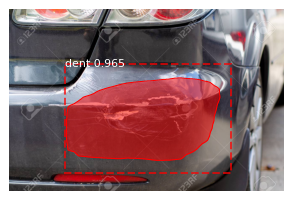

Processing 1 images
image                    shape: (190, 265, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


dataset_val.class_names, r[], figsize=(5,5))


In [42]:
import skimage
real_test_dir = '../datasets/cig_butts/real_test/'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))
    
print('dataset_val.class_names, r[''], figsize=(5,5))')